In [1]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_2088/1105938615.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


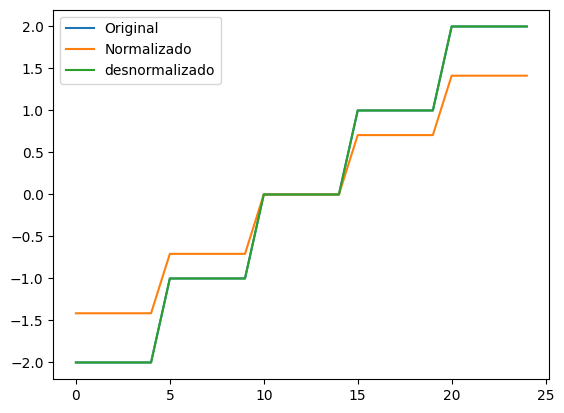

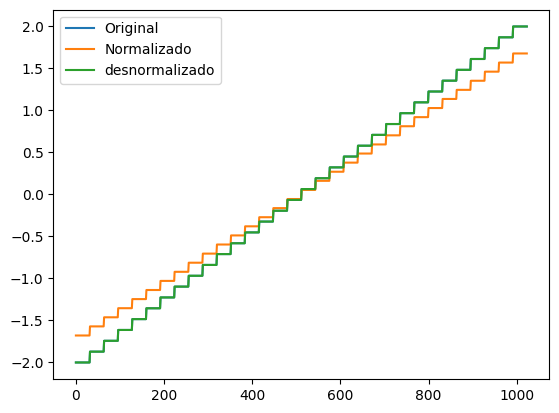

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def peaks(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return x, y, z

def create_dataframe(grid):
   x, y, z = peaks(grid)
   data = {'X': x.flatten(), 'Y': y.flatten(), 'Z': z.flatten()}
   df = pd.DataFrame(data)
   return df

def show_norm(df, label="Peaks", plot=False):
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["Y"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()


df_25 = create_dataframe(grid=5)
df_25_norm = show_norm(df_25)
test_out_scaler(df_25)

df_1000 = create_dataframe(grid=32)
df_1000_norm = show_norm(df_1000)
test_out_scaler(df_1000)



In [3]:
def split_df(df):
    _input = np.vstack([df['X'], df['Y']]).T
    _output = np.array(df['Z'])
    return (_input, _output)

In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-21 23:21:56.691099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 23:21:56.691202: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 23:21:56.974693: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 23:21:57.429064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-21 23:22:00.497814: W tensorflow/compiler/tf2

In [5]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [6]:
import pickle
from itertools import product

class Tester:
  def __init__(self, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input_25, self.output_25 = split_df(df_25_norm)
    self.input_1000, self.output_1000 = split_df(df_1000_norm)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input_25, self.output_25, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando com 25 dados


In [7]:
tester = Tester(run_times=25, dataset_run_times=10)
tester.Loop(sort_by='mse_sup',
            boundarie = 0.5,
            hidden_sizes = [[35, 33], [14, 12], [26, 21], [10, 2], [24, 7], [30, 16]],
            regularizers=[0.2, 0.5],
            learning_rate=[0.01, 0.1])

Testando combinacao1: Hidden Size=[35, 33], regularizer=0.2, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step


32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  40
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_2_24  0.793873  0.756224  0.744118  0.604275  0.622332  0.292567   
model_1_2_23  0.792138  0.754816  0.744189  0.602451  0.620741  0.295030   
model_1_2_22  0.790368  0.753376  0.744199  0.600598  0.619117  0.297543   
model_1_2_21  0.788561  0.751903  0.744144  0.598717  0.617461  0.300107   
model_1_2_20  0.786718  0.750396  0.744023  0.596806  0.615770  0.302723   
model_1_2_19  0.784837  0.748855  0.743834  0.594865  0.614046  0.305392   
model_1_2_18  0.782918  0.747278  0.743573  0.592894  0.612286  0.308116   
model_1_2_17  0.780960  0.745665  0.743238  0.590892  0.610490  0.310895   
model_1_2_16  0.778962  0.744015  0.742828  0.588858  0.608658  0.313731   
model_1_2_15  0.776924  0.742328  0.742340  0.586793  0.606788  0.316624   
model_1_2_14  0.774843  0.740602  0.741769  0.584694  0.604879  0.319577   
model_1_2_13  0.772721  0.738837  0.741115  0.582563  0.602932  0.322590   
model_1_2_12  0.770555  0.737031  0.740373  0.580397  0.600944  0.325664   
model_1_2_11  0.768345  0.735184  0.739542  0.578197  0.598915  0.328801   
model_1_2_10  0.766089  0.733295  0.738618  0.575962  0.596844  0.332002   
model_1_2_9   0.763788  0.731363  0.737597  0.573691  0.594731  0.335269   
model_1_2_8   0.761439  0.729388  0.736477  0.571384  0.592573  0.338603   
model_1_2_7   0.759042  0.727367  0.735254  0.569040  0.590371  0.342004   
model_1_2_6   0.756597  0.725300  0.733925  0.566658  0.588123  0.345476   
model_1_2_5   0.754101  0.723187  0.732487  0.564238  0.585829  0.349018   
model_1_2_4   0.751554  0.721025  0.730935  0.561778  0.583486  0.352634   
model_1_2_3   0.748954  0.718814  0.729266  0.559279  0.581094  0.356323   
model_1_2_2   0.746301  0.716553  0.727476  0.556739  0.578653  0.360089   
model_1_2_1   0.743594  0.714241  0.725561  0.554159  0.576160  0.363931   
model_1_2_0   0.740831  0.711877  0.723517  0.551535  0.573615  0.367853   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_2_24  0.346005  0.109581  1.241206  0.675394  1.507729  0.540894   
model_1_2_23  0.348003  0.109551  1.246928  0.678239  1.517065  0.543166   
model_1_2_22  0.350047  0.109547  1.252738  0.681142  1.526494  0.545475   
model_1_2_21  0.352138  0.109570  1.258639  0.684104  1.536014  0.547820   
model_1_2_20  0.354277  0.109622  1.264633  0.687127  1.545630  0.550203   
model_1_2_19  0.356465  0.109703  1.270719  0.690211  1.555341  0.552623   
model_1_2_18  0.358702  0.109815  1.276902  0.693358  1.565151  0.555082   
model_1_2_17  0.360992  0.109958  1.283182  0.696570  1.575057  0.557580   
model_1_2_16  0.363333  0.110133  1.289561  0.699847  1.585061  0.560117   
model_1_2_15  0.365728  0.110343  1.296039  0.703191  1.595166  0.562694   
model_1_2_14  0.368178  0.110587  1.302621  0.706604  1.605369  0.565311   
model_1_2_13  0.370684  0.110867  1.309307  0.710087  1.615676  0.567970   
model_1_2_12  0.373246  0.111185  1.316100  0.713642  1.626084  0.570670   
model_1_2_11  0.375868  0.111541  1.323000  0.717270  1.636597  0.573412   
model_1_2_10  0.378549  0.111937  1.330010  0.720974  1.647214  0.576196   
model_1_2_9   0.381291  0.112374  1.337133  0.724753  1.659646  0.579024   
model_1_2_8   0.384095  0.112853  1.344369  0.728611  1.676507  0.581896   
model_1_2_7   0.386963  0.113377  1.351722  0.732549  1.694181  0.584811   
model_1_2_6   0.389896  0.113946  1.359193  0.736569  1.712073  0.587772   
model_1_2_5   0.392896  0.114562  1.366784  0.740673  1.730144  0.590778   
model_1_2_4   0.395965  0.115227  1.374497  0.744862  1.748398  0.593830   
model_1_2_3   0.399102  0.115942  1.382337  0.749139  1.766837  0.596928   
model_1_2_2   0.402311  0.116708  1.390303  0.753505  1.785465  0.600074   
model_1_2_1   0.405593  0.117528  1.398398  0.757963  1.804276  0.603267   
model_1_2_0   0.408949  0.118403  1.406625  0.762514  1.823277  0.606509   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_3_24  0.822959  0.777977  0.890476 -0.600947  0.761348  0.251283   
model_1_3_23  0.822025  0.777300  0.889696 -0.601942  0.760556  0.252610   
model_1_3_22  0.821074  0.776609  0.888902 -0.602948  0.759753  0.253960   
model_1_3_21  0.820106  0.775905  0.888096 -0.603960  0.758937  0.255333   
model_1_3_20  0.819122  0.775186  0.887277 -0.604984  0.758108  0.256730   
model_1_3_19  0.818120  0.774453  0.886445 -0.606017  0.757266  0.258152   
model_1_3_18  0.817100  0.773705  0.885599 -0.607060  0.756412  0.259600   
model_1_3_17  0.816063  0.772942  0.884739 -0.608112  0.755544  0.261073   
model_1_3_16  0.815006  0.772163  0.883866 -0.609174  0.754663  0.262571   
model_1_3_15  0.813932  0.771368  0.882978 -0.610246  0.753768  0.264097   
model_1_3_14  0.812838  0.770558  0.882075 -0.611327  0.752859  0.265649   
model_1_3_13  0.811725  0.769731  0.881158 -0.612418  0.751936  0.267230   
model_1_3_12  0.810592  0.768887  0.880226 -0.613519  0.750998  0.268838   
model_1_3_11  0.809438  0.768027  0.879278 -0.614630  0.750045  0.270475   
model_1_3_10  0.808264  0.767148  0.878314 -0.615751  0.749078  0.272141   
model_1_3_9   0.807070  0.766252  0.877335 -0.616882  0.748095  0.273837   
model_1_3_8   0.805853  0.765338  0.876339 -0.618022  0.747097  0.275563   
model_1_3_7   0.804615  0.764405  0.875327 -0.619172  0.746083  0.277320   
model_1_3_6   0.803355  0.763453  0.874298 -0.620333  0.745052  0.279109   
model_1_3_5   0.802072  0.762482  0.873251 -0.621503  0.744005  0.280930   
model_1_3_4   0.800766  0.761490  0.872187 -0.622685  0.742942  0.282784   
model_1_3_3   0.799436  0.760479  0.871105 -0.623875  0.741861  0.284671   
model_1_3_2   0.798083  0.759447  0.870005 -0.625076  0.740763  0.286592   
model_1_3_1   0.796705  0.758394  0.868886 -0.626288  0.739647  0.288548   
model_1_3_0   0.795302  0.757320  0.867748 -0.627509  0.738514  0.290539   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_3_24  0.315130  0.575452  0.813764  0.694608  1.228121  0.501282   
model_1_3_23  0.316091  0.579555  0.814270  0.696912  1.237998  0.502603   
model_1_3_22  0.317071  0.583723  0.814781  0.699252  1.247976  0.503944   
model_1_3_21  0.318071  0.587958  0.815295  0.701627  1.258054  0.505305   
model_1_3_20  0.319091  0.592261  0.815816  0.704038  1.268234  0.506686   
model_1_3_19  0.320131  0.596634  0.816341  0.706488  1.278516  0.508087   
model_1_3_18  0.321193  0.601078  0.816871  0.708975  1.288906  0.509509   
model_1_3_17  0.322276  0.605595  0.817406  0.711501  1.299400  0.510953   
model_1_3_16  0.323382  0.610185  0.817946  0.714065  1.310002  0.512417   
model_1_3_15  0.324509  0.614851  0.818490  0.716671  1.320712  0.513904   
model_1_3_14  0.325660  0.619593  0.819040  0.719316  1.331531  0.515412   
model_1_3_13  0.326833  0.624412  0.819594  0.722003  1.342461  0.516943   
model_1_3_12  0.328031  0.629311  0.820154  0.724733  1.353503  0.518496   
model_1_3_11  0.329253  0.634291  0.820719  0.727505  1.364656  0.520072   
model_1_3_10  0.330499  0.639353  0.821288  0.730321  1.375923  0.521671   
model_1_3_9   0.331771  0.644499  0.821863  0.733181  1.387306  0.523294   
model_1_3_8   0.333069  0.649731  0.822443  0.736087  1.398804  0.524941   
model_1_3_7   0.334393  0.655050  0.823028  0.739039  1.410421  0.526612   
model_1_3_6   0.335744  0.660458  0.823618  0.742038  1.422157  0.528308   
model_1_3_5   0.337123  0.665956  0.824213  0.745085  1.434012  0.530028   
model_1_3_4   0.338530  0.671547  0.824813  0.748180  1.445988  0.531774   
model_1_3_3   0.339965  0.677232  0.825418  0.751325  1.458085  0.533545   
model_1_3_2   0.341430  0.683013  0.826029  0.754521  1.470309  0.535343   
model_1_3_1   0.342924  0.688893  0.826644  0.757769  1.482656  0.537167   
model_1_3_0   0.344449  0.694871  0.827265  0.761068  1.495129  0.539017   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_4_24  0.868006  0.810680 -0.632854  0.914749  0.775167  0.187347   
model_1_4_23  0.866832  0.809917 -0.631197  0.914030  0.774753  0.189013   
model_1_4_22  0.865615  0.809117 -0.629928  0.913283  0.774280  0.190739   
model_1_4_21  0.864355  0.808279 -0.629063  0.912507  0.773744  0.192528   
model_1_4_20  0.863050  0.807403 -0.628616  0.911701  0.773144  0.194380   
model_1_4_19  0.861700  0.806486 -0.628602  0.910865  0.772479  0.196297   
model_1_4_18  0.860302  0.805529 -0.629036  0.909997  0.771745  0.198282   
model_1_4_17  0.858855  0.804529 -0.629936  0.909098  0.770942  0.200335   
model_1_4_16  0.857359  0.803487 -0.631316  0.908166  0.770066  0.202458   
model_1_4_15  0.855812  0.802400 -0.633195  0.907201  0.769116  0.204654   
model_1_4_14  0.854213  0.801268 -0.635592  0.906202  0.768089  0.206923   
model_1_4_13  0.852560  0.800089 -0.638523  0.905169  0.766984  0.209269   
model_1_4_12  0.850852  0.798863 -0.642008  0.904099  0.765796  0.211693   
model_1_4_11  0.849088  0.797587 -0.646066  0.902994  0.764525  0.214197   
model_1_4_10  0.847266  0.796262 -0.650717  0.901852  0.763167  0.216783   
model_1_4_9   0.845385  0.794885 -0.655982  0.900671  0.761720  0.219454   
model_1_4_8   0.843443  0.793455 -0.661882  0.899453  0.760181  0.222210   
model_1_4_7   0.841438  0.791971 -0.668439  0.898194  0.758549  0.225055   
model_1_4_6   0.839370  0.790431 -0.675674  0.896896  0.756818  0.227991   
model_1_4_5   0.837236  0.788835 -0.683614  0.895557  0.754988  0.231020   
model_1_4_4   0.835035  0.787180 -0.692280  0.894176  0.753054  0.234144   
model_1_4_3   0.832765  0.785465 -0.701697  0.892752  0.751014  0.237366   
model_1_4_2   0.830424  0.783689 -0.711890  0.891285  0.748865  0.240689   
model_1_4_1   0.828011  0.781850 -0.722885  0.889774  0.746604  0.244114   
model_1_4_0   0.825523  0.779946 -0.734711  0.888218  0.744227  0.247645   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_4_24  0.268712  0.504838  0.218803  0.361820  1.231291  0.432836   
model_1_4_23  0.269795  0.504326  0.220647  0.362487  1.229373  0.434756   
model_1_4_22  0.270930  0.503933  0.222564  0.363249  1.227455  0.436737   
model_1_4_21  0.272120  0.503666  0.224556  0.364111  1.225536  0.438780   
model_1_4_20  0.273364  0.503528  0.226625  0.365076  1.223619  0.440885   
model_1_4_19  0.274665  0.503523  0.228771  0.366147  1.221702  0.443054   
model_1_4_18  0.276024  0.503658  0.230997  0.367327  1.219783  0.445288   
model_1_4_17  0.277442  0.503936  0.233305  0.368621  1.217864  0.447588   
model_1_4_16  0.278922  0.504362  0.235697  0.370029  1.215937  0.449953   
model_1_4_15  0.280465  0.504944  0.238173  0.371558  1.214010  0.452387   
model_1_4_14  0.282072  0.505685  0.240737  0.373211  1.212079  0.454888   
model_1_4_13  0.283745  0.506591  0.243390  0.374990  1.210141  0.457460   
model_1_4_12  0.285485  0.507668  0.246135  0.376901  1.208196  0.460102   
model_1_4_11  0.287295  0.508923  0.248972  0.378947  1.207892  0.462815   
model_1_4_10  0.289177  0.510361  0.251904  0.381132  1.208613  0.465600   
model_1_4_9   0.291131  0.511989  0.254933  0.383461  1.209362  0.468459   
model_1_4_8   0.293161  0.513813  0.258061  0.385937  1.210139  0.471392   
model_1_4_7   0.295267  0.515840  0.261290  0.388565  1.210938  0.474400   
model_1_4_6   0.297452  0.518077  0.264622  0.391349  1.211767  0.477484   
model_1_4_5   0.299718  0.520532  0.268059  0.394296  1.212616  0.480645   
model_1_4_4   0.302067  0.523211  0.271604  0.397407  1.213494  0.483884   
model_1_4_3   0.304501  0.526122  0.275258  0.400690  1.215939  0.487203   
model_1_4_2   0.307022  0.529274  0.279023  0.404148  1.218468  0.490600   
model_1_4_1   0.309632  0.532673  0.282902  0.407788  1.221035  0.494079   
model_1_4_0   0.312334  0.536330  0.286896  0.411613  1.224532  0.497639   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_5_24  0.923789  0.851377  0.903881  0.976638  0.974230  0.108171   
model_1_5_23  0.922552  0.850550  0.905648  0.977799  0.975336  0.109926   
model_1_5_22  0.921265  0.849682  0.907143  0.978850  0.976332  0.111753   
model_1_5_21  0.919927  0.848771  0.908355  0.979789  0.977215  0.113653   
model_1_5_20  0.918535  0.847816  0.909280  0.980611  0.977979  0.115628   
model_1_5_19  0.917088  0.846815  0.909910  0.981311  0.978621  0.117682   
model_1_5_18  0.915585  0.845769  0.910237  0.981884  0.979136  0.119815   
model_1_5_17  0.914024  0.844675  0.910252  0.982327  0.979519  0.122030   
model_1_5_16  0.912405  0.843533  0.909949  0.982633  0.979766  0.124329   
model_1_5_15  0.910724  0.842340  0.909319  0.982798  0.979873  0.126714   
model_1_5_14  0.908981  0.841096  0.908353  0.982817  0.979833  0.129189   
model_1_5_13  0.907173  0.839800  0.907044  0.982684  0.979642  0.131754   
model_1_5_12  0.905300  0.838449  0.905383  0.982394  0.979296  0.134413   
model_1_5_11  0.903359  0.837043  0.903360  0.981942  0.978787  0.137168   
model_1_5_10  0.901349  0.835579  0.900968  0.981321  0.978112  0.140021   
model_1_5_9   0.899267  0.834058  0.898198  0.980526  0.977264  0.142975   
model_1_5_8   0.897113  0.832477  0.895040  0.979551  0.976237  0.146033   
model_1_5_7   0.894883  0.830834  0.891486  0.978388  0.975026  0.149198   
model_1_5_6   0.892576  0.829128  0.887527  0.977033  0.973625  0.152473   
model_1_5_5   0.890190  0.827358  0.883154  0.975478  0.972027  0.155859   
model_1_5_4   0.887723  0.825522  0.878358  0.973717  0.970226  0.159360   
model_1_5_3   0.885173  0.823618  0.873132  0.971743  0.968216  0.162980   
model_1_5_2   0.882538  0.821645  0.867465  0.969548  0.965990  0.166720   
model_1_5_1   0.879815  0.819600  0.861350  0.967126  0.963541  0.170585   
model_1_5_0   0.877003  0.817483  0.854779  0.964470  0.960863  0.174577   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_5_24  0.210949  0.009443  0.034292  0.021867  0.957933  0.328894   
model_1_5_23  0.212122  0.009270  0.032588  0.020929  0.962723  0.331551   
model_1_5_22  0.213355  0.009123  0.031044  0.020084  0.969547  0.334294   
model_1_5_21  0.214648  0.009004  0.029666  0.019335  0.976521  0.337124   
model_1_5_20  0.216004  0.008913  0.028460  0.018686  0.983565  0.340042   
model_1_5_19  0.217423  0.008851  0.027433  0.018142  0.990679  0.343048   
model_1_5_18  0.218908  0.008819  0.026591  0.017705  0.997866  0.346143   
model_1_5_17  0.220461  0.008817  0.025942  0.017380  1.005129  0.349328   
model_1_5_16  0.222083  0.008847  0.025492  0.017170  1.012463  0.352603   
model_1_5_15  0.223775  0.008909  0.025250  0.017079  1.019874  0.355970   
model_1_5_14  0.225541  0.009004  0.025222  0.017113  1.028885  0.359428   
model_1_5_13  0.227381  0.009133  0.025417  0.017275  1.038051  0.362979   
model_1_5_12  0.229298  0.009296  0.025842  0.017569  1.047309  0.366623   
model_1_5_11  0.231294  0.009494  0.026506  0.018000  1.056659  0.370361   
model_1_5_10  0.233371  0.009729  0.027417  0.018573  1.066098  0.374194   
model_1_5_9   0.235531  0.010002  0.028584  0.019293  1.075631  0.378121   
model_1_5_8   0.237775  0.010312  0.030016  0.020164  1.085260  0.382143   
model_1_5_7   0.240107  0.010661  0.031722  0.021192  1.094983  0.386262   
model_1_5_6   0.242528  0.011050  0.033712  0.022381  1.104804  0.390477   
model_1_5_5   0.245040  0.011480  0.035994  0.023737  1.114722  0.394790   
model_1_5_4   0.247647  0.011951  0.038579  0.025265  1.124738  0.399200   
model_1_5_3   0.250349  0.012464  0.041477  0.026971  1.134856  0.403707   
model_1_5_2   0.253150  0.013021  0.044699  0.028860  1.147200  0.408314   
model_1_5_1   0.256051  0.013622  0.048253  0.030938  1.163681  0.413019   
model_1_5_0   0.259056  0.014267  0.052153  0.033210  1.180328  0.417824   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_6_9   0.931835  0.853173  0.951691  0.536953  0.942388  0.096750   
model_1_6_10  0.932374  0.853168  0.951565  0.495924  0.941282  0.095985   
model_1_6_8   0.931248  0.853145  0.951807  0.575088  0.943414  0.097583   
model_1_6_11  0.932866  0.853130  0.951429  0.451972  0.940097  0.095287   
model_1_6_7   0.930613  0.853083  0.951912  0.610357  0.944362  0.098484   
model_1_6_12  0.933311  0.853060  0.951284  0.405091  0.938833  0.094655   
model_1_6_6   0.929930  0.852988  0.952007  0.642797  0.945231  0.099454   
model_1_6_13  0.933709  0.852957  0.951131  0.355279  0.937490  0.094090   
model_1_6_5   0.929199  0.852860  0.952090  0.672460  0.946023  0.100492   
model_1_6_14  0.934062  0.852822  0.950969  0.302550  0.936069  0.093590   
model_1_6_4   0.928418  0.852697  0.952161  0.699402  0.946738  0.101600   
model_1_6_15  0.934369  0.852655  0.950798  0.246927  0.934570  0.093154   
model_1_6_3   0.927590  0.852501  0.952220  0.723685  0.947377  0.102776   
model_1_6_16  0.934631  0.852458  0.950620  0.188448  0.932995  0.092782   
model_1_6_2   0.926713  0.852271  0.952266  0.745374  0.947941  0.104021   
model_1_6_17  0.934850  0.852229  0.950434  0.127160  0.931346  0.092471   
model_1_6_1   0.925787  0.852007  0.952297  0.764540  0.948432  0.105335   
model_1_6_18  0.935026  0.851971  0.950240  0.063128  0.929623  0.092221   
model_1_6_0   0.924812  0.851709  0.952315  0.781257  0.948850  0.106719   
model_1_6_19  0.935161  0.851683  0.950039 -0.003575  0.927830  0.092030   
model_1_6_20  0.935255  0.851366  0.949832 -0.072864  0.925967  0.091897   
model_1_6_21  0.935309  0.851021  0.949617 -0.144639  0.924039  0.091819   
model_1_6_22  0.935326  0.850648  0.949396 -0.218799  0.922047  0.091795   
model_1_6_23  0.935306  0.850249  0.949169 -0.295220  0.919995  0.091823   
model_1_6_24  0.935251  0.849823  0.948936 -0.373783  0.917885  0.091901   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_6_9   0.208400  0.149697  0.035762  0.092730  1.080882  0.311047   
model_1_6_10  0.208407  0.150087  0.038931  0.094509  1.094445  0.309814   
model_1_6_8   0.208440  0.149338  0.032817  0.091078  1.067513  0.312383   
model_1_6_11  0.208460  0.150507  0.042326  0.096416  1.108975  0.308685   
model_1_6_7   0.208527  0.149011  0.030093  0.089552  1.054355  0.313822   
model_1_6_12  0.208560  0.150956  0.045947  0.098451  1.123864  0.307661   
model_1_6_6   0.208662  0.148718  0.027588  0.088153  1.041423  0.315363   
model_1_6_13  0.208706  0.151432  0.049794  0.100613  1.138904  0.306741   
model_1_6_5   0.208844  0.148460  0.025297  0.086878  1.028726  0.317005   
model_1_6_14  0.208898  0.151935  0.053866  0.102900  1.154075  0.305925   
model_1_6_4   0.209075  0.148239  0.023216  0.085727  1.016271  0.318747   
model_1_6_15  0.209134  0.152463  0.058162  0.105312  1.169359  0.305212   
model_1_6_3   0.209353  0.148057  0.021341  0.084699  1.004073  0.320587   
model_1_6_16  0.209415  0.153015  0.062679  0.107847  1.184734  0.304601   
model_1_6_2   0.209680  0.147916  0.019665  0.083791  0.992133  0.322523   
model_1_6_17  0.209739  0.153592  0.067412  0.110502  1.200177  0.304090   
model_1_6_1   0.210054  0.147817  0.018185  0.083001  0.980465  0.324554   
model_1_6_18  0.210106  0.154192  0.072357  0.113274  1.215666  0.303679   
model_1_6_0   0.210477  0.147762  0.016894  0.082328  0.969059  0.326678   
model_1_6_19  0.210515  0.154814  0.077509  0.116161  1.231179  0.303365   
model_1_6_20  0.210965  0.155457  0.082860  0.119159  1.246693  0.303145   
model_1_6_21  0.211455  0.156122  0.088404  0.122263  1.262188  0.303017   
model_1_6_22  0.211984  0.156806  0.094131  0.125469  1.277637  0.302977   
model_1_6_23  0.212550  0.157510  0.100033  0.128772  1.293021  0.303024   
model_1_6_24  0.213154  0.158233  0.106101  0.132167  1.308753  0.303152   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_7_18  0.943691  0.852823  0.942972  0.977707  0.969247  0.079922   
model_1_7_17  0.943460  0.852822  0.944596  0.978221  0.970076  0.080251   
model_1_7_19  0.943904  0.852810  0.941340  0.977184  0.968413  0.079620   
model_1_7_16  0.943208  0.852806  0.946212  0.978725  0.970897  0.080607   
model_1_7_20  0.944098  0.852783  0.939703  0.976652  0.967572  0.079345   
model_1_7_15  0.942937  0.852774  0.947818  0.979220  0.971711  0.080993   
model_1_7_21  0.944274  0.852741  0.938061  0.976111  0.966726  0.079095   
model_1_7_14  0.942644  0.852727  0.949415  0.979704  0.972517  0.081408   
model_1_7_22  0.944433  0.852687  0.936414  0.975561  0.965875  0.078870   
model_1_7_13  0.942330  0.852663  0.951000  0.980178  0.973315  0.081855   
model_1_7_23  0.944574  0.852619  0.934763  0.975003  0.965019  0.078669   
model_1_7_12  0.941993  0.852582  0.952573  0.980642  0.974104  0.082332   
model_1_7_24  0.944700  0.852539  0.933110  0.974437  0.964159  0.078490   
model_1_7_11  0.941633  0.852485  0.954133  0.981094  0.974883  0.082843   
model_1_7_10  0.941250  0.852370  0.955678  0.981536  0.975652  0.083387   
model_1_7_9   0.940842  0.852237  0.957207  0.981966  0.976411  0.083966   
model_1_7_8   0.940409  0.852085  0.958720  0.982384  0.977159  0.084580   
model_1_7_7   0.939951  0.851915  0.960214  0.982791  0.977895  0.085231   
model_1_7_6   0.939465  0.851726  0.961689  0.983185  0.978619  0.085921   
model_1_7_5   0.938952  0.851517  0.963143  0.983567  0.979330  0.086649   
model_1_7_4   0.938411  0.851287  0.964576  0.983936  0.980027  0.087417   
model_1_7_3   0.937840  0.851038  0.965985  0.984291  0.980710  0.088226   
model_1_7_2   0.937240  0.850767  0.967370  0.984633  0.981379  0.089078   
model_1_7_1   0.936609  0.850474  0.968728  0.984961  0.982032  0.089974   
model_1_7_0   0.935947  0.850160  0.970060  0.985274  0.982668  0.090915   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_7_18  0.208896  0.122591  0.048770  0.085681  1.147861  0.282705   
model_1_7_17  0.208898  0.119100  0.047646  0.083373  1.155537  0.283286   
model_1_7_19  0.208915  0.126098  0.049914  0.088006  1.140261  0.282171   
model_1_7_16  0.208921  0.115627  0.046543  0.081085  1.163291  0.283914   
model_1_7_20  0.208954  0.129617  0.051078  0.090348  1.132738  0.281683   
model_1_7_15  0.208966  0.112173  0.045461  0.078817  1.171124  0.284593   
model_1_7_21  0.209012  0.133149  0.052262  0.092705  1.125288  0.281239   
model_1_7_14  0.209033  0.108741  0.044401  0.076571  1.179037  0.285322   
model_1_7_22  0.209090  0.136689  0.053464  0.095077  1.117911  0.280838   
model_1_7_13  0.209124  0.105333  0.043364  0.074349  1.187029  0.286102   
model_1_7_23  0.209186  0.140237  0.054685  0.097461  1.110604  0.280479   
model_1_7_12  0.209238  0.101951  0.042350  0.072151  1.195103  0.286936   
model_1_7_24  0.209300  0.143791  0.055923  0.099857  1.103373  0.280161   
model_1_7_11  0.209376  0.098599  0.041360  0.069979  1.203266  0.287824   
model_1_7_10  0.209540  0.095277  0.040394  0.067836  1.211508  0.288768   
model_1_7_9   0.209728  0.091990  0.039453  0.065721  1.219841  0.289768   
model_1_7_8   0.209943  0.088739  0.038538  0.063638  1.228264  0.290827   
model_1_7_7   0.210185  0.085526  0.037648  0.061587  1.236775  0.291944   
model_1_7_6   0.210454  0.082356  0.036786  0.059571  1.245375  0.293122   
model_1_7_5   0.210751  0.079229  0.035951  0.057590  1.254071  0.294361   
model_1_7_4   0.211076  0.076150  0.035144  0.055647  1.262861  0.295663   
model_1_7_3   0.211431  0.073121  0.034366  0.053744  1.271749  0.297029   
model_1_7_2   0.211815  0.070144  0.033618  0.051881  1.280736  0.298460   
model_1_7_1   0.212230  0.067223  0.032901  0.050062  1.289825  0.299957   
model_1_7_0   0.212676  0.064361  0.032215  0.048288  1.299102  0.301520   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_8_24  0.958520  0.858423  0.866517  0.997813  0.900675  0.058875   
model_1_8_23  0.958137  0.858321  0.867725  0.998147  0.901637  0.059419   
model_1_8_22  0.957741  0.858210  0.868934  0.998446  0.902593  0.059980   
model_1_8_21  0.957334  0.858089  0.870145  0.998707  0.903542  0.060558   
model_1_8_20  0.956915  0.857960  0.871357  0.998930  0.904484  0.061153   
model_1_8_19  0.956483  0.857821  0.872570  0.999113  0.905420  0.061766   
model_1_8_18  0.956038  0.857672  0.873784  0.999256  0.906347  0.062398   
model_1_8_17  0.955580  0.857512  0.874998  0.999355  0.907267  0.063048   
model_1_8_16  0.955108  0.857343  0.876213  0.999412  0.908178  0.063717   
model_1_8_15  0.954623  0.857162  0.877428  0.999423  0.909081  0.064406   
model_1_8_14  0.954123  0.856970  0.878643  0.999388  0.909974  0.065115   
model_1_8_13  0.953609  0.856767  0.879858  0.999306  0.910857  0.065845   
model_1_8_12  0.953081  0.856553  0.881072  0.999175  0.911730  0.066595   
model_1_8_11  0.952537  0.856326  0.882286  0.998993  0.912593  0.067367   
model_1_8_10  0.951978  0.856087  0.883499  0.998759  0.913445  0.068161   
model_1_8_9   0.951403  0.855835  0.884711  0.998472  0.914286  0.068977   
model_1_8_8   0.950811  0.855571  0.885922  0.998130  0.915114  0.069816   
model_1_8_7   0.950204  0.855293  0.887131  0.997732  0.915930  0.070679   
model_1_8_6   0.949579  0.855001  0.888338  0.997275  0.916734  0.071566   
model_1_8_5   0.948937  0.854694  0.889543  0.996759  0.917523  0.072477   
model_1_8_4   0.948277  0.854374  0.890747  0.996182  0.918299  0.073413   
model_1_8_3   0.947600  0.854038  0.891947  0.995542  0.919061  0.074375   
model_1_8_2   0.946903  0.853687  0.893145  0.994837  0.919808  0.075363   
model_1_8_1   0.946188  0.853321  0.894340  0.994065  0.920539  0.076378   
model_1_8_0   0.945454  0.852938  0.895532  0.993226  0.921254  0.077420   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_8_24  0.200948  0.135207  0.000598  0.067902  0.752832  0.242641   
model_1_8_23  0.201093  0.133984  0.000506  0.067245  0.746531  0.243760   
model_1_8_22  0.201251  0.132759  0.000425  0.066592  0.740185  0.244908   
model_1_8_21  0.201422  0.131532  0.000353  0.065943  0.733791  0.246085   
model_1_8_20  0.201605  0.130305  0.000292  0.065298  0.727356  0.247292   
model_1_8_19  0.201803  0.129076  0.000242  0.064659  0.720874  0.248528   
model_1_8_18  0.202015  0.127846  0.000203  0.064025  0.714353  0.249796   
model_1_8_17  0.202241  0.126617  0.000176  0.063396  0.718848  0.251094   
model_1_8_16  0.202482  0.125386  0.000161  0.062773  0.738210  0.252423   
model_1_8_15  0.202738  0.124155  0.000158  0.062156  0.757745  0.253784   
model_1_8_14  0.203010  0.122924  0.000167  0.061546  0.777460  0.255177   
model_1_8_13  0.203298  0.121694  0.000190  0.060942  0.797347  0.256602   
model_1_8_12  0.203602  0.120464  0.000225  0.060345  0.817411  0.258060   
model_1_8_11  0.203924  0.119234  0.000275  0.059755  0.837660  0.259552   
model_1_8_10  0.204263  0.118006  0.000339  0.059172  0.858147  0.261076   
model_1_8_9   0.204621  0.116778  0.000417  0.058598  0.879484  0.262635   
model_1_8_8   0.204996  0.115552  0.000511  0.058031  0.901005  0.264228   
model_1_8_7   0.205391  0.114327  0.000620  0.057473  0.922717  0.265855   
model_1_8_6   0.205806  0.113104  0.000744  0.056924  0.944619  0.267517   
model_1_8_5   0.206240  0.111883  0.000885  0.056384  0.966715  0.269215   
model_1_8_4   0.206695  0.110665  0.001043  0.055854  0.989003  0.270948   
model_1_8_3   0.207171  0.109449  0.001218  0.055333  1.011486  0.272717   
model_1_8_2   0.207670  0.108235  0.001410  0.054823  1.034165  0.274523   
model_1_8_1   0.208190  0.107025  0.001621  0.054323  1.057036  0.276365   
model_1_8_0   0.208733  0.105818  0.001851  0.053834  1.080106  0.278245   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_1_9_4   0.961116  0.858636  0.883694  0.951324  0.939596  0.055191   
model_1_9_3   0.960657  0.858631  0.888263  0.948815  0.940407  0.055842   
model_1_9_5   0.961545  0.858622  0.878977  0.953684  0.938678  0.054581   
model_1_9_2   0.960169  0.858608  0.892678  0.946156  0.941107  0.056535   
model_1_9_6   0.961946  0.858591  0.874115  0.955900  0.937655  0.054012   
model_1_9_1   0.959650  0.858566  0.896938  0.943342  0.941695  0.057270   
model_1_9_7   0.962319  0.858543  0.869111  0.957973  0.936529  0.053482   
model_1_9_0   0.959101  0.858505  0.901038  0.940372  0.942169  0.058050   
model_1_9_8   0.962665  0.858479  0.863969  0.959908  0.935303  0.052991   
model_1_9_9   0.962985  0.858398  0.858692  0.961706  0.933978  0.052538   
model_1_9_10  0.963278  0.858302  0.853286  0.963372  0.932559  0.052121   
model_1_9_11  0.963546  0.858191  0.847752  0.964908  0.931046  0.051741   
model_1_9_12  0.963790  0.858065  0.842096  0.966318  0.929443  0.051395   
model_1_9_13  0.964009  0.857925  0.836321  0.967603  0.927752  0.051084   
model_1_9_14  0.964204  0.857772  0.830429  0.968769  0.925976  0.050807   
model_1_9_15  0.964377  0.857605  0.824427  0.969816  0.924116  0.050562   
model_1_9_16  0.964527  0.857425  0.818316  0.970750  0.922176  0.050348   
model_1_9_17  0.964656  0.857232  0.812102  0.971572  0.920158  0.050166   
model_1_9_18  0.964763  0.857027  0.805787  0.972285  0.918065  0.050014   
model_1_9_19  0.964850  0.856811  0.799376  0.972893  0.915898  0.049891   
model_1_9_20  0.964916  0.856583  0.792872  0.973399  0.913661  0.049796   
model_1_9_21  0.964964  0.856345  0.786280  0.973805  0.911356  0.049729   
model_1_9_22  0.964992  0.856095  0.779602  0.974114  0.908985  0.049689   
model_1_9_23  0.965002  0.855836  0.772844  0.974330  0.906550  0.049675   
model_1_9_24  0.964994  0.855567  0.766008  0.974454  0.904055  0.049686   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_1_9_4   0.200646  0.061911  0.024651  0.043281  0.720727  0.234927   
model_1_9_3   0.200653  0.059479  0.025921  0.042700  0.727130  0.236308   
model_1_9_5   0.200665  0.064422  0.023455  0.043939  0.714800  0.233626   
model_1_9_2   0.200685  0.057129  0.027268  0.042198  0.733543  0.237770   
model_1_9_6   0.200709  0.067010  0.022333  0.044672  0.709996  0.232405   
model_1_9_1   0.200745  0.054861  0.028693  0.041777  0.739962  0.239312   
model_1_9_7   0.200777  0.069674  0.021283  0.045479  0.705176  0.231262   
model_1_9_0   0.200832  0.052679  0.030197  0.041438  0.746391  0.240936   
model_1_9_8   0.200869  0.072411  0.020303  0.046357  0.700346  0.230198   
model_1_9_9   0.200983  0.075220  0.019393  0.047306  0.695500  0.229211   
model_1_9_10  0.201119  0.078098  0.018549  0.048323  0.690636  0.228301   
model_1_9_11  0.201277  0.081043  0.017771  0.049407  0.685755  0.227466   
model_1_9_12  0.201456  0.084054  0.017057  0.050556  0.680848  0.226705   
model_1_9_13  0.201654  0.087128  0.016406  0.051767  0.675923  0.226018   
model_1_9_14  0.201872  0.090265  0.015816  0.053040  0.670974  0.225403   
model_1_9_15  0.202110  0.093460  0.015285  0.054373  0.666002  0.224859   
model_1_9_16  0.202365  0.096712  0.014813  0.055763  0.661007  0.224384   
model_1_9_17  0.202638  0.100020  0.014397  0.057209  0.655988  0.223977   
model_1_9_18  0.202929  0.103382  0.014035  0.058709  0.650938  0.223637   
model_1_9_19  0.203236  0.106795  0.013727  0.060261  0.645863  0.223362   
model_1_9_20  0.203559  0.110257  0.013471  0.061864  0.640765  0.223150   
model_1_9_21  0.203898  0.113766  0.013266  0.063516  0.635637  0.223000   
model_1_9_22  0.204252  0.117320  0.013109  0.065215  0.630481  0.222910   
model_1_9_23  0.204620  0.120918  0.013000  0.066959  0.625298  0.222879   
model_1_9_24  0.205002  0.124557  0.012937  0.068747  0.620089  0.222904   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_1_9
Testando combinacao2: Hidden Size=[35, 33], regularizer=0.2, learning_rate=0.1
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_1_13  0.905245  0.749522  0.843372  0.937883  0.885294  0.134491   
model_2_1_12  0.907691  0.749419  0.851884  0.941026  0.891427  0.131020   
model_2_1_14  0.902783  0.749366  0.835602  0.934984  0.879682  0.137985   
model_2_1_15  0.900364  0.749027  0.828538  0.932315  0.874567  0.141419   
model_2_1_11  0.910039  0.748957  0.861160  0.944421  0.898099  0.127686   
model_2_1_16  0.898027  0.748565  0.822138  0.929864  0.869917  0.144736   
model_2_1_17  0.895798  0.748022  0.816353  0.927618  0.865701  0.147900   
model_2_1_10  0.912179  0.748008  0.871208  0.948075  0.905315  0.124650   
model_2_1_18  0.893694  0.747434  0.811136  0.925561  0.861886  0.150886   
model_2_1_19  0.891722  0.746825  0.806437  0.923681  0.858438  0.153684   
model_2_1_9   0.913957  0.746412  0.882010  0.951988  0.913065  0.122125   
model_2_1_20  0.889887  0.746212  0.802211  0.921964  0.855325  0.156290   
model_2_1_21  0.888187  0.745610  0.798413  0.920399  0.852518  0.158703   
model_2_1_22  0.886618  0.745026  0.795001  0.918973  0.849988  0.160929   
model_2_1_23  0.885176  0.744468  0.791938  0.917675  0.847709  0.162976   
model_2_1_8   0.915176  0.743966  0.893516  0.956150  0.921318  0.120396   
model_2_1_7   0.915573  0.740422  0.905640  0.960542  0.930018  0.119832   
model_2_1_6   0.914816  0.735481  0.918253  0.965132  0.939077  0.120906   
model_2_1_5   0.912485  0.728790  0.931182  0.969874  0.948379  0.124215   
model_2_1_4   0.908057  0.719941  0.944213  0.974701  0.957776  0.130499   
model_2_1_3   0.900891  0.708466  0.957116  0.979527  0.967099  0.140671   
model_2_1_2   0.890183  0.693783  0.969635  0.984225  0.976152  0.155869   
model_2_1_1   0.874868  0.675056  0.981381  0.988617  0.984640  0.177606   
model_2_1_0   0.853396  0.650899  0.991455  0.992452  0.991948  0.208083   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_1_13  0.355517  0.582329  0.177480  0.379905  0.477726  0.366730   
model_2_1_12  0.355663  0.550685  0.168501  0.359592  0.485590  0.361966   
model_2_1_14  0.355738  0.611218  0.185765  0.398491  0.470730  0.371464   
model_2_1_15  0.356219  0.637480  0.193389  0.415435  0.464509  0.376057   
model_2_1_11  0.356319  0.516194  0.158799  0.337497  0.494430  0.357332   
model_2_1_16  0.356876  0.661277  0.200391  0.430834  0.458974  0.380442   
model_2_1_17  0.357646  0.682784  0.206811  0.444797  0.454046  0.384577   
model_2_1_10  0.357666  0.478837  0.148359  0.313598  0.504339  0.353058   
model_2_1_18  0.358480  0.702182  0.212687  0.457434  0.449655  0.388441   
model_2_1_19  0.359345  0.719650  0.218059  0.468855  0.445737  0.392026   
model_2_1_9   0.359931  0.438678  0.137181  0.287930  0.515431  0.349464   
model_2_1_20  0.360215  0.735363  0.222964  0.479163  0.442234  0.395335   
model_2_1_21  0.361070  0.749486  0.227436  0.488461  0.439102  0.398375   
model_2_1_22  0.361898  0.762170  0.231510  0.496840  0.436293  0.401160   
model_2_1_23  0.362690  0.773559  0.235218  0.504389  0.433776  0.403703   
model_2_1_8   0.363403  0.395900  0.125289  0.260594  0.527808  0.346981   
model_2_1_7   0.368433  0.350822  0.112739  0.231781  0.541575  0.346167   
model_2_1_6   0.375446  0.303927  0.099624  0.201775  0.556835  0.347715   
model_2_1_5   0.384943  0.255861  0.086077  0.170969  0.573735  0.352441   
model_2_1_4   0.397503  0.207411  0.072284  0.139847  0.592539  0.361247   
model_2_1_3   0.413791  0.159441  0.058497  0.108969  0.613857  0.375061   
model_2_1_2   0.434630  0.112894  0.045072  0.078983  0.638985  0.394803   
model_2_1_1   0.461211  0.069224  0.032524  0.050874  0.670546  0.421434   
model_2_1_0   0.495498  0.031770  0.021566  0.026668  0.710876  0.456161   

                r2_adj       rsd          aic          bic  
model_2_1_13  1.001745  0.382343  2658.012513  4275.460733  
model_2_1_12  1.001700  0.377376  2658.064815  4275.513034  
model_2_1_14  1.001791  0.387278  2

DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_2] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_2_1   0.929102  0.766811  0.846319  0.826304  0.843299  0.100630   
model_2_2_2   0.931038  0.766538  0.839579  0.820976  0.837096  0.097881   
model_2_2_0   0.926337  0.766485  0.853419  0.832188  0.849914  0.104553   
model_2_2_3   0.932365  0.765868  0.833323  0.816247  0.831400  0.095998   
model_2_2_4   0.933239  0.764950  0.827602  0.812047  0.826227  0.094758   
model_2_2_5   0.933777  0.763887  0.822423  0.808279  0.821556  0.093995   
model_2_2_6   0.934066  0.762752  0.817773  0.804857  0.817349  0.093584   
model_2_2_7   0.934174  0.761591  0.813624  0.801711  0.813569  0.093430   
model_2_2_8   0.934151  0.760437  0.809940  0.798794  0.810177  0.093463   
model_2_2_9   0.934037  0.759311  0.806686  0.796073  0.807138  0.093625   
model_2_2_10  0.933861  0.758227  0.803825  0.793530  0.804422  0.093875   
model_2_2_11  0.933646  0.757194  0.801318  0.791155  0.802000  0.094180   
model_2_2_12  0.933409  0.756220  0.799131  0.788943  0.799845  0.094516   
model_2_2_13  0.933163  0.755306  0.797228  0.786890  0.797934  0.094865   
model_2_2_14  0.932917  0.754454  0.795576  0.784992  0.796240  0.095214   
model_2_2_15  0.932678  0.753665  0.794145  0.783246  0.794744  0.095554   
model_2_2_16  0.932449  0.752936  0.792906  0.781646  0.793422  0.095879   
model_2_2_17  0.932232  0.752267  0.791834  0.780185  0.792256  0.096187   
model_2_2_18  0.932029  0.751653  0.790906  0.778855  0.791228  0.096474   
model_2_2_19  0.931841  0.751092  0.790102  0.777647  0.790321  0.096741   
model_2_2_20  0.931668  0.750581  0.789403  0.776554  0.789520  0.096988   
model_2_2_21  0.931508  0.750115  0.788796  0.775565  0.788813  0.097214   
model_2_2_22  0.931362  0.749692  0.788267  0.774672  0.788187  0.097422   
model_2_2_23  0.931228  0.749308  0.787806  0.773867  0.787634  0.097612   
model_2_2_24  0.931106  0.748960  0.787402  0.773142  0.787143  0.097785   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_2_1   0.330979  0.303682  0.145220  0.224451  0.322147  0.317222   
model_2_2_2   0.331366  0.317000  0.149674  0.233337  0.307366  0.312860   
model_2_2_0   0.331441  0.289653  0.140300  0.214977  0.338102  0.323347   
model_2_2_3   0.332316  0.329363  0.153628  0.241496  0.293820  0.309836   
model_2_2_4   0.333620  0.340669  0.157140  0.248905  0.281515  0.307828   
model_2_2_5   0.335128  0.350902  0.160290  0.255596  0.270405  0.306585   
model_2_2_6   0.336739  0.360091  0.163151  0.261621  0.260417  0.305914   
model_2_2_7   0.338387  0.368291  0.165781  0.267036  0.251471  0.305664   
model_2_2_8   0.340025  0.375569  0.168220  0.271895  0.243473  0.305716   
model_2_2_9   0.341623  0.381999  0.170495  0.276247  0.236341  0.305982   
model_2_2_10  0.343162  0.387654  0.172621  0.280137  0.229980  0.306390   
model_2_2_11  0.344627  0.392607  0.174607  0.283607  0.224316  0.306888   
model_2_2_12  0.346011  0.396930  0.176456  0.286693  0.219263  0.307435   
model_2_2_13  0.347308  0.400690  0.178173  0.289431  0.214754  0.308002   
model_2_2_14  0.348517  0.403954  0.179759  0.291856  0.210722  0.308568   
model_2_2_15  0.349637  0.406781  0.181219  0.294000  0.207114  0.309118   
model_2_2_16  0.350671  0.409229  0.182557  0.295893  0.203883  0.309644   
model_2_2_17  0.351622  0.411347  0.183778  0.297563  0.200981  0.310140   
model_2_2_18  0.352493  0.413181  0.184891  0.299036  0.198374  0.310603   
model_2_2_19  0.353289  0.414771  0.185900  0.300336  0.196031  0.311033   
model_2_2_20  0.354014  0.416151  0.186814  0.301483  0.193920  0.311429   
model_2_2_21  0.354675  0.417351  0.187641  0.302496  0.192018  0.311792   
model_2_2_22  0.355275  0.418396  0.188387  0.303392  0.190306  0.312125   
model_2_2_23  0.355820  0.419308  0.189060  0.304184  0.188761  0.312429   
model_2_2_24  0.356314  0.420106  0.189667  0.304887  0.187374  0.312705   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_3_4   0.954553  0.758562  0.933987  0.992126  0.943240  0.064505   
model_2_3_3   0.951921  0.758394  0.931885  0.995917  0.942072  0.068241   
model_2_3_5   0.956571  0.758240  0.935796  0.987357  0.944007  0.061641   
model_2_3_6   0.958115  0.757576  0.937391  0.981901  0.944485  0.059450   
model_2_3_2   0.948503  0.757561  0.929383  0.998425  0.940366  0.073093   
model_2_3_7   0.959294  0.756694  0.938824  0.976023  0.944760  0.057777   
model_2_3_1   0.944085  0.755867  0.926337  0.999337  0.937949  0.079363   
model_2_3_8   0.960194  0.755687  0.940130  0.969953  0.944897  0.056499   
model_2_3_9   0.960882  0.754627  0.941328  0.963873  0.944942  0.055523   
model_2_3_10  0.961407  0.753560  0.942433  0.957922  0.944929  0.054778   
model_2_3_0   0.938399  0.753086  0.922552  0.998326  0.934606  0.087434   
model_2_3_11  0.961806  0.752518  0.943450  0.952198  0.944879  0.054211   
model_2_3_12  0.962108  0.751520  0.944385  0.946762  0.944805  0.053783   
model_2_3_13  0.962334  0.750577  0.945242  0.941653  0.944717  0.053461   
model_2_3_14  0.962502  0.749695  0.946026  0.936886  0.944621  0.053223   
model_2_3_15  0.962623  0.748875  0.946740  0.932466  0.944523  0.053051   
model_2_3_16  0.962709  0.748117  0.947390  0.928387  0.944424  0.052928   
model_2_3_17  0.962768  0.747419  0.947980  0.924636  0.944326  0.052846   
model_2_3_18  0.962805  0.746778  0.948515  0.921199  0.944232  0.052793   
model_2_3_19  0.962826  0.746192  0.948999  0.918057  0.944141  0.052763   
model_2_3_20  0.962834  0.745656  0.949436  0.915191  0.944055  0.052751   
model_2_3_21  0.962834  0.745168  0.949831  0.912580  0.943974  0.052752   
model_2_3_22  0.962826  0.744723  0.950187  0.910206  0.943898  0.052763   
model_2_3_23  0.962814  0.744319  0.950509  0.908051  0.943827  0.052780   
model_2_3_24  0.962799  0.743952  0.950799  0.906095  0.943761  0.052802   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_3_4   0.342686  0.324708  0.007290  0.165999  0.157560  0.253979   
model_2_3_3   0.342925  0.335048  0.003780  0.169414  0.155019  0.261230   
model_2_3_5   0.343144  0.315806  0.011705  0.163755  0.160000  0.248276   
model_2_3_6   0.344086  0.307962  0.016756  0.162359  0.162214  0.243824   
model_2_3_2   0.344107  0.347352  0.001458  0.174405  0.152520  0.270356   
model_2_3_7   0.345338  0.300914  0.022197  0.161555  0.164431  0.240368   
model_2_3_1   0.346512  0.362334  0.000614  0.181474  0.155639  0.281715   
model_2_3_8   0.346766  0.294492  0.027817  0.161155  0.167760  0.237695   
model_2_3_9   0.348272  0.288595  0.033446  0.161020  0.170575  0.235632   
model_2_3_10  0.349786  0.283163  0.038954  0.161059  0.172922  0.234046   
model_2_3_0   0.350459  0.380952  0.001550  0.191251  0.170513  0.295692   
model_2_3_11  0.351265  0.278160  0.044254  0.161207  0.174849  0.232833   
model_2_3_12  0.352681  0.273561  0.049286  0.161424  0.176415  0.231911   
model_2_3_13  0.354019  0.269344  0.054017  0.161680  0.177672  0.231217   
model_2_3_14  0.355271  0.265489  0.058430  0.161959  0.178683  0.230702   
model_2_3_15  0.356435  0.261975  0.062522  0.162248  0.179490  0.230327   
model_2_3_16  0.357511  0.258778  0.066298  0.162538  0.180129  0.230062   
model_2_3_17  0.358502  0.255875  0.069770  0.162823  0.180634  0.229882   
model_2_3_18  0.359411  0.253246  0.072952  0.163099  0.181036  0.229767   
model_2_3_19  0.360244  0.250866  0.075861  0.163363  0.181353  0.229703   
model_2_3_20  0.361004  0.248715  0.078515  0.163615  0.181601  0.229676   
model_2_3_21  0.361697  0.246772  0.080932  0.163852  0.181796  0.229678   
model_2_3_22  0.362328  0.245019  0.083129  0.164074  0.181949  0.229701   
model_2_3_23  0.362902  0.243438  0.085125  0.164282  0.182067  0.229739   
model_2_3_24  0.363423  0.242013  0.086935  0.164474  0.182160  0.229786   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_4_8   0.975312  0.753252  0.958014  0.963754  0.963709  0.035042   
model_2_4_9   0.975536  0.753248  0.958212  0.962812  0.963325  0.034723   
model_2_4_10  0.975685  0.753193  0.958386  0.961929  0.962960  0.034512   
model_2_4_7   0.974988  0.753185  0.957789  0.964752  0.964110  0.035501   
model_2_4_11  0.975775  0.753102  0.958540  0.961107  0.962617  0.034384   
model_2_4_6   0.974536  0.753019  0.957529  0.965800  0.964520  0.036143   
model_2_4_12  0.975822  0.752987  0.958677  0.960344  0.962296  0.034317   
model_2_4_13  0.975836  0.752857  0.958800  0.959639  0.961997  0.034297   
model_2_4_14  0.975826  0.752719  0.958909  0.958991  0.961720  0.034312   
model_2_4_5   0.973918  0.752718  0.957228  0.966889  0.964933  0.037019   
model_2_4_15  0.975799  0.752577  0.959006  0.958395  0.961465  0.034350   
model_2_4_16  0.975759  0.752437  0.959094  0.957849  0.961231  0.034406   
model_2_4_17  0.975712  0.752299  0.959172  0.957350  0.961016  0.034473   
model_2_4_4   0.973087  0.752237  0.956876  0.968001  0.965335  0.038199   
model_2_4_18  0.975660  0.752166  0.959242  0.956895  0.960819  0.034547   
model_2_4_19  0.975605  0.752040  0.959305  0.956480  0.960639  0.034625   
model_2_4_20  0.975550  0.751920  0.959362  0.956102  0.960476  0.034704   
model_2_4_21  0.975495  0.751807  0.959413  0.955759  0.960327  0.034782   
model_2_4_22  0.975441  0.751703  0.959459  0.955448  0.960191  0.034858   
model_2_4_23  0.975389  0.751605  0.959500  0.955165  0.960068  0.034931   
model_2_4_24  0.975340  0.751515  0.959537  0.954909  0.959956  0.035001   
model_2_4_3   0.971981  0.751512  0.956457  0.969113  0.965709  0.039769   
model_2_4_2   0.970521  0.750460  0.955954  0.970188  0.966027  0.041841   
model_2_4_1   0.968604  0.748967  0.955341  0.971172  0.966252  0.044562   
model_2_4_0   0.966094  0.746874  0.954577  0.971978  0.966323  0.048124   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_4_8   0.350222  0.099113  0.098479  0.098796  0.179762  0.187194   
model_2_4_9   0.350228  0.098647  0.101038  0.099842  0.180215  0.186341   
model_2_4_10  0.350307  0.098235  0.103436  0.100836  0.180634  0.185775   
model_2_4_7   0.350318  0.099646  0.095767  0.097706  0.179267  0.188417   
model_2_4_11  0.350436  0.097871  0.105670  0.101771  0.181016  0.185428   
model_2_4_6   0.350554  0.100258  0.092918  0.096588  0.178725  0.190112   
model_2_4_12  0.350600  0.097548  0.107742  0.102645  0.181365  0.185250   
model_2_4_13  0.350784  0.097259  0.109657  0.103458  0.181682  0.185196   
model_2_4_14  0.350980  0.097002  0.111420  0.104211  0.181973  0.185234   
model_2_4_5   0.350980  0.100969  0.089961  0.095465  0.178133  0.192404   
model_2_4_15  0.351180  0.096771  0.113038  0.104905  0.182241  0.185338   
model_2_4_16  0.351380  0.096565  0.114521  0.105543  0.182495  0.185489   
model_2_4_17  0.351576  0.096380  0.115877  0.106129  0.182728  0.185669   
model_2_4_4   0.351663  0.101801  0.086938  0.094369  0.177493  0.195446   
model_2_4_18  0.351764  0.096214  0.117114  0.106664  0.182936  0.185868   
model_2_4_19  0.351944  0.096065  0.118242  0.107153  0.183124  0.186077   
model_2_4_20  0.352114  0.095931  0.119267  0.107599  0.183293  0.186289   
model_2_4_21  0.352273  0.095811  0.120199  0.108005  0.183446  0.186499   
model_2_4_22  0.352422  0.095703  0.121045  0.108374  0.183582  0.186703   
model_2_4_23  0.352560  0.095605  0.121813  0.108709  0.183704  0.186899   
model_2_4_24  0.352688  0.095518  0.122508  0.109013  0.183814  0.187086   
model_2_4_3   0.352692  0.102789  0.083917  0.093353  0.176809  0.199422   
model_2_4_2   0.354185  0.103975  0.080996  0.092486  0.176093  0.204551   
model_2_4_1   0.356304  0.105424  0.078324  0.091874  0.176415  0.211096   
model_2_4_0   0.359275  0.107228  0.076132  0.091680  0.178062  0.219373   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_5_24  0.993085  0.783987  0.972932  0.956514  0.963319  0.009814   
model_2_5_23  0.993169  0.783923  0.973349  0.957256  0.963928  0.009695   
model_2_5_22  0.993257  0.783847  0.973804  0.958072  0.964597  0.009570   
model_2_5_21  0.993350  0.783757  0.974301  0.958970  0.965331  0.009439   
model_2_5_20  0.993444  0.783649  0.974841  0.959956  0.966135  0.009305   
model_2_5_19  0.993540  0.783522  0.975428  0.961038  0.967015  0.009169   
model_2_5_18  0.993636  0.783369  0.976063  0.962222  0.967976  0.009033   
model_2_5_17  0.993728  0.783186  0.976748  0.963516  0.969023  0.008903   
model_2_5_16  0.993812  0.782967  0.977485  0.964927  0.970160  0.008783   
model_2_5_15  0.993885  0.782704  0.978272  0.966462  0.971392  0.008679   
model_2_5_14  0.993939  0.782386  0.979110  0.968126  0.972722  0.008602   
model_2_5_13  0.993967  0.782003  0.979996  0.969925  0.974152  0.008562   
model_2_5_12  0.993959  0.781541  0.980925  0.971862  0.975683  0.008575   
model_2_5_11  0.993899  0.780981  0.981891  0.973937  0.977312  0.008659   
model_2_5_10  0.993773  0.780303  0.982885  0.976148  0.979034  0.008839   
model_2_5_9   0.993557  0.779481  0.983892  0.978488  0.980839  0.009145   
model_2_5_8   0.993225  0.778483  0.984896  0.980943  0.982714  0.009616   
model_2_5_7   0.992743  0.777271  0.985874  0.983492  0.984637  0.010300   
model_2_5_6   0.992068  0.775799  0.986798  0.986104  0.986578  0.011258   
model_2_5_5   0.991146  0.774008  0.987630  0.988735  0.988497  0.012567   
model_2_5_4   0.989911  0.771830  0.988329  0.991325  0.990340  0.014320   
model_2_5_3   0.988279  0.769181  0.988842  0.993792  0.992040  0.016636   
model_2_5_2   0.986149  0.765960  0.989110  0.996032  0.993508  0.019660   
model_2_5_1   0.983393  0.762045  0.989062  0.997908  0.994637  0.023572   
model_2_5_0   0.979854  0.757288  0.988622  0.999252  0.995294  0.028594   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_5_24  0.306599  0.016604  0.043647  0.030126  0.287365  0.099068   
model_2_5_23  0.306690  0.016349  0.042903  0.029626  0.286169  0.098465   
model_2_5_22  0.306798  0.016069  0.042083  0.029076  0.284841  0.097826   
model_2_5_21  0.306926  0.015765  0.041182  0.028473  0.283377  0.097156   
model_2_5_20  0.307078  0.015433  0.040192  0.027813  0.281758  0.096462   
model_2_5_19  0.307259  0.015073  0.039107  0.027090  0.279970  0.095752   
model_2_5_18  0.307476  0.014684  0.037918  0.026301  0.277995  0.095043   
model_2_5_17  0.307735  0.014263  0.036620  0.025441  0.275816  0.094355   
model_2_5_16  0.308047  0.013812  0.035203  0.024507  0.273413  0.093716   
model_2_5_15  0.308421  0.013328  0.033663  0.023496  0.270775  0.093163   
model_2_5_14  0.308871  0.012815  0.031992  0.022403  0.267871  0.092747   
model_2_5_13  0.309415  0.012271  0.030186  0.021229  0.264680  0.092533   
model_2_5_12  0.310071  0.011701  0.028242  0.019972  0.261182  0.092601   
model_2_5_11  0.310866  0.011108  0.026159  0.018634  0.257357  0.093054   
model_2_5_10  0.311828  0.010499  0.023940  0.017220  0.253181  0.094015   
model_2_5_9   0.312995  0.009881  0.021592  0.015736  0.248630  0.095629   
model_2_5_8   0.314411  0.009265  0.019128  0.014197  0.243690  0.098060   
model_2_5_7   0.316131  0.008665  0.016569  0.012617  0.238346  0.101489   
model_2_5_6   0.318221  0.008099  0.013947  0.011023  0.232589  0.106106   
model_2_5_5   0.320763  0.007588  0.011307  0.009447  0.226418  0.112102   
model_2_5_4   0.323855  0.007159  0.008707  0.007933  0.219850  0.119667   
model_2_5_3   0.327614  0.006844  0.006231  0.006538  0.212915  0.128980   
model_2_5_2   0.332186  0.006680  0.003983  0.005332  0.205749  0.140213   
model_2_5_1   0.337743  0.006709  0.002100  0.004405  0.198428  0.153531   
model_2_5_0   0.344494  0.006980  0.000750  0.003865  0.191036  0.169098   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 9 ++++++++++++++++

2024-08-21 23:25:58.330767: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 18 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 19 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 20 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] |

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_6_0   0.993449  0.783014  0.829664  0.999880  0.986437  0.009298   
model_2_6_1   0.993641  0.782029  0.804610  0.999787  0.984373  0.009026   
model_2_6_2   0.993704  0.781058  0.780320  0.999616  0.982298  0.008936   
model_2_6_3   0.993672  0.780119  0.757068  0.999388  0.980253  0.008982   
model_2_6_4   0.993570  0.779223  0.735032  0.999120  0.978267  0.009126   
model_2_6_5   0.993421  0.778378  0.714316  0.998827  0.976363  0.009338   
model_2_6_6   0.993239  0.777587  0.694964  0.998520  0.974553  0.009597   
model_2_6_7   0.993036  0.776852  0.676983  0.998207  0.972847  0.009884   
model_2_6_8   0.992823  0.776171  0.660349  0.997894  0.971247  0.010187   
model_2_6_9   0.992606  0.775543  0.645018  0.997588  0.969755  0.010495   
model_2_6_10  0.992389  0.774966  0.630928  0.997291  0.968371  0.010802   
model_2_6_11  0.992178  0.774438  0.618014  0.997006  0.967090  0.011102   
model_2_6_12  0.991974  0.773954  0.606205  0.996735  0.965910  0.011392   
model_2_6_13  0.991780  0.773513  0.595425  0.996479  0.964824  0.011668   
model_2_6_14  0.991596  0.773112  0.585602  0.996239  0.963829  0.011929   
model_2_6_15  0.991423  0.772746  0.576663  0.996015  0.962918  0.012174   
model_2_6_16  0.991261  0.772414  0.568540  0.995807  0.962085  0.012403   
model_2_6_17  0.991111  0.772113  0.561165  0.995613  0.961326  0.012616   
model_2_6_18  0.990972  0.771839  0.554477  0.995435  0.960635  0.012814   
model_2_6_19  0.990844  0.771591  0.548415  0.995271  0.960006  0.012996   
model_2_6_20  0.990726  0.771367  0.542925  0.995120  0.959434  0.013163   
model_2_6_21  0.990618  0.771164  0.537956  0.994982  0.958915  0.013317   
model_2_6_22  0.990518  0.770980  0.533464  0.994856  0.958445  0.013458   
model_2_6_23  0.990428  0.770814  0.529402  0.994740  0.958019  0.013586   
model_2_6_24  0.990345  0.770664  0.525733  0.994635  0.957633  0.013704   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_6_0   0.307980  0.027135  0.000222  0.013678  0.266890  0.096427   
model_2_6_1   0.309378  0.031126  0.000393  0.015759  0.248729  0.095004   
model_2_6_2   0.310757  0.034995  0.000709  0.017852  0.232312  0.094532   
model_2_6_3   0.312089  0.038700  0.001130  0.019915  0.217474  0.094775   
model_2_6_4   0.313360  0.042210  0.001624  0.021917  0.204060  0.095530   
model_2_6_5   0.314560  0.045510  0.002165  0.023837  0.191933  0.096634   
model_2_6_6   0.315682  0.048593  0.002732  0.025662  0.181478  0.097963   
model_2_6_7   0.316727  0.051457  0.003310  0.027384  0.172181  0.099418   
model_2_6_8   0.317693  0.054107  0.003886  0.028997  0.163806  0.100929   
model_2_6_9   0.318584  0.056549  0.004452  0.030501  0.156260  0.102447   
model_2_6_10  0.319403  0.058794  0.005000  0.031897  0.149462  0.103934   
model_2_6_11  0.320153  0.060851  0.005526  0.033189  0.143343  0.105368   
model_2_6_12  0.320839  0.062732  0.006026  0.034379  0.137827  0.106732   
model_2_6_13  0.321465  0.064450  0.006498  0.035474  0.132865  0.108017   
model_2_6_14  0.322035  0.066014  0.006941  0.036478  0.128396  0.109219   
model_2_6_15  0.322554  0.067438  0.007355  0.037396  0.124371  0.110337   
model_2_6_16  0.323025  0.068732  0.007739  0.038236  0.120746  0.111370   
model_2_6_17  0.323453  0.069907  0.008096  0.039001  0.117480  0.112323   
model_2_6_18  0.323841  0.070973  0.008425  0.039699  0.114543  0.113198   
model_2_6_19  0.324193  0.071938  0.008728  0.040333  0.111898  0.113999   
model_2_6_20  0.324511  0.072813  0.009006  0.040909  0.109517  0.114731   
model_2_6_21  0.324800  0.073604  0.009261  0.041433  0.107373  0.115399   
model_2_6_22  0.325060  0.074320  0.009494  0.041907  0.105443  0.116007   
model_2_6_23  0.325296  0.074967  0.009707  0.042337  0.103706  0.116560   
model_2_6_24  0.325509  0.075552  0.009901  0.042726  0.102142  0.117062   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  71
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_7_0   0.997756  0.780014  0.997293  0.994319  0.996450  0.003185   
model_2_7_1   0.997753  0.780013  0.997288  0.994314  0.996446  0.003189   
model_2_7_2   0.997752  0.780013  0.997286  0.994313  0.996444  0.003190   
model_2_7_3   0.997752  0.780012  0.997286  0.994313  0.996444  0.003190   
model_2_7_4   0.997752  0.780012  0.997286  0.994313  0.996444  0.003190   
model_2_7_5   0.997752  0.780012  0.997286  0.994312  0.996444  0.003191   
model_2_7_6   0.997752  0.780012  0.997286  0.994312  0.996444  0.003191   
model_2_7_8   0.997752  0.780012  0.997286  0.994312  0.996444  0.003191   
model_2_7_7   0.997752  0.780012  0.997286  0.994312  0.996444  0.003191   
model_2_7_9   0.997752  0.780012  0.997286  0.994312  0.996444  0.003191   
model_2_7_10  0.997752  0.780012  0.997286  0.994312  0.996444  0.003191   
model_2_7_11  0.997752  0.780012  0.997286  0.994312  0.996444  0.003191   
model_2_7_12  0.997752  0.780012  0.997285  0.994312  0.996443  0.003191   
model_2_7_13  0.997752  0.780012  0.997285  0.994312  0.996443  0.003191   
model_2_7_14  0.997752  0.780012  0.997285  0.994312  0.996443  0.003191   
model_2_7_15  0.997752  0.780012  0.997285  0.994312  0.996443  0.003191   
model_2_7_16  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   
model_2_7_17  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   
model_2_7_18  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   
model_2_7_19  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   
model_2_7_20  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   
model_2_7_21  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   
model_2_7_22  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   
model_2_7_23  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   
model_2_7_24  0.997752  0.780012  0.997285  0.994311  0.996443  0.003191   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_7_0   0.312238  0.008267  0.011641  0.009954  0.039417  0.056439   
model_2_7_1   0.312240  0.008281  0.011650  0.009965  0.039385  0.056470   
model_2_7_2   0.312240  0.008286  0.011653  0.009969  0.039371  0.056482   
model_2_7_3   0.312240  0.008286  0.011653  0.009970  0.039371  0.056483   
model_2_7_4   0.312240  0.008287  0.011654  0.009970  0.039369  0.056484   
model_2_7_5   0.312240  0.008287  0.011654  0.009971  0.039368  0.056485   
model_2_7_6   0.312241  0.008288  0.011654  0.009971  0.039368  0.056486   
model_2_7_8   0.312241  0.008288  0.011655  0.009971  0.039367  0.056487   
model_2_7_7   0.312241  0.008288  0.011654  0.009971  0.039368  0.056487   
model_2_7_9   0.312241  0.008288  0.011655  0.009972  0.039367  0.056488   
model_2_7_10  0.312241  0.008289  0.011655  0.009972  0.039366  0.056489   
model_2_7_11  0.312241  0.008289  0.011655  0.009972  0.039364  0.056489   
model_2_7_12  0.312241  0.008289  0.011655  0.009972  0.039366  0.056489   
model_2_7_13  0.312241  0.008289  0.011655  0.009972  0.039367  0.056490   
model_2_7_14  0.312241  0.008290  0.011656  0.009973  0.039364  0.056492   
model_2_7_15  0.312241  0.008290  0.011656  0.009973  0.039364  0.056492   
model_2_7_16  0.312241  0.008290  0.011656  0.009973  0.039362  0.056492   
model_2_7_17  0.312241  0.008290  0.011656  0.009973  0.039363  0.056492   
model_2_7_18  0.312241  0.008290  0.011656  0.009973  0.039362  0.056492   
model_2_7_19  0.312241  0.008290  0.011656  0.009973  0.039363  0.056492   
model_2_7_20  0.312241  0.008290  0.011656  0.009973  0.039362  0.056492   
model_2_7_21  0.312241  0.008290  0.011656  0.009973  0.039361  0.056492   
model_2_7_22  0.312241  0.008290  0.011656  0.009973  0.039362  0.056492   
model_2_7_23  0.312241  0.008290  0.011656  0.009973  0.039362  0.056492   
model_2_7_24  0.312241  0.008290  0.011656  0.009973  0.039364  0.056492   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  76
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_8_19  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_13  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_16  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_18  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_17  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_24  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_22  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_21  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_20  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_23  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_14  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_11  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_12  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_15  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_7   0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_10  0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_4   0.998791  0.783659  0.999761  0.987708  0.995785  0.001716   
model_2_8_8   0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_5   0.998791  0.783659  0.999761  0.987708  0.995785  0.001716   
model_2_8_9   0.998791  0.783659  0.999761  0.987707  0.995785  0.001716   
model_2_8_6   0.998791  0.783659  0.999761  0.987708  0.995785  0.001716   
model_2_8_3   0.998791  0.783659  0.999761  0.987708  0.995785  0.001716   
model_2_8_2   0.998791  0.783659  0.999761  0.987709  0.995785  0.001716   
model_2_8_1   0.998791  0.783659  0.999761  0.987709  0.995785  0.001716   
model_2_8_0   0.998792  0.783658  0.999761  0.987716  0.995788  0.001715   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_2_8_19  0.307064  0.000403  0.010322  0.005362  0.039895  0.041424   
model_2_8_13  0.307064  0.000403  0.010322  0.005362  0.039895  0.041424   
model_2_8_16  0.307064  0.000403  0.010322  0.005362  0.039895  0.041424   
model_2_8_18  0.307064  0.000403  0.010322  0.005362  0.039896  0.041424   
model_2_8_17  0.307064  0.000403  0.010322  0.005362  0.039895  0.041424   
model_2_8_24  0.307065  0.000403  0.010322  0.005362  0.039895  0.041425   
model_2_8_22  0.307065  0.000403  0.010322  0.005362  0.039895  0.041425   
model_2_8_21  0.307065  0.000403  0.010322  0.005362  0.039895  0.041425   
model_2_8_20  0.307065  0.000403  0.010322  0.005362  0.039895  0.041425   
model_2_8_23  0.307065  0.000403  0.010322  0.005362  0.039895  0.041425   
model_2_8_14  0.307065  0.000403  0.010322  0.005362  0.039897  0.041424   
model_2_8_11  0.307065  0.000403  0.010322  0.005362  0.039895  0.041424   
model_2_8_12  0.307065  0.000403  0.010322  0.005362  0.039896  0.041424   
model_2_8_15  0.307065  0.000403  0.010322  0.005362  0.039897  0.041424   
model_2_8_7   0.307065  0.000403  0.010322  0.005362  0.039895  0.041423   
model_2_8_10  0.307065  0.000403  0.010322  0.005362  0.039896  0.041424   
model_2_8_4   0.307065  0.000403  0.010322  0.005362  0.039897  0.041423   
model_2_8_8   0.307065  0.000403  0.010322  0.005362  0.039894  0.041424   
model_2_8_5   0.307065  0.000403  0.010322  0.005362  0.039896  0.041423   
model_2_8_9   0.307065  0.000403  0.010322  0.005362  0.039897  0.041424   
model_2_8_6   0.307065  0.000403  0.010322  0.005362  0.039894  0.041423   
model_2_8_3   0.307065  0.000403  0.010321  0.005362  0.039894  0.041422   
model_2_8_2   0.307065  0.000402  0.010321  0.005362  0.039894  0.041422   
model_2_8_1   0.307065  0.000402  0.010321  0.005361  0.039897  0.041421   
model_2_8_0   0.307065  0.000402  0.010314  0.005358  0.039895  0.041409   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_2_9_19  0.999467  0.784939  0.998779  0.998331  0.998715  0.000756   
model_2_9_20  0.999456  0.784938  0.998756  0.998271  0.998674  0.000773   
model_2_9_18  0.999479  0.784938  0.998804  0.998396  0.998760  0.000739   
model_2_9_21  0.999444  0.784938  0.998734  0.998217  0.998635  0.000789   
model_2_9_22  0.999434  0.784936  0.998714  0.998167  0.998601  0.000804   
model_2_9_17  0.999492  0.784936  0.998830  0.998467  0.998809  0.000722   
model_2_9_23  0.999424  0.784935  0.998695  0.998122  0.998569  0.000818   
model_2_9_24  0.999414  0.784933  0.998678  0.998080  0.998540  0.000832   
model_2_9_16  0.999504  0.784933  0.998857  0.998543  0.998862  0.000704   
model_2_9_15  0.999515  0.784927  0.998886  0.998626  0.998919  0.000688   
model_2_9_14  0.999526  0.784918  0.998915  0.998715  0.998980  0.000673   
model_2_9_13  0.999535  0.784906  0.998945  0.998811  0.999045  0.000660   
model_2_9_12  0.999542  0.784889  0.998974  0.998913  0.999114  0.000651   
model_2_9_11  0.999545  0.784867  0.999002  0.999021  0.999186  0.000646   
model_2_9_10  0.999543  0.784836  0.999027  0.999134  0.999261  0.000648   
model_2_9_9   0.999535  0.784797  0.999049  0.999251  0.999338  0.000660   
model_2_9_8   0.999518  0.784745  0.999065  0.999372  0.999415  0.000685   
model_2_9_7   0.999489  0.784678  0.999073  0.999494  0.999492  0.000726   
model_2_9_6   0.999445  0.784592  0.999069  0.999613  0.999564  0.000788   
model_2_9_5   0.999381  0.784482  0.999050  0.999727  0.999630  0.000879   
model_2_9_4   0.999292  0.784342  0.999012  0.999831  0.999686  0.001005   
model_2_9_3   0.999170  0.784165  0.998948  0.999917  0.999725  0.001178   
model_2_9_2   0.999007  0.783942  0.998851  0.999977  0.999741  0.001409   
model_2_9_1   0.998792  0.783662  0.998712  1.000000  0.999726  0.001715   
model_2_9_0   0.998791  0.783659  0.998713  1.000000  0.999726  0.001716   

               mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_2_9_19  0.305248  0.000912  3.594087e-03  0.002253  0.033191  0.027495   
model_2_9_20  0.305249  0.000929  3.722418e-03  0.002326  0.033066  0.027796   
model_2_9_18  0.305249  0.000893  3.454156e-03  0.002174  0.033329  0.027182   
model_2_9_21  0.305250  0.000945  3.839916e-03  0.002393  0.032954  0.028082   
model_2_9_22  0.305252  0.000960  3.947122e-03  0.002454  0.032852  0.028352   
model_2_9_17  0.305252  0.000873  3.301920e-03  0.002088  0.033484  0.026861   
model_2_9_23  0.305254  0.000974  4.044975e-03  0.002510  0.032760  0.028604   
model_2_9_24  0.305257  0.000987  4.134021e-03  0.002561  0.032679  0.028838   
model_2_9_16  0.305257  0.000853  3.136816e-03  0.001995  0.033654  0.026540   
model_2_9_15  0.305265  0.000832  2.958369e-03  0.001895  0.033847  0.026228   
model_2_9_14  0.305277  0.000810  2.766240e-03  0.001788  0.034052  0.025938   
model_2_9_13  0.305294  0.000788  2.560382e-03  0.001674  0.034288  0.025689   
model_2_9_12  0.305318  0.000766  2.341006e-03  0.001553  0.034545  0.025505   
model_2_9_11  0.305350  0.000745  2.108819e-03  0.001427  0.034832  0.025417   
model_2_9_10  0.305393  0.000726  1.865109e-03  0.001296  0.035152  0.025465   
model_2_9_9   0.305450  0.000710  1.611930e-03  0.001161  0.035500  0.025696   
model_2_9_8   0.305524  0.000698  1.352334e-03  0.001025  0.035888  0.026165   
model_2_9_7   0.305619  0.000692  1.090697e-03  0.000891  0.036319  0.026936   
model_2_9_6   0.305741  0.000695  8.330473e-04  0.000764  0.036794  0.028074   
model_2_9_5   0.305897  0.000709  5.875022e-04  0.000648  0.037318  0.029643   
model_2_9_4   0.306095  0.000737  3.649078e-04  0.000551  0.037897  0.031707   
model_2_9_3   0.306346  0.000785  1.795520e-04  0.000482  0.038537  0.034322   
model_2_9_2   0.306662  0.000858  4.995161e-05  0.000454  0.039241  0.037541   
model_2_9_1   0.307060  0.000961  2.604378e-09  0.000481  0.040040  0.041410   
model_2_9_0   0.307065  0.000960  1.536557e

DataFrame salvo em ../results/metrics_2_9
Testando combinacao3: Hidden Size=[35, 33], regularizer=0.5, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_4_3  0.787830  0.661672  0.863621  0.857315  0.858898  0.301144   
model_3_4_2  0.783565  0.657824  0.860255  0.854751  0.856135  0.307198   
model_3_4_1  0.779198  0.653879  0.856795  0.852095  0.853278  0.313397   
model_3_4_0  0.774726  0.649835  0.853238  0.849344  0.850327  0.319744   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_4_3  0.480207  0.129013  0.406623  0.267818  3.007112  0.548766   
model_3_4_2  0.485669  0.132196  0.413930  0.273063  3.044344  0.554254   
model_3_4_1  0.491269  0.135470  0.421500  0.278485  3.081913  0.559818   
model_3_4_0  0.497008  0.138834  0.429339  0.284087  3.119816  0.565459   

               r2_adj       rsd          aic          bic  
model_3_4_3  1.003908  0.572128  2656.400332  4273.848552  
model_3_4_2  1.003987  0.577850  2656.360527  4273.808747  
model_3_4_1  1.004067  0.583651  2656.320571  4273.768790  
model_3_4_0  1.004149  0.589532  2656.280469  4273.728689

DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_5_24  0.868742  0.741243  0.912937  0.861874  0.906252  0.186301   
model_3_5_23  0.866471  0.739063  0.916760  0.858032  0.906234  0.189524   
model_3_5_22  0.864135  0.736814  0.920472  0.854076  0.906121  0.192841   
model_3_5_21  0.861731  0.734495  0.924064  0.850002  0.905910  0.196253   
model_3_5_20  0.859258  0.732105  0.927532  0.845808  0.905597  0.199763   
model_3_5_19  0.856713  0.729641  0.930868  0.841491  0.905178  0.203374   
model_3_5_18  0.854096  0.727101  0.934065  0.837048  0.904649  0.207089   
model_3_5_17  0.851404  0.724483  0.937116  0.832477  0.904006  0.210910   
model_3_5_16  0.848636  0.721786  0.940015  0.827774  0.903245  0.214839   
model_3_5_15  0.845789  0.719007  0.942753  0.822937  0.902361  0.218880   
model_3_5_14  0.842862  0.716145  0.945322  0.817963  0.901350  0.223035   
model_3_5_13  0.839851  0.713196  0.947715  0.812850  0.900207  0.227308   
model_3_5_12  0.836757  0.710160  0.949923  0.807593  0.898929  0.231700   
model_3_5_11  0.833575  0.707033  0.951939  0.802191  0.897509  0.236216   
model_3_5_10  0.830305  0.703814  0.953753  0.796641  0.895945  0.240858   
model_3_5_9   0.826943  0.700500  0.955356  0.790941  0.894230  0.245629   
model_3_5_8   0.823488  0.697090  0.956740  0.785086  0.892360  0.250533   
model_3_5_7   0.819938  0.693581  0.957897  0.779076  0.890331  0.255572   
model_3_5_6   0.816290  0.689970  0.958816  0.772908  0.888138  0.260749   
model_3_5_5   0.812542  0.686256  0.959490  0.766580  0.885775  0.266069   
model_3_5_4   0.808693  0.682436  0.959908  0.760088  0.883239  0.271533   
model_3_5_3   0.804738  0.678509  0.960062  0.753432  0.880525  0.277146   
model_3_5_2   0.800677  0.674470  0.959944  0.746609  0.877628  0.282910   
model_3_5_1   0.796507  0.670320  0.959544  0.739617  0.874544  0.288829   
model_3_5_0   0.792225  0.666054  0.958854  0.732456  0.871269  0.294906   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_5_24  0.367268  0.067037  0.107083  0.087060  2.101786  0.431626   
model_3_5_23  0.370363  0.064093  0.110061  0.087077  2.133443  0.435344   
model_3_5_22  0.373554  0.061236  0.113129  0.087182  2.165377  0.439136   
model_3_5_21  0.376845  0.058470  0.116287  0.087378  2.197588  0.443004   
model_3_5_20  0.380238  0.055800  0.119538  0.087669  2.230082  0.446949   
model_3_5_19  0.383736  0.053231  0.122885  0.088058  2.262851  0.450971   
model_3_5_18  0.387341  0.050769  0.126329  0.088549  2.295901  0.455070   
model_3_5_17  0.391056  0.048420  0.129873  0.089146  2.329231  0.459249   
model_3_5_16  0.394884  0.046188  0.133519  0.089853  2.362841  0.463507   
model_3_5_15  0.398828  0.044080  0.137269  0.090674  2.396731  0.467846   
model_3_5_14  0.402892  0.042101  0.141125  0.091613  2.430902  0.472266   
model_3_5_13  0.407077  0.040259  0.145089  0.092674  2.465353  0.476768   
model_3_5_12  0.411386  0.038558  0.149164  0.093861  2.500085  0.481353   
model_3_5_11  0.415824  0.037007  0.153352  0.095179  2.535330  0.486021   
model_3_5_10  0.420393  0.035610  0.157655  0.096632  2.572558  0.490773   
model_3_5_9   0.425096  0.034375  0.162074  0.098225  2.610443  0.495610   
model_3_5_8   0.429936  0.033309  0.166613  0.099961  2.648710  0.500532   
model_3_5_7   0.434917  0.032419  0.171272  0.101845  2.687293  0.505541   
model_3_5_6   0.440042  0.031711  0.176054  0.103882  2.726189  0.510636   
model_3_5_5   0.445314  0.031192  0.180960  0.106076  2.765395  0.515819   
model_3_5_4   0.450735  0.030871  0.185993  0.108432  2.804916  0.521088   
model_3_5_3   0.456310  0.030752  0.191153  0.110952  2.844743  0.526447   
model_3_5_2   0.462042  0.030843  0.196443  0.113643  2.884883  0.531893   
model_3_5_1   0.467933  0.031151  0.201863  0.116507  2.925322  0.537428   
model_3_5_0   0.473987  0.031682  0.207415  0.119548  2.966067  0.543053   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_6_24  0.910477  0.776037  0.907339  0.950698  0.932420  0.127064   
model_3_6_23  0.909323  0.775144  0.907775  0.949645  0.932468  0.128703   
model_3_6_22  0.908132  0.774217  0.908195  0.948516  0.932491  0.130393   
model_3_6_21  0.906905  0.773254  0.908599  0.947309  0.932487  0.132135   
model_3_6_20  0.905639  0.772255  0.908986  0.946021  0.932456  0.133931   
model_3_6_19  0.904336  0.771219  0.909356  0.944651  0.932396  0.135782   
model_3_6_18  0.902993  0.770145  0.909708  0.943197  0.932309  0.137688   
model_3_6_17  0.901610  0.769032  0.910042  0.941656  0.932192  0.139651   
model_3_6_16  0.900185  0.767879  0.910358  0.940027  0.932045  0.141672   
model_3_6_15  0.898719  0.766686  0.910654  0.938308  0.931867  0.143753   
model_3_6_14  0.897210  0.765451  0.910931  0.936495  0.931657  0.145895   
model_3_6_13  0.895658  0.764174  0.911188  0.934587  0.931416  0.148099   
model_3_6_12  0.894060  0.762853  0.911425  0.932581  0.931141  0.150366   
model_3_6_11  0.892417  0.761488  0.911641  0.930474  0.930833  0.152698   
model_3_6_10  0.890727  0.760077  0.911836  0.928264  0.930489  0.155097   
model_3_6_9   0.888989  0.758619  0.912009  0.925949  0.930110  0.157564   
model_3_6_8   0.887203  0.757114  0.912161  0.923524  0.929695  0.160099   
model_3_6_7   0.885366  0.755561  0.912289  0.920987  0.929242  0.162706   
model_3_6_6   0.883479  0.753957  0.912395  0.918335  0.928750  0.165385   
model_3_6_5   0.881540  0.752303  0.912477  0.915565  0.928220  0.168137   
model_3_6_4   0.879547  0.750597  0.912535  0.912672  0.927649  0.170966   
model_3_6_3   0.877500  0.748837  0.912570  0.909654  0.927036  0.173872   
model_3_6_2   0.875397  0.747023  0.912579  0.906507  0.926382  0.176856   
model_3_6_1   0.873237  0.745153  0.912563  0.903227  0.925683  0.179922   
model_3_6_0   0.871019  0.743227  0.912522  0.899810  0.924941  0.183069   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_6_24  0.317883  0.237294  0.042902  0.140098  1.632940  0.356461   
model_3_6_23  0.319150  0.236177  0.043817  0.139997  1.648859  0.358752   
model_3_6_22  0.320466  0.235102  0.044800  0.139951  1.665227  0.361100   
model_3_6_21  0.321833  0.234067  0.045851  0.139959  1.682222  0.363504   
model_3_6_20  0.323251  0.233077  0.046971  0.140024  1.699380  0.365966   
model_3_6_19  0.324722  0.232130  0.048163  0.140147  1.716712  0.368486   
model_3_6_18  0.326246  0.231228  0.049429  0.140328  1.734211  0.371063   
model_3_6_17  0.327826  0.230373  0.050769  0.140571  1.751881  0.373699   
model_3_6_16  0.329462  0.229565  0.052187  0.140876  1.769728  0.376394   
model_3_6_15  0.331155  0.228805  0.053683  0.141244  1.787749  0.379148   
model_3_6_14  0.332908  0.228096  0.055261  0.141678  1.805944  0.381962   
model_3_6_13  0.334721  0.227437  0.056921  0.142179  1.824325  0.384836   
model_3_6_12  0.336596  0.226830  0.058667  0.142748  1.842887  0.387771   
model_3_6_11  0.338534  0.226277  0.060500  0.143388  1.861632  0.390766   
model_3_6_10  0.340536  0.225778  0.062423  0.144100  1.880565  0.393824   
model_3_6_9   0.342605  0.225334  0.064438  0.144886  1.899688  0.396943   
model_3_6_8   0.344741  0.224947  0.066548  0.145747  1.919002  0.400124   
model_3_6_7   0.346946  0.224618  0.068755  0.146687  1.938505  0.403368   
model_3_6_6   0.349222  0.224347  0.071063  0.147705  1.958209  0.406675   
model_3_6_5   0.351570  0.224136  0.073474  0.148805  1.978106  0.410046   
model_3_6_4   0.353992  0.223987  0.075991  0.149989  1.998205  0.413480   
model_3_6_3   0.356490  0.223900  0.078617  0.151258  2.018507  0.416979   
model_3_6_2   0.359064  0.223876  0.081355  0.152616  2.039013  0.420543   
model_3_6_1   0.361718  0.223916  0.084210  0.154063  2.059728  0.424172   
model_3_6_0   0.364452  0.224021  0.087183  0.155602  2.080650  0.427866   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_7_24  0.942653  0.793270  0.931462  0.821939  0.943790  0.081396   
model_3_7_23  0.941688  0.792875  0.930586  0.824190  0.943295  0.082765   
model_3_7_22  0.940701  0.792461  0.929693  0.826278  0.942781  0.084166   
model_3_7_21  0.939691  0.792027  0.928783  0.828195  0.942247  0.085599   
model_3_7_20  0.938658  0.791574  0.927857  0.829929  0.941692  0.087066   
model_3_7_19  0.937600  0.791099  0.926914  0.831470  0.941116  0.088568   
model_3_7_18  0.936518  0.790604  0.925954  0.832810  0.940519  0.090104   
model_3_7_17  0.935410  0.790085  0.924977  0.833935  0.939898  0.091675   
model_3_7_16  0.934277  0.789544  0.923982  0.834835  0.939255  0.093284   
model_3_7_15  0.933118  0.788980  0.922971  0.835500  0.938588  0.094929   
model_3_7_14  0.931932  0.788391  0.921942  0.835916  0.937897  0.096613   
model_3_7_13  0.930718  0.787776  0.920896  0.836072  0.937182  0.098336   
model_3_7_12  0.929476  0.787136  0.919832  0.835955  0.936440  0.100099   
model_3_7_11  0.928205  0.786469  0.918751  0.835553  0.935673  0.101902   
model_3_7_10  0.926906  0.785774  0.917652  0.834852  0.934878  0.103747   
model_3_7_9   0.925576  0.785050  0.916536  0.833840  0.934056  0.105634   
model_3_7_8   0.924215  0.784297  0.915401  0.832502  0.933205  0.107565   
model_3_7_7   0.922824  0.783514  0.914249  0.830826  0.932326  0.109541   
model_3_7_6   0.921400  0.782699  0.913080  0.828797  0.931416  0.111562   
model_3_7_5   0.919943  0.781852  0.911892  0.826401  0.930476  0.113629   
model_3_7_4   0.918454  0.780972  0.910686  0.823622  0.929505  0.115743   
model_3_7_3   0.916930  0.780057  0.909462  0.820447  0.928501  0.117906   
model_3_7_2   0.915371  0.779108  0.908219  0.816860  0.927464  0.120119   
model_3_7_1   0.913776  0.778122  0.906959  0.812847  0.926394  0.122382   
model_3_7_0   0.912145  0.777099  0.905680  0.808391  0.925289  0.124697   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_7_24  0.293423  0.130420  0.024243  0.077332  1.245964  0.285300   
model_3_7_23  0.293984  0.132088  0.023937  0.078012  1.259019  0.287689   
model_3_7_22  0.294572  0.133786  0.023652  0.078719  1.272224  0.290113   
model_3_7_21  0.295187  0.135517  0.023391  0.079454  1.285576  0.292574   
model_3_7_20  0.295831  0.137279  0.023155  0.080217  1.299080  0.295070   
model_3_7_19  0.296504  0.139074  0.022946  0.081010  1.312745  0.297603   
model_3_7_18  0.297208  0.140901  0.022763  0.081832  1.326570  0.300173   
model_3_7_17  0.297943  0.142761  0.022610  0.082685  1.340558  0.302780   
model_3_7_16  0.298711  0.144653  0.022487  0.083570  1.354715  0.305424   
model_3_7_15  0.299512  0.146578  0.022397  0.084487  1.369045  0.308106   
model_3_7_14  0.300349  0.148536  0.022340  0.085438  1.383558  0.310827   
model_3_7_13  0.301220  0.150526  0.022319  0.086423  1.398249  0.313586   
model_3_7_12  0.302129  0.152550  0.022335  0.087443  1.413127  0.316384   
model_3_7_11  0.303076  0.154608  0.022390  0.088499  1.428199  0.319221   
model_3_7_10  0.304063  0.156698  0.022485  0.089592  1.443467  0.322098   
model_3_7_9   0.305090  0.158823  0.022623  0.090723  1.458936  0.325014   
model_3_7_8   0.306159  0.160981  0.022805  0.091893  1.474617  0.327972   
model_3_7_7   0.307271  0.163173  0.023033  0.093103  1.490506  0.330969   
model_3_7_6   0.308427  0.165399  0.023309  0.094354  1.506614  0.334008   
model_3_7_5   0.309629  0.167660  0.023636  0.095648  1.522946  0.337089   
model_3_7_4   0.310879  0.169954  0.024014  0.096984  1.539504  0.340211   
model_3_7_3   0.312177  0.172284  0.024446  0.098365  1.557246  0.343375   
model_3_7_2   0.313525  0.174648  0.024935  0.099791  1.575773  0.346582   
model_3_7_1   0.314924  0.177047  0.025481  0.101264  1.594560  0.349831   
model_3_7_0   0.316376  0.179481  0.026088  0.102784  1.613613  0.353124   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_8_24  0.956528  0.799430  0.835777  0.879594  0.861117  0.061701   
model_3_8_23  0.956123  0.799281  0.836808  0.880325  0.861975  0.062278   
model_3_8_22  0.955706  0.799125  0.837843  0.881054  0.862835  0.062869   
model_3_8_21  0.955279  0.798963  0.838883  0.881783  0.863696  0.063474   
model_3_8_20  0.954842  0.798793  0.839927  0.882509  0.864558  0.064096   
model_3_8_19  0.954393  0.798616  0.840974  0.883233  0.865420  0.064733   
model_3_8_18  0.953933  0.798431  0.842026  0.883954  0.866283  0.065386   
model_3_8_17  0.953461  0.798238  0.843081  0.884673  0.867146  0.066055   
model_3_8_16  0.952978  0.798038  0.844139  0.885388  0.868009  0.066742   
model_3_8_15  0.952482  0.797830  0.845201  0.886100  0.868871  0.067445   
model_3_8_14  0.951974  0.797613  0.846267  0.886807  0.869733  0.068166   
model_3_8_13  0.951453  0.797389  0.847335  0.887510  0.870594  0.068906   
model_3_8_12  0.950919  0.797155  0.848407  0.888208  0.871453  0.069663   
model_3_8_11  0.950372  0.796913  0.849481  0.888901  0.872311  0.070440   
model_3_8_10  0.949811  0.796663  0.850559  0.889589  0.873168  0.071236   
model_3_8_9   0.949236  0.796403  0.851639  0.890270  0.874022  0.072052   
model_3_8_8   0.948648  0.796134  0.852721  0.890944  0.874874  0.072887   
model_3_8_7   0.948044  0.795856  0.853806  0.891612  0.875723  0.073744   
model_3_8_6   0.947426  0.795568  0.854893  0.892273  0.876569  0.074621   
model_3_8_5   0.946792  0.795271  0.855982  0.892925  0.877413  0.075520   
model_3_8_4   0.946143  0.794963  0.857073  0.893570  0.878252  0.076442   
model_3_8_3   0.945478  0.794646  0.858165  0.894205  0.879088  0.077385   
model_3_8_2   0.944797  0.794318  0.859259  0.894832  0.879919  0.078352   
model_3_8_1   0.944100  0.793979  0.860354  0.895449  0.880746  0.079342   
model_3_8_0   0.943385  0.793630  0.861451  0.896056  0.881568  0.080357   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_8_24  0.284681  0.085770  0.073923  0.079847  1.008756  0.248398   
model_3_8_23  0.284892  0.085232  0.073474  0.079353  1.017104  0.249555   
model_3_8_22  0.285112  0.084691  0.073026  0.078859  1.025540  0.250736   
model_3_8_21  0.285343  0.084148  0.072579  0.078364  1.034063  0.251941   
model_3_8_20  0.285584  0.083603  0.072134  0.077868  1.042681  0.253171   
model_3_8_19  0.285836  0.083056  0.071689  0.077372  1.051386  0.254426   
model_3_8_18  0.286098  0.082507  0.071246  0.076876  1.060186  0.255706   
model_3_8_17  0.286371  0.081956  0.070805  0.076380  1.069080  0.257012   
model_3_8_16  0.286656  0.081403  0.070366  0.075884  1.078066  0.258344   
model_3_8_15  0.286951  0.080848  0.069929  0.075389  1.087144  0.259702   
model_3_8_14  0.287259  0.080292  0.069495  0.074893  1.096322  0.261087   
model_3_8_13  0.287578  0.079734  0.069063  0.074398  1.105590  0.262499   
model_3_8_12  0.287909  0.079174  0.068634  0.073904  1.114961  0.263938   
model_3_8_11  0.288252  0.078613  0.068209  0.073411  1.124427  0.265405   
model_3_8_10  0.288608  0.078050  0.067787  0.072918  1.133990  0.266900   
model_3_8_9   0.288976  0.077486  0.067369  0.072427  1.143657  0.268424   
model_3_8_8   0.289358  0.076921  0.066954  0.071938  1.153423  0.269977   
model_3_8_7   0.289753  0.076354  0.066544  0.071449  1.163291  0.271558   
model_3_8_6   0.290161  0.075786  0.066139  0.070963  1.173259  0.273169   
model_3_8_5   0.290584  0.075218  0.065738  0.070478  1.183330  0.274810   
model_3_8_4   0.291020  0.074648  0.065343  0.069995  1.193503  0.276481   
model_3_8_3   0.291471  0.074077  0.064952  0.069515  1.203787  0.278182   
model_3_8_2   0.291936  0.073506  0.064568  0.069037  1.214172  0.279915   
model_3_8_1   0.292416  0.072934  0.064189  0.068562  1.224658  0.281678   
model_3_8_0   0.292912  0.072361  0.063816  0.068089  1.235257  0.283473   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_3_9_24  0.969064  0.803366  0.941713  0.971164  0.965926  0.043909   
model_3_9_23  0.968713  0.803319  0.942534  0.971116  0.966082  0.044407   
model_3_9_22  0.968351  0.803265  0.943346  0.971063  0.966231  0.044921   
model_3_9_21  0.967979  0.803203  0.944148  0.971003  0.966373  0.045449   
model_3_9_20  0.967596  0.803133  0.944939  0.970936  0.966508  0.045992   
model_3_9_19  0.967202  0.803056  0.945720  0.970862  0.966636  0.046552   
model_3_9_18  0.966797  0.802970  0.946488  0.970781  0.966755  0.047127   
model_3_9_17  0.966379  0.802875  0.947245  0.970692  0.966867  0.047720   
model_3_9_16  0.965950  0.802773  0.947989  0.970596  0.966970  0.048329   
model_3_9_15  0.965509  0.802661  0.948719  0.970493  0.967064  0.048955   
model_3_9_14  0.965055  0.802540  0.949436  0.970381  0.967150  0.049599   
model_3_9_13  0.964588  0.802409  0.950138  0.970261  0.967226  0.050262   
model_3_9_12  0.964109  0.802269  0.950825  0.970132  0.967293  0.050943   
model_3_9_11  0.963615  0.802119  0.951497  0.969995  0.967350  0.051643   
model_3_9_10  0.963108  0.801959  0.952152  0.969848  0.967396  0.052362   
model_3_9_9   0.962587  0.801788  0.952790  0.969693  0.967432  0.053102   
model_3_9_8   0.962052  0.801606  0.953410  0.969527  0.967457  0.053862   
model_3_9_7   0.961502  0.801413  0.954012  0.969352  0.967471  0.054642   
model_3_9_6   0.960937  0.801208  0.954594  0.969167  0.967473  0.055444   
model_3_9_5   0.960356  0.800992  0.955156  0.968972  0.967463  0.056268   
model_3_9_4   0.959760  0.800764  0.955698  0.968765  0.967441  0.057115   
model_3_9_3   0.959148  0.800523  0.956218  0.968548  0.967406  0.057984   
model_3_9_2   0.958519  0.800270  0.956716  0.968319  0.967357  0.058877   
model_3_9_1   0.957873  0.800003  0.957191  0.968079  0.967295  0.059794   
model_3_9_0   0.957209  0.799723  0.957642  0.967827  0.967219  0.060735   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_3_9_24  0.279093  0.038994  0.059730  0.049362  0.806235  0.209545   
model_3_9_23  0.279160  0.038444  0.059829  0.049137  0.813225  0.210731   
model_3_9_22  0.279237  0.037901  0.059939  0.048920  0.820289  0.211945   
model_3_9_21  0.279325  0.037365  0.060064  0.048714  0.827425  0.213187   
model_3_9_20  0.279424  0.036836  0.060203  0.048519  0.834628  0.214459   
model_3_9_19  0.279534  0.036313  0.060356  0.048335  0.841908  0.215759   
model_3_9_18  0.279656  0.035799  0.060524  0.048161  0.849261  0.217089   
model_3_9_17  0.279790  0.035293  0.060707  0.048000  0.856692  0.218448   
model_3_9_16  0.279936  0.034795  0.060905  0.047850  0.864195  0.219838   
model_3_9_15  0.280094  0.034307  0.061120  0.047713  0.871773  0.221258   
model_3_9_14  0.280266  0.033827  0.061352  0.047589  0.879510  0.222709   
model_3_9_13  0.280451  0.033357  0.061601  0.047479  0.887531  0.224191   
model_3_9_12  0.280650  0.032898  0.061867  0.047382  0.895629  0.225705   
model_3_9_11  0.280864  0.032448  0.062152  0.047300  0.903812  0.227250   
model_3_9_10  0.281091  0.032010  0.062455  0.047233  0.912079  0.228828   
model_3_9_9   0.281334  0.031584  0.062778  0.047180  0.920429  0.230438   
model_3_9_8   0.281592  0.031169  0.063120  0.047144  0.928866  0.232081   
model_3_9_7   0.281866  0.030766  0.063482  0.047124  0.937384  0.233757   
model_3_9_6   0.282156  0.030377  0.063866  0.047121  0.945995  0.235466   
model_3_9_5   0.282463  0.030000  0.064271  0.047136  0.954688  0.237209   
model_3_9_4   0.282787  0.029638  0.064698  0.047168  0.963472  0.238987   
model_3_9_3   0.283128  0.029290  0.065148  0.047219  0.972349  0.240799   
model_3_9_2   0.283488  0.028957  0.065622  0.047289  0.981311  0.242646   
model_3_9_1   0.283866  0.028639  0.066119  0.047379  0.990365  0.244527   
model_3_9_0   0.284264  0.028337  0.066642  0.047490  0.999514  0.246445   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_3_9
Testando combinacao4: Hidden Size=[35, 33], regularizer=0.5, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_0_8  0.858553  0.709088  0.900518 -0.390968  0.698230  0.200763   
model_4_0_7  0.855071  0.707034  0.901725 -0.396378  0.698341  0.205705   
model_4_0_6  0.850648  0.704199  0.902906 -0.403337  0.698184  0.211984   
model_4_0_5  0.845048  0.700367  0.904021 -0.412251  0.697663  0.219932   
model_4_0_4  0.837977  0.695266  0.905014 -0.423626  0.696651  0.229968   
model_4_0_3  0.829071  0.688552  0.905813 -0.438099  0.694989  0.242609   
model_4_0_2  0.817876  0.679798  0.906322 -0.456474  0.692473  0.258499   
model_4_0_1  0.803827  0.668469  0.906417 -0.479762  0.688839  0.278440   
model_4_0_0  0.786221  0.653894  0.905936 -0.509242  0.683756  0.303428   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_0_8  0.412908  0.298008  0.823458  0.560733  1.753227  0.448066   
model_4_0_7  0.415823  0.294392  0.826661  0.560527  1.920353  0.453548   
model_4_0_6  0.419846  0.290854  0.830780  0.560817  2.106101  0.460417   
model_4_0_5  0.425285  0.287516  0.836057  0.561787  2.312545  0.468969   
model_4_0_4  0.432526  0.284541  0.842791  0.563666  2.542001  0.479550   
model_4_0_3  0.442056  0.282148  0.851360  0.566754  2.797055  0.492553   
model_4_0_2  0.454481  0.280623  0.862238  0.571430  3.080572  0.508428   
model_4_0_1  0.470561  0.280339  0.876024  0.578181  3.395746  0.527674   
model_4_0_0  0.491247  0.281779  0.893476  0.587628  3.746139  0.550843   

               r2_adj       rsd          aic          bic  
model_4_0_8  1.002605  0.467141  2657.211258  4274.659477  
model_4_0_7  1.002669  0.472856  2657.162620  4274.610839  
model_4_0_6  1.002751  0.480018  2657.102493  4274.550712  
model_4_0_5  1.002854  0.488934  2657.028870  4274.477090  
model_4_0_4  1.002984  0.499965  2656.939629  4274.387848  
model_4_0_3  1.003148  0.513522  2656.832609  4274.280829  
model_4_0_2  1.003355  0.530073  2656.705727  4274.153946  
model_4_0_1  1.003613  0.550138  2656.557107  4274.005327  
model_4_0_0  1.003938  0.574294  2656.385220  4273.833439

DataFrame salvo em ../results/metrics_4_0
+++++++++++ [4_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_1_5   0.917063  0.763986  0.751799  0.441411  0.701590  0.117718   
model_4_1_4   0.915943  0.763408  0.775360  0.580070  0.744703  0.119306   
model_4_1_6   0.916423  0.762933  0.728301  0.293941  0.657006  0.118625   
model_4_1_7   0.914509  0.760722  0.705261  0.142932  0.612183  0.121343   
model_4_1_3   0.912479  0.760608  0.798572  0.703388  0.784884  0.124223   
model_4_1_8   0.911710  0.757723  0.683011 -0.007485  0.568106  0.125315   
model_4_1_2   0.905966  0.754845  0.821065  0.803314  0.820441  0.133468   
model_4_1_9   0.908334  0.754222  0.661802 -0.154228  0.525510  0.130106   
model_4_1_10  0.904617  0.750437  0.641799 -0.295141  0.484902  0.135383   
model_4_1_11  0.900734  0.746527  0.623095 -0.428815  0.446600  0.140894   
model_4_1_1   0.895554  0.745190  0.842583  0.869682  0.849410  0.148246   
model_4_1_12  0.896815  0.742611  0.605723 -0.554436  0.410774  0.146457   
model_4_1_13  0.892951  0.738771  0.589676 -0.671611  0.377484  0.151941   
model_4_1_14  0.889206  0.735064  0.574917 -0.780278  0.346711  0.157255   
model_4_1_15  0.885625  0.731529  0.561389 -0.880573  0.318385  0.162339   
model_4_1_0   0.880199  0.730453  0.863066  0.889077  0.869426  0.170041   
model_4_1_16  0.882232  0.728188  0.549025 -0.972793  0.292401  0.167154   
model_4_1_17  0.879045  0.725054  0.537750 -1.057319  0.268631  0.171678   
model_4_1_18  0.876069  0.722132  0.527488 -1.134598  0.246937  0.175902   
model_4_1_19  0.873305  0.719421  0.518162 -1.205096  0.227175  0.179825   
model_4_1_20  0.870749  0.716917  0.509699 -1.269292  0.209204  0.183453   
model_4_1_21  0.868393  0.714610  0.502027 -1.327660  0.192883  0.186797   
model_4_1_22  0.866229  0.712493  0.495079 -1.380661  0.178077  0.189869   
model_4_1_23  0.864246  0.710553  0.488790 -1.428736  0.164659  0.192684   
model_4_1_24  0.862432  0.708781  0.483104 -1.472297  0.152510  0.195257   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_1_5   0.334988  0.289463  0.138246  0.213854  1.397580  0.343100   
model_4_1_4   0.335809  0.261985  0.103929  0.182957  1.425275  0.345407   
model_4_1_6   0.336482  0.316867  0.174744  0.245805  1.374669  0.344420   
model_4_1_7   0.339621  0.343737  0.212117  0.277927  1.356312  0.348343   
model_4_1_3   0.339783  0.234914  0.073409  0.154162  1.458388  0.352453   
model_4_1_8   0.343878  0.369686  0.249344  0.309515  1.342831  0.353999   
model_4_1_2   0.347962  0.208682  0.048678  0.128680  1.501412  0.365332   
model_4_1_9   0.348846  0.394421  0.285662  0.340042  1.331315  0.360703   
model_4_1_10  0.354219  0.417750  0.320537  0.369143  1.321231  0.367944   
model_4_1_11  0.359767  0.439563  0.353620  0.396592  1.312201  0.375358   
model_4_1_1   0.361666  0.183587  0.032253  0.107920  1.558164  0.385027   
model_4_1_12  0.365326  0.459823  0.384710  0.422266  1.303992  0.382697   
model_4_1_13  0.370776  0.478537  0.413710  0.446124  1.296444  0.389796   
model_4_1_14  0.376038  0.495750  0.440604  0.468177  1.289465  0.396554   
model_4_1_15  0.381056  0.511527  0.465427  0.488477  1.282994  0.402913   
model_4_1_0   0.382583  0.159698  0.027453  0.093575  1.640708  0.412360   
model_4_1_16  0.385798  0.525946  0.488250  0.507098  1.276981  0.408845   
model_4_1_17  0.390246  0.539096  0.509170  0.524133  1.271402  0.414340   
model_4_1_18  0.394393  0.551064  0.528296  0.539680  1.266235  0.419407   
model_4_1_19  0.398240  0.561940  0.545743  0.553842  1.261454  0.424058   
model_4_1_20  0.401796  0.571810  0.561631  0.566721  1.257035  0.428315   
model_4_1_21  0.405069  0.580757  0.576077  0.578417  1.252972  0.432200   
model_4_1_22  0.408075  0.588861  0.589194  0.589028  1.249229  0.435739   
model_4_1_23  0.410828  0.596195  0.601093  0.598644  1.245799  0.438958   
model_4_1_24  0.413343  0.602826  0.611873  0.607350  1.242654  0.441879   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_1
+++++++++++ [4_2] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_2_23  0.936647  0.769752  0.705030  0.541953  0.642085  0.089920   
model_4_2_24  0.936740  0.769752  0.705599  0.541939  0.642398  0.089789   
model_4_2_22  0.936539  0.769746  0.704390  0.541969  0.641733  0.090074   
model_4_2_21  0.936412  0.769734  0.703669  0.541986  0.641336  0.090254   
model_4_2_20  0.936262  0.769711  0.702858  0.542006  0.640890  0.090466   
model_4_2_19  0.936087  0.769675  0.701942  0.542028  0.640387  0.090716   
model_4_2_18  0.935879  0.769623  0.700908  0.542052  0.639818  0.091011   
model_4_2_17  0.935632  0.769549  0.699738  0.542080  0.639175  0.091360   
model_4_2_16  0.935340  0.769447  0.698414  0.542112  0.638447  0.091776   
model_4_2_15  0.934992  0.769310  0.696912  0.542147  0.637620  0.092270   
model_4_2_14  0.934576  0.769128  0.695206  0.542186  0.636681  0.092860   
model_4_2_13  0.934079  0.768890  0.693265  0.542228  0.635613  0.093565   
model_4_2_12  0.933483  0.768579  0.691055  0.542276  0.634396  0.094411   
model_4_2_11  0.932768  0.768179  0.688536  0.542327  0.633006  0.095426   
model_4_2_10  0.931907  0.767665  0.685658  0.542382  0.631418  0.096649   
model_4_2_9   0.930869  0.767010  0.682369  0.542440  0.629601  0.098122   
model_4_2_8   0.929615  0.766178  0.678604  0.542500  0.627518  0.099901   
model_4_2_7   0.928100  0.765125  0.674293  0.542562  0.625130  0.102051   
model_4_2_6   0.926265  0.763798  0.669350  0.542622  0.622388  0.104656   
model_4_2_5   0.924041  0.762128  0.663679  0.542680  0.619237  0.107813   
model_4_2_4   0.921341  0.760033  0.657168  0.542733  0.615614  0.111646   
model_4_2_3   0.918059  0.757412  0.649687  0.542775  0.611442  0.116303   
model_4_2_2   0.914066  0.754137  0.641076  0.542797  0.606630  0.121971   
model_4_2_1   0.909198  0.750054  0.631137  0.542779  0.601057  0.128880   
model_4_2_0   0.903255  0.744968  0.619610  0.542679  0.594561  0.137316   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_2_23  0.326804  0.258531  0.301720  0.280126  1.012096  0.299867   
model_4_2_24  0.326804  0.258033  0.301729  0.279881  1.010482  0.299648   
model_4_2_22  0.326812  0.259092  0.301710  0.280401  1.013882  0.300123   
model_4_2_21  0.326830  0.259724  0.301699  0.280711  1.015866  0.300424   
model_4_2_20  0.326862  0.260435  0.301686  0.281060  1.018061  0.300776   
model_4_2_19  0.326912  0.261238  0.301671  0.281454  1.020495  0.301191   
model_4_2_18  0.326987  0.262144  0.301655  0.281900  1.023191  0.301680   
model_4_2_17  0.327092  0.263169  0.301637  0.282403  1.026178  0.302259   
model_4_2_16  0.327236  0.264330  0.301616  0.282973  1.029484  0.302945   
model_4_2_15  0.327430  0.265646  0.301593  0.283620  1.033144  0.303759   
model_4_2_14  0.327689  0.267142  0.301567  0.284355  1.037188  0.304729   
model_4_2_13  0.328027  0.268842  0.301539  0.285191  1.041660  0.305884   
model_4_2_12  0.328468  0.270779  0.301508  0.286144  1.046601  0.307263   
model_4_2_11  0.329036  0.272988  0.301474  0.287231  1.052059  0.308912   
model_4_2_10  0.329765  0.275510  0.301438  0.288474  1.058085  0.310884   
model_4_2_9   0.330695  0.278393  0.301400  0.289896  1.064727  0.313244   
model_4_2_8   0.331876  0.281692  0.301360  0.291526  1.072052  0.316071   
model_4_2_7   0.333370  0.285472  0.301319  0.293396  1.080112  0.319455   
model_4_2_6   0.335255  0.289804  0.301280  0.295542  1.088972  0.323505   
model_4_2_5   0.337625  0.294774  0.301242  0.298008  1.098701  0.328349   
model_4_2_4   0.340598  0.300480  0.301207  0.300843  1.109355  0.334134   
model_4_2_3   0.344318  0.307038  0.301179  0.304108  1.121013  0.341033   
model_4_2_2   0.348966  0.314585  0.301165  0.307875  1.133748  0.349244   
model_4_2_1   0.354762  0.323296  0.301176  0.312236  1.147648  0.358998   
model_4_2_0   0.361980  0.333399  0.301242  0.317321  1.162835  0.370562   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_3_24  0.962406  0.825524  0.905606  0.834481  0.863366  0.053360   
model_4_3_23  0.962567  0.825407  0.906321  0.835213  0.864089  0.053131   
model_4_3_22  0.962739  0.825271  0.907110  0.836012  0.864881  0.052887   
model_4_3_21  0.962920  0.825111  0.907983  0.836880  0.865748  0.052629   
model_4_3_20  0.963111  0.824923  0.908946  0.837821  0.866695  0.052359   
model_4_3_19  0.963309  0.824702  0.910010  0.838839  0.867727  0.052078   
model_4_3_18  0.963511  0.824441  0.911183  0.839935  0.868850  0.051791   
model_4_3_17  0.963715  0.824132  0.912476  0.841111  0.870068  0.051501   
model_4_3_16  0.963917  0.823767  0.913901  0.842369  0.871388  0.051215   
model_4_3_15  0.964109  0.823333  0.915469  0.843705  0.872812  0.050941   
model_4_3_14  0.964285  0.822818  0.917192  0.845119  0.874344  0.050692   
model_4_3_13  0.964434  0.822205  0.919086  0.846605  0.875986  0.050480   
model_4_3_12  0.964543  0.821475  0.921163  0.848154  0.877740  0.050326   
model_4_3_11  0.964595  0.820605  0.923438  0.849756  0.879603  0.050252   
model_4_3_10  0.964568  0.819567  0.925927  0.851395  0.881575  0.050290   
model_4_3_9   0.964437  0.818327  0.928645  0.853053  0.883648  0.050477   
model_4_3_8   0.964166  0.816845  0.931607  0.854706  0.885816  0.050861   
model_4_3_7   0.963713  0.815071  0.934827  0.856322  0.888064  0.051504   
model_4_3_6   0.963027  0.812945  0.938319  0.857869  0.890379  0.052478   
model_4_3_5   0.962040  0.810396  0.942095  0.859305  0.892740  0.053879   
model_4_3_4   0.960672  0.807334  0.946166  0.860583  0.895125  0.055820   
model_4_3_3   0.958822  0.803650  0.950542  0.861652  0.897505  0.058446   
model_4_3_2   0.956364  0.799210  0.955231  0.862454  0.899850  0.061934   
model_4_3_1   0.953144  0.793843  0.960241  0.862931  0.902128  0.066505   
model_4_3_0   0.948970  0.787338  0.965583  0.863021  0.904307  0.072430   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_3_24  0.247644  0.091254  0.240857  0.166055  1.104653  0.230997   
model_4_3_23  0.247809  0.090564  0.239790  0.165177  1.101706  0.230501   
model_4_3_22  0.248002  0.089800  0.238628  0.164214  1.098482  0.229972   
model_4_3_21  0.248229  0.088957  0.237365  0.163161  1.094957  0.229410   
model_4_3_20  0.248496  0.088025  0.235995  0.162010  1.091106  0.228820   
model_4_3_19  0.248810  0.086997  0.234515  0.160756  1.086916  0.228207   
model_4_3_18  0.249180  0.085863  0.232920  0.159391  1.082365  0.227576   
model_4_3_17  0.249619  0.084613  0.231208  0.157910  1.077431  0.226938   
model_4_3_16  0.250138  0.083235  0.229378  0.156307  1.072104  0.226307   
model_4_3_15  0.250753  0.081720  0.227433  0.154576  1.066369  0.225702   
model_4_3_14  0.251485  0.080054  0.225375  0.152714  1.060216  0.225148   
model_4_3_13  0.252354  0.078223  0.223213  0.150718  1.053645  0.224678   
model_4_3_12  0.253390  0.076215  0.220959  0.148587  1.046672  0.224334   
model_4_3_11  0.254625  0.074015  0.218628  0.146322  1.039311  0.224170   
model_4_3_10  0.256098  0.071609  0.216243  0.143926  1.031602  0.224254   
model_4_3_9   0.257858  0.068982  0.213830  0.141406  1.023607  0.224671   
model_4_3_8   0.259962  0.066119  0.211426  0.138772  1.015423  0.225525   
model_4_3_7   0.262481  0.063006  0.209073  0.136039  1.007178  0.226944   
model_4_3_6   0.265497  0.059630  0.206823  0.133226  0.999074  0.229082   
model_4_3_5   0.269116  0.055979  0.204733  0.130356  0.991672  0.232118   
model_4_3_4   0.273462  0.052043  0.202873  0.127458  0.985126  0.236263   
model_4_3_3   0.278690  0.047813  0.201318  0.124566  0.979846  0.241757   
model_4_3_2   0.284993  0.043280  0.200150  0.121715  0.976529  0.248866   
model_4_3_1   0.292609  0.038436  0.199457  0.118947  0.976160  0.257885   
model_4_3_0   0.301843  0.033272  0.199326  0.116299  0.980152  0.269128   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_4_0   0.963655  0.824656  0.603002  0.992931  0.923757  0.051587   
model_4_4_1   0.964468  0.823617  0.592018  0.992645  0.921586  0.050432   
model_4_4_2   0.964946  0.822468  0.581024  0.992227  0.919324  0.049755   
model_4_4_3   0.965168  0.821258  0.570234  0.991718  0.917036  0.049439   
model_4_4_4   0.965200  0.820023  0.559807  0.991147  0.914773  0.049394   
model_4_4_5   0.965093  0.818792  0.549860  0.990542  0.912572  0.049546   
model_4_4_6   0.964887  0.817585  0.540461  0.989922  0.910460  0.049838   
model_4_4_7   0.964613  0.816416  0.531657  0.989303  0.908455  0.050227   
model_4_4_8   0.964296  0.815299  0.523461  0.988697  0.906569  0.050677   
model_4_4_9   0.963953  0.814238  0.515871  0.988112  0.904806  0.051163   
model_4_4_10  0.963599  0.813239  0.508872  0.987553  0.903168  0.051666   
model_4_4_11  0.963244  0.812303  0.502441  0.987026  0.901653  0.052170   
model_4_4_12  0.962894  0.811432  0.496546  0.986531  0.900256  0.052667   
model_4_4_13  0.962555  0.810623  0.491158  0.986070  0.898973  0.053147   
model_4_4_14  0.962231  0.809877  0.486242  0.985642  0.897798  0.053607   
model_4_4_15  0.961924  0.809189  0.481764  0.985246  0.896724  0.054043   
model_4_4_16  0.961636  0.808556  0.477691  0.984882  0.895744  0.054453   
model_4_4_17  0.961366  0.807977  0.473991  0.984548  0.894851  0.054836   
model_4_4_18  0.961114  0.807448  0.470632  0.984242  0.894039  0.055193   
model_4_4_19  0.960882  0.806964  0.467587  0.983962  0.893301  0.055523   
model_4_4_20  0.960667  0.806523  0.464829  0.983707  0.892632  0.055828   
model_4_4_21  0.960469  0.806122  0.462331  0.983475  0.892025  0.056108   
model_4_4_22  0.960288  0.805757  0.460072  0.983264  0.891475  0.056365   
model_4_4_23  0.960122  0.805426  0.458029  0.983072  0.890977  0.056601   
model_4_4_24  0.959970  0.805126  0.456183  0.982898  0.890527  0.056816   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_4_0   0.248875  0.231438  0.015538  0.123488  1.080789  0.227127   
model_4_4_1   0.250350  0.237841  0.016167  0.127004  1.060254  0.224571   
model_4_4_2   0.251981  0.244250  0.017084  0.130667  1.061722  0.223057   
model_4_4_3   0.253698  0.250541  0.018204  0.134372  1.075035  0.222349   
model_4_4_4   0.255451  0.256619  0.019458  0.138038  1.086872  0.222247   
model_4_4_5   0.257199  0.262418  0.020788  0.141603  1.097239  0.222589   
model_4_4_6   0.258912  0.267897  0.022151  0.145024  1.106230  0.223245   
model_4_4_7   0.260570  0.273030  0.023512  0.148271  1.113973  0.224113   
model_4_4_8   0.262157  0.277808  0.024844  0.151326  1.120598  0.225116   
model_4_4_9   0.263662  0.282233  0.026130  0.154181  1.126249  0.226193   
model_4_4_10  0.265081  0.286313  0.027356  0.156835  1.131064  0.227301   
model_4_4_11  0.266408  0.290062  0.028516  0.159289  1.135158  0.228408   
model_4_4_12  0.267645  0.293498  0.029603  0.161551  1.138646  0.229492   
model_4_4_13  0.268793  0.296640  0.030617  0.163628  1.141616  0.230537   
model_4_4_14  0.269853  0.299506  0.031558  0.165532  1.144148  0.231532   
model_4_4_15  0.270829  0.302116  0.032427  0.167272  1.146359  0.232471   
model_4_4_16  0.271726  0.304491  0.033228  0.168859  1.148272  0.233351   
model_4_4_17  0.272548  0.306648  0.033962  0.170305  1.149918  0.234171   
model_4_4_18  0.273300  0.308606  0.034635  0.171620  1.151339  0.234931   
model_4_4_19  0.273987  0.310381  0.035250  0.172815  1.152569  0.235633   
model_4_4_20  0.274612  0.311989  0.035810  0.173899  1.153637  0.236279   
model_4_4_21  0.275182  0.313445  0.036321  0.174883  1.154561  0.236871   
model_4_4_22  0.275699  0.314762  0.036785  0.175773  1.155367  0.237414   
model_4_4_23  0.276169  0.315953  0.037206  0.176580  1.156074  0.237910   
model_4_4_24  0.276596  0.317029  0.037589  0.177309  1.156692  0.238362   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_5_2   0.978100  0.809109  0.989224  0.999063  0.996851  0.031084   
model_4_5_3   0.981773  0.809018  0.983009  0.998509  0.995023  0.025870   
model_4_5_1   0.973427  0.808636  0.994538  0.999537  0.998413  0.037717   
model_4_5_4   0.984651  0.808512  0.976272  0.997914  0.993047  0.021786   
model_4_5_5   0.986895  0.807709  0.969280  0.997304  0.991002  0.018600   
model_4_5_0   0.967494  0.807398  0.998402  0.999873  0.999542  0.046137   
model_4_5_6   0.988635  0.806699  0.962224  0.996700  0.988947  0.016130   
model_4_5_7   0.989975  0.805551  0.955242  0.996113  0.986922  0.014230   
model_4_5_8   0.990996  0.804320  0.948432  0.995551  0.984955  0.012780   
model_4_5_9   0.991765  0.803049  0.941866  0.995019  0.983066  0.011688   
model_4_5_10  0.992336  0.801769  0.935590  0.994519  0.981267  0.010879   
model_4_5_11  0.992750  0.800505  0.929636  0.994053  0.979567  0.010290   
model_4_5_12  0.993042  0.799274  0.924022  0.993619  0.977968  0.009875   
model_4_5_13  0.993240  0.798090  0.918756  0.993218  0.976473  0.009595   
model_4_5_14  0.993364  0.796962  0.913841  0.992849  0.975081  0.009419   
model_4_5_15  0.993433  0.795894  0.909269  0.992509  0.973790  0.009322   
model_4_5_16  0.993459  0.794890  0.905032  0.992197  0.972595  0.009284   
model_4_5_17  0.993454  0.793952  0.901118  0.991912  0.971494  0.009292   
model_4_5_18  0.993426  0.793079  0.897512  0.991652  0.970481  0.009331   
model_4_5_19  0.993381  0.792270  0.894198  0.991414  0.969552  0.009394   
model_4_5_20  0.993326  0.791523  0.891158  0.991198  0.968701  0.009473   
model_4_5_21  0.993264  0.790834  0.888375  0.991001  0.967922  0.009561   
model_4_5_22  0.993197  0.790202  0.885833  0.990822  0.967212  0.009655   
model_4_5_23  0.993129  0.789622  0.883513  0.990659  0.966564  0.009752   
model_4_5_24  0.993062  0.789092  0.881400  0.990512  0.965975  0.009848   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_5_2   0.270942  0.004253  0.001273  0.002763  0.866752  0.176306   
model_4_5_3   0.271072  0.006706  0.002027  0.004366  0.789242  0.160842   
model_4_5_1   0.271614  0.002156  0.000630  0.001393  0.953021  0.194208   
model_4_5_4   0.271789  0.009365  0.002836  0.006101  0.719604  0.147599   
model_4_5_5   0.272929  0.012125  0.003664  0.007894  0.657034  0.136383   
model_4_5_0   0.273370  0.000631  0.000173  0.000402  1.049159  0.214795   
model_4_5_6   0.274363  0.014910  0.004485  0.009698  0.600808  0.127006   
model_4_5_7   0.275992  0.017665  0.005283  0.011474  0.550283  0.119288   
model_4_5_8   0.277739  0.020353  0.006047  0.013200  0.504870  0.113050   
model_4_5_9   0.279544  0.022945  0.006770  0.014857  0.464054  0.108113   
model_4_5_10  0.281360  0.025422  0.007450  0.016436  0.427368  0.104300   
model_4_5_11  0.283155  0.027772  0.008084  0.017928  0.394415  0.101441   
model_4_5_12  0.284901  0.029987  0.008673  0.019330  0.364853  0.099375   
model_4_5_13  0.286582  0.032066  0.009218  0.020642  0.338278  0.097955   
model_4_5_14  0.288184  0.034006  0.009721  0.021863  0.314389  0.097050   
model_4_5_15  0.289699  0.035810  0.010182  0.022996  0.292913  0.096548   
model_4_5_16  0.291123  0.037482  0.010606  0.024044  0.273606  0.096355   
model_4_5_17  0.292455  0.039027  0.010994  0.025010  0.256245  0.096393   
model_4_5_18  0.293694  0.040450  0.011348  0.025899  0.240634  0.096600   
model_4_5_19  0.294842  0.041758  0.011671  0.026714  0.226594  0.096924   
model_4_5_20  0.295903  0.042958  0.011965  0.027461  0.213969  0.097328   
model_4_5_21  0.296880  0.044056  0.012232  0.028144  0.202614  0.097781   
model_4_5_22  0.297778  0.045060  0.012475  0.028768  0.192397  0.098261   
model_4_5_23  0.298601  0.045975  0.012696  0.029336  0.183208  0.098751   
model_4_5_24  0.299353  0.046809  0.012896  0.029853  0.174942  0.099237   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  80
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_6] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_6_24  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_23  0.994312  0.803426  0.904308  0.976204  0.943522  0.008074   
model_4_6_22  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_21  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_20  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_19  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_17  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_18  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_16  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_15  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_14  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_13  0.994312  0.803426  0.904308  0.976204  0.943522  0.008073   
model_4_6_12  0.994312  0.803426  0.904308  0.976205  0.943523  0.008073   
model_4_6_11  0.994312  0.803426  0.904308  0.976205  0.943523  0.008073   
model_4_6_10  0.994312  0.803426  0.904308  0.976205  0.943523  0.008073   
model_4_6_9   0.994312  0.803425  0.904308  0.976205  0.943523  0.008073   
model_4_6_8   0.994312  0.803425  0.904308  0.976205  0.943523  0.008073   
model_4_6_7   0.994312  0.803425  0.904308  0.976205  0.943523  0.008073   
model_4_6_6   0.994312  0.803425  0.904308  0.976206  0.943523  0.008073   
model_4_6_5   0.994312  0.803425  0.904308  0.976206  0.943523  0.008073   
model_4_6_4   0.994312  0.803425  0.904309  0.976206  0.943523  0.008073   
model_4_6_3   0.994312  0.803424  0.904309  0.976209  0.943525  0.008073   
model_4_6_2   0.994312  0.803424  0.904309  0.976210  0.943526  0.008073   
model_4_6_1   0.994312  0.803424  0.904309  0.976211  0.943526  0.008073   
model_4_6_0   0.994313  0.803422  0.904311  0.976220  0.943532  0.008072   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_6_24  0.279009  0.039337  0.011122  0.025230  0.079197  0.089853   
model_4_6_23  0.279009  0.039337  0.011122  0.025230  0.079196  0.089853   
model_4_6_22  0.279009  0.039337  0.011122  0.025230  0.079196  0.089853   
model_4_6_21  0.279009  0.039337  0.011122  0.025230  0.079197  0.089853   
model_4_6_20  0.279009  0.039337  0.011122  0.025230  0.079197  0.089853   
model_4_6_19  0.279009  0.039338  0.011122  0.025230  0.079199  0.089853   
model_4_6_17  0.279009  0.039337  0.011122  0.025230  0.079196  0.089853   
model_4_6_18  0.279009  0.039337  0.011122  0.025230  0.079197  0.089852   
model_4_6_16  0.279009  0.039337  0.011122  0.025230  0.079197  0.089852   
model_4_6_15  0.279009  0.039337  0.011122  0.025230  0.079197  0.089852   
model_4_6_14  0.279009  0.039337  0.011122  0.025230  0.079196  0.089852   
model_4_6_13  0.279009  0.039337  0.011122  0.025229  0.079197  0.089852   
model_4_6_12  0.279009  0.039337  0.011121  0.025229  0.079196  0.089852   
model_4_6_11  0.279009  0.039337  0.011121  0.025229  0.079198  0.089852   
model_4_6_10  0.279009  0.039337  0.011121  0.025229  0.079198  0.089852   
model_4_6_9   0.279009  0.039337  0.011121  0.025229  0.079197  0.089852   
model_4_6_8   0.279009  0.039337  0.011121  0.025229  0.079197  0.089852   
model_4_6_7   0.279009  0.039337  0.011121  0.025229  0.079197  0.089852   
model_4_6_6   0.279009  0.039337  0.011121  0.025229  0.079197  0.089852   
model_4_6_5   0.279009  0.039337  0.011121  0.025229  0.079199  0.089852   
model_4_6_4   0.279009  0.039337  0.011121  0.025229  0.079199  0.089851   
model_4_6_3   0.279010  0.039337  0.011119  0.025228  0.079207  0.089850   
model_4_6_2   0.279011  0.039337  0.011119  0.025228  0.079206  0.089849   
model_4_6_1   0.279011  0.039337  0.011119  0.025228  0.079211  0.089849   
model_4_6_0   0.279014  0.039336  0.011114  0.025225  0.079226  0.089845   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_7_5   0.997758  0.805502  0.999059  0.988106  0.998494  0.003182   
model_4_7_6   0.997914  0.805481  0.998821  0.985392  0.998130  0.002960   
model_4_7_4   0.997528  0.805465  0.999289  0.990834  0.998851  0.003509   
model_4_7_7   0.998014  0.805419  0.998581  0.982752  0.997770  0.002819   
model_4_7_3   0.997203  0.805350  0.999505  0.993482  0.999192  0.003971   
model_4_7_8   0.998071  0.805328  0.998344  0.980227  0.997419  0.002738   
model_4_7_9   0.998095  0.805218  0.998113  0.977843  0.997081  0.002704   
model_4_7_2   0.996756  0.805127  0.999697  0.995924  0.999500  0.004605   
model_4_7_10  0.998094  0.805096  0.997890  0.975612  0.996759  0.002705   
model_4_7_11  0.998076  0.804969  0.997677  0.973539  0.996455  0.002730   
model_4_7_12  0.998046  0.804840  0.997476  0.971624  0.996171  0.002774   
model_4_7_1   0.996154  0.804764  0.999853  0.997986  0.999756  0.005458   
model_4_7_13  0.998007  0.804711  0.997286  0.969862  0.995905  0.002829   
model_4_7_14  0.997962  0.804587  0.997108  0.968247  0.995658  0.002893   
model_4_7_15  0.997914  0.804467  0.996942  0.966772  0.995430  0.002961   
model_4_7_16  0.997865  0.804352  0.996789  0.965426  0.995220  0.003031   
model_4_7_17  0.997815  0.804245  0.996647  0.964201  0.995027  0.003101   
model_4_7_0   0.995357  0.804215  0.999960  0.999440  0.999933  0.006591   
model_4_7_18  0.997767  0.804143  0.996516  0.963088  0.994850  0.003170   
model_4_7_19  0.997720  0.804049  0.996395  0.962078  0.994688  0.003236   
model_4_7_20  0.997675  0.803962  0.996285  0.961162  0.994540  0.003300   
model_4_7_21  0.997632  0.803881  0.996184  0.960333  0.994405  0.003361   
model_4_7_22  0.997592  0.803807  0.996092  0.959582  0.994282  0.003418   
model_4_7_23  0.997554  0.803738  0.996007  0.958904  0.994171  0.003471   
model_4_7_24  0.997520  0.803675  0.995931  0.958290  0.994069  0.003521   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_7_5   0.276061  0.002906  0.002616  0.002761  0.081294  0.056413   
model_4_7_6   0.276091  0.003641  0.003213  0.003427  0.080836  0.054409   
model_4_7_4   0.276114  0.002194  0.002016  0.002105  0.081591  0.059238   
model_4_7_7   0.276180  0.004381  0.003794  0.004087  0.080261  0.053091   
model_4_7_3   0.276278  0.001528  0.001434  0.001481  0.081682  0.063012   
model_4_7_8   0.276309  0.005113  0.004349  0.004731  0.079604  0.052330   
model_4_7_9   0.276465  0.005827  0.004874  0.005350  0.078899  0.052004   
model_4_7_2   0.276593  0.000936  0.000897  0.000916  0.081521  0.067857   
model_4_7_10  0.276638  0.006515  0.005365  0.005940  0.078171  0.052009   
model_4_7_11  0.276818  0.007172  0.005821  0.006496  0.077439  0.052254   
model_4_7_12  0.277002  0.007795  0.006242  0.007018  0.076720  0.052668   
model_4_7_1   0.277109  0.000453  0.000443  0.000448  0.081067  0.073881   
model_4_7_13  0.277184  0.008381  0.006629  0.007505  0.076020  0.053193   
model_4_7_14  0.277361  0.008930  0.006985  0.007957  0.075354  0.053785   
model_4_7_15  0.277531  0.009441  0.007309  0.008375  0.074718  0.054414   
model_4_7_16  0.277694  0.009915  0.007605  0.008760  0.074119  0.055053   
model_4_7_17  0.277847  0.010354  0.007875  0.009114  0.073564  0.055686   
model_4_7_0   0.277888  0.000123  0.000123  0.000123  0.080298  0.081182   
model_4_7_18  0.277990  0.010758  0.008120  0.009439  0.073048  0.056301   
model_4_7_19  0.278124  0.011130  0.008342  0.009736  0.072566  0.056890   
model_4_7_20  0.278248  0.011471  0.008543  0.010007  0.072125  0.057448   
model_4_7_21  0.278362  0.011783  0.008726  0.010254  0.071716  0.057972   
model_4_7_22  0.278468  0.012068  0.008891  0.010480  0.071347  0.058462   
model_4_7_23  0.278565  0.012328  0.009040  0.010684  0.071003  0.058915   
model_4_7_24  0.278654  0.012565  0.009175  0.010870  0.070692  0.059335   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_8_24  0.999054  0.808904  0.973371  0.991414  0.991831  0.001343   
model_4_8_23  0.999061  0.808881  0.973375  0.991544  0.991913  0.001333   
model_4_8_22  0.999068  0.808855  0.973379  0.991688  0.992002  0.001323   
model_4_8_21  0.999076  0.808826  0.973384  0.991846  0.992101  0.001312   
model_4_8_20  0.999083  0.808794  0.973389  0.992019  0.992210  0.001301   
model_4_8_19  0.999091  0.808756  0.973394  0.992209  0.992328  0.001290   
model_4_8_18  0.999099  0.808714  0.973399  0.992417  0.992458  0.001279   
model_4_8_17  0.999106  0.808665  0.973404  0.992644  0.992600  0.001269   
model_4_8_16  0.999113  0.808610  0.973408  0.992891  0.992755  0.001259   
model_4_8_15  0.999119  0.808546  0.973412  0.993160  0.992923  0.001251   
model_4_8_14  0.999123  0.808473  0.973415  0.993452  0.993104  0.001245   
model_4_8_13  0.999125  0.808389  0.973416  0.993766  0.993300  0.001242   
model_4_8_12  0.999123  0.808291  0.973415  0.994105  0.993511  0.001244   
model_4_8_11  0.999118  0.808178  0.973411  0.994467  0.993736  0.001252   
model_4_8_10  0.999107  0.808047  0.973402  0.994853  0.993975  0.001268   
model_4_8_9   0.999088  0.807895  0.973388  0.995260  0.994227  0.001295   
model_4_8_8   0.999059  0.807716  0.973366  0.995686  0.994490  0.001335   
model_4_8_7   0.999018  0.807508  0.973333  0.996127  0.994761  0.001394   
model_4_8_6   0.998960  0.807262  0.973287  0.996578  0.995037  0.001477   
model_4_8_5   0.998881  0.806973  0.973221  0.997029  0.995311  0.001589   
model_4_8_4   0.998775  0.806632  0.973130  0.997471  0.995576  0.001739   
model_4_8_3   0.998635  0.806228  0.973005  0.997887  0.995822  0.001938   
model_4_8_2   0.998452  0.805747  0.972834  0.998258  0.996035  0.002197   
model_4_8_1   0.998215  0.805175  0.972601  0.998557  0.996196  0.002534   
model_4_8_0   0.997910  0.804493  0.972286  0.998750  0.996283  0.002966   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_8_24  0.271234  0.002869  0.005429  0.004149  0.047795  0.036644   
model_4_8_23  0.271266  0.002868  0.005347  0.004107  0.048009  0.036511   
model_4_8_22  0.271302  0.002868  0.005256  0.004062  0.048247  0.036371   
model_4_8_21  0.271343  0.002867  0.005156  0.004012  0.048510  0.036224   
model_4_8_20  0.271390  0.002867  0.005046  0.003957  0.048806  0.036073   
model_4_8_19  0.271443  0.002866  0.004926  0.003896  0.049130  0.035919   
model_4_8_18  0.271503  0.002866  0.004795  0.003830  0.049488  0.035767   
model_4_8_17  0.271572  0.002865  0.004651  0.003758  0.049885  0.035620   
model_4_8_16  0.271651  0.002865  0.004495  0.003680  0.050322  0.035485   
model_4_8_15  0.271741  0.002864  0.004325  0.003594  0.050809  0.035370   
model_4_8_14  0.271845  0.002864  0.004140  0.003502  0.051345  0.035287   
model_4_8_13  0.271965  0.002864  0.003941  0.003403  0.051937  0.035248   
model_4_8_12  0.272103  0.002864  0.003727  0.003296  0.052588  0.035273   
model_4_8_11  0.272263  0.002864  0.003498  0.003181  0.053309  0.035385   
model_4_8_10  0.272449  0.002865  0.003255  0.003060  0.054101  0.035610   
model_4_8_9   0.272666  0.002867  0.002997  0.002932  0.054974  0.035983   
model_4_8_8   0.272919  0.002869  0.002728  0.002798  0.055931  0.036544   
model_4_8_7   0.273215  0.002873  0.002449  0.002661  0.056981  0.037342   
model_4_8_6   0.273563  0.002878  0.002164  0.002521  0.058132  0.038428   
model_4_8_5   0.273973  0.002885  0.001878  0.002381  0.059393  0.039860   
model_4_8_4   0.274458  0.002894  0.001599  0.002247  0.060767  0.041702   
model_4_8_3   0.275032  0.002908  0.001336  0.002122  0.062268  0.044018   
model_4_8_2   0.275713  0.002926  0.001101  0.002014  0.063897  0.046873   
model_4_8_1   0.276525  0.002951  0.000912  0.001932  0.065664  0.050334   
model_4_8_0   0.277494  0.002985  0.000790  0.001888  0.067852  0.054466   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  83
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_4_9_0   0.999327  0.804918  0.998892  0.968818  0.998148  0.000955   
model_4_9_1   0.999327  0.804917  0.998891  0.968813  0.998148  0.000956   
model_4_9_2   0.999327  0.804917  0.998891  0.968813  0.998148  0.000956   
model_4_9_3   0.999327  0.804917  0.998891  0.968812  0.998148  0.000956   
model_4_9_4   0.999327  0.804917  0.998891  0.968812  0.998148  0.000956   
model_4_9_5   0.999327  0.804917  0.998891  0.968812  0.998148  0.000956   
model_4_9_6   0.999327  0.804917  0.998891  0.968812  0.998148  0.000956   
model_4_9_7   0.999327  0.804917  0.998891  0.968811  0.998148  0.000956   
model_4_9_8   0.999327  0.804917  0.998891  0.968811  0.998148  0.000956   
model_4_9_9   0.999327  0.804917  0.998891  0.968810  0.998148  0.000956   
model_4_9_10  0.999327  0.804917  0.998891  0.968810  0.998148  0.000956   
model_4_9_11  0.999327  0.804917  0.998891  0.968810  0.998148  0.000956   
model_4_9_12  0.999327  0.804917  0.998891  0.968810  0.998148  0.000956   
model_4_9_13  0.999327  0.804917  0.998891  0.968810  0.998148  0.000956   
model_4_9_14  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_15  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_16  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_17  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_18  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_19  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_20  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_21  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_22  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_23  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   
model_4_9_24  0.999327  0.804917  0.998891  0.968810  0.998147  0.000956   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_4_9_0   0.276890  0.003444  0.002527  0.002985  0.081164  0.030908   
model_4_9_1   0.276892  0.003445  0.002527  0.002986  0.081165  0.030912   
model_4_9_2   0.276892  0.003445  0.002527  0.002986  0.081165  0.030912   
model_4_9_3   0.276892  0.003445  0.002527  0.002986  0.081165  0.030912   
model_4_9_4   0.276892  0.003445  0.002527  0.002986  0.081167  0.030912   
model_4_9_5   0.276892  0.003445  0.002527  0.002986  0.081168  0.030913   
model_4_9_6   0.276892  0.003445  0.002527  0.002986  0.081166  0.030913   
model_4_9_7   0.276892  0.003445  0.002527  0.002986  0.081167  0.030913   
model_4_9_8   0.276892  0.003445  0.002527  0.002986  0.081168  0.030913   
model_4_9_9   0.276892  0.003445  0.002527  0.002986  0.081169  0.030913   
model_4_9_10  0.276892  0.003445  0.002527  0.002986  0.081167  0.030913   
model_4_9_11  0.276892  0.003445  0.002527  0.002986  0.081167  0.030913   
model_4_9_12  0.276892  0.003445  0.002527  0.002986  0.081169  0.030914   
model_4_9_13  0.276892  0.003445  0.002527  0.002986  0.081169  0.030914   
model_4_9_14  0.276892  0.003446  0.002527  0.002986  0.081167  0.030914   
model_4_9_15  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_16  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_17  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_18  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_19  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_20  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_21  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_22  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_23  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   
model_4_9_24  0.276892  0.003446  0.002527  0.002986  0.081168  0.030914   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_4_9
Testando combinacao5: Hidden Size=[14, 12], regularizer=0.2, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_2_12  0.784715  0.676662  0.399576  0.691227  0.654372  0.305566   
model_5_2_11  0.782168  0.674689  0.400404  0.689776  0.653245  0.309181   
model_5_2_10  0.779559  0.672659  0.401148  0.688268  0.652059  0.312884   
model_5_2_9   0.776886  0.670570  0.401803  0.686702  0.650810  0.316678   
model_5_2_8   0.774146  0.668419  0.402365  0.685074  0.649495  0.320567   
model_5_2_7   0.771339  0.666205  0.402829  0.683382  0.648113  0.324551   
model_5_2_6   0.768462  0.663925  0.403191  0.681622  0.646658  0.328635   
model_5_2_5   0.765513  0.661579  0.403444  0.679790  0.645128  0.332821   
model_5_2_4   0.762490  0.659163  0.403582  0.677885  0.643519  0.337111   
model_5_2_3   0.759391  0.656676  0.403600  0.675901  0.641827  0.341510   
model_5_2_2   0.756213  0.654115  0.403491  0.673835  0.640047  0.346020   
model_5_2_1   0.752954  0.651478  0.403246  0.671683  0.638175  0.350645   
model_5_2_0   0.749612  0.648762  0.402857  0.669439  0.636205  0.355389   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_2_12  0.458932  0.223907  0.721814  0.472860  1.086214  0.552780   
model_5_2_11  0.461731  0.223598  0.725207  0.474403  1.082364  0.556040   
model_5_2_10  0.464613  0.223321  0.728731  0.476026  1.078424  0.559360   
model_5_2_9   0.467578  0.223077  0.732393  0.477735  1.074399  0.562742   
model_5_2_8   0.470631  0.222867  0.736199  0.479533  1.070282  0.566186   
model_5_2_7   0.473774  0.222694  0.740155  0.481424  1.066067  0.569694   
model_5_2_6   0.477009  0.222559  0.744270  0.483414  1.061758  0.573267   
model_5_2_5   0.480339  0.222465  0.748550  0.485507  1.057347  0.576906   
model_5_2_4   0.483768  0.222413  0.753004  0.487709  1.052831  0.580613   
model_5_2_3   0.487298  0.222406  0.757642  0.490024  1.048209  0.584389   
model_5_2_2   0.490933  0.222447  0.762471  0.492459  1.043476  0.588235   
model_5_2_1   0.494676  0.222539  0.767503  0.495021  1.038631  0.592153   
model_5_2_0   0.498531  0.222684  0.772749  0.497716  1.033673  0.596145   

                r2_adj       rsd         aic         bic  
model_5_2_12  1.024487  0.576313  472.371178  758.806997  
model_5_2_11  1.024777  0.579712  472.347658  758.783477  
model_5_2_10  1.025074  0.583174  472.323845  758.759664  
model_5_2_9   1.025378  0.586699  472.299737  758.735555  
model_5_2_8   1.025690  0.590290  472.275330  758.711149  
model_5_2_7   1.026009  0.593947  472.250624  758.686442  
model_5_2_6   1.026336  0.597672  472.225615  758.661434  
model_5_2_5   1.026672  0.601466  472.200303  758.636122  
model_5_2_4   1.027015  0.605331  472.174685  758.610504  
model_5_2_3   1.027368  0.609267  472.148757  758.584576  
model_5_2_2   1.027729  0.613277  472.122517  758.558335  
model_5_2_1   1.028100  0.617362  472.095960  758.531779  
model_5_2_0   1.028480  0.621524  472.069085  758.504904

DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_3_24  0.862250  0.739381  0.832965  0.887294  0.847744  0.195516   
model_5_3_23  0.860059  0.737672  0.830859  0.887725  0.846280  0.198626   
model_5_3_22  0.857807  0.735909  0.828700  0.888011  0.844740  0.201823   
model_5_3_21  0.855491  0.734092  0.826485  0.888146  0.843122  0.205109   
model_5_3_20  0.853111  0.732218  0.824213  0.888124  0.841423  0.208487   
model_5_3_19  0.850664  0.730287  0.821884  0.887939  0.839640  0.211960   
model_5_3_18  0.848150  0.728296  0.819495  0.887585  0.837772  0.215529   
model_5_3_17  0.845565  0.726244  0.817045  0.887054  0.835814  0.219198   
model_5_3_16  0.842909  0.724130  0.814532  0.886340  0.833765  0.222969   
model_5_3_15  0.840178  0.721951  0.811955  0.885435  0.831621  0.226843   
model_5_3_14  0.837373  0.719706  0.809311  0.884332  0.829378  0.230826   
model_5_3_13  0.834490  0.717393  0.806600  0.883022  0.827035  0.234918   
model_5_3_12  0.831527  0.715010  0.803819  0.881498  0.824586  0.239123   
model_5_3_11  0.828482  0.712554  0.800966  0.879752  0.822030  0.243445   
model_5_3_10  0.825353  0.710025  0.798039  0.877774  0.819361  0.247886   
model_5_3_9   0.822139  0.707419  0.795036  0.875556  0.816577  0.252448   
model_5_3_8   0.818835  0.704736  0.791955  0.873089  0.813673  0.257137   
model_5_3_7   0.815441  0.701971  0.788793  0.870364  0.810645  0.261954   
model_5_3_6   0.811954  0.699124  0.785548  0.867371  0.807490  0.266904   
model_5_3_5   0.808371  0.696191  0.782218  0.864100  0.804203  0.271990   
model_5_3_4   0.804689  0.693170  0.778800  0.860543  0.800780  0.277215   
model_5_3_3   0.800907  0.690060  0.775290  0.856689  0.797215  0.282584   
model_5_3_2   0.797021  0.686856  0.771687  0.852528  0.793506  0.288099   
model_5_3_1   0.793029  0.683557  0.767987  0.848052  0.789647  0.293766   
model_5_3_0   0.788928  0.680160  0.764187  0.843250  0.785633  0.299587   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_3_24  0.369911  0.411265  0.091480  0.251372  1.121577  0.442172   
model_5_3_23  0.372337  0.416450  0.091130  0.253790  1.120723  0.445675   
model_5_3_22  0.374839  0.421767  0.090898  0.256333  1.119730  0.449247   
model_5_3_21  0.377418  0.427220  0.090789  0.259005  1.118600  0.452890   
model_5_3_20  0.380078  0.432813  0.090806  0.261810  1.117331  0.456604   
model_5_3_19  0.382819  0.438548  0.090956  0.264752  1.115929  0.460391   
model_5_3_18  0.385644  0.444431  0.091244  0.267837  1.114398  0.464252   
model_5_3_17  0.388556  0.450463  0.091675  0.271069  1.112737  0.468186   
model_5_3_16  0.391558  0.456651  0.092255  0.274453  1.110955  0.472195   
model_5_3_15  0.394650  0.462996  0.092989  0.277993  1.109053  0.476281   
model_5_3_14  0.397837  0.469504  0.093885  0.281695  1.107039  0.480443   
model_5_3_13  0.401120  0.476180  0.094948  0.285564  1.104914  0.484683   
model_5_3_12  0.404503  0.483028  0.096184  0.289606  1.102691  0.489002   
model_5_3_11  0.407987  0.490053  0.097602  0.293828  1.100371  0.493401   
model_5_3_10  0.411577  0.497260  0.099207  0.298233  1.097966  0.497881   
model_5_3_9   0.415276  0.504653  0.101007  0.302830  1.096148  0.502443   
model_5_3_8   0.419085  0.512240  0.103010  0.307625  1.095171  0.507087   
model_5_3_7   0.423009  0.520024  0.105222  0.312623  1.094156  0.511815   
model_5_3_6   0.427050  0.528013  0.107651  0.317832  1.093114  0.516628   
model_5_3_5   0.431213  0.536212  0.110306  0.323259  1.092057  0.521527   
model_5_3_4   0.435500  0.544629  0.113193  0.328911  1.091000  0.526512   
model_5_3_3   0.439916  0.553269  0.116322  0.334795  1.089952  0.531586   
model_5_3_2   0.444463  0.562141  0.119699  0.340920  1.088935  0.536749   
model_5_3_1   0.449145  0.571251  0.123332  0.347291  1.087961  0.542002   
model_5_3_0   0.453967  0.580607  0.127229  0.353918  1.087047  0.547345   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_4_24  0.904862  0.777571 -0.323722  0.859493  0.839183  0.135035   
model_5_4_23  0.903657  0.776555 -0.302941  0.858233  0.838656  0.136744   
model_5_4_22  0.902419  0.775505 -0.282337  0.856926  0.838083  0.138502   
model_5_4_21  0.901146  0.774419 -0.261918  0.855572  0.837462  0.140309   
model_5_4_20  0.899837  0.773298 -0.241695  0.854168  0.836793  0.142167   
model_5_4_19  0.898492  0.772140 -0.221674  0.852712  0.836073  0.144076   
model_5_4_18  0.897109  0.770944 -0.201862  0.851204  0.835300  0.146039   
model_5_4_17  0.895688  0.769709 -0.182273  0.849641  0.834473  0.148056   
model_5_4_16  0.894228  0.768434 -0.162910  0.848021  0.833589  0.150129   
model_5_4_15  0.892727  0.767117 -0.143784  0.846342  0.832647  0.152259   
model_5_4_14  0.891184  0.765759 -0.124904  0.844602  0.831645  0.154448   
model_5_4_13  0.889600  0.764356 -0.106276  0.842800  0.830580  0.156697   
model_5_4_12  0.887971  0.762909 -0.087913  0.840931  0.829450  0.159009   
model_5_4_11  0.886298  0.761416 -0.069822  0.838996  0.828253  0.161384   
model_5_4_10  0.884578  0.759875 -0.052011  0.836990  0.826986  0.163825   
model_5_4_9   0.882811  0.758286 -0.034489  0.834911  0.825647  0.166332   
model_5_4_8   0.880996  0.756646 -0.017265  0.832757  0.824233  0.168909   
model_5_4_7   0.879131  0.754955 -0.000349  0.830525  0.822742  0.171556   
model_5_4_6   0.877215  0.753211  0.016252  0.828213  0.821171  0.174275   
model_5_4_5   0.875247  0.751412  0.032526  0.825815  0.819517  0.177069   
model_5_4_4   0.873224  0.749557  0.048466  0.823331  0.817776  0.179940   
model_5_4_3   0.871146  0.747644  0.064063  0.820757  0.815947  0.182889   
model_5_4_2   0.869011  0.745672  0.079308  0.818088  0.814025  0.185919   
model_5_4_1   0.866818  0.743639  0.094187  0.815322  0.812007  0.189032   
model_5_4_0   0.864565  0.741542  0.108696  0.812456  0.809889  0.192230   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_4_24  0.315705  0.087507  0.291745  0.189626  1.093676  0.367471   
model_5_4_23  0.317148  0.086133  0.294362  0.190247  1.093276  0.369790   
model_5_4_22  0.318639  0.084771  0.297075  0.190923  1.092904  0.372159   
model_5_4_21  0.320179  0.083421  0.299888  0.191654  1.092564  0.374579   
model_5_4_20  0.321771  0.082084  0.302803  0.192443  1.092251  0.377050   
model_5_4_19  0.323414  0.080761  0.305825  0.193293  1.091972  0.379574   
model_5_4_18  0.325112  0.079451  0.308957  0.194204  1.091723  0.382150   
model_5_4_17  0.326865  0.078156  0.312202  0.195179  1.091508  0.384780   
model_5_4_16  0.328675  0.076876  0.315566  0.196221  1.091326  0.387464   
model_5_4_15  0.330543  0.075611  0.319052  0.197332  1.092354  0.390203   
model_5_4_14  0.332472  0.074363  0.322664  0.198514  1.093700  0.392999   
model_5_4_13  0.334462  0.073132  0.326407  0.199770  1.095104  0.395850   
model_5_4_12  0.336516  0.071918  0.330286  0.201102  1.096573  0.398759   
model_5_4_11  0.338636  0.070722  0.334305  0.202514  1.098103  0.401726   
model_5_4_10  0.340822  0.069545  0.338470  0.204007  1.099702  0.404753   
model_5_4_9   0.343078  0.068386  0.342786  0.205586  1.101363  0.407838   
model_5_4_8   0.345406  0.067248  0.347258  0.207253  1.103090  0.410985   
model_5_4_7   0.347806  0.066129  0.351893  0.209011  1.104882  0.414193   
model_5_4_6   0.350281  0.065032  0.356695  0.210864  1.106740  0.417463   
model_5_4_5   0.352835  0.063956  0.361673  0.212814  1.108664  0.420796   
model_5_4_4   0.355467  0.062903  0.366831  0.214867  1.110653  0.424193   
model_5_4_3   0.358182  0.061871  0.372176  0.217024  1.112708  0.427655   
model_5_4_2   0.360982  0.060864  0.377717  0.219290  1.114829  0.431184   
model_5_4_1   0.363868  0.059880  0.383460  0.221670  1.117016  0.434778   
model_5_4_0   0.366843  0.058921  0.389413  0.224167  1.119265  0.438441   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_5_24  0.926010  0.790927  0.949277  0.713755  0.824231  0.105018   
model_5_5_23  0.925580  0.790779  0.951072  0.722829  0.829889  0.105629   
model_5_5_22  0.925121  0.790604  0.952819  0.731840  0.835492  0.106280   
model_5_5_21  0.924633  0.790402  0.954517  0.740785  0.841037  0.106973   
model_5_5_20  0.924115  0.790171  0.956167  0.749661  0.846523  0.107708   
model_5_5_19  0.923566  0.789913  0.957765  0.758466  0.851947  0.108487   
model_5_5_18  0.922986  0.789625  0.959312  0.767194  0.857307  0.109310   
model_5_5_17  0.922374  0.789307  0.960805  0.775845  0.862601  0.110179   
model_5_5_16  0.921729  0.788958  0.962245  0.784413  0.867825  0.111095   
model_5_5_15  0.921050  0.788578  0.963629  0.792895  0.872979  0.112058   
model_5_5_14  0.920336  0.788167  0.964957  0.801289  0.878060  0.113071   
model_5_5_13  0.919588  0.787722  0.966228  0.809588  0.883063  0.114134   
model_5_5_12  0.918803  0.787244  0.967439  0.817791  0.887988  0.115248   
model_5_5_11  0.917981  0.786731  0.968590  0.825891  0.892830  0.116415   
model_5_5_10  0.917120  0.786184  0.969679  0.833886  0.897588  0.117635   
model_5_5_9   0.916221  0.785600  0.970705  0.841769  0.902257  0.118912   
model_5_5_8   0.915282  0.784979  0.971667  0.849537  0.906835  0.120244   
model_5_5_7   0.914303  0.784321  0.972564  0.857183  0.911318  0.121635   
model_5_5_6   0.913281  0.783624  0.973392  0.864703  0.915703  0.123085   
model_5_5_5   0.912216  0.782886  0.974153  0.872090  0.919985  0.124597   
model_5_5_4   0.911107  0.782109  0.974842  0.879339  0.924162  0.126171   
model_5_5_3   0.909953  0.781289  0.975460  0.886443  0.928228  0.127808   
model_5_5_2   0.908753  0.780427  0.976005  0.893397  0.932179  0.129512   
model_5_5_1   0.907505  0.779520  0.976475  0.900193  0.936013  0.131283   
model_5_5_0   0.906208  0.778569  0.976869  0.906824  0.939723  0.133124   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_5_24  0.296748  0.024198  0.157095  0.090647  0.912397  0.324065   
model_5_5_23  0.296959  0.023341  0.152116  0.087728  0.918675  0.325006   
model_5_5_22  0.297207  0.022508  0.147170  0.084839  0.925032  0.326006   
model_5_5_21  0.297495  0.021697  0.142261  0.081979  0.931470  0.327067   
model_5_5_20  0.297821  0.020911  0.137390  0.079150  0.937988  0.328189   
model_5_5_19  0.298189  0.020148  0.132558  0.076353  0.944585  0.329373   
model_5_5_18  0.298597  0.019410  0.127767  0.073589  0.951260  0.330621   
model_5_5_17  0.299049  0.018698  0.123020  0.070859  0.958018  0.331932   
model_5_5_16  0.299543  0.018011  0.118318  0.068164  0.964856  0.333309   
model_5_5_15  0.300082  0.017351  0.113662  0.065506  0.971775  0.334751   
model_5_5_14  0.300667  0.016717  0.109056  0.062886  0.978772  0.336260   
model_5_5_13  0.301298  0.016111  0.104501  0.060306  0.985852  0.337837   
model_5_5_12  0.301976  0.015533  0.099999  0.057766  0.993013  0.339482   
model_5_5_11  0.302704  0.014984  0.095553  0.055269  1.000255  0.341196   
model_5_5_10  0.303481  0.014465  0.091166  0.052815  1.007580  0.342980   
model_5_5_9   0.304310  0.013975  0.086839  0.050407  1.014987  0.344836   
model_5_5_8   0.305191  0.013516  0.082576  0.048046  1.022476  0.346763   
model_5_5_7   0.306125  0.013089  0.078380  0.045734  1.030047  0.348762   
model_5_5_6   0.307115  0.012693  0.074253  0.043473  1.037702  0.350835   
model_5_5_5   0.308161  0.012331  0.070199  0.041265  1.045442  0.352983   
model_5_5_4   0.309265  0.012001  0.066220  0.039111  1.053264  0.355205   
model_5_5_3   0.310428  0.011707  0.062322  0.037014  1.061171  0.357503   
model_5_5_2   0.311653  0.011447  0.058505  0.034976  1.069165  0.359878   
model_5_5_1   0.312939  0.011223  0.054776  0.032999  1.077248  0.362330   
model_5_5_0   0.314289  0.011035  0.051136  0.031086  1.085419  0.364861   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_6_24  0.942695  0.797247  0.520040  0.938144  0.809659  0.081336   
model_5_6_23  0.942245  0.797180  0.523772  0.937841  0.810693  0.081975   
model_5_6_22  0.941779  0.797100  0.527493  0.937502  0.811702  0.082636   
model_5_6_21  0.941298  0.797006  0.531203  0.937127  0.812688  0.083320   
model_5_6_20  0.940800  0.796899  0.534901  0.936715  0.813648  0.084026   
model_5_6_19  0.940285  0.796777  0.538588  0.936266  0.814584  0.084757   
model_5_6_18  0.939754  0.796641  0.542262  0.935778  0.815494  0.085511   
model_5_6_17  0.939205  0.796490  0.545925  0.935253  0.816379  0.086290   
model_5_6_16  0.938639  0.796325  0.549573  0.934689  0.817237  0.087093   
model_5_6_15  0.938055  0.796144  0.553209  0.934087  0.818069  0.087922   
model_5_6_14  0.937453  0.795947  0.556832  0.933445  0.818874  0.088777   
model_5_6_13  0.936832  0.795735  0.560440  0.932763  0.819652  0.089658   
model_5_6_12  0.936192  0.795506  0.564035  0.932042  0.820403  0.090566   
model_5_6_11  0.935534  0.795261  0.567616  0.931281  0.821127  0.091501   
model_5_6_10  0.934855  0.794999  0.571183  0.930479  0.821823  0.092463   
model_5_6_9   0.934157  0.794720  0.574735  0.929637  0.822492  0.093454   
model_5_6_8   0.933439  0.794423  0.578273  0.928754  0.823133  0.094474   
model_5_6_7   0.932700  0.794109  0.581796  0.927830  0.823745  0.095522   
model_5_6_6   0.931941  0.793777  0.585305  0.926866  0.824330  0.096600   
model_5_6_5   0.931160  0.793427  0.588799  0.925860  0.824886  0.097708   
model_5_6_4   0.930358  0.793059  0.592279  0.924813  0.825415  0.098847   
model_5_6_3   0.929533  0.792671  0.595744  0.923725  0.825915  0.100017   
model_5_6_2   0.928687  0.792265  0.599195  0.922596  0.826387  0.101219   
model_5_6_1   0.927818  0.791839  0.602630  0.921425  0.826831  0.102452   
model_5_6_0   0.926926  0.791393  0.606052  0.920214  0.827247  0.103718   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_6_24  0.287779  0.200281  0.045476  0.122878  0.693715  0.285195   
model_5_6_23  0.287874  0.198723  0.045699  0.122211  0.703618  0.286312   
model_5_6_22  0.287988  0.197171  0.045948  0.121559  0.713462  0.287465   
model_5_6_21  0.288120  0.195622  0.046224  0.120923  0.723243  0.288651   
model_5_6_20  0.288273  0.194079  0.046527  0.120303  0.732955  0.289873   
model_5_6_19  0.288445  0.192541  0.046857  0.119699  0.742594  0.291130   
model_5_6_18  0.288638  0.191007  0.047216  0.119112  0.752155  0.292423   
model_5_6_17  0.288852  0.189479  0.047602  0.118540  0.761634  0.293751   
model_5_6_16  0.289088  0.187957  0.048016  0.117987  0.771025  0.295116   
model_5_6_15  0.289345  0.186439  0.048459  0.117449  0.780322  0.296517   
model_5_6_14  0.289624  0.184928  0.048931  0.116930  0.789521  0.297955   
model_5_6_13  0.289925  0.183422  0.049432  0.116427  0.798619  0.299430   
model_5_6_12  0.290250  0.181922  0.049963  0.115942  0.807609  0.300942   
model_5_6_11  0.290598  0.180428  0.050522  0.115475  0.816487  0.302491   
model_5_6_10  0.290970  0.178939  0.051112  0.115026  0.825246  0.304078   
model_5_6_9   0.291366  0.177457  0.051731  0.114594  0.833882  0.305703   
model_5_6_8   0.291786  0.175981  0.052380  0.114180  0.842389  0.307365   
model_5_6_7   0.292232  0.174511  0.053059  0.113785  0.850766  0.309066   
model_5_6_6   0.292703  0.173046  0.053768  0.113407  0.859001  0.310806   
model_5_6_5   0.293200  0.171588  0.054508  0.113048  0.867097  0.312583   
model_5_6_4   0.293723  0.170136  0.055277  0.112707  0.875044  0.314400   
model_5_6_3   0.294273  0.168690  0.056077  0.112384  0.882840  0.316255   
model_5_6_2   0.294850  0.167250  0.056908  0.112079  0.890477  0.318149   
model_5_6_1   0.295455  0.165817  0.057768  0.111792  0.897952  0.320081   
model_5_6_0   0.296087  0.164389  0.058659  0.111524  0.905260  0.322054   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_7_24  0.959786  0.805463  0.993304  0.964590  0.967019  0.057079   
model_5_7_23  0.959374  0.805376  0.994203  0.964951  0.967423  0.057663   
model_5_7_22  0.958944  0.805272  0.995023  0.965300  0.967810  0.058273   
model_5_7_21  0.958496  0.805153  0.995760  0.965637  0.968178  0.058909   
model_5_7_20  0.958028  0.805018  0.996410  0.965961  0.968529  0.059573   
model_5_7_19  0.957542  0.804865  0.996968  0.966272  0.968859  0.060263   
model_5_7_18  0.957035  0.804695  0.997432  0.966570  0.969170  0.060983   
model_5_7_17  0.956507  0.804507  0.997795  0.966853  0.969458  0.061731   
model_5_7_16  0.955959  0.804300  0.998054  0.967121  0.969725  0.062510   
model_5_7_15  0.955388  0.804073  0.998204  0.967373  0.969969  0.063320   
model_5_7_14  0.954795  0.803827  0.998239  0.967610  0.970188  0.064163   
model_5_7_13  0.954178  0.803559  0.998155  0.967829  0.970382  0.065038   
model_5_7_12  0.953538  0.803271  0.997946  0.968031  0.970550  0.065947   
model_5_7_11  0.952873  0.802961  0.997606  0.968215  0.970690  0.066890   
model_5_7_10  0.952182  0.802627  0.997130  0.968379  0.970802  0.067870   
model_5_7_9   0.951466  0.802271  0.996512  0.968524  0.970885  0.068887   
model_5_7_8   0.950723  0.801890  0.995745  0.968649  0.970936  0.069942   
model_5_7_7   0.949952  0.801484  0.994822  0.968752  0.970955  0.071036   
model_5_7_6   0.949153  0.801053  0.993737  0.968834  0.970941  0.072170   
model_5_7_5   0.948325  0.800595  0.992483  0.968892  0.970893  0.073346   
model_5_7_4   0.947466  0.800110  0.991053  0.968928  0.970808  0.074564   
model_5_7_3   0.946577  0.799597  0.989439  0.968938  0.970686  0.075826   
model_5_7_2   0.945657  0.799055  0.987632  0.968924  0.970526  0.077133   
model_5_7_1   0.944703  0.798483  0.985626  0.968884  0.970325  0.078486   
model_5_7_0   0.943716  0.797881  0.983411  0.968817  0.970083  0.079886   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_7_24  0.276117  0.001828  0.108446  0.055137  0.610056  0.238911   
model_5_7_23  0.276241  0.001583  0.107342  0.054462  0.611499  0.240132   
model_5_7_22  0.276387  0.001359  0.106272  0.053816  0.612939  0.241399   
model_5_7_21  0.276556  0.001158  0.105240  0.053199  0.614377  0.242713   
model_5_7_20  0.276749  0.000980  0.104247  0.052614  0.615868  0.244075   
model_5_7_19  0.276966  0.000828  0.103294  0.052061  0.617399  0.245486   
model_5_7_18  0.277207  0.000701  0.102383  0.051542  0.618924  0.246947   
model_5_7_17  0.277474  0.000602  0.101516  0.051059  0.620450  0.248458   
model_5_7_16  0.277768  0.000531  0.100695  0.050613  0.621972  0.250021   
model_5_7_15  0.278090  0.000490  0.099922  0.050206  0.623492  0.251636   
model_5_7_14  0.278440  0.000481  0.099198  0.049839  0.625308  0.253303   
model_5_7_13  0.278819  0.000504  0.098527  0.049515  0.627321  0.255025   
model_5_7_12  0.279228  0.000561  0.097908  0.049234  0.630108  0.256801   
model_5_7_11  0.279669  0.000654  0.097346  0.049000  0.634387  0.258632   
model_5_7_10  0.280142  0.000784  0.096842  0.048813  0.639025  0.260519   
model_5_7_9   0.280648  0.000952  0.096398  0.048675  0.643716  0.262464   
model_5_7_8   0.281188  0.001162  0.096016  0.048589  0.648461  0.264465   
model_5_7_7   0.281764  0.001414  0.095699  0.048557  0.653257  0.266526   
model_5_7_6   0.282376  0.001710  0.095450  0.048580  0.658113  0.268645   
model_5_7_5   0.283026  0.002052  0.095270  0.048661  0.663021  0.270824   
model_5_7_4   0.283714  0.002443  0.095162  0.048803  0.667988  0.273064   
model_5_7_3   0.284443  0.002884  0.095129  0.049006  0.673013  0.275365   
model_5_7_2   0.285212  0.003377  0.095173  0.049275  0.678098  0.277727   
model_5_7_1   0.286024  0.003925  0.095296  0.049611  0.683242  0.280153   
model_5_7_0   0.286879  0.004530  0.095502  0.050016  0.688447  0.282642   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_8_24  0.972071  0.809487  0.954127  0.978434  0.965242  0.039641   
model_5_8_23  0.971715  0.809454  0.954991  0.978656  0.965814  0.040147   
model_5_8_22  0.971349  0.809413  0.955849  0.978879  0.966384  0.040666   
model_5_8_21  0.970974  0.809364  0.956703  0.979104  0.966952  0.041199   
model_5_8_20  0.970588  0.809306  0.957551  0.979329  0.967517  0.041746   
model_5_8_19  0.970193  0.809239  0.958394  0.979556  0.968079  0.042307   
model_5_8_18  0.969787  0.809164  0.959231  0.979784  0.968639  0.042884   
model_5_8_17  0.969370  0.809079  0.960062  0.980013  0.969197  0.043475   
model_5_8_16  0.968943  0.808984  0.960886  0.980244  0.969751  0.044082   
model_5_8_15  0.968504  0.808879  0.961705  0.980476  0.970303  0.044704   
model_5_8_14  0.968054  0.808763  0.962516  0.980709  0.970851  0.045343   
model_5_8_13  0.967593  0.808637  0.963321  0.980945  0.971397  0.045997   
model_5_8_12  0.967120  0.808500  0.964119  0.981181  0.971939  0.046669   
model_5_8_11  0.966634  0.808350  0.964910  0.981420  0.972479  0.047358   
model_5_8_10  0.966137  0.808189  0.965693  0.981660  0.973015  0.048063   
model_5_8_9   0.965627  0.808015  0.966469  0.981902  0.973548  0.048787   
model_5_8_8   0.965105  0.807828  0.967238  0.982146  0.974078  0.049529   
model_5_8_7   0.964569  0.807628  0.967999  0.982392  0.974605  0.050289   
model_5_8_6   0.964020  0.807413  0.968753  0.982641  0.975128  0.051068   
model_5_8_5   0.963458  0.807184  0.969499  0.982891  0.975649  0.051866   
model_5_8_4   0.962882  0.806939  0.970238  0.983144  0.976166  0.052684   
model_5_8_3   0.962292  0.806678  0.970969  0.983399  0.976680  0.053522   
model_5_8_2   0.961687  0.806401  0.971693  0.983656  0.977192  0.054380   
model_5_8_1   0.961068  0.806107  0.972411  0.983916  0.977701  0.055258   
model_5_8_0   0.960434  0.805795  0.973121  0.984179  0.978207  0.056158   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_8_24  0.270405  0.036886  0.014203  0.025544  0.556848  0.199101   
model_5_8_23  0.270452  0.036191  0.014057  0.025124  0.559235  0.200367   
model_5_8_22  0.270511  0.035501  0.013910  0.024705  0.561623  0.201658   
model_5_8_21  0.270581  0.034814  0.013762  0.024288  0.564009  0.202975   
model_5_8_20  0.270663  0.034132  0.013614  0.023873  0.566388  0.204318   
model_5_8_19  0.270757  0.033455  0.013464  0.023459  0.568761  0.205687   
model_5_8_18  0.270865  0.032782  0.013314  0.023048  0.571130  0.207083   
model_5_8_17  0.270985  0.032114  0.013163  0.022638  0.573484  0.208506   
model_5_8_16  0.271120  0.031451  0.013011  0.022231  0.575827  0.209956   
model_5_8_15  0.271269  0.030793  0.012858  0.021825  0.578157  0.211433   
model_5_8_14  0.271433  0.030140  0.012705  0.021422  0.580466  0.212938   
model_5_8_13  0.271612  0.029493  0.012550  0.021021  0.582759  0.214470   
model_5_8_12  0.271807  0.028851  0.012394  0.020623  0.585024  0.216030   
model_5_8_11  0.272019  0.028216  0.012237  0.020226  0.587263  0.217618   
model_5_8_10  0.272248  0.027585  0.012079  0.019832  0.589469  0.219234   
model_5_8_9   0.272495  0.026961  0.011919  0.019440  0.591639  0.220878   
model_5_8_8   0.272760  0.026343  0.011758  0.019051  0.593768  0.222551   
model_5_8_7   0.273045  0.025731  0.011596  0.018664  0.595852  0.224253   
model_5_8_6   0.273349  0.025125  0.011433  0.018279  0.597884  0.225983   
model_5_8_5   0.273675  0.024525  0.011268  0.017897  0.599856  0.227742   
model_5_8_4   0.274022  0.023931  0.011101  0.017516  0.601766  0.229530   
model_5_8_3   0.274392  0.023343  0.010933  0.017138  0.603602  0.231348   
model_5_8_2   0.274785  0.022761  0.010764  0.016762  0.605360  0.233194   
model_5_8_1   0.275203  0.022184  0.010592  0.016388  0.607030  0.235070   
model_5_8_0   0.275646  0.021613  0.010420  0.016016  0.608597  0.236976   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 9 ++++++++++++++++

2024-08-21 23:34:08.251039: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_9] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_5_9_0   0.972354  0.809381  0.973958  0.974836  0.980132  0.039239   
model_5_9_1   0.972631  0.809272  0.973844  0.974863  0.980079  0.038847   
model_5_9_2   0.972900  0.809160  0.973730  0.974885  0.980024  0.038464   
model_5_9_3   0.973163  0.809045  0.973617  0.974902  0.979969  0.038091   
model_5_9_4   0.973420  0.808928  0.973504  0.974915  0.979912  0.037727   
model_5_9_5   0.973670  0.808808  0.973391  0.974924  0.979855  0.037371   
model_5_9_6   0.973914  0.808685  0.973279  0.974929  0.979797  0.037025   
model_5_9_7   0.974152  0.808561  0.973167  0.974931  0.979739  0.036687   
model_5_9_8   0.974385  0.808434  0.973055  0.974928  0.979679  0.036357   
model_5_9_9   0.974611  0.808305  0.972944  0.974922  0.979619  0.036036   
model_5_9_10  0.974832  0.808174  0.972832  0.974913  0.979558  0.035723   
model_5_9_11  0.975047  0.808042  0.972722  0.974900  0.979497  0.035417   
model_5_9_12  0.975257  0.807907  0.972611  0.974884  0.979435  0.035120   
model_5_9_13  0.975461  0.807771  0.972501  0.974864  0.979372  0.034829   
model_5_9_14  0.975661  0.807633  0.972392  0.974842  0.979309  0.034546   
model_5_9_15  0.975855  0.807494  0.972283  0.974817  0.979245  0.034271   
model_5_9_16  0.976044  0.807353  0.972174  0.974788  0.979181  0.034002   
model_5_9_17  0.976229  0.807210  0.972066  0.974757  0.979116  0.033740   
model_5_9_18  0.976408  0.807067  0.971958  0.974724  0.979051  0.033485   
model_5_9_19  0.976584  0.806922  0.971850  0.974688  0.978986  0.033236   
model_5_9_20  0.976754  0.806776  0.971743  0.974649  0.978920  0.032994   
model_5_9_21  0.976920  0.806629  0.971636  0.974608  0.978854  0.032758   
model_5_9_22  0.977082  0.806480  0.971530  0.974564  0.978787  0.032528   
model_5_9_23  0.977240  0.806331  0.971424  0.974519  0.978720  0.032305   
model_5_9_24  0.977393  0.806181  0.971318  0.974471  0.978653  0.032087   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_5_9_0   0.270556  0.074277  0.033332  0.053804  0.552329  0.198089   
model_5_9_1   0.270711  0.074602  0.033297  0.053949  0.547841  0.197096   
model_5_9_2   0.270870  0.074926  0.033268  0.054097  0.543402  0.196123   
model_5_9_3   0.271033  0.075249  0.033245  0.054247  0.538999  0.195169   
model_5_9_4   0.271199  0.075572  0.033227  0.054400  0.534638  0.194233   
model_5_9_5   0.271370  0.075894  0.033215  0.054554  0.530315  0.193317   
model_5_9_6   0.271543  0.076214  0.033208  0.054711  0.526031  0.192418   
model_5_9_7   0.271720  0.076534  0.033207  0.054870  0.521787  0.191538   
model_5_9_8   0.271900  0.076853  0.033210  0.055031  0.517583  0.190676   
model_5_9_9   0.272083  0.077171  0.033218  0.055194  0.513415  0.189832   
model_5_9_10  0.272269  0.077487  0.033231  0.055359  0.509285  0.189005   
model_5_9_11  0.272457  0.077803  0.033248  0.055526  0.505195  0.188195   
model_5_9_12  0.272648  0.078118  0.033269  0.055694  0.501141  0.187402   
model_5_9_13  0.272841  0.078432  0.033295  0.055863  0.497124  0.186626   
model_5_9_14  0.273037  0.078744  0.033324  0.056034  0.493145  0.185866   
model_5_9_15  0.273235  0.079055  0.033358  0.056207  0.489202  0.185123   
model_5_9_16  0.273435  0.079365  0.033395  0.056380  0.485298  0.184396   
model_5_9_17  0.273637  0.079675  0.033436  0.056555  0.481429  0.183684   
model_5_9_18  0.273841  0.079983  0.033481  0.056732  0.477597  0.182988   
model_5_9_19  0.274047  0.080290  0.033529  0.056909  0.473799  0.182308   
model_5_9_20  0.274254  0.080595  0.033580  0.057087  0.470036  0.181642   
model_5_9_21  0.274463  0.080900  0.033634  0.057267  0.466311  0.180992   
model_5_9_22  0.274673  0.081202  0.033692  0.057447  0.462619  0.180356   
model_5_9_23  0.274885  0.081505  0.033752  0.057628  0.458962  0.179735   
model_5_9_24  0.275098  0.081805  0.033815  0.057810  0.455342  0.179128   

                r2_adj       rsd         aic         bic  
model_5

DataFrame salvo em ../results/metrics_5_9
Testando combinacao6: Hidden Size=[14, 12], regularizer=0.2, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_0_10  0.843291  0.678096  0.637267 -0.221587  0.567531  0.222426   
model_6_0_9   0.841035  0.678088  0.636044 -0.235476  0.564745  0.225627   
model_6_0_11  0.845146  0.677931  0.638178 -0.209297  0.569871  0.219793   
model_6_0_8   0.838290  0.677841  0.634423 -0.251195  0.561419  0.229524   
model_6_0_12  0.846674  0.677643  0.638845 -0.198406  0.571842  0.217623   
model_6_0_7   0.834943  0.677274  0.632297 -0.269007  0.557436  0.234274   
model_6_0_13  0.847936  0.677271  0.639322 -0.188743  0.573506  0.215833   
model_6_0_14  0.848979  0.676845  0.639653 -0.180158  0.574915  0.214352   
model_6_0_6   0.830858  0.676283  0.629531 -0.289220  0.552656  0.240073   
model_6_0_5   0.825865  0.674735  0.625956 -0.312194  0.546907  0.247160   
model_6_0_4   0.819757  0.672463  0.621360 -0.338338  0.539979  0.255829   
model_6_0_3   0.812279  0.669258  0.615483 -0.368124  0.531613  0.266442   
model_6_0_2   0.803118  0.664860  0.607999 -0.402092  0.521499  0.279446   
model_6_0_1   0.791887  0.658942  0.598506 -0.440852  0.509258  0.295386   
model_6_0_0   0.778116  0.651100  0.586514 -0.485102  0.494435  0.314932   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_0_10  0.456896  0.826624  0.515200  0.670912  0.867437  0.471621   
model_6_0_9   0.456908  0.829411  0.521058  0.675234  0.924274  0.475002   
model_6_0_11  0.457130  0.824548  0.510017  0.667282  0.816356  0.468821   
model_6_0_8   0.457258  0.833103  0.527687  0.680395  0.987529  0.479086   
model_6_0_12  0.457538  0.823027  0.505424  0.664225  0.770442  0.466501   
model_6_0_7   0.458062  0.837949  0.535199  0.686574  1.057943  0.484019   
model_6_0_13  0.458066  0.821939  0.501348  0.661644  0.729167  0.464578   
model_6_0_14  0.458671  0.821186  0.497728  0.659457  0.692058  0.462982   
model_6_0_6   0.459469  0.844253  0.543724  0.693989  1.136341  0.489973   
model_6_0_5   0.461667  0.852400  0.553414  0.702907  1.223651  0.497152   
model_6_0_4   0.464891  0.862872  0.564440  0.713656  1.320913  0.505795   
model_6_0_3   0.469440  0.876266  0.577002  0.726634  1.429295  0.516180   
model_6_0_2   0.475682  0.893322  0.591328  0.742324  1.550121  0.528626   
model_6_0_1   0.484082  0.914954  0.607675  0.761314  1.684859  0.543494   
model_6_0_0   0.495213  0.942283  0.626337  0.784310  1.835180  0.561188   

                r2_adj       rsd         aic         bic  
model_6_0_10  1.017825  0.491699  473.006319  759.442138  
model_6_0_9   1.018081  0.495224  472.977744  759.413563  
model_6_0_11  1.017614  0.488780  473.030136  759.465955  
model_6_0_8   1.018394  0.499482  472.943498  759.379317  
model_6_0_12  1.017440  0.486361  473.049978  759.485797  
model_6_0_7   1.018774  0.504625  472.902525  759.338344  
model_6_0_13  1.017296  0.484356  473.066503  759.502322  
model_6_0_14  1.017178  0.482692  473.080273  759.516091  
model_6_0_6   1.019239  0.510832  472.853624  759.289443  
model_6_0_5   1.019807  0.518316  472.795442  759.231261  
model_6_0_4   1.020502  0.527328  472.726496  759.162315  
model_6_0_3   1.021352  0.538155  472.645196  759.081014  
model_6_0_2   1.022394  0.551131  472.549893  758.985712  
model_6_0_1   1.023672  0.566632  472.438944  758.874763  
model_6_0_0   1.025238  0.585079  472.310797  758.746616

DataFrame salvo em ../results/metrics_6_0
+++++++++++ [6_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_1_14  0.943729  0.806468  0.874586  0.901251  0.904830  0.079868   
model_6_1_15  0.943004  0.806431  0.873095  0.896512  0.901351  0.080897   
model_6_1_13  0.944292  0.806348  0.876123  0.906264  0.908501  0.079069   
model_6_1_16  0.942175  0.806279  0.871660  0.892062  0.898075  0.082074   
model_6_1_17  0.941285  0.806043  0.870289  0.887908  0.895010  0.083337   
model_6_1_12  0.944622  0.806019  0.877694  0.911523  0.912342  0.078601   
model_6_1_18  0.940367  0.805749  0.868988  0.884049  0.892156  0.084640   
model_6_1_11  0.944627  0.805419  0.879290  0.916988  0.916324  0.078594   
model_6_1_19  0.939447  0.805417  0.867762  0.880479  0.889511  0.085946   
model_6_1_20  0.938543  0.805065  0.866612  0.877189  0.887067  0.087230   
model_6_1_21  0.937667  0.804702  0.865539  0.874164  0.884818  0.088473   
model_6_1_10  0.944196  0.804464  0.880913  0.922603  0.920413  0.079206   
model_6_1_22  0.936828  0.804339  0.864542  0.871392  0.882752  0.089663   
model_6_1_23  0.936033  0.803983  0.863619  0.868856  0.880860  0.090792   
model_6_1_24  0.935285  0.803637  0.862767  0.866541  0.879131  0.091854   
model_6_1_9   0.943193  0.803049  0.882584  0.928305  0.924569  0.080629   
model_6_1_8   0.941467  0.801032  0.884377  0.934030  0.928771  0.083079   
model_6_1_7   0.938854  0.798213  0.886469  0.939744  0.933037  0.086787   
model_6_1_6   0.935202  0.794312  0.889236  0.945486  0.937483  0.091972   
model_6_1_5   0.930394  0.788937  0.893323  0.951433  0.942381  0.098795   
model_6_1_4   0.924343  0.781547  0.899349  0.957914  0.948098  0.107385   
model_6_1_3   0.916785  0.771367  0.906653  0.965217  0.954663  0.118112   
model_6_1_2   0.906888  0.757351  0.911925  0.973160  0.961161  0.132159   
model_6_1_1   0.893250  0.738245  0.910402  0.981137  0.966048  0.151516   
model_6_1_0   0.874435  0.712384  0.897720  0.988660  0.967955  0.178222   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_1_14  0.274691  0.141555  0.305486  0.223520  0.323378  0.282610   
model_6_1_15  0.274743  0.143238  0.320147  0.231692  0.317507  0.284424   
model_6_1_13  0.274861  0.139821  0.289978  0.214899  0.329723  0.281192   
model_6_1_16  0.274959  0.144858  0.333914  0.239386  0.312093  0.286486   
model_6_1_17  0.275294  0.146406  0.346765  0.246585  0.307125  0.288682   
model_6_1_12  0.275327  0.138048  0.273708  0.205878  0.336502  0.280358   
model_6_1_18  0.275712  0.147874  0.358702  0.253288  0.302584  0.290929   
model_6_1_11  0.276180  0.136246  0.256804  0.196525  0.343636  0.280346   
model_6_1_19  0.276182  0.149258  0.369745  0.259501  0.298446  0.293165   
model_6_1_20  0.276683  0.150556  0.379925  0.265240  0.294678  0.295347   
model_6_1_21  0.277197  0.151766  0.389281  0.270524  0.291259  0.297444   
model_6_1_10  0.277535  0.134415  0.239432  0.186924  0.350970  0.281436   
model_6_1_22  0.277712  0.152892  0.397858  0.275375  0.288158  0.299438   
model_6_1_23  0.278218  0.153934  0.405704  0.279819  0.285353  0.301317   
model_6_1_24  0.278709  0.154895  0.412866  0.283881  0.282811  0.303074   
model_6_1_9   0.279543  0.132528  0.221793  0.177161  0.358209  0.283952   
model_6_1_8   0.282406  0.130505  0.204082  0.167293  0.364824  0.288234   
model_6_1_7   0.286407  0.128143  0.186405  0.157274  0.370125  0.294597   
model_6_1_6   0.291945  0.125020  0.168642  0.146831  0.372526  0.303269   
model_6_1_5   0.299573  0.120407  0.150247  0.135327  0.369607  0.314317   
model_6_1_4   0.310063  0.113605  0.130197  0.121901  0.358096  0.327696   
model_6_1_3   0.324512  0.105361  0.107603  0.106482  0.377941  0.343674   
model_6_1_2   0.344405  0.099410  0.083030  0.091220  0.441684  0.363536   
model_6_1_1   0.371524  0.101130  0.058354  0.079742  0.522480  0.389250   
model_6_1_0   0.408228  0.115444  0.035080  0.075262  0.619045  0.422163   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_2_3   0.968144  0.818797  0.728032  0.990852  0.974903  0.045215   
model_6_2_4   0.970412  0.818680  0.663038  0.989548  0.969718  0.041996   
model_6_2_2   0.964941  0.818259  0.794147  0.992207  0.980204  0.049761   
model_6_2_5   0.971971  0.818090  0.600812  0.988307  0.964760  0.039783   
model_6_2_6   0.972994  0.817167  0.542271  0.987133  0.960091  0.038331   
model_6_2_1   0.960506  0.816828  0.858666  0.993590  0.985433  0.056057   
model_6_2_7   0.973612  0.816020  0.487848  0.986028  0.955737  0.037453   
model_6_2_8   0.973927  0.814731  0.437660  0.984991  0.951705  0.037006   
model_6_2_0   0.954448  0.814201  0.917363  0.994964  0.990296  0.064655   
model_6_2_9   0.974017  0.813363  0.391645  0.984021  0.947991  0.036880   
model_6_2_10  0.973940  0.811961  0.349625  0.983114  0.944580  0.036988   
model_6_2_11  0.973744  0.810562  0.311365  0.982270  0.941457  0.037266   
model_6_2_12  0.973465  0.809191  0.276606  0.981486  0.938604  0.037662   
model_6_2_13  0.973131  0.807865  0.245076  0.980758  0.936002  0.038137   
model_6_2_14  0.972761  0.806598  0.216511  0.980086  0.933631  0.038661   
model_6_2_15  0.972374  0.805397  0.190658  0.979465  0.931475  0.039211   
model_6_2_16  0.971980  0.804266  0.167274  0.978894  0.929515  0.039770   
model_6_2_17  0.971589  0.803209  0.146142  0.978368  0.927736  0.040325   
model_6_2_18  0.971208  0.802225  0.127052  0.977887  0.926122  0.040866   
model_6_2_19  0.970841  0.801312  0.109818  0.977446  0.924659  0.041388   
model_6_2_20  0.970490  0.800470  0.094259  0.977042  0.923334  0.041885   
model_6_2_21  0.970159  0.799694  0.080224  0.976674  0.922134  0.042355   
model_6_2_22  0.969848  0.798981  0.067565  0.976339  0.921049  0.042796   
model_6_2_23  0.969558  0.798328  0.056148  0.976033  0.920068  0.043208   
model_6_2_24  0.969288  0.797731  0.045852  0.975755  0.919181  0.043591   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_2_3   0.257191  0.055699  0.028148  0.041923  0.960480  0.212638   
model_6_2_4   0.257357  0.069010  0.032160  0.050585  1.027310  0.204930   
model_6_2_2   0.257956  0.042159  0.023979  0.033069  0.878807  0.223072   
model_6_2_5   0.258195  0.081754  0.035979  0.058866  1.082664  0.199458   
model_6_2_6   0.259504  0.093743  0.039591  0.066667  1.128479  0.195784   
model_6_2_1   0.259986  0.028945  0.019723  0.024334  0.775155  0.236763   
model_6_2_7   0.261132  0.104888  0.042991  0.073940  1.166855  0.193529   
model_6_2_8   0.262962  0.115167  0.046182  0.080674  1.199332  0.192370   
model_6_2_0   0.263715  0.016924  0.015497  0.016211  0.642390  0.254273   
model_6_2_9   0.264905  0.124591  0.049168  0.086879  1.227189  0.192041   
model_6_2_10  0.266894  0.133197  0.051957  0.092577  1.251150  0.192323   
model_6_2_11  0.268879  0.141032  0.054554  0.097793  1.271868  0.193044   
model_6_2_12  0.270826  0.148151  0.056968  0.102559  1.289869  0.194067   
model_6_2_13  0.272707  0.154608  0.059206  0.106907  1.305583  0.195288   
model_6_2_14  0.274506  0.160458  0.061275  0.110867  1.319351  0.196625   
model_6_2_15  0.276211  0.165753  0.063185  0.114469  1.331455  0.198019   
model_6_2_16  0.277816  0.170542  0.064943  0.117743  1.342126  0.199424   
model_6_2_17  0.279316  0.174870  0.066559  0.120715  1.351557  0.200810   
model_6_2_18  0.280714  0.178779  0.068042  0.123411  1.359904  0.202154   
model_6_2_19  0.282008  0.182309  0.069399  0.125854  1.367308  0.203439   
model_6_2_20  0.283205  0.185495  0.070640  0.128068  1.373892  0.204657   
model_6_2_21  0.284306  0.188370  0.071773  0.130071  1.379743  0.205802   
model_6_2_22  0.285317  0.190962  0.072805  0.131884  1.384964  0.206871   
model_6_2_23  0.286244  0.193301  0.073745  0.133523  1.389615  0.207865   
model_6_2_24  0.287091  0.195409  0.074600  0.135005  1.393768  0.208784   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_3_7   0.982494  0.816183  0.981640  0.620728  0.914386  0.024847   
model_6_3_8   0.982135  0.816068  0.979430  0.580415  0.905103  0.025357   
model_6_3_6   0.982662  0.816057  0.983974  0.662001  0.923942  0.024609   
model_6_3_9   0.981641  0.815778  0.977355  0.541499  0.896182  0.026058   
model_6_3_5   0.982566  0.815604  0.986416  0.703640  0.933645  0.024744   
model_6_3_10  0.981058  0.815364  0.975419  0.504291  0.887687  0.026886   
model_6_3_11  0.980420  0.814869  0.973621  0.469001  0.879658  0.027792   
model_6_3_4   0.982115  0.814719  0.988933  0.744872  0.943323  0.025385   
model_6_3_12  0.979753  0.814322  0.971960  0.435752  0.872116  0.028738   
model_6_3_13  0.979077  0.813747  0.970430  0.404606  0.865069  0.029697   
model_6_3_3   0.981193  0.813268  0.991478  0.784705  0.952752  0.026693   
model_6_3_14  0.978407  0.813164  0.969024  0.375569  0.858514  0.030648   
model_6_3_15  0.977755  0.812585  0.967736  0.348614  0.852442  0.031574   
model_6_3_16  0.977127  0.812020  0.966558  0.323679  0.846834  0.032465   
model_6_3_17  0.976528  0.811475  0.965483  0.300687  0.841671  0.033314   
model_6_3_2   0.979656  0.811081  0.993972  0.821900  0.961642  0.028876   
model_6_3_18  0.975963  0.810956  0.964504  0.279544  0.836930  0.034117   
model_6_3_19  0.975432  0.810466  0.963613  0.260146  0.832585  0.034870   
model_6_3_20  0.974937  0.810005  0.962803  0.242390  0.828613  0.035573   
model_6_3_21  0.974477  0.809575  0.962068  0.226166  0.824986  0.036226   
model_6_3_22  0.974051  0.809175  0.961402  0.211363  0.821680  0.036831   
model_6_3_23  0.973658  0.808805  0.960797  0.197882  0.818672  0.037388   
model_6_3_24  0.973297  0.808464  0.960250  0.185615  0.815936  0.037901   
model_6_3_1   0.977321  0.807950  0.996297  0.854930  0.969614  0.032189   
model_6_3_0   0.973961  0.803610  0.998262  0.881928  0.976176  0.036958   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_3_7   0.260901  0.016713  0.092877  0.054795  0.831877  0.157630   
model_6_3_8   0.261065  0.018725  0.102749  0.060737  0.790435  0.159240   
model_6_3_6   0.261081  0.014588  0.082771  0.048679  0.877828  0.156871   
model_6_3_9   0.261477  0.020614  0.112279  0.066447  0.753078  0.161424   
model_6_3_5   0.261723  0.012366  0.072574  0.042470  0.928751  0.157304   
model_6_3_10  0.262063  0.022376  0.121391  0.071884  0.719421  0.163968   
model_6_3_11  0.262767  0.024012  0.130033  0.077023  0.689097  0.166708   
model_6_3_4   0.262979  0.010074  0.062477  0.036275  0.985122  0.159326   
model_6_3_12  0.263543  0.025525  0.138175  0.081850  0.661790  0.169524   
model_6_3_13  0.264359  0.026918  0.145802  0.086360  0.637199  0.172329   
model_6_3_3   0.265040  0.007758  0.052722  0.030240  1.047526  0.163381   
model_6_3_14  0.265187  0.028198  0.152913  0.090555  0.615053  0.175065   
model_6_3_15  0.266009  0.029370  0.159514  0.094442  0.595120  0.177690   
model_6_3_16  0.266811  0.030442  0.165620  0.098031  0.577172  0.180181   
model_6_3_17  0.267584  0.031420  0.171250  0.101335  0.561013  0.182522   
model_6_3_2   0.268143  0.005487  0.043614  0.024550  1.116398  0.169929   
model_6_3_18  0.268320  0.032312  0.176428  0.104370  0.546472  0.184707   
model_6_3_19  0.269017  0.033123  0.181178  0.107151  0.533381  0.186735   
model_6_3_20  0.269670  0.033860  0.185526  0.109693  0.521597  0.188608   
model_6_3_21  0.270281  0.034529  0.189499  0.112014  0.510989  0.190332   
model_6_3_22  0.270848  0.035136  0.193124  0.114130  0.501443  0.191914   
model_6_3_23  0.271373  0.035686  0.196426  0.116056  0.492853  0.193360   
model_6_3_24  0.271858  0.036184  0.199430  0.117807  0.485118  0.194682   
model_6_3_1   0.272587  0.003370  0.035525  0.019448  1.194418  0.179414   
model_6_3_0   0.278747  0.001582  0.028914  0.015248  1.289567  0.192244   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_4_24  0.986696  0.844479  0.878701  0.868617  0.889511  0.018883   
model_6_4_23  0.986888  0.844423  0.881684  0.869430  0.891341  0.018611   
model_6_4_22  0.987094  0.844354  0.884947  0.870316  0.893343  0.018318   
model_6_4_21  0.987315  0.844271  0.888507  0.871279  0.895525  0.018005   
model_6_4_20  0.987548  0.844169  0.892384  0.872322  0.897900  0.017673   
model_6_4_19  0.987795  0.844044  0.896594  0.873451  0.900476  0.017324   
model_6_4_18  0.988052  0.843892  0.901150  0.874665  0.903263  0.016959   
model_6_4_17  0.988317  0.843705  0.906063  0.875968  0.906265  0.016583   
model_6_4_16  0.988586  0.843477  0.911339  0.877359  0.909486  0.016201   
model_6_4_15  0.988854  0.843197  0.916974  0.878835  0.912922  0.015820   
model_6_4_14  0.989113  0.842854  0.922959  0.880392  0.916568  0.015452   
model_6_4_13  0.989355  0.842434  0.929270  0.882022  0.920408  0.015109   
model_6_4_12  0.989566  0.841920  0.935870  0.883712  0.924419  0.014809   
model_6_4_11  0.989731  0.841292  0.942703  0.885445  0.928565  0.014576   
model_6_4_10  0.989829  0.840523  0.949696  0.887199  0.932801  0.014437   
model_6_4_9   0.989835  0.839584  0.956749  0.888945  0.937066  0.014428   
model_6_4_8   0.989717  0.838438  0.963743  0.890645  0.941282  0.014595   
model_6_4_7   0.989438  0.837044  0.970531  0.892251  0.945359  0.014991   
model_6_4_6   0.988950  0.835349  0.976950  0.893702  0.949189  0.015684   
model_6_4_5   0.988197  0.833294  0.982824  0.894923  0.952655  0.016753   
model_6_4_4   0.987112  0.830809  0.987975  0.895817  0.955629  0.018292   
model_6_4_3   0.985616  0.827811  0.992237  0.896256  0.957980  0.020415   
model_6_4_2   0.983614  0.824204  0.995473  0.896064  0.959572  0.023257   
model_6_4_1   0.980991  0.819873  0.997590  0.894997  0.960269  0.026980   
model_6_4_0   0.977609  0.814681  0.998543  0.892710  0.959921  0.031780   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_4_24  0.220740  0.066011  0.051010  0.058510  0.158254  0.137416   
model_6_4_23  0.220819  0.064388  0.050695  0.057541  0.161023  0.136421   
model_6_4_22  0.220916  0.062612  0.050351  0.056481  0.164094  0.135343   
model_6_4_21  0.221035  0.060674  0.049977  0.055326  0.167496  0.134183   
model_6_4_20  0.221179  0.058565  0.049572  0.054068  0.171269  0.132941   
model_6_4_19  0.221356  0.056274  0.049134  0.052704  0.175446  0.131619   
model_6_4_18  0.221573  0.053794  0.048662  0.051228  0.180076  0.130226   
model_6_4_17  0.221838  0.051120  0.048156  0.049638  0.185200  0.128774   
model_6_4_16  0.222162  0.048249  0.047616  0.047933  0.190875  0.127282   
model_6_4_15  0.222559  0.045182  0.047043  0.046113  0.197154  0.125779   
model_6_4_14  0.223046  0.041926  0.046438  0.044182  0.204100  0.124306   
model_6_4_13  0.223642  0.038491  0.045806  0.042149  0.211777  0.122919   
model_6_4_12  0.224371  0.034900  0.045150  0.040025  0.220261  0.121694   
model_6_4_11  0.225264  0.031181  0.044477  0.037829  0.229632  0.120730   
model_6_4_10  0.226355  0.027376  0.043796  0.035586  0.239981  0.120152   
model_6_4_9   0.227688  0.023537  0.043118  0.033327  0.251397  0.120117   
model_6_4_8   0.229313  0.019731  0.042458  0.031094  0.263989  0.120809   
model_6_4_7   0.231293  0.016037  0.041834  0.028936  0.277873  0.122439   
model_6_4_6   0.233698  0.012544  0.041271  0.026907  0.293177  0.125237   
model_6_4_5   0.236615  0.009347  0.040797  0.025072  0.310036  0.129432   
model_6_4_4   0.240142  0.006544  0.040449  0.023497  0.328613  0.135248   
model_6_4_3   0.244397  0.004225  0.040279  0.022252  0.352520  0.142882   
model_6_4_2   0.249517  0.002464  0.040354  0.021409  0.380544  0.152503   
model_6_4_1   0.255665  0.001312  0.040768  0.021040  0.411402  0.164256   
model_6_4_0   0.263033  0.000793  0.041656  0.021224  0.445347  0.178270   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_5_0   0.989300  0.844247  0.985054  0.997141  0.991393  0.015187   
model_6_5_1   0.991362  0.843783  0.989646  0.995885  0.993347  0.012260   
model_6_5_2   0.992991  0.843155  0.992929  0.994028  0.994433  0.009949   
model_6_5_3   0.994272  0.842413  0.995183  0.991775  0.994863  0.008130   
model_6_5_4   0.995275  0.841599  0.996634  0.989276  0.994800  0.006706   
model_6_5_5   0.996057  0.840745  0.997464  0.986640  0.994373  0.005596   
model_6_5_6   0.996662  0.839876  0.997817  0.983948  0.993684  0.004737   
model_6_5_7   0.997127  0.839009  0.997811  0.981258  0.992810  0.004079   
model_6_5_8   0.997479  0.838160  0.997539  0.978616  0.991815  0.003578   
model_6_5_9   0.997743  0.837338  0.997074  0.976053  0.990747  0.003204   
model_6_5_10  0.997937  0.836551  0.996475  0.973591  0.989643  0.002928   
model_6_5_11  0.998076  0.835804  0.995788  0.971248  0.988531  0.002730   
model_6_5_12  0.998173  0.835100  0.995048  0.969032  0.987434  0.002593   
model_6_5_13  0.998237  0.834440  0.994282  0.966949  0.986366  0.002502   
model_6_5_14  0.998276  0.833825  0.993512  0.965000  0.985340  0.002448   
model_6_5_15  0.998295  0.833254  0.992753  0.963186  0.984362  0.002420   
model_6_5_16  0.998299  0.832725  0.992015  0.961502  0.983438  0.002414   
model_6_5_17  0.998294  0.832238  0.991306  0.959946  0.982571  0.002422   
model_6_5_18  0.998280  0.831790  0.990633  0.958510  0.981760  0.002442   
model_6_5_19  0.998261  0.831379  0.989998  0.957190  0.981006  0.002469   
model_6_5_20  0.998238  0.831002  0.989401  0.955980  0.980308  0.002501   
model_6_5_21  0.998213  0.830659  0.988846  0.954871  0.979664  0.002536   
model_6_5_22  0.998188  0.830345  0.988330  0.953858  0.979071  0.002572   
model_6_5_23  0.998161  0.830059  0.987853  0.952933  0.978527  0.002610   
model_6_5_24  0.998135  0.829800  0.987413  0.952091  0.978028  0.002647   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_5_0   0.221069  0.005586  0.000673  0.003129  0.224879  0.123234   
model_6_5_1   0.221727  0.003869  0.000968  0.002419  0.285124  0.110724   
model_6_5_2   0.222619  0.002643  0.001405  0.002024  0.339726  0.099744   
model_6_5_3   0.223672  0.001800  0.001935  0.001868  0.389297  0.090168   
model_6_5_4   0.224827  0.001258  0.002523  0.001891  0.434339  0.081889   
model_6_5_5   0.226039  0.000948  0.003143  0.002046  0.475279  0.074806   
model_6_5_6   0.227273  0.000816  0.003777  0.002296  0.513456  0.068828   
model_6_5_7   0.228503  0.000818  0.004410  0.002614  0.549378  0.063863   
model_6_5_8   0.229709  0.000920  0.005032  0.002976  0.581997  0.059819   
model_6_5_9   0.230875  0.001094  0.005635  0.003364  0.611605  0.056602   
model_6_5_10  0.231992  0.001317  0.006214  0.003766  0.638464  0.054113   
model_6_5_11  0.233052  0.001574  0.006765  0.004170  0.662817  0.052251   
model_6_5_12  0.234052  0.001851  0.007287  0.004569  0.685479  0.050918   
model_6_5_13  0.234988  0.002137  0.007777  0.004957  0.706227  0.050021   
model_6_5_14  0.235861  0.002425  0.008235  0.005330  0.725012  0.049473   
model_6_5_15  0.236672  0.002708  0.008662  0.005685  0.742007  0.049197   
model_6_5_16  0.237422  0.002984  0.009058  0.006021  0.757380  0.049129   
model_6_5_17  0.238114  0.003249  0.009425  0.006337  0.771277  0.049215   
model_6_5_18  0.238750  0.003501  0.009762  0.006631  0.783840  0.049412   
model_6_5_19  0.239333  0.003738  0.010073  0.006905  0.795186  0.049684   
model_6_5_20  0.239867  0.003961  0.010358  0.007159  0.805428  0.050006   
model_6_5_21  0.240355  0.004168  0.010618  0.007393  0.814677  0.050356   
model_6_5_22  0.240800  0.004361  0.010857  0.007609  0.823026  0.050719   
model_6_5_23  0.241206  0.004540  0.011074  0.007807  0.830555  0.051085   
model_6_5_24  0.241575  0.004704  0.011273  0.007988  0.837349  0.051444   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_6_24  0.998247  0.835566  0.999933  0.993484  0.995686  0.002489   
model_6_6_23  0.998252  0.835524  0.999935  0.993505  0.995701  0.002481   
model_6_6_22  0.998258  0.835477  0.999937  0.993529  0.995717  0.002473   
model_6_6_21  0.998264  0.835425  0.999938  0.993556  0.995735  0.002464   
model_6_6_20  0.998270  0.835366  0.999940  0.993585  0.995754  0.002455   
model_6_6_19  0.998277  0.835301  0.999942  0.993617  0.995776  0.002445   
model_6_6_18  0.998285  0.835228  0.999945  0.993652  0.995800  0.002434   
model_6_6_17  0.998293  0.835147  0.999947  0.993691  0.995826  0.002423   
model_6_6_16  0.998302  0.835056  0.999950  0.993734  0.995855  0.002411   
model_6_6_15  0.998311  0.834955  0.999952  0.993781  0.995887  0.002398   
model_6_6_14  0.998320  0.834841  0.999955  0.993832  0.995921  0.002385   
model_6_6_13  0.998329  0.834713  0.999959  0.993888  0.995959  0.002372   
model_6_6_12  0.998338  0.834570  0.999962  0.993950  0.996000  0.002358   
model_6_6_11  0.998348  0.834410  0.999966  0.994016  0.996045  0.002345   
model_6_6_10  0.998356  0.834230  0.999969  0.994089  0.996094  0.002333   
model_6_6_9   0.998364  0.834027  0.999973  0.994168  0.996147  0.002323   
model_6_6_8   0.998370  0.833799  0.999977  0.994253  0.996204  0.002314   
model_6_6_7   0.998373  0.833543  0.999980  0.994344  0.996265  0.002309   
model_6_6_6   0.998374  0.833253  0.999984  0.994442  0.996331  0.002308   
model_6_6_5   0.998370  0.832926  0.999988  0.994547  0.996401  0.002314   
model_6_6_4   0.998360  0.832555  0.999991  0.994658  0.996475  0.002328   
model_6_6_3   0.998342  0.832136  0.999994  0.994775  0.996553  0.002353   
model_6_6_2   0.998314  0.831660  0.999996  0.994898  0.996635  0.002393   
model_6_6_1   0.998273  0.831118  0.999998  0.995025  0.996719  0.002451   
model_6_6_0   0.998215  0.830502  1.000000  0.995156  0.996805  0.002534   

               mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_6_6_24  0.233390  6.105384e-05  0.015465  0.007763  0.882324  0.049886   
model_6_6_23  0.233450  5.968982e-05  0.015414  0.007737  0.881973  0.049812   
model_6_6_22  0.233516  5.821106e-05  0.015357  0.007708  0.881586  0.049731   
model_6_6_21  0.233591  5.658720e-05  0.015294  0.007676  0.881151  0.049643   
model_6_6_20  0.233674  5.482542e-05  0.015225  0.007640  0.880671  0.049549   
model_6_6_19  0.233766  5.290713e-05  0.015149  0.007601  0.880135  0.049447   
model_6_6_18  0.233869  5.083267e-05  0.015065  0.007558  0.879532  0.049337   
model_6_6_17  0.233985  4.858416e-05  0.014973  0.007511  0.878867  0.049221   
model_6_6_16  0.234114  4.617794e-05  0.014872  0.007459  0.878121  0.049098   
model_6_6_15  0.234258  4.359810e-05  0.014761  0.007402  0.877291  0.048969   
model_6_6_14  0.234420  4.084618e-05  0.014639  0.007340  0.876363  0.048836   
model_6_6_13  0.234601  3.792660e-05  0.014505  0.007272  0.875325  0.048699   
model_6_6_12  0.234803  3.484850e-05  0.014360  0.007197  0.874169  0.048563   
model_6_6_11  0.235031  3.163057e-05  0.014201  0.007116  0.872873  0.048429   
model_6_6_10  0.235287  2.829380e-05  0.014029  0.007029  0.871423  0.048304   
model_6_6_9   0.235574  2.486606e-05  0.013842  0.006933  0.869801  0.048193   
model_6_6_8   0.235898  2.139441e-05  0.013640  0.006831  0.867994  0.048105   
model_6_6_7   0.236262  1.792559e-05  0.013423  0.006721  0.865966  0.048051   
model_6_6_6   0.236673  1.451789e-05  0.013190  0.006602  0.863686  0.048044   
model_6_6_5   0.237138  1.125101e-05  0.012942  0.006476  0.861126  0.048103   
model_6_6_4   0.237664  8.217694e-06  0.012678  0.006343  0.858247  0.048249   
model_6_6_3   0.238259  5.506675e-06  0.012400  0.006203  0.855003  0.048509   
model_6_6_2   0.238935  3.227691e-06  0.012109  0.006056  0.851346  0.048916   
model_6_6_1   0.239703  1.497508e-06  0.011807  0.005904  0.847222  0.049509   
model_6_6_0   0.240577  4.226096e-07  0.011

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_7_24  0.999052  0.841592  0.997268  0.986528  0.996420  0.001345   
model_6_7_23  0.999059  0.841557  0.997291  0.986650  0.996451  0.001336   
model_6_7_22  0.999066  0.841518  0.997317  0.986784  0.996485  0.001326   
model_6_7_21  0.999073  0.841474  0.997345  0.986932  0.996523  0.001316   
model_6_7_20  0.999081  0.841425  0.997376  0.987095  0.996565  0.001305   
model_6_7_19  0.999089  0.841370  0.997410  0.987274  0.996611  0.001294   
model_6_7_18  0.999097  0.841308  0.997448  0.987470  0.996662  0.001282   
model_6_7_17  0.999105  0.841237  0.997490  0.987685  0.996718  0.001270   
model_6_7_16  0.999114  0.841158  0.997537  0.987920  0.996779  0.001258   
model_6_7_15  0.999122  0.841069  0.997588  0.988176  0.996847  0.001246   
model_6_7_14  0.999130  0.840968  0.997645  0.988456  0.996922  0.001235   
model_6_7_13  0.999137  0.840853  0.997707  0.988760  0.997003  0.001225   
model_6_7_12  0.999143  0.840723  0.997776  0.989090  0.997092  0.001217   
model_6_7_11  0.999146  0.840576  0.997851  0.989446  0.997189  0.001212   
model_6_7_10  0.999147  0.840407  0.997934  0.989829  0.997294  0.001211   
model_6_7_9   0.999143  0.840215  0.998025  0.990240  0.997409  0.001216   
model_6_7_8   0.999134  0.839994  0.998123  0.990677  0.997532  0.001229   
model_6_7_7   0.999118  0.839741  0.998231  0.991141  0.997665  0.001252   
model_6_7_6   0.999091  0.839451  0.998347  0.991628  0.997807  0.001290   
model_6_7_5   0.999053  0.839115  0.998471  0.992135  0.997957  0.001345   
model_6_7_4   0.998997  0.838726  0.998605  0.992655  0.998116  0.001423   
model_6_7_3   0.998920  0.838275  0.998746  0.993180  0.998280  0.001532   
model_6_7_2   0.998816  0.837750  0.998893  0.993696  0.998448  0.001680   
model_6_7_1   0.998676  0.837136  0.999043  0.994186  0.998615  0.001879   
model_6_7_0   0.998491  0.836415  0.999193  0.994621  0.998775  0.002142   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_7_24  0.224837  0.004603  0.003738  0.004171  0.164444  0.036676   
model_6_7_23  0.224886  0.004564  0.003704  0.004134  0.170652  0.036552   
model_6_7_22  0.224942  0.004521  0.003667  0.004094  0.177552  0.036419   
model_6_7_21  0.225004  0.004474  0.003626  0.004050  0.185213  0.036276   
model_6_7_20  0.225074  0.004422  0.003581  0.004001  0.193728  0.036125   
model_6_7_19  0.225153  0.004364  0.003531  0.003948  0.203182  0.035966   
model_6_7_18  0.225241  0.004300  0.003477  0.003888  0.213687  0.035801   
model_6_7_17  0.225340  0.004229  0.003417  0.003823  0.225363  0.035632   
model_6_7_16  0.225453  0.004150  0.003352  0.003751  0.238328  0.035461   
model_6_7_15  0.225580  0.004064  0.003281  0.003672  0.252734  0.035294   
model_6_7_14  0.225723  0.003968  0.003203  0.003586  0.268735  0.035136   
model_6_7_13  0.225886  0.003863  0.003119  0.003491  0.286509  0.034996   
model_6_7_12  0.226070  0.003747  0.003028  0.003387  0.306251  0.034883   
model_6_7_11  0.226280  0.003620  0.002929  0.003275  0.328180  0.034813   
model_6_7_10  0.226519  0.003481  0.002822  0.003152  0.352532  0.034802   
model_6_7_9   0.226792  0.003329  0.002708  0.003018  0.379583  0.034875   
model_6_7_8   0.227105  0.003162  0.002587  0.002875  0.409620  0.035059   
model_6_7_7   0.227464  0.002982  0.002458  0.002720  0.442973  0.035390   
model_6_7_6   0.227877  0.002786  0.002323  0.002555  0.480001  0.035911   
model_6_7_5   0.228353  0.002576  0.002183  0.002379  0.521114  0.036670   
model_6_7_4   0.228904  0.002351  0.002038  0.002195  0.566745  0.037727   
model_6_7_3   0.229545  0.002114  0.001893  0.002003  0.617389  0.039144   
model_6_7_2   0.230290  0.001866  0.001749  0.001808  0.673582  0.040991   
model_6_7_1   0.231162  0.001612  0.001613  0.001613  0.735909  0.043344   
model_6_7_0   0.232185  0.001360  0.001493  0.001426  0.805024  0.046281   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_6_8_0   0.999215  0.840544  0.999298  0.999890  0.999774  0.001114   
model_6_8_1   0.999327  0.839560  0.998499  0.999792  0.999531  0.000955   
model_6_8_2   0.999401  0.838643  0.997483  0.999621  0.999198  0.000850   
model_6_8_3   0.999445  0.837791  0.996329  0.999400  0.998807  0.000788   
model_6_8_4   0.999466  0.837003  0.995096  0.999146  0.998379  0.000758   
model_6_8_5   0.999471  0.836277  0.993831  0.998874  0.997935  0.000751   
model_6_8_6   0.999463  0.835610  0.992565  0.998592  0.997485  0.000762   
model_6_8_7   0.999446  0.834999  0.991324  0.998309  0.997041  0.000786   
model_6_8_8   0.999423  0.834439  0.990125  0.998031  0.996610  0.000818   
model_6_8_9   0.999397  0.833928  0.988978  0.997761  0.996195  0.000856   
model_6_8_10  0.999367  0.833463  0.987893  0.997503  0.995801  0.000898   
model_6_8_11  0.999337  0.833039  0.986873  0.997257  0.995430  0.000941   
model_6_8_12  0.999306  0.832654  0.985920  0.997026  0.995082  0.000985   
model_6_8_13  0.999276  0.832304  0.985033  0.996809  0.994757  0.001028   
model_6_8_14  0.999246  0.831986  0.984212  0.996608  0.994456  0.001070   
model_6_8_15  0.999218  0.831698  0.983455  0.996420  0.994178  0.001110   
model_6_8_16  0.999191  0.831438  0.982758  0.996247  0.993921  0.001148   
model_6_8_17  0.999166  0.831202  0.982119  0.996088  0.993685  0.001184   
model_6_8_18  0.999142  0.830988  0.981534  0.995942  0.993470  0.001218   
model_6_8_19  0.999120  0.830795  0.980999  0.995808  0.993272  0.001250   
model_6_8_20  0.999099  0.830621  0.980512  0.995685  0.993092  0.001279   
model_6_8_21  0.999080  0.830463  0.980068  0.995573  0.992928  0.001306   
model_6_8_22  0.999062  0.830321  0.979664  0.995471  0.992778  0.001331   
model_6_8_23  0.999046  0.830193  0.979297  0.995379  0.992642  0.001354   
model_6_8_24  0.999032  0.830077  0.978964  0.995294  0.992519  0.001375   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_8_0   0.226325  0.000194  0.000064  0.000129  0.190884  0.033379   
model_6_8_1   0.227721  0.000415  0.000121  0.000268  0.215053  0.030897   
model_6_8_2   0.229023  0.000696  0.000220  0.000458  0.236928  0.029159   
model_6_8_3   0.230232  0.001015  0.000348  0.000682  0.256714  0.028073   
model_6_8_4   0.231350  0.001356  0.000495  0.000926  0.275613  0.027528   
model_6_8_5   0.232380  0.001706  0.000653  0.001180  0.293072  0.027411   
model_6_8_6   0.233327  0.002057  0.000817  0.001437  0.308848  0.027613   
model_6_8_7   0.234195  0.002400  0.000981  0.001690  0.323093  0.028037   
model_6_8_8   0.234990  0.002732  0.001142  0.001937  0.335949  0.028607   
model_6_8_9   0.235715  0.003049  0.001299  0.002174  0.347556  0.029264   
model_6_8_10  0.236375  0.003349  0.001449  0.002399  0.358020  0.029964   
model_6_8_11  0.236977  0.003631  0.001591  0.002611  0.367462  0.030676   
model_6_8_12  0.237524  0.003895  0.001725  0.002810  0.375976  0.031379   
model_6_8_13  0.238021  0.004140  0.001851  0.002995  0.383648  0.032059   
model_6_8_14  0.238471  0.004367  0.001968  0.003167  0.390566  0.032706   
model_6_8_15  0.238880  0.004576  0.002077  0.003327  0.396797  0.033315   
model_6_8_16  0.239250  0.004769  0.002177  0.003473  0.402413  0.033884   
model_6_8_17  0.239584  0.004946  0.002269  0.003608  0.407470  0.034413   
model_6_8_18  0.239887  0.005108  0.002354  0.003731  0.412031  0.034900   
model_6_8_19  0.240161  0.005256  0.002432  0.003844  0.416132  0.035349   
model_6_8_20  0.240409  0.005391  0.002503  0.003947  0.419832  0.035760   
model_6_8_21  0.240632  0.005513  0.002568  0.004041  0.423161  0.036136   
model_6_8_22  0.240834  0.005625  0.002627  0.004126  0.426159  0.036479   
model_6_8_23  0.241017  0.005727  0.002681  0.004204  0.428861  0.036791   
model_6_8_24  0.241181  0.005819  0.002730  0.004274  0.431292  0.037075   

                r2_adj       rsd         aic         bic  
model_6

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  95
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt     mse  \
model_6_9_12  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_22  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_21  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_20  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_19  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_18  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_17  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_16  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_15  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_14  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_13  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_23  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_24  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_10  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_9   0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_8   0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_7   0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_6   0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_11  0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_5   0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_4   0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_3   0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_2   0.999366  0.843757  0.995532  0.998662  0.998088  0.0009   
model_6_9_1   0.999366  0.843756  0.995532  0.998662  0.998088  0.0009   
model_6_9_0   0.999366  0.843756  0.995532  0.998662  0.998088  0.0009   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_6_9_12  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_22  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_21  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_20  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_19  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_18  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_17  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_16  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_15  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_14  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_13  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_23  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_24  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_10  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_9   0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_8   0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_7   0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_6   0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_11  0.221764  0.003228  0.002400  0.002814  0.017545  0.030006   
model_6_9_5   0.221765  0.003228  0.002399  0.002814  0.017549  0.030006   
model_6_9_4   0.221765  0.003228  0.002399  0.002814  0.017551  0.030006   
model_6_9_3   0.221765  0.003228  0.002399  0.002814  0.017551  0.030006   
model_6_9_2   0.221765  0.003228  0.002399  0.002814  0.017554  0.030006   
model_6_9_1   0.221765  0.003228  0.002399  0.002813  0.017567  0.030005   
model_6_9_0   0.221765  0.003228  0.002399  0.002813  0.017569  0.030005   

                r2_adj       rsd         aic         bic  
model_6_9_12  1.000072  0.031283  484.025441  770.461260  


DataFrame salvo em ../results/metrics_6_9
Testando combinacao7: Hidden Size=[14, 12], regularizer=0.5, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_1_6  0.711908  0.669568  0.722679  0.059292  0.609357  0.408905   
model_7_1_5  0.708308  0.666168  0.719899  0.060439  0.607333  0.414015   
model_7_1_4  0.704620  0.662691  0.717049  0.061459  0.605231  0.419249   
model_7_1_3  0.700844  0.659136  0.714129  0.062341  0.603047  0.424609   
model_7_1_2  0.696976  0.655501  0.711137  0.063077  0.600779  0.430099   
model_7_1_1  0.693015  0.651785  0.708074  0.063657  0.598426  0.435720   
model_7_1_0  0.688959  0.647986  0.704937  0.064066  0.595985  0.441478   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_1_6  0.469000  0.751160  0.568359  0.659760  2.298489  0.639457   
model_7_1_5  0.473826  0.758690  0.567666  0.663178  2.312808  0.643440   
model_7_1_4  0.478761  0.766408  0.567050  0.666729  2.327380  0.647494   
model_7_1_3  0.483807  0.774318  0.566517  0.670417  2.342215  0.651620   
model_7_1_2  0.488966  0.782421  0.566072  0.674247  2.357326  0.655819   
model_7_1_1  0.494240  0.790720  0.565722  0.678221  2.372723  0.660091   
model_7_1_0  0.499632  0.799215  0.565475  0.682345  2.388423  0.664438   

               r2_adj       rsd         aic         bic  
model_7_1_6  1.032769  0.666680  471.788544  758.224363  
model_7_1_5  1.033178  0.670833  471.763706  758.199524  
model_7_1_4  1.033598  0.675059  471.738582  758.174401  
model_7_1_3  1.034027  0.679361  471.713173  758.148992  
model_7_1_2  1.034467  0.683739  471.687481  758.123300  
model_7_1_1  1.034918  0.688193  471.661509  758.097328  
model_7_1_0  1.035379  0.692724  471.635255  758.071074

DataFrame salvo em ../results/metrics_7_1
+++++++++++ [7_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_2] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_2_24  0.813108  0.727807  0.962045  0.668350  0.739010  0.265266   
model_7_2_23  0.810088  0.726319  0.963298  0.664973  0.736477  0.269553   
model_7_2_22  0.806993  0.724772  0.964325  0.661494  0.733847  0.273945   
model_7_2_21  0.803823  0.723164  0.965119  0.657911  0.731119  0.278444   
model_7_2_20  0.800577  0.721493  0.965673  0.654223  0.728290  0.283053   
model_7_2_19  0.797251  0.719759  0.965979  0.650427  0.725359  0.287773   
model_7_2_18  0.793846  0.717959  0.966031  0.646522  0.722324  0.292606   
model_7_2_17  0.790359  0.716093  0.965821  0.642507  0.719184  0.297555   
model_7_2_16  0.786788  0.714158  0.965341  0.638380  0.715935  0.302623   
model_7_2_15  0.783134  0.712155  0.964584  0.634140  0.712578  0.307810   
model_7_2_14  0.779393  0.710080  0.963543  0.629784  0.709109  0.313120   
model_7_2_13  0.775564  0.707933  0.962209  0.625313  0.705528  0.318555   
model_7_2_12  0.771646  0.705713  0.960576  0.620724  0.701833  0.324116   
model_7_2_11  0.767637  0.703418  0.958635  0.616017  0.698022  0.329806   
model_7_2_10  0.763535  0.701047  0.956378  0.611191  0.694095  0.335627   
model_7_2_9   0.759340  0.698598  0.953799  0.606245  0.690050  0.341582   
model_7_2_8   0.755050  0.696069  0.950890  0.601178  0.685886  0.347672   
model_7_2_7   0.750662  0.693461  0.947644  0.595991  0.681603  0.353899   
model_7_2_6   0.746176  0.690772  0.944054  0.590682  0.677200  0.360266   
model_7_2_5   0.741591  0.687999  0.940114  0.585253  0.672675  0.366774   
model_7_2_4   0.736904  0.685143  0.935818  0.579702  0.668030  0.373427   
model_7_2_3   0.732115  0.682202  0.931160  0.574032  0.663263  0.380224   
model_7_2_2   0.727222  0.679175  0.926137  0.568241  0.658376  0.387169   
model_7_2_1   0.722224  0.676061  0.920744  0.562332  0.653368  0.394263   
model_7_2_0   0.717119  0.672859  0.914981  0.556306  0.648241  0.401508   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_2_24  0.386339  0.007157  0.641949  0.324553  1.791060  0.515040   
model_7_2_23  0.388450  0.006921  0.648486  0.327703  1.805850  0.519185   
model_7_2_22  0.390646  0.006727  0.655220  0.330974  1.820806  0.523397   
model_7_2_21  0.392928  0.006577  0.662155  0.334366  1.837616  0.527678   
model_7_2_20  0.395300  0.006473  0.669295  0.337884  1.855268  0.532027   
model_7_2_19  0.397762  0.006415  0.676642  0.341529  1.873124  0.536444   
model_7_2_18  0.400316  0.006405  0.684200  0.345302  1.891405  0.540931   
model_7_2_17  0.402965  0.006445  0.691971  0.349208  1.910730  0.545486   
model_7_2_16  0.405711  0.006536  0.699960  0.353248  1.930272  0.550112   
model_7_2_15  0.408555  0.006678  0.708168  0.357423  1.950031  0.554807   
model_7_2_14  0.411499  0.006875  0.716598  0.361736  1.970013  0.559571   
model_7_2_13  0.414546  0.007126  0.725253  0.366190  1.990217  0.564406   
model_7_2_12  0.417697  0.007434  0.734135  0.370785  2.010649  0.569312   
model_7_2_11  0.420955  0.007800  0.743246  0.375523  2.031310  0.574287   
model_7_2_10  0.424321  0.008226  0.752588  0.380407  2.052208  0.579333   
model_7_2_9   0.427797  0.008712  0.762162  0.385437  2.073340  0.584450   
model_7_2_8   0.431385  0.009261  0.771969  0.390615  2.094713  0.589637   
model_7_2_7   0.435087  0.009873  0.782009  0.395941  2.116332  0.594894   
model_7_2_6   0.438905  0.010550  0.792285  0.401417  2.138199  0.600222   
model_7_2_5   0.442840  0.011293  0.802794  0.407043  2.160315  0.605619   
model_7_2_4   0.446894  0.012103  0.813538  0.412820  2.182687  0.611086   
model_7_2_3   0.451068  0.012981  0.824514  0.418747  2.205318  0.616623   
model_7_2_2   0.455365  0.013928  0.835722  0.424825  2.228210  0.622229   
model_7_2_1   0.459785  0.014945  0.847160  0.431053  2.251367  0.627904   
model_7_2_0   0.464329  0.016032  0.858825  0.437428  2.274792  0.633647   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_3_24  0.851509  0.746462  0.815037  0.762991  0.860831  0.210761   
model_7_3_23  0.850574  0.746215  0.814300  0.764659  0.861042  0.212088   
model_7_3_22  0.849602  0.745939  0.813552  0.766262  0.861229  0.213469   
model_7_3_21  0.848590  0.745630  0.812794  0.767795  0.861392  0.214905   
model_7_3_20  0.847538  0.745289  0.812024  0.769254  0.861529  0.216398   
model_7_3_19  0.846444  0.744914  0.811244  0.770636  0.861640  0.217951   
model_7_3_18  0.845307  0.744504  0.810454  0.771936  0.861722  0.219564   
model_7_3_17  0.844126  0.744058  0.809652  0.773148  0.861775  0.221240   
model_7_3_16  0.842900  0.743573  0.808840  0.774269  0.861797  0.222981   
model_7_3_15  0.841626  0.743050  0.808018  0.775294  0.861787  0.224789   
model_7_3_14  0.840303  0.742486  0.807184  0.776216  0.861743  0.226667   
model_7_3_13  0.838929  0.741880  0.806340  0.777030  0.861663  0.228616   
model_7_3_12  0.837503  0.741229  0.805485  0.777730  0.861545  0.230640   
model_7_3_11  0.836023  0.740534  0.804617  0.778308  0.861387  0.232742   
model_7_3_10  0.834486  0.739790  0.803737  0.778760  0.861188  0.234923   
model_7_3_9   0.832891  0.738998  0.802845  0.779076  0.860944  0.237187   
model_7_3_8   0.831234  0.738153  0.801939  0.779249  0.860653  0.239539   
model_7_3_7   0.829514  0.737255  0.801017  0.779271  0.860312  0.241980   
model_7_3_6   0.827728  0.736301  0.800079  0.779134  0.859918  0.244515   
model_7_3_5   0.825873  0.735287  0.799123  0.778827  0.859467  0.247148   
model_7_3_4   0.823946  0.734213  0.798147  0.778342  0.858957  0.249883   
model_7_3_3   0.821944  0.733073  0.797147  0.777667  0.858382  0.252725   
model_7_3_2   0.819863  0.731867  0.796122  0.776792  0.857739  0.255679   
model_7_3_1   0.817699  0.730589  0.795068  0.775706  0.857024  0.258750   
model_7_3_0   0.815449  0.729237  0.793979  0.774398  0.856230  0.261944   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_3_24  0.359861  0.424120  0.422014  0.423067  1.478270  0.459088   
model_7_3_23  0.360210  0.425809  0.419043  0.422426  1.489331  0.460530   
model_7_3_22  0.360603  0.427524  0.416190  0.421857  1.500502  0.462027   
model_7_3_21  0.361041  0.429264  0.413460  0.421362  1.511786  0.463578   
model_7_3_20  0.361525  0.431028  0.410862  0.420945  1.523180  0.465186   
model_7_3_19  0.362057  0.432816  0.408402  0.420609  1.534688  0.466852   
model_7_3_18  0.362639  0.434629  0.406087  0.420358  1.546311  0.468576   
model_7_3_17  0.363273  0.436467  0.403928  0.420197  1.558046  0.470361   
model_7_3_16  0.363960  0.438328  0.401932  0.420130  1.569901  0.472209   
model_7_3_15  0.364703  0.440214  0.400108  0.420161  1.581873  0.474119   
model_7_3_14  0.365504  0.442126  0.398466  0.420296  1.593962  0.476096   
model_7_3_13  0.366364  0.444062  0.397017  0.420539  1.606171  0.478139   
model_7_3_12  0.367287  0.446023  0.395771  0.420897  1.618503  0.480250   
model_7_3_11  0.368275  0.448012  0.394740  0.421376  1.630959  0.482433   
model_7_3_10  0.369330  0.450029  0.393936  0.421983  1.643542  0.484689   
model_7_3_9   0.370455  0.452076  0.393373  0.422725  1.656248  0.487019   
model_7_3_8   0.371654  0.454154  0.393065  0.423609  1.669088  0.489427   
model_7_3_7   0.372928  0.456267  0.393025  0.424646  1.682059  0.491914   
model_7_3_6   0.374283  0.458417  0.393270  0.425844  1.695166  0.494484   
model_7_3_5   0.375721  0.460610  0.393816  0.427213  1.708411  0.497140   
model_7_3_4   0.377247  0.462849  0.394681  0.428765  1.721800  0.499883   
model_7_3_3   0.378864  0.465141  0.395882  0.430512  1.735336  0.502718   
model_7_3_2   0.380576  0.467491  0.397440  0.432466  1.749023  0.505647   
model_7_3_1   0.382390  0.469909  0.399373  0.434641  1.762867  0.508675   
model_7_3_0   0.384309  0.472405  0.401702  0.437054  1.776877  0.511804   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_4_18  0.886162  0.752896  0.497308  0.361096  0.717633  0.161577   
model_7_4_19  0.887516  0.752893  0.498099  0.359331  0.717287  0.159654   
model_7_4_17  0.884767  0.752872  0.496317  0.362743  0.717905  0.163556   
model_7_4_20  0.888832  0.752863  0.498699  0.357456  0.716872  0.157787   
model_7_4_16  0.883332  0.752819  0.495118  0.364269  0.718102  0.165593   
model_7_4_21  0.890111  0.752807  0.499116  0.355475  0.716390  0.155972   
model_7_4_15  0.881856  0.752736  0.493701  0.365668  0.718218  0.167689   
model_7_4_22  0.891352  0.752726  0.499357  0.353394  0.715845  0.154210   
model_7_4_14  0.880336  0.752623  0.492058  0.366933  0.718252  0.169846   
model_7_4_23  0.892559  0.752621  0.499430  0.351216  0.715238  0.152497   
model_7_4_24  0.893730  0.752493  0.499343  0.348946  0.714573  0.150835   
model_7_4_13  0.878772  0.752478  0.490179  0.368059  0.718199  0.172066   
model_7_4_12  0.877162  0.752300  0.488055  0.369039  0.718055  0.174350   
model_7_4_11  0.875507  0.752089  0.485674  0.369867  0.717817  0.176700   
model_7_4_10  0.873803  0.751842  0.483028  0.370536  0.717480  0.179118   
model_7_4_9   0.872050  0.751559  0.480106  0.371038  0.717041  0.181606   
model_7_4_8   0.870247  0.751239  0.476894  0.371366  0.716495  0.184166   
model_7_4_7   0.868392  0.750880  0.473384  0.371514  0.715838  0.186799   
model_7_4_6   0.866483  0.750481  0.469563  0.371471  0.715064  0.189508   
model_7_4_5   0.864520  0.750041  0.465419  0.371233  0.714170  0.192294   
model_7_4_4   0.862501  0.749559  0.460939  0.370788  0.713151  0.195160   
model_7_4_3   0.860424  0.749033  0.456111  0.370131  0.712002  0.198108   
model_7_4_2   0.858288  0.748461  0.450922  0.369251  0.710717  0.201140   
model_7_4_1   0.856091  0.747844  0.445358  0.368139  0.709291  0.204258   
model_7_4_0   0.853832  0.747177  0.439406  0.366787  0.707720  0.207464   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_4_18  0.350728  0.135526  0.246568  0.191047  1.250913  0.401967   
model_7_4_19  0.350732  0.135313  0.247248  0.191280  1.241365  0.399568   
model_7_4_17  0.350762  0.135793  0.245932  0.190862  1.260555  0.404421   
model_7_4_20  0.350775  0.135151  0.247972  0.191561  1.231910  0.397224   
model_7_4_16  0.350837  0.136116  0.245343  0.190730  1.270294  0.406931   
model_7_4_21  0.350854  0.135038  0.248737  0.191887  1.222547  0.394933   
model_7_4_15  0.350955  0.136498  0.244803  0.190651  1.281037  0.409498   
model_7_4_22  0.350969  0.134973  0.249540  0.192257  1.213275  0.392695   
model_7_4_14  0.351115  0.136941  0.244315  0.190628  1.292383  0.412124   
model_7_4_23  0.351118  0.134954  0.250380  0.192667  1.204094  0.390509   
model_7_4_24  0.351300  0.134977  0.251256  0.193117  1.195002  0.388374   
model_7_4_13  0.351321  0.137448  0.243880  0.190664  1.303847  0.414808   
model_7_4_12  0.351574  0.138020  0.243502  0.190761  1.315438  0.417552   
model_7_4_11  0.351874  0.138662  0.243182  0.190922  1.327153  0.420357   
model_7_4_10  0.352224  0.139376  0.242924  0.191150  1.338994  0.423224   
model_7_4_9   0.352626  0.140164  0.242731  0.191447  1.350967  0.426153   
model_7_4_8   0.353080  0.141029  0.242604  0.191817  1.363071  0.429146   
model_7_4_7   0.353590  0.141976  0.242547  0.192261  1.375307  0.432203   
model_7_4_6   0.354156  0.143006  0.242563  0.192785  1.387683  0.435325   
model_7_4_5   0.354780  0.144123  0.242655  0.193389  1.400193  0.438514   
model_7_4_4   0.355465  0.145331  0.242827  0.194079  1.412844  0.441769   
model_7_4_3   0.356211  0.146632  0.243081  0.194857  1.425635  0.445093   
model_7_4_2   0.357022  0.148031  0.243420  0.195726  1.438572  0.448486   
model_7_4_1   0.357900  0.149531  0.243849  0.196690  1.451656  0.451949   
model_7_4_0   0.358845  0.151136  0.244371  0.197754  1.464886  0.455482   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_5_24  0.933012  0.774142  0.983685  0.871893  0.937852  0.095080   
model_7_5_23  0.931842  0.773611  0.984620  0.874261  0.939192  0.096740   
model_7_5_22  0.930645  0.773058  0.985525  0.876580  0.940501  0.098439   
model_7_5_21  0.929419  0.772484  0.986398  0.878846  0.941777  0.100179   
model_7_5_20  0.928164  0.771887  0.987239  0.881057  0.943018  0.101961   
model_7_5_19  0.926879  0.771267  0.988047  0.883208  0.944222  0.103785   
model_7_5_18  0.925563  0.770623  0.988821  0.885295  0.945388  0.105652   
model_7_5_17  0.924217  0.769954  0.989560  0.887316  0.946514  0.107564   
model_7_5_16  0.922838  0.769258  0.990265  0.889266  0.947597  0.109521   
model_7_5_15  0.921426  0.768536  0.990933  0.891140  0.948636  0.111524   
model_7_5_14  0.919981  0.767786  0.991564  0.892936  0.949629  0.113575   
model_7_5_13  0.918502  0.767007  0.992159  0.894648  0.950573  0.115675   
model_7_5_12  0.916987  0.766198  0.992715  0.896271  0.951466  0.117824   
model_7_5_11  0.915437  0.765358  0.993233  0.897802  0.952306  0.120024   
model_7_5_10  0.913851  0.764487  0.993713  0.899236  0.953091  0.122276   
model_7_5_9   0.912227  0.763583  0.994152  0.900566  0.953818  0.124582   
model_7_5_8   0.910564  0.762644  0.994552  0.901790  0.954485  0.126941   
model_7_5_7   0.908863  0.761671  0.994911  0.902901  0.955090  0.129356   
model_7_5_6   0.907121  0.760661  0.995229  0.903893  0.955629  0.131828   
model_7_5_5   0.905339  0.759615  0.995506  0.904762  0.956101  0.134358   
model_7_5_4   0.903514  0.758530  0.995741  0.905501  0.956502  0.136947   
model_7_5_3   0.901647  0.757406  0.995934  0.906104  0.956829  0.139598   
model_7_5_2   0.899736  0.756241  0.996084  0.906566  0.957081  0.142310   
model_7_5_1   0.897780  0.755035  0.996190  0.906879  0.957253  0.145086   
model_7_5_0   0.895779  0.753786  0.996253  0.907037  0.957342  0.147927   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_5_24  0.320573  0.003212  0.037352  0.020282  0.733954  0.308351   
model_7_5_23  0.321327  0.003028  0.036662  0.019845  0.716229  0.311030   
model_7_5_22  0.322111  0.002850  0.035986  0.019418  0.698253  0.313750   
model_7_5_21  0.322926  0.002678  0.035325  0.019001  0.680035  0.316511   
model_7_5_20  0.323773  0.002512  0.034680  0.018596  0.661571  0.319313   
model_7_5_19  0.324653  0.002353  0.034053  0.018203  0.642870  0.322156   
model_7_5_18  0.325567  0.002201  0.033444  0.017823  0.623933  0.325041   
model_7_5_17  0.326517  0.002055  0.032855  0.017455  0.638507  0.327969   
model_7_5_16  0.327504  0.001917  0.032287  0.017102  0.666725  0.330939   
model_7_5_15  0.328529  0.001785  0.031740  0.016763  0.695290  0.333952   
model_7_5_14  0.329594  0.001661  0.031217  0.016439  0.724191  0.337009   
model_7_5_13  0.330700  0.001544  0.030718  0.016131  0.753424  0.340110   
model_7_5_12  0.331848  0.001434  0.030244  0.015839  0.782980  0.343255   
model_7_5_11  0.333040  0.001332  0.029798  0.015565  0.812854  0.346445   
model_7_5_10  0.334277  0.001238  0.029380  0.015309  0.843036  0.349680   
model_7_5_9   0.335560  0.001151  0.028992  0.015072  0.873522  0.352961   
model_7_5_8   0.336892  0.001073  0.028635  0.014854  0.904292  0.356288   
model_7_5_7   0.338274  0.001002  0.028311  0.014657  0.935346  0.359661   
model_7_5_6   0.339706  0.000939  0.028022  0.014481  0.966671  0.363081   
model_7_5_5   0.341192  0.000885  0.027769  0.014327  0.998256  0.366549   
model_7_5_4   0.342732  0.000838  0.027553  0.014196  1.030091  0.370064   
model_7_5_3   0.344327  0.000801  0.027377  0.014089  1.062165  0.373628   
model_7_5_2   0.345981  0.000771  0.027243  0.014007  1.094873  0.377240   
model_7_5_1   0.347693  0.000750  0.027151  0.013951  1.127856  0.380902   
model_7_5_0   0.349465  0.000738  0.027105  0.013922  1.161137  0.384613   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_6_24  0.947527  0.781543  0.836570  0.655468  0.787830  0.074478   
model_7_6_23  0.947173  0.781412  0.835823  0.661315  0.790752  0.074980   
model_7_6_22  0.946804  0.781269  0.835054  0.667117  0.793646  0.075504   
model_7_6_21  0.946418  0.781115  0.834263  0.672875  0.796513  0.076051   
model_7_6_20  0.946016  0.780950  0.833451  0.678582  0.799349  0.076622   
model_7_6_19  0.945597  0.780772  0.832618  0.684239  0.802155  0.077216   
model_7_6_18  0.945161  0.780582  0.831764  0.689840  0.804928  0.077835   
model_7_6_17  0.944708  0.780379  0.830891  0.695385  0.807668  0.078479   
model_7_6_16  0.944236  0.780163  0.830000  0.700870  0.810372  0.079149   
model_7_6_15  0.943745  0.779934  0.829091  0.706293  0.813041  0.079845   
model_7_6_14  0.943236  0.779691  0.828165  0.711650  0.815672  0.080568   
model_7_6_13  0.942708  0.779434  0.827224  0.716940  0.818264  0.081318   
model_7_6_12  0.942159  0.779163  0.826267  0.722157  0.820816  0.082097   
model_7_6_11  0.941590  0.778877  0.825297  0.727302  0.823327  0.082904   
model_7_6_10  0.941001  0.778575  0.824314  0.732369  0.825795  0.083741   
model_7_6_9   0.940390  0.778259  0.823320  0.737357  0.828219  0.084607   
model_7_6_8   0.939758  0.777926  0.822315  0.742263  0.830598  0.085505   
model_7_6_7   0.939104  0.777576  0.821302  0.747083  0.832930  0.086434   
model_7_6_6   0.938426  0.777210  0.820281  0.751814  0.835214  0.087395   
model_7_6_5   0.937726  0.776827  0.819253  0.756455  0.837450  0.088388   
model_7_6_4   0.937003  0.776426  0.818220  0.761000  0.839634  0.089416   
model_7_6_3   0.936255  0.776007  0.817182  0.765449  0.841767  0.090477   
model_7_6_2   0.935482  0.775570  0.816141  0.769798  0.843847  0.091573   
model_7_6_1   0.934685  0.775114  0.815099  0.774043  0.845872  0.092706   
model_7_6_0   0.933861  0.774638  0.814055  0.778182  0.847841  0.093874   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_6_24  0.310067  0.027475  0.157599  0.092537  0.743040  0.272906   
model_7_6_23  0.310254  0.027601  0.154924  0.091263  0.743066  0.273824   
model_7_6_22  0.310456  0.027730  0.152270  0.090000  0.743075  0.274780   
model_7_6_21  0.310675  0.027863  0.149637  0.088750  0.743060  0.275774   
model_7_6_20  0.310910  0.028000  0.147026  0.087513  0.743022  0.276807   
model_7_6_19  0.311162  0.028140  0.144438  0.086289  0.742958  0.277878   
model_7_6_18  0.311432  0.028283  0.141876  0.085080  0.742869  0.278990   
model_7_6_17  0.311720  0.028430  0.139340  0.083885  0.742753  0.280142   
model_7_6_16  0.312026  0.028580  0.136831  0.082705  0.742604  0.281335   
model_7_6_15  0.312351  0.028733  0.134350  0.081541  0.742429  0.282569   
model_7_6_14  0.312696  0.028888  0.131900  0.080394  0.742219  0.283845   
model_7_6_13  0.313061  0.029047  0.129480  0.079263  0.741977  0.285164   
model_7_6_12  0.313446  0.029207  0.127093  0.078150  0.741698  0.286525   
model_7_6_11  0.313852  0.029371  0.124740  0.077055  0.741384  0.287931   
model_7_6_10  0.314280  0.029536  0.122422  0.075979  0.741026  0.289380   
model_7_6_9   0.314730  0.029703  0.120140  0.074922  0.740630  0.290874   
model_7_6_8   0.315202  0.029872  0.117896  0.073884  0.740189  0.292412   
model_7_6_7   0.315698  0.030042  0.115692  0.072867  0.739703  0.293996   
model_7_6_6   0.316217  0.030214  0.113527  0.071871  0.739170  0.295626   
model_7_6_5   0.316761  0.030387  0.111405  0.070896  0.738588  0.297302   
model_7_6_4   0.317330  0.030560  0.109325  0.069943  0.737956  0.299024   
model_7_6_3   0.317925  0.030735  0.107290  0.069012  0.737269  0.300794   
model_7_6_2   0.318546  0.030910  0.105301  0.068105  0.736529  0.302611   
model_7_6_1   0.319194  0.031085  0.103359  0.067222  0.735730  0.304476   
model_7_6_0   0.319869  0.031260  0.101466  0.066363  0.734873  0.306389   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_7] | 9 ++++++++++++++++

r2    r2_sup    r2_test    r2_val     r2_vt       mse  \
model_7_7_9   0.951963  0.782410 -19.427874  0.975989  0.919177  0.068182   
model_7_7_10  0.952293  0.782409 -19.681915  0.976499  0.918769  0.067714   
model_7_7_8   0.951614  0.782396 -19.176679  0.975449  0.919554  0.068677   
model_7_7_11  0.952605  0.782395 -19.938700  0.976981  0.918332  0.067271   
model_7_7_12  0.952899  0.782368 -20.198043  0.977436  0.917866  0.066853   
model_7_7_7   0.951245  0.782367 -18.928562  0.974878  0.919900  0.069200   
model_7_7_13  0.953176  0.782328 -20.459846  0.977864  0.917373  0.066460   
model_7_7_6   0.950857  0.782323 -18.683637  0.974276  0.920212  0.069751   
model_7_7_14  0.953436  0.782276 -20.723886  0.978266  0.916855  0.066090   
model_7_7_5   0.950448  0.782264 -18.442108  0.973641  0.920489  0.070332   
model_7_7_15  0.953681  0.782211 -20.990075  0.978644  0.916311  0.065744   
model_7_7_4   0.950018  0.782188 -18.204108  0.972972  0.920731  0.070942   
model_7_7_16  0.953909  0.782136 -21.258280  0.978997  0.915743  0.065419   
model_7_7_3   0.949566  0.782095 -17.969842  0.972268  0.920935  0.071583   
model_7_7_17  0.954123  0.782049 -21.528363  0.979328  0.915153  0.065116   
model_7_7_2   0.949092  0.781985 -17.739523  0.971529  0.921101  0.072257   
model_7_7_18  0.954321  0.781951 -21.800200  0.979636  0.914540  0.064834   
model_7_7_1   0.948594  0.781856 -17.513309  0.970752  0.921226  0.072963   
model_7_7_19  0.954506  0.781843 -22.073675  0.979922  0.913907  0.064572   
model_7_7_20  0.954677  0.781726 -22.348632  0.980188  0.913254  0.064330   
model_7_7_0   0.948073  0.781710 -17.291408  0.969936  0.921310  0.073703   
model_7_7_21  0.954834  0.781599 -22.624979  0.980433  0.912581  0.064106   
model_7_7_22  0.954979  0.781462 -22.902605  0.980660  0.911891  0.063901   
model_7_7_23  0.955110  0.781317 -23.181400  0.980867  0.911183  0.063714   
model_7_7_24  0.955230  0.781163 -23.461245  0.981057  0.910458  0.063544   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_7_9   0.308838  0.173801  0.048808  0.111304  0.744967  0.261117   
model_7_7_10  0.308838  0.175962  0.047769  0.111866  0.745757  0.260218   
model_7_7_8   0.308858  0.171663  0.049905  0.110785  0.744501  0.262064   
model_7_7_11  0.308858  0.178147  0.046789  0.112468  0.746532  0.259366   
model_7_7_12  0.308897  0.180353  0.045865  0.113109  0.747299  0.258560   
model_7_7_7   0.308898  0.169553  0.051066  0.110309  0.744346  0.263059   
model_7_7_13  0.308954  0.182581  0.044995  0.113788  0.748052  0.257799   
model_7_7_6   0.308961  0.167469  0.052290  0.109879  0.744189  0.264105   
model_7_7_14  0.309028  0.184827  0.044178  0.114502  0.748795  0.257081   
model_7_7_5   0.309045  0.165414  0.053580  0.109497  0.744034  0.265201   
model_7_7_15  0.309119  0.187092  0.043410  0.115251  0.749523  0.256405   
model_7_7_4   0.309153  0.163389  0.054940  0.109164  0.743873  0.266349   
model_7_7_16  0.309227  0.189374  0.042692  0.116033  0.750243  0.255772   
model_7_7_3   0.309285  0.161396  0.056370  0.108883  0.743711  0.267551   
model_7_7_17  0.309350  0.191672  0.042020  0.116846  0.750951  0.255179   
model_7_7_2   0.309441  0.159436  0.057874  0.108655  0.743548  0.268806   
model_7_7_18  0.309489  0.193984  0.041394  0.117689  0.751647  0.254625   
model_7_7_1   0.309623  0.157512  0.059453  0.108482  0.743382  0.270116   
model_7_7_19  0.309642  0.196311  0.040812  0.118562  0.752335  0.254111   
model_7_7_20  0.309809  0.198651  0.040272  0.119461  0.753012  0.253633   
model_7_7_0   0.309832  0.155624  0.061110  0.108367  0.743212  0.271483   
model_7_7_21  0.309989  0.201002  0.039773  0.120387  0.753679  0.253192   
model_7_7_22  0.310183  0.203364  0.039313  0.121338  0.754334  0.252787   
model_7_7_23  0.310389  0.205736  0.038891  0.122313  0.754983  0.252417   
model_7_7_24  0.310607  0.208117  0.038506  0.123311  0.755619  0.252080   

                r2_adj       rsd        

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_8_24  0.968532  0.796226  0.962734  0.990347  0.972455  0.044665   
model_7_8_23  0.968168  0.795817  0.963147  0.990208  0.972707  0.045181   
model_7_8_22  0.967793  0.795394  0.963552  0.990062  0.972952  0.045713   
model_7_8_21  0.967407  0.794958  0.963950  0.989906  0.973191  0.046261   
model_7_8_20  0.967008  0.794507  0.964340  0.989742  0.973422  0.046827   
model_7_8_19  0.966597  0.794043  0.964721  0.989570  0.973645  0.047411   
model_7_8_18  0.966173  0.793563  0.965093  0.989388  0.973860  0.048012   
model_7_8_17  0.965736  0.793069  0.965456  0.989198  0.974067  0.048632   
model_7_8_16  0.965286  0.792560  0.965809  0.988998  0.974265  0.049271   
model_7_8_15  0.964822  0.792034  0.966152  0.988788  0.974453  0.049930   
model_7_8_14  0.964344  0.791493  0.966484  0.988569  0.974633  0.050609   
model_7_8_13  0.963851  0.790935  0.966804  0.988341  0.974802  0.051308   
model_7_8_12  0.963344  0.790360  0.967112  0.988102  0.974961  0.052028   
model_7_8_11  0.962822  0.789768  0.967408  0.987854  0.975109  0.052769   
model_7_8_10  0.962284  0.789158  0.967691  0.987596  0.975247  0.053533   
model_7_8_9   0.961730  0.788530  0.967960  0.987328  0.975373  0.054319   
model_7_8_8   0.961160  0.787883  0.968215  0.987049  0.975487  0.055128   
model_7_8_7   0.960573  0.787218  0.968455  0.986760  0.975589  0.055961   
model_7_8_6   0.959969  0.786533  0.968681  0.986461  0.975678  0.056818   
model_7_8_5   0.959348  0.785829  0.968890  0.986152  0.975754  0.057700   
model_7_8_4   0.958709  0.785104  0.969083  0.985832  0.975817  0.058607   
model_7_8_3   0.958051  0.784359  0.969259  0.985502  0.975866  0.059540   
model_7_8_2   0.957375  0.783592  0.969417  0.985161  0.975900  0.060500   
model_7_8_1   0.956680  0.782805  0.969557  0.984810  0.975920  0.061487   
model_7_8_0   0.955965  0.781995  0.969679  0.984449  0.975925  0.062501   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_8_24  0.289227  0.077187  0.006324  0.041756  0.620721  0.211341   
model_7_8_23  0.289808  0.076332  0.006415  0.041374  0.625963  0.212557   
model_7_8_22  0.290409  0.075492  0.006511  0.041002  0.631196  0.213805   
model_7_8_21  0.291028  0.074668  0.006613  0.040640  0.636417  0.215084   
model_7_8_20  0.291667  0.073861  0.006720  0.040290  0.641707  0.216396   
model_7_8_19  0.292326  0.073071  0.006833  0.039952  0.647481  0.217740   
model_7_8_18  0.293007  0.072300  0.006952  0.039626  0.653342  0.219117   
model_7_8_17  0.293708  0.071548  0.007077  0.039313  0.659178  0.220527   
model_7_8_16  0.294431  0.070817  0.007208  0.039012  0.664991  0.221972   
model_7_8_15  0.295177  0.070107  0.007345  0.038726  0.670776  0.223450   
model_7_8_14  0.295946  0.069420  0.007489  0.038455  0.676528  0.224963   
model_7_8_13  0.296738  0.068757  0.007639  0.038198  0.682240  0.226512   
model_7_8_12  0.297554  0.068119  0.007795  0.037957  0.687910  0.228096   
model_7_8_11  0.298394  0.067506  0.007957  0.037732  0.693534  0.229715   
model_7_8_10  0.299260  0.066920  0.008127  0.037523  0.699107  0.231371   
model_7_8_9   0.300151  0.066363  0.008302  0.037332  0.704623  0.233064   
model_7_8_8   0.301069  0.065834  0.008485  0.037160  0.710076  0.234794   
model_7_8_7   0.302013  0.065336  0.008674  0.037005  0.715465  0.236561   
model_7_8_6   0.302985  0.064870  0.008870  0.036870  0.720781  0.238365   
model_7_8_5   0.303985  0.064437  0.009073  0.036755  0.726024  0.240208   
model_7_8_4   0.305014  0.064037  0.009282  0.036660  0.731185  0.242089   
model_7_8_3   0.306072  0.063673  0.009498  0.036586  0.736260  0.244009   
model_7_8_2   0.307159  0.063345  0.009722  0.036533  0.741245  0.245967   
model_7_8_1   0.308277  0.063054  0.009951  0.036503  0.746135  0.247965   
model_7_8_0   0.309426  0.062803  0.010188  0.036496  0.750928  0.250003   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_7_9_24  0.972381  0.800878  0.688675  0.945916  0.853080  0.039201   
model_7_9_23  0.972332  0.800810  0.690992  0.946223  0.854122  0.039271   
model_7_9_22  0.972276  0.800734  0.693255  0.946524  0.855140  0.039351   
model_7_9_21  0.972212  0.800651  0.695457  0.946820  0.856132  0.039440   
model_7_9_20  0.972142  0.800559  0.697599  0.947109  0.857099  0.039540   
model_7_9_19  0.972064  0.800458  0.699677  0.947392  0.858037  0.039651   
model_7_9_18  0.971979  0.800349  0.701687  0.947668  0.858946  0.039772   
model_7_9_17  0.971885  0.800231  0.703627  0.947937  0.859825  0.039905   
model_7_9_16  0.971783  0.800104  0.705494  0.948199  0.860672  0.040049   
model_7_9_15  0.971673  0.799967  0.707285  0.948453  0.861486  0.040206   
model_7_9_14  0.971554  0.799820  0.708997  0.948699  0.862266  0.040375   
model_7_9_13  0.971426  0.799663  0.710625  0.948936  0.863010  0.040556   
model_7_9_12  0.971289  0.799496  0.712168  0.949165  0.863717  0.040751   
model_7_9_11  0.971142  0.799318  0.713621  0.949384  0.864384  0.040959   
model_7_9_10  0.970986  0.799129  0.714982  0.949593  0.865012  0.041181   
model_7_9_9   0.970819  0.798928  0.716247  0.949792  0.865598  0.041418   
model_7_9_8   0.970642  0.798716  0.717412  0.949981  0.866140  0.041669   
model_7_9_7   0.970455  0.798492  0.718475  0.950158  0.866638  0.041935   
model_7_9_6   0.970256  0.798255  0.719431  0.950324  0.867089  0.042218   
model_7_9_5   0.970046  0.798006  0.720278  0.950478  0.867492  0.042516   
model_7_9_4   0.969824  0.797743  0.721012  0.950620  0.867846  0.042830   
model_7_9_3   0.969591  0.797468  0.721630  0.950748  0.868149  0.043162   
model_7_9_2   0.969345  0.797179  0.722128  0.950863  0.868400  0.043510   
model_7_9_1   0.969087  0.796876  0.722505  0.950963  0.868596  0.043877   
model_7_9_0   0.968816  0.796558  0.722754  0.951048  0.868737  0.044262   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_7_9_24  0.282625  0.132630  0.032995  0.082812  0.633336  0.197991   
model_7_9_23  0.282722  0.131642  0.032807  0.082225  0.633054  0.198169   
model_7_9_22  0.282829  0.130679  0.032623  0.081651  0.632739  0.198370   
model_7_9_21  0.282948  0.129741  0.032443  0.081092  0.632387  0.198596   
model_7_9_20  0.283078  0.128828  0.032267  0.080547  0.631993  0.198847   
model_7_9_19  0.283220  0.127943  0.032094  0.080018  0.631559  0.199125   
model_7_9_18  0.283375  0.127086  0.031925  0.079506  0.631085  0.199430   
model_7_9_17  0.283543  0.126260  0.031761  0.079011  0.630566  0.199763   
model_7_9_16  0.283723  0.125464  0.031602  0.078533  0.630198  0.200124   
model_7_9_15  0.283918  0.124701  0.031447  0.078074  0.630025  0.200514   
model_7_9_14  0.284126  0.123972  0.031297  0.077635  0.629816  0.200934   
model_7_9_13  0.284349  0.123279  0.031152  0.077215  0.629558  0.201386   
model_7_9_12  0.284586  0.122621  0.031013  0.076817  0.629260  0.201868   
model_7_9_11  0.284839  0.122002  0.030879  0.076441  0.628918  0.202383   
model_7_9_10  0.285108  0.121423  0.030751  0.076087  0.628525  0.202932   
model_7_9_9   0.285392  0.120884  0.030630  0.075757  0.628084  0.203513   
model_7_9_8   0.285694  0.120387  0.030515  0.075451  0.627594  0.204130   
model_7_9_7   0.286012  0.119935  0.030406  0.075170  0.627052  0.204782   
model_7_9_6   0.286348  0.119527  0.030305  0.074916  0.626459  0.205469   
model_7_9_5   0.286702  0.119166  0.030211  0.074689  0.625811  0.206193   
model_7_9_4   0.287074  0.118853  0.030125  0.074489  0.625107  0.206954   
model_7_9_3   0.287465  0.118590  0.030047  0.074318  0.624348  0.207754   
model_7_9_2   0.287875  0.118378  0.029977  0.074177  0.623531  0.208591   
model_7_9_1   0.288306  0.118218  0.029916  0.074067  0.622655  0.209468   
model_7_9_0   0.288756  0.118112  0.029863  0.073987  0.621719  0.210384   

                r2_adj       rsd         aic         bic  
model_7

DataFrame salvo em ../results/metrics_7_9
Testando combinacao8: Hidden Size=[14, 12], regularizer=0.5, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_0_6   0.854618  0.712514  0.142096  0.838038  0.463517  0.206349   
model_8_0_5   0.850378  0.712346  0.180740  0.851137  0.490280  0.212366   
model_8_0_7   0.856985  0.711220  0.104596  0.822877  0.436450  0.202989   
model_8_0_4   0.843681  0.710179  0.219941  0.861124  0.515952  0.221872   
model_8_0_8   0.857943  0.708883  0.068649  0.806468  0.409664  0.201630   
model_8_0_9   0.857854  0.705828  0.034520  0.789438  0.383583  0.201755   
model_8_0_3   0.833787  0.705332  0.258888  0.866659  0.539493  0.235915   
model_8_0_10  0.857005  0.702308  0.002368  0.772262  0.358506  0.202961   
model_8_0_11  0.855616  0.698514 -0.027732  0.755295  0.334632  0.204932   
model_8_0_2   0.819766  0.696940  0.296500  0.866036  0.559557  0.255817   
model_8_0_12  0.853861  0.694592 -0.055761  0.738793  0.312087  0.207423   
model_8_0_13  0.851872  0.690652 -0.081748  0.722939  0.290936  0.210246   
model_8_0_14  0.849750  0.686773 -0.105753  0.707853  0.271201  0.213258   
model_8_0_1   0.800448  0.683916  0.331389  0.857078  0.574417  0.283235   
model_8_0_15  0.847572  0.683011 -0.127857  0.693612  0.252872  0.216350   
model_8_0_16  0.845393  0.679407 -0.148153  0.680255  0.235917  0.219442   
model_8_0_17  0.843256  0.675985 -0.166748  0.667794  0.220283  0.222476   
model_8_0_0   0.774371  0.664892  0.361885  0.836988  0.581919  0.320248   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_0_6   0.408044  0.806611  0.126019  0.466315  1.843358  0.454256   
model_8_0_5   0.408283  0.770277  0.115827  0.443052  1.765263  0.460832   
model_8_0_7   0.409881  0.841869  0.137815  0.489842  1.913864  0.450543   
model_8_0_4   0.411359  0.733420  0.108056  0.420738  1.680940  0.471033   
model_8_0_8   0.413199  0.875666  0.150582  0.513124  1.977089  0.449032   
model_8_0_9   0.417534  0.907755  0.163833  0.535794  2.033781  0.449172   
model_8_0_3   0.418239  0.696801  0.103749  0.400275  1.586999  0.485711   
model_8_0_10  0.422531  0.937984  0.177197  0.557591  2.084616  0.450512   
model_8_0_11  0.427916  0.966284  0.190399  0.578342  2.130200  0.452694   
model_8_0_2   0.430150  0.661439  0.104234  0.382836  1.482372  0.505783   
model_8_0_12  0.433482  0.992638  0.203239  0.597939  2.171084  0.455437   
model_8_0_13  0.439074  1.017071  0.215575  0.616323  2.207757  0.458526   
model_8_0_14  0.444581  1.039641  0.227312  0.633477  2.240658  0.461798   
model_8_0_1   0.448636  0.628635  0.111204  0.369920  1.367778  0.532198   
model_8_0_15  0.449920  1.060423  0.238393  0.649408  2.270187  0.465134   
model_8_0_16  0.455036  1.079506  0.248786  0.664146  2.296694  0.468447   
model_8_0_17  0.459892  1.096989  0.258482  0.677735  2.320492  0.471673   
model_8_0_0   0.475637  0.599963  0.126835  0.363399  1.245444  0.565905   

                r2_adj       rsd         aic         bic  
model_8_0_6   1.016536  0.473595  473.156374  759.592193  
model_8_0_5   1.017019  0.480451  473.098885  759.534704  
model_8_0_7   1.016267  0.469723  473.189210  759.625029  
model_8_0_4   1.017780  0.491086  473.011309  759.447128  
model_8_0_8   1.016158  0.468148  473.202646  759.638465  
model_8_0_9   1.016168  0.468294  473.201401  759.637220  
model_8_0_3   1.018906  0.506389  472.888565  759.324384  
model_8_0_10  1.016265  0.469691  473.189483  759.625301  
model_8_0_11  1.016423  0.471966  473.170156  759.605975  
model_8_0_2   1.020501  0.527315  472.726589  759.162408  
model_8_0_12  1.016622  0.474826  473.145992  759.581811  
model_8_0_13  1.016849  0.478046  473.118955  759.554773  
model_8_0_14  1.017090  0.481458  473.090508  759.526326  
model_8_0_1   1.022698  0.554855  472.522956  758.958775  
model_8_0_15  1.017338  0.484936  473.061715  759.497534  
model_8_0_16  1.017586  0.488389  473.033333  759.469152  
model_8_0_17  1.017829  0.491753  473.005876  759.441695  
model_8_0_0   1.025664  0.589996  472.277319  758.713138

DataFrame salvo em ../results/metrics_8_0
+++++++++++ [8_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_1] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_1_1  0.844430  0.693882 -0.183278  0.838039  0.812060  0.220809   
model_8_1_0  0.848068  0.688578  0.293488  0.867099  0.860831  0.215645   
model_8_1_2  0.827559  0.686743 -0.973476  0.804844  0.742374  0.244756   
model_8_1_3  0.799871  0.669761 -1.996689  0.765905  0.655151  0.284054   
model_8_1_4  0.773435  0.652435 -2.896261  0.727781  0.575570  0.321576   

              mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_1_1  0.434490  0.265216  0.475018  0.370118  2.966128  0.469904   
model_8_1_0  0.442018  0.158355  0.389788  0.274072  2.524108  0.464376   
model_8_1_2  0.444622  0.442328  0.572375  0.507352  3.576663  0.494728   
model_8_1_3  0.468727  0.671668  0.686580  0.679124  4.238405  0.532967   
model_8_1_4  0.493318  0.873295  0.798395  0.835845  4.844439  0.567077   

               r2_adj       rsd         aic         bic  
model_8_1_1  1.017695  0.489908  473.020910  759.456729  
model_8_1_0  1.017281  0.484146  473.068240  759.504058  
model_8_1_2  1.019614  0.515789  472.814991  759.250810  
model_8_1_3  1.022764  0.555657  472.517180  758.952999  
model_8_1_4  1.025770  0.591218  472.269043  758.704862

DataFrame salvo em ../results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_2] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_2_16  0.849552  0.787692  0.289569  0.014009  0.278188  0.213539   
model_8_2_17  0.848888  0.787682  0.286006 -0.007694  0.271760  0.214481   
model_8_2_15  0.850215  0.787615  0.293783  0.037069  0.285353  0.212599   
model_8_2_18  0.848239  0.787610  0.283007 -0.028028  0.266004  0.215403   
model_8_2_19  0.847613  0.787496  0.280491 -0.046998  0.260855  0.216291   
model_8_2_14  0.850854  0.787417  0.298749  0.061438  0.293326  0.211691   
model_8_2_20  0.847019  0.787354  0.278392 -0.064625  0.256258  0.217134   
model_8_2_21  0.846461  0.787196  0.276647 -0.080948  0.252156  0.217926   
model_8_2_13  0.851443  0.787059  0.304576  0.087045  0.302182  0.210855   
model_8_2_22  0.845942  0.787030  0.275205 -0.096014  0.248502  0.218663   
model_8_2_23  0.845461  0.786863  0.274017 -0.109882  0.245247  0.219346   
model_8_2_24  0.845019  0.786699  0.273044 -0.122609  0.242353  0.219973   
model_8_2_12  0.851941  0.786488  0.311389  0.113774  0.311998  0.210148   
model_8_2_11  0.852300  0.785640  0.319325  0.141478  0.322857  0.209639   
model_8_2_10  0.852451  0.784430  0.328528  0.169946  0.334837  0.209424   
model_8_2_9   0.852309  0.782756  0.339155  0.198924  0.348018  0.209625   
model_8_2_8   0.851762  0.780486  0.351365  0.228098  0.362471  0.210402   
model_8_2_7   0.850665  0.777451  0.365312  0.257092  0.378257  0.211960   
model_8_2_6   0.848830  0.773439  0.381139  0.285463  0.395411  0.214564   
model_8_2_5   0.846020  0.768176  0.398972  0.312729  0.413951  0.218553   
model_8_2_4   0.841932  0.761315  0.418906  0.338390  0.433868  0.224355   
model_8_2_3   0.836193  0.752418  0.441007  0.362110  0.455159  0.232501   
model_8_2_2   0.828355  0.740946  0.465275  0.384230  0.477878  0.243626   
model_8_2_1   0.817916  0.726290  0.491433  0.407342  0.502245  0.258441   
model_8_2_0   0.804330  0.707885  0.518177  0.439232  0.528542  0.277725   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_2_16  0.301340  1.005969  0.298526  0.652248  1.078333  0.462103   
model_8_2_17  0.301354  1.011015  0.305097  0.658056  1.004127  0.463121   
model_8_2_15  0.301450  1.000002  0.291544  0.645773  1.160842  0.461084   
model_8_2_18  0.301456  1.015261  0.311254  0.663257  0.937386  0.464116   
model_8_2_19  0.301619  1.018823  0.316997  0.667910  0.877364  0.465071   
model_8_2_14  0.301731  0.992971  0.284166  0.638568  1.252588  0.460098   
model_8_2_20  0.301820  1.021795  0.322334  0.672064  0.823374  0.465976   
model_8_2_21  0.302045  1.024266  0.327276  0.675771  0.774811  0.466825   
model_8_2_13  0.302239  0.984719  0.276413  0.630566  1.354597  0.459190   
model_8_2_22  0.302280  1.026309  0.331838  0.679073  0.731132  0.467614   
model_8_2_23  0.302517  1.027990  0.336036  0.682013  0.691832  0.468343   
model_8_2_24  0.302750  1.029369  0.339890  0.684629  0.656481  0.469013   
model_8_2_12  0.303049  0.975072  0.268320  0.621696  1.468002  0.458419   
model_8_2_11  0.304253  0.963834  0.259933  0.611883  1.594068  0.457863   
model_8_2_10  0.305970  0.950803  0.251314  0.601058  1.734181  0.457629   
model_8_2_9   0.308346  0.935756  0.242540  0.589148  1.889881  0.457849   
model_8_2_8   0.311568  0.918467  0.233707  0.576087  2.062875  0.458696   
model_8_2_7   0.315876  0.898717  0.224929  0.561823  2.255044  0.460391   
model_8_2_6   0.321571  0.876306  0.216339  0.546322  2.468477  0.463211   
model_8_2_5   0.329041  0.851054  0.208083  0.529568  2.705497  0.467496   
model_8_2_4   0.338779  0.822827  0.200314  0.511571  2.968688  0.473661   
model_8_2_3   0.351407  0.791532  0.193133  0.492332  3.260907  0.482184   
model_8_2_2   0.367690  0.757170  0.186435  0.471803  3.585223  0.493585   
model_8_2_1   0.388491  0.720130  0.179438  0.449784  3.944721  0.508371   
model_8_2_0   0.414615  0.682260  0.169783  0.426021  4.342308  0.526996   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_3_1   0.864359  0.790999  0.636173  0.994436  0.800563  0.192523   
model_8_3_2   0.870927  0.790916  0.634917  0.990051  0.799060  0.183200   
model_8_3_3   0.876049  0.789984  0.633541  0.985562  0.797472  0.175930   
model_8_3_0   0.855922  0.789806  0.637189  0.998182  0.801816  0.204498   
model_8_3_4   0.880029  0.788486  0.632094  0.981176  0.795865  0.170281   
model_8_3_5   0.883100  0.786619  0.630601  0.976963  0.794265  0.165923   
model_8_3_6   0.885443  0.784521  0.629078  0.972939  0.792683  0.162597   
model_8_3_7   0.887204  0.782293  0.627540  0.969105  0.791129  0.160097   
model_8_3_8   0.888503  0.780010  0.626004  0.965459  0.789612  0.158254   
model_8_3_9   0.889434  0.777727  0.624488  0.961997  0.788139  0.156932   
model_8_3_10  0.890077  0.775484  0.623006  0.958718  0.786719  0.156020   
model_8_3_11  0.890494  0.773311  0.621571  0.955620  0.785359  0.155428   
model_8_3_12  0.890737  0.771228  0.620194  0.952704  0.784063  0.155083   
model_8_3_13  0.890847  0.769248  0.618881  0.949967  0.782837  0.154927   
model_8_3_14  0.890857  0.767381  0.617639  0.947406  0.781682  0.154912   
model_8_3_15  0.890793  0.765629  0.616470  0.945018  0.780598  0.155004   
model_8_3_16  0.890676  0.763995  0.615375  0.942798  0.779587  0.155170   
model_8_3_17  0.890521  0.762477  0.614355  0.940740  0.778647  0.155389   
model_8_3_18  0.890343  0.761073  0.613409  0.938838  0.777776  0.155643   
model_8_3_19  0.890150  0.759777  0.612533  0.937083  0.776972  0.155917   
model_8_3_20  0.889949  0.758585  0.611726  0.935469  0.776230  0.156201   
model_8_3_21  0.889748  0.757491  0.610984  0.933987  0.775549  0.156487   
model_8_3_22  0.889549  0.756489  0.610303  0.932628  0.774924  0.156770   
model_8_3_23  0.889355  0.755573  0.609680  0.931386  0.774353  0.157044   
model_8_3_24  0.889170  0.754738  0.609110  0.930251  0.773830  0.157307   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_3_1   0.296647  0.860135  0.004501  0.432318  0.599831  0.438775   
model_8_3_2   0.296764  0.863105  0.008048  0.435576  0.571599  0.428018   
model_8_3_3   0.298088  0.866358  0.011679  0.439019  0.544435  0.419440   
model_8_3_0   0.298340  0.857733  0.001471  0.429602  0.628404  0.452214   
model_8_3_4   0.300214  0.869778  0.015226  0.442502  0.518770  0.412651   
model_8_3_5   0.302864  0.873307  0.018634  0.445971  0.494833  0.407336   
model_8_3_6   0.305842  0.876909  0.021889  0.449399  0.472750  0.403233   
model_8_3_7   0.309004  0.880544  0.024990  0.452767  0.452730  0.400121   
model_8_3_8   0.312244  0.884175  0.027939  0.456057  0.434480  0.397812   
model_8_3_9   0.315485  0.887759  0.030740  0.459250  0.417901  0.396147   
model_8_3_10  0.318668  0.891263  0.033392  0.462328  0.402875  0.394994   
model_8_3_11  0.321752  0.894656  0.035898  0.465277  0.389284  0.394244   
model_8_3_12  0.324709  0.897911  0.038257  0.468084  0.377006  0.393805   
model_8_3_13  0.327519  0.901015  0.040471  0.470743  0.365928  0.393607   
model_8_3_14  0.330169  0.903952  0.042542  0.473247  0.355943  0.393589   
model_8_3_15  0.332655  0.906717  0.044474  0.475595  0.346945  0.393705   
model_8_3_16  0.334974  0.909304  0.046269  0.477787  0.338839  0.393916   
model_8_3_17  0.337129  0.911715  0.047934  0.479824  0.331546  0.394194   
model_8_3_18  0.339123  0.913953  0.049473  0.481713  0.324979  0.394516   
model_8_3_19  0.340962  0.916023  0.050892  0.483457  0.319069  0.394863   
model_8_3_20  0.342654  0.917930  0.052198  0.485064  0.313752  0.395223   
model_8_3_21  0.344207  0.919685  0.053397  0.486541  0.308971  0.395585   
model_8_3_22  0.345629  0.921295  0.054496  0.487895  0.304664  0.395942   
model_8_3_23  0.346928  0.922768  0.055500  0.489134  0.300792  0.396288   
model_8_3_24  0.348114  0.924115  0.056418  0.490267  0.297311  0.396620   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_4_9   0.974001  0.808283  0.893270  0.899946  0.899113  0.036902   
model_8_4_8   0.972120  0.808128  0.907539  0.909359  0.909236  0.039572   
model_8_4_10  0.975366  0.808115  0.879102  0.891283  0.889641  0.034965   
model_8_4_11  0.976328  0.807713  0.865195  0.883345  0.880825  0.033599   
model_8_4_7   0.969578  0.807532  0.921719  0.919521  0.919981  0.043180   
model_8_4_12  0.976979  0.807150  0.851680  0.876098  0.872653  0.032675   
model_8_4_13  0.977390  0.806478  0.838657  0.869496  0.865102  0.032092   
model_8_4_6   0.966194  0.806345  0.935584  0.930392  0.931282  0.047983   
model_8_4_14  0.977617  0.805739  0.826203  0.863495  0.858147  0.031769   
model_8_4_15  0.977707  0.804964  0.814369  0.858047  0.851753  0.031642   
model_8_4_5   0.961738  0.804372  0.948882  0.941872  0.943014  0.054307   
model_8_4_16  0.977694  0.804179  0.803192  0.853106  0.845889  0.031660   
model_8_4_17  0.977606  0.803399  0.792686  0.848630  0.840520  0.031785   
model_8_4_18  0.977465  0.802638  0.782857  0.844578  0.835611  0.031985   
model_8_4_19  0.977288  0.801905  0.773698  0.840912  0.831130  0.032237   
model_8_4_4   0.955920  0.801360  0.961334  0.953767  0.954973  0.062565   
model_8_4_20  0.977087  0.801206  0.765193  0.837597  0.827045  0.032521   
model_8_4_21  0.976874  0.800545  0.757322  0.834601  0.823326  0.032824   
model_8_4_22  0.976655  0.799923  0.750059  0.831894  0.819943  0.033136   
model_8_4_23  0.976435  0.799343  0.743372  0.829450  0.816869  0.033447   
model_8_4_24  0.976220  0.798804  0.737231  0.827243  0.814078  0.033752   
model_8_4_3   0.948372  0.796983  0.972637  0.965749  0.966834  0.073279   
model_8_4_2   0.938623  0.790810  0.982455  0.977298  0.978106  0.087116   
model_8_4_1   0.926071  0.782274  0.990408  0.987614  0.988052  0.104932   
model_8_4_0   0.909932  0.770606  0.996036  0.995479  0.995570  0.127838   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_4_9   0.272115  0.017661  0.094074  0.055867  0.401741  0.192099   
model_8_4_8   0.272335  0.015300  0.085224  0.050262  0.393937  0.198928   
model_8_4_10  0.272354  0.020005  0.102220  0.061113  0.409004  0.186989   
model_8_4_11  0.272923  0.022306  0.109683  0.065995  0.415740  0.183300   
model_8_4_7   0.273181  0.012953  0.075669  0.044311  0.385568  0.207798   
model_8_4_12  0.273723  0.024542  0.116497  0.070520  0.421972  0.180763   
model_8_4_13  0.274677  0.026697  0.122704  0.074701  0.427724  0.179143   
model_8_4_6   0.274865  0.010659  0.065448  0.038053  0.376628  0.219050   
model_8_4_14  0.275726  0.028758  0.128347  0.078553  0.433017  0.178238   
model_8_4_15  0.276825  0.030716  0.133470  0.082093  0.437881  0.177881   
model_8_4_5   0.277666  0.008459  0.054654  0.031556  0.367093  0.233039   
model_8_4_16  0.277940  0.032566  0.138115  0.085340  0.442339  0.177933   
model_8_4_17  0.279047  0.034304  0.142323  0.088314  0.446421  0.178283   
model_8_4_18  0.280127  0.035931  0.146133  0.091032  0.450153  0.178843   
model_8_4_19  0.281168  0.037446  0.149580  0.093513  0.453555  0.179545   
model_8_4_4   0.281941  0.006398  0.043470  0.024934  0.356949  0.250130   
model_8_4_20  0.282160  0.038854  0.152697  0.095775  0.456655  0.180336   
model_8_4_21  0.283098  0.040156  0.155514  0.097835  0.459478  0.181175   
model_8_4_22  0.283980  0.041358  0.158059  0.099708  0.462043  0.182032   
model_8_4_23  0.284803  0.042464  0.160357  0.101411  0.464374  0.182885   
model_8_4_24  0.285568  0.043480  0.162432  0.102956  0.466489  0.183718   
model_8_4_3   0.288153  0.004528  0.032204  0.018366  0.346175  0.270700   
model_8_4_2   0.296914  0.002903  0.021345  0.012124  0.334746  0.295154   
model_8_4_1   0.309030  0.001587  0.011646  0.006616  0.322653  0.323932   
model_8_4_0   0.325592  0.000656  0.004250  0.002453  0.309947  0.357545   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_5_23  0.984689  0.830776  0.937943  0.937959  0.960057  0.021732   
model_8_5_22  0.984918  0.830776  0.938292  0.939134  0.960737  0.021407   
model_8_5_24  0.984476  0.830769  0.937617  0.936882  0.959432  0.022034   
model_8_5_21  0.985162  0.830766  0.938666  0.940413  0.961478  0.021060   
model_8_5_20  0.985422  0.830743  0.939064  0.941801  0.962281  0.020691   
model_8_5_19  0.985696  0.830704  0.939487  0.943304  0.963150  0.020302   
model_8_5_18  0.985983  0.830642  0.939933  0.944927  0.964086  0.019895   
model_8_5_17  0.986281  0.830553  0.940399  0.946673  0.965093  0.019473   
model_8_5_16  0.986585  0.830429  0.940883  0.948545  0.966171  0.019040   
model_8_5_15  0.986893  0.830261  0.941381  0.950544  0.967321  0.018604   
model_8_5_14  0.987197  0.830037  0.941888  0.952669  0.968541  0.018173   
model_8_5_13  0.987489  0.829744  0.942396  0.954917  0.969829  0.017757   
model_8_5_12  0.987760  0.829367  0.942897  0.957282  0.971181  0.017373   
model_8_5_11  0.987997  0.828885  0.943381  0.959753  0.972590  0.017037   
model_8_5_10  0.988182  0.828274  0.943836  0.962316  0.974047  0.016773   
model_8_5_9   0.988297  0.827507  0.944248  0.964955  0.975542  0.016611   
model_8_5_8   0.988315  0.826548  0.944598  0.967646  0.977060  0.016585   
model_8_5_7   0.988206  0.825356  0.944870  0.970360  0.978583  0.016739   
model_8_5_6   0.987933  0.823882  0.945041  0.973064  0.980092  0.017127   
model_8_5_5   0.987450  0.822067  0.945091  0.975720  0.981564  0.017813   
model_8_5_4   0.986703  0.819840  0.944996  0.978286  0.982972  0.018873   
model_8_5_3   0.985626  0.817114  0.944733  0.980718  0.984291  0.020402   
model_8_5_2   0.984141  0.813788  0.944282  0.982972  0.985494  0.022509   
model_8_5_1   0.982156  0.809736  0.943621  0.985007  0.986557  0.025327   
model_8_5_0   0.979560  0.804805  0.942731  0.986792  0.987462  0.029011   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_5_23  0.240189  0.019162  0.115527  0.067344  0.130050  0.147417   
model_8_5_22  0.240189  0.019054  0.113339  0.066196  0.133789  0.146311   
model_8_5_24  0.240199  0.019263  0.117533  0.068398  0.126675  0.148440   
model_8_5_21  0.240203  0.018939  0.110958  0.064948  0.137924  0.145120   
model_8_5_20  0.240235  0.018816  0.108373  0.063594  0.142507  0.143844   
model_8_5_19  0.240292  0.018685  0.105574  0.062130  0.147573  0.142485   
model_8_5_18  0.240379  0.018548  0.102553  0.060550  0.153181  0.141049   
model_8_5_17  0.240505  0.018404  0.099301  0.058852  0.159371  0.139544   
model_8_5_16  0.240681  0.018254  0.095815  0.057035  0.166209  0.137986   
model_8_5_15  0.240920  0.018100  0.092093  0.055096  0.173759  0.136396   
model_8_5_14  0.241238  0.017944  0.088135  0.053039  0.182078  0.134806   
model_8_5_13  0.241653  0.017787  0.083949  0.050868  0.191248  0.133256   
model_8_5_12  0.242189  0.017632  0.079546  0.048589  0.201337  0.131805   
model_8_5_11  0.242873  0.017483  0.074945  0.046214  0.212434  0.130526   
model_8_5_10  0.243740  0.017342  0.070171  0.043757  0.224624  0.129512   
model_8_5_9   0.244829  0.017215  0.065257  0.041236  0.237997  0.128883   
model_8_5_8   0.246191  0.017107  0.060248  0.038677  0.252659  0.128783   
model_8_5_7   0.247882  0.017023  0.055194  0.036109  0.268721  0.129381   
model_8_5_6   0.249974  0.016970  0.050158  0.033564  0.286288  0.130871   
model_8_5_5   0.252550  0.016955  0.045212  0.031083  0.305485  0.133464   
model_8_5_4   0.255712  0.016984  0.040433  0.028709  0.326437  0.137381   
model_8_5_3   0.259580  0.017065  0.035905  0.026485  0.349276  0.142836   
model_8_5_2   0.264300  0.017205  0.031709  0.024457  0.374116  0.150031   
model_8_5_1   0.270051  0.017409  0.027919  0.022664  0.401062  0.159144   
model_8_5_0   0.277051  0.017683  0.024596  0.021140  0.430169  0.170327   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_6_0   0.987330  0.830865  0.996971  0.998912  0.998972  0.017983   
model_8_6_1   0.989419  0.830499  0.988569  0.998924  0.998228  0.015018   
model_8_6_2   0.990928  0.829822  0.976555  0.998899  0.997136  0.012876   
model_8_6_3   0.992000  0.828944  0.962519  0.998852  0.995847  0.011354   
model_8_6_4   0.992744  0.827948  0.947559  0.998791  0.994466  0.010299   
model_8_6_5   0.993241  0.826891  0.932419  0.998722  0.993063  0.009594   
model_8_6_6   0.993554  0.825817  0.917589  0.998649  0.991685  0.009149   
model_8_6_7   0.993732  0.824755  0.903374  0.998576  0.990362  0.008897   
model_8_6_8   0.993810  0.823723  0.889957  0.998503  0.989110  0.008786   
model_8_6_9   0.993816  0.822737  0.877430  0.998433  0.987940  0.008777   
model_8_6_10  0.993771  0.821803  0.865832  0.998365  0.986855  0.008841   
model_8_6_11  0.993690  0.820927  0.855158  0.998301  0.985856  0.008956   
model_8_6_12  0.993586  0.820110  0.845380  0.998241  0.984939  0.009104   
model_8_6_13  0.993467  0.819352  0.836456  0.998185  0.984101  0.009273   
model_8_6_14  0.993340  0.818652  0.828334  0.998133  0.983338  0.009453   
model_8_6_15  0.993209  0.818008  0.820959  0.998085  0.982645  0.009638   
model_8_6_16  0.993079  0.817417  0.814272  0.998040  0.982015  0.009823   
model_8_6_17  0.992952  0.816877  0.808219  0.998000  0.981445  0.010004   
model_8_6_18  0.992829  0.816383  0.802745  0.997962  0.980929  0.010178   
model_8_6_19  0.992712  0.815933  0.797799  0.997928  0.980463  0.010344   
model_8_6_20  0.992602  0.815523  0.793333  0.997897  0.980041  0.010501   
model_8_6_21  0.992498  0.815151  0.789303  0.997868  0.979661  0.010648   
model_8_6_22  0.992401  0.814812  0.785669  0.997842  0.979318  0.010785   
model_8_6_23  0.992312  0.814506  0.782391  0.997819  0.979008  0.010913   
model_8_6_24  0.992229  0.814228  0.779438  0.997797  0.978729  0.011030   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_6_0   0.240063  0.000870  0.002430  0.001650  0.128823  0.134099   
model_8_6_1   0.240582  0.003283  0.002404  0.002843  0.134034  0.122547   
model_8_6_2   0.241543  0.006733  0.002458  0.004595  0.138816  0.113471   
model_8_6_3   0.242789  0.010763  0.002564  0.006663  0.143260  0.106556   
model_8_6_4   0.244203  0.015060  0.002700  0.008880  0.147415  0.101486   
model_8_6_5   0.245703  0.019407  0.002854  0.011131  0.151327  0.097949   
model_8_6_6   0.247227  0.023666  0.003017  0.013341  0.155013  0.095650   
model_8_6_7   0.248735  0.027748  0.003181  0.015464  0.158474  0.094322   
model_8_6_8   0.250199  0.031601  0.003344  0.017472  0.161720  0.093732   
model_8_6_9   0.251599  0.035198  0.003501  0.019350  0.164764  0.093686   
model_8_6_10  0.252924  0.038529  0.003652  0.021090  0.167593  0.094028   
model_8_6_11  0.254168  0.041594  0.003794  0.022694  0.170229  0.094635   
model_8_6_12  0.255328  0.044402  0.003928  0.024165  0.172669  0.095414   
model_8_6_13  0.256404  0.046965  0.004053  0.025509  0.174925  0.096295   
model_8_6_14  0.257397  0.049297  0.004170  0.026733  0.177007  0.097227   
model_8_6_15  0.258311  0.051415  0.004277  0.027846  0.178917  0.098174   
model_8_6_16  0.259150  0.053335  0.004377  0.028856  0.180670  0.099110   
model_8_6_17  0.259917  0.055074  0.004468  0.029771  0.182278  0.100018   
model_8_6_18  0.260618  0.056646  0.004552  0.030599  0.183746  0.100884   
model_8_6_19  0.261257  0.058066  0.004628  0.031347  0.185087  0.101704   
model_8_6_20  0.261838  0.059348  0.004698  0.032023  0.186308  0.102473   
model_8_6_21  0.262367  0.060506  0.004762  0.032634  0.187419  0.103188   
model_8_6_22  0.262847  0.061549  0.004820  0.033184  0.188428  0.103851   
model_8_6_23  0.263282  0.062490  0.004872  0.033681  0.189347  0.104463   
model_8_6_24  0.263677  0.063339  0.004920  0.034129  0.190180  0.105025   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_7_8   0.994932  0.821600  0.971691  0.607371  0.920964  0.007193   
model_8_7_7   0.995139  0.821588  0.974111  0.637028  0.927171  0.006900   
model_8_7_9   0.994722  0.821588  0.969421  0.579773  0.915173  0.007492   
model_8_7_10  0.994512  0.821558  0.967303  0.554209  0.909796  0.007789   
model_8_7_6   0.995335  0.821543  0.976672  0.668716  0.933782  0.006622   
model_8_7_11  0.994308  0.821517  0.965336  0.530622  0.904824  0.008079   
model_8_7_12  0.994111  0.821467  0.963517  0.508923  0.900243  0.008358   
model_8_7_5   0.995510  0.821453  0.979362  0.702345  0.940774  0.006373   
model_8_7_13  0.993924  0.821413  0.961840  0.489025  0.896034  0.008624   
model_8_7_14  0.993747  0.821356  0.960299  0.470812  0.892176  0.008875   
model_8_7_4   0.995653  0.821304  0.982156  0.737726  0.948100  0.006170   
model_8_7_15  0.993581  0.821298  0.958886  0.454179  0.888647  0.009111   
model_8_7_16  0.993426  0.821241  0.957592  0.439017  0.885427  0.009331   
model_8_7_17  0.993282  0.821186  0.956412  0.425213  0.882493  0.009536   
model_8_7_18  0.993148  0.821133  0.955335  0.412664  0.879822  0.009725   
model_8_7_19  0.993026  0.821082  0.954355  0.401266  0.877395  0.009899   
model_8_7_3   0.995747  0.821076  0.985022  0.774541  0.955689  0.006036   
model_8_7_20  0.992913  0.821035  0.953464  0.390927  0.875192  0.010059   
model_8_7_21  0.992809  0.820990  0.952655  0.381557  0.873193  0.010206   
model_8_7_22  0.992715  0.820949  0.951921  0.373070  0.871382  0.010341   
model_8_7_23  0.992628  0.820910  0.951255  0.365387  0.869741  0.010463   
model_8_7_24  0.992549  0.820874  0.950652  0.358440  0.868257  0.010575   
model_8_7_2   0.995771  0.820746  0.987910  0.812305  0.963430  0.006002   
model_8_7_1   0.995698  0.820284  0.990756  0.850303  0.971168  0.006106   
model_8_7_0   0.995492  0.819651  0.993468  0.887518  0.978683  0.006398   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_7_8   0.253212  0.011900  0.027640  0.019770  1.113100  0.084812   
model_8_7_7   0.253229  0.010883  0.025553  0.018218  1.072594  0.083065   
model_8_7_9   0.253230  0.012855  0.029583  0.021219  1.149501  0.086555   
model_8_7_10  0.253272  0.013745  0.031383  0.022564  1.182210  0.088254   
model_8_7_6   0.253293  0.009806  0.023322  0.016564  1.027521  0.081376   
model_8_7_11  0.253331  0.014572  0.033043  0.023808  1.211600  0.089881   
model_8_7_12  0.253402  0.015337  0.034571  0.024954  1.238017  0.091422   
model_8_7_5   0.253421  0.008676  0.020954  0.014815  0.977369  0.079830   
model_8_7_13  0.253479  0.016042  0.035972  0.026007  1.261756  0.092865   
model_8_7_14  0.253560  0.016690  0.037254  0.026972  1.283096  0.094209   
model_8_7_4   0.253633  0.007501  0.018464  0.012982  0.921574  0.078549   
model_8_7_15  0.253641  0.017284  0.038425  0.027854  1.302276  0.095453   
model_8_7_16  0.253722  0.017827  0.039492  0.028660  1.319522  0.096600   
model_8_7_17  0.253800  0.018324  0.040464  0.029394  1.335023  0.097652   
model_8_7_18  0.253876  0.018776  0.041348  0.030062  1.348960  0.098615   
model_8_7_19  0.253947  0.019188  0.042150  0.030669  1.361494  0.099495   
model_8_7_3   0.253957  0.006297  0.015872  0.011084  0.859516  0.077694   
model_8_7_20  0.254015  0.019563  0.042878  0.031220  1.372763  0.100297   
model_8_7_21  0.254078  0.019903  0.043537  0.031720  1.382900  0.101026   
model_8_7_22  0.254138  0.020212  0.044135  0.032173  1.392012  0.101689   
model_8_7_23  0.254192  0.020492  0.044676  0.032584  1.400213  0.102291   
model_8_7_24  0.254243  0.020745  0.045165  0.032955  1.407586  0.102836   
model_8_7_2   0.254425  0.005082  0.013213  0.009148  0.790654  0.077474   
model_8_7_1   0.255081  0.003886  0.010538  0.007212  0.714402  0.078142   
model_8_7_0   0.255979  0.002746  0.007919  0.005332  0.629732  0.079990   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_8_24  0.997300  0.839031  0.878648  0.998808  0.970433  0.003832   
model_8_8_23  0.997341  0.838958  0.880855  0.998832  0.970972  0.003773   
model_8_8_22  0.997386  0.838875  0.883271  0.998857  0.971562  0.003711   
model_8_8_21  0.997433  0.838781  0.885913  0.998886  0.972208  0.003644   
model_8_8_20  0.997483  0.838674  0.888797  0.998916  0.972912  0.003573   
model_8_8_19  0.997535  0.838552  0.891937  0.998950  0.973679  0.003499   
model_8_8_18  0.997589  0.838413  0.895345  0.998986  0.974512  0.003422   
model_8_8_17  0.997644  0.838253  0.899034  0.999026  0.975413  0.003343   
model_8_8_16  0.997700  0.838070  0.903010  0.999069  0.976385  0.003264   
model_8_8_15  0.997755  0.837859  0.907277  0.999115  0.977428  0.003187   
model_8_8_14  0.997806  0.837616  0.911831  0.999165  0.978541  0.003114   
model_8_8_13  0.997853  0.837334  0.916661  0.999218  0.979722  0.003048   
model_8_8_12  0.997891  0.837008  0.921743  0.999275  0.980966  0.002994   
model_8_8_11  0.997916  0.836629  0.927036  0.999335  0.982262  0.002958   
model_8_8_10  0.997923  0.836186  0.932482  0.999398  0.983596  0.002948   
model_8_8_9   0.997905  0.835668  0.937993  0.999464  0.984947  0.002974   
model_8_8_8   0.997853  0.835061  0.943448  0.999532  0.986287  0.003047   
model_8_8_7   0.997756  0.834346  0.948681  0.999601  0.987575  0.003185   
model_8_8_6   0.997600  0.833503  0.953469  0.999671  0.988759  0.003406   
model_8_8_5   0.997366  0.832504  0.957516  0.999739  0.989766  0.003738   
model_8_8_4   0.997032  0.831319  0.960433  0.999804  0.990504  0.004213   
model_8_8_3   0.996569  0.829908  0.961712  0.999864  0.990851  0.004870   
model_8_8_2   0.995940  0.828223  0.960693  0.999916  0.990650  0.005763   
model_8_8_1   0.995101  0.826206  0.956527  0.999957  0.989696  0.006954   
model_8_8_0   0.993994  0.823786  0.948117  0.999983  0.987729  0.008524   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_8_24  0.228472  0.022957  0.000717  0.011837  0.310092  0.061903   
model_8_8_23  0.228576  0.022539  0.000703  0.011621  0.319100  0.061428   
model_8_8_22  0.228693  0.022082  0.000687  0.011385  0.329112  0.060915   
model_8_8_21  0.228827  0.021582  0.000670  0.011126  0.340233  0.060364   
model_8_8_20  0.228979  0.021037  0.000652  0.010844  0.352593  0.059775   
model_8_8_19  0.229152  0.020443  0.000632  0.010537  0.366324  0.059152   
model_8_8_18  0.229350  0.019798  0.000610  0.010204  0.381578  0.058499   
model_8_8_17  0.229577  0.019100  0.000586  0.009843  0.398530  0.057823   
model_8_8_16  0.229837  0.018348  0.000560  0.009454  0.417365  0.057135   
model_8_8_15  0.230136  0.017541  0.000532  0.009036  0.438289  0.056453   
model_8_8_14  0.230481  0.016679  0.000502  0.008591  0.461537  0.055799   
model_8_8_13  0.230880  0.015766  0.000470  0.008118  0.488335  0.055206   
model_8_8_12  0.231343  0.014804  0.000436  0.007620  0.518705  0.054717   
model_8_8_11  0.231882  0.013803  0.000400  0.007101  0.552449  0.054390   
model_8_8_10  0.232510  0.012773  0.000362  0.006567  0.589938  0.054297   
model_8_8_9   0.233245  0.011730  0.000322  0.006026  0.631589  0.054531   
model_8_8_8   0.234107  0.010698  0.000281  0.005490  0.677859  0.055200   
model_8_8_7   0.235122  0.009708  0.000240  0.004974  0.729260  0.056432   
model_8_8_6   0.236319  0.008802  0.000198  0.004500  0.786351  0.058365   
model_8_8_5   0.237736  0.008037  0.000157  0.004097  0.849761  0.061142   
model_8_8_4   0.239418  0.007485  0.000118  0.003801  0.920178  0.064905   
model_8_8_3   0.241421  0.007243  0.000082  0.003662  0.998361  0.069788   
model_8_8_2   0.243812  0.007436  0.000051  0.003743  1.085159  0.075911   
model_8_8_1   0.246675  0.008224  0.000026  0.004125  1.181492  0.083388   
model_8_8_0   0.250110  0.009815  0.000010  0.004912  1.288423  0.092327   

                r2_adj       rsd         aic         bic  
model_8

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  86
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_8_9_0   0.99884  0.833776  0.991326  0.997204  0.994329  0.001646   
model_8_9_1   0.99884  0.833776  0.991326  0.997204  0.994329  0.001646   
model_8_9_2   0.99884  0.833776  0.991326  0.997204  0.994329  0.001646   
model_8_9_3   0.99884  0.833776  0.991325  0.997204  0.994328  0.001646   
model_8_9_4   0.99884  0.833775  0.991324  0.997204  0.994328  0.001647   
model_8_9_5   0.99884  0.833775  0.991324  0.997204  0.994328  0.001647   
model_8_9_22  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_21  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_20  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_19  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_18  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_17  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_16  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_15  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_12  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_13  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_23  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_11  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_10  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_9   0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_8   0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_7   0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_6   0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_14  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   
model_8_9_24  0.99884  0.833775  0.991324  0.997204  0.994327  0.001647   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_8_9_0   0.235930  0.007863  0.002426  0.005145  0.389098  0.040574   
model_8_9_1   0.235930  0.007863  0.002427  0.005145  0.389102  0.040575   
model_8_9_2   0.235931  0.007863  0.002427  0.005145  0.389102  0.040576   
model_8_9_3   0.235931  0.007864  0.002427  0.005145  0.389104  0.040577   
model_8_9_4   0.235932  0.007865  0.002427  0.005146  0.389109  0.040579   
model_8_9_5   0.235932  0.007865  0.002427  0.005146  0.389108  0.040579   
model_8_9_22  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_21  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_20  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_19  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_18  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_17  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_16  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_15  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_12  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_13  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_23  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_11  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_10  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_9   0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_8   0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_7   0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_6   0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_14  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   
model_8_9_24  0.235932  0.007865  0.002427  0.005146  0.389108  0.040580   

                r2_adj       rsd         aic         bic  
model_8_9_0   1.000132  0.042301

DataFrame salvo em ../results/metrics_8_9
Testando combinacao9: Hidden Size=[26, 21], regularizer=0.2, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_5_20  0.812776  0.702174  0.804678  0.798985  0.835995  0.265737   
model_9_5_19  0.810346  0.699988  0.804169  0.796873  0.834942  0.269186   
model_9_5_18  0.807861  0.697755  0.803615  0.794733  0.833860  0.272713   
model_9_5_17  0.805319  0.695472  0.803013  0.792565  0.832745  0.276322   
model_9_5_16  0.802718  0.693139  0.802361  0.790368  0.831597  0.280014   
model_9_5_15  0.800057  0.690755  0.801656  0.788142  0.830414  0.283791   
model_9_5_14  0.797334  0.688319  0.800896  0.785887  0.829197  0.287655   
model_9_5_13  0.794548  0.685829  0.800078  0.783602  0.827942  0.291610   
model_9_5_12  0.791697  0.683284  0.799201  0.781286  0.826650  0.295657   
model_9_5_11  0.788779  0.680683  0.798260  0.778940  0.825318  0.299798   
model_9_5_10  0.785793  0.678024  0.797254  0.776563  0.823945  0.304036   
model_9_5_9   0.782736  0.675307  0.796179  0.774154  0.822530  0.308374   
model_9_5_8   0.779608  0.672530  0.795033  0.771712  0.821071  0.312815   
model_9_5_7   0.776405  0.669692  0.793812  0.769237  0.819566  0.317361   
model_9_5_6   0.773126  0.666790  0.792514  0.766728  0.818015  0.322014   
model_9_5_5   0.769769  0.663824  0.791135  0.764184  0.816414  0.326779   
model_9_5_4   0.766332  0.660792  0.789671  0.761605  0.814763  0.331657   
model_9_5_3   0.762813  0.657692  0.788119  0.758990  0.813060  0.336653   
model_9_5_2   0.759209  0.654524  0.786476  0.756337  0.811302  0.341768   
model_9_5_1   0.755518  0.651284  0.784738  0.753646  0.809487  0.347007   
model_9_5_0   0.751737  0.647971  0.782901  0.750916  0.807614  0.352373   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_5_20  0.422721  0.457868  0.426442  0.442155  1.441847  0.515497   
model_9_5_19  0.425823  0.459060  0.430923  0.444991  1.449749  0.518831   
model_9_5_18  0.428993  0.460358  0.435463  0.447910  1.457880  0.522219   
model_9_5_17  0.432233  0.461770  0.440063  0.450916  1.466236  0.525663   
model_9_5_16  0.435544  0.463299  0.444723  0.454011  1.474822  0.529163   
model_9_5_15  0.438928  0.464952  0.449445  0.457199  1.483635  0.532720   
model_9_5_14  0.442386  0.466734  0.454229  0.460482  1.492682  0.536335   
model_9_5_13  0.445921  0.468650  0.459077  0.463864  1.501964  0.540009   
model_9_5_12  0.449533  0.470707  0.463989  0.467348  1.511476  0.543743   
model_9_5_11  0.453224  0.472912  0.468966  0.470939  1.521224  0.547538   
model_9_5_10  0.456998  0.475271  0.474010  0.474640  1.531211  0.551395   
model_9_5_9   0.460854  0.477790  0.479121  0.478455  1.541432  0.555315   
model_9_5_8   0.464796  0.480476  0.484301  0.482389  1.551893  0.559299   
model_9_5_7   0.468825  0.483338  0.489552  0.486445  1.562596  0.563348   
model_9_5_6   0.472943  0.486381  0.494874  0.490628  1.573536  0.567463   
model_9_5_5   0.477153  0.489615  0.500271  0.494943  1.584720  0.571646   
model_9_5_4   0.481456  0.493047  0.505742  0.499394  1.596140  0.575897   
model_9_5_3   0.485856  0.496684  0.511290  0.503987  1.607803  0.580218   
model_9_5_2   0.490353  0.500535  0.516917  0.508726  1.619712  0.584609   
model_9_5_1   0.494952  0.504610  0.522627  0.513618  1.631861  0.589073   
model_9_5_0   0.499654  0.508916  0.528419  0.518667  1.644255  0.593610   

                r2_adj       rsd          aic          bic  
model_9_5_20  1.006988  0.537443  1336.650497  2149.640672  
model_9_5_19  1.007079  0.540919  1336.624708  2149.614883  
model_9_5_18  1.007172  0.544451  1336.598671  2149.588846  
model_9_5_17  1.007266  0.548042  1336.572378  2149.562553  
model_9_5_16  1.007364  0.551691  1336.545834  2149.536009  
model_9_5_15  1.007463  0.555399  1336.519036  2149.509212  
model_9_5_14  1.007565  0.559168  1336.491984  2149.482159  
model_9_5_13  1.007669  0.562999  1336.464676  2149.454851  
model_9_5_12  1.007775  0.566891  1336.437113  2149.427289  
model_9_5_11  1.007884  0.570848  1336.409294  2149.399469  
mod

DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_6] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_6_24  0.860589  0.742970  0.872146  0.578734  0.853558  0.197874   
model_9_6_23  0.859102  0.741712  0.871419  0.577156  0.852777  0.199984   
model_9_6_22  0.857586  0.740428  0.870685  0.575453  0.851982  0.202136   
model_9_6_21  0.856039  0.739117  0.869944  0.573621  0.851172  0.204331   
model_9_6_20  0.854462  0.737779  0.869197  0.571654  0.850347  0.206570   
model_9_6_19  0.852853  0.736414  0.868442  0.569545  0.849506  0.208853   
model_9_6_18  0.851213  0.735020  0.867680  0.567290  0.848650  0.211182   
model_9_6_17  0.849539  0.733597  0.866911  0.564882  0.847777  0.213558   
model_9_6_16  0.847831  0.732145  0.866134  0.562313  0.846887  0.215981   
model_9_6_15  0.846090  0.730663  0.865351  0.559579  0.845979  0.218454   
model_9_6_14  0.844313  0.729149  0.864560  0.556671  0.845054  0.220976   
model_9_6_13  0.842499  0.727604  0.863761  0.553583  0.844111  0.223549   
model_9_6_12  0.840649  0.726027  0.862955  0.550306  0.843148  0.226175   
model_9_6_11  0.838762  0.724416  0.862142  0.546831  0.842166  0.228854   
model_9_6_10  0.836835  0.722771  0.861321  0.543153  0.841164  0.231589   
model_9_6_9   0.834869  0.721092  0.860492  0.539260  0.840141  0.234380   
model_9_6_8   0.832862  0.719377  0.859655  0.535143  0.839096  0.237228   
model_9_6_7   0.830813  0.717626  0.858810  0.530794  0.838029  0.240136   
model_9_6_6   0.828722  0.715837  0.857957  0.526201  0.836939  0.243105   
model_9_6_5   0.826586  0.714009  0.857095  0.521353  0.835824  0.246136   
model_9_6_4   0.824405  0.712142  0.856224  0.516240  0.834685  0.249231   
model_9_6_3   0.822178  0.710234  0.855344  0.510849  0.833519  0.252393   
model_9_6_2   0.819903  0.708285  0.854454  0.505169  0.832326  0.255622   
model_9_6_1   0.817579  0.706293  0.853555  0.499183  0.831104  0.258921   
model_9_6_0   0.815204  0.704256  0.852645  0.492881  0.829852  0.262292   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_6_24  0.364816  0.652624  0.145586  0.399105  1.186236  0.444830   
model_9_6_23  0.366602  0.656333  0.146131  0.401232  1.193423  0.447196   
model_9_6_22  0.368425  0.660079  0.146719  0.403399  1.200714  0.449596   
model_9_6_21  0.370285  0.663861  0.147352  0.405607  1.208114  0.452030   
model_9_6_20  0.372184  0.667678  0.148032  0.407855  1.215622  0.454500   
model_9_6_19  0.374122  0.671531  0.148761  0.410146  1.223239  0.457005   
model_9_6_18  0.376100  0.675421  0.149540  0.412481  1.230968  0.459546   
model_9_6_17  0.378120  0.679347  0.150373  0.414860  1.238806  0.462123   
model_9_6_16  0.380181  0.683310  0.151260  0.417285  1.246757  0.464738   
model_9_6_15  0.382285  0.687310  0.152205  0.419758  1.254824  0.467390   
model_9_6_14  0.384433  0.691348  0.153210  0.422279  1.263006  0.470081   
model_9_6_13  0.386627  0.695423  0.154277  0.424850  1.271304  0.472810   
model_9_6_12  0.388866  0.699537  0.155410  0.427473  1.279718  0.475579   
model_9_6_11  0.391152  0.703688  0.156611  0.430149  1.288252  0.478387   
model_9_6_10  0.393486  0.707879  0.157882  0.432881  1.296902  0.481237   
model_9_6_9   0.395869  0.712110  0.159227  0.435669  1.305674  0.484128   
model_9_6_8   0.398303  0.716383  0.160650  0.438516  1.314570  0.487061   
model_9_6_7   0.400790  0.720696  0.162153  0.441425  1.323587  0.490037   
model_9_6_6   0.403329  0.725052  0.163741  0.444396  1.332726  0.493056   
model_9_6_5   0.405923  0.729452  0.165416  0.447434  1.341992  0.496121   
model_9_6_4   0.408573  0.733897  0.167183  0.450540  1.357258  0.499231   
model_9_6_3   0.411280  0.738389  0.169046  0.453718  1.373866  0.502387   
model_9_6_2   0.414047  0.742930  0.171009  0.456969  1.390626  0.505590   
model_9_6_1   0.416875  0.747522  0.173077  0.460299  1.407542  0.508843   
model_9_6_0   0.419766  0.752166  0.175255  0.463711  1.424613  0.512144   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_7_24  0.895069  0.772556  0.730850  0.522648  0.806684  0.148934   
model_9_7_23  0.894082  0.771731  0.731647  0.528611  0.807508  0.150336   
model_9_7_22  0.893068  0.770882  0.732442  0.534486  0.808326  0.151774   
model_9_7_21  0.892029  0.770009  0.733235  0.540268  0.809138  0.153250   
model_9_7_20  0.890962  0.769112  0.734023  0.545946  0.809941  0.154764   
model_9_7_19  0.889867  0.768189  0.734806  0.551516  0.810734  0.156318   
model_9_7_18  0.888743  0.767239  0.735581  0.556966  0.811517  0.157913   
model_9_7_17  0.887589  0.766262  0.736346  0.562292  0.812286  0.159551   
model_9_7_16  0.886405  0.765257  0.737100  0.567486  0.813041  0.161232   
model_9_7_15  0.885189  0.764224  0.737842  0.572540  0.813781  0.162958   
model_9_7_14  0.883940  0.763160  0.738568  0.577445  0.814503  0.164730   
model_9_7_13  0.882658  0.762066  0.739278  0.582196  0.815206  0.166550   
model_9_7_12  0.881341  0.760940  0.739969  0.586783  0.815889  0.168420   
model_9_7_11  0.879988  0.759782  0.740640  0.591198  0.816549  0.170339   
model_9_7_10  0.878599  0.758590  0.741288  0.595433  0.817185  0.172311   
model_9_7_9   0.877172  0.757364  0.741911  0.599478  0.817796  0.174336   
model_9_7_8   0.875707  0.756103  0.742508  0.603324  0.818379  0.176416   
model_9_7_7   0.874201  0.754805  0.743076  0.606963  0.818932  0.178553   
model_9_7_6   0.872655  0.753469  0.743614  0.610384  0.819455  0.180747   
model_9_7_5   0.871067  0.752095  0.744118  0.613576  0.819945  0.183002   
model_9_7_4   0.869435  0.750680  0.744589  0.616529  0.820400  0.185318   
model_9_7_3   0.867760  0.749225  0.745022  0.619231  0.820818  0.187696   
model_9_7_2   0.866038  0.747728  0.745417  0.621672  0.821198  0.190139   
model_9_7_1   0.864270  0.746187  0.745772  0.623837  0.821538  0.192649   
model_9_7_0   0.862454  0.744602  0.746084  0.625715  0.821835  0.195226   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_7_24  0.322824  0.357081  0.056540  0.206810  1.110305  0.385919   
model_9_7_23  0.323995  0.356024  0.055834  0.205929  1.112239  0.387731   
model_9_7_22  0.325200  0.354970  0.055138  0.205054  1.114209  0.389582   
model_9_7_21  0.326438  0.353917  0.054453  0.204185  1.116215  0.391471   
model_9_7_20  0.327712  0.352872  0.053780  0.203326  1.118266  0.393400   
model_9_7_19  0.329022  0.351833  0.053121  0.202477  1.120365  0.395371   
model_9_7_18  0.330370  0.350805  0.052475  0.201640  1.122521  0.397383   
model_9_7_17  0.331757  0.349790  0.051844  0.200817  1.124742  0.399438   
model_9_7_16  0.333183  0.348789  0.051229  0.200009  1.127033  0.401537   
model_9_7_15  0.334650  0.347805  0.050630  0.199218  1.129406  0.403680   
model_9_7_14  0.336160  0.346841  0.050049  0.198445  1.131863  0.405870   
model_9_7_13  0.337713  0.345899  0.049487  0.197693  1.134418  0.408106   
model_9_7_12  0.339311  0.344983  0.048943  0.196963  1.137075  0.410390   
model_9_7_11  0.340954  0.344093  0.048420  0.196257  1.139852  0.412722   
model_9_7_10  0.342646  0.343233  0.047919  0.195576  1.142751  0.415104   
model_9_7_9   0.344386  0.342406  0.047440  0.194923  1.145787  0.417536   
model_9_7_8   0.346177  0.341615  0.046984  0.194299  1.148973  0.420019   
model_9_7_7   0.348019  0.340861  0.046553  0.193707  1.152318  0.422555   
model_9_7_6   0.349915  0.340147  0.046148  0.193148  1.155830  0.425144   
model_9_7_5   0.351866  0.339478  0.045770  0.192624  1.159526  0.427787   
model_9_7_4   0.353873  0.338854  0.045420  0.192137  1.163419  0.430485   
model_9_7_3   0.355939  0.338279  0.045100  0.191689  1.167517  0.433239   
model_9_7_2   0.358064  0.337755  0.044811  0.191283  1.171837  0.436050   
model_9_7_1   0.360251  0.337284  0.044555  0.190919  1.176386  0.438918   
model_9_7_0   0.362501  0.336871  0.044332  0.190602  1.181183  0.441844   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_8_24  0.933438  0.788465  0.964705  0.930024  0.937295  0.094475   
model_9_8_23  0.932625  0.788322  0.963498  0.930386  0.937357  0.095629   
model_9_8_22  0.931783  0.788156  0.962212  0.930729  0.937388  0.096824   
model_9_8_21  0.930911  0.787967  0.960847  0.931052  0.937389  0.098062   
model_9_8_20  0.930008  0.787755  0.959399  0.931355  0.937357  0.099343   
model_9_8_19  0.929074  0.787518  0.957866  0.931637  0.937293  0.100669   
model_9_8_18  0.928108  0.787256  0.956247  0.931897  0.937195  0.102040   
model_9_8_17  0.927109  0.786969  0.954539  0.932135  0.937062  0.103458   
model_9_8_16  0.926076  0.786655  0.952740  0.932349  0.936894  0.104924   
model_9_8_15  0.925009  0.786314  0.950847  0.932540  0.936688  0.106438   
model_9_8_14  0.923907  0.785945  0.948860  0.932706  0.936446  0.108003   
model_9_8_13  0.922769  0.785548  0.946774  0.932848  0.936164  0.109618   
model_9_8_12  0.921594  0.785121  0.944588  0.932963  0.935843  0.111286   
model_9_8_11  0.920381  0.784664  0.942299  0.933051  0.935481  0.113007   
model_9_8_10  0.919130  0.784176  0.939904  0.933112  0.935076  0.114783   
model_9_8_9   0.917839  0.783657  0.937402  0.933145  0.934629  0.116616   
model_9_8_8   0.916508  0.783105  0.934788  0.933148  0.934137  0.118505   
model_9_8_7   0.915135  0.782520  0.932062  0.933122  0.933600  0.120454   
model_9_8_6   0.913720  0.781900  0.929219  0.933065  0.933017  0.122462   
model_9_8_5   0.912262  0.781245  0.926257  0.932976  0.932385  0.124532   
model_9_8_4   0.910759  0.780555  0.923174  0.932854  0.931705  0.126664   
model_9_8_3   0.909212  0.779827  0.919965  0.932699  0.930974  0.128861   
model_9_8_2   0.907617  0.779061  0.916629  0.932510  0.930191  0.131124   
model_9_8_1   0.905976  0.778257  0.913161  0.932285  0.929355  0.133453   
model_9_8_0   0.904286  0.777412  0.909560  0.932024  0.928465  0.135852   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_8_24  0.300243  0.023904  0.200582  0.112243  0.834795  0.307367   
model_9_8_23  0.300446  0.024722  0.199544  0.112133  0.842565  0.309239   
model_9_8_22  0.300682  0.025592  0.198562  0.112077  0.850414  0.311166   
model_9_8_21  0.300950  0.026517  0.197635  0.112076  0.858340  0.313148   
model_9_8_20  0.301251  0.027498  0.196767  0.112132  0.866349  0.315188   
model_9_8_19  0.301587  0.028536  0.195959  0.112248  0.874436  0.317284   
model_9_8_18  0.301959  0.029633  0.195214  0.112423  0.882608  0.319437   
model_9_8_17  0.302367  0.030789  0.194532  0.112661  0.890860  0.321649   
model_9_8_16  0.302812  0.032008  0.193917  0.112962  0.899197  0.323919   
model_9_8_15  0.303296  0.033289  0.193371  0.113330  0.907617  0.326249   
model_9_8_14  0.303820  0.034636  0.192894  0.113765  0.916120  0.328637   
model_9_8_13  0.304384  0.036048  0.192489  0.114269  0.924709  0.331086   
model_9_8_12  0.304990  0.037529  0.192159  0.114844  0.933385  0.333595   
model_9_8_11  0.305638  0.039079  0.191905  0.115492  0.942148  0.336166   
model_9_8_10  0.306330  0.040701  0.191731  0.116216  0.951001  0.338797   
model_9_8_9   0.307067  0.042396  0.191637  0.117017  0.960036  0.341491   
model_9_8_8   0.307851  0.044166  0.191627  0.117896  0.970086  0.344246   
model_9_8_7   0.308682  0.046012  0.191703  0.118858  0.980233  0.347064   
model_9_8_6   0.309561  0.047937  0.191867  0.119902  0.990485  0.349946   
model_9_8_5   0.310490  0.049943  0.192122  0.121033  1.000840  0.352890   
model_9_8_4   0.311471  0.052032  0.192470  0.122251  1.011299  0.355899   
model_9_8_3   0.312504  0.054205  0.192914  0.123560  1.021863  0.358972   
model_9_8_2   0.313591  0.056464  0.193457  0.124961  1.032534  0.362110   
model_9_8_1   0.314733  0.058813  0.194101  0.126457  1.043309  0.365313   
model_9_8_0   0.315931  0.061252  0.194849  0.128051  1.054197  0.368581   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_9_9_24  0.952964  0.800261  0.900631  0.946682  0.956289  0.066761   
model_9_9_23  0.952376  0.799978  0.901034  0.946547  0.956247  0.067595   
model_9_9_22  0.951776  0.799684  0.901427  0.946407  0.956201  0.068447   
model_9_9_21  0.951162  0.799377  0.901812  0.946262  0.956150  0.069319   
model_9_9_20  0.950533  0.799057  0.902186  0.946111  0.956094  0.070211   
model_9_9_19  0.949891  0.798724  0.902550  0.945954  0.956034  0.071122   
model_9_9_18  0.949234  0.798378  0.902901  0.945791  0.955969  0.072055   
model_9_9_17  0.948562  0.798017  0.903241  0.945622  0.955899  0.073009   
model_9_9_16  0.947874  0.797643  0.903567  0.945447  0.955824  0.073985   
model_9_9_15  0.947171  0.797253  0.903878  0.945266  0.955743  0.074983   
model_9_9_14  0.946451  0.796847  0.904174  0.945078  0.955656  0.076004   
model_9_9_13  0.945716  0.796425  0.904453  0.944883  0.955564  0.077049   
model_9_9_12  0.944963  0.795987  0.904714  0.944681  0.955465  0.078117   
model_9_9_11  0.944193  0.795532  0.904955  0.944473  0.955360  0.079210   
model_9_9_10  0.943406  0.795058  0.905176  0.944256  0.955247  0.080328   
model_9_9_9   0.942600  0.794567  0.905373  0.944032  0.955128  0.081471   
model_9_9_8   0.941775  0.794056  0.905545  0.943801  0.955001  0.082641   
model_9_9_7   0.940932  0.793525  0.905691  0.943561  0.954866  0.083838   
model_9_9_6   0.940069  0.792974  0.905808  0.943313  0.954724  0.085063   
model_9_9_5   0.939186  0.792401  0.905894  0.943056  0.954572  0.086316   
model_9_9_4   0.938283  0.791806  0.905945  0.942791  0.954411  0.087598   
model_9_9_3   0.937359  0.791188  0.905959  0.942516  0.954241  0.088910   
model_9_9_2   0.936412  0.790546  0.905933  0.942233  0.954061  0.090253   
model_9_9_1   0.935444  0.789878  0.905863  0.941940  0.953871  0.091628   
model_9_9_0   0.934453  0.789185  0.905745  0.941637  0.953669  0.093035   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_9_9_24  0.283501  0.040113  0.128832  0.084472  0.640952  0.258382   
model_9_9_23  0.283902  0.039950  0.129158  0.084554  0.647575  0.259990   
model_9_9_22  0.284320  0.039791  0.129497  0.084644  0.654283  0.261624   
model_9_9_21  0.284755  0.039636  0.129849  0.084742  0.661075  0.263285   
model_9_9_20  0.285209  0.039485  0.130214  0.084849  0.667955  0.264973   
model_9_9_19  0.285681  0.039338  0.130593  0.084965  0.674923  0.266688   
model_9_9_18  0.286173  0.039196  0.130986  0.085091  0.681983  0.268431   
model_9_9_17  0.286685  0.039059  0.131393  0.085226  0.689129  0.270202   
model_9_9_16  0.287217  0.038928  0.131816  0.085372  0.696370  0.272002   
model_9_9_15  0.287771  0.038802  0.132255  0.085528  0.703704  0.273831   
model_9_9_14  0.288346  0.038682  0.132709  0.085696  0.711134  0.275689   
model_9_9_13  0.288945  0.038570  0.133179  0.085874  0.718657  0.277576   
model_9_9_12  0.289567  0.038464  0.133667  0.086066  0.726280  0.279494   
model_9_9_11  0.290213  0.038367  0.134171  0.086269  0.733998  0.281442   
model_9_9_10  0.290885  0.038278  0.134694  0.086486  0.741817  0.283421   
model_9_9_9   0.291583  0.038199  0.135235  0.086717  0.749735  0.285432   
model_9_9_8   0.292308  0.038129  0.135795  0.086962  0.757759  0.287474   
model_9_9_7   0.293061  0.038070  0.136375  0.087222  0.765884  0.289548   
model_9_9_6   0.293844  0.038023  0.136974  0.087498  0.774115  0.291655   
model_9_9_5   0.294657  0.037988  0.137594  0.087791  0.782452  0.293796   
model_9_9_4   0.295501  0.037968  0.138235  0.088101  0.790899  0.295970   
model_9_9_3   0.296379  0.037962  0.138898  0.088430  0.799453  0.298179   
model_9_9_2   0.297290  0.037973  0.139583  0.088778  0.808121  0.300422   
model_9_9_1   0.298237  0.038001  0.140292  0.089146  0.816896  0.302701   
model_9_9_0   0.299221  0.038048  0.141024  0.089536  0.825791  0.305016   

                r2_adj       rsd          aic          bic  
model

DataFrame salvo em ../results/metrics_9_9
Testando combinacao10: Hidden Size=[26, 21], regularizer=0.2, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test     r2_val     r2_vt       mse  \
model_10_1_3  0.772332  0.663169 -1.990007  -7.366804 -0.880735  0.323142   
model_10_1_2  0.767885  0.662597 -1.992200  -5.514962 -0.837438  0.329453   
model_10_1_4  0.774945  0.661990 -1.992839  -9.135345 -0.924851  0.319433   
model_10_1_5  0.776362  0.659817 -1.996498 -10.803072 -0.967008  0.317421   
model_10_1_1  0.760777  0.659259 -2.003960  -3.625871 -0.798619  0.339543   
model_10_1_6  0.777048  0.657167 -1.998245 -12.358431 -1.005389  0.316448   
model_10_1_7  0.777319  0.654364 -1.996829 -13.791036 -1.039041  0.316063   
model_10_1_0  0.750020  0.651957 -2.027335  -1.818628 -0.768293  0.354810   
model_10_1_8  0.777383  0.651596 -1.992020 -15.093895 -1.067668  0.315973   
model_10_1_9  0.777368  0.648967 -1.984123 -16.265362 -1.091401  0.315994   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_1_3  0.478082  1.514191  0.181378  0.847784  6.348291  0.568456   
model_10_1_2  0.478894  1.515301  0.141233  0.828267  6.164040  0.573980   
model_10_1_4  0.479756  1.515625  0.219717  0.867671  6.501123  0.565184   
model_10_1_5  0.482840  1.517478  0.255870  0.886674  6.626604  0.563401   
model_10_1_1  0.483632  1.521257  0.100281  0.810769  5.939521  0.582703   
model_10_1_6  0.486602  1.518362  0.289587  0.903975  6.726947  0.562537   
model_10_1_7  0.490581  1.517645  0.320644  0.919145  6.804611  0.562195   
model_10_1_0  0.493997  1.533094  0.061103  0.797099  5.655298  0.595659   
model_10_1_8  0.494509  1.515210  0.348887  0.932049  6.862381  0.562114   
model_10_1_9  0.498241  1.511211  0.374283  0.942747  6.903187  0.562133   

                r2_adj       rsd          aic          bic  
model_10_1_3  1.008498  0.592656  1336.259326  2149.249501  
model_10_1_2  1.008664  0.598416  1336.220640  2149.210815  
model_10_1_4  1.008400  0.589245  1336.282415  2149.272590  
model_10_1_5  1.008347  0.587386  1336.295052  2149.285228  
model_10_1_1  1.008929  0.607510  1336.160312  2149.150487  
model_10_1_6  1.008322  0.586486  1336.301191  2149.291367  
model_10_1_7  1.008312  0.586129  1336.303625  2149.293800  
model_10_1_0  1.009331  0.621018  1336.072346  2149.062522  
model_10_1_8  1.008309  0.586045  1336.304200  2149.294375  
model_10_1_9  1.008310  0.586065  1336.304064  2149.294239

DataFrame salvo em ../results/metrics_10_1
+++++++++++ [10_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_2_15  0.963208  0.773056  0.908313  0.807473  0.858894  0.052221   
model_10_2_14  0.962436  0.772995  0.914129  0.808821  0.862516  0.053317   
model_10_2_16  0.963750  0.772967  0.903016  0.806201  0.855573  0.051452   
model_10_2_17  0.964116  0.772768  0.898213  0.805013  0.852545  0.050932   
model_10_2_13  0.961364  0.772729  0.920476  0.810232  0.866439  0.054838   
model_10_2_18  0.964349  0.772493  0.893872  0.803909  0.849794  0.050602   
model_10_2_12  0.959905  0.772188  0.927349  0.811685  0.870651  0.056910   
model_10_2_19  0.964481  0.772168  0.889958  0.802891  0.847301  0.050415   
model_10_2_20  0.964537  0.771812  0.886435  0.801954  0.845048  0.050334   
model_10_2_21  0.964538  0.771440  0.883268  0.801097  0.843015  0.050332   
model_10_2_11  0.957943  0.771286  0.934712  0.813149  0.875118  0.059694   
model_10_2_22  0.964500  0.771063  0.880423  0.800313  0.841182  0.050388   
model_10_2_23  0.964433  0.770689  0.877868  0.799598  0.839531  0.050483   
model_10_2_24  0.964346  0.770325  0.875575  0.798948  0.838045  0.050605   
model_10_2_10  0.955333  0.769912  0.942494  0.814576  0.879780  0.063398   
model_10_2_9   0.951892  0.767923  0.950570  0.815906  0.884544  0.068283   
model_10_2_8   0.947386  0.765140  0.958753  0.817064  0.889278  0.074677   
model_10_2_7   0.941527  0.761335  0.966793  0.817966  0.893814  0.082994   
model_10_2_6   0.933957  0.756220  0.974390  0.818546  0.897966  0.093739   
model_10_2_5   0.924246  0.749428  0.981246  0.818804  0.901583  0.107522   
model_10_2_4   0.911883  0.740495  0.987157  0.818878  0.904629  0.125069   
model_10_2_3   0.896249  0.728811  0.992118  0.819069  0.907249  0.147259   
model_10_2_2   0.876517  0.713501  0.996203  0.819425  0.909503  0.175266   
model_10_2_1   0.851502  0.693230  0.998987  0.818586  0.910509  0.210771   
model_10_2_0   0.819768  0.666372  0.999569  0.813985  0.908549  0.255813   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_2_15  0.322114  0.088633  0.179289  0.133961  1.393287  0.228519   
model_10_2_14  0.322201  0.083011  0.178034  0.130523  1.526541  0.230904   
model_10_2_16  0.322241  0.093754  0.180474  0.137114  1.273266  0.226830   
model_10_2_17  0.322523  0.098397  0.181580  0.139989  1.165172  0.225681   
model_10_2_13  0.322579  0.076876  0.176720  0.126798  1.674500  0.234174   
model_10_2_18  0.322913  0.102593  0.182608  0.142601  1.067815  0.224949   
model_10_2_12  0.323346  0.070232  0.175367  0.122799  1.838787  0.238557   
model_10_2_19  0.323374  0.106377  0.183556  0.144967  0.980130  0.224532   
model_10_2_20  0.323880  0.109783  0.184429  0.147106  0.901162  0.224353   
model_10_2_21  0.324408  0.112844  0.185227  0.149036  0.830048  0.224349   
model_10_2_11  0.324626  0.063113  0.174004  0.118559  2.021233  0.244324   
model_10_2_22  0.324943  0.115595  0.185957  0.150776  0.766004  0.224472   
model_10_2_23  0.325473  0.118064  0.186623  0.152343  0.708334  0.224684   
model_10_2_24  0.325990  0.120281  0.187228  0.153755  0.656407  0.224956   
model_10_2_10  0.326577  0.055590  0.172675  0.114132  2.223879  0.251790   
model_10_2_9   0.329400  0.047783  0.171436  0.109610  2.449173  0.261309   
model_10_2_8   0.333350  0.039873  0.170358  0.105115  2.699507  0.273272   
model_10_2_7   0.338750  0.032101  0.169518  0.100809  2.977744  0.288087   
model_10_2_6   0.346011  0.024757  0.168977  0.096867  3.287162  0.306168   
model_10_2_5   0.355651  0.018130  0.168737  0.093433  3.631707  0.327905   
model_10_2_4   0.368330  0.012415  0.168668  0.090542  4.016490  0.353651   
model_10_2_3   0.384913  0.007619  0.168491  0.088055  4.451079  0.383743   
model_10_2_2   0.406644  0.003671  0.168159  0.085915  4.943368  0.418648   
model_10_2_1   0.435416  0.000979  0.168940  0.084959  5.502077  0.459098   
model_10_2_0   0.473536  0.000416  0.173225  0.086821  6.127345  0.505779   

               

DataFrame salvo em ../results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_3_24  0.971444  0.823693 -0.258064  0.865036  0.818679  0.040531   
model_10_3_23  0.971724  0.823606 -0.239401  0.866021  0.820686  0.040134   
model_10_3_22  0.972028  0.823503 -0.218826  0.867110  0.822902  0.039702   
model_10_3_21  0.972358  0.823380 -0.196167  0.868314  0.825344  0.039234   
model_10_3_20  0.972714  0.823234 -0.171241  0.869644  0.828034  0.038728   
model_10_3_19  0.973097  0.823060 -0.143850  0.871110  0.830995  0.038185   
model_10_3_18  0.973507  0.822852 -0.113793  0.872728  0.834249  0.037603   
model_10_3_17  0.973944  0.822603 -0.080860  0.874511  0.837821  0.036983   
model_10_3_16  0.974405  0.822304 -0.044842  0.876474  0.841736  0.036328   
model_10_3_15  0.974889  0.821944 -0.005516  0.878634  0.846023  0.035642   
model_10_3_14  0.975390  0.821510  0.037310  0.881007  0.850705  0.034930   
model_10_3_13  0.975903  0.820987  0.083833  0.883610  0.855808  0.034202   
model_10_3_12  0.976418  0.820354  0.134224  0.886463  0.861357  0.033471   
model_10_3_11  0.976923  0.819587  0.188604  0.889582  0.867373  0.032755   
model_10_3_10  0.977399  0.818654  0.247052  0.892985  0.873873  0.032078   
model_10_3_9   0.977825  0.817518  0.309566  0.896685  0.880866  0.031475   
model_10_3_8   0.978168  0.816128  0.376035  0.900694  0.888352  0.030988   
model_10_3_7   0.978387  0.814422  0.446213  0.905016  0.896314  0.030676   
model_10_3_6   0.978430  0.812319  0.519654  0.909646  0.904719  0.030616   
model_10_3_5   0.978225  0.809710  0.595661  0.914568  0.913506  0.030907   
model_10_3_4   0.977680  0.806452  0.673179  0.919755  0.922578  0.031680   
model_10_3_3   0.976679  0.802350  0.750652  0.925165  0.931798  0.033101   
model_10_3_2   0.975068  0.797137  0.825767  0.930761  0.940971  0.035387   
model_10_3_1   0.972655  0.790437  0.894979  0.936520  0.949829  0.038812   
model_10_3_0   0.969190  0.781729  0.952551  0.942461  0.957969  0.043730   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_3_24  0.250242  0.126144  0.125863  0.126003  0.599106  0.201323   
model_10_3_23  0.250366  0.124273  0.124944  0.124608  0.599505  0.200334   
model_10_3_22  0.250512  0.122210  0.123928  0.123069  0.599947  0.199254   
model_10_3_21  0.250686  0.119938  0.122805  0.121371  0.600450  0.198076   
model_10_3_20  0.250893  0.117438  0.121566  0.119502  0.601017  0.196796   
model_10_3_19  0.251140  0.114692  0.120198  0.117445  0.601657  0.195409   
model_10_3_18  0.251436  0.111678  0.118689  0.115183  0.602379  0.193914   
model_10_3_17  0.251790  0.108376  0.117026  0.112701  0.603186  0.192310   
model_10_3_16  0.252214  0.104764  0.115196  0.109980  0.604101  0.190599   
model_10_3_15  0.252725  0.100821  0.113182  0.107002  0.605128  0.188790   
model_10_3_14  0.253340  0.096527  0.110969  0.103748  0.606273  0.186895   
model_10_3_13  0.254083  0.091862  0.108541  0.100202  0.607555  0.184937   
model_10_3_12  0.254982  0.086810  0.105881  0.096345  0.608985  0.182950   
model_10_3_11  0.256071  0.081357  0.102972  0.092165  0.610561  0.180983   
model_10_3_10  0.257394  0.075497  0.099799  0.087648  0.612288  0.179104   
model_10_3_9   0.259007  0.069229  0.096348  0.082788  0.614175  0.177411   
model_10_3_8   0.260979  0.062564  0.092609  0.077586  0.616205  0.176033   
model_10_3_7   0.263400  0.055527  0.088579  0.072053  0.618354  0.175145   
model_10_3_6   0.266386  0.048163  0.084261  0.066212  0.620598  0.174973   
model_10_3_5   0.270089  0.040542  0.079670  0.060106  0.622930  0.175804   
model_10_3_4   0.274714  0.032770  0.074834  0.053802  0.625395  0.177988   
model_10_3_3   0.280535  0.025002  0.069788  0.047395  0.628142  0.181938   
model_10_3_2   0.287935  0.017470  0.064570  0.041020  0.631532  0.188115   
model_10_3_1   0.297445  0.010530  0.059199  0.034864  0.636221  0.197008   
model_10_3_0   0.309804  0.004758  0.053659  0.029208  0.643252  0.209117   

               

DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_4_0   0.989273  0.820259  0.967614  0.873467  0.934820  0.015225   
model_10_4_1   0.989580  0.819528  0.965115  0.878633  0.935097  0.014790   
model_10_4_2   0.989817  0.818826  0.962774  0.883162  0.935246  0.014453   
model_10_4_3   0.990000  0.818159  0.960592  0.887141  0.935299  0.014194   
model_10_4_4   0.990139  0.817530  0.958569  0.890642  0.935281  0.013996   
model_10_4_5   0.990244  0.816941  0.956701  0.893728  0.935212  0.013847   
model_10_4_6   0.990322  0.816392  0.954981  0.896454  0.935108  0.013736   
model_10_4_7   0.990379  0.815883  0.953402  0.898866  0.934980  0.013655   
model_10_4_8   0.990420  0.815413  0.951957  0.901002  0.934838  0.013598   
model_10_4_9   0.990448  0.814980  0.950636  0.902897  0.934687  0.013558   
model_10_4_10  0.990466  0.814582  0.949432  0.904581  0.934534  0.013533   
model_10_4_11  0.990476  0.814218  0.948334  0.906078  0.934382  0.013518   
model_10_4_12  0.990481  0.813885  0.947337  0.907411  0.934233  0.013511   
model_10_4_13  0.990482  0.813581  0.946431  0.908599  0.934090  0.013509   
model_10_4_14  0.990480  0.813304  0.945608  0.909659  0.933954  0.013513   
model_10_4_15  0.990475  0.813052  0.944863  0.910605  0.933825  0.013519   
model_10_4_16  0.990469  0.812823  0.944188  0.911450  0.933704  0.013528   
model_10_4_17  0.990462  0.812615  0.943576  0.912206  0.933591  0.013537   
model_10_4_18  0.990455  0.812426  0.943024  0.912882  0.933486  0.013548   
model_10_4_19  0.990447  0.812255  0.942524  0.913487  0.933389  0.013559   
model_10_4_20  0.990439  0.812101  0.942072  0.914030  0.933300  0.013571   
model_10_4_21  0.990431  0.811961  0.941664  0.914515  0.933218  0.013582   
model_10_4_22  0.990424  0.811834  0.941295  0.914951  0.933143  0.013592   
model_10_4_23  0.990416  0.811719  0.940963  0.915341  0.933074  0.013603   
model_10_4_24  0.990409  0.811616  0.940662  0.915691  0.933012  0.013612   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_4_0   0.255117  0.025639  0.057065  0.041352  0.401319  0.123391   
model_10_4_1   0.256154  0.027617  0.054735  0.041176  0.391650  0.121615   
model_10_4_2   0.257150  0.029471  0.052693  0.041082  0.382921  0.120221   
model_10_4_3   0.258097  0.031198  0.050898  0.041048  0.375051  0.119138   
model_10_4_4   0.258989  0.032800  0.049319  0.041060  0.367951  0.118306   
model_10_4_5   0.259826  0.034279  0.047927  0.041103  0.361555  0.117674   
model_10_4_6   0.260605  0.035641  0.046698  0.041169  0.355789  0.117203   
model_10_4_7   0.261327  0.036890  0.045610  0.041250  0.350597  0.116857   
model_10_4_8   0.261995  0.038035  0.044647  0.041341  0.345920  0.116610   
model_10_4_9   0.262609  0.039080  0.043792  0.041436  0.341707  0.116440   
model_10_4_10  0.263174  0.040034  0.043033  0.041533  0.337914  0.116330   
model_10_4_11  0.263691  0.040902  0.042358  0.041630  0.334498  0.116265   
model_10_4_12  0.264164  0.041692  0.041757  0.041724  0.331424  0.116235   
model_10_4_13  0.264595  0.042410  0.041221  0.041815  0.328656  0.116230   
model_10_4_14  0.264988  0.043060  0.040743  0.041902  0.326164  0.116244   
model_10_4_15  0.265346  0.043651  0.040316  0.041984  0.323923  0.116271   
model_10_4_16  0.265671  0.044185  0.039935  0.042060  0.321902  0.116308   
model_10_4_17  0.265966  0.044669  0.039594  0.042132  0.320089  0.116351   
model_10_4_18  0.266234  0.045107  0.039289  0.042198  0.318449  0.116397   
model_10_4_19  0.266476  0.045503  0.039016  0.042260  0.316978  0.116445   
model_10_4_20  0.266696  0.045860  0.038772  0.042316  0.315653  0.116493   
model_10_4_21  0.266895  0.046183  0.038553  0.042368  0.314460  0.116540   
model_10_4_22  0.267074  0.046475  0.038356  0.042416  0.313384  0.116586   
model_10_4_23  0.267237  0.046738  0.038180  0.042459  0.312420  0.116630   
model_10_4_24  0.267384  0.046976  0.038022  0.042499  0.311548  0.116672   

               

DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Stopped at epoch:  84
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_5] | 9 +++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_5_0   0.993597  0.819226  0.959235  0.971275  0.962600  0.009088   
model_10_5_1   0.993596  0.819226  0.959224  0.971279  0.962593  0.009090   
model_10_5_2   0.993596  0.819226  0.959223  0.971279  0.962593  0.009090   
model_10_5_3   0.993595  0.819226  0.959221  0.971280  0.962591  0.009091   
model_10_5_4   0.993595  0.819226  0.959220  0.971280  0.962591  0.009091   
model_10_5_5   0.993595  0.819226  0.959220  0.971280  0.962591  0.009091   
model_10_5_7   0.993595  0.819226  0.959220  0.971281  0.962591  0.009091   
model_10_5_6   0.993595  0.819226  0.959220  0.971280  0.962591  0.009091   
model_10_5_8   0.993595  0.819226  0.959220  0.971280  0.962591  0.009091   
model_10_5_9   0.993595  0.819226  0.959220  0.971280  0.962591  0.009091   
model_10_5_10  0.993595  0.819226  0.959220  0.971280  0.962591  0.009091   
model_10_5_15  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_12  0.993595  0.819226  0.959220  0.971280  0.962591  0.009091   
model_10_5_16  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_17  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_18  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_19  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_20  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_21  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_22  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_23  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_24  0.993595  0.819226  0.959219  0.971281  0.962591  0.009091   
model_10_5_13  0.993595  0.819226  0.959220  0.971281  0.962591  0.009091   
model_10_5_14  0.993595  0.819226  0.959219  0.971280  0.962591  0.009091   
model_10_5_11  0.993595  0.819226  0.959220  0.971280  0.962591  0.009091   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_5_0   0.256582  0.044960  0.011842  0.028401  0.054548  0.095333   
model_10_5_1   0.256583  0.044972  0.011841  0.028406  0.054574  0.095342   
model_10_5_2   0.256583  0.044974  0.011840  0.028407  0.054578  0.095343   
model_10_5_3   0.256583  0.044976  0.011840  0.028408  0.054579  0.095344   
model_10_5_4   0.256583  0.044976  0.011840  0.028408  0.054579  0.095344   
model_10_5_5   0.256583  0.044976  0.011840  0.028408  0.054580  0.095345   
model_10_5_7   0.256583  0.044976  0.011840  0.028408  0.054581  0.095345   
model_10_5_6   0.256583  0.044976  0.011840  0.028408  0.054580  0.095345   
model_10_5_8   0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_9   0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_10  0.256583  0.044977  0.011840  0.028408  0.054580  0.095345   
model_10_5_15  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_12  0.256583  0.044977  0.011840  0.028408  0.054582  0.095345   
model_10_5_16  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_17  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_18  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_19  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_20  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_21  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_22  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_23  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_24  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   
model_10_5_13  0.256583  0.044977  0.011840  0.028408  0.054582  0.095345   
model_10_5_14  0.256583  0.044977  0.011840  0.028408  0.054583  0.095345   
model_10_5_11  0.256583  0.044977  0.011840  0.028408  0.054581  0.095345   

               

DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++


2024-08-21 23:45:19.171848: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  83
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 9 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_6] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_6_0   0.993595  0.819226  0.998182  1.000000  0.998385  0.009091   
model_10_6_1   0.997480  0.814276  0.995524  0.932013  0.988658  0.003576   
model_10_6_2   0.997480  0.814275  0.995523  0.932003  0.988657  0.003577   
model_10_6_3   0.997480  0.814274  0.995523  0.931994  0.988655  0.003577   
model_10_6_4   0.997480  0.814274  0.995523  0.931991  0.988655  0.003577   
model_10_6_5   0.997479  0.814272  0.995522  0.931974  0.988653  0.003578   
model_10_6_6   0.997479  0.814272  0.995522  0.931966  0.988652  0.003578   
model_10_6_7   0.997479  0.814272  0.995522  0.931966  0.988652  0.003578   
model_10_6_8   0.997479  0.814271  0.995522  0.931965  0.988651  0.003578   
model_10_6_9   0.997479  0.814271  0.995522  0.931964  0.988651  0.003578   
model_10_6_10  0.997479  0.814271  0.995522  0.931963  0.988651  0.003578   
model_10_6_11  0.997479  0.814271  0.995522  0.931963  0.988651  0.003578   
model_10_6_14  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_12  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_13  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_15  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_16  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_17  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_18  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_23  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_19  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_20  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_21  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_22  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   
model_10_6_24  0.997479  0.814271  0.995522  0.931962  0.988651  0.003578   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_10_6_0   0.256583  0.003183  8.075616e-13  0.001592  0.054581  0.095345   
model_10_6_1   0.263609  0.007839  1.451179e-02  0.011175  0.177047  0.059801   
model_10_6_2   0.263610  0.007840  1.451390e-02  0.011177  0.177053  0.059805   
model_10_6_3   0.263611  0.007840  1.451567e-02  0.011178  0.177057  0.059808   
model_10_6_4   0.263612  0.007840  1.451640e-02  0.011178  0.177063  0.059809   
model_10_6_5   0.263614  0.007841  1.452002e-02  0.011181  0.177066  0.059815   
model_10_6_6   0.263614  0.007842  1.452163e-02  0.011182  0.177074  0.059818   
model_10_6_7   0.263614  0.007842  1.452164e-02  0.011182  0.177073  0.059818   
model_10_6_8   0.263615  0.007842  1.452200e-02  0.011182  0.177072  0.059818   
model_10_6_9   0.263615  0.007842  1.452214e-02  0.011182  0.177073  0.059819   
model_10_6_10  0.263615  0.007842  1.452230e-02  0.011182  0.177073  0.059819   
model_10_6_11  0.263615  0.007842  1.452237e-02  0.011182  0.177074  0.059819   
model_10_6_14  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_12  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_13  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_15  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_16  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_17  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_18  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_23  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_19  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_20  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_21  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059819   
model_10_6_22  0.263615  0.007842  1.452266e-02  0.011182  0.177075  0.059

DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_7_0   0.998450  0.815376  0.981930  0.987233  0.985014  0.002201   
model_10_7_1   0.998469  0.815339  0.981601  0.985105  0.983640  0.002173   
model_10_7_2   0.998467  0.815286  0.981246  0.982967  0.982248  0.002176   
model_10_7_3   0.998449  0.815222  0.980877  0.980866  0.980871  0.002202   
model_10_7_4   0.998419  0.815152  0.980506  0.978832  0.979533  0.002243   
model_10_7_5   0.998383  0.815078  0.980139  0.976889  0.978249  0.002296   
model_10_7_6   0.998341  0.815004  0.979782  0.975049  0.977030  0.002354   
model_10_7_7   0.998297  0.814930  0.979439  0.973321  0.975881  0.002417   
model_10_7_8   0.998252  0.814858  0.979113  0.971708  0.974806  0.002481   
model_10_7_9   0.998207  0.814789  0.978805  0.970209  0.973806  0.002545   
model_10_7_10  0.998163  0.814724  0.978516  0.968823  0.972879  0.002608   
model_10_7_11  0.998120  0.814662  0.978247  0.967545  0.972023  0.002668   
model_10_7_12  0.998079  0.814604  0.977996  0.966372  0.971236  0.002726   
model_10_7_13  0.998041  0.814550  0.977765  0.965296  0.970513  0.002781   
model_10_7_14  0.998005  0.814500  0.977551  0.964312  0.969851  0.002832   
model_10_7_15  0.997971  0.814454  0.977355  0.963414  0.969247  0.002880   
model_10_7_16  0.997940  0.814411  0.977175  0.962595  0.968695  0.002924   
model_10_7_17  0.997911  0.814372  0.977010  0.961850  0.968193  0.002965   
model_10_7_18  0.997884  0.814336  0.976859  0.961174  0.967736  0.003003   
model_10_7_19  0.997859  0.814304  0.976722  0.960559  0.967321  0.003038   
model_10_7_20  0.997837  0.814274  0.976597  0.960002  0.966945  0.003070   
model_10_7_21  0.997816  0.814246  0.976483  0.959496  0.966604  0.003100   
model_10_7_22  0.997797  0.814222  0.976380  0.959039  0.966294  0.003126   
model_10_7_23  0.997780  0.814199  0.976286  0.958625  0.966014  0.003151   
model_10_7_24  0.997764  0.814179  0.976201  0.958250  0.965761  0.003173   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_7_0   0.262047  0.004372  0.004294  0.004333  0.531319  0.046911   
model_10_7_1   0.262099  0.004451  0.005010  0.004730  0.581462  0.046612   
model_10_7_2   0.262174  0.004537  0.005729  0.005133  0.626301  0.046647   
model_10_7_3   0.262265  0.004626  0.006436  0.005531  0.666424  0.046922   
model_10_7_4   0.262365  0.004716  0.007120  0.005918  0.702345  0.047363   
model_10_7_5   0.262469  0.004805  0.007773  0.006289  0.734520  0.047912   
model_10_7_6   0.262575  0.004891  0.008392  0.006642  0.763348  0.048523   
model_10_7_7   0.262680  0.004974  0.008973  0.006974  0.789190  0.049164   
model_10_7_8   0.262782  0.005053  0.009516  0.007284  0.812361  0.049812   
model_10_7_9   0.262880  0.005128  0.010020  0.007574  0.833152  0.050451   
model_10_7_10  0.262973  0.005197  0.010486  0.007842  0.851804  0.051068   
model_10_7_11  0.263060  0.005263  0.010916  0.008089  0.868547  0.051656   
model_10_7_12  0.263143  0.005323  0.011311  0.008317  0.883572  0.052211   
model_10_7_13  0.263219  0.005379  0.011672  0.008526  0.897072  0.052731   
model_10_7_14  0.263290  0.005431  0.012003  0.008717  0.909198  0.053215   
model_10_7_15  0.263356  0.005478  0.012306  0.008892  0.920090  0.053663   
model_10_7_16  0.263416  0.005522  0.012581  0.009051  0.929879  0.054076   
model_10_7_17  0.263472  0.005562  0.012831  0.009197  0.938671  0.054456   
model_10_7_18  0.263523  0.005598  0.013059  0.009329  0.946575  0.054803   
model_10_7_19  0.263569  0.005631  0.013266  0.009449  0.953681  0.055121   
model_10_7_20  0.263612  0.005662  0.013453  0.009557  0.960069  0.055411   
model_10_7_21  0.263650  0.005689  0.013623  0.009656  0.965815  0.055675   
model_10_7_22  0.263685  0.005714  0.013777  0.009746  0.970983  0.055915   
model_10_7_23  0.263717  0.005737  0.013916  0.009827  0.975625  0.056132   
model_10_7_24  0.263746  0.005757  0.014042  0.009900  0.979805  0.056330   

               

DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_8_24  0.999313  0.822069  0.997969  0.988371  0.995917  0.000976   
model_10_8_23  0.999320  0.822019  0.998006  0.988513  0.995975  0.000966   
model_10_8_22  0.999327  0.821963  0.998047  0.988670  0.996038  0.000955   
model_10_8_21  0.999335  0.821900  0.998092  0.988842  0.996108  0.000944   
model_10_8_20  0.999342  0.821830  0.998141  0.989032  0.996185  0.000933   
model_10_8_19  0.999350  0.821751  0.998195  0.989241  0.996270  0.000922   
model_10_8_18  0.999358  0.821663  0.998254  0.989471  0.996362  0.000911   
model_10_8_17  0.999366  0.821564  0.998318  0.989722  0.996463  0.000900   
model_10_8_16  0.999373  0.821452  0.998387  0.989997  0.996574  0.000890   
model_10_8_15  0.999379  0.821327  0.998463  0.990298  0.996694  0.000882   
model_10_8_14  0.999383  0.821185  0.998545  0.990626  0.996825  0.000876   
model_10_8_13  0.999385  0.821026  0.998633  0.990982  0.996966  0.000873   
model_10_8_12  0.999384  0.820846  0.998728  0.991368  0.997119  0.000875   
model_10_8_11  0.999378  0.820642  0.998828  0.991785  0.997283  0.000882   
model_10_8_10  0.999367  0.820412  0.998935  0.992233  0.997458  0.000898   
model_10_8_9   0.999348  0.820150  0.999047  0.992712  0.997645  0.000925   
model_10_8_8   0.999319  0.819852  0.999165  0.993222  0.997842  0.000966   
model_10_8_7   0.999278  0.819512  0.999285  0.993760  0.998047  0.001025   
model_10_8_6   0.999219  0.819124  0.999408  0.994322  0.998260  0.001108   
model_10_8_5   0.999140  0.818681  0.999530  0.994904  0.998478  0.001221   
model_10_8_4   0.999033  0.818172  0.999649  0.995496  0.998695  0.001373   
model_10_8_3   0.998892  0.817587  0.999760  0.996087  0.998908  0.001573   
model_10_8_2   0.998707  0.816912  0.999857  0.996660  0.999107  0.001835   
model_10_8_1   0.998468  0.816132  0.999935  0.997195  0.999285  0.002175   
model_10_8_0   0.998159  0.815229  0.999984  0.997662  0.999429  0.002613   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_8_24  0.252547  0.001895  0.004103  0.002999  0.107094  0.031234   
model_10_8_23  0.252618  0.001861  0.004053  0.002957  0.114576  0.031076   
model_10_8_22  0.252698  0.001823  0.003998  0.002910  0.122887  0.030908   
model_10_8_21  0.252787  0.001781  0.003937  0.002859  0.132123  0.030733   
model_10_8_20  0.252887  0.001735  0.003870  0.002802  0.142381  0.030551   
model_10_8_19  0.252999  0.001685  0.003796  0.002741  0.153785  0.030366   
model_10_8_18  0.253124  0.001630  0.003715  0.002673  0.166454  0.030182   
model_10_8_17  0.253265  0.001570  0.003627  0.002598  0.180530  0.030005   
model_10_8_16  0.253423  0.001505  0.003530  0.002517  0.196173  0.029840   
model_10_8_15  0.253601  0.001434  0.003424  0.002429  0.213555  0.029700   
model_10_8_14  0.253801  0.001358  0.003308  0.002333  0.232868  0.029597   
model_10_8_13  0.254028  0.001276  0.003182  0.002229  0.254332  0.029549   
model_10_8_12  0.254283  0.001187  0.003046  0.002117  0.278180  0.029576   
model_10_8_11  0.254572  0.001093  0.002899  0.001996  0.304685  0.029707   
model_10_8_10  0.254900  0.000994  0.002741  0.001867  0.334136  0.029973   
model_10_8_9   0.255272  0.000889  0.002572  0.001730  0.366865  0.030417   
model_10_8_8   0.255694  0.000780  0.002392  0.001586  0.403230  0.031082   
model_10_8_7   0.256176  0.000667  0.002202  0.001434  0.443649  0.032021   
model_10_8_6   0.256727  0.000553  0.002003  0.001278  0.488568  0.033289   
model_10_8_5   0.257356  0.000439  0.001798  0.001118  0.538489  0.034946   
model_10_8_4   0.258079  0.000328  0.001589  0.000959  0.593968  0.037051   
model_10_8_3   0.258909  0.000224  0.001381  0.000803  0.655629  0.039662   
model_10_8_2   0.259867  0.000133  0.001178  0.000656  0.724164  0.042838   
model_10_8_1   0.260973  0.000060  0.000990  0.000525  0.800339  0.046637   
model_10_8_0   0.262256  0.000015  0.000825  0.000420  0.885017  0.051114   

               

DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_10_9_0   0.999378  0.821581  0.999193  0.988760  0.998749  0.000883   
model_10_9_1   0.999430  0.821135  0.999198  0.989118  0.998769  0.000809   
model_10_9_2   0.999472  0.820730  0.999200  0.989422  0.998784  0.000749   
model_10_9_3   0.999506  0.820361  0.999201  0.989681  0.998796  0.000701   
model_10_9_4   0.999534  0.820026  0.999200  0.989902  0.998805  0.000662   
model_10_9_5   0.999556  0.819722  0.999199  0.990091  0.998812  0.000631   
model_10_9_6   0.999573  0.819446  0.999197  0.990253  0.998817  0.000606   
model_10_9_7   0.999587  0.819196  0.999195  0.990392  0.998820  0.000586   
model_10_9_8   0.999599  0.818970  0.999192  0.990512  0.998823  0.000569   
model_10_9_9   0.999608  0.818765  0.999189  0.990615  0.998825  0.000556   
model_10_9_10  0.999615  0.818580  0.999186  0.990705  0.998826  0.000546   
model_10_9_11  0.999621  0.818413  0.999184  0.990782  0.998826  0.000538   
model_10_9_12  0.999626  0.818262  0.999181  0.990850  0.998827  0.000531   
model_10_9_13  0.999629  0.818126  0.999178  0.990909  0.998827  0.000526   
model_10_9_14  0.999632  0.818002  0.999176  0.990960  0.998826  0.000522   
model_10_9_15  0.999635  0.817891  0.999173  0.991005  0.998826  0.000519   
model_10_9_16  0.999637  0.817791  0.999171  0.991045  0.998826  0.000516   
model_10_9_17  0.999638  0.817701  0.999169  0.991079  0.998825  0.000514   
model_10_9_18  0.999639  0.817619  0.999167  0.991110  0.998825  0.000512   
model_10_9_19  0.999640  0.817545  0.999165  0.991137  0.998824  0.000511   
model_10_9_20  0.999641  0.817479  0.999164  0.991161  0.998823  0.000510   
model_10_9_21  0.999641  0.817419  0.999162  0.991182  0.998823  0.000509   
model_10_9_22  0.999642  0.817366  0.999161  0.991200  0.998822  0.000509   
model_10_9_23  0.999642  0.817317  0.999159  0.991217  0.998822  0.000508   
model_10_9_24  0.999642  0.817273  0.999158  0.991231  0.998821  0.000508   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_10_9_0   0.253240  0.002071  0.001285  0.001678  0.099073  0.029722   
model_10_9_1   0.253872  0.002058  0.001244  0.001651  0.091857  0.028444   
model_10_9_2   0.254448  0.002052  0.001209  0.001631  0.085362  0.027371   
model_10_9_3   0.254972  0.002050  0.001180  0.001615  0.079515  0.026475   
model_10_9_4   0.255447  0.002051  0.001155  0.001603  0.074259  0.025731   
model_10_9_5   0.255879  0.002055  0.001133  0.001594  0.069529  0.025116   
model_10_9_6   0.256270  0.002060  0.001114  0.001587  0.065271  0.024612   
model_10_9_7   0.256625  0.002066  0.001099  0.001582  0.061438  0.024199   
model_10_9_8   0.256946  0.002073  0.001085  0.001579  0.057987  0.023862   
model_10_9_9   0.257236  0.002080  0.001073  0.001576  0.054887  0.023589   
model_10_9_10  0.257499  0.002087  0.001063  0.001575  0.052096  0.023369   
model_10_9_11  0.257736  0.002094  0.001054  0.001574  0.049584  0.023191   
model_10_9_12  0.257951  0.002101  0.001046  0.001574  0.047322  0.023048   
model_10_9_13  0.258144  0.002108  0.001039  0.001574  0.045288  0.022934   
model_10_9_14  0.258319  0.002114  0.001034  0.001574  0.043452  0.022843   
model_10_9_15  0.258477  0.002120  0.001028  0.001574  0.041807  0.022771   
model_10_9_16  0.258619  0.002126  0.001024  0.001575  0.040325  0.022714   
model_10_9_17  0.258748  0.002132  0.001020  0.001576  0.038990  0.022669   
model_10_9_18  0.258863  0.002137  0.001016  0.001576  0.037787  0.022634   
model_10_9_19  0.258968  0.002141  0.001013  0.001577  0.036706  0.022606   
model_10_9_20  0.259062  0.002145  0.001011  0.001578  0.035734  0.022585   
model_10_9_21  0.259147  0.002149  0.001008  0.001579  0.034857  0.022569   
model_10_9_22  0.259223  0.002153  0.001006  0.001579  0.034068  0.022556   
model_10_9_23  0.259292  0.002156  0.001004  0.001580  0.033359  0.022547   
model_10_9_24  0.259354  0.002159  0.001003  0.001581  0.032721  0.022540   

               

DataFrame salvo em ../results/metrics_10_9
Testando combinacao11: Hidden Size=[26, 21], regularizer=0.5, learning_rate=0.01
+++++++++++ [11_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_2_21  0.813636  0.727191 -0.442956  0.839966  0.792608  0.264517   
model_11_2_20  0.810299  0.724437 -0.443247  0.839813  0.792459  0.269253   
model_11_2_19  0.806873  0.721601 -0.443639  0.839451  0.792116  0.274115   
model_11_2_18  0.803357  0.718680 -0.444141  0.838870  0.791572  0.279106   
model_11_2_17  0.799748  0.715674 -0.444759  0.838062  0.790819  0.284229   
model_11_2_16  0.796043  0.712579 -0.445506  0.837018  0.789848  0.289487   
model_11_2_15  0.792241  0.709393 -0.446386  0.835728  0.788650  0.294884   
model_11_2_14  0.788339  0.706113 -0.447408  0.834183  0.787217  0.300422   
model_11_2_13  0.784334  0.702738 -0.448581  0.832373  0.785539  0.306106   
model_11_2_12  0.780224  0.699264 -0.449913  0.830286  0.783606  0.311940   
model_11_2_11  0.776007  0.695688 -0.451414  0.827913  0.781408  0.317926   
model_11_2_10  0.771679  0.692009 -0.453085  0.825242  0.778934  0.324069   
model_11_2_9   0.767237  0.688223 -0.454939  0.822260  0.776174  0.330373   
model_11_2_8   0.762680  0.684328 -0.456983  0.818956  0.773116  0.336842   
model_11_2_7   0.758004  0.680319 -0.459225  0.815318  0.769748  0.343479   
model_11_2_6   0.753206  0.676196 -0.461672  0.811333  0.766061  0.350288   
model_11_2_5   0.748284  0.671954 -0.464343  0.806990  0.762041  0.357275   
model_11_2_4   0.743234  0.667590 -0.467245  0.802276  0.757678  0.364442   
model_11_2_3   0.738055  0.663103 -0.470411  0.797180  0.752961  0.371794   
model_11_2_2   0.732742  0.658489 -0.473870  0.791695  0.747881  0.379334   
model_11_2_1   0.727294  0.653747 -0.477679  0.785813  0.742429  0.387066   
model_11_2_0   0.721709  0.648874 -0.481913  0.779531  0.736599  0.394993   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_2_21  0.387212  0.062063  0.140239  0.101151  1.616852  0.514312   
model_11_2_20  0.391122  0.062076  0.140373  0.101224  1.638363  0.518896   
model_11_2_19  0.395147  0.062093  0.140690  0.101392  1.659903  0.523560   
model_11_2_18  0.399292  0.062114  0.141199  0.101657  1.681452  0.528305   
model_11_2_17  0.403560  0.062141  0.141907  0.102024  1.702992  0.533131   
model_11_2_16  0.407953  0.062173  0.142823  0.102498  1.724499  0.538040   
model_11_2_15  0.412475  0.062211  0.143953  0.103082  1.745949  0.543032   
model_11_2_14  0.417130  0.062255  0.145306  0.103781  1.767310  0.548108   
model_11_2_13  0.421921  0.062305  0.146893  0.104599  1.788559  0.553269   
model_11_2_12  0.426851  0.062363  0.148721  0.105542  1.809661  0.558516   
model_11_2_11  0.431926  0.062427  0.150801  0.106614  1.830574  0.563849   
model_11_2_10  0.437148  0.062499  0.153142  0.107821  1.851266  0.569271   
model_11_2_9   0.442522  0.062579  0.155755  0.109167  1.871686  0.574781   
model_11_2_8   0.448051  0.062667  0.158650  0.110658  1.891793  0.580381   
model_11_2_7   0.453740  0.062763  0.161838  0.112301  1.911528  0.586070   
model_11_2_6   0.459593  0.062868  0.165330  0.114099  1.930830  0.591851   
model_11_2_5   0.465614  0.062983  0.169136  0.116060  1.949638  0.597725   
model_11_2_4   0.471807  0.063108  0.173267  0.118188  1.967881  0.603690   
model_11_2_3   0.478176  0.063244  0.177732  0.120488  1.985475  0.609749   
model_11_2_2   0.484725  0.063393  0.182539  0.122966  2.002333  0.615901   
model_11_2_1   0.491456  0.063557  0.187694  0.125625  2.018358  0.622146   
model_11_2_0   0.498372  0.063739  0.193198  0.128469  2.033438  0.628485   

                 r2_adj       rsd          aic          bic  
model_11_2_21  1.006956  0.536207  1336.659701  2149.649876  
model_11_2_20  1.007081  0.540987  1336.624205  2149.614380  
model_11_2_19  1.007208  0.545849  1336.588412  2149.578588  
model_11_2_18  1.007340  0.550796  1336.552326  2149.542501  
model_11_2_17  1.007474  0.555828  1336.515950  2149.506125  
model_11_2_16  1.007613  0.560945  1336.479290  2149.469465  
model_11_2_15  1.007755  0.566150  1336.442

DataFrame salvo em ../results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_3_24  0.868608  0.763603  0.686247  0.441959  0.652766  0.186492   
model_11_3_23  0.867224  0.762840  0.686861  0.455821  0.657082  0.188456   
model_11_3_22  0.865786  0.762030  0.687465  0.469177  0.661248  0.190497   
model_11_3_21  0.864291  0.761173  0.688061  0.482002  0.665258  0.192619   
model_11_3_20  0.862739  0.760267  0.688648  0.494276  0.669105  0.194823   
model_11_3_19  0.861126  0.759311  0.689225  0.505973  0.672782  0.197111   
model_11_3_18  0.859453  0.758303  0.689792  0.517070  0.676283  0.199486   
model_11_3_17  0.857717  0.757241  0.690350  0.527543  0.679600  0.201949   
model_11_3_16  0.855917  0.756126  0.690898  0.537362  0.682725  0.204504   
model_11_3_15  0.854051  0.754953  0.691435  0.546503  0.685651  0.207153   
model_11_3_14  0.852117  0.753724  0.691962  0.554940  0.688369  0.209899   
model_11_3_13  0.850113  0.752434  0.692478  0.562645  0.690873  0.212743   
model_11_3_12  0.848037  0.751084  0.692982  0.569588  0.693153  0.215689   
model_11_3_11  0.845889  0.749671  0.693475  0.575742  0.695201  0.218739   
model_11_3_10  0.843664  0.748194  0.693955  0.581077  0.697008  0.221896   
model_11_3_9   0.841363  0.746651  0.694422  0.585563  0.698566  0.225162   
model_11_3_8   0.838982  0.745040  0.694875  0.589169  0.699865  0.228542   
model_11_3_7   0.836520  0.743360  0.695315  0.591866  0.700897  0.232037   
model_11_3_6   0.833974  0.741608  0.695739  0.593622  0.701652  0.235650   
model_11_3_5   0.831343  0.739783  0.696147  0.594406  0.702120  0.239384   
model_11_3_4   0.828624  0.737883  0.696536  0.594188  0.702291  0.243243   
model_11_3_3   0.825815  0.735906  0.696905  0.592936  0.702157  0.247230   
model_11_3_2   0.822914  0.733851  0.697254  0.590620  0.701706  0.251347   
model_11_3_1   0.819919  0.731714  0.697578  0.587209  0.700929  0.255599   
model_11_3_0   0.816827  0.729495  0.697876  0.582672  0.699816  0.259988   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_3_24  0.335531  0.188637  0.159173  0.173905  1.341322  0.431847   
model_11_3_23  0.336614  0.188268  0.155219  0.171743  1.351009  0.434115   
model_11_3_22  0.337764  0.187904  0.151409  0.169657  1.360795  0.436460   
model_11_3_21  0.338980  0.187546  0.147751  0.167648  1.370682  0.438884   
model_11_3_20  0.340266  0.187193  0.144250  0.165722  1.380671  0.441387   
model_11_3_19  0.341624  0.186846  0.140913  0.163880  1.390763  0.443972   
model_11_3_18  0.343054  0.186505  0.137748  0.162127  1.400962  0.446638   
model_11_3_17  0.344561  0.186170  0.134761  0.160465  1.411264  0.449388   
model_11_3_16  0.346144  0.185841  0.131960  0.158900  1.421674  0.452222   
model_11_3_15  0.347808  0.185517  0.129353  0.157435  1.432197  0.455141   
model_11_3_14  0.349554  0.185201  0.126946  0.156074  1.442829  0.458147   
model_11_3_13  0.351383  0.184891  0.124749  0.154820  1.453575  0.461241   
model_11_3_12  0.353300  0.184588  0.122768  0.153678  1.464435  0.464423   
model_11_3_11  0.355305  0.184291  0.121013  0.152652  1.475408  0.467695   
model_11_3_10  0.357402  0.184003  0.119491  0.151747  1.486502  0.471058   
model_11_3_9   0.359592  0.183722  0.118212  0.150967  1.497716  0.474513   
model_11_3_8   0.361878  0.183449  0.117183  0.150316  1.509050  0.478060   
model_11_3_7   0.364263  0.183185  0.116414  0.149799  1.520507  0.481702   
model_11_3_6   0.366750  0.182930  0.115913  0.149421  1.532090  0.485438   
model_11_3_5   0.369340  0.182685  0.115689  0.149187  1.543800  0.489269   
model_11_3_4   0.372037  0.182451  0.115751  0.149101  1.555641  0.493197   
model_11_3_3   0.374843  0.182229  0.116108  0.149169  1.567613  0.497222   
model_11_3_2   0.377760  0.182019  0.116769  0.149394  1.579716  0.501346   
model_11_3_1   0.380793  0.181824  0.117742  0.149783  1.591958  0.505568   
model_11_3_0   0.383942  0.181645  0.119036  0.150341  1.604335  0.509890   

               

DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_4_24  0.891847  0.789492  0.368330  0.836537  0.796329  0.153507   
model_11_4_23  0.891231  0.788818  0.381714  0.836261  0.797456  0.154381   
model_11_4_22  0.890595  0.788120  0.395117  0.835978  0.798579  0.155284   
model_11_4_21  0.889938  0.787399  0.408530  0.835688  0.799696  0.156218   
model_11_4_20  0.889258  0.786652  0.421950  0.835392  0.800809  0.157182   
model_11_4_19  0.888556  0.785880  0.435365  0.835087  0.801915  0.158178   
model_11_4_18  0.887831  0.785081  0.448771  0.834776  0.803013  0.159208   
model_11_4_17  0.887082  0.784255  0.462158  0.834457  0.804103  0.160271   
model_11_4_16  0.886308  0.783400  0.475521  0.834130  0.805184  0.161369   
model_11_4_15  0.885509  0.782517  0.488847  0.833795  0.806255  0.162503   
model_11_4_14  0.884684  0.781602  0.502130  0.833453  0.807315  0.163674   
model_11_4_13  0.883832  0.780657  0.515358  0.833102  0.808362  0.164884   
model_11_4_12  0.882952  0.779680  0.528522  0.832744  0.809396  0.166132   
model_11_4_11  0.882044  0.778669  0.541613  0.832377  0.810415  0.167421   
model_11_4_10  0.881106  0.777625  0.554617  0.832003  0.811419  0.168752   
model_11_4_9   0.880139  0.776545  0.567524  0.831621  0.812407  0.170125   
model_11_4_8   0.879140  0.775429  0.580323  0.831230  0.813376  0.171543   
model_11_4_7   0.878110  0.774277  0.593000  0.830832  0.814326  0.173006   
model_11_4_6   0.877046  0.773086  0.605542  0.830426  0.815256  0.174515   
model_11_4_5   0.875949  0.771856  0.617937  0.830012  0.816165  0.176072   
model_11_4_4   0.874818  0.770586  0.630169  0.829591  0.817051  0.177678   
model_11_4_3   0.873651  0.769275  0.642227  0.829163  0.817913  0.179335   
model_11_4_2   0.872447  0.767923  0.654093  0.828728  0.818749  0.181043   
model_11_4_1   0.871206  0.766527  0.665756  0.828287  0.819560  0.182804   
model_11_4_0   0.869927  0.765087  0.677200  0.827839  0.820342  0.184620   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_4_24  0.298786  0.171259  0.371398  0.271329  1.065833  0.391800   
model_11_4_23  0.299743  0.167631  0.372025  0.269828  1.075515  0.392914   
model_11_4_22  0.300733  0.163997  0.372667  0.268332  1.085303  0.394061   
model_11_4_21  0.301757  0.160360  0.373325  0.266843  1.095199  0.395244   
model_11_4_20  0.302816  0.156722  0.373999  0.265361  1.105200  0.396462   
model_11_4_19  0.303912  0.153085  0.374691  0.263888  1.115309  0.397716   
model_11_4_18  0.305046  0.149450  0.375399  0.262424  1.125530  0.399008   
model_11_4_17  0.306219  0.145821  0.376124  0.260972  1.135860  0.400338   
model_11_4_16  0.307432  0.142198  0.376866  0.259532  1.146299  0.401708   
model_11_4_15  0.308686  0.138585  0.377626  0.258106  1.156850  0.403117   
model_11_4_14  0.309984  0.134983  0.378405  0.256694  1.167514  0.404567   
model_11_4_13  0.311325  0.131397  0.379201  0.255299  1.178292  0.406059   
model_11_4_12  0.312713  0.127828  0.380015  0.253921  1.189182  0.407593   
model_11_4_11  0.314147  0.124279  0.380848  0.252563  1.200188  0.409172   
model_11_4_10  0.315629  0.120753  0.381699  0.251226  1.211310  0.410795   
model_11_4_9   0.317162  0.117253  0.382567  0.249910  1.222542  0.412463   
model_11_4_8   0.318745  0.113784  0.383455  0.248619  1.233894  0.414177   
model_11_4_7   0.320381  0.110346  0.384359  0.247353  1.245361  0.415939   
model_11_4_6   0.322072  0.106946  0.385282  0.246114  1.256945  0.417750   
model_11_4_5   0.323817  0.103586  0.386222  0.244904  1.268645  0.419609   
model_11_4_4   0.325620  0.100269  0.387178  0.243723  1.280464  0.421519   
model_11_4_3   0.327480  0.097000  0.388150  0.242575  1.292399  0.423479   
model_11_4_2   0.329400  0.093783  0.389138  0.241461  1.304453  0.425491   
model_11_4_1   0.331381  0.090621  0.390141  0.240381  1.316624  0.427556   
model_11_4_0   0.333424  0.087518  0.391158  0.239338  1.328914  0.429674   

               

DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_5_24  0.927726  0.806716  0.916451  0.955748  0.920451  0.102582   
model_11_5_23  0.926734  0.806490  0.915863  0.955080  0.919861  0.103991   
model_11_5_22  0.925710  0.806234  0.915258  0.954167  0.919233  0.105444   
model_11_5_21  0.924653  0.805948  0.914635  0.953002  0.918567  0.106944   
model_11_5_20  0.923563  0.805629  0.913994  0.951576  0.917862  0.108492   
model_11_5_19  0.922439  0.805277  0.913335  0.949878  0.917117  0.110087   
model_11_5_18  0.921280  0.804891  0.912659  0.947900  0.916332  0.111732   
model_11_5_17  0.920086  0.804469  0.911964  0.945632  0.915505  0.113427   
model_11_5_16  0.918855  0.804011  0.911251  0.943065  0.914636  0.115173   
model_11_5_15  0.917588  0.803515  0.910521  0.940190  0.913723  0.116972   
model_11_5_14  0.916283  0.802979  0.909771  0.936997  0.912766  0.118824   
model_11_5_13  0.914940  0.802404  0.909004  0.933479  0.911764  0.120731   
model_11_5_12  0.913557  0.801787  0.908219  0.929626  0.910716  0.122693   
model_11_5_11  0.912136  0.801128  0.907415  0.925432  0.909623  0.124711   
model_11_5_10  0.910674  0.800424  0.906594  0.920889  0.908483  0.126786   
model_11_5_9   0.909171  0.799675  0.905755  0.915992  0.907296  0.128919   
model_11_5_8   0.907627  0.798880  0.904899  0.910735  0.906062  0.131110   
model_11_5_7   0.906041  0.798038  0.904025  0.905115  0.904780  0.133360   
model_11_5_6   0.904414  0.797147  0.903135  0.899129  0.903452  0.135670   
model_11_5_5   0.902745  0.796207  0.902228  0.892779  0.902077  0.138040   
model_11_5_4   0.901033  0.795216  0.901306  0.886064  0.900656  0.140469   
model_11_5_3   0.899279  0.794175  0.900368  0.878991  0.899190  0.142959   
model_11_5_2   0.897483  0.793082  0.899416  0.871567  0.897680  0.145508   
model_11_5_1   0.895645  0.791937  0.898450  0.863801  0.896128  0.148116   
model_11_5_0   0.893767  0.790740  0.897471  0.855709  0.894535  0.150783   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_5_24  0.274339  0.311873  0.015896  0.163885  0.862061  0.320284   
model_11_5_23  0.274659  0.314067  0.016136  0.165102  0.867885  0.322476   
model_11_5_22  0.275022  0.316327  0.016464  0.166396  0.873795  0.324722   
model_11_5_21  0.275429  0.318652  0.016883  0.167767  0.879789  0.327024   
model_11_5_20  0.275881  0.321044  0.017395  0.169219  0.885867  0.329381   
model_11_5_19  0.276381  0.323502  0.018005  0.170753  0.892040  0.331794   
model_11_5_18  0.276929  0.326027  0.018715  0.172371  0.898298  0.334263   
model_11_5_17  0.277528  0.328620  0.019530  0.174075  0.904655  0.336789   
model_11_5_16  0.278178  0.331281  0.020452  0.175866  0.911107  0.339372   
model_11_5_15  0.278882  0.334009  0.021485  0.177747  0.918295  0.342012   
model_11_5_14  0.279642  0.336806  0.022632  0.179719  0.926599  0.344709   
model_11_5_13  0.280459  0.339670  0.023896  0.181783  0.935025  0.347464   
model_11_5_12  0.281334  0.342601  0.025280  0.183940  0.943573  0.350275   
model_11_5_11  0.282271  0.345601  0.026786  0.186193  0.952244  0.353144   
model_11_5_10  0.283269  0.348666  0.028418  0.188542  0.961041  0.356070   
model_11_5_9   0.284332  0.351798  0.030177  0.190988  0.969965  0.359053   
model_11_5_8   0.285460  0.354995  0.032066  0.193530  0.979010  0.362091   
model_11_5_7   0.286656  0.358256  0.034085  0.196170  0.988186  0.365186   
model_11_5_6   0.287920  0.361579  0.036235  0.198907  0.997482  0.368334   
model_11_5_5   0.289255  0.364964  0.038516  0.201740  1.006906  0.371537   
model_11_5_4   0.290661  0.368407  0.040928  0.204668  1.016448  0.374792   
model_11_5_3   0.292139  0.371907  0.043469  0.207688  1.026108  0.378099   
model_11_5_2   0.293691  0.375462  0.046136  0.210799  1.035883  0.381455   
model_11_5_1   0.295316  0.379067  0.048925  0.213996  1.045769  0.384859   
model_11_5_0   0.297014  0.382720  0.051832  0.217276  1.055752  0.388308   

               

DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_6_0   0.928610  0.806746 -1.148382  0.966497  0.919319  0.101328   
model_11_6_1   0.929456  0.806744 -1.161610  0.965076  0.917634  0.100127   
model_11_6_2   0.930266  0.806712 -1.176602  0.963616  0.915873  0.098978   
model_11_6_3   0.931041  0.806650 -1.193262  0.962122  0.914040  0.097877   
model_11_6_4   0.931782  0.806560 -1.211493  0.960595  0.912141  0.096825   
model_11_6_5   0.932491  0.806442 -1.231205  0.959037  0.910178  0.095819   
model_11_6_6   0.933169  0.806297 -1.252297  0.957452  0.908157  0.094857   
model_11_6_7   0.933817  0.806127 -1.274706  0.955840  0.906082  0.093938   
model_11_6_8   0.934435  0.805932 -1.298325  0.954205  0.903957  0.093060   
model_11_6_9   0.935026  0.805713 -1.323090  0.952549  0.901785  0.092221   
model_11_6_10  0.935590  0.805471 -1.348916  0.950873  0.899571  0.091421   
model_11_6_11  0.936128  0.805207 -1.375733  0.949180  0.897317  0.090657   
model_11_6_12  0.936642  0.804922 -1.403466  0.947472  0.895029  0.089928   
model_11_6_13  0.937131  0.804616 -1.432039  0.945752  0.892710  0.089233   
model_11_6_14  0.937598  0.804291 -1.461399  0.944021  0.890363  0.088570   
model_11_6_15  0.938043  0.803947 -1.491461  0.942281  0.887991  0.087939   
model_11_6_16  0.938468  0.803584 -1.522180  0.940535  0.885599  0.087336   
model_11_6_17  0.938872  0.803205 -1.553481  0.938784  0.883188  0.086762   
model_11_6_18  0.939257  0.802809 -1.585306  0.937030  0.880764  0.086215   
model_11_6_19  0.939624  0.802397 -1.617605  0.935275  0.878328  0.085694   
model_11_6_20  0.939974  0.801970 -1.650308  0.933522  0.875884  0.085198   
model_11_6_21  0.940308  0.801529 -1.683382  0.931771  0.873435  0.084724   
model_11_6_22  0.940626  0.801074 -1.716751  0.930025  0.870983  0.084273   
model_11_6_23  0.940929  0.800606 -1.750384  0.928285  0.868532  0.083843   
model_11_6_24  0.941218  0.800126 -1.784228  0.926552  0.866083  0.083433   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_6_0   0.274296  0.074468  0.050890  0.062679  0.868970  0.318321   
model_11_6_1   0.274298  0.074927  0.053049  0.063988  0.884938  0.316429   
model_11_6_2   0.274344  0.075447  0.055265  0.065356  0.900275  0.314607   
model_11_6_3   0.274432  0.076024  0.057535  0.066780  0.915015  0.312854   
model_11_6_4   0.274560  0.076656  0.059855  0.068255  0.929189  0.311167   
model_11_6_5   0.274728  0.077339  0.062221  0.069780  0.942822  0.309546   
model_11_6_6   0.274933  0.078070  0.064629  0.071350  0.955939  0.307988   
model_11_6_7   0.275175  0.078847  0.067077  0.072962  0.968571  0.306492   
model_11_6_8   0.275452  0.079666  0.069561  0.074613  0.980740  0.305057   
model_11_6_9   0.275762  0.080524  0.072077  0.076301  0.992471  0.303679   
model_11_6_10  0.276106  0.081419  0.074622  0.078021  1.003780  0.302358   
model_11_6_11  0.276480  0.082349  0.077194  0.079771  1.014696  0.301093   
model_11_6_12  0.276885  0.083310  0.079788  0.081549  1.025232  0.299880   
model_11_6_13  0.277319  0.084301  0.082401  0.083351  1.035410  0.298719   
model_11_6_14  0.277781  0.085318  0.085030  0.085174  1.045246  0.297608   
model_11_6_15  0.278269  0.086360  0.087673  0.087017  1.054761  0.296544   
model_11_6_16  0.278784  0.087425  0.090325  0.088875  1.063968  0.295527   
model_11_6_17  0.279322  0.088510  0.092985  0.090748  1.072885  0.294555   
model_11_6_18  0.279884  0.089613  0.095649  0.092631  1.081525  0.293625   
model_11_6_19  0.280469  0.090733  0.098314  0.094524  1.089901  0.292736   
model_11_6_20  0.281075  0.091866  0.100978  0.096422  1.098032  0.291886   
model_11_6_21  0.281701  0.093013  0.103637  0.098325  1.105924  0.291075   
model_11_6_22  0.282347  0.094169  0.106290  0.100230  1.113596  0.290298   
model_11_6_23  0.283011  0.095335  0.108933  0.102134  1.121057  0.289557   
model_11_6_24  0.283692  0.096508  0.111564  0.104036  1.128315  0.288848   

               

DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_7_0   0.942228  0.799813  0.947732  0.650433  0.940212  0.082000   
model_11_7_1   0.943204  0.799480  0.948033  0.648206  0.940442  0.080614   
model_11_7_2   0.944148  0.799128  0.948287  0.644800  0.940597  0.079274   
model_11_7_3   0.945060  0.798758  0.948498  0.640276  0.940679  0.077979   
model_11_7_4   0.945942  0.798371  0.948667  0.634686  0.940692  0.076727   
model_11_7_5   0.946795  0.797968  0.948797  0.628087  0.940641  0.075517   
model_11_7_6   0.947619  0.797550  0.948888  0.620531  0.940527  0.074348   
model_11_7_7   0.948415  0.797117  0.948944  0.612064  0.940354  0.073218   
model_11_7_8   0.949184  0.796670  0.948966  0.602731  0.940125  0.072125   
model_11_7_9   0.949928  0.796210  0.948956  0.592586  0.939844  0.071070   
model_11_7_10  0.950647  0.795737  0.948916  0.581659  0.939512  0.070050   
model_11_7_11  0.951341  0.795253  0.948846  0.569999  0.939133  0.069064   
model_11_7_12  0.952012  0.794758  0.948750  0.557641  0.938709  0.068111   
model_11_7_13  0.952661  0.794253  0.948628  0.544622  0.938243  0.067191   
model_11_7_14  0.953287  0.793737  0.948482  0.530976  0.937737  0.066302   
model_11_7_15  0.953893  0.793212  0.948314  0.516742  0.937193  0.065443   
model_11_7_16  0.954477  0.792678  0.948124  0.501945  0.936614  0.064613   
model_11_7_17  0.955042  0.792136  0.947916  0.486618  0.936002  0.063811   
model_11_7_18  0.955588  0.791586  0.947689  0.470788  0.935360  0.063036   
model_11_7_19  0.956116  0.791029  0.947445  0.454488  0.934688  0.062287   
model_11_7_20  0.956625  0.790465  0.947186  0.437736  0.933990  0.061564   
model_11_7_21  0.957117  0.789895  0.946913  0.420558  0.933266  0.060866   
model_11_7_22  0.957593  0.789319  0.946627  0.402979  0.932519  0.060191   
model_11_7_23  0.958052  0.788737  0.946329  0.385018  0.931751  0.059538   
model_11_7_24  0.958496  0.788150  0.946021  0.366701  0.930964  0.058908   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_7_0   0.284137  0.081579  0.015143  0.048361  1.117529  0.286356   
model_11_7_1   0.284609  0.081110  0.015240  0.048175  1.106863  0.283926   
model_11_7_2   0.285109  0.080712  0.015387  0.048050  1.096314  0.281557   
model_11_7_3   0.285634  0.080383  0.015583  0.047983  1.085878  0.279247   
model_11_7_4   0.286183  0.080119  0.015826  0.047972  1.075556  0.276997   
model_11_7_5   0.286755  0.079917  0.016111  0.048014  1.065527  0.274804   
model_11_7_6   0.287349  0.079774  0.016439  0.048106  1.055771  0.272668   
model_11_7_7   0.287964  0.079687  0.016806  0.048246  1.046120  0.270588   
model_11_7_8   0.288598  0.079652  0.017210  0.048431  1.036564  0.268562   
model_11_7_9   0.289251  0.079668  0.017649  0.048659  1.027109  0.266589   
model_11_7_10  0.289921  0.079731  0.018123  0.048927  1.017749  0.264669   
model_11_7_11  0.290608  0.079840  0.018628  0.049234  1.008659  0.262800   
model_11_7_12  0.291311  0.079990  0.019163  0.049577  0.999805  0.260982   
model_11_7_13  0.292029  0.080180  0.019727  0.049954  0.991033  0.259213   
model_11_7_14  0.292760  0.080408  0.020318  0.050363  0.982343  0.257492   
model_11_7_15  0.293506  0.080671  0.020935  0.050803  0.973734  0.255818   
model_11_7_16  0.294263  0.080966  0.021576  0.051271  0.965205  0.254191   
model_11_7_17  0.295032  0.081292  0.022240  0.051766  0.956754  0.252608   
model_11_7_18  0.295813  0.081646  0.022926  0.052286  0.948378  0.251070   
model_11_7_19  0.296604  0.082026  0.023632  0.052829  0.940080  0.249575   
model_11_7_20  0.297404  0.082430  0.024358  0.053394  0.931855  0.248121   
model_11_7_21  0.298213  0.082857  0.025102  0.053979  0.923702  0.246709   
model_11_7_22  0.299031  0.083303  0.025863  0.054583  0.915620  0.245338   
model_11_7_23  0.299857  0.083768  0.026641  0.055205  0.907609  0.244005   
model_11_7_24  0.300691  0.084249  0.027435  0.055842  0.900150  0.242710   

               

DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_8_9   0.963335  0.788598  0.787936  0.927919  0.900534  0.052041   
model_11_8_8   0.962912  0.788597  0.788353  0.927600  0.900360  0.052641   
model_11_8_10  0.963746  0.788590  0.787447  0.928223  0.900682  0.051458   
model_11_8_7   0.962476  0.788586  0.788696  0.927266  0.900158  0.053260   
model_11_8_11  0.964144  0.788574  0.786890  0.928513  0.900806  0.050892   
model_11_8_6   0.962027  0.788567  0.788963  0.926916  0.899930  0.053897   
model_11_8_12  0.964531  0.788550  0.786266  0.928788  0.900905  0.050342   
model_11_8_5   0.961565  0.788538  0.789149  0.926551  0.899673  0.054552   
model_11_8_13  0.964907  0.788518  0.785580  0.929050  0.900981  0.049809   
model_11_8_4   0.961090  0.788500  0.789253  0.926169  0.899387  0.055227   
model_11_8_14  0.965272  0.788478  0.784832  0.929299  0.901034  0.049292   
model_11_8_3   0.960600  0.788451  0.789271  0.925771  0.899070  0.055922   
model_11_8_15  0.965625  0.788431  0.784025  0.929535  0.901066  0.048790   
model_11_8_2   0.960097  0.788392  0.789199  0.925355  0.898722  0.056637   
model_11_8_16  0.965968  0.788376  0.783163  0.929758  0.901076  0.048303   
model_11_8_1   0.959578  0.788322  0.789034  0.924922  0.898342  0.057373   
model_11_8_17  0.966301  0.788315  0.782246  0.929969  0.901066  0.047831   
model_11_8_18  0.966623  0.788247  0.781277  0.930168  0.901035  0.047374   
model_11_8_0   0.959045  0.788242  0.788774  0.924470  0.897928  0.058129   
model_11_8_19  0.966936  0.788172  0.780258  0.930355  0.900986  0.046930   
model_11_8_20  0.967239  0.788091  0.779191  0.930531  0.900918  0.046500   
model_11_8_21  0.967533  0.788004  0.778079  0.930696  0.900832  0.046083   
model_11_8_22  0.967817  0.787910  0.776921  0.930850  0.900729  0.045679   
model_11_8_23  0.968093  0.787811  0.775722  0.930994  0.900610  0.045288   
model_11_8_24  0.968359  0.787707  0.774483  0.931127  0.900474  0.044909   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_8_9   0.300055  0.064211  0.089441  0.076826  0.819501  0.228125   
model_11_8_8   0.300056  0.064085  0.089837  0.076961  0.827199  0.229437   
model_11_8_10  0.300066  0.064359  0.089064  0.076711  0.811879  0.226843   
model_11_8_7   0.300071  0.063981  0.090251  0.077116  0.834975  0.230781   
model_11_8_11  0.300088  0.064528  0.088704  0.076616  0.804338  0.225592   
model_11_8_6   0.300098  0.063900  0.090685  0.077292  0.842833  0.232156   
model_11_8_12  0.300123  0.064717  0.088362  0.076539  0.796871  0.224371   
model_11_8_5   0.300139  0.063844  0.091138  0.077491  0.850771  0.233564   
model_11_8_13  0.300168  0.064925  0.088037  0.076481  0.789481  0.223180   
model_11_8_4   0.300194  0.063812  0.091612  0.077712  0.858792  0.235005   
model_11_8_14  0.300225  0.065151  0.087728  0.076440  0.782170  0.222018   
model_11_8_3   0.300263  0.063807  0.092106  0.077957  0.866894  0.236478   
model_11_8_15  0.300292  0.065395  0.087435  0.076415  0.774929  0.220885   
model_11_8_2   0.300347  0.063829  0.092622  0.078226  0.875083  0.237985   
model_11_8_16  0.300369  0.065656  0.087159  0.076407  0.767764  0.219780   
model_11_8_1   0.300446  0.063879  0.093160  0.078519  0.883355  0.239526   
model_11_8_17  0.300456  0.065934  0.086897  0.076415  0.760672  0.218703   
model_11_8_18  0.300553  0.066228  0.086650  0.076439  0.753652  0.217655   
model_11_8_0   0.300560  0.063957  0.093720  0.078839  0.891708  0.241101   
model_11_8_19  0.300659  0.066536  0.086418  0.076477  0.746704  0.216633   
model_11_8_20  0.300774  0.066859  0.086200  0.076529  0.739828  0.215638   
model_11_8_21  0.300898  0.067196  0.085995  0.076596  0.733021  0.214669   
model_11_8_22  0.301031  0.067546  0.085804  0.076675  0.726282  0.213727   
model_11_8_23  0.301171  0.067909  0.085626  0.076768  0.719614  0.212810   
model_11_8_24  0.301320  0.068285  0.085460  0.076873  0.713012  0.211918   

               

DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [11_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_11_9_0   0.968780  0.787620  0.884038  0.891005  0.905264  0.044313   
model_11_9_1   0.969184  0.787519  0.884076  0.885490  0.903259  0.043738   
model_11_9_2   0.969574  0.787404  0.884066  0.879815  0.901172  0.043185   
model_11_9_3   0.969950  0.787275  0.884011  0.873992  0.899009  0.042651   
model_11_9_4   0.970312  0.787133  0.883912  0.868027  0.896774  0.042138   
model_11_9_5   0.970660  0.786979  0.883773  0.861929  0.894472  0.041644   
model_11_9_6   0.970996  0.786811  0.883598  0.855708  0.892106  0.041168   
model_11_9_7   0.971318  0.786632  0.883388  0.849369  0.889682  0.040710   
model_11_9_8   0.971629  0.786442  0.883146  0.842920  0.887202  0.040269   
model_11_9_9   0.971928  0.786241  0.882874  0.836370  0.884670  0.039845   
model_11_9_10  0.972215  0.786029  0.882575  0.829724  0.882091  0.039437   
model_11_9_11  0.972491  0.785806  0.882252  0.822990  0.879468  0.039045   
model_11_9_12  0.972757  0.785574  0.881906  0.816174  0.876804  0.038668   
model_11_9_13  0.973012  0.785333  0.881539  0.809281  0.874102  0.038305   
model_11_9_14  0.973257  0.785082  0.881155  0.802318  0.871366  0.037957   
model_11_9_15  0.973493  0.784823  0.880753  0.795289  0.868598  0.037623   
model_11_9_16  0.973719  0.784555  0.880337  0.788203  0.865802  0.037302   
model_11_9_17  0.973937  0.784279  0.879907  0.781061  0.862979  0.036993   
model_11_9_18  0.974145  0.783996  0.879467  0.773870  0.860133  0.036697   
model_11_9_19  0.974345  0.783705  0.879017  0.766635  0.857266  0.036414   
model_11_9_20  0.974537  0.783408  0.878557  0.759361  0.854380  0.036141   
model_11_9_21  0.974721  0.783103  0.878092  0.752051  0.851479  0.035880   
model_11_9_22  0.974897  0.782793  0.877620  0.744710  0.848563  0.035630   
model_11_9_23  0.975066  0.782476  0.877144  0.737342  0.845635  0.035391   
model_11_9_24  0.975227  0.782154  0.876663  0.729950  0.842696  0.035161   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_11_9_0   0.301442  0.027037  0.019747  0.023392  0.717428  0.210506   
model_11_9_1   0.301585  0.027028  0.020746  0.023887  0.722092  0.209137   
model_11_9_2   0.301749  0.027031  0.021774  0.024402  0.726661  0.207809   
model_11_9_3   0.301932  0.027044  0.022829  0.024936  0.731146  0.206522   
model_11_9_4   0.302133  0.027067  0.023910  0.025488  0.735538  0.205275   
model_11_9_5   0.302353  0.027099  0.025014  0.026057  0.739847  0.204068   
model_11_9_6   0.302590  0.027140  0.026142  0.026641  0.744069  0.202898   
model_11_9_7   0.302844  0.027189  0.027290  0.027239  0.748205  0.201766   
model_11_9_8   0.303115  0.027245  0.028458  0.027852  0.752264  0.200671   
model_11_9_9   0.303400  0.027309  0.029645  0.028477  0.756241  0.199611   
model_11_9_10  0.303701  0.027378  0.030849  0.029114  0.760141  0.198587   
model_11_9_11  0.304017  0.027454  0.032069  0.029761  0.763963  0.197597   
model_11_9_12  0.304346  0.027534  0.033304  0.030419  0.767711  0.196641   
model_11_9_13  0.304689  0.027620  0.034553  0.031086  0.771387  0.195717   
model_11_9_14  0.305045  0.027709  0.035814  0.031762  0.774989  0.194826   
model_11_9_15  0.305413  0.027803  0.037088  0.032445  0.778521  0.193966   
model_11_9_16  0.305793  0.027900  0.038372  0.033136  0.781983  0.193136   
model_11_9_17  0.306184  0.028000  0.039665  0.033833  0.785377  0.192336   
model_11_9_18  0.306586  0.028103  0.040968  0.034536  0.788705  0.191566   
model_11_9_19  0.306999  0.028208  0.042279  0.035243  0.791971  0.190823   
model_11_9_20  0.307421  0.028315  0.043597  0.035956  0.795173  0.190109   
model_11_9_21  0.307853  0.028424  0.044921  0.036672  0.798311  0.189421   
model_11_9_22  0.308294  0.028534  0.046251  0.037392  0.801390  0.188760   
model_11_9_23  0.308744  0.028645  0.047586  0.038115  0.804408  0.188124   
model_11_9_24  0.309201  0.028757  0.048925  0.038841  0.807370  0.187514   

               

DataFrame salvo em ../results/metrics_11_9
Testando combinacao12: Hidden Size=[26, 21], regularizer=0.5, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-08-21 23:49:32.125156: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 21 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 22 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_3] | 23 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 24 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_3] | 25 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_3_17  0.945845  0.670312  0.917279 -3.684473  0.841583  0.076864   
model_12_3_18  0.945679  0.670307  0.916100 -3.691420  0.840742  0.077101   
model_12_3_16  0.946013  0.670301  0.918576 -3.676802  0.842508  0.076626   
model_12_3_15  0.946178  0.670268  0.920000 -3.668328  0.843525  0.076392   
model_12_3_14  0.946335  0.670205  0.921564 -3.659002  0.844642  0.076169   
model_12_3_13  0.946477  0.670104  0.923277 -3.648763  0.845867  0.075968   
model_12_3_12  0.946594  0.669952  0.925151 -3.637563  0.847207  0.075803   
model_12_3_11  0.946673  0.669734  0.927199 -3.625356  0.848670  0.075690   
model_12_3_10  0.946700  0.669431  0.929432 -3.612140  0.850263  0.075652   
model_12_3_9   0.946652  0.669021  0.931862 -3.597931  0.851992  0.075720   
model_12_3_8   0.946504  0.668472  0.934501 -3.582808  0.853863  0.075929   
model_12_3_7   0.946223  0.667749  0.937359 -3.566922  0.855878  0.076329   
model_12_3_6   0.945764  0.666805  0.940448 -3.550526  0.858037  0.076980   
model_12_3_5   0.945074  0.665582  0.943776 -3.534037  0.860336  0.077959   
model_12_3_4   0.944085  0.664007  0.947352 -3.518083  0.862763  0.079364   
model_12_3_3   0.942709  0.661989  0.951182 -3.503562  0.865302  0.081317   
model_12_3_2   0.940837  0.659416  0.955270 -3.491821  0.867924  0.083973   
model_12_3_1   0.938332  0.656145  0.959617 -3.484716  0.870584  0.087529   
model_12_3_0   0.935021  0.652000  0.964220 -3.484878  0.873219  0.092228   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_3_17  0.467944  0.142146  0.332778  0.237462  1.256605  0.277244   
model_12_3_18  0.467952  0.144172  0.333272  0.238722  1.261151  0.277671   
model_12_3_16  0.467959  0.139918  0.332233  0.236075  1.251487  0.276815   
model_12_3_15  0.468007  0.137469  0.331631  0.234550  1.245713  0.276391   
model_12_3_14  0.468095  0.134783  0.330969  0.232876  1.239195  0.275988   
model_12_3_13  0.468240  0.131839  0.330241  0.231040  1.231831  0.275623   
model_12_3_12  0.468456  0.128618  0.329446  0.229032  1.223499  0.275323   
model_12_3_11  0.468765  0.125099  0.328579  0.226839  1.214062  0.275117   
model_12_3_10  0.469194  0.121262  0.327640  0.224451  1.203363  0.275049   
model_12_3_9   0.469777  0.117086  0.326630  0.221858  1.191220  0.275172   
model_12_3_8   0.470555  0.112552  0.325556  0.219054  1.177425  0.275553   
model_12_3_7   0.471581  0.107640  0.324428  0.216034  1.161743  0.276277   
model_12_3_6   0.472922  0.102333  0.323263  0.212798  1.143892  0.277453   
model_12_3_5   0.474658  0.096613  0.322091  0.209352  1.123564  0.279212   
model_12_3_4   0.476894  0.090469  0.320958  0.205713  1.100401  0.281716   
model_12_3_3   0.479758  0.083887  0.319927  0.201907  1.073992  0.285161   
model_12_3_2   0.483410  0.076863  0.319092  0.197978  1.043880  0.289782   
model_12_3_1   0.488052  0.069394  0.318588  0.193991  1.009535  0.295852   
model_12_3_0   0.493936  0.061483  0.318599  0.190041  0.970355  0.303691   

                 r2_adj       rsd          aic          bic  
model_12_3_17  1.002021  0.289047  1339.131423  2152.121598  
model_12_3_18  1.002028  0.289492  1339.125275  2152.115450  
model_12_3_16  1.002015  0.288599  1339.137630  2152.127805  
model_12_3_15  1.002009  0.288157  1339.143756  2152.133931  
model_12_3_14  1.002003  0.287737  1339.149596  2152.139771  
model_12_3_13  1.001998  0.287357  1339.154880  2152.145055  
model_12_3_12  1.001993  0.287044  1339.159246  2152.149421  
model_12_3_11  1.001990  0.286830  1339.162229  2152.152404  
model_12_3_10  1.001989  0.286759  1339.163218  2152.153393  
model_12_3_9   1.001991  0.286887  1339.161437  2152.151612  
model_12_3_8   1.001997  0.287284  1339.155906  2152.146081  
model_12_3_7   1.002007  0.288039  1339.145399  2152.135575  
model_12_3_6   1.002024  0.289265  1339.128417  2152.118592  
model_12_3_5   1.002050  0.291098  1339.103140  2152.093315  
model_12_

DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_4_24  0.984872  0.750604  0.952127  0.918061  0.935958  0.021471   
model_12_4_23  0.984884  0.750503  0.952371  0.917952  0.936031  0.021455   
model_12_4_22  0.984896  0.750390  0.952641  0.917830  0.936112  0.021439   
model_12_4_21  0.984907  0.750263  0.952940  0.917693  0.936200  0.021422   
model_12_4_20  0.984919  0.750120  0.953271  0.917540  0.936297  0.021405   
model_12_4_19  0.984931  0.749961  0.953638  0.917368  0.936403  0.021389   
model_12_4_18  0.984942  0.749781  0.954045  0.917175  0.936520  0.021373   
model_12_4_17  0.984951  0.749579  0.954495  0.916957  0.936647  0.021360   
model_12_4_16  0.984958  0.749351  0.954992  0.916712  0.936786  0.021350   
model_12_4_15  0.984962  0.749094  0.955542  0.916436  0.936936  0.021345   
model_12_4_14  0.984961  0.748804  0.956150  0.916124  0.937099  0.021346   
model_12_4_13  0.984954  0.748475  0.956821  0.915771  0.937275  0.021355   
model_12_4_12  0.984939  0.748102  0.957561  0.915371  0.937464  0.021376   
model_12_4_11  0.984913  0.747679  0.958377  0.914915  0.937666  0.021413   
model_12_4_10  0.984873  0.747197  0.959276  0.914396  0.937880  0.021471   
model_12_4_9   0.984813  0.746648  0.960265  0.913804  0.938104  0.021555   
model_12_4_8   0.984730  0.746019  0.961352  0.913124  0.938337  0.021674   
model_12_4_7   0.984614  0.745298  0.962545  0.912343  0.938577  0.021837   
model_12_4_6   0.984459  0.744469  0.963851  0.911441  0.938816  0.022058   
model_12_4_5   0.984253  0.743513  0.965280  0.910396  0.939050  0.022351   
model_12_4_4   0.983981  0.742406  0.966839  0.909179  0.939269  0.022737   
model_12_4_3   0.983626  0.741121  0.968537  0.907757  0.939459  0.023241   
model_12_4_2   0.983165  0.739622  0.970379  0.906086  0.939605  0.023894   
model_12_4_1   0.982572  0.737868  0.972372  0.904111  0.939683  0.024736   
model_12_4_0   0.981810  0.735807  0.974517  0.901764  0.939660  0.025818   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_4_24  0.353981  0.051593  0.082381  0.066987  0.341733  0.146531   
model_12_4_23  0.354125  0.051330  0.082491  0.066911  0.344714  0.146476   
model_12_4_22  0.354285  0.051039  0.082614  0.066827  0.348026  0.146419   
model_12_4_21  0.354466  0.050717  0.082752  0.066734  0.351708  0.146361   
model_12_4_20  0.354668  0.050360  0.082906  0.066633  0.355799  0.146304   
model_12_4_19  0.354895  0.049964  0.083079  0.066522  0.360338  0.146248   
model_12_4_18  0.355150  0.049526  0.083273  0.066400  0.365384  0.146196   
model_12_4_17  0.355437  0.049041  0.083492  0.066267  0.370988  0.146151   
model_12_4_16  0.355760  0.048505  0.083738  0.066122  0.377212  0.146117   
model_12_4_15  0.356125  0.047913  0.084015  0.065964  0.384126  0.146098   
model_12_4_14  0.356537  0.047258  0.084329  0.065793  0.391807  0.146101   
model_12_4_13  0.357003  0.046534  0.084684  0.065609  0.400334  0.146134   
model_12_4_12  0.357532  0.045736  0.085087  0.065412  0.409803  0.146207   
model_12_4_11  0.358133  0.044857  0.085545  0.065201  0.420321  0.146333   
model_12_4_10  0.358816  0.043888  0.086066  0.064977  0.431999  0.146530   
model_12_4_9   0.359597  0.042822  0.086662  0.064742  0.444966  0.146817   
model_12_4_8   0.360489  0.041651  0.087346  0.064498  0.459363  0.147222   
model_12_4_7   0.361512  0.040366  0.088131  0.064248  0.475342  0.147775   
model_12_4_6   0.362689  0.038958  0.089038  0.063998  0.493083  0.148519   
model_12_4_5   0.364046  0.037418  0.090089  0.063753  0.512775  0.149503   
model_12_4_4   0.365617  0.035737  0.091312  0.063525  0.534631  0.150789   
model_12_4_3   0.367442  0.033908  0.092742  0.063325  0.558880  0.152451   
model_12_4_2   0.369569  0.031923  0.094422  0.063172  0.585786  0.154578   
model_12_4_1   0.372058  0.029775  0.096408  0.063091  0.615640  0.157278   
model_12_4_0   0.374984  0.027463  0.098767  0.063115  0.648749  0.160680   

               

DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_5_13  0.994275  0.757980  0.942035  0.990777  0.973483  0.008126   
model_12_5_12  0.994237  0.757979  0.942153  0.991532  0.973978  0.008180   
model_12_5_14  0.994292  0.757966  0.941915  0.990066  0.973013  0.008101   
model_12_5_11  0.994172  0.757957  0.942265  0.992326  0.974494  0.008272   
model_12_5_15  0.994294  0.757941  0.941794  0.989400  0.972570  0.008098   
model_12_5_10  0.994071  0.757909  0.942367  0.993156  0.975028  0.008415   
model_12_5_16  0.994285  0.757909  0.941675  0.988779  0.972155  0.008112   
model_12_5_17  0.994268  0.757872  0.941560  0.988204  0.971769  0.008136   
model_12_5_18  0.994245  0.757832  0.941450  0.987672  0.971410  0.008169   
model_12_5_9   0.993925  0.757824  0.942453  0.994012  0.975573  0.008623   
model_12_5_19  0.994218  0.757792  0.941344  0.987181  0.971078  0.008207   
model_12_5_20  0.994189  0.757751  0.941245  0.986731  0.970772  0.008247   
model_12_5_21  0.994160  0.757710  0.941151  0.986318  0.970491  0.008290   
model_12_5_8   0.993719  0.757692  0.942518  0.994886  0.976120  0.008915   
model_12_5_22  0.994130  0.757671  0.941064  0.985941  0.970233  0.008332   
model_12_5_23  0.994100  0.757634  0.940983  0.985596  0.969997  0.008374   
model_12_5_24  0.994071  0.757598  0.940908  0.985282  0.969782  0.008415   
model_12_5_7   0.993439  0.757500  0.942554  0.995762  0.976657  0.009312   
model_12_5_6   0.993064  0.757229  0.942553  0.996622  0.977172  0.009844   
model_12_5_5   0.992570  0.756860  0.942505  0.997444  0.977648  0.010546   
model_12_5_4   0.991927  0.756366  0.942399  0.998202  0.978064  0.011459   
model_12_5_3   0.991098  0.755714  0.942224  0.998865  0.978398  0.012635   
model_12_5_2   0.990038  0.754866  0.941967  0.999402  0.978626  0.014139   
model_12_5_1   0.988694  0.753773  0.941615  0.999776  0.978723  0.016047   
model_12_5_0   0.986999  0.752376  0.941155  0.999957  0.978665  0.018454   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_5_13  0.343513  0.036186  0.009527  0.022856  0.133323  0.090144   
model_12_5_12  0.343514  0.036112  0.008747  0.022430  0.139820  0.090442   
model_12_5_14  0.343533  0.036261  0.010261  0.023261  0.127487  0.090006   
model_12_5_11  0.343544  0.036042  0.007927  0.021984  0.147056  0.090952   
model_12_5_15  0.343568  0.036336  0.010949  0.023643  0.122244  0.089991   
model_12_5_10  0.343613  0.035979  0.007070  0.021524  0.155121  0.091735   
model_12_5_16  0.343613  0.036410  0.011590  0.024000  0.117531  0.090064   
model_12_5_17  0.343666  0.036482  0.012185  0.024334  0.113303  0.090201   
model_12_5_18  0.343722  0.036551  0.012735  0.024643  0.109498  0.090382   
model_12_5_9   0.343733  0.035925  0.006185  0.021055  0.164108  0.092862   
model_12_5_19  0.343780  0.036617  0.013241  0.024929  0.106080  0.090591   
model_12_5_20  0.343838  0.036679  0.013706  0.025193  0.103005  0.090816   
model_12_5_21  0.343895  0.036738  0.014133  0.025435  0.100242  0.091048   
model_12_5_8   0.343921  0.035884  0.005283  0.020584  0.174137  0.094418   
model_12_5_22  0.343951  0.036792  0.014523  0.025657  0.097758  0.091281   
model_12_5_23  0.344004  0.036843  0.014879  0.025861  0.095521  0.091510   
model_12_5_24  0.344054  0.036890  0.015203  0.026046  0.093513  0.091732   
model_12_5_7   0.344194  0.035862  0.004378  0.020120  0.185314  0.096501   
model_12_5_6   0.344578  0.035862  0.003490  0.019676  0.197793  0.099219   
model_12_5_5   0.345102  0.035892  0.002640  0.019266  0.211721  0.102692   
model_12_5_4   0.345804  0.035958  0.001857  0.018908  0.227286  0.107045   
model_12_5_3   0.346729  0.036068  0.001172  0.018620  0.244681  0.112407   
model_12_5_2   0.347933  0.036228  0.000618  0.018423  0.264135  0.118908   
model_12_5_1   0.349484  0.036448  0.000231  0.018339  0.285898  0.126679   
model_12_5_0   0.351466  0.036735  0.000044  0.018390  0.310827  0.135844   

               

DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Stopped at epoch:  91
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_6] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_6_0   0.995990  0.758661  0.968272  0.111627  0.952568  0.005691   
model_12_6_1   0.995990  0.758660  0.968268  0.111490  0.952562  0.005692   
model_12_6_2   0.995990  0.758660  0.968267  0.111474  0.952561  0.005692   
model_12_6_3   0.995990  0.758660  0.968267  0.111464  0.952561  0.005692   
model_12_6_4   0.995990  0.758660  0.968267  0.111458  0.952560  0.005692   
model_12_6_5   0.995990  0.758660  0.968266  0.111432  0.952559  0.005692   
model_12_6_7   0.995990  0.758660  0.968266  0.111420  0.952559  0.005692   
model_12_6_6   0.995990  0.758660  0.968266  0.111426  0.952559  0.005692   
model_12_6_8   0.995990  0.758660  0.968266  0.111414  0.952559  0.005692   
model_12_6_9   0.995989  0.758660  0.968266  0.111406  0.952558  0.005692   
model_12_6_22  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_21  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_20  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_19  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_18  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_17  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_12  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_15  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_14  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_13  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_23  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_11  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_10  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_16  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   
model_12_6_24  0.995989  0.758660  0.968265  0.111396  0.952558  0.005692   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_6_0   0.342546  0.022775  0.012795  0.017785  0.077192  0.075440   
model_12_6_1   0.342547  0.022778  0.012797  0.017787  0.077192  0.075444   
model_12_6_2   0.342547  0.022778  0.012797  0.017787  0.077192  0.075445   
model_12_6_3   0.342547  0.022778  0.012797  0.017788  0.077190  0.075446   
model_12_6_4   0.342547  0.022778  0.012797  0.017788  0.077191  0.075446   
model_12_6_5   0.342547  0.022779  0.012797  0.017788  0.077191  0.075447   
model_12_6_7   0.342547  0.022779  0.012798  0.017788  0.077191  0.075447   
model_12_6_6   0.342547  0.022779  0.012798  0.017788  0.077191  0.075447   
model_12_6_8   0.342547  0.022779  0.012798  0.017788  0.077191  0.075447   
model_12_6_9   0.342547  0.022779  0.012798  0.017789  0.077191  0.075448   
model_12_6_22  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_21  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_20  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_19  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_18  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_17  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_12  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_15  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_14  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_13  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_23  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_11  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_10  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_16  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   
model_12_6_24  0.342547  0.022779  0.012798  0.017789  0.077193  0.075448   

               

DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_7] | 9 ++++++

r2   r2_sup   r2_test  r2_val     r2_vt       mse  \
model_12_7_0   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_22  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_21  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_20  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_19  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_18  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_17  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_16  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_15  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_14  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_13  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_23  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_12  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_10  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_9   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_8   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_7   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_6   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_5   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_4   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_3   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_2   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_1   0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_11  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   
model_12_7_24  0.995989  0.75866  0.965305     1.0  0.991162  0.005692   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_12_7_0   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_22  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_21  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_20  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_19  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_18  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_17  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_16  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_15  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_14  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_13  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_23  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_12  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_10  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_9   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_8   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_7   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_6   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_5   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_4   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_3   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_2   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_1   0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_11  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.075448   
model_12_7_24  0.342547  0.023388  7.218283e-13  0.011694  0.077193  0.

DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_8] | 9 ++++++

r2   r2_sup  r2_test   r2_val     r2_vt       mse  \
model_12_8_0   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_22  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_21  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_20  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_19  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_18  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_17  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_16  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_15  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_14  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_13  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_23  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_12  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_10  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_9   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_8   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_7   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_6   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_5   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_4   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_3   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_2   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_1   0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_11  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   
model_12_8_24  0.995989  0.75866      1.0  0.19013  0.996483  0.005692   

                mse_sup      mse_test   mse_val    mse_vt      mape      rmse  \
model_12_8_0   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_22  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_21  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_20  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_19  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_18  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_17  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_16  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_15  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_14  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_13  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_23  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_12  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_10  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_9   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_8   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_7   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_6   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_5   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_4   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_3   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_2   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_1   0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_11  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.075448   
model_12_8_24  0.342547  6.288707e-13  0.011835  0.005918  0.077193  0.

DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [12_9] | 9 ++++++

r2   r2_sup   r2_test    r2_val     r2_vt       mse  \
model_12_9_0   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_22  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_21  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_20  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_19  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_18  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_17  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_16  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_15  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_14  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_13  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_23  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_12  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_10  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_9   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_8   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_7   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_6   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_5   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_4   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_3   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_2   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_1   0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_11  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   
model_12_9_24  0.995989  0.75866  0.988043  0.999829  0.998198  0.005692   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_12_9_0   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_22  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_21  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_20  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_19  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_18  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_17  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_16  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_15  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_14  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_13  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_23  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_12  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_10  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_9   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_8   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_7   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_6   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_5   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_4   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_3   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_2   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_1   0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_11  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   
model_12_9_24  0.342547  0.004482  0.000381  0.002432  0.077193  0.075448   

                r2_adj      rsd          

DataFrame salvo em ../results/metrics_12_9
Testando combinacao13: Hidden Size=[10, 2], regularizer=0.2, learning_rate=0.01
+++++++++++ [13_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_2_5  0.769835  0.668411  0.399206  0.102870  0.604067  0.326685   
model_13_2_4  0.765645  0.664891  0.428002  0.099588  0.611124  0.332632   
model_13_2_3  0.761356  0.661281  0.456236  0.095779  0.617891  0.338720   
model_13_2_2  0.756966  0.657579  0.483868  0.091428  0.624354  0.344952   
model_13_2_1  0.752471  0.653784  0.510861  0.086526  0.630499  0.351331   
model_13_2_0  0.747871  0.649892  0.537170  0.081061  0.636311  0.357860   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_2_5  0.470643  0.047506  0.066577  0.057042  1.539437  0.571564   
model_13_2_4  0.475639  0.045229  0.066821  0.056025  1.522792  0.576743   
model_13_2_3  0.480763  0.042997  0.067104  0.055050  1.505797  0.581997   
model_13_2_2  0.486016  0.040812  0.067426  0.054119  1.488446  0.587326   
model_13_2_1  0.491403  0.038678  0.067790  0.053234  1.470730  0.592732   
model_13_2_0  0.496927  0.036597  0.068196  0.052396  1.452639  0.598214   

                r2_adj       rsd         aic         bic  
model_13_2_5  1.178192  0.595896  112.237516  179.275687  
model_13_2_4  1.181436  0.601296  112.201435  179.239605  
model_13_2_3  1.184757  0.606774  112.165160  179.203331  
model_13_2_2  1.188156  0.612330  112.128699  179.166870  
model_13_2_1  1.191635  0.617966  112.092052  179.130223  
model_13_2_0  1.195197  0.623681  112.055225  179.093396

DataFrame salvo em ../results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_3_24  0.862446  0.726956  0.658418  0.744126  0.876578  0.195238   
model_13_3_23  0.859820  0.725563  0.650957  0.741420  0.874960  0.198965   
model_13_3_22  0.857118  0.724106  0.642863  0.738453  0.873194  0.202800   
model_13_3_21  0.854340  0.722582  0.634122  0.735220  0.871276  0.206743   
model_13_3_20  0.851484  0.720991  0.624716  0.731712  0.869201  0.210797   
model_13_3_19  0.848547  0.719330  0.614631  0.727921  0.866965  0.214966   
model_13_3_18  0.845528  0.717598  0.603849  0.723840  0.864564  0.219251   
model_13_3_17  0.842425  0.715793  0.592354  0.719460  0.861993  0.223655   
model_13_3_16  0.839237  0.713913  0.580130  0.714773  0.859248  0.228180   
model_13_3_15  0.835960  0.711956  0.567159  0.709770  0.856325  0.232831   
model_13_3_14  0.832594  0.709920  0.553424  0.704442  0.853218  0.237609   
model_13_3_13  0.829136  0.707802  0.538905  0.698780  0.849923  0.242517   
model_13_3_12  0.825584  0.705603  0.523588  0.692776  0.846435  0.247558   
model_13_3_11  0.821936  0.703318  0.507452  0.686418  0.842748  0.252736   
model_13_3_10  0.818190  0.700945  0.490479  0.679698  0.838857  0.258053   
model_13_3_9   0.814344  0.698484  0.472649  0.672604  0.834758  0.263512   
model_13_3_8   0.810395  0.695930  0.453945  0.665127  0.830444  0.269117   
model_13_3_7   0.806341  0.693283  0.434346  0.657255  0.825910  0.274871   
model_13_3_6   0.802180  0.690539  0.413831  0.648978  0.821150  0.280777   
model_13_3_5   0.797908  0.687695  0.392383  0.640284  0.816158  0.286840   
model_13_3_4   0.793525  0.684751  0.369978  0.631161  0.810929  0.293061   
model_13_3_3   0.789027  0.681702  0.346596  0.621597  0.805454  0.299445   
model_13_3_2   0.784412  0.678547  0.322216  0.611579  0.799730  0.305996   
model_13_3_1   0.779677  0.675281  0.296815  0.601095  0.793748  0.312717   
model_13_3_0   0.774819  0.671904  0.270371  0.590132  0.787502  0.319612   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_3_24  0.387547  0.046063  0.159205  0.102634  1.193440  0.441857   
model_13_3_23  0.389523  0.047069  0.160889  0.103979  1.205717  0.446055   
model_13_3_22  0.391592  0.048161  0.162735  0.105448  1.218117  0.450333   
model_13_3_21  0.393754  0.049340  0.164747  0.107043  1.230638  0.454690   
model_13_3_20  0.396013  0.050608  0.166929  0.108769  1.243285  0.459127   
model_13_3_19  0.398370  0.051968  0.169288  0.110628  1.256053  0.463644   
model_13_3_18  0.400828  0.053422  0.171827  0.112624  1.268949  0.468242   
model_13_3_17  0.403391  0.054972  0.174552  0.114762  1.281972  0.472921   
model_13_3_16  0.406059  0.056621  0.177469  0.117045  1.295122  0.477682   
model_13_3_15  0.408837  0.058370  0.180582  0.119476  1.308403  0.482526   
model_13_3_14  0.411727  0.060222  0.183896  0.122059  1.321813  0.487451   
model_13_3_13  0.414732  0.062180  0.187419  0.124800  1.335355  0.492460   
model_13_3_12  0.417854  0.064245  0.191155  0.127700  1.349030  0.497552   
model_13_3_11  0.421098  0.066421  0.195111  0.130766  1.362838  0.502728   
model_13_3_10  0.424465  0.068710  0.199292  0.134001  1.376781  0.507989   
model_13_3_9   0.427959  0.071115  0.203706  0.137410  1.390862  0.513334   
model_13_3_8   0.431583  0.073637  0.208359  0.140998  1.405080  0.518765   
model_13_3_7   0.435341  0.076280  0.213256  0.144768  1.419438  0.524281   
model_13_3_6   0.439236  0.079046  0.218406  0.148726  1.433935  0.529884   
model_13_3_5   0.443271  0.081939  0.223816  0.152877  1.448574  0.535574   
model_13_3_4   0.447450  0.084960  0.229492  0.157226  1.463353  0.541351   
model_13_3_3   0.451778  0.088113  0.235443  0.161778  1.478280  0.547216   
model_13_3_2   0.456257  0.091401  0.241676  0.166538  1.493349  0.553169   
model_13_3_1   0.460891  0.094826  0.248199  0.171513  1.508562  0.559211   
model_13_3_0   0.465685  0.098392  0.255021  0.176706  1.523927  0.565342   

               

DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_4_24  0.916772  0.761944  0.903404  0.936075  0.919209  0.118130   
model_13_4_23  0.915327  0.761096  0.902825  0.934274  0.918198  0.120181   
model_13_4_22  0.913835  0.760213  0.902175  0.932401  0.917118  0.122299   
model_13_4_21  0.912292  0.759292  0.901450  0.930455  0.915967  0.124489   
model_13_4_20  0.910699  0.758332  0.900647  0.928434  0.914742  0.126750   
model_13_4_19  0.909053  0.757333  0.899762  0.926336  0.913440  0.129086   
model_13_4_18  0.907353  0.756293  0.898791  0.924160  0.912058  0.131500   
model_13_4_17  0.905597  0.755210  0.897731  0.921905  0.910594  0.133992   
model_13_4_16  0.903783  0.754084  0.896576  0.919568  0.909044  0.136566   
model_13_4_15  0.901911  0.752914  0.895324  0.917148  0.907405  0.139224   
model_13_4_14  0.899977  0.751697  0.893970  0.914644  0.905675  0.141968   
model_13_4_13  0.897981  0.750433  0.892508  0.912055  0.903850  0.144801   
model_13_4_12  0.895921  0.749120  0.890935  0.909378  0.901926  0.147725   
model_13_4_11  0.893795  0.747757  0.889245  0.906614  0.899901  0.150743   
model_13_4_10  0.891600  0.746342  0.887435  0.903760  0.897772  0.153858   
model_13_4_9   0.889336  0.744874  0.885498  0.900816  0.895534  0.157071   
model_13_4_8   0.887000  0.743352  0.883430  0.897781  0.893185  0.160387   
model_13_4_7   0.884591  0.741773  0.881225  0.894654  0.890722  0.163806   
model_13_4_6   0.882106  0.740137  0.878879  0.891436  0.888140  0.167333   
model_13_4_5   0.879544  0.738443  0.876385  0.888125  0.885437  0.170970   
model_13_4_4   0.876903  0.736688  0.873738  0.884722  0.882610  0.174718   
model_13_4_3   0.874181  0.734871  0.870934  0.881226  0.879655  0.178582   
model_13_4_2   0.871376  0.732991  0.867965  0.877640  0.876569  0.182563   
model_13_4_1   0.868486  0.731046  0.864826  0.873962  0.873350  0.186664   
model_13_4_0   0.865510  0.729035  0.861513  0.870195  0.869994  0.190888   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_4_24  0.337886  0.197330  0.082182  0.139756  0.963807  0.343701   
model_13_4_23  0.339089  0.198512  0.084498  0.141505  0.970169  0.346671   
model_13_4_22  0.340343  0.199840  0.086906  0.143373  0.976586  0.349713   
model_13_4_21  0.341650  0.201321  0.089408  0.145364  0.983055  0.352829   
model_13_4_20  0.343012  0.202961  0.092006  0.147484  0.989581  0.356020   
model_13_4_19  0.344430  0.204769  0.094702  0.149736  0.996158  0.359286   
model_13_4_18  0.345907  0.206752  0.097499  0.152126  1.004593  0.362629   
model_13_4_17  0.347443  0.208918  0.100399  0.154659  1.013317  0.366049   
model_13_4_16  0.349041  0.211277  0.103404  0.157340  1.022130  0.369548   
model_13_4_15  0.350703  0.213835  0.106514  0.160174  1.031026  0.373127   
model_13_4_14  0.352430  0.216602  0.109733  0.163167  1.040016  0.376786   
model_13_4_13  0.354224  0.219588  0.113062  0.166325  1.049094  0.380527   
model_13_4_12  0.356088  0.222801  0.116503  0.169652  1.058352  0.384350   
model_13_4_11  0.358023  0.226253  0.120057  0.173155  1.068175  0.388256   
model_13_4_10  0.360031  0.229951  0.123726  0.176839  1.078093  0.392247   
model_13_4_9   0.362114  0.233908  0.127511  0.180710  1.088101  0.396322   
model_13_4_8   0.364275  0.238132  0.131413  0.184773  1.098204  0.400483   
model_13_4_7   0.366515  0.242636  0.135432  0.189034  1.108399  0.404730   
model_13_4_6   0.368837  0.247430  0.139570  0.193500  1.118688  0.409064   
model_13_4_5   0.371242  0.252524  0.143827  0.198176  1.129073  0.413485   
model_13_4_4   0.373733  0.257931  0.148201  0.203066  1.139556  0.417993   
model_13_4_3   0.376312  0.263661  0.152695  0.208178  1.150138  0.422589   
model_13_4_2   0.378981  0.269726  0.157306  0.213516  1.160812  0.427274   
model_13_4_1   0.381742  0.276136  0.162034  0.219085  1.171591  0.432047   
model_13_4_0   0.384596  0.282905  0.166877  0.224891  1.182466  0.436908   

               

DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_5_24  0.942982  0.802362  0.961476  0.921321  0.939425  0.080929   
model_13_5_23  0.942240  0.801097  0.962170  0.921885  0.940026  0.081982   
model_13_5_22  0.941477  0.799807  0.962842  0.922437  0.940611  0.083066   
model_13_5_21  0.940691  0.798490  0.963491  0.922976  0.941180  0.084180   
model_13_5_20  0.939883  0.797146  0.964116  0.923502  0.941733  0.085327   
model_13_5_19  0.939052  0.795775  0.964717  0.924016  0.942268  0.086506   
model_13_5_18  0.938198  0.794377  0.965293  0.924516  0.942785  0.087719   
model_13_5_17  0.937320  0.792950  0.965842  0.925002  0.943284  0.088966   
model_13_5_16  0.936417  0.791495  0.966365  0.925474  0.943764  0.090247   
model_13_5_15  0.935489  0.790010  0.966861  0.925932  0.944225  0.091564   
model_13_5_14  0.934535  0.788496  0.967328  0.926375  0.944666  0.092917   
model_13_5_13  0.933556  0.786953  0.967766  0.926803  0.945087  0.094308   
model_13_5_12  0.932550  0.785379  0.968175  0.927216  0.945488  0.095736   
model_13_5_11  0.931516  0.783774  0.968552  0.927614  0.945867  0.097203   
model_13_5_10  0.930455  0.782137  0.968898  0.927996  0.946224  0.098709   
model_13_5_9   0.929366  0.780469  0.969211  0.928362  0.946560  0.100255   
model_13_5_8   0.928247  0.778769  0.969491  0.928712  0.946872  0.101843   
model_13_5_7   0.927099  0.777037  0.969736  0.929045  0.947161  0.103472   
model_13_5_6   0.925921  0.775271  0.969945  0.929361  0.947427  0.105145   
model_13_5_5   0.924711  0.773471  0.970118  0.929660  0.947668  0.106861   
model_13_5_4   0.923471  0.771638  0.970253  0.929942  0.947884  0.108622   
model_13_5_3   0.922198  0.769770  0.970349  0.930206  0.948074  0.110429   
model_13_5_2   0.920892  0.767867  0.970406  0.930453  0.948238  0.112282   
model_13_5_1   0.919553  0.765929  0.970421  0.930682  0.948376  0.114182   
model_13_5_0   0.918180  0.763954  0.970395  0.930892  0.948486  0.116131   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_5_24  0.280519  0.031162  0.091383  0.061273  0.776034  0.284480   
model_13_5_23  0.282314  0.030600  0.090729  0.060664  0.782696  0.286325   
model_13_5_22  0.284145  0.030056  0.090088  0.060072  0.789426  0.288211   
model_13_5_21  0.286014  0.029531  0.089462  0.059496  0.796219  0.290139   
model_13_5_20  0.287922  0.029026  0.088850  0.058938  0.803083  0.292108   
model_13_5_19  0.289867  0.028540  0.088254  0.058397  0.810014  0.294120   
model_13_5_18  0.291852  0.028074  0.087673  0.057874  0.817014  0.296174   
model_13_5_17  0.293877  0.027629  0.087109  0.057369  0.824084  0.298271   
model_13_5_16  0.295943  0.027206  0.086560  0.056883  0.831224  0.300412   
model_13_5_15  0.298050  0.026806  0.086029  0.056417  0.838435  0.302596   
model_13_5_14  0.300199  0.026427  0.085514  0.055971  0.845717  0.304824   
model_13_5_13  0.302390  0.026073  0.085016  0.055545  0.853071  0.307096   
model_13_5_12  0.304624  0.025743  0.084536  0.055140  0.860494  0.309412   
model_13_5_11  0.306902  0.025438  0.084075  0.054756  0.867993  0.311773   
model_13_5_10  0.309224  0.025158  0.083631  0.054394  0.875564  0.314180   
model_13_5_9   0.311592  0.024905  0.083206  0.054055  0.883210  0.316631   
model_13_5_8   0.314005  0.024678  0.082800  0.053739  0.890927  0.319128   
model_13_5_7   0.316464  0.024480  0.082413  0.053447  0.898720  0.321671   
model_13_5_6   0.318971  0.024311  0.082046  0.053178  0.906587  0.324261   
model_13_5_5   0.321525  0.024171  0.081698  0.052935  0.914532  0.326896   
model_13_5_4   0.324127  0.024062  0.081370  0.052716  0.922552  0.329579   
model_13_5_3   0.326778  0.023984  0.081064  0.052524  0.930647  0.332308   
model_13_5_2   0.329479  0.023938  0.080777  0.052358  0.938821  0.335085   
model_13_5_1   0.332230  0.023926  0.080511  0.052218  0.947073  0.337909   
model_13_5_0   0.335033  0.023947  0.080267  0.052107  0.955400  0.340781   

               

DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_6_24  0.961106  0.819283  0.957076  0.975055  0.964000  0.055205   
model_13_6_23  0.960568  0.818757  0.957422  0.975118  0.964248  0.055968   
model_13_6_22  0.960018  0.818221  0.957770  0.975166  0.964494  0.056749   
model_13_6_21  0.959454  0.817674  0.958121  0.975197  0.964736  0.057549   
model_13_6_20  0.958876  0.817115  0.958475  0.975210  0.964974  0.058369   
model_13_6_19  0.958285  0.816545  0.958830  0.975206  0.965209  0.059209   
model_13_6_18  0.957679  0.815964  0.959188  0.975182  0.965439  0.060068   
model_13_6_17  0.957059  0.815370  0.959549  0.975140  0.965666  0.060949   
model_13_6_16  0.956423  0.814765  0.959911  0.975078  0.965887  0.061851   
model_13_6_15  0.955773  0.814147  0.960276  0.974995  0.966104  0.062774   
model_13_6_14  0.955107  0.813517  0.960644  0.974891  0.966317  0.063720   
model_13_6_13  0.954424  0.812873  0.961013  0.974765  0.966524  0.064688   
model_13_6_12  0.953726  0.812217  0.961385  0.974616  0.966725  0.065679   
model_13_6_11  0.953011  0.811547  0.961759  0.974444  0.966921  0.066694   
model_13_6_10  0.952279  0.810864  0.962135  0.974247  0.967111  0.067734   
model_13_6_9   0.951529  0.810166  0.962513  0.974025  0.967295  0.068798   
model_13_6_8   0.950761  0.809455  0.962894  0.973778  0.967473  0.069887   
model_13_6_7   0.949976  0.808729  0.963276  0.973504  0.967644  0.071002   
model_13_6_6   0.949171  0.807988  0.963661  0.973202  0.967808  0.072144   
model_13_6_5   0.948348  0.807232  0.964047  0.972871  0.967964  0.073313   
model_13_6_4   0.947505  0.806461  0.964436  0.972511  0.968113  0.074509   
model_13_6_3   0.946642  0.805674  0.964826  0.972121  0.968254  0.075734   
model_13_6_2   0.945759  0.804870  0.965218  0.971699  0.968387  0.076988   
model_13_6_1   0.944854  0.804051  0.965612  0.971244  0.968511  0.078271   
model_13_6_0   0.943929  0.803215  0.966008  0.970757  0.968626  0.079585   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_6_24  0.256502  0.065073  0.017217  0.041145  0.617660  0.234957   
model_13_6_23  0.257248  0.064548  0.017173  0.040861  0.623138  0.236575   
model_13_6_22  0.258009  0.064020  0.017140  0.040580  0.628674  0.238221   
model_13_6_21  0.258786  0.063487  0.017119  0.040303  0.634266  0.239894   
model_13_6_20  0.259578  0.062952  0.017110  0.040031  0.639920  0.241597   
model_13_6_19  0.260387  0.062413  0.017113  0.039763  0.645629  0.243328   
model_13_6_18  0.261213  0.061870  0.017129  0.039499  0.651400  0.245089   
model_13_6_17  0.262055  0.061324  0.017158  0.039241  0.657229  0.246878   
model_13_6_16  0.262914  0.060774  0.017201  0.038987  0.663117  0.248698   
model_13_6_15  0.263791  0.060221  0.017258  0.038739  0.669068  0.250548   
model_13_6_14  0.264686  0.059664  0.017330  0.038497  0.675081  0.252428   
model_13_6_13  0.265599  0.059104  0.017417  0.038260  0.681155  0.254338   
model_13_6_12  0.266531  0.058540  0.017520  0.038030  0.687290  0.256280   
model_13_6_11  0.267481  0.057973  0.017639  0.037806  0.693489  0.258252   
model_13_6_10  0.268451  0.057403  0.017775  0.037589  0.699752  0.260257   
model_13_6_9   0.269441  0.056829  0.017927  0.037378  0.706082  0.262293   
model_13_6_8   0.270451  0.056252  0.018098  0.037175  0.712478  0.264362   
model_13_6_7   0.271482  0.055673  0.018288  0.036980  0.718937  0.266463   
model_13_6_6   0.272533  0.055090  0.018496  0.036793  0.725464  0.268596   
model_13_6_5   0.273606  0.054504  0.018724  0.036614  0.732417  0.270763   
model_13_6_4   0.274701  0.053915  0.018973  0.036444  0.739499  0.272964   
model_13_6_3   0.275818  0.053323  0.019242  0.036282  0.746658  0.275198   
model_13_6_2   0.276958  0.052728  0.019533  0.036131  0.753887  0.277467   
model_13_6_1   0.278121  0.052131  0.019847  0.035989  0.761195  0.279770   
model_13_6_0   0.279308  0.051531  0.020183  0.035857  0.768577  0.282108   

               

DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_7_24  0.975882  0.825882  0.887383  0.990333  0.980135  0.034232   
model_13_7_23  0.975504  0.825806  0.890084  0.990026  0.980147  0.034769   
model_13_7_22  0.975111  0.825719  0.892709  0.989701  0.980136  0.035326   
model_13_7_21  0.974705  0.825620  0.895252  0.989358  0.980100  0.035903   
model_13_7_20  0.974283  0.825508  0.897710  0.988995  0.980039  0.036502   
model_13_7_19  0.973846  0.825383  0.900075  0.988613  0.979952  0.037122   
model_13_7_18  0.973393  0.825245  0.902346  0.988211  0.979838  0.037764   
model_13_7_17  0.972925  0.825093  0.904515  0.987789  0.979696  0.038430   
model_13_7_16  0.972439  0.824927  0.906577  0.987344  0.979524  0.039119   
model_13_7_15  0.971937  0.824745  0.908527  0.986878  0.979322  0.039832   
model_13_7_14  0.971416  0.824548  0.910358  0.986389  0.979088  0.040570   
model_13_7_13  0.970878  0.824335  0.912065  0.985877  0.978821  0.041334   
model_13_7_12  0.970321  0.824106  0.913641  0.985341  0.978520  0.042125   
model_13_7_11  0.969745  0.823859  0.915078  0.984780  0.978183  0.042943   
model_13_7_10  0.969149  0.823594  0.916371  0.984193  0.977810  0.043788   
model_13_7_9   0.968533  0.823310  0.917510  0.983580  0.977398  0.044663   
model_13_7_8   0.967896  0.823007  0.918490  0.982941  0.976947  0.045568   
model_13_7_7   0.967237  0.822684  0.919301  0.982273  0.976454  0.046503   
model_13_7_6   0.966556  0.822340  0.919935  0.981576  0.975919  0.047469   
model_13_7_5   0.965852  0.821975  0.920381  0.980850  0.975338  0.048469   
model_13_7_4   0.965124  0.821587  0.920633  0.980093  0.974711  0.049501   
model_13_7_3   0.964372  0.821177  0.920679  0.979305  0.974036  0.050569   
model_13_7_2   0.963595  0.820742  0.920510  0.978484  0.973311  0.051671   
model_13_7_1   0.962792  0.820282  0.920114  0.977629  0.972534  0.052811   
model_13_7_0   0.961963  0.819796  0.919480  0.976740  0.971702  0.053989   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_7_24  0.247136  0.027458  0.019848  0.023653  0.341930  0.185018   
model_13_7_23  0.247243  0.026799  0.020478  0.023639  0.330393  0.186464   
model_13_7_22  0.247367  0.026159  0.021145  0.023652  0.318675  0.187951   
model_13_7_21  0.247508  0.025539  0.021850  0.023695  0.306779  0.189481   
model_13_7_20  0.247666  0.024940  0.022594  0.023767  0.294707  0.191054   
model_13_7_19  0.247843  0.024363  0.023378  0.023871  0.282459  0.192670   
model_13_7_18  0.248039  0.023810  0.024203  0.024007  0.285890  0.194330   
model_13_7_17  0.248255  0.023281  0.025072  0.024176  0.301806  0.196035   
model_13_7_16  0.248491  0.022778  0.025984  0.024381  0.317910  0.197785   
model_13_7_15  0.248748  0.022303  0.026941  0.024622  0.334206  0.199580   
model_13_7_14  0.249028  0.021856  0.027945  0.024900  0.350685  0.201421   
model_13_7_13  0.249330  0.021440  0.028996  0.025218  0.367348  0.203309   
model_13_7_12  0.249656  0.021056  0.030097  0.025577  0.384188  0.205244   
model_13_7_11  0.250007  0.020705  0.031249  0.025977  0.401203  0.207226   
model_13_7_10  0.250383  0.020390  0.032453  0.026422  0.418387  0.209257   
model_13_7_9   0.250786  0.020112  0.033711  0.026912  0.435741  0.211337   
model_13_7_8   0.251216  0.019874  0.035025  0.027449  0.453248  0.213466   
model_13_7_7   0.251674  0.019676  0.036396  0.028036  0.470916  0.215645   
model_13_7_6   0.252162  0.019521  0.037826  0.028674  0.488729  0.217875   
model_13_7_5   0.252681  0.019412  0.039317  0.029365  0.506684  0.220156   
model_13_7_4   0.253231  0.019351  0.040871  0.030111  0.524773  0.222489   
model_13_7_3   0.253814  0.019340  0.042490  0.030915  0.542990  0.224875   
model_13_7_2   0.254431  0.019381  0.044175  0.031778  0.561325  0.227314   
model_13_7_1   0.255084  0.019478  0.045930  0.032704  0.579772  0.229807   
model_13_7_0   0.255774  0.019632  0.047756  0.033694  0.598320  0.232354   

               

DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_8_18  0.976787  0.826724  0.961250  0.902314  0.956165  0.032948   
model_13_8_19  0.976776  0.826723  0.960844  0.899174  0.955519  0.032963   
model_13_8_17  0.976793  0.826721  0.961655  0.905422  0.956806  0.032939   
model_13_8_20  0.976760  0.826719  0.960437  0.896005  0.954871  0.032986   
model_13_8_16  0.976794  0.826714  0.962059  0.908497  0.957444  0.032938   
model_13_8_21  0.976740  0.826711  0.960030  0.892809  0.954220  0.033014   
model_13_8_15  0.976790  0.826703  0.962463  0.911538  0.958079  0.032944   
model_13_8_22  0.976715  0.826700  0.959623  0.889586  0.953566  0.033050   
model_13_8_14  0.976780  0.826687  0.962865  0.914540  0.958709  0.032957   
model_13_8_23  0.976686  0.826685  0.959215  0.886339  0.952909  0.033091   
model_13_8_13  0.976765  0.826668  0.963267  0.917506  0.959335  0.032979   
model_13_8_24  0.976652  0.826666  0.958806  0.883070  0.952250  0.033138   
model_13_8_12  0.976744  0.826644  0.963668  0.920430  0.959956  0.033008   
model_13_8_11  0.976718  0.826616  0.964067  0.923311  0.960573  0.033046   
model_13_8_10  0.976685  0.826583  0.964465  0.926149  0.961184  0.033092   
model_13_8_9   0.976647  0.826545  0.964862  0.928937  0.961791  0.033147   
model_13_8_8   0.976602  0.826503  0.965258  0.931678  0.962392  0.033211   
model_13_8_7   0.976550  0.826455  0.965653  0.934367  0.962987  0.033284   
model_13_8_6   0.976492  0.826403  0.966046  0.937002  0.963576  0.033366   
model_13_8_5   0.976427  0.826345  0.966437  0.939581  0.964159  0.033459   
model_13_8_4   0.976355  0.826282  0.966827  0.942103  0.964735  0.033561   
model_13_8_3   0.976275  0.826213  0.967216  0.944563  0.965305  0.033674   
model_13_8_2   0.976189  0.826139  0.967602  0.946960  0.965867  0.033797   
model_13_8_1   0.976094  0.826059  0.967987  0.949290  0.966422  0.033931   
model_13_8_0   0.975992  0.825973  0.968370  0.951554  0.966970  0.034075   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_8_18  0.245940  0.097407  0.023724  0.060566  0.313757  0.181515   
model_13_8_19  0.245941  0.098428  0.024486  0.061457  0.312739  0.181558   
model_13_8_17  0.245945  0.096389  0.022969  0.059679  0.314783  0.181491   
model_13_8_20  0.245947  0.099449  0.025256  0.062353  0.311729  0.181619   
model_13_8_16  0.245955  0.095373  0.022222  0.058797  0.315814  0.181487   
model_13_8_21  0.245959  0.100473  0.026032  0.063253  0.310725  0.181699   
model_13_8_15  0.245970  0.094358  0.021484  0.057921  0.317193  0.181504   
model_13_8_22  0.245975  0.101497  0.026815  0.064156  0.309728  0.181796   
model_13_8_14  0.245992  0.093346  0.020755  0.057050  0.318630  0.181541   
model_13_8_23  0.245996  0.102523  0.027603  0.065063  0.308738  0.181909   
model_13_8_13  0.246020  0.092336  0.020034  0.056185  0.320078  0.181600   
model_13_8_24  0.246022  0.103550  0.028397  0.065974  0.307755  0.182040   
model_13_8_12  0.246054  0.091329  0.019324  0.055327  0.321544  0.181681   
model_13_8_11  0.246094  0.090325  0.018624  0.054475  0.323020  0.181785   
model_13_8_10  0.246141  0.089324  0.017935  0.053630  0.324512  0.181912   
model_13_8_9   0.246194  0.088326  0.017258  0.052792  0.326018  0.182063   
model_13_8_8   0.246254  0.087331  0.016593  0.051962  0.327539  0.182238   
model_13_8_7   0.246322  0.086339  0.015940  0.051139  0.329076  0.182438   
model_13_8_6   0.246396  0.085351  0.015299  0.050325  0.330629  0.182665   
model_13_8_5   0.246478  0.084367  0.014673  0.049520  0.332196  0.182917   
model_13_8_4   0.246568  0.083387  0.014061  0.048724  0.333776  0.183197   
model_13_8_3   0.246665  0.082410  0.013463  0.047937  0.335376  0.183504   
model_13_8_2   0.246770  0.081438  0.012881  0.047160  0.336990  0.183839   
model_13_8_1   0.246884  0.080471  0.012315  0.046393  0.338621  0.184202   
model_13_8_0   0.247006  0.079508  0.011766  0.045637  0.340267  0.184595   

               

DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [13_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_13_9_0   0.976746  0.826169  0.951366  0.937210  0.945063  0.033006   
model_13_9_1   0.976826  0.825665  0.946628  0.937104  0.944218  0.032892   
model_13_9_2   0.976894  0.825157  0.941690  0.936991  0.943334  0.032795   
model_13_9_3   0.976951  0.824644  0.936566  0.936871  0.942416  0.032715   
model_13_9_4   0.976996  0.824126  0.931269  0.936746  0.941464  0.032651   
model_13_9_5   0.977030  0.823605  0.925811  0.936613  0.940482  0.032603   
model_13_9_6   0.977054  0.823081  0.920204  0.936475  0.939471  0.032568   
model_13_9_7   0.977069  0.822553  0.914459  0.936331  0.938434  0.032548   
model_13_9_8   0.977074  0.822022  0.908588  0.936181  0.937372  0.032540   
model_13_9_9   0.977070  0.821490  0.902601  0.936027  0.936288  0.032545   
model_13_9_10  0.977059  0.820955  0.896508  0.935868  0.935183  0.032562   
model_13_9_11  0.977039  0.820418  0.890319  0.935704  0.934059  0.032590   
model_13_9_12  0.977012  0.819880  0.884043  0.935536  0.932918  0.032628   
model_13_9_13  0.976978  0.819341  0.877688  0.935363  0.931760  0.032677   
model_13_9_14  0.976937  0.818800  0.871264  0.935188  0.930589  0.032734   
model_13_9_15  0.976890  0.818259  0.864777  0.935008  0.929405  0.032801   
model_13_9_16  0.976837  0.817718  0.858237  0.934825  0.928210  0.032876   
model_13_9_17  0.976778  0.817176  0.851648  0.934639  0.927005  0.032960   
model_13_9_18  0.976714  0.816634  0.845019  0.934450  0.925790  0.033051   
model_13_9_19  0.976645  0.816093  0.838356  0.934258  0.924569  0.033148   
model_13_9_20  0.976572  0.815552  0.831664  0.934064  0.923341  0.033253   
model_13_9_21  0.976494  0.815011  0.824950  0.933866  0.922107  0.033364   
model_13_9_22  0.976411  0.814472  0.818220  0.933667  0.920869  0.033481   
model_13_9_23  0.976325  0.813933  0.811477  0.933466  0.919627  0.033603   
model_13_9_24  0.976235  0.813395  0.804728  0.933263  0.918383  0.033730   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_13_9_0   0.246729  0.013771  0.082389  0.048080  0.306136  0.181675   
model_13_9_1   0.247443  0.015113  0.082527  0.048820  0.304524  0.181360   
model_13_9_2   0.248165  0.016511  0.082675  0.049593  0.302923  0.181094   
model_13_9_3   0.248893  0.017962  0.082832  0.050397  0.301334  0.180874   
model_13_9_4   0.249627  0.019462  0.082998  0.051230  0.299754  0.180697   
model_13_9_5   0.250367  0.021007  0.083171  0.052089  0.298187  0.180562   
model_13_9_6   0.251111  0.022595  0.083353  0.052974  0.296632  0.180467   
model_13_9_7   0.251860  0.024222  0.083542  0.053882  0.295084  0.180410   
model_13_9_8   0.252613  0.025884  0.083738  0.054811  0.293547  0.180389   
model_13_9_9   0.253370  0.027579  0.083941  0.055760  0.292023  0.180403   
model_13_9_10  0.254129  0.029305  0.084150  0.056727  0.290510  0.180449   
model_13_9_11  0.254890  0.031057  0.084365  0.057711  0.289005  0.180526   
model_13_9_12  0.255654  0.032834  0.084585  0.058710  0.287514  0.180633   
model_13_9_13  0.256420  0.034633  0.084811  0.059722  0.286031  0.180767   
model_13_9_14  0.257187  0.036453  0.085042  0.060747  0.284562  0.180926   
model_13_9_15  0.257955  0.038289  0.085278  0.061783  0.283101  0.181111   
model_13_9_16  0.258723  0.040141  0.085518  0.062829  0.281651  0.181319   
model_13_9_17  0.259492  0.042007  0.085762  0.063885  0.280212  0.181548   
model_13_9_18  0.260261  0.043884  0.086010  0.064947  0.278782  0.181798   
model_13_9_19  0.261029  0.045771  0.086262  0.066016  0.277365  0.182067   
model_13_9_20  0.261797  0.047665  0.086517  0.067091  0.275958  0.182354   
model_13_9_21  0.262564  0.049567  0.086776  0.068171  0.274562  0.182658   
model_13_9_22  0.263330  0.051472  0.087037  0.069255  0.273176  0.182977   
model_13_9_23  0.264095  0.053382  0.087300  0.070341  0.271800  0.183311   
model_13_9_24  0.264858  0.055293  0.087567  0.071430  0.270435  0.183659   

               

DataFrame salvo em ../results/metrics_13_9
Testando combinacao14: Hidden Size=[10, 2], regularizer=0.2, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_2_6   0.915017  0.699412  0.794615  0.989036  0.931718  0.120621   
model_14_2_7   0.920753  0.698938  0.784521  0.986551  0.927284  0.112479   
model_14_2_5   0.907331  0.698531  0.805010  0.991426  0.936190  0.131531   
model_14_2_8   0.924953  0.697477  0.774829  0.984012  0.922941  0.106518   
model_14_2_4   0.897176  0.695820  0.815586  0.993672  0.940638  0.145943   
model_14_2_9   0.927945  0.695318  0.765620  0.981451  0.918733  0.102271   
model_14_2_10  0.929994  0.692682  0.756949  0.978899  0.914692  0.099363   
model_14_2_3   0.883897  0.690653  0.826206  0.995708  0.944983  0.164791   
model_14_2_11  0.931310  0.689745  0.748847  0.976378  0.910841  0.097496   
model_14_2_12  0.932059  0.686637  0.741320  0.973910  0.907194  0.096432   
model_14_2_13  0.932374  0.683459  0.734353  0.971510  0.903754  0.095985   
model_14_2_2   0.866651  0.682207  0.836720  0.997439  0.949126  0.189269   
model_14_2_14  0.932358  0.680283  0.727914  0.969189  0.900517  0.096008   
model_14_2_15  0.932092  0.677160  0.721960  0.966955  0.897477  0.096386   
model_14_2_16  0.931638  0.674125  0.716446  0.964814  0.894620  0.097030   
model_14_2_17  0.931045  0.671201  0.711322  0.962768  0.891934  0.097871   
model_14_2_1   0.844348  0.669373  0.846963  0.998729  0.952944  0.220926   
model_14_2_18  0.930353  0.668400  0.706544  0.960819  0.889407  0.098854   
model_14_2_19  0.929590  0.665730  0.702073  0.958967  0.887027  0.099937   
model_14_2_20  0.928781  0.663193  0.697874  0.957211  0.884782  0.101085   
model_14_2_21  0.927945  0.660789  0.693918  0.955551  0.882664  0.102272   
model_14_2_22  0.927097  0.658515  0.690184  0.953985  0.880665  0.103475   
model_14_2_23  0.926250  0.656369  0.686655  0.952513  0.878780  0.104677   
model_14_2_0   0.815551  0.650646  0.856764  0.999374  0.956270  0.261798   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_2_6   0.426641  0.330343  0.032262  0.181302  0.563744  0.347306   
model_14_2_7   0.427314  0.346579  0.039574  0.193076  0.558663  0.335379   
model_14_2_5   0.427891  0.313624  0.025229  0.169426  0.571680  0.362671   
model_14_2_8   0.429387  0.362168  0.047046  0.204607  0.554581  0.326371   
model_14_2_4   0.431740  0.296614  0.018620  0.157617  0.582858  0.382025   
model_14_2_9   0.432453  0.376980  0.054581  0.215780  0.551300  0.319799   
model_14_2_10  0.436193  0.390927  0.062092  0.226509  0.548657  0.315219   
model_14_2_3   0.439073  0.279532  0.012630  0.146081  0.595690  0.405945   
model_14_2_11  0.440362  0.403958  0.069508  0.236733  0.546527  0.312243   
model_14_2_12  0.444773  0.416064  0.076771  0.246418  0.544822  0.310535   
model_14_2_13  0.449284  0.427270  0.083834  0.255552  0.543486  0.309814   
model_14_2_2   0.451061  0.262622  0.007536  0.135079  0.610353  0.435051   
model_14_2_14  0.453792  0.437627  0.090664  0.264145  0.542474  0.309851   
model_14_2_15  0.458224  0.447202  0.097236  0.272219  0.541769  0.310460   
model_14_2_16  0.462532  0.456072  0.103536  0.279804  0.541361  0.311496   
model_14_2_17  0.466683  0.464314  0.109556  0.286935  0.541233  0.312844   
model_14_2_1   0.469277  0.246147  0.003741  0.124944  0.626921  0.470028   
model_14_2_18  0.470657  0.471998  0.115291  0.293645  0.541374  0.314411   
model_14_2_19  0.474447  0.479190  0.120741  0.299966  0.541763  0.316128   
model_14_2_20  0.478048  0.485944  0.125908  0.305926  0.542385  0.317939   
model_14_2_21  0.481460  0.492307  0.130792  0.311549  0.543218  0.319800   
model_14_2_22  0.484688  0.498313  0.135400  0.316857  0.544237  0.321676   
model_14_2_23  0.487734  0.503989  0.139734  0.321861  0.545412  0.323539   
model_14_2_0   0.495857  0.230383  0.001841  0.116112  0.645534  0.511662   

                 r2_adj       rsd         aic         bic  
model_14_2_6   1.065793  0.362091  114.230202  181.268372  
model_14_2_7   1.061352  0.349657  114.369978  18

DataFrame salvo em ../results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Stopped at epoch:  101
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_3] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_3] | 9 +++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_3_0   0.957751  0.692589  0.919406  0.815476  0.929983  0.059966   
model_14_3_22  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_21  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_20  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_19  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_18  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_17  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_16  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_15  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_14  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_13  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_23  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_12  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_10  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_9   0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_8   0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_7   0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_11  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_24  0.957751  0.692589  0.919401  0.815480  0.929983  0.059966   
model_14_3_1   0.957751  0.692589  0.919402  0.815479  0.929983  0.059966   
model_14_3_4   0.957751  0.692589  0.919402  0.815479  0.929983  0.059966   
model_14_3_5   0.957751  0.692589  0.919402  0.815479  0.929983  0.059966   
model_14_3_3   0.957751  0.692589  0.919402  0.815479  0.929983  0.059966   
model_14_3_6   0.957751  0.692589  0.919402  0.815479  0.929983  0.059966   
model_14_3_2   0.957751  0.692589  0.919402  0.815479  0.929983  0.059966   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_14_3_0   0.436325  0.124974  0.249813  0.187393  0.115437  0.244879   
model_14_3_22  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_21  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_20  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_19  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_18  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_17  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_16  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_15  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_14  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_13  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_23  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_12  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_10  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_9   0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_8   0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_7   0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_11  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_24  0.436326  0.124981  0.249808  0.187394  0.115420  0.244880   
model_14_3_1   0.436326  0.124979  0.249809  0.187394  0.115422  0.244880   
model_14_3_4   0.436326  0.124980  0.249809  0.187394  0.115420  0.244880   
model_14_3_5   0.436326  0.124980  0.249808  0.187394  0.115420  0.244880   
model_14_3_3   0.436326  0.124979  0.249809  0.187394  0.115422  0.244880   
model_14_3_6   0.436326  0.124980  0.249808  0.187394  0.115419  0.244880   
model_14_3_2   0.436326  0.124979  0.249809  0.187394  0.115422  0.244880   

               

DataFrame salvo em ../results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_4] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_4] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val    r2_vt       mse  \
model_14_4_0   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_22  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_21  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_20  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_19  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_18  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_17  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_16  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_15  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_14  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_13  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_23  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_12  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_10  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_9   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_8   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_7   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_6   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_5   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_4   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_3   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_2   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_1   0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_11  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   
model_14_4_24  0.957751  0.692589  0.991478  0.999616  0.99436  0.059966   

                mse_sup  mse_test   mse_val    mse_vt     mape     rmse  \
model_14_4_0   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_22  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_21  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_20  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_19  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_18  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_17  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_16  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_15  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_14  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_13  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_23  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_12  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_10  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_9   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_8   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_7   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_6   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_5   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_4   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_3   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_2   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_1   0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_11  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   
model_14_4_24  0.436326  0.018446  0.000066  0.009256  0.11542  0.24488   

                 r2_adj       rsd         aic         bic  
model_14_4_0   1.032709  0.255305

DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_5] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_5] | 9 ++++++

r2    r2_sup  r2_test    r2_val     r2_vt       mse  \
model_14_5_0   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_22  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_21  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_20  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_19  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_18  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_17  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_16  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_15  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_14  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_13  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_23  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_12  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_10  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_9   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_8   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_7   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_6   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_5   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_4   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_3   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_2   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_1   0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_11  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   
model_14_5_24  0.957751  0.692589      1.0  0.995075  0.996089  0.059966   

                mse_sup      mse_test   mse_val    mse_vt     mape     rmse  \
model_14_5_0   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_22  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_21  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_20  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_19  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_18  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_17  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_16  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_15  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_14  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_13  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_23  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_12  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_10  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_9   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_8   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_7   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_6   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_5   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_4   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_3   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_2   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_1   0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_11  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0.24488   
model_14_5_24  0.436326  3.447909e-12  0.013273  0.006636  0.11542  0

DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_6] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_6_0   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_22  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_21  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_20  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_19  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_18  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_17  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_16  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_15  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_14  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_13  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_23  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_12  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_10  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_9   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_8   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_7   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_6   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_5   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_4   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_3   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_2   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_1   0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_11  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   
model_14_6_24  0.957751  0.692589  0.869668  0.999555  0.930367  0.059966   

                mse_sup  mse_test   mse_val    mse_vt     mape     rmse  \
model_14_6_0   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_22  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_21  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_20  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_19  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_18  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_17  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_16  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_15  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_14  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_13  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_23  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_12  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_10  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_9   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_8   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_7   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_6   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_5   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_4   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_3   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_2   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_1   0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_11  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   
model_14_6_24  0.436326  0.110783  0.000325  0.055554  0.11542  0.24488   

                 r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 4ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_7_0   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_22  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_21  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_20  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_19  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_18  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_17  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_16  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_15  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_14  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_13  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_23  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_12  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_10  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_9   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_8   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_7   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_6   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_5   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_4   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_3   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_2   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_1   0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_11  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   
model_14_7_24  0.957751  0.692589  0.902581  0.993749  0.929375  0.059966   

                mse_sup  mse_test   mse_val  mse_vt     mape     rmse  \
model_14_7_0   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_22  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_21  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_20  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_19  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_18  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_17  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_16  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_15  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_14  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_13  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_23  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_12  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_10  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_9   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_8   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_7   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_6   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_5   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_4   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_3   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_2   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_1   0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_11  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   
model_14_7_24  0.436326  0.224503  0.005498   0.115  0.11542  0.24488   

                 r2_adj       rsd         aic         bic  
model_14_7_0   1.032709  0.255305  115.627948  182.666118  

DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_14_8_0   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_22  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_21  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_20  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_19  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_18  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_17  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_16  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_15  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_14  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_13  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_23  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_12  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_10  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_9   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_8   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_7   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_6   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_5   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_4   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_3   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_2   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_1   0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_11  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   
model_14_8_24  0.957751  0.692589  0.991804  0.878248  0.990836  0.059966   

                mse_sup  mse_test   mse_val    mse_vt     mape     rmse  \
model_14_8_0   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_22  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_21  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_20  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_19  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_18  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_17  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_16  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_15  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_14  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_13  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_23  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_12  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_10  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_9   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_8   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_7   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_6   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_5   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_4   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_3   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_2   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_1   0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_11  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   
model_14_8_24  0.436326  0.012948  0.019615  0.016282  0.11542  0.24488   

                 r2_adj       rsd         aic         bic  
model_1

DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [14_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [14_9] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_14_9_0   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_22  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_21  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_20  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_19  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_18  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_17  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_16  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_15  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_14  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_13  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_23  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_12  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_10  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_9   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_8   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_7   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_6   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_5   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_4   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_3   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_2   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_1   0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_11  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   
model_14_9_24  0.957751  0.692589  0.986081     1.0  0.995884  0.059966   

                mse_sup  mse_test       mse_val    mse_vt     mape     rmse  \
model_14_9_0   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_22  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_21  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_20  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_19  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_18  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_17  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_16  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_15  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_14  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_13  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_23  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_12  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_10  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_9   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_8   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_7   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_6   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_5   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_4   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_3   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_2   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_1   0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_11  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   
model_14_9_24  0.436326  0.014131  6.602088e-12  0.007066  0.11542  0.24488   

               

DataFrame salvo em ../results/metrics_14_9
Testando combinacao15: Hidden Size=[10, 2], regularizer=0.5, learning_rate=0.01
+++++++++++ [15_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

2024-08-21 23:56:00.098293: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 11 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 12 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_2] | 13 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 14 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 15 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 16 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_2] | 17 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_3_23  0.810603  0.737568  0.743134  0.727406  0.829310  0.268822   
model_15_3_22  0.807220  0.734996  0.740508  0.724410  0.827474  0.273623   
model_15_3_21  0.803734  0.732338  0.737783  0.721096  0.825478  0.278571   
model_15_3_20  0.800140  0.729592  0.734954  0.717445  0.823315  0.283673   
model_15_3_19  0.796433  0.726752  0.732011  0.713440  0.820973  0.288933   
model_15_3_18  0.792611  0.723816  0.728950  0.709060  0.818443  0.294358   
model_15_3_17  0.788669  0.720780  0.725759  0.704283  0.815714  0.299954   
model_15_3_16  0.784601  0.717639  0.722430  0.699088  0.812774  0.305727   
model_15_3_15  0.780404  0.714389  0.718953  0.693452  0.809612  0.311685   
model_15_3_14  0.776072  0.711025  0.715317  0.687350  0.806213  0.317834   
model_15_3_13  0.771599  0.707543  0.711509  0.680755  0.802565  0.324182   
model_15_3_12  0.766980  0.703937  0.707519  0.673642  0.798653  0.330738   
model_15_3_11  0.762210  0.700202  0.703330  0.665981  0.794461  0.337508   
model_15_3_10  0.757283  0.696332  0.698929  0.657742  0.789975  0.344502   
model_15_3_9   0.752191  0.692321  0.694301  0.648894  0.785176  0.351729   
model_15_3_8   0.746928  0.688163  0.689427  0.639403  0.780046  0.359199   
model_15_3_7   0.741487  0.683850  0.684291  0.629233  0.774567  0.366921   
model_15_3_6   0.735862  0.679377  0.678872  0.618349  0.768718  0.374906   
model_15_3_5   0.730043  0.674735  0.673152  0.606712  0.762480  0.383165   
model_15_3_4   0.724024  0.669917  0.667107  0.594281  0.755829  0.391708   
model_15_3_3   0.717795  0.664914  0.660717  0.581014  0.748744  0.400549   
model_15_3_2   0.711349  0.659719  0.653959  0.566869  0.741200  0.409698   
model_15_3_1   0.704677  0.654321  0.646808  0.551801  0.733173  0.419168   
model_15_3_0   0.697769  0.648713  0.639242  0.535762  0.724639  0.428972   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_3_23  0.372484  0.131001  0.304530  0.217766  1.425016  0.518480   
model_15_3_22  0.376135  0.132341  0.307876  0.220108  1.444043  0.523090   
model_15_3_21  0.379907  0.133730  0.311579  0.222654  1.463426  0.527799   
model_15_3_20  0.383806  0.135173  0.315657  0.225415  1.483183  0.532609   
model_15_3_19  0.387836  0.136674  0.320131  0.228403  1.503341  0.537525   
model_15_3_18  0.392003  0.138235  0.325025  0.231630  1.523900  0.542548   
model_15_3_17  0.396313  0.139862  0.330362  0.235112  1.544883  0.547681   
model_15_3_16  0.400771  0.141560  0.336165  0.238863  1.566321  0.552926   
model_15_3_15  0.405383  0.143333  0.342462  0.242897  1.588224  0.558287   
model_15_3_14  0.410158  0.145188  0.349279  0.247233  1.610615  0.563768   
model_15_3_13  0.415100  0.147130  0.356645  0.251888  1.633529  0.569370   
model_15_3_12  0.420218  0.149165  0.364592  0.256878  1.656980  0.575098   
model_15_3_11  0.425520  0.151301  0.373151  0.262226  1.681532  0.580954   
model_15_3_10  0.431013  0.153545  0.382355  0.267950  1.707496  0.586943   
model_15_3_9   0.436706  0.155906  0.392239  0.274073  1.734099  0.593068   
model_15_3_8   0.442608  0.158391  0.402843  0.280617  1.761382  0.599332   
model_15_3_7   0.448729  0.161011  0.414204  0.287608  1.789372  0.605740   
model_15_3_6   0.455078  0.163775  0.426363  0.295069  1.818102  0.612296   
model_15_3_5   0.461667  0.166692  0.439364  0.303028  1.847624  0.619003   
model_15_3_4   0.468506  0.169774  0.453251  0.311513  1.877968  0.625866   
model_15_3_3   0.475606  0.173033  0.468071  0.320552  1.909179  0.632889   
model_15_3_2   0.482980  0.176480  0.483874  0.330177  1.942968  0.640076   
model_15_3_1   0.490641  0.180127  0.500707  0.340417  1.979703  0.647432   
model_15_3_0   0.498601  0.183986  0.518625  0.351305  2.017508  0.654960   

                 r2_adj       rsd         aic         bic  
model_15_3_23  1.146630  0.540553  112.627414  179.665585  
model_15_3_22  1.149249  0.545359  112.592010  17

DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_4_24  0.861166  0.783066  0.905212  0.758268  0.835894  0.197055   
model_15_4_23  0.860098  0.782193  0.905156  0.757553  0.835497  0.198570   
model_15_4_22  0.858967  0.781257  0.904993  0.756770  0.835021  0.200175   
model_15_4_21  0.857771  0.780258  0.904718  0.755917  0.834465  0.201873   
model_15_4_20  0.856508  0.779192  0.904329  0.754991  0.833827  0.203666   
model_15_4_19  0.855176  0.778059  0.903822  0.753990  0.833103  0.205557   
model_15_4_18  0.853772  0.776855  0.903193  0.752912  0.832290  0.207550   
model_15_4_17  0.852295  0.775579  0.902437  0.751752  0.831385  0.209646   
model_15_4_16  0.850742  0.774229  0.901552  0.750510  0.830387  0.211850   
model_15_4_15  0.849111  0.772802  0.900533  0.749183  0.829291  0.214164   
model_15_4_14  0.847401  0.771295  0.899375  0.747767  0.828094  0.216592   
model_15_4_13  0.845608  0.769708  0.898076  0.746260  0.826794  0.219136   
model_15_4_12  0.843731  0.768036  0.896630  0.744658  0.825388  0.221801   
model_15_4_11  0.841768  0.766279  0.895034  0.742960  0.823872  0.224588   
model_15_4_10  0.839715  0.764433  0.893284  0.741162  0.822243  0.227501   
model_15_4_9   0.837571  0.762496  0.891375  0.739262  0.820499  0.230545   
model_15_4_8   0.835333  0.760465  0.889303  0.737257  0.818636  0.233721   
model_15_4_7   0.832999  0.758338  0.887064  0.735143  0.816650  0.237033   
model_15_4_6   0.830567  0.756113  0.884655  0.732918  0.814539  0.240485   
model_15_4_5   0.828035  0.753787  0.882070  0.730579  0.812301  0.244080   
model_15_4_4   0.825399  0.751357  0.879307  0.728124  0.809931  0.247821   
model_15_4_3   0.822658  0.748821  0.876361  0.725549  0.807427  0.251711   
model_15_4_2   0.819810  0.746176  0.873229  0.722853  0.804787  0.255753   
model_15_4_1   0.816853  0.743421  0.869908  0.720032  0.802007  0.259950   
model_15_4_0   0.813785  0.740552  0.866393  0.717086  0.799085  0.264306   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_4_24  0.307906  0.196203  0.673798  0.435001  1.115725  0.443909   
model_15_4_23  0.309146  0.196320  0.675791  0.436055  1.122541  0.445612   
model_15_4_22  0.310474  0.196658  0.677973  0.437316  1.129432  0.447410   
model_15_4_21  0.311892  0.197226  0.680351  0.438789  1.136386  0.449303   
model_15_4_20  0.313404  0.198030  0.682932  0.440481  1.144989  0.451294   
model_15_4_19  0.315013  0.199080  0.685722  0.442401  1.155443  0.453384   
model_15_4_18  0.316722  0.200383  0.688729  0.444556  1.166004  0.455576   
model_15_4_17  0.318533  0.201947  0.691960  0.446953  1.176674  0.457872   
model_15_4_16  0.320450  0.203779  0.695422  0.449601  1.187455  0.460272   
model_15_4_15  0.322475  0.205889  0.699123  0.452506  1.198354  0.462779   
model_15_4_14  0.324613  0.208285  0.703070  0.455677  1.209365  0.465395   
model_15_4_13  0.326867  0.210975  0.707271  0.459123  1.220492  0.468120   
model_15_4_12  0.329239  0.213967  0.711734  0.462850  1.231739  0.470957   
model_15_4_11  0.331733  0.217271  0.716467  0.466869  1.243108  0.473907   
model_15_4_10  0.334354  0.220894  0.721478  0.471186  1.255664  0.476971   
model_15_4_9   0.337103  0.224845  0.726775  0.475810  1.268935  0.480151   
model_15_4_8   0.339985  0.229134  0.732365  0.480750  1.282361  0.483447   
model_15_4_7   0.343004  0.233768  0.738257  0.486013  1.295932  0.486861   
model_15_4_6   0.346162  0.238755  0.744459  0.491607  1.309666  0.490393   
model_15_4_5   0.349464  0.244105  0.750979  0.497542  1.323556  0.494045   
model_15_4_4   0.352913  0.249825  0.757823  0.503824  1.337603  0.497816   
model_15_4_3   0.356512  0.255922  0.764999  0.510461  1.351817  0.501708   
model_15_4_2   0.360266  0.262405  0.772515  0.517460  1.366196  0.505720   
model_15_4_1   0.364177  0.269280  0.780376  0.524828  1.384278  0.509853   
model_15_4_0   0.368248  0.276555  0.788589  0.532572  1.404546  0.514107   

               

DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_5_0   0.874175  0.761333  0.628332  0.726955  0.729109  0.178590   
model_15_5_1   0.874246  0.760390  0.621118  0.726750  0.727919  0.178490   
model_15_5_2   0.874298  0.759437  0.613878  0.726523  0.726708  0.178415   
model_15_5_3   0.874334  0.758474  0.606616  0.726275  0.725477  0.178365   
model_15_5_4   0.874352  0.757501  0.599332  0.726006  0.724226  0.178339   
model_15_5_5   0.874353  0.756519  0.592030  0.725716  0.722956  0.178337   
model_15_5_6   0.874339  0.755528  0.584713  0.725406  0.721669  0.178357   
model_15_5_7   0.874309  0.754527  0.577382  0.725077  0.720363  0.178400   
model_15_5_8   0.874264  0.753518  0.570040  0.724729  0.719040  0.178465   
model_15_5_9   0.874204  0.752500  0.562689  0.724362  0.717702  0.178550   
model_15_5_10  0.874129  0.751474  0.555331  0.723976  0.716348  0.178655   
model_15_5_11  0.874041  0.750440  0.547966  0.723574  0.714979  0.178781   
model_15_5_12  0.873939  0.749398  0.540601  0.723155  0.713596  0.178925   
model_15_5_13  0.873825  0.748349  0.533237  0.722718  0.712201  0.179088   
model_15_5_14  0.873697  0.747293  0.525871  0.722267  0.710792  0.179268   
model_15_5_15  0.873558  0.746230  0.518512  0.721799  0.709372  0.179466   
model_15_5_16  0.873407  0.745159  0.511157  0.721318  0.707942  0.179680   
model_15_5_17  0.873245  0.744083  0.503810  0.720822  0.706501  0.179910   
model_15_5_18  0.873072  0.743001  0.496476  0.720314  0.705052  0.180155   
model_15_5_19  0.872890  0.741913  0.489155  0.719792  0.703594  0.180415   
model_15_5_20  0.872697  0.740820  0.481850  0.719259  0.702129  0.180688   
model_15_5_21  0.872495  0.739722  0.474562  0.718714  0.700658  0.180975   
model_15_5_22  0.872284  0.738619  0.467295  0.718159  0.699181  0.181274   
model_15_5_23  0.872065  0.737512  0.460049  0.717594  0.697699  0.181585   
model_15_5_24  0.871838  0.736402  0.452832  0.717020  0.696214  0.181907   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_5_0   0.338753  0.173235  0.714484  0.443860  0.860517  0.422599   
model_15_5_1   0.340092  0.176598  0.715020  0.445809  0.853232  0.422481   
model_15_5_2   0.341444  0.179972  0.715614  0.447793  0.846021  0.422392   
model_15_5_3   0.342811  0.183357  0.716263  0.449810  0.838876  0.422333   
model_15_5_4   0.344191  0.186752  0.716967  0.451860  0.831801  0.422303   
model_15_5_5   0.345586  0.190156  0.717725  0.453940  0.824789  0.422300   
model_15_5_6   0.346993  0.193566  0.718535  0.456051  0.817853  0.422324   
model_15_5_7   0.348413  0.196983  0.719397  0.458190  0.810972  0.422374   
model_15_5_8   0.349845  0.200405  0.720309  0.460357  0.804165  0.422451   
model_15_5_9   0.351290  0.203832  0.721269  0.462550  0.797424  0.422552   
model_15_5_10  0.352746  0.207261  0.722277  0.464769  0.790745  0.422677   
model_15_5_11  0.354214  0.210694  0.723330  0.467012  0.784125  0.422825   
model_15_5_12  0.355693  0.214127  0.724428  0.469277  0.777570  0.422995   
model_15_5_13  0.357182  0.217559  0.725569  0.471564  0.771076  0.423187   
model_15_5_14  0.358681  0.220992  0.726751  0.473872  0.764645  0.423401   
model_15_5_15  0.360190  0.224423  0.727974  0.476198  0.758279  0.423634   
model_15_5_16  0.361709  0.227851  0.729234  0.478542  0.751964  0.423887   
model_15_5_17  0.363237  0.231275  0.730531  0.480903  0.745711  0.424158   
model_15_5_18  0.364773  0.234693  0.731862  0.483278  0.739521  0.424447   
model_15_5_19  0.366317  0.238106  0.733227  0.485666  0.733386  0.424753   
model_15_5_20  0.367868  0.241511  0.734622  0.488067  0.727313  0.425075   
model_15_5_21  0.369427  0.244908  0.736047  0.490478  0.721291  0.425412   
model_15_5_22  0.370992  0.248295  0.737500  0.492897  0.715322  0.425763   
model_15_5_23  0.372563  0.251672  0.738979  0.495325  0.709414  0.426128   
model_15_5_24  0.374140  0.255036  0.740481  0.497759  0.703555  0.426506   

               

DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_6_24  0.902578  0.770020  0.622626  0.929859  0.884146  0.138276   
model_15_6_23  0.901725  0.769085  0.619478  0.930835  0.883612  0.139487   
model_15_6_22  0.900846  0.768124  0.616258  0.931792  0.883055  0.140734   
model_15_6_21  0.899942  0.767133  0.612964  0.932730  0.882473  0.142018   
model_15_6_20  0.899010  0.766114  0.609595  0.933647  0.881866  0.143340   
model_15_6_19  0.898052  0.765065  0.606147  0.934542  0.881233  0.144701   
model_15_6_18  0.897065  0.763985  0.602621  0.935414  0.880573  0.146101   
model_15_6_17  0.896050  0.762873  0.599012  0.936261  0.879886  0.147542   
model_15_6_16  0.895005  0.761729  0.595319  0.937083  0.879170  0.149026   
model_15_6_15  0.893929  0.760552  0.591540  0.937878  0.878424  0.150552   
model_15_6_14  0.892822  0.759341  0.587672  0.938644  0.877648  0.152124   
model_15_6_13  0.891683  0.758095  0.583714  0.939380  0.876841  0.153741   
model_15_6_12  0.890510  0.756812  0.579664  0.940085  0.876001  0.155405   
model_15_6_11  0.889304  0.755493  0.575518  0.940756  0.875127  0.157117   
model_15_6_10  0.888063  0.754135  0.571275  0.941393  0.874220  0.158878   
model_15_6_9   0.886786  0.752739  0.566934  0.941993  0.873276  0.160690   
model_15_6_8   0.885473  0.751303  0.562491  0.942554  0.872297  0.162555   
model_15_6_7   0.884122  0.749825  0.557944  0.943075  0.871279  0.164472   
model_15_6_6   0.882732  0.748306  0.553291  0.943553  0.870223  0.166445   
model_15_6_5   0.881303  0.746743  0.548531  0.943987  0.869126  0.168474   
model_15_6_4   0.879833  0.745137  0.543660  0.944374  0.867989  0.170560   
model_15_6_3   0.878321  0.743485  0.538678  0.944713  0.866810  0.172706   
model_15_6_2   0.876767  0.741786  0.533583  0.944999  0.865587  0.174912   
model_15_6_1   0.875169  0.740040  0.528372  0.945232  0.864320  0.177180   
model_15_6_0   0.873526  0.738246  0.523044  0.945408  0.863008  0.179511   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_6_24  0.326423  0.529452  0.106664  0.318058  0.491683  0.371855   
model_15_6_23  0.327750  0.533869  0.105180  0.319524  0.481323  0.373480   
model_15_6_22  0.329115  0.538386  0.103724  0.321055  0.470839  0.375146   
model_15_6_21  0.330520  0.543007  0.102299  0.322653  0.460239  0.376853   
model_15_6_20  0.331967  0.547735  0.100904  0.324319  0.449507  0.378603   
model_15_6_19  0.333456  0.552571  0.099543  0.326057  0.438637  0.380395   
model_15_6_18  0.334989  0.557519  0.098217  0.327868  0.427635  0.382231   
model_15_6_17  0.336567  0.562582  0.096928  0.329755  0.416494  0.384112   
model_15_6_16  0.338190  0.567764  0.095679  0.331721  0.405203  0.386039   
model_15_6_15  0.339861  0.573065  0.094470  0.333768  0.413133  0.388011   
model_15_6_14  0.341581  0.578491  0.093305  0.335898  0.429480  0.390030   
model_15_6_13  0.343350  0.584044  0.092185  0.338115  0.446042  0.392098   
model_15_6_12  0.345170  0.589727  0.091114  0.340421  0.462835  0.394214   
model_15_6_11  0.347043  0.595543  0.090093  0.342818  0.479852  0.396379   
model_15_6_10  0.348969  0.601496  0.089125  0.345311  0.497106  0.398595   
model_15_6_9   0.350951  0.607587  0.088213  0.347900  0.514599  0.400862   
model_15_6_8   0.352990  0.613821  0.087359  0.350590  0.532333  0.403181   
model_15_6_7   0.355087  0.620200  0.086567  0.353383  0.550326  0.405552   
model_15_6_6   0.357243  0.626727  0.085839  0.356283  0.568571  0.407976   
model_15_6_5   0.359461  0.633406  0.085179  0.359293  0.587070  0.410455   
model_15_6_4   0.361741  0.640240  0.084590  0.362415  0.605830  0.412989   
model_15_6_3   0.364086  0.647230  0.084076  0.365653  0.624851  0.415579   
model_15_6_2   0.366497  0.654378  0.083640  0.369009  0.644133  0.418224   
model_15_6_1   0.368975  0.661689  0.083286  0.372488  0.663680  0.420927   
model_15_6_0   0.371522  0.669164  0.083018  0.376091  0.683485  0.423687   

               

DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_7_24  0.926091  0.790438  0.803179  0.814391  0.877619  0.104904   
model_15_7_23  0.925628  0.790073  0.806799  0.822024  0.881128  0.105560   
model_15_7_22  0.925135  0.789679  0.810358  0.829566  0.884589  0.106259   
model_15_7_21  0.924612  0.789256  0.813851  0.837011  0.887998  0.107003   
model_15_7_20  0.924055  0.788803  0.817276  0.844349  0.891352  0.107792   
model_15_7_19  0.923466  0.788319  0.820627  0.851574  0.894647  0.108629   
model_15_7_18  0.922842  0.787802  0.823903  0.858675  0.897879  0.109515   
model_15_7_17  0.922182  0.787252  0.827098  0.865645  0.901045  0.110451   
model_15_7_16  0.921485  0.786667  0.830209  0.872473  0.904140  0.111440   
model_15_7_15  0.920750  0.786046  0.833230  0.879150  0.907160  0.112483   
model_15_7_14  0.919976  0.785388  0.836158  0.885667  0.910100  0.113582   
model_15_7_13  0.919161  0.784691  0.838988  0.892011  0.912955  0.114740   
model_15_7_12  0.918303  0.783955  0.841714  0.898173  0.915720  0.115957   
model_15_7_11  0.917402  0.783177  0.844333  0.904140  0.918391  0.117236   
model_15_7_10  0.916455  0.782356  0.846838  0.909902  0.920962  0.118579   
model_15_7_9   0.915462  0.781491  0.849224  0.915446  0.923427  0.119989   
model_15_7_8   0.914421  0.780580  0.851484  0.920758  0.925780  0.121468   
model_15_7_7   0.913329  0.779621  0.853612  0.925826  0.928016  0.123017   
model_15_7_6   0.912186  0.778613  0.855603  0.930635  0.930128  0.124640   
model_15_7_5   0.910989  0.777554  0.857448  0.935173  0.932109  0.126338   
model_15_7_4   0.909737  0.776442  0.859141  0.939423  0.933953  0.128116   
model_15_7_3   0.908428  0.775275  0.860674  0.943371  0.935651  0.129974   
model_15_7_2   0.907059  0.774052  0.862038  0.947000  0.937198  0.131916   
model_15_7_1   0.905630  0.772769  0.863225  0.950295  0.938584  0.133945   
model_15_7_0   0.904137  0.771426  0.864226  0.953239  0.939803  0.136064   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_7_24  0.297443  0.103151  0.085095  0.094123  0.698668  0.323888   
model_15_7_23  0.297962  0.101253  0.081595  0.091424  0.691831  0.324900   
model_15_7_22  0.298520  0.099388  0.078138  0.088763  0.684887  0.325975   
model_15_7_21  0.299121  0.097558  0.074724  0.086141  0.677845  0.327113   
model_15_7_20  0.299764  0.095763  0.071360  0.083561  0.670696  0.328317   
model_15_7_19  0.300451  0.094006  0.068048  0.081027  0.663439  0.329589   
model_15_7_18  0.301184  0.092290  0.064792  0.078541  0.656075  0.330930   
model_15_7_17  0.301965  0.090615  0.061597  0.076106  0.648590  0.332342   
model_15_7_16  0.302795  0.088985  0.058466  0.073726  0.640992  0.333827   
model_15_7_15  0.303676  0.087401  0.055405  0.071403  0.633283  0.335385   
model_15_7_14  0.304610  0.085867  0.052417  0.069142  0.625447  0.337020   
model_15_7_13  0.305599  0.084384  0.049509  0.066946  0.617488  0.338732   
model_15_7_12  0.306645  0.082955  0.046684  0.064819  0.609405  0.340524   
model_15_7_11  0.307749  0.081583  0.043948  0.062765  0.601192  0.342398   
model_15_7_10  0.308914  0.080270  0.041306  0.060788  0.592846  0.344354   
model_15_7_9   0.310142  0.079020  0.038765  0.058892  0.584366  0.346395   
model_15_7_8   0.311435  0.077835  0.036330  0.057082  0.575744  0.348522   
model_15_7_7   0.312796  0.076720  0.034006  0.055363  0.566978  0.350738   
model_15_7_6   0.314226  0.075676  0.031801  0.053739  0.558077  0.353043   
model_15_7_5   0.315730  0.074709  0.029721  0.052215  0.549018  0.355441   
model_15_7_4   0.317308  0.073822  0.027772  0.050797  0.539798  0.357932   
model_15_7_3   0.318964  0.073019  0.025962  0.049491  0.530426  0.360519   
model_15_7_2   0.320701  0.072304  0.024298  0.048301  0.520888  0.363203   
model_15_7_1   0.322521  0.071682  0.022788  0.047235  0.511182  0.365985   
model_15_7_0   0.324427  0.071157  0.021438  0.046298  0.501308  0.368869   

               

DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_8_12  0.937632  0.794544  0.959832  0.954929  0.966043  0.088523   
model_15_8_13  0.938169  0.794539  0.958520  0.950325  0.964662  0.087761   
model_15_8_11  0.937050  0.794507  0.961125  0.958867  0.967354  0.089349   
model_15_8_14  0.938662  0.794496  0.957193  0.945069  0.963211  0.087060   
model_15_8_10  0.936422  0.794430  0.962400  0.962121  0.968591  0.090240   
model_15_8_15  0.939113  0.794415  0.955850  0.939178  0.961693  0.086420   
model_15_8_9   0.935746  0.794309  0.963654  0.964675  0.969751  0.091199   
model_15_8_16  0.939523  0.794296  0.954494  0.932667  0.960111  0.085838   
model_15_8_8   0.935022  0.794144  0.964887  0.966511  0.970833  0.092226   
model_15_8_17  0.939893  0.794143  0.953125  0.925552  0.958467  0.085313   
model_15_8_18  0.940224  0.793954  0.951745  0.917847  0.956763  0.084844   
model_15_8_7   0.934248  0.793934  0.966097  0.967613  0.971833  0.093325   
model_15_8_19  0.940516  0.793732  0.950354  0.909568  0.955001  0.084428   
model_15_8_6   0.933423  0.793677  0.967282  0.967963  0.972750  0.094496   
model_15_8_20  0.940772  0.793478  0.948954  0.900730  0.953184  0.084065   
model_15_8_5   0.932545  0.793371  0.968441  0.967542  0.973579  0.095742   
model_15_8_21  0.940993  0.793193  0.947546  0.891346  0.951312  0.083752   
model_15_8_4   0.931613  0.793016  0.969573  0.966332  0.974319  0.097065   
model_15_8_22  0.941178  0.792877  0.946130  0.881434  0.949389  0.083489   
model_15_8_3   0.930626  0.792609  0.970675  0.964313  0.974967  0.098467   
model_15_8_23  0.941330  0.792531  0.944708  0.871004  0.947417  0.083273   
model_15_8_24  0.941449  0.792158  0.943281  0.860074  0.945396  0.083105   
model_15_8_2   0.929581  0.792150  0.971747  0.961466  0.975520  0.099949   
model_15_8_1   0.928478  0.791636  0.972786  0.957769  0.975974  0.101515   
model_15_8_0   0.927315  0.791066  0.973792  0.953201  0.976327  0.103165   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_8_12  0.291616  0.090995  0.011919  0.051457  0.685914  0.297528   
model_15_8_13  0.291622  0.093966  0.013136  0.053551  0.685754  0.296244   
model_15_8_11  0.291667  0.088065  0.010878  0.049471  0.686096  0.298913   
model_15_8_14  0.291683  0.096973  0.014526  0.055750  0.685609  0.295059   
model_15_8_10  0.291777  0.085177  0.010017  0.047597  0.686298  0.300400   
model_15_8_15  0.291799  0.100014  0.016084  0.058049  0.685479  0.293972   
model_15_8_9   0.291948  0.082335  0.009342  0.045838  0.686518  0.301991   
model_15_8_16  0.291966  0.103087  0.017806  0.060446  0.685367  0.292981   
model_15_8_8   0.292182  0.079542  0.008856  0.044199  0.686767  0.303688   
model_15_8_17  0.292185  0.106188  0.019688  0.062938  0.685688  0.292084   
model_15_8_18  0.292452  0.109314  0.021725  0.065520  0.686493  0.291280   
model_15_8_7   0.292481  0.076802  0.008564  0.042683  0.687035  0.305491   
model_15_8_19  0.292767  0.112465  0.023914  0.068190  0.687302  0.290565   
model_15_8_6   0.292846  0.074117  0.008472  0.041295  0.687327  0.307402   
model_15_8_20  0.293128  0.115637  0.026252  0.070944  0.688102  0.289939   
model_15_8_5   0.293280  0.071492  0.008583  0.040038  0.687657  0.309422   
model_15_8_21  0.293533  0.118827  0.028733  0.073780  0.688905  0.289400   
model_15_8_4   0.293784  0.068928  0.008903  0.038916  0.688012  0.311552   
model_15_8_22  0.293982  0.122034  0.031354  0.076694  0.689707  0.288944   
model_15_8_3   0.294361  0.066431  0.009437  0.037934  0.688402  0.313794   
model_15_8_23  0.294472  0.125255  0.034112  0.079684  0.690497  0.288571   
model_15_8_24  0.295002  0.128489  0.037003  0.082746  0.691291  0.288279   
model_15_8_2   0.295013  0.064003  0.010190  0.037097  0.688818  0.316147   
model_15_8_1   0.295743  0.061648  0.011168  0.036408  0.689282  0.318613   
model_15_8_0   0.296552  0.059370  0.012376  0.035873  0.689777  0.321194   

               

DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [15_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_15_9_15  0.950719  0.795293  0.845703  0.984167  0.923182  0.069948   
model_15_9_16  0.951057  0.795285  0.841862  0.984242  0.921479  0.069467   
model_15_9_14  0.950356  0.795281  0.849519  0.983994  0.924830  0.070463   
model_15_9_17  0.951371  0.795256  0.837998  0.984222  0.919724  0.069021   
model_15_9_13  0.949968  0.795247  0.853309  0.983720  0.926421  0.071014   
model_15_9_18  0.951663  0.795208  0.834114  0.984110  0.917918  0.068608   
model_15_9_12  0.949553  0.795192  0.857071  0.983342  0.927953  0.071602   
model_15_9_19  0.951931  0.795142  0.830209  0.983909  0.916062  0.068227   
model_15_9_11  0.949112  0.795114  0.860802  0.982859  0.929424  0.072228   
model_15_9_20  0.952178  0.795057  0.826286  0.983621  0.914160  0.067877   
model_15_9_10  0.948644  0.795012  0.864503  0.982265  0.930832  0.072892   
model_15_9_21  0.952403  0.794954  0.822346  0.983248  0.912213  0.067557   
model_15_9_9   0.948148  0.794887  0.868169  0.981559  0.932174  0.073597   
model_15_9_22  0.952608  0.794834  0.818391  0.982794  0.910223  0.067267   
model_15_9_8   0.947622  0.794737  0.871798  0.980737  0.933448  0.074343   
model_15_9_23  0.952792  0.794697  0.814422  0.982261  0.908190  0.067005   
model_15_9_7   0.947067  0.794562  0.875389  0.979795  0.934651  0.075131   
model_15_9_24  0.952956  0.794545  0.810440  0.981651  0.906118  0.066771   
model_15_9_6   0.946481  0.794361  0.878940  0.978732  0.935782  0.075962   
model_15_9_5   0.945864  0.794133  0.882446  0.977542  0.936836  0.076839   
model_15_9_4   0.945214  0.793878  0.885907  0.976223  0.937812  0.077761   
model_15_9_3   0.944531  0.793594  0.889319  0.974772  0.938707  0.078730   
model_15_9_2   0.943814  0.793280  0.892680  0.973184  0.939518  0.079748   
model_15_9_1   0.943062  0.792937  0.895987  0.971456  0.940242  0.080815   
model_15_9_0   0.942274  0.792563  0.899236  0.969585  0.940875  0.081934   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_15_9_15  0.290552  0.122866  0.012446  0.067656  1.168157  0.264476   
model_15_9_16  0.290564  0.125925  0.012386  0.069156  1.195374  0.263567   
model_15_9_14  0.290569  0.119828  0.012582  0.066205  1.140609  0.265448   
model_15_9_17  0.290604  0.129002  0.012402  0.070702  1.222270  0.262719   
model_15_9_13  0.290617  0.116810  0.012797  0.064803  1.112735  0.266484   
model_15_9_18  0.290672  0.132095  0.012490  0.072292  1.249015  0.261931   
model_15_9_12  0.290696  0.113814  0.013093  0.063454  1.084528  0.267585   
model_15_9_19  0.290767  0.135205  0.012648  0.073926  1.275841  0.261202   
model_15_9_11  0.290806  0.110843  0.013474  0.062158  1.056223  0.268752   
model_15_9_20  0.290887  0.138328  0.012874  0.075601  1.302365  0.260531   
model_15_9_10  0.290950  0.107896  0.013940  0.060918  1.027799  0.269985   
model_15_9_21  0.291033  0.141466  0.013167  0.077316  1.328585  0.259917   
model_15_9_9   0.291128  0.104977  0.014495  0.059736  0.999029  0.271287   
model_15_9_22  0.291203  0.144615  0.013524  0.079069  1.354501  0.259358   
model_15_9_8   0.291340  0.102087  0.015142  0.058614  0.969915  0.272659   
model_15_9_23  0.291397  0.147775  0.013943  0.080859  1.380121  0.258853   
model_15_9_7   0.291589  0.099227  0.015882  0.057554  0.940448  0.274100   
model_15_9_24  0.291614  0.150947  0.014423  0.082685  1.405450  0.258402   
model_15_9_6   0.291875  0.096400  0.016718  0.056559  0.910622  0.275613   
model_15_9_5   0.292198  0.093608  0.017653  0.055630  0.880426  0.277198   
model_15_9_4   0.292561  0.090852  0.018689  0.054771  0.849863  0.278856   
model_15_9_3   0.292964  0.088135  0.019830  0.053983  0.818927  0.280588   
model_15_9_2   0.293408  0.085458  0.021079  0.053269  0.787606  0.282396   
model_15_9_1   0.293896  0.082825  0.022437  0.052631  0.755899  0.284280   
model_15_9_0   0.294426  0.080238  0.023907  0.052073  0.723794  0.286240   

               

DataFrame salvo em ../results/metrics_15_9
Testando combinacao16: Hidden Size=[10, 2], regularizer=0.5, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_0_12  0.924791  0.755139  0.417543  0.900760  0.765606  0.106748   
model_16_0_13  0.927317  0.755025  0.416026  0.904920  0.768085  0.103163   
model_16_0_11  0.921667  0.754923  0.419047  0.895734  0.762519  0.111183   
model_16_0_14  0.929356  0.754672  0.414527  0.908366  0.770069  0.100269   
model_16_0_10  0.917803  0.754265  0.420497  0.889658  0.758683  0.116666   
model_16_0_15  0.931002  0.754150  0.413066  0.911223  0.771653  0.097933   
model_16_0_16  0.932328  0.753514  0.411659  0.913593  0.772911  0.096051   
model_16_0_9   0.913029  0.753019  0.421839  0.882313  0.753928  0.123442   
model_16_0_17  0.933396  0.752806  0.410318  0.915562  0.773907  0.094535   
model_16_0_18  0.934255  0.752059  0.409047  0.917199  0.774691  0.093316   
model_16_0_19  0.934945  0.751297  0.407852  0.918562  0.775306  0.092336   
model_16_0_8   0.907134  0.751003  0.423001  0.873429  0.748047  0.131810   
model_16_0_20  0.935498  0.750538  0.406733  0.919699  0.775783  0.091551   
model_16_0_7   0.899856  0.747990  0.423883  0.862683  0.740785  0.142139   
model_16_0_6   0.890877  0.743692  0.424353  0.849684  0.731831  0.154885   
model_16_0_5   0.879800  0.737752  0.424232  0.833961  0.720805  0.170606   
model_16_0_4   0.866139  0.729722  0.423283  0.814944  0.707242  0.189997   
model_16_0_3   0.849289  0.719040  0.421172  0.791950  0.690570  0.213912   
model_16_0_2   0.828503  0.705004  0.417450  0.764155  0.670085  0.243415   
model_16_0_1   0.802849  0.686728  0.411484  0.730572  0.644918  0.279828   
model_16_0_0   0.771154  0.663083  0.402335  0.690009  0.613970  0.324813   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_0_12  0.347545  0.409432  0.172128  0.290780  0.441573  0.326722   
model_16_0_13  0.347707  0.410498  0.164911  0.287705  0.415365  0.321190   
model_16_0_11  0.347851  0.408375  0.180845  0.294610  0.470773  0.333441   
model_16_0_14  0.348208  0.411552  0.158934  0.285243  0.392679  0.316652   
model_16_0_10  0.348785  0.407355  0.191382  0.299369  0.503115  0.341564   
model_16_0_15  0.348949  0.412579  0.153979  0.283279  0.372218  0.312943   
model_16_0_16  0.349851  0.413568  0.149868  0.281718  0.353772  0.309920   
model_16_0_9   0.350554  0.406412  0.204123  0.305267  0.538920  0.351343   
model_16_0_17  0.350856  0.414511  0.146454  0.280483  0.337145  0.307465   
model_16_0_18  0.351917  0.415404  0.143615  0.279510  0.322167  0.305476   
model_16_0_19  0.352998  0.416244  0.141250  0.278747  0.308666  0.303869   
model_16_0_8   0.353415  0.405596  0.219531  0.312563  0.578533  0.363057   
model_16_0_20  0.354075  0.417031  0.139279  0.278155  0.296510  0.302574   
model_16_0_7   0.357692  0.404975  0.238169  0.321572  0.624853  0.377014   
model_16_0_6   0.363791  0.404645  0.260716  0.332681  0.676009  0.393554   
model_16_0_5   0.372223  0.404730  0.287987  0.346359  0.734026  0.413045   
model_16_0_4   0.383621  0.405398  0.320971  0.363184  0.798014  0.435886   
model_16_0_3   0.398782  0.406882  0.360854  0.383868  0.868271  0.462506   
model_16_0_2   0.418704  0.409498  0.409062  0.409280  0.945290  0.493371   
model_16_0_1   0.444644  0.413691  0.467311  0.440501  1.029604  0.528987   
model_16_0_0   0.478205  0.420122  0.537665  0.478894  1.121790  0.569924   

                 r2_adj       rsd         aic         bic  
model_16_0_12  1.058226  0.340632  114.474577  181.512747  
model_16_0_13  1.056271  0.334864  114.542887  181.581057  
model_16_0_11  1.060645  0.347636  114.393162  181.431332  
model_16_0_14  1.054692  0.330133  114.599805  181.637975  
model_16_0_10  1.063636  0.356106  114.296876  181.335046  
model_16_0_15  1.053418  0.326265  114.646942  181.685112  
model_16_0_16  1.052391  0.323114  114.685761  181.723931  
model_16_0_9   1.067332  0.366301  114.183965  181.222135  
model_16_0_17  1.051564  0.320554  114.717576  181.755746  
model_16_0_18  1.050899  0.3184

DataFrame salvo em ../results/metrics_16_0
+++++++++++ [16_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_1_7   0.926826  0.799416  0.328959  0.874876  0.848750  0.103859   
model_16_1_6   0.929534  0.799416  0.331364  0.886333  0.859423  0.100016   
model_16_1_8   0.924369  0.799056  0.325541  0.865028  0.839504  0.107347   
model_16_1_5   0.932488  0.798856  0.332264  0.899648  0.871724  0.095824   
model_16_1_9   0.922138  0.798460  0.321522  0.856525  0.831464  0.110514   
model_16_1_10  0.920105  0.797710  0.317191  0.849142  0.824436  0.113399   
model_16_1_4   0.935597  0.797414  0.331222  0.914919  0.885721  0.091410   
model_16_1_11  0.918250  0.796866  0.312742  0.842695  0.818264  0.116032   
model_16_1_12  0.916555  0.795969  0.308297  0.837042  0.812823  0.118438   
model_16_1_13  0.915006  0.795050  0.303931  0.832066  0.808009  0.120637   
model_16_1_3   0.938595  0.794580  0.328074  0.931894  0.901172  0.087155   
model_16_1_14  0.913592  0.794131  0.299694  0.827677  0.803742  0.122644   
model_16_1_15  0.912302  0.793230  0.295613  0.823800  0.799954  0.124474   
model_16_1_16  0.911128  0.792358  0.291710  0.820369  0.796587  0.126141   
model_16_1_17  0.910061  0.791523  0.287993  0.817330  0.793591  0.127655   
model_16_1_18  0.909092  0.790731  0.284472  0.814637  0.790923  0.129030   
model_16_1_19  0.908214  0.789984  0.281151  0.812247  0.788545  0.130277   
model_16_1_2   0.940978  0.789630  0.322920  0.949881  0.917447  0.083773   
model_16_1_20  0.907419  0.789285  0.278026  0.810126  0.786426  0.131405   
model_16_1_21  0.906700  0.788633  0.275101  0.808242  0.784534  0.132426   
model_16_1_22  0.906050  0.788028  0.272370  0.806567  0.782846  0.133349   
model_16_1_23  0.905462  0.787469  0.269827  0.805077  0.781338  0.134183   
model_16_1_24  0.904932  0.786953  0.267469  0.803750  0.779990  0.134935   
model_16_1_1   0.942050  0.781622  0.315380  0.967948  0.933667  0.082252   
model_16_1_0   0.940857  0.769249  0.302633  0.984848  0.948532  0.083945   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_1_7   0.284700  0.138093  0.440360  0.289226  0.287095  0.322272   
model_16_1_6   0.284701  0.137598  0.400035  0.268817  0.291757  0.316254   
model_16_1_8   0.285210  0.138797  0.475018  0.306907  0.281030  0.327638   
model_16_1_5   0.285495  0.137413  0.353175  0.245294  0.294062  0.309554   
model_16_1_9   0.286057  0.139624  0.504940  0.322282  0.274266  0.332437   
model_16_1_10  0.287121  0.140515  0.530926  0.335720  0.267275  0.336747   
model_16_1_4   0.287542  0.137628  0.299432  0.218530  0.292866  0.302341   
model_16_1_11  0.288319  0.141431  0.553613  0.347522  0.260343  0.340634   
model_16_1_12  0.289593  0.142345  0.573511  0.357928  0.253643  0.344148   
model_16_1_13  0.290897  0.143244  0.591022  0.367133  0.247286  0.347328   
model_16_1_3   0.291564  0.138275  0.239690  0.188983  0.286952  0.295221   
model_16_1_14  0.292201  0.144116  0.606467  0.375292  0.241303  0.350206   
model_16_1_15  0.293480  0.144955  0.620115  0.382535  0.235715  0.352809   
model_16_1_16  0.294718  0.145759  0.632189  0.388974  0.230520  0.355163   
model_16_1_17  0.295903  0.146524  0.642884  0.394704  0.225717  0.357289   
model_16_1_18  0.297027  0.147248  0.652362  0.399805  0.221287  0.359208   
model_16_1_19  0.298087  0.147932  0.660772  0.404352  0.217221  0.360939   
model_16_1_2   0.298590  0.139336  0.176388  0.157862  0.274677  0.289435   
model_16_1_20  0.299079  0.148575  0.668236  0.408405  0.213495  0.362499   
model_16_1_21  0.300004  0.149177  0.674868  0.412022  0.210088  0.363904   
model_16_1_22  0.300863  0.149739  0.680763  0.415251  0.206976  0.365170   
model_16_1_23  0.301657  0.150262  0.686007  0.418135  0.204137  0.366309   
model_16_1_24  0.302389  0.150747  0.690676  0.420712  0.201552  0.367335   
model_16_1_1   0.309955  0.140888  0.112801  0.126845  0.255141  0.286797   
model_16_1_0   0.327518  0.143511  0.053326  0.098418  0.245518  0.289733   

               

DataFrame salvo em ../results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_2_5   0.953067  0.822261  0.703500 -0.116373  0.713169  0.066614   
model_16_2_4   0.952019  0.822113  0.782524  0.144648  0.785223  0.068102   
model_16_2_6   0.952336  0.820736  0.616782 -0.424061  0.631542  0.067652   
model_16_2_3   0.948759  0.820008  0.851021  0.351442  0.845340  0.072729   
model_16_2_7   0.950350  0.817958  0.526783 -0.760245  0.544800  0.070471   
model_16_2_2   0.942898  0.815726  0.907378  0.503316  0.892604  0.081049   
model_16_2_8   0.947672  0.814440  0.438656 -1.099638  0.458635  0.074271   
model_16_2_9   0.944767  0.810649  0.356561 -1.419932  0.377871  0.078395   
model_16_2_1   0.934013  0.809028  0.950562  0.601821  0.926672  0.093659   
model_16_2_10  0.941916  0.806895  0.282615 -1.708737  0.305087  0.082441   
model_16_2_11  0.939241  0.803330  0.217140 -1.963301  0.240780  0.086238   
model_16_2_12  0.936774  0.800009  0.159501 -2.186004  0.184337  0.089741   
model_16_2_0   0.921584  0.799592  0.979625  0.647407  0.947109  0.111300   
model_16_2_13  0.934506  0.796939  0.108739 -2.381013  0.134764  0.092959   
model_16_2_14  0.932422  0.794108  0.063897 -2.552560  0.091058  0.095918   
model_16_2_15  0.930503  0.791503  0.024140 -2.704218  0.052361  0.098642   
model_16_2_16  0.928735  0.789107 -0.011226 -2.838885  0.017967  0.101151   
model_16_2_17  0.927105  0.786906 -0.042786 -2.958999 -0.012718  0.103464   
model_16_2_18  0.925606  0.784887 -0.071000 -3.066311 -0.040142  0.105592   
model_16_2_19  0.924226  0.783038 -0.096277 -3.162480 -0.064715  0.107550   
model_16_2_20  0.922957  0.781345 -0.118963 -3.248868 -0.086778  0.109351   
model_16_2_21  0.921794  0.779798 -0.139332 -3.326467 -0.106592  0.111002   
model_16_2_22  0.920728  0.778385 -0.157649 -3.396341 -0.124421  0.112515   
model_16_2_23  0.919753  0.777098 -0.174122 -3.459208 -0.140458  0.113900   
model_16_2_24  0.918861  0.775925 -0.188947 -3.515856 -0.154900  0.115165   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_2_5   0.252275  0.094500  0.083168  0.088834  0.679585  0.258097   
model_16_2_4   0.252485  0.069313  0.063722  0.066518  0.593477  0.260964   
model_16_2_6   0.254439  0.122138  0.106090  0.114114  0.768317  0.260100   
model_16_2_3   0.255472  0.047482  0.048316  0.047899  0.507949  0.269684   
model_16_2_7   0.258383  0.150822  0.131135  0.140979  0.854888  0.265463   
model_16_2_2   0.261550  0.029520  0.037002  0.033261  0.424739  0.284690   
model_16_2_8   0.263376  0.178910  0.156419  0.167664  0.932738  0.272528   
model_16_2_9   0.268757  0.205075  0.180280  0.192678  1.000012  0.279991   
model_16_2_1   0.271057  0.015757  0.029664  0.022710  0.345016  0.306038   
model_16_2_10  0.274085  0.228643  0.201796  0.215219  1.056833  0.287126   
model_16_2_11  0.279144  0.249511  0.220760  0.235135  1.104440  0.293663   
model_16_2_12  0.283858  0.267881  0.237351  0.252616  1.144409  0.299567   
model_16_2_0   0.284450  0.006494  0.026267  0.016381  0.269928  0.333617   
model_16_2_13  0.288216  0.284060  0.251879  0.267969  1.178198  0.304891   
model_16_2_14  0.292233  0.298352  0.264659  0.281505  1.207002  0.309706   
model_16_2_15  0.295931  0.311023  0.275957  0.293490  1.231762  0.314073   
model_16_2_16  0.299332  0.322295  0.285989  0.304142  1.253187  0.318042   
model_16_2_17  0.302456  0.332354  0.294938  0.313646  1.271854  0.321658   
model_16_2_18  0.305321  0.341346  0.302932  0.322139  1.288178  0.324949   
model_16_2_19  0.307946  0.349402  0.310097  0.329749  1.302526  0.327949   
model_16_2_20  0.310349  0.356633  0.316532  0.336583  1.315182  0.330682   
model_16_2_21  0.312545  0.363124  0.322313  0.342719  1.326371  0.333169   
model_16_2_22  0.314550  0.368962  0.327519  0.348241  1.336294  0.335433   
model_16_2_23  0.316377  0.374212  0.332202  0.353207  1.345109  0.337490   
model_16_2_24  0.318042  0.378938  0.336423  0.357680  1.352949  0.339360   

               

DataFrame salvo em ../results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_3_6   0.961570  0.824003  0.775282  0.933746  0.896614  0.054546   
model_16_3_7   0.961596  0.823879  0.767772  0.931804  0.893344  0.054509   
model_16_3_5   0.961237  0.823771  0.783466  0.935164  0.899706  0.055018   
model_16_3_8   0.961400  0.823498  0.760894  0.929523  0.890009  0.054787   
model_16_3_4   0.960496  0.823061  0.792369  0.935832  0.902475  0.056070   
model_16_3_9   0.961047  0.822939  0.754606  0.927048  0.886694  0.055288   
model_16_3_10  0.960588  0.822263  0.748869  0.924486  0.883465  0.055940   
model_16_3_3   0.959219  0.821723  0.802040  0.935476  0.904750  0.057882   
model_16_3_11  0.960062  0.821517  0.743642  0.921919  0.880365  0.056686   
model_16_3_12  0.959500  0.820736  0.738886  0.919405  0.877423  0.057484   
model_16_3_13  0.958923  0.819946  0.734565  0.916983  0.874657  0.058303   
model_16_3_2   0.957258  0.819581  0.812531  0.933785  0.906334  0.060666   
model_16_3_14  0.958347  0.819166  0.730643  0.914680  0.872075  0.059120   
model_16_3_15  0.957784  0.818409  0.727088  0.912509  0.869679  0.059920   
model_16_3_16  0.957241  0.817684  0.723866  0.910481  0.867465  0.060690   
model_16_3_17  0.956724  0.816997  0.720949  0.908596  0.865428  0.061423   
model_16_3_1   0.954435  0.816428  0.823902  0.930408  0.907003  0.064673   
model_16_3_18  0.956236  0.816350  0.718310  0.906853  0.863561  0.062116   
model_16_3_19  0.955779  0.815747  0.715924  0.905249  0.861852  0.062765   
model_16_3_20  0.955353  0.815185  0.713767  0.903776  0.860293  0.063370   
model_16_3_21  0.954958  0.814666  0.711818  0.902429  0.858872  0.063931   
model_16_3_22  0.954593  0.814188  0.710059  0.901198  0.857580  0.064449   
model_16_3_23  0.954257  0.813748  0.708470  0.900076  0.856406  0.064926   
model_16_3_24  0.953949  0.813345  0.707037  0.899056  0.855342  0.065363   
model_16_3_0   0.950546  0.812029  0.836207  0.924976  0.906523  0.070193   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_3_6   0.249803  0.164677  0.126484  0.145581  0.742308  0.233551   
model_16_3_7   0.249979  0.170180  0.130191  0.150186  0.708835  0.233471   
model_16_3_5   0.250131  0.158679  0.123777  0.141228  0.779360  0.234559   
model_16_3_8   0.250519  0.175220  0.134545  0.154883  0.678609  0.234066   
model_16_3_4   0.251140  0.152155  0.122502  0.137328  0.820358  0.236792   
model_16_3_9   0.251313  0.179828  0.139271  0.159549  0.651305  0.235135   
model_16_3_10  0.252272  0.184032  0.144161  0.164097  0.626649  0.236516   
model_16_3_3   0.253038  0.145068  0.123180  0.134124  0.865688  0.240587   
model_16_3_11  0.253331  0.187863  0.149062  0.168462  0.604383  0.238088   
model_16_3_12  0.254439  0.191348  0.153861  0.172604  0.584276  0.239758   
model_16_3_13  0.255560  0.194514  0.158485  0.176500  0.566119  0.241460   
model_16_3_2   0.256079  0.137380  0.126410  0.131895  0.915744  0.246304   
model_16_3_14  0.256668  0.197388  0.162883  0.180135  0.549726  0.243147   
model_16_3_15  0.257742  0.199994  0.167026  0.183510  0.534923  0.244785   
model_16_3_16  0.258771  0.202355  0.170899  0.186627  0.521563  0.246353   
model_16_3_17  0.259747  0.204492  0.174497  0.189495  0.509499  0.247838   
model_16_3_1   0.260554  0.129047  0.132857  0.130952  0.970931  0.254308   
model_16_3_18  0.260664  0.206426  0.177824  0.192125  0.498615  0.249231   
model_16_3_19  0.261521  0.208175  0.180887  0.194531  0.488793  0.250530   
model_16_3_20  0.262317  0.209755  0.183698  0.196727  0.479931  0.251734   
model_16_3_21  0.263054  0.211183  0.186271  0.198727  0.471943  0.252845   
model_16_3_22  0.263734  0.212473  0.188620  0.200546  0.464732  0.253868   
model_16_3_23  0.264358  0.213637  0.190761  0.202199  0.458236  0.254805   
model_16_3_24  0.264930  0.214687  0.192709  0.203698  0.452378  0.255662   
model_16_3_0   0.266797  0.120029  0.143226  0.131628  1.031633  0.264940   

               

DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_4_0   0.972072  0.813330  0.850288  0.993981  0.983945  0.039639   
model_16_4_1   0.975252  0.811379  0.824426  0.990472  0.979208  0.035127   
model_16_4_2   0.977503  0.808972  0.797719  0.986682  0.974183  0.031931   
model_16_4_3   0.979036  0.806300  0.770516  0.982799  0.969046  0.029755   
model_16_4_4   0.980016  0.803499  0.743168  0.978951  0.963926  0.028365   
model_16_4_5   0.980574  0.800665  0.716009  0.975223  0.958916  0.027573   
model_16_4_6   0.980813  0.797869  0.689338  0.971668  0.954080  0.027233   
model_16_4_7   0.980816  0.795155  0.663416  0.968318  0.949464  0.027229   
model_16_4_8   0.980646  0.792557  0.638447  0.965187  0.945095  0.027470   
model_16_4_9   0.980353  0.790094  0.614590  0.962283  0.940988  0.027886   
model_16_4_10  0.979977  0.787777  0.591958  0.959601  0.937151  0.028420   
model_16_4_11  0.979546  0.785612  0.570620  0.957135  0.933584  0.029031   
model_16_4_12  0.979085  0.783599  0.550611  0.954876  0.930281  0.029686   
model_16_4_13  0.978609  0.781735  0.531936  0.952811  0.927232  0.030361   
model_16_4_14  0.978132  0.780016  0.514581  0.950928  0.924428  0.031038   
model_16_4_15  0.977664  0.778436  0.498510  0.949214  0.921856  0.031703   
model_16_4_16  0.977210  0.776987  0.483679  0.947657  0.919500  0.032347   
model_16_4_17  0.976776  0.775660  0.470026  0.946243  0.917348  0.032964   
model_16_4_18  0.976364  0.774449  0.457494  0.944962  0.915385  0.033548   
model_16_4_19  0.975976  0.773345  0.446011  0.943800  0.913597  0.034098   
model_16_4_20  0.975614  0.772339  0.435511  0.942750  0.911971  0.034612   
model_16_4_21  0.975277  0.771425  0.425929  0.941799  0.910494  0.035091   
model_16_4_22  0.974964  0.770595  0.417195  0.940940  0.909153  0.035535   
model_16_4_23  0.974675  0.769842  0.409245  0.940164  0.907937  0.035945   
model_16_4_24  0.974410  0.769159  0.402020  0.939462  0.906835  0.036322   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_4_0   0.264951  0.027289  0.011602  0.019446  0.456178  0.199096   
model_16_4_1   0.267720  0.032003  0.018365  0.025184  0.460285  0.187421   
model_16_4_2   0.271136  0.036871  0.025670  0.031270  0.464236  0.178692   
model_16_4_3   0.274929  0.041830  0.033154  0.037492  0.467984  0.172497   
model_16_4_4   0.278905  0.046814  0.040572  0.043693  0.471487  0.168418   
model_16_4_5   0.282927  0.051765  0.047758  0.049762  0.474747  0.166051   
model_16_4_6   0.286896  0.056626  0.054610  0.055618  0.477775  0.165025   
model_16_4_7   0.290747  0.061352  0.061068  0.061210  0.480622  0.165013   
model_16_4_8   0.294435  0.065903  0.067102  0.066502  0.483249  0.165741   
model_16_4_9   0.297931  0.070251  0.072701  0.071476  0.485835  0.166990   
model_16_4_10  0.301219  0.074377  0.077870  0.076123  0.488788  0.168582   
model_16_4_11  0.304293  0.078266  0.082622  0.080444  0.491509  0.170384   
model_16_4_12  0.307150  0.081913  0.086977  0.084445  0.493998  0.172297   
model_16_4_13  0.309795  0.085317  0.090957  0.088137  0.496279  0.174245   
model_16_4_14  0.312235  0.088481  0.094586  0.091533  0.498362  0.176177   
model_16_4_15  0.314478  0.091410  0.097889  0.094650  0.500263  0.178054   
model_16_4_16  0.316535  0.094113  0.100892  0.097502  0.501996  0.179853   
model_16_4_17  0.318418  0.096602  0.103616  0.100109  0.503575  0.181559   
model_16_4_18  0.320137  0.098886  0.106087  0.102487  0.505005  0.183161   
model_16_4_19  0.321704  0.100979  0.108325  0.104652  0.506310  0.184656   
model_16_4_20  0.323131  0.102893  0.110351  0.106622  0.507491  0.186044   
model_16_4_21  0.324429  0.104640  0.112183  0.108411  0.508564  0.187327   
model_16_4_22  0.325607  0.106232  0.113839  0.110035  0.509539  0.188507   
model_16_4_23  0.326676  0.107681  0.115335  0.111508  0.510417  0.189591   
model_16_4_24  0.327645  0.108998  0.116686  0.112842  0.511215  0.190583   

               

DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_5_24  0.990812  0.840843  0.374822  0.877577  0.954232  0.013041   
model_16_5_23  0.990814  0.840822  0.375338  0.877559  0.954243  0.013038   
model_16_5_22  0.990817  0.840798  0.375914  0.877541  0.954256  0.013034   
model_16_5_21  0.990819  0.840772  0.376550  0.877521  0.954270  0.013031   
model_16_5_20  0.990822  0.840743  0.377260  0.877498  0.954286  0.013027   
model_16_5_19  0.990825  0.840711  0.378044  0.877474  0.954303  0.013022   
model_16_5_18  0.990829  0.840675  0.378915  0.877446  0.954322  0.013017   
model_16_5_17  0.990832  0.840634  0.379879  0.877417  0.954344  0.013012   
model_16_5_16  0.990837  0.840590  0.380952  0.877384  0.954368  0.013006   
model_16_5_15  0.990841  0.840540  0.382141  0.877348  0.954395  0.013000   
model_16_5_14  0.990846  0.840485  0.383459  0.877309  0.954424  0.012993   
model_16_5_13  0.990852  0.840423  0.384920  0.877267  0.954458  0.012985   
model_16_5_12  0.990857  0.840355  0.386539  0.877222  0.954495  0.012977   
model_16_5_11  0.990864  0.840278  0.388330  0.877173  0.954536  0.012968   
model_16_5_10  0.990871  0.840193  0.390320  0.877120  0.954582  0.012958   
model_16_5_9   0.990878  0.840098  0.392519  0.877063  0.954633  0.012947   
model_16_5_8   0.990886  0.839992  0.394951  0.877003  0.954691  0.012936   
model_16_5_7   0.990895  0.839873  0.397646  0.876939  0.954755  0.012924   
model_16_5_6   0.990904  0.839741  0.400623  0.876873  0.954827  0.012911   
model_16_5_5   0.990913  0.839593  0.403912  0.876804  0.954908  0.012898   
model_16_5_4   0.990923  0.839428  0.407548  0.876734  0.954998  0.012884   
model_16_5_3   0.990933  0.839243  0.411556  0.876664  0.955100  0.012869   
model_16_5_2   0.990943  0.839036  0.415975  0.876597  0.955214  0.012855   
model_16_5_1   0.990953  0.838804  0.420847  0.876534  0.955342  0.012840   
model_16_5_0   0.990963  0.838543  0.426208  0.876479  0.955486  0.012827   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_5_24  0.225901  0.032505  0.048994  0.040749  0.092411  0.114196   
model_16_5_23  0.225931  0.032478  0.049001  0.040740  0.092714  0.114183   
model_16_5_22  0.225964  0.032448  0.049008  0.040728  0.093053  0.114168   
model_16_5_21  0.226001  0.032415  0.049017  0.040716  0.093428  0.114152   
model_16_5_20  0.226042  0.032378  0.049026  0.040702  0.093848  0.114135   
model_16_5_19  0.226088  0.032337  0.049035  0.040686  0.094312  0.114115   
model_16_5_18  0.226139  0.032292  0.049046  0.040669  0.094830  0.114094   
model_16_5_17  0.226196  0.032242  0.049058  0.040650  0.095403  0.114070   
model_16_5_16  0.226260  0.032186  0.049071  0.040629  0.096041  0.114044   
model_16_5_15  0.226330  0.032124  0.049086  0.040605  0.096746  0.114016   
model_16_5_14  0.226408  0.032056  0.049101  0.040578  0.097533  0.113985   
model_16_5_13  0.226496  0.031980  0.049118  0.040549  0.098402  0.113951   
model_16_5_12  0.226593  0.031896  0.049136  0.040516  0.099373  0.113915   
model_16_5_11  0.226702  0.031802  0.049156  0.040479  0.100449  0.113875   
model_16_5_10  0.226823  0.031699  0.049177  0.040438  0.101643  0.113832   
model_16_5_9   0.226958  0.031585  0.049200  0.040392  0.102967  0.113786   
model_16_5_8   0.227109  0.031458  0.049224  0.040341  0.104441  0.113736   
model_16_5_7   0.227277  0.031318  0.049249  0.040284  0.106072  0.113683   
model_16_5_6   0.227464  0.031163  0.049276  0.040220  0.107886  0.113626   
model_16_5_5   0.227674  0.030992  0.049303  0.040148  0.109896  0.113568   
model_16_5_4   0.227909  0.030803  0.049331  0.040067  0.112133  0.113506   
model_16_5_3   0.228172  0.030595  0.049359  0.039977  0.114607  0.113443   
model_16_5_2   0.228466  0.030365  0.049386  0.039876  0.117351  0.113379   
model_16_5_1   0.228795  0.030112  0.049411  0.039762  0.120395  0.113316   
model_16_5_0   0.229164  0.029833  0.049433  0.039633  0.123770  0.113255   

               

DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_6_0   0.991171  0.838499  0.813802  0.992795  0.930635  0.012532   
model_16_6_1   0.991354  0.836258  0.799975  0.990589  0.924779  0.012271   
model_16_6_2   0.991405  0.834135  0.786079  0.988182  0.918814  0.012199   
model_16_6_3   0.991357  0.832136  0.772350  0.985670  0.912865  0.012267   
model_16_6_4   0.991237  0.830264  0.758970  0.983124  0.907026  0.012437   
model_16_6_5   0.991067  0.828521  0.746071  0.980602  0.901367  0.012680   
model_16_6_6   0.990861  0.826904  0.733749  0.978141  0.895941  0.012971   
model_16_6_7   0.990635  0.825410  0.722067  0.975772  0.890781  0.013293   
model_16_6_8   0.990397  0.824032  0.711064  0.973514  0.885909  0.013631   
model_16_6_9   0.990154  0.822766  0.700759  0.971379  0.881339  0.013975   
model_16_6_10  0.989913  0.821606  0.691151  0.969375  0.877071  0.014316   
model_16_6_11  0.989678  0.820544  0.682231  0.967503  0.873105  0.014650   
model_16_6_12  0.989451  0.819574  0.673980  0.965763  0.869432  0.014972   
model_16_6_13  0.989235  0.818690  0.666370  0.964153  0.866042  0.015280   
model_16_6_14  0.989030  0.817885  0.659372  0.962668  0.862924  0.015570   
model_16_6_15  0.988838  0.817152  0.652951  0.961301  0.860061  0.015843   
model_16_6_16  0.988658  0.816487  0.647074  0.960048  0.857439  0.016098   
model_16_6_17  0.988491  0.815883  0.641702  0.958901  0.855041  0.016336   
model_16_6_18  0.988336  0.815336  0.636802  0.957853  0.852854  0.016555   
model_16_6_19  0.988193  0.814840  0.632338  0.956896  0.850861  0.016758   
model_16_6_20  0.988062  0.814391  0.628276  0.956026  0.849047  0.016944   
model_16_6_21  0.987942  0.813984  0.624586  0.955233  0.847398  0.017115   
model_16_6_22  0.987831  0.813617  0.621234  0.954514  0.845901  0.017272   
model_16_6_23  0.987730  0.813285  0.618195  0.953860  0.844543  0.017415   
model_16_6_24  0.987638  0.812985  0.615441  0.953268  0.843312  0.017546   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_6_0   0.229228  0.046342  0.002122  0.024232  0.100115  0.111946   
model_16_6_1   0.232408  0.049783  0.002772  0.026277  0.107115  0.110776   
model_16_6_2   0.235422  0.053242  0.003480  0.028361  0.113353  0.110450   
model_16_6_3   0.238259  0.056658  0.004220  0.030439  0.118923  0.110757   
model_16_6_4   0.240915  0.059989  0.004970  0.032479  0.123901  0.111523   
model_16_6_5   0.243389  0.063199  0.005713  0.034456  0.128355  0.112604   
model_16_6_6   0.245684  0.066266  0.006437  0.036352  0.132343  0.113890   
model_16_6_7   0.247806  0.069173  0.007135  0.038154  0.135942  0.115293   
model_16_6_8   0.249761  0.071912  0.007800  0.039856  0.139178  0.116750   
model_16_6_9   0.251557  0.074476  0.008429  0.041453  0.142082  0.118214   
model_16_6_10  0.253205  0.076868  0.009019  0.042943  0.144687  0.119651   
model_16_6_11  0.254712  0.079088  0.009570  0.044329  0.147024  0.121039   
model_16_6_12  0.256088  0.081141  0.010082  0.045612  0.149118  0.122362   
model_16_6_13  0.257343  0.083035  0.010557  0.046796  0.150997  0.123611   
model_16_6_14  0.258486  0.084777  0.010994  0.047885  0.152686  0.124781   
model_16_6_15  0.259526  0.086375  0.011396  0.048886  0.154203  0.125870   
model_16_6_16  0.260470  0.087838  0.011765  0.049802  0.155564  0.126880   
model_16_6_17  0.261327  0.089175  0.012103  0.050639  0.156790  0.127811   
model_16_6_18  0.262104  0.090394  0.012412  0.051403  0.157884  0.128667   
model_16_6_19  0.262808  0.091505  0.012694  0.052099  0.158875  0.129452   
model_16_6_20  0.263445  0.092516  0.012950  0.052733  0.159766  0.130170   
model_16_6_21  0.264022  0.093435  0.013183  0.053309  0.160564  0.130825   
model_16_6_22  0.264544  0.094269  0.013395  0.053832  0.161277  0.131423   
model_16_6_23  0.265015  0.095025  0.013588  0.054306  0.161923  0.131966   
model_16_6_24  0.265441  0.095711  0.013762  0.054736  0.162501  0.132460   

               

DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_7_6   0.996068  0.820987  0.973827  0.996345  0.992541  0.005581   
model_16_7_5   0.996007  0.820986  0.975803  0.996438  0.992953  0.005667   
model_16_7_7   0.996089  0.820952  0.971964  0.996238  0.992137  0.005551   
model_16_7_4   0.995893  0.820935  0.977886  0.996508  0.993365  0.005829   
model_16_7_8   0.996081  0.820891  0.970219  0.996123  0.991746  0.005562   
model_16_7_3   0.995710  0.820817  0.980064  0.996545  0.993765  0.006089   
model_16_7_9   0.996052  0.820812  0.968591  0.996004  0.991371  0.005604   
model_16_7_10  0.996007  0.820723  0.967080  0.995885  0.991017  0.005667   
model_16_7_11  0.995953  0.820627  0.965682  0.995768  0.990683  0.005744   
model_16_7_2   0.995436  0.820608  0.982317  0.996535  0.994140  0.006479   
model_16_7_12  0.995892  0.820528  0.964393  0.995655  0.990371  0.005830   
model_16_7_13  0.995828  0.820429  0.963207  0.995547  0.990080  0.005921   
model_16_7_14  0.995763  0.820332  0.962119  0.995445  0.989811  0.006014   
model_16_7_1   0.995044  0.820281  0.984622  0.996459  0.994468  0.007034   
model_16_7_15  0.995698  0.820238  0.961123  0.995349  0.989563  0.006106   
model_16_7_16  0.995634  0.820148  0.960213  0.995259  0.989334  0.006197   
model_16_7_17  0.995573  0.820063  0.959382  0.995176  0.989124  0.006284   
model_16_7_18  0.995514  0.819983  0.958625  0.995098  0.988932  0.006367   
model_16_7_19  0.995459  0.819908  0.957937  0.995027  0.988757  0.006445   
model_16_7_20  0.995407  0.819839  0.957311  0.994962  0.988596  0.006519   
model_16_7_0   0.994502  0.819799  0.986943  0.996293  0.994726  0.007804   
model_16_7_21  0.995358  0.819774  0.956743  0.994902  0.988450  0.006588   
model_16_7_22  0.995313  0.819715  0.956228  0.994847  0.988317  0.006652   
model_16_7_23  0.995271  0.819660  0.955761  0.994796  0.988197  0.006712   
model_16_7_24  0.995233  0.819610  0.955338  0.994751  0.988087  0.006766   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_7_6   0.254083  0.015704  0.010653  0.013178  0.563806  0.074705   
model_16_7_5   0.254084  0.014518  0.010382  0.012450  0.542233  0.075282   
model_16_7_7   0.254133  0.016822  0.010964  0.013893  0.583336  0.074503   
model_16_7_4   0.254156  0.013269  0.010178  0.011723  0.518426  0.076348   
model_16_7_8   0.254220  0.017869  0.011300  0.014585  0.601006  0.074580   
model_16_7_3   0.254324  0.011962  0.010070  0.011016  0.492160  0.078035   
model_16_7_9   0.254331  0.018846  0.011646  0.015246  0.616987  0.074859   
model_16_7_10  0.254458  0.019752  0.011993  0.015873  0.631433  0.075278   
model_16_7_11  0.254595  0.020591  0.012334  0.016463  0.644487  0.075789   
model_16_7_2   0.254620  0.010610  0.010100  0.010355  0.463210  0.080490   
model_16_7_12  0.254735  0.021365  0.012663  0.017014  0.656276  0.076355   
model_16_7_13  0.254875  0.022076  0.012978  0.017527  0.666922  0.076948   
model_16_7_14  0.255013  0.022729  0.013276  0.018003  0.676531  0.077549   
model_16_7_1   0.255085  0.009227  0.010321  0.009774  0.431321  0.083871   
model_16_7_15  0.255146  0.023327  0.013556  0.018441  0.685201  0.078142   
model_16_7_16  0.255274  0.023873  0.013817  0.018845  0.693026  0.078718   
model_16_7_17  0.255394  0.024371  0.014061  0.019216  0.700080  0.079269   
model_16_7_18  0.255508  0.024826  0.014286  0.019556  0.706444  0.079792   
model_16_7_19  0.255614  0.025238  0.014493  0.019866  0.712178  0.080283   
model_16_7_20  0.255713  0.025614  0.014684  0.020149  0.717348  0.080742   
model_16_7_0   0.255769  0.007835  0.010804  0.009319  0.396237  0.088340   
model_16_7_21  0.255804  0.025955  0.014860  0.020407  0.722007  0.081168   
model_16_7_22  0.255889  0.026264  0.015020  0.020642  0.726210  0.081562   
model_16_7_23  0.255966  0.026544  0.015166  0.020855  0.729994  0.081925   
model_16_7_24  0.256038  0.026798  0.015300  0.021049  0.733402  0.082258   

               

DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_8_0   0.995770  0.818900  0.992723  0.957013  0.979906  0.006004   
model_16_8_1   0.996177  0.818170  0.992627  0.957769  0.980123  0.005426   
model_16_8_2   0.996482  0.817439  0.992331  0.958112  0.980068  0.004994   
model_16_8_3   0.996705  0.816722  0.991895  0.958149  0.979815  0.004676   
model_16_8_4   0.996866  0.816031  0.991363  0.957962  0.979424  0.004448   
model_16_8_5   0.996977  0.815371  0.990773  0.957616  0.978939  0.004290   
model_16_8_6   0.997051  0.814746  0.990150  0.957161  0.978394  0.004186   
model_16_8_7   0.997096  0.814161  0.989515  0.956635  0.977816  0.004122   
model_16_8_8   0.997118  0.813614  0.988884  0.956066  0.977225  0.004090   
model_16_8_9   0.997124  0.813106  0.988267  0.955477  0.976635  0.004082   
model_16_8_10  0.997118  0.812637  0.987672  0.954885  0.976058  0.004090   
model_16_8_11  0.997103  0.812204  0.987105  0.954302  0.975500  0.004111   
model_16_8_12  0.997083  0.811807  0.986568  0.953737  0.974968  0.004141   
model_16_8_13  0.997058  0.811442  0.986064  0.953194  0.974464  0.004176   
model_16_8_14  0.997030  0.811109  0.985594  0.952679  0.973990  0.004215   
model_16_8_15  0.997001  0.810805  0.985157  0.952194  0.973547  0.004256   
model_16_8_16  0.996972  0.810528  0.984752  0.951740  0.973135  0.004297   
model_16_8_17  0.996943  0.810276  0.984379  0.951316  0.972754  0.004338   
model_16_8_18  0.996915  0.810047  0.984035  0.950924  0.972402  0.004378   
model_16_8_19  0.996888  0.809838  0.983721  0.950561  0.972078  0.004416   
model_16_8_20  0.996863  0.809650  0.983433  0.950228  0.971781  0.004453   
model_16_8_21  0.996838  0.809479  0.983169  0.949921  0.971509  0.004487   
model_16_8_22  0.996816  0.809324  0.982929  0.949639  0.971261  0.004520   
model_16_8_23  0.996794  0.809183  0.982710  0.949382  0.971034  0.004550   
model_16_8_24  0.996775  0.809057  0.982511  0.949148  0.970828  0.004578   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_8_0   0.257044  0.004324  0.015307  0.009815  0.710246  0.077484   
model_16_8_1   0.258081  0.004381  0.015038  0.009709  0.689241  0.073661   
model_16_8_2   0.259119  0.004557  0.014916  0.009736  0.670108  0.070668   
model_16_8_3   0.260136  0.004816  0.014903  0.009859  0.652707  0.068384   
model_16_8_4   0.261118  0.005132  0.014969  0.010050  0.636900  0.066696   
model_16_8_5   0.262055  0.005483  0.015092  0.010287  0.622561  0.065499   
model_16_8_6   0.262940  0.005853  0.015254  0.010553  0.609558  0.064696   
model_16_8_7   0.263772  0.006230  0.015442  0.010836  0.597783  0.064205   
model_16_8_8   0.264548  0.006605  0.015644  0.011125  0.587123  0.063955   
model_16_8_9   0.265269  0.006972  0.015854  0.011413  0.577486  0.063887   
model_16_8_10  0.265935  0.007325  0.016065  0.011695  0.568774  0.063955   
model_16_8_11  0.266549  0.007662  0.016272  0.011967  0.560903  0.064119   
model_16_8_12  0.267113  0.007981  0.016474  0.012227  0.553796  0.064350   
model_16_8_13  0.267630  0.008280  0.016667  0.012473  0.547378  0.064625   
model_16_8_14  0.268103  0.008560  0.016850  0.012705  0.541591  0.064925   
model_16_8_15  0.268535  0.008819  0.017023  0.012921  0.536368  0.065238   
model_16_8_16  0.268928  0.009060  0.017185  0.013122  0.531659  0.065554   
model_16_8_17  0.269286  0.009282  0.017335  0.013308  0.527410  0.065866   
model_16_8_18  0.269611  0.009486  0.017475  0.013480  0.523583  0.066168   
model_16_8_19  0.269907  0.009673  0.017604  0.013638  0.520129  0.066457   
model_16_8_20  0.270175  0.009844  0.017723  0.013784  0.517020  0.066731   
model_16_8_21  0.270418  0.010000  0.017832  0.013916  0.514221  0.066989   
model_16_8_22  0.270637  0.010143  0.017933  0.014038  0.511695  0.067230   
model_16_8_23  0.270836  0.010273  0.018024  0.014149  0.509422  0.067454   
model_16_8_24  0.271016  0.010391  0.018108  0.014249  0.507375  0.067661   

               

DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [16_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_16_9_24  0.996377  0.834970  0.968802  0.976249  0.974560  0.005142   
model_16_9_23  0.996408  0.834878  0.969043  0.976486  0.974785  0.005098   
model_16_9_22  0.996442  0.834775  0.969310  0.976748  0.975033  0.005050   
model_16_9_21  0.996480  0.834660  0.969604  0.977036  0.975306  0.004996   
model_16_9_20  0.996521  0.834531  0.969929  0.977354  0.975608  0.004938   
model_16_9_19  0.996566  0.834388  0.970288  0.977704  0.975941  0.004874   
model_16_9_18  0.996616  0.834228  0.970684  0.978089  0.976307  0.004804   
model_16_9_17  0.996670  0.834049  0.971120  0.978511  0.976709  0.004727   
model_16_9_16  0.996728  0.833849  0.971600  0.978974  0.977152  0.004643   
model_16_9_15  0.996792  0.833625  0.972128  0.979481  0.977637  0.004553   
model_16_9_14  0.996862  0.833374  0.972708  0.980034  0.978168  0.004454   
model_16_9_13  0.996937  0.833093  0.973344  0.980636  0.978748  0.004348   
model_16_9_12  0.997017  0.832777  0.974040  0.981291  0.979380  0.004234   
model_16_9_11  0.997103  0.832422  0.974801  0.981999  0.980068  0.004112   
model_16_9_10  0.997195  0.832023  0.975629  0.982764  0.980814  0.003982   
model_16_9_9   0.997292  0.831574  0.976531  0.983584  0.981619  0.003844   
model_16_9_8   0.997393  0.831067  0.977508  0.984461  0.982484  0.003701   
model_16_9_7   0.997497  0.830495  0.978563  0.985391  0.983411  0.003552   
model_16_9_6   0.997604  0.829848  0.979698  0.986369  0.984396  0.003401   
model_16_9_5   0.997710  0.829115  0.980912  0.987388  0.985435  0.003250   
model_16_9_4   0.997813  0.828282  0.982203  0.988435  0.986521  0.003103   
model_16_9_3   0.997910  0.827335  0.983566  0.989493  0.987643  0.002967   
model_16_9_2   0.997994  0.826255  0.984992  0.990537  0.988784  0.002847   
model_16_9_1   0.998059  0.825021  0.986466  0.991531  0.989920  0.002755   
model_16_9_0   0.998096  0.823606  0.987968  0.992431  0.991017  0.002703   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_16_9_24  0.234236  0.016488  0.015614  0.016051  0.553430  0.071707   
model_16_9_23  0.234367  0.016361  0.015458  0.015909  0.553219  0.071400   
model_16_9_22  0.234513  0.016220  0.015286  0.015753  0.552984  0.071060   
model_16_9_21  0.234676  0.016065  0.015096  0.015580  0.552724  0.070685   
model_16_9_20  0.234859  0.015893  0.014887  0.015390  0.552432  0.070270   
model_16_9_19  0.235062  0.015703  0.014657  0.015180  0.552108  0.069812   
model_16_9_18  0.235289  0.015494  0.014404  0.014949  0.551746  0.069308   
model_16_9_17  0.235543  0.015264  0.014126  0.014695  0.551338  0.068753   
model_16_9_16  0.235827  0.015010  0.013822  0.014416  0.550881  0.068143   
model_16_9_15  0.236145  0.014731  0.013489  0.014110  0.550376  0.067474   
model_16_9_14  0.236501  0.014424  0.013125  0.013775  0.549808  0.066741   
model_16_9_13  0.236901  0.014088  0.012729  0.013409  0.549170  0.065940   
model_16_9_12  0.237349  0.013720  0.012299  0.013010  0.548456  0.065068   
model_16_9_11  0.237852  0.013318  0.011833  0.012576  0.547652  0.064121   
model_16_9_10  0.238419  0.012880  0.011331  0.012106  0.546759  0.063100   
model_16_9_9   0.239056  0.012404  0.010791  0.011598  0.545749  0.062003   
model_16_9_8   0.239775  0.011887  0.010215  0.011051  0.544618  0.060834   
model_16_9_7   0.240587  0.011330  0.009604  0.010467  0.543346  0.059601   
model_16_9_6   0.241506  0.010730  0.008961  0.009845  0.541914  0.058319   
model_16_9_5   0.242547  0.010088  0.008291  0.009190  0.540307  0.057010   
model_16_9_4   0.243728  0.009406  0.007602  0.008504  0.538497  0.055709   
model_16_9_3   0.245072  0.008685  0.006907  0.007796  0.536466  0.054467   
model_16_9_2   0.246605  0.007932  0.006221  0.007076  0.534180  0.053360   
model_16_9_1   0.248358  0.007153  0.005567  0.006360  0.531616  0.052487   
model_16_9_0   0.250366  0.006359  0.004976  0.005668  0.528740  0.051986   

               

DataFrame salvo em ../results/metrics_16_9
Testando combinacao17: Hidden Size=[24, 7], regularizer=0.2, learning_rate=0.01
+++++++++++ [17_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_2_10  0.744631  0.683648  0.730443 -0.252138  0.584804  0.362459   
model_17_2_9   0.740438  0.680796  0.728419 -0.248864  0.583650  0.368411   
model_17_2_8   0.736155  0.677857  0.726305 -0.245492  0.582435  0.374490   
model_17_2_7   0.731779  0.674828  0.724090 -0.242011  0.581156  0.380701   
model_17_2_6   0.727309  0.671707  0.721766 -0.238410  0.579805  0.387046   
model_17_2_5   0.722741  0.668489  0.719324 -0.234685  0.578376  0.393529   
model_17_2_4   0.718072  0.665173  0.716753 -0.230827  0.576861  0.400156   
model_17_2_3   0.713301  0.661754  0.714040 -0.226832  0.575253  0.406928   
model_17_2_2   0.708423  0.658230  0.711177 -0.222696  0.573541  0.413852   
model_17_2_1   0.703435  0.654598  0.708148 -0.218421  0.571716  0.420931   
model_17_2_0   0.698335  0.650852  0.704943 -0.214010  0.569767  0.428170   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_2_10  0.449016  0.267744  0.234468  0.251106  0.846148  0.602046   
model_17_2_9   0.453064  0.269754  0.233855  0.251804  0.854201  0.606969   
model_17_2_8   0.457235  0.271854  0.233224  0.252539  0.862328  0.611956   
model_17_2_7   0.461534  0.274054  0.232572  0.253313  0.870528  0.617009   
model_17_2_6   0.465965  0.276362  0.231897  0.254130  0.878791  0.622130   
model_17_2_5   0.470532  0.278788  0.231200  0.254994  0.887118  0.627319   
model_17_2_4   0.475239  0.281342  0.230477  0.255910  0.895505  0.632579   
model_17_2_3   0.480091  0.284036  0.229729  0.256883  0.903949  0.637909   
model_17_2_2   0.485092  0.286881  0.228955  0.257918  0.912448  0.643313   
model_17_2_1   0.490248  0.289889  0.228154  0.259022  0.920995  0.648792   
model_17_2_0   0.495564  0.293073  0.227328  0.260200  0.929589  0.654347   

                 r2_adj       rsd         aic         bic  
model_17_2_10  1.026532  0.627676  512.029686  822.843021  
model_17_2_9   1.026967  0.632808  511.997113  822.810449  
model_17_2_8   1.027412  0.638008  511.964380  822.777716  
model_17_2_7   1.027867  0.643277  511.931484  822.744820  
model_17_2_6   1.028332  0.648615  511.898425  822.711760  
model_17_2_5   1.028806  0.654026  511.865199  822.678534  
model_17_2_4   1.029291  0.659509  511.831804  822.645139  
model_17_2_3   1.029787  0.665066  511.798237  822.611572  
model_17_2_2   1.030294  0.670700  511.764495  822.577830  
model_17_2_1   1.030812  0.676412  511.730575  822.543910  
model_17_2_0   1.031342  0.682204  511.696472  822.509807

DataFrame salvo em ../results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_3_24  0.831810  0.745379  0.412726  0.818276  0.767040  0.238721   
model_17_3_23  0.829392  0.743742  0.421607  0.815576  0.766003  0.242154   
model_17_3_22  0.826904  0.742053  0.430498  0.812758  0.764868  0.245685   
model_17_3_21  0.824344  0.740308  0.439391  0.809817  0.763630  0.249319   
model_17_3_20  0.821710  0.738507  0.448276  0.806750  0.762286  0.253057   
model_17_3_19  0.818999  0.736648  0.457140  0.803551  0.760829  0.256904   
model_17_3_18  0.816210  0.734729  0.465974  0.800217  0.759254  0.260863   
model_17_3_17  0.813341  0.732748  0.474764  0.796744  0.757557  0.264936   
model_17_3_16  0.810387  0.730703  0.483497  0.793127  0.755731  0.269128   
model_17_3_15  0.807348  0.728592  0.492156  0.789361  0.753772  0.273442   
model_17_3_14  0.804220  0.726413  0.500727  0.785443  0.751672  0.277881   
model_17_3_13  0.801001  0.724163  0.509191  0.781367  0.749425  0.282450   
model_17_3_12  0.797688  0.721840  0.517528  0.777129  0.747025  0.287153   
model_17_3_11  0.794278  0.719442  0.525719  0.772724  0.744466  0.291993   
model_17_3_10  0.790768  0.716966  0.533742  0.768147  0.741739  0.296975   
model_17_3_9   0.787155  0.714408  0.541572  0.763394  0.738838  0.302103   
model_17_3_8   0.783436  0.711767  0.549184  0.758459  0.735755  0.307382   
model_17_3_7   0.779607  0.709039  0.556551  0.753338  0.732483  0.312816   
model_17_3_6   0.775666  0.706220  0.563644  0.748025  0.729012  0.318410   
model_17_3_5   0.771609  0.703307  0.570431  0.742516  0.725336  0.324168   
model_17_3_4   0.767432  0.700297  0.576880  0.736806  0.721444  0.330096   
model_17_3_3   0.763132  0.697186  0.582954  0.730890  0.717328  0.336200   
model_17_3_2   0.758706  0.693970  0.588617  0.724764  0.712980  0.342482   
model_17_3_1   0.754149  0.690644  0.593830  0.718423  0.708390  0.348950   
model_17_3_0   0.749459  0.687205  0.598551  0.711863  0.703549  0.355607   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_3_24  0.361398  0.193347  0.363773  0.278560  1.025128  0.488591   
model_17_3_23  0.363721  0.190423  0.369178  0.279800  1.012119  0.492091   
model_17_3_22  0.366119  0.187496  0.374819  0.281157  0.999308  0.495666   
model_17_3_21  0.368595  0.184568  0.380706  0.282637  0.986719  0.499318   
model_17_3_20  0.371151  0.181643  0.386847  0.284245  0.974377  0.503048   
model_17_3_19  0.373790  0.178725  0.393250  0.285987  0.962308  0.506857   
model_17_3_18  0.376514  0.175816  0.399923  0.287870  0.950535  0.510747   
model_17_3_17  0.379326  0.172922  0.406876  0.289899  0.939088  0.514719   
model_17_3_16  0.382228  0.170047  0.414117  0.292082  0.927995  0.518775   
model_17_3_15  0.385224  0.167196  0.421654  0.294425  0.917285  0.522916   
model_17_3_14  0.388318  0.164375  0.429498  0.296936  0.906992  0.527144   
model_17_3_13  0.391511  0.161588  0.437657  0.299623  0.897147  0.531460   
model_17_3_12  0.394807  0.158843  0.446141  0.302492  0.887788  0.535866   
model_17_3_11  0.398211  0.156146  0.454959  0.305553  0.878949  0.540364   
model_17_3_10  0.401726  0.153505  0.464121  0.308813  0.870674  0.544954   
model_17_3_9   0.405356  0.150927  0.473636  0.312282  0.863004  0.549639   
model_17_3_8   0.409105  0.148421  0.483515  0.315968  0.855984  0.554420   
model_17_3_7   0.412977  0.145996  0.493766  0.319881  0.849664  0.559299   
model_17_3_6   0.416978  0.143660  0.504402  0.324031  0.844661  0.564278   
model_17_3_5   0.421112  0.141426  0.515429  0.328428  0.841974  0.569358   
model_17_3_4   0.425384  0.139303  0.526859  0.333081  0.840134  0.574540   
model_17_3_3   0.429800  0.137303  0.538702  0.338003  0.839205  0.579827   
model_17_3_2   0.434366  0.135439  0.550965  0.343202  0.839259  0.585220   
model_17_3_1   0.439086  0.133722  0.563659  0.348691  0.840377  0.590720   
model_17_3_0   0.443967  0.132168  0.576789  0.354479  0.842641  0.596328   

               

DataFrame salvo em ../results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_4_24  0.896501  0.787596  0.647890  0.872727  0.863290  0.146901   
model_17_4_23  0.894458  0.786380  0.654746  0.869636  0.860697  0.149802   
model_17_4_22  0.892336  0.785107  0.661011  0.866394  0.857933  0.152813   
model_17_4_21  0.890134  0.783777  0.666594  0.863002  0.854996  0.155939   
model_17_4_20  0.887852  0.782388  0.671396  0.859465  0.851885  0.159178   
model_17_4_19  0.885490  0.780940  0.675319  0.855791  0.848604  0.162530   
model_17_4_18  0.883052  0.779433  0.678273  0.851996  0.845162  0.165991   
model_17_4_17  0.880540  0.777868  0.680170  0.848097  0.841572  0.169556   
model_17_4_16  0.877961  0.776250  0.680935  0.844118  0.837854  0.173217   
model_17_4_15  0.875321  0.774580  0.680505  0.840088  0.834030  0.176964   
model_17_4_14  0.872629  0.772864  0.678835  0.836038  0.830130  0.180785   
model_17_4_13  0.869894  0.771107  0.675894  0.832004  0.826184  0.184666   
model_17_4_12  0.867128  0.769316  0.671667  0.828023  0.822228  0.188593   
model_17_4_11  0.864339  0.767498  0.666155  0.824133  0.818298  0.192551   
model_17_4_10  0.861540  0.765659  0.659372  0.820371  0.814428  0.196524   
model_17_4_9   0.858739  0.763806  0.651349  0.816772  0.810654  0.200499   
model_17_4_8   0.855947  0.761946  0.642124  0.813367  0.807005  0.204463   
model_17_4_7   0.853170  0.760084  0.631745  0.810181  0.803510  0.208405   
model_17_4_6   0.850414  0.758225  0.620273  0.807234  0.800187  0.212316   
model_17_4_5   0.847683  0.756370  0.607778  0.804538  0.797053  0.216191   
model_17_4_4   0.844980  0.754523  0.594335  0.802097  0.794116  0.220028   
model_17_4_3   0.842304  0.752683  0.580028  0.799911  0.791378  0.223827   
model_17_4_2   0.839652  0.750851  0.564949  0.797969  0.788835  0.227590   
model_17_4_1   0.837023  0.749024  0.549194  0.796261  0.786479  0.231323   
model_17_4_0   0.834410  0.747201  0.532860  0.794767  0.784298  0.235030   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_4_24  0.301476  0.046497  0.336116  0.191306  0.818104  0.383277   
model_17_4_23  0.303203  0.045592  0.344278  0.194935  0.823421  0.387042   
model_17_4_22  0.305009  0.044764  0.352841  0.198803  0.829065  0.390914   
model_17_4_21  0.306897  0.044027  0.361800  0.202914  0.835466  0.394891   
model_17_4_20  0.308869  0.043393  0.371141  0.207267  0.842006  0.398971   
model_17_4_19  0.310924  0.042875  0.380842  0.211858  0.848696  0.403150   
model_17_4_18  0.313063  0.042485  0.390865  0.216675  0.855550  0.407420   
model_17_4_17  0.315283  0.042234  0.401161  0.221698  0.862575  0.411772   
model_17_4_16  0.317581  0.042133  0.411669  0.226901  0.869782  0.416193   
model_17_4_15  0.319951  0.042190  0.422313  0.232252  0.877184  0.420671   
model_17_4_14  0.322387  0.042411  0.433009  0.237710  0.884787  0.425188   
model_17_4_13  0.324880  0.042799  0.443663  0.243231  0.892603  0.429728   
model_17_4_12  0.327422  0.043357  0.454177  0.248767  0.900637  0.434273   
model_17_4_11  0.330003  0.044085  0.464449  0.254267  0.908898  0.438806   
model_17_4_10  0.332613  0.044981  0.474383  0.259682  0.917394  0.443311   
model_17_4_9   0.335243  0.046040  0.483887  0.264964  0.926121  0.447772   
model_17_4_8   0.337883  0.047258  0.492880  0.270069  0.935084  0.452176   
model_17_4_7   0.340525  0.048629  0.501293  0.274961  0.944278  0.456514   
model_17_4_6   0.343165  0.050144  0.509077  0.279610  0.953697  0.460777   
model_17_4_5   0.345797  0.051794  0.516198  0.283996  0.963333  0.464964   
model_17_4_4   0.348419  0.053569  0.522643  0.288106  0.973178  0.469072   
model_17_4_3   0.351030  0.055458  0.528418  0.291938  0.983220  0.473104   
model_17_4_2   0.353631  0.057450  0.533544  0.295497  0.993448  0.477064   
model_17_4_1   0.356223  0.059530  0.538057  0.298794  1.003848  0.480960   
model_17_4_0   0.358811  0.061687  0.542003  0.301845  1.014412  0.484799   

               

DataFrame salvo em ../results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_5_24  0.923497  0.803767  0.807262  0.884078  0.833817  0.108585   
model_17_5_23  0.922735  0.803411  0.809107  0.884067  0.835173  0.109667   
model_17_5_22  0.921951  0.803035  0.810937  0.884051  0.836516  0.110780   
model_17_5_21  0.921144  0.802639  0.812751  0.884031  0.837848  0.111925   
model_17_5_20  0.920314  0.802221  0.814548  0.884007  0.839166  0.113103   
model_17_5_19  0.919460  0.801783  0.816328  0.883977  0.840470  0.114315   
model_17_5_18  0.918582  0.801323  0.818089  0.883943  0.841759  0.115561   
model_17_5_17  0.917680  0.800840  0.819832  0.883904  0.843033  0.116842   
model_17_5_16  0.916752  0.800334  0.821554  0.883858  0.844292  0.118159   
model_17_5_15  0.915798  0.799805  0.823256  0.883807  0.845533  0.119512   
model_17_5_14  0.914818  0.799252  0.824935  0.883749  0.846758  0.120903   
model_17_5_13  0.913811  0.798673  0.826592  0.883685  0.847964  0.122333   
model_17_5_12  0.912776  0.798070  0.828226  0.883614  0.849152  0.123802   
model_17_5_11  0.911713  0.797440  0.829834  0.883535  0.850319  0.125311   
model_17_5_10  0.910621  0.796784  0.831417  0.883449  0.851467  0.126861   
model_17_5_9   0.909499  0.796100  0.832974  0.883354  0.852593  0.128452   
model_17_5_8   0.908348  0.795389  0.834503  0.883250  0.853696  0.130087   
model_17_5_7   0.907165  0.794648  0.836003  0.883137  0.854777  0.131766   
model_17_5_6   0.905950  0.793878  0.837473  0.883014  0.855833  0.133490   
model_17_5_5   0.904704  0.793078  0.838912  0.882880  0.856864  0.135259   
model_17_5_4   0.903424  0.792247  0.840318  0.882734  0.857869  0.137076   
model_17_5_3   0.902110  0.791384  0.841691  0.882577  0.858847  0.138940   
model_17_5_2   0.900762  0.790488  0.843029  0.882406  0.859796  0.140854   
model_17_5_1   0.899378  0.789559  0.844331  0.882222  0.860716  0.142818   
model_17_5_0   0.897958  0.788595  0.845596  0.882022  0.861605  0.144833   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_5_24  0.278524  0.210494  0.036053  0.123273  0.579472  0.329522   
model_17_5_23  0.279030  0.208479  0.036056  0.122268  0.586797  0.331160   
model_17_5_22  0.279563  0.206480  0.036061  0.121271  0.594539  0.332836   
model_17_5_21  0.280126  0.204499  0.036068  0.120283  0.603156  0.334552   
model_17_5_20  0.280718  0.202536  0.036075  0.119306  0.611874  0.336308   
model_17_5_19  0.281340  0.200592  0.036084  0.118338  0.620699  0.338105   
model_17_5_18  0.281994  0.198669  0.036095  0.117382  0.629625  0.339942   
model_17_5_17  0.282679  0.196766  0.036107  0.116437  0.638657  0.341821   
model_17_5_16  0.283397  0.194885  0.036121  0.115503  0.647791  0.343742   
model_17_5_15  0.284148  0.193027  0.036137  0.114582  0.657029  0.345706   
model_17_5_14  0.284933  0.191192  0.036155  0.113674  0.666370  0.347712   
model_17_5_13  0.285754  0.189383  0.036175  0.112779  0.675814  0.349761   
model_17_5_12  0.286611  0.187599  0.036197  0.111898  0.685359  0.351855   
model_17_5_11  0.287504  0.185842  0.036222  0.111032  0.695005  0.353992   
model_17_5_10  0.288436  0.184113  0.036249  0.110181  0.704749  0.356175   
model_17_5_9   0.289406  0.182413  0.036278  0.109345  0.714594  0.358403   
model_17_5_8   0.290416  0.180743  0.036310  0.108527  0.724535  0.360676   
model_17_5_7   0.291467  0.179105  0.036346  0.107725  0.734571  0.362996   
model_17_5_6   0.292560  0.177500  0.036384  0.106942  0.744703  0.365362   
model_17_5_5   0.293696  0.175928  0.036426  0.106177  0.754925  0.367776   
model_17_5_4   0.294875  0.174392  0.036471  0.105431  0.765240  0.370237   
model_17_5_3   0.296100  0.172893  0.036520  0.104706  0.775642  0.372747   
model_17_5_2   0.297372  0.171431  0.036573  0.104002  0.786133  0.375305   
model_17_5_1   0.298691  0.170009  0.036630  0.103320  0.796707  0.377913   
model_17_5_0   0.300058  0.168628  0.036692  0.102660  0.807365  0.380570   

               

DataFrame salvo em ../results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_6_24  0.942844  0.816344  0.924973  0.925267  0.929450  0.081125   
model_17_6_23  0.942279  0.816005  0.925135  0.926072  0.929727  0.081927   
model_17_6_22  0.941699  0.815655  0.925297  0.926864  0.930002  0.082750   
model_17_6_21  0.941105  0.815294  0.925460  0.927640  0.930274  0.083593   
model_17_6_20  0.940496  0.814920  0.925623  0.928401  0.930544  0.084458   
model_17_6_19  0.939871  0.814535  0.925786  0.929146  0.930810  0.085344   
model_17_6_18  0.939231  0.814137  0.925950  0.929874  0.931073  0.086253   
model_17_6_17  0.938574  0.813726  0.926114  0.930584  0.931333  0.087185   
model_17_6_16  0.937901  0.813302  0.926278  0.931275  0.931590  0.088140   
model_17_6_15  0.937212  0.812865  0.926442  0.931946  0.931842  0.089119   
model_17_6_14  0.936505  0.812414  0.926605  0.932597  0.932091  0.090123   
model_17_6_13  0.935780  0.811949  0.926769  0.933226  0.932335  0.091151   
model_17_6_12  0.935037  0.811470  0.926932  0.933832  0.932574  0.092206   
model_17_6_11  0.934275  0.810976  0.927094  0.934415  0.932808  0.093287   
model_17_6_10  0.933495  0.810467  0.927255  0.934974  0.933037  0.094395   
model_17_6_9   0.932694  0.809943  0.927416  0.935506  0.933260  0.095530   
model_17_6_8   0.931874  0.809403  0.927575  0.936011  0.933477  0.096695   
model_17_6_7   0.931033  0.808847  0.927733  0.936488  0.933688  0.097888   
model_17_6_6   0.930171  0.808275  0.927888  0.936935  0.933891  0.099112   
model_17_6_5   0.929288  0.807685  0.928042  0.937351  0.934086  0.100366   
model_17_6_4   0.928382  0.807078  0.928193  0.937735  0.934273  0.101652   
model_17_6_3   0.927453  0.806454  0.928340  0.938086  0.934451  0.102970   
model_17_6_2   0.926501  0.805811  0.928485  0.938401  0.934620  0.104321   
model_17_6_1   0.925525  0.805149  0.928625  0.938679  0.934779  0.105707   
model_17_6_0   0.924524  0.804468  0.928761  0.938918  0.934927  0.107128   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_6_24  0.260673  0.173502  0.044841  0.109171  0.458574  0.284824   
model_17_6_23  0.261154  0.173128  0.044358  0.108743  0.463201  0.286229   
model_17_6_22  0.261650  0.172753  0.043883  0.108318  0.467840  0.287663   
model_17_6_21  0.262164  0.172376  0.043417  0.107897  0.472492  0.289125   
model_17_6_20  0.262694  0.171999  0.042960  0.107480  0.477156  0.290616   
model_17_6_19  0.263241  0.171621  0.042513  0.107067  0.481829  0.292138   
model_17_6_18  0.263806  0.171243  0.042077  0.106660  0.486517  0.293689   
model_17_6_17  0.264389  0.170864  0.041651  0.106258  0.491218  0.295271   
model_17_6_16  0.264991  0.170485  0.041236  0.105861  0.495931  0.296884   
model_17_6_15  0.265611  0.170107  0.040833  0.105470  0.500655  0.298528   
model_17_6_14  0.266251  0.169728  0.040443  0.105085  0.505391  0.300204   
model_17_6_13  0.266911  0.169350  0.040066  0.104708  0.510144  0.301913   
model_17_6_12  0.267591  0.168973  0.039702  0.104337  0.514910  0.303654   
model_17_6_11  0.268292  0.168598  0.039352  0.103975  0.519693  0.305429   
model_17_6_10  0.269014  0.168224  0.039017  0.103621  0.524495  0.307237   
model_17_6_9   0.269758  0.167853  0.038698  0.103275  0.529315  0.309080   
model_17_6_8   0.270524  0.167485  0.038394  0.102940  0.534158  0.310958   
model_17_6_7   0.271313  0.167121  0.038108  0.102615  0.539026  0.312871   
model_17_6_6   0.272126  0.166761  0.037840  0.102300  0.543926  0.314820   
model_17_6_5   0.272963  0.166406  0.037590  0.101998  0.548858  0.316806   
model_17_6_4   0.273824  0.166057  0.037360  0.101708  0.553828  0.318828   
model_17_6_3   0.274711  0.165715  0.037150  0.101433  0.558844  0.320889   
model_17_6_2   0.275623  0.165382  0.036961  0.101171  0.563907  0.322988   
model_17_6_1   0.276563  0.165057  0.036794  0.100925  0.569028  0.325126   
model_17_6_0   0.277529  0.164742  0.036650  0.100696  0.574211  0.327304   

               

DataFrame salvo em ../results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_7_7   0.948253  0.817631  0.965318  0.849376  0.950850  0.073447   
model_17_7_6   0.947757  0.817625  0.965656  0.852165  0.951530  0.074151   
model_17_7_8   0.948698  0.817594  0.964924  0.846127  0.950056  0.072816   
model_17_7_5   0.947210  0.817576  0.965937  0.854503  0.952099  0.074928   
model_17_7_9   0.949091  0.817514  0.964475  0.842409  0.949150  0.072258   
model_17_7_4   0.946610  0.817482  0.966159  0.856401  0.952556  0.075779   
model_17_7_10  0.949433  0.817391  0.963971  0.838213  0.948129  0.071773   
model_17_7_3   0.945960  0.817344  0.966322  0.857870  0.952904  0.076702   
model_17_7_11  0.949723  0.817226  0.963415  0.833532  0.946994  0.071360   
model_17_7_2   0.945258  0.817162  0.966425  0.858922  0.953142  0.077698   
model_17_7_12  0.949963  0.817021  0.962806  0.828361  0.945746  0.071020   
model_17_7_1   0.944504  0.816935  0.966467  0.859569  0.953273  0.078768   
model_17_7_13  0.950153  0.816774  0.962147  0.822695  0.944384  0.070751   
model_17_7_0   0.943700  0.816662  0.966448  0.859823  0.953297  0.079910   
model_17_7_14  0.950292  0.816487  0.961439  0.816530  0.942908  0.070553   
model_17_7_15  0.950382  0.816161  0.960683  0.809866  0.941320  0.070425   
model_17_7_16  0.950424  0.815796  0.959880  0.802701  0.939621  0.070367   
model_17_7_17  0.950416  0.815392  0.959033  0.795035  0.937811  0.070377   
model_17_7_18  0.950362  0.814952  0.958142  0.786873  0.935893  0.070455   
model_17_7_19  0.950260  0.814474  0.957209  0.778218  0.933868  0.070599   
model_17_7_20  0.950113  0.813961  0.956236  0.769075  0.931737  0.070808   
model_17_7_21  0.949921  0.813414  0.955224  0.759452  0.929505  0.071080   
model_17_7_22  0.949685  0.812832  0.954176  0.749357  0.927172  0.071415   
model_17_7_23  0.949406  0.812217  0.953092  0.738800  0.924743  0.071811   
model_17_7_24  0.949086  0.811570  0.951975  0.727791  0.922219  0.072265   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_7_7   0.258846  0.076515  0.067340  0.071928  0.496257  0.271012   
model_17_7_6   0.258854  0.075770  0.066093  0.070932  0.479085  0.272307   
model_17_7_8   0.258899  0.077385  0.068792  0.073089  0.513373  0.269845   
model_17_7_5   0.258925  0.075151  0.065048  0.070099  0.461858  0.273731   
model_17_7_9   0.259013  0.078376  0.070455  0.074416  0.530424  0.268809   
model_17_7_4   0.259057  0.074660  0.064199  0.069430  0.444710  0.275279   
model_17_7_10  0.259187  0.079487  0.072331  0.075909  0.547407  0.267905   
model_17_7_3   0.259253  0.074300  0.063542  0.068921  0.431119  0.276951   
model_17_7_11  0.259421  0.080715  0.074423  0.077569  0.564314  0.267134   
model_17_7_2   0.259512  0.074073  0.063072  0.068573  0.417456  0.278744   
model_17_7_12  0.259713  0.082058  0.076735  0.079397  0.581138  0.266495   
model_17_7_1   0.259835  0.073980  0.062783  0.068382  0.419855  0.280656   
model_17_7_13  0.260063  0.083511  0.079269  0.081390  0.597872  0.265990   
model_17_7_0   0.260222  0.074024  0.062670  0.068347  0.439263  0.282684   
model_17_7_14  0.260470  0.085074  0.082024  0.083549  0.614511  0.265617   
model_17_7_15  0.260933  0.086742  0.085004  0.085873  0.631042  0.265377   
model_17_7_16  0.261451  0.088512  0.088207  0.088360  0.647466  0.265267   
model_17_7_17  0.262024  0.090382  0.091634  0.091008  0.663768  0.265286   
model_17_7_18  0.262649  0.092348  0.095283  0.093816  0.679943  0.265433   
model_17_7_19  0.263327  0.094406  0.099153  0.096780  0.695983  0.265704   
model_17_7_20  0.264055  0.096553  0.103240  0.099897  0.711881  0.266097   
model_17_7_21  0.264832  0.098785  0.107543  0.103164  0.727627  0.266609   
model_17_7_22  0.265658  0.101099  0.112056  0.106577  0.743220  0.267237   
model_17_7_23  0.266531  0.103489  0.116776  0.110133  0.758644  0.267975   
model_17_7_24  0.267449  0.105953  0.121698  0.113826  0.773898  0.268821   

               

DataFrame salvo em ../results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_8_0   0.949473  0.811532  0.880736  0.676466  0.820291  0.071716   
model_17_8_1   0.949844  0.811484  0.878422  0.672857  0.817636  0.071189   
model_17_8_2   0.950202  0.811427  0.876106  0.669199  0.814964  0.070682   
model_17_8_3   0.950545  0.811361  0.873790  0.665494  0.812278  0.070195   
model_17_8_4   0.950874  0.811286  0.871475  0.661745  0.809578  0.069727   
model_17_8_5   0.951191  0.811204  0.869161  0.657955  0.806866  0.069278   
model_17_8_6   0.951494  0.811113  0.866850  0.654126  0.804144  0.068847   
model_17_8_7   0.951785  0.811015  0.864543  0.650260  0.801413  0.068434   
model_17_8_8   0.952064  0.810909  0.862239  0.646359  0.798673  0.068039   
model_17_8_9   0.952331  0.810796  0.859941  0.642427  0.795928  0.067660   
model_17_8_10  0.952586  0.810677  0.857648  0.638464  0.793177  0.067297   
model_17_8_11  0.952831  0.810551  0.855363  0.634475  0.790422  0.066950   
model_17_8_12  0.953065  0.810418  0.853085  0.630459  0.787663  0.066618   
model_17_8_13  0.953288  0.810280  0.850815  0.626421  0.784903  0.066301   
model_17_8_14  0.953501  0.810135  0.848554  0.622362  0.782143  0.065998   
model_17_8_15  0.953705  0.809985  0.846303  0.618282  0.779382  0.065709   
model_17_8_16  0.953899  0.809830  0.844062  0.614187  0.776624  0.065434   
model_17_8_17  0.954083  0.809669  0.841832  0.610076  0.773868  0.065172   
model_17_8_18  0.954259  0.809503  0.839613  0.605951  0.771114  0.064922   
model_17_8_19  0.954426  0.809333  0.837406  0.601815  0.768365  0.064685   
model_17_8_20  0.954585  0.809158  0.835211  0.597670  0.765622  0.064460   
model_17_8_21  0.954736  0.808979  0.833029  0.593516  0.762884  0.064246   
model_17_8_22  0.954879  0.808795  0.830861  0.589356  0.760153  0.064043   
model_17_8_23  0.955014  0.808608  0.828706  0.585192  0.757430  0.063851   
model_17_8_24  0.955142  0.808416  0.826565  0.581024  0.754715  0.063670   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_8_0   0.267504  0.071203  0.090967  0.081085  0.767513  0.267799   
model_17_8_1   0.267572  0.072585  0.091982  0.082283  0.762397  0.266812   
model_17_8_2   0.267652  0.073967  0.093011  0.083489  0.757329  0.265860   
model_17_8_3   0.267746  0.075350  0.094052  0.084701  0.752305  0.264942   
model_17_8_4   0.267852  0.076732  0.095106  0.085919  0.747332  0.264058   
model_17_8_5   0.267969  0.078113  0.096172  0.087143  0.742402  0.263207   
model_17_8_6   0.268098  0.079493  0.097249  0.088371  0.737521  0.262388   
model_17_8_7   0.268237  0.080871  0.098336  0.089603  0.732684  0.261599   
model_17_8_8   0.268387  0.082246  0.099433  0.090839  0.727890  0.260842   
model_17_8_9   0.268547  0.083618  0.100538  0.092078  0.723143  0.260114   
model_17_8_10  0.268717  0.084987  0.101652  0.093320  0.718436  0.259416   
model_17_8_11  0.268896  0.086351  0.102774  0.094563  0.713774  0.258746   
model_17_8_12  0.269084  0.087711  0.103903  0.095807  0.709153  0.258104   
model_17_8_13  0.269281  0.089067  0.105039  0.097053  0.704570  0.257490   
model_17_8_14  0.269486  0.090416  0.106180  0.098298  0.700032  0.256901   
model_17_8_15  0.269699  0.091760  0.107327  0.099544  0.695535  0.256339   
model_17_8_16  0.269919  0.093098  0.108478  0.100788  0.691074  0.255801   
model_17_8_17  0.270147  0.094430  0.109634  0.102032  0.686657  0.255288   
model_17_8_18  0.270382  0.095754  0.110794  0.103274  0.682275  0.254799   
model_17_8_19  0.270624  0.097072  0.111957  0.104514  0.677936  0.254333   
model_17_8_20  0.270873  0.098383  0.113122  0.105752  0.673634  0.253889   
model_17_8_21  0.271127  0.099685  0.114290  0.106988  0.669366  0.253468   
model_17_8_22  0.271387  0.100980  0.115460  0.108220  0.665139  0.253067   
model_17_8_23  0.271653  0.102266  0.116631  0.109449  0.660948  0.252688   
model_17_8_24  0.271925  0.103545  0.117803  0.110674  0.656792  0.252328   

               

DataFrame salvo em ../results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [17_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [17_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_17_9_17  0.963438  0.811221  0.978665  0.960639  0.970150  0.051895   
model_17_9_18  0.963698  0.811218  0.979448  0.959809  0.970011  0.051526   
model_17_9_16  0.963160  0.811208  0.977846  0.961465  0.970273  0.052289   
model_17_9_19  0.963941  0.811201  0.980196  0.958976  0.969857  0.051181   
model_17_9_15  0.962865  0.811181  0.976991  0.962287  0.970378  0.052708   
model_17_9_20  0.964168  0.811169  0.980911  0.958140  0.969688  0.050858   
model_17_9_14  0.962550  0.811138  0.976098  0.963103  0.970466  0.053154   
model_17_9_21  0.964380  0.811124  0.981593  0.957303  0.969505  0.050558   
model_17_9_13  0.962217  0.811080  0.975166  0.963912  0.970534  0.053628   
model_17_9_22  0.964577  0.811066  0.982243  0.956465  0.969309  0.050278   
model_17_9_12  0.961863  0.811005  0.974195  0.964714  0.970583  0.054130   
model_17_9_23  0.964760  0.810994  0.982864  0.955626  0.969100  0.050019   
model_17_9_11  0.961488  0.810914  0.973184  0.965508  0.970612  0.054662   
model_17_9_24  0.964929  0.810910  0.983455  0.954787  0.968881  0.049778   
model_17_9_10  0.961093  0.810806  0.972133  0.966293  0.970619  0.055223   
model_17_9_9   0.960675  0.810680  0.971040  0.967067  0.970605  0.055817   
model_17_9_8   0.960234  0.810538  0.969905  0.967830  0.970567  0.056442   
model_17_9_7   0.959770  0.810377  0.968728  0.968581  0.970506  0.057101   
model_17_9_6   0.959282  0.810199  0.967509  0.969318  0.970421  0.057793   
model_17_9_5   0.958769  0.810002  0.966246  0.970041  0.970311  0.058521   
model_17_9_4   0.958231  0.809786  0.964940  0.970748  0.970175  0.059285   
model_17_9_3   0.957668  0.809552  0.963590  0.971439  0.970013  0.060085   
model_17_9_2   0.957077  0.809298  0.962196  0.972113  0.969824  0.060922   
model_17_9_1   0.956460  0.809024  0.960758  0.972767  0.969607  0.061799   
model_17_9_0   0.955815  0.808730  0.959276  0.973402  0.969362  0.062714   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_17_9_17  0.267945  0.047924  0.120588  0.084256  0.577642  0.227805   
model_17_9_18  0.267949  0.046165  0.123131  0.084648  0.573411  0.226993   
model_17_9_16  0.267962  0.049763  0.118057  0.083910  0.581882  0.228668   
model_17_9_19  0.267973  0.044485  0.125683  0.085084  0.569195  0.226232   
model_17_9_15  0.268001  0.051685  0.115540  0.083612  0.586135  0.229583   
model_17_9_20  0.268018  0.042880  0.128243  0.085561  0.564989  0.225518   
model_17_9_14  0.268062  0.053691  0.113040  0.083366  0.590401  0.230552   
model_17_9_21  0.268082  0.041347  0.130808  0.086078  0.560798  0.224850   
model_17_9_13  0.268145  0.055784  0.110560  0.083172  0.594678  0.231577   
model_17_9_22  0.268165  0.039886  0.133376  0.086631  0.556618  0.224228   
model_17_9_12  0.268251  0.057964  0.108102  0.083033  0.598972  0.232658   
model_17_9_23  0.268266  0.038493  0.135946  0.087219  0.552451  0.223648   
model_17_9_11  0.268380  0.060235  0.105670  0.082953  0.603279  0.233798   
model_17_9_24  0.268386  0.037165  0.138514  0.087840  0.548302  0.223110   
model_17_9_10  0.268534  0.062597  0.103267  0.082932  0.607601  0.234997   
model_17_9_9   0.268712  0.065052  0.100894  0.082973  0.611942  0.236256   
model_17_9_8   0.268914  0.067600  0.098557  0.083078  0.616301  0.237575   
model_17_9_7   0.269142  0.070244  0.096257  0.083251  0.620681  0.238958   
model_17_9_6   0.269395  0.072984  0.093998  0.083491  0.625085  0.240403   
model_17_9_5   0.269675  0.075821  0.091783  0.083802  0.629514  0.241911   
model_17_9_4   0.269981  0.078755  0.089616  0.084185  0.633970  0.243484   
model_17_9_3   0.270314  0.081787  0.087499  0.084643  0.638460  0.245122   
model_17_9_2   0.270674  0.084918  0.085437  0.085177  0.642983  0.246825   
model_17_9_1   0.271063  0.088148  0.083431  0.085790  0.647543  0.248593   
model_17_9_0   0.271479  0.091477  0.081487  0.086482  0.652146  0.250428   

               

DataFrame salvo em ../results/metrics_17_9
Testando combinacao18: Hidden Size=[24, 7], regularizer=0.2, learning_rate=0.1
+++++++++++ [18_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_0_8   0.807301  0.687610  0.860704 -1.321494  0.590688  0.273508   
model_18_0_7   0.804522  0.687506  0.860562 -1.300531  0.593263  0.277452   
model_18_0_9   0.809391  0.687261  0.860627 -1.340144  0.588234  0.270541   
model_18_0_6   0.800879  0.686795  0.860146 -1.276898  0.595961  0.282624   
model_18_0_10  0.810935  0.686583  0.860380 -1.356757  0.585906  0.268350   
model_18_0_11  0.812049  0.685675  0.860007 -1.371572  0.583707  0.266769   
model_18_0_5   0.796161  0.685294  0.859399 -1.250120  0.598797  0.289319   
model_18_0_12  0.812826  0.684615  0.859542 -1.384793  0.581639  0.265666   
model_18_0_13  0.813343  0.683462  0.859016 -1.396604  0.579702  0.264933   
model_18_0_4   0.790124  0.682787  0.858269 -1.219482  0.601822  0.297888   
model_18_0_14  0.813658  0.682263  0.858451 -1.407159  0.577896  0.264486   
model_18_0_15  0.813820  0.681052  0.857867 -1.416600  0.576217  0.264256   
model_18_0_16  0.813867  0.679854  0.857278 -1.425045  0.574663  0.264189   
model_18_0_3   0.782491  0.679039  0.856733 -1.183831  0.605164  0.308722   
model_18_0_17  0.813828  0.678690  0.856696 -1.432606  0.573227  0.264244   
model_18_0_18  0.813728  0.677570  0.856129 -1.439378  0.571904  0.264386   
model_18_0_2   0.772961  0.673802  0.854819 -1.141348  0.609079  0.322249   
model_18_0_1   0.761191  0.666805  0.852641 -1.089579  0.613975  0.338955   
model_18_0_0   0.746727  0.657674  0.850416 -1.026137  0.620330  0.359484   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_0_8   0.443393  0.426010  1.136954  0.781482  0.683024  0.522980   
model_18_0_7   0.443540  0.426444  1.126687  0.776565  0.724849  0.526738   
model_18_0_9   0.443888  0.426246  1.146087  0.786166  0.645322  0.520136   
model_18_0_6   0.444549  0.427717  1.115112  0.771415  0.771243  0.531624   
model_18_0_10  0.444850  0.427000  1.154224  0.790612  0.611346  0.518025   
model_18_0_11  0.446138  0.428142  1.161479  0.794811  0.580743  0.516497   
model_18_0_5   0.446679  0.430003  1.101998  0.766000  0.822691  0.537884   
model_18_0_12  0.447643  0.429564  1.167954  0.798759  0.553172  0.515428   
model_18_0_13  0.449279  0.431174  1.173739  0.802456  0.528349  0.514717   
model_18_0_4   0.450238  0.433457  1.086993  0.760225  0.879736  0.545791   
model_18_0_14  0.450982  0.432901  1.178908  0.805905  0.505998  0.514282   
model_18_0_15  0.452701  0.434688  1.183532  0.809110  0.485877  0.514058   
model_18_0_16  0.454400  0.436488  1.187668  0.812078  0.467763  0.513994   
model_18_0_3   0.455558  0.438155  1.069533  0.753844  0.942982  0.555628   
model_18_0_17  0.456053  0.438268  1.191371  0.814820  0.451457  0.514047   
model_18_0_18  0.457642  0.440003  1.194687  0.817345  0.436783  0.514185   
model_18_0_2   0.462991  0.444009  1.048727  0.746368  1.013084  0.567670   
model_18_0_1   0.472922  0.450670  1.023373  0.737021  1.090711  0.582198   
model_18_0_0   0.485882  0.457474  0.992302  0.724888  1.176507  0.599570   

                 r2_adj       rsd         aic         bic  
model_18_0_8   1.020021  0.545244  512.592851  823.406186  
model_18_0_7   1.020309  0.549162  512.564211  823.377547  
model_18_0_9   1.019804  0.542279  512.614660  823.427995  
model_18_0_6   1.020688  0.554256  512.527277  823.340613  
model_18_0_10  1.019643  0.540079  512.630923  823.444259  
model_18_0_11  1.019527  0.538486  512.642741  823.456076  
model_18_0_5   1.021178  0.560783  512.480448  823.293783  
model_18_0_12  1.019447  0.537371  512.651032  823.464367  
model_18_0_13  1.019393  0.536629  512.656556  823.469891  
model_18_0_4   1.021805  0.569027  512.422074  823.235410  
model_18_0_14  1.019360  0.536176  512.659936  823.473272  
model_18_0_15  1.019343  0.535943  512.661674  823.475010  
model_18_0_16  1.019339  0.535875  512.662178  823.475513  
model_18_0_3   1.022598  0.579282  512.350628  823.163963  
model_18_0_17  1.019343  0.535931  512.

DataFrame salvo em ../results/metrics_18_0
+++++++++++ [18_1] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_1] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_1_1   0.914954  0.768397  0.551007  0.674903  0.675921  0.120711   
model_18_1_2   0.918241  0.767598  0.478385  0.691872  0.652982  0.116045   
model_18_1_0   0.910034  0.766897  0.623428  0.653185  0.696764  0.127693   
model_18_1_3   0.920123  0.765428  0.408910  0.702296  0.628573  0.113373   
model_18_1_4   0.920980  0.762550  0.345246  0.706809  0.604072  0.112158   
model_18_1_5   0.921124  0.759328  0.288311  0.706775  0.580434  0.111954   
model_18_1_6   0.920772  0.755952  0.237853  0.703494  0.558108  0.112453   
model_18_1_7   0.920076  0.752535  0.193204  0.698009  0.537258  0.113440   
model_18_1_8   0.919147  0.749151  0.153641  0.691106  0.517917  0.114760   
model_18_1_9   0.918066  0.745855  0.118506  0.683362  0.500057  0.116294   
model_18_1_10  0.916895  0.742682  0.087237  0.675194  0.483621  0.117955   
model_18_1_11  0.915682  0.739659  0.059353  0.666900  0.468537  0.119678   
model_18_1_12  0.914460  0.736801  0.034449  0.658691  0.454724  0.121412   
model_18_1_13  0.913254  0.734119  0.012173  0.650713  0.442101  0.123123   
model_18_1_14  0.912084  0.731615 -0.007774  0.643062  0.430581  0.124784   
model_18_1_15  0.910961  0.729288 -0.025650  0.635801  0.420087  0.126378   
model_18_1_16  0.909894  0.727134 -0.041682  0.628966  0.410538  0.127892   
model_18_1_17  0.908888  0.725148 -0.056070  0.622572  0.401859  0.129320   
model_18_1_18  0.907945  0.723321 -0.068988  0.616625  0.393979  0.130658   
model_18_1_19  0.907067  0.721645 -0.080592  0.611118  0.386830  0.131905   
model_18_1_20  0.906252  0.720111 -0.091019  0.606035  0.380349  0.133062   
model_18_1_21  0.905498  0.718709 -0.100389  0.601360  0.374480  0.134131   
model_18_1_22  0.904804  0.717431 -0.108814  0.597071  0.369167  0.135117   
model_18_1_23  0.904166  0.716267 -0.116389  0.593145  0.364360  0.136022   
model_18_1_24  0.903582  0.715208 -0.123200  0.589558  0.360013  0.136852   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_1_1   0.328727  0.248224  0.183594  0.215909  0.372798  0.347434   
model_18_1_2   0.329861  0.288372  0.174011  0.231192  0.396984  0.340654   
model_18_1_0   0.330856  0.208186  0.195859  0.202023  0.371756  0.357342   
model_18_1_3   0.332942  0.326782  0.168124  0.247453  0.426319  0.336710   
model_18_1_4   0.337026  0.361978  0.165576  0.263777  0.454565  0.334900   
model_18_1_5   0.341599  0.393454  0.165595  0.279525  0.480075  0.334595   
model_18_1_6   0.346391  0.421350  0.167448  0.294399  0.502714  0.335340   
model_18_1_7   0.351241  0.446033  0.170545  0.308289  0.523412  0.336809   
model_18_1_8   0.356043  0.467906  0.174444  0.321175  0.542446  0.338762   
model_18_1_9   0.360723  0.487330  0.178817  0.333074  0.559332  0.341019   
model_18_1_10  0.365226  0.504617  0.183430  0.344023  0.574320  0.343446   
model_18_1_11  0.369517  0.520032  0.188113  0.354073  0.587627  0.345945   
model_18_1_12  0.373572  0.533801  0.192749  0.363275  0.599443  0.348443   
model_18_1_13  0.377379  0.546116  0.197255  0.371685  0.609941  0.350889   
model_18_1_14  0.380934  0.557144  0.201576  0.379360  0.619270  0.353248   
model_18_1_15  0.384237  0.567026  0.205676  0.386351  0.627566  0.355497   
model_18_1_16  0.387293  0.575889  0.209537  0.392713  0.634946  0.357621   
model_18_1_17  0.390113  0.583844  0.213147  0.398495  0.641516  0.359611   
model_18_1_18  0.392706  0.590985  0.216506  0.403745  0.647365  0.361467   
model_18_1_19  0.395084  0.597400  0.219616  0.408508  0.652580  0.363187   
model_18_1_20  0.397262  0.603165  0.222486  0.412826  0.657234  0.364777   
model_18_1_21  0.399251  0.608345  0.225127  0.416736  0.661383  0.366239   
model_18_1_22  0.401065  0.613003  0.227549  0.420276  0.665090  0.367582   
model_18_1_23  0.402718  0.617190  0.229766  0.423478  0.668403  0.368812   
model_18_1_24  0.404221  0.620956  0.231791  0.426374  0.671365  0.369935   

               

DataFrame salvo em ../results/metrics_18_1
+++++++++++ [18_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_2_0   0.909003  0.718676  0.736888  0.925452  0.845458  0.129157   
model_18_2_1   0.908843  0.718072  0.711329  0.906657  0.829720  0.129384   
model_18_2_2   0.907476  0.716525  0.685507  0.885643  0.813694  0.131324   
model_18_2_3   0.905327  0.714403  0.660390  0.862566  0.797940  0.134374   
model_18_2_4   0.902729  0.711985  0.636749  0.837281  0.782888  0.138062   
model_18_2_5   0.899920  0.709462  0.615070  0.809615  0.768804  0.142050   
model_18_2_6   0.897051  0.706949  0.595557  0.779589  0.755805  0.146121   
model_18_2_7   0.894216  0.704508  0.578206  0.747475  0.743908  0.150145   
model_18_2_8   0.891469  0.702173  0.562886  0.713773  0.733067  0.154044   
model_18_2_9   0.888840  0.699956  0.549406  0.679103  0.723213  0.157775   
model_18_2_10  0.886348  0.697866  0.537557  0.644117  0.714269  0.161312   
model_18_2_11  0.884001  0.695903  0.527137  0.609425  0.706157  0.164643   
model_18_2_12  0.881804  0.694066  0.517960  0.575545  0.698805  0.167762   
model_18_2_13  0.879755  0.692353  0.509861  0.542880  0.692142  0.170671   
model_18_2_14  0.877852  0.690760  0.502699  0.511732  0.686108  0.173371   
model_18_2_15  0.876092  0.689283  0.496350  0.482297  0.680645  0.175869   
model_18_2_16  0.874468  0.687918  0.490712  0.454691  0.675702  0.178174   
model_18_2_17  0.872974  0.686659  0.485694  0.428959  0.671229  0.180295   
model_18_2_18  0.871602  0.685500  0.481221  0.405099  0.667184  0.182243   
model_18_2_19  0.870345  0.684436  0.477228  0.383068  0.663527  0.184027   
model_18_2_20  0.869196  0.683461  0.473658  0.362804  0.660223  0.185658   
model_18_2_21  0.868146  0.682569  0.470464  0.344215  0.657237  0.187147   
model_18_2_22  0.867190  0.681754  0.467602  0.327208  0.654540  0.188505   
model_18_2_23  0.866319  0.681011  0.465037  0.311683  0.652104  0.189741   
model_18_2_24  0.865527  0.680334  0.462736  0.297535  0.649906  0.190865   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_2_0   0.399299  0.509818  0.015912  0.262865  0.601552  0.359385   
model_18_2_1   0.400156  0.559342  0.019924  0.289633  0.575634  0.359699   
model_18_2_2   0.402352  0.609375  0.024409  0.316892  0.552253  0.362386   
model_18_2_3   0.405364  0.658043  0.029335  0.343689  0.531162  0.366571   
model_18_2_4   0.408796  0.703852  0.034732  0.369292  0.511979  0.371566   
model_18_2_5   0.412377  0.745858  0.040637  0.393248  0.494434  0.376895   
model_18_2_6   0.415944  0.783666  0.047046  0.415356  0.478332  0.382258   
model_18_2_7   0.419408  0.817286  0.053901  0.435594  0.463512  0.387486   
model_18_2_8   0.422723  0.846971  0.061095  0.454033  0.449865  0.392485   
model_18_2_9   0.425868  0.873092  0.068495  0.470793  0.437290  0.397209   
model_18_2_10  0.428835  0.896049  0.075963  0.486006  0.425707  0.401637   
model_18_2_11  0.431622  0.916241  0.083368  0.499804  0.415038  0.405763   
model_18_2_12  0.434229  0.934022  0.090599  0.512311  0.405224  0.409588   
model_18_2_13  0.436661  0.949715  0.097571  0.523643  0.396205  0.413123   
model_18_2_14  0.438922  0.963593  0.104220  0.533907  0.387931  0.416378   
model_18_2_15  0.441017  0.975894  0.110503  0.543198  0.380357  0.419368   
model_18_2_16  0.442955  0.986819  0.116395  0.551607  0.374430  0.422107   
model_18_2_17  0.444742  0.996542  0.121888  0.559215  0.370366  0.424612   
model_18_2_18  0.446387  1.005209  0.126981  0.566095  0.366652  0.426899   
model_18_2_19  0.447897  1.012946  0.131683  0.572315  0.363262  0.428983   
model_18_2_20  0.449281  1.019863  0.136008  0.577936  0.360168  0.430880   
model_18_2_21  0.450547  1.026053  0.139976  0.583015  0.357350  0.432605   
model_18_2_22  0.451704  1.031598  0.143606  0.587602  0.354784  0.434171   
model_18_2_23  0.452759  1.036568  0.146920  0.591744  0.352453  0.435592   
model_18_2_24  0.453720  1.041026  0.149940  0.595483  0.350337  0.436881   

               

DataFrame salvo em ../results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_3] | 9 ++++++

r2    r2_sup   r2_test     r2_val     r2_vt       mse  \
model_18_3_8   0.942615  0.765620  0.821658  -4.609616  0.884965  0.081450   
model_18_3_7   0.942954  0.765416  0.837682  -3.842688  0.898518  0.080968   
model_18_3_9   0.941633  0.765089  0.806102  -5.343769  0.871936  0.082843   
model_18_3_6   0.942382  0.764205  0.853857  -3.053393  0.912382  0.081780   
model_18_3_10  0.940212  0.764037  0.791222  -6.038743  0.859562  0.084861   
model_18_3_11  0.938504  0.762627  0.777145  -6.691001  0.847920  0.087284   
model_18_3_5   0.940547  0.761637  0.869716  -2.257325  0.926248  0.084385   
model_18_3_12  0.936626  0.760987  0.763939  -7.299120  0.837044  0.089950   
model_18_3_13  0.934662  0.759210  0.751633  -7.863133  0.826942  0.092738   
model_18_3_14  0.932675  0.757370  0.740224  -8.383998  0.817601  0.095558   
model_18_3_4   0.936993  0.757270  0.884610  -1.476408  0.939677  0.089429   
model_18_3_15  0.930710  0.755519  0.729692  -8.863355  0.808996  0.098347   
model_18_3_16  0.928800  0.753696  0.720004  -9.303259  0.801093  0.101058   
model_18_3_17  0.926966  0.751928  0.711116  -9.705976  0.793854  0.103661   
model_18_3_3   0.931137  0.750548  0.897658  -0.739691  0.952085  0.097741   
model_18_3_18  0.925224  0.750235  0.702985 -10.073873  0.787237  0.106134   
model_18_3_19  0.923581  0.748628  0.695559 -10.409433  0.781200  0.108466   
model_18_3_20  0.922043  0.747116  0.688789 -10.714969  0.775700  0.110649   
model_18_3_21  0.920609  0.745700  0.682627 -10.992835  0.770698  0.112684   
model_18_3_22  0.919280  0.744383  0.677026 -11.245237  0.766152  0.114570   
model_18_3_23  0.918052  0.743162  0.671940 -11.474273  0.762027  0.116314   
model_18_3_24  0.916921  0.742034  0.667327 -11.681941  0.758286  0.117919   
model_18_3_2   0.922238  0.740762  0.907733  -0.082637  0.962745  0.110371   
model_18_3_1   0.909355  0.726967  0.913459   0.454264  0.970803  0.128658   
model_18_3_0   0.891195  0.707732  0.913268   0.819939  0.975226  0.154433   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_3_8   0.332669  0.140457  0.207677  0.174067  0.326421  0.285394   
model_18_3_7   0.332957  0.127836  0.179284  0.153560  0.326433  0.284549   
model_18_3_9   0.333422  0.152708  0.234857  0.193782  0.326255  0.287825   
model_18_3_6   0.334677  0.115098  0.150063  0.132580  0.326260  0.285973   
model_18_3_10  0.334915  0.164427  0.260586  0.212506  0.325971  0.291309   
model_18_3_11  0.336916  0.175514  0.284733  0.230124  0.325597  0.295439   
model_18_3_5   0.338322  0.102607  0.120591  0.111599  0.325872  0.290491   
model_18_3_12  0.339245  0.185914  0.307247  0.246580  0.325162  0.299917   
model_18_3_13  0.341766  0.195606  0.328128  0.261867  0.324684  0.304529   
model_18_3_14  0.344378  0.204591  0.347411  0.276001  0.324184  0.309125   
model_18_3_4   0.344520  0.090878  0.091681  0.091279  0.325242  0.299046   
model_18_3_15  0.347006  0.212886  0.365157  0.289022  0.323674  0.313603   
model_18_3_16  0.349593  0.220516  0.381443  0.300980  0.323165  0.317897   
model_18_3_17  0.352102  0.227516  0.396353  0.311934  0.322666  0.321964   
model_18_3_3   0.354061  0.080601  0.064406  0.072504  0.324357  0.312635   
model_18_3_18  0.354505  0.233920  0.409973  0.321947  0.322181  0.325782   
model_18_3_19  0.356786  0.239769  0.422396  0.331082  0.321722  0.329341   
model_18_3_20  0.358933  0.245100  0.433707  0.339404  0.321283  0.332640   
model_18_3_21  0.360942  0.249953  0.443994  0.346974  0.320871  0.335684   
model_18_3_22  0.362811  0.254364  0.453339  0.353851  0.320483  0.338483   
model_18_3_23  0.364544  0.258370  0.461818  0.360094  0.320123  0.341048   
model_18_3_24  0.366145  0.262003  0.469506  0.365754  0.319789  0.343393   
model_18_3_2   0.367951  0.072666  0.040081  0.056374  0.325484  0.332222   
model_18_3_1   0.387531  0.068157  0.020204  0.044180  0.330948  0.358689   
model_18_3_0   0.414832  0.068308  0.006666  0.037487  0.336470  0.

DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_4_1   0.928792  0.763406  0.788748  0.288293  0.666774  0.101070   
model_18_4_0   0.930439  0.763330  0.835504  0.280798  0.685949  0.098732   
model_18_4_2   0.926761  0.762905  0.743241  0.293906  0.647555  0.103952   
model_18_4_3   0.924566  0.762018  0.700211  0.298287  0.629076  0.107068   
model_18_4_4   0.922343  0.760885  0.660288  0.301820  0.611755  0.110223   
model_18_4_5   0.920174  0.759610  0.623691  0.304736  0.595770  0.113302   
model_18_4_6   0.918102  0.758263  0.590394  0.307182  0.581158  0.116242   
model_18_4_7   0.916151  0.756897  0.560235  0.309251  0.567876  0.119012   
model_18_4_8   0.914329  0.755547  0.532989  0.311014  0.555840  0.121597   
model_18_4_9   0.912639  0.754237  0.508407  0.312521  0.544954  0.123996   
model_18_4_10  0.911078  0.752982  0.486242  0.313812  0.535116  0.126212   
model_18_4_11  0.909640  0.751791  0.466259  0.314915  0.526226  0.128253   
model_18_4_12  0.908318  0.750671  0.448245  0.315861  0.518196  0.130129   
model_18_4_13  0.907106  0.749623  0.432001  0.316671  0.510941  0.131849   
model_18_4_14  0.905997  0.748647  0.417353  0.317363  0.504386  0.133424   
model_18_4_15  0.904982  0.747743  0.404141  0.317954  0.498463  0.134864   
model_18_4_16  0.904056  0.746907  0.392221  0.318461  0.493110  0.136179   
model_18_4_17  0.903211  0.746137  0.381467  0.318892  0.488272  0.137378   
model_18_4_18  0.902441  0.745431  0.371765  0.319262  0.483901  0.138470   
model_18_4_19  0.901741  0.744782  0.363011  0.319578  0.479951  0.139465   
model_18_4_20  0.901104  0.744190  0.355113  0.319848  0.476383  0.140369   
model_18_4_21  0.900525  0.743648  0.347986  0.320080  0.473160  0.141190   
model_18_4_22  0.899999  0.743154  0.341559  0.320278  0.470248  0.141936   
model_18_4_23  0.899523  0.742704  0.335762  0.320449  0.467620  0.142613   
model_18_4_24  0.899091  0.742295  0.330532  0.320595  0.465246  0.143226   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_4_1   0.335811  0.163668  0.393779  0.278723  0.332511  0.317915   
model_18_4_0   0.335918  0.127443  0.397926  0.262685  0.329573  0.314217   
model_18_4_2   0.336522  0.198924  0.390674  0.294799  0.334897  0.322417   
model_18_4_3   0.337781  0.232262  0.388250  0.310255  0.336230  0.327212   
model_18_4_4   0.339389  0.263193  0.386295  0.324744  0.336818  0.331998   
model_18_4_5   0.341199  0.291546  0.384681  0.338114  0.336916  0.336604   
model_18_4_6   0.343110  0.317342  0.383328  0.350335  0.336702  0.340943   
model_18_4_7   0.345049  0.340708  0.382183  0.361446  0.336304  0.344981   
model_18_4_8   0.346965  0.361817  0.381207  0.371512  0.335796  0.348708   
model_18_4_9   0.348825  0.380862  0.380374  0.380618  0.335238  0.352131   
model_18_4_10  0.350607  0.398035  0.379660  0.388847  0.334660  0.355263   
model_18_4_11  0.352296  0.413516  0.379049  0.396283  0.334089  0.358125   
model_18_4_12  0.353887  0.427473  0.378526  0.402999  0.333538  0.360734   
model_18_4_13  0.355374  0.440058  0.378078  0.409068  0.333014  0.363110   
model_18_4_14  0.356759  0.451407  0.377695  0.414551  0.332518  0.365272   
model_18_4_15  0.358043  0.461643  0.377368  0.419505  0.332054  0.367238   
model_18_4_16  0.359229  0.470878  0.377088  0.423983  0.331625  0.369024   
model_18_4_17  0.360321  0.479209  0.376849  0.428029  0.331232  0.370645   
model_18_4_18  0.361324  0.486726  0.376644  0.431685  0.330870  0.372116   
model_18_4_19  0.362244  0.493508  0.376470  0.434989  0.330548  0.373450   
model_18_4_20  0.363086  0.499627  0.376320  0.437974  0.330252  0.374658   
model_18_4_21  0.363854  0.505148  0.376192  0.440670  0.329982  0.375753   
model_18_4_22  0.364555  0.510128  0.376082  0.443105  0.329732  0.376744   
model_18_4_23  0.365194  0.514619  0.375987  0.445304  0.329506  0.377641   
model_18_4_24  0.365774  0.518671  0.375907  0.447289  0.329301  0.378452   

               

DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_5_3   0.891466  0.750268 -2.645368  0.982159  0.482754  0.154048   
model_18_5_2   0.894301  0.750094 -2.425394  0.988476  0.516128  0.150024   
model_18_5_4   0.888419  0.749764 -2.847992  0.975665  0.451734  0.158373   
model_18_5_1   0.896719  0.748962 -2.188207  0.994109  0.551627  0.146593   
model_18_5_5   0.885304  0.748796 -3.033614  0.969319  0.423153  0.162794   
model_18_5_6   0.882219  0.747525 -3.202938  0.963315  0.396993  0.167173   
model_18_5_0   0.898439  0.746510 -1.934500  0.998302  0.588843  0.144152   
model_18_5_7   0.879230  0.746070 -3.356894  0.957755  0.373165  0.171415   
model_18_5_8   0.876379  0.744517 -3.496537  0.952680  0.351540  0.175462   
model_18_5_9   0.873689  0.742928 -3.622959  0.948098  0.331967  0.179281   
model_18_5_10  0.871173  0.741349 -3.737246  0.943989  0.314286  0.182852   
model_18_5_11  0.868835  0.739809 -3.840456  0.940324  0.298338  0.186170   
model_18_5_12  0.866674  0.738331 -3.933587  0.937066  0.283968  0.189237   
model_18_5_13  0.864684  0.736926 -4.017569  0.934176  0.271029  0.192061   
model_18_5_14  0.862859  0.735604 -4.093269  0.931617  0.259385  0.194652   
model_18_5_15  0.861189  0.734367 -4.161472  0.929352  0.248911  0.197022   
model_18_5_16  0.859664  0.733217 -4.222914  0.927347  0.239490  0.199186   
model_18_5_17  0.858275  0.732152 -4.278241  0.925574  0.231020  0.201158   
model_18_5_18  0.857011  0.731171 -4.328057  0.924004  0.223405  0.202952   
model_18_5_19  0.855863  0.730268 -4.372910  0.922614  0.216558  0.204582   
model_18_5_20  0.854821  0.729441 -4.413286  0.921381  0.210402  0.206061   
model_18_5_21  0.853876  0.728685 -4.449636  0.920288  0.204867  0.207401   
model_18_5_22  0.853021  0.727994 -4.482353  0.919318  0.199890  0.208616   
model_18_5_23  0.852246  0.727365 -4.511799  0.918455  0.195416  0.209715   
model_18_5_24  0.851546  0.726792 -4.538302  0.917688  0.191392  0.210709   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_5_3   0.354459  0.829535  0.011972  0.420754  0.441598  0.392489   
model_18_5_2   0.354705  0.779478  0.007733  0.393605  0.422089  0.387329   
model_18_5_4   0.355174  0.875644  0.016330  0.445987  0.457624  0.397961   
model_18_5_1   0.356312  0.725504  0.003953  0.364729  0.398013  0.382874   
model_18_5_5   0.356548  0.917884  0.020588  0.469236  0.470922  0.403478   
model_18_5_6   0.358351  0.956415  0.024617  0.490516  0.482046  0.408868   
model_18_5_0   0.359793  0.667771  0.001139  0.334455  0.367733  0.379673   
model_18_5_7   0.360417  0.991449  0.028348  0.509898  0.491399  0.414023   
model_18_5_8   0.362621  1.023226  0.031753  0.527489  0.499310  0.418882   
model_18_5_9   0.364876  1.051994  0.034828  0.543411  0.506026  0.423415   
model_18_5_10  0.367118  1.078001  0.037585  0.557793  0.511755  0.427612   
model_18_5_11  0.369303  1.101487  0.040044  0.570766  0.516665  0.431474   
model_18_5_12  0.371402  1.122680  0.042231  0.582455  0.520878  0.435014   
model_18_5_13  0.373395  1.141791  0.044170  0.592980  0.524511  0.438247   
model_18_5_14  0.375272  1.159017  0.045887  0.602452  0.527652  0.441193   
model_18_5_15  0.377028  1.174537  0.047407  0.610972  0.530376  0.443872   
model_18_5_16  0.378660  1.188519  0.048752  0.618636  0.532745  0.446303   
model_18_5_17  0.380171  1.201109  0.049942  0.625526  0.534811  0.448507   
model_18_5_18  0.381564  1.212445  0.050996  0.631720  0.536614  0.450502   
model_18_5_19  0.382845  1.222652  0.051929  0.637290  0.538198  0.452307   
model_18_5_20  0.384019  1.231840  0.052756  0.642298  0.539588  0.453939   
model_18_5_21  0.385093  1.240112  0.053489  0.646800  0.540811  0.455413   
model_18_5_22  0.386073  1.247557  0.054141  0.650849  0.541889  0.456745   
model_18_5_23  0.386966  1.254257  0.054719  0.654488  0.542843  0.457947   
model_18_5_24  0.387779  1.260288  0.055234  0.657761  0.543691  0.459031   

               

DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_6_17  0.971094  0.824405  0.713684  0.943155  0.914834  0.041027   
model_18_6_16  0.970958  0.824392  0.723269  0.943761  0.916801  0.041221   
model_18_6_18  0.971143  0.824359  0.704833  0.942626  0.913039  0.040958   
model_18_6_15  0.970706  0.824299  0.733621  0.944459  0.918955  0.041579   
model_18_6_19  0.971127  0.824271  0.696680  0.942165  0.911403  0.040981   
model_18_6_20  0.971064  0.824154  0.689189  0.941762  0.909913  0.041071   
model_18_6_14  0.970301  0.824101  0.744768  0.945262  0.921309  0.042154   
model_18_6_21  0.970968  0.824018  0.682320  0.941408  0.908559  0.041207   
model_18_6_22  0.970849  0.823869  0.676033  0.941099  0.907329  0.041375   
model_18_6_13  0.969697  0.823764  0.756731  0.946190  0.923881  0.043011   
model_18_6_23  0.970717  0.823715  0.670289  0.940826  0.906212  0.041563   
model_18_6_24  0.970577  0.823560  0.665049  0.940587  0.905199  0.041762   
model_18_6_12  0.968837  0.823246  0.769529  0.947264  0.926688  0.044231   
model_18_6_11  0.967650  0.822496  0.783173  0.948512  0.929751  0.045916   
model_18_6_10  0.966045  0.821446  0.797670  0.949968  0.933093  0.048194   
model_18_6_9   0.963912  0.820013  0.813023  0.951675  0.936746  0.051222   
model_18_6_8   0.961111  0.818092  0.829239  0.953691  0.940748  0.055198   
model_18_6_7   0.957470  0.815545  0.846323  0.956089  0.945153  0.060365   
model_18_6_6   0.952775  0.812195  0.864300  0.958972  0.950033  0.067029   
model_18_6_5   0.946758  0.807807  0.883209  0.962478  0.955488  0.075569   
model_18_6_4   0.939082  0.802064  0.903115  0.966791  0.961655  0.086464   
model_18_6_3   0.929310  0.794517  0.924078  0.972140  0.968700  0.100334   
model_18_6_2   0.916857  0.784514  0.946052  0.978740  0.976761  0.118009   
model_18_6_1   0.900861  0.771062  0.968502  0.986531  0.985712  0.140714   
model_18_6_0   0.879906  0.752619  0.989146  0.994453  0.994459  0.170456   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_6_17  0.249232  0.124708  0.104123  0.114415  0.740262  0.202552   
model_18_6_16  0.249251  0.120533  0.103012  0.111772  0.747492  0.203029   
model_18_6_18  0.249297  0.128564  0.105091  0.116827  0.733515  0.202382   
model_18_6_15  0.249382  0.116024  0.101734  0.108879  0.755202  0.203909   
model_18_6_19  0.249421  0.132115  0.105936  0.119025  0.727245  0.202438   
model_18_6_20  0.249587  0.135377  0.106675  0.121026  0.721444  0.202659   
model_18_6_14  0.249663  0.111169  0.100263  0.105716  0.763369  0.205314   
model_18_6_21  0.249781  0.138369  0.107322  0.122846  0.716096  0.202996   
model_18_6_22  0.249992  0.141108  0.107889  0.124498  0.711173  0.203409   
model_18_6_13  0.250141  0.105959  0.098563  0.102261  0.771953  0.207390   
model_18_6_23  0.250210  0.143609  0.108388  0.125999  0.706655  0.203870   
model_18_6_24  0.250431  0.145892  0.108827  0.127359  0.702522  0.204357   
model_18_6_12  0.250876  0.100384  0.096596  0.098490  0.780892  0.210311   
model_18_6_11  0.251941  0.094441  0.094310  0.094376  0.790076  0.214281   
model_18_6_10  0.253432  0.088127  0.091644  0.089885  0.799353  0.219531   
model_18_6_9   0.255465  0.081440  0.088516  0.084978  0.808487  0.226323   
model_18_6_8   0.258192  0.074377  0.084825  0.079601  0.817142  0.234942   
model_18_6_7   0.261808  0.066936  0.080431  0.073683  0.824819  0.245693   
model_18_6_6   0.266562  0.059106  0.075150  0.067128  0.830785  0.258899   
model_18_6_5   0.272789  0.050869  0.068728  0.059799  0.833944  0.274898   
model_18_6_4   0.280941  0.042199  0.060829  0.051514  0.832581  0.294048   
model_18_6_3   0.291653  0.033069  0.051032  0.042050  0.824616  0.316755   
model_18_6_2   0.305851  0.023498  0.038942  0.031220  0.804743  0.343524   
model_18_6_1   0.324944  0.013719  0.024671  0.019195  0.763950  0.375118   
model_18_6_0   0.351121  0.004728  0.010160  0.007444  0.686134  0.412863   

               

DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_7] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_18_7_0   0.987476  0.827666  0.851240  0.852332  0.873566  0.017776   
model_18_7_1   0.987981  0.827097  0.861370  0.827915  0.869875  0.017059   
model_18_7_2   0.988272  0.826443  0.869184  0.803862  0.865166  0.016646   
model_18_7_3   0.988400  0.825740  0.875139  0.780507  0.859785  0.016464   
model_18_7_4   0.988407  0.825017  0.879619  0.758091  0.854007  0.016454   
model_18_7_5   0.988325  0.824293  0.882939  0.736778  0.848049  0.016570   
model_18_7_6   0.988181  0.823583  0.885355  0.716671  0.842072  0.016776   
model_18_7_7   0.987993  0.822898  0.887069  0.697825  0.836197  0.017042   
model_18_7_8   0.987778  0.822243  0.888245  0.680255  0.830511  0.017348   
model_18_7_9   0.987547  0.821625  0.889011  0.663949  0.825072  0.017675   
model_18_7_10  0.987309  0.821044  0.889466  0.648874  0.819919  0.018013   
model_18_7_11  0.987071  0.820503  0.889689  0.634984  0.815073  0.018351   
model_18_7_12  0.986837  0.820000  0.889741  0.622222  0.810545  0.018683   
model_18_7_13  0.986610  0.819535  0.889669  0.610526  0.806336  0.019005   
model_18_7_14  0.986394  0.819106  0.889510  0.599826  0.802439  0.019312   
model_18_7_15  0.986189  0.818713  0.889290  0.590059  0.798845  0.019603   
model_18_7_16  0.985996  0.818352  0.889032  0.581156  0.795541  0.019876   
model_18_7_17  0.985816  0.818023  0.888750  0.573052  0.792510  0.020132   
model_18_7_18  0.985649  0.817722  0.888459  0.565685  0.789736  0.020370   
model_18_7_19  0.985493  0.817447  0.888165  0.558996  0.787204  0.020590   
model_18_7_20  0.985350  0.817198  0.887875  0.552927  0.784895  0.020793   
model_18_7_21  0.985219  0.816971  0.887595  0.547425  0.782793  0.020980   
model_18_7_22  0.985098  0.816765  0.887326  0.542442  0.780881  0.021151   
model_18_7_23  0.984987  0.816579  0.887071  0.537933  0.779146  0.021308   
model_18_7_24  0.984886  0.816409  0.886831  0.533853  0.777571  0.021452   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_7_0   0.244603  0.044378  0.031708  0.038043  0.688950  0.133326   
model_18_7_1   0.245411  0.041356  0.036951  0.039154  0.689998  0.130609   
model_18_7_2   0.246340  0.039025  0.042116  0.040570  0.691250  0.129018   
model_18_7_3   0.247336  0.037249  0.047130  0.042190  0.692607  0.128311   
model_18_7_4   0.248363  0.035912  0.051944  0.043928  0.694000  0.128274   
model_18_7_5   0.249391  0.034922  0.056520  0.045721  0.695380  0.128726   
model_18_7_6   0.250398  0.034201  0.060838  0.047519  0.696716  0.129522   
model_18_7_7   0.251371  0.033690  0.064884  0.049287  0.697993  0.130546   
model_18_7_8   0.252300  0.033339  0.068657  0.050998  0.699190  0.131710   
model_18_7_9   0.253178  0.033110  0.072158  0.052634  0.700311  0.132949   
model_18_7_10  0.254002  0.032975  0.075395  0.054185  0.701346  0.134213   
model_18_7_11  0.254770  0.032908  0.078378  0.055643  0.702305  0.135467   
model_18_7_12  0.255484  0.032893  0.081118  0.057005  0.703186  0.136687   
model_18_7_13  0.256144  0.032914  0.083630  0.058272  0.703993  0.137857   
model_18_7_14  0.256752  0.032962  0.085927  0.059444  0.704729  0.138967   
model_18_7_15  0.257311  0.033027  0.088024  0.060526  0.705401  0.140010   
model_18_7_16  0.257822  0.033104  0.089936  0.061520  0.706014  0.140983   
model_18_7_17  0.258290  0.033188  0.091676  0.062432  0.706572  0.141887   
model_18_7_18  0.258718  0.033275  0.093258  0.063267  0.707078  0.142723   
model_18_7_19  0.259107  0.033363  0.094694  0.064029  0.707538  0.143492   
model_18_7_20  0.259461  0.033449  0.095998  0.064723  0.707953  0.144198   
model_18_7_21  0.259783  0.033533  0.097179  0.065356  0.708330  0.144845   
model_18_7_22  0.260075  0.033613  0.098249  0.065931  0.708673  0.145435   
model_18_7_23  0.260340  0.033689  0.099217  0.066453  0.708979  0.145974   
model_18_7_24  0.260580  0.033761  0.100093  0.066927  0.709258  0.146464   

               

DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Stopped at epoch:  109
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_8] | 9 ++++

r2    r2_sup   r2_test   r2_val     r2_vt       mse  \
model_18_8_0   0.989382  0.821326  0.942761  0.97955  0.971852  0.015071   
model_18_8_1   0.989382  0.821326  0.942761  0.97955  0.971852  0.015071   
model_18_8_2   0.989382  0.821326  0.942761  0.97955  0.971852  0.015071   
model_18_8_3   0.989382  0.821326  0.942761  0.97955  0.971852  0.015071   
model_18_8_4   0.989382  0.821326  0.942760  0.97955  0.971852  0.015071   
model_18_8_5   0.989382  0.821326  0.942760  0.97955  0.971852  0.015071   
model_18_8_6   0.989382  0.821326  0.942760  0.97955  0.971852  0.015071   
model_18_8_7   0.989382  0.821326  0.942760  0.97955  0.971852  0.015071   
model_18_8_8   0.989382  0.821326  0.942760  0.97955  0.971852  0.015071   
model_18_8_9   0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_10  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_11  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_12  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_13  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_14  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_15  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_16  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_17  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_18  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_19  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_20  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_21  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_22  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_23  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   
model_18_8_24  0.989382  0.821325  0.942760  0.97955  0.971852  0.015071   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_18_8_0   0.253602  0.059116  0.035075  0.047096  0.410776  0.122762   
model_18_8_1   0.253602  0.059117  0.035075  0.047096  0.410773  0.122762   
model_18_8_2   0.253602  0.059117  0.035075  0.047096  0.410772  0.122762   
model_18_8_3   0.253602  0.059117  0.035075  0.047096  0.410772  0.122762   
model_18_8_4   0.253602  0.059117  0.035074  0.047096  0.410770  0.122762   
model_18_8_5   0.253603  0.059117  0.035075  0.047096  0.410769  0.122762   
model_18_8_6   0.253603  0.059117  0.035074  0.047096  0.410769  0.122762   
model_18_8_7   0.253603  0.059117  0.035074  0.047096  0.410769  0.122762   
model_18_8_8   0.253603  0.059117  0.035074  0.047096  0.410769  0.122762   
model_18_8_9   0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_10  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_11  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_12  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_13  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_14  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_15  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_16  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_17  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_18  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_19  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_20  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_21  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_22  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_23  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   
model_18_8_24  0.253603  0.059117  0.035074  0.047096  0.410768  0.122762   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [18_9] | 9 ++++++

r2    r2_sup   r2_test  r2_val     r2_vt       mse  \
model_18_9_0   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_22  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_21  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_20  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_19  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_18  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_17  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_16  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_15  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_14  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_13  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_23  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_12  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_10  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_9   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_8   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_7   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_6   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_5   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_4   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_3   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_2   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_1   0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_11  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   
model_18_9_24  0.989382  0.821325  0.849351     1.0  0.982025  0.015071   

                mse_sup  mse_test       mse_val    mse_vt      mape      rmse  \
model_18_9_0   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_22  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_21  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_20  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_19  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_18  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_17  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_16  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_15  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_14  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_13  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_23  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_12  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_10  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_9   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_8   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_7   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_6   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_5   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_4   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_3   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_2   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_1   0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_11  0.253603  0.048936  1.283385e-12  0.024468  0.410768  0.122762   
model_18_9_24  0.253603  0.048936  1.283385e-

DataFrame salvo em ../results/metrics_18_9
Testando combinacao19: Hidden Size=[24, 7], regularizer=0.5, learning_rate=0.01
+++++++++++ [19_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_2_20  0.818410  0.727765  0.842541  0.554130  0.806594  0.257741   
model_19_2_19  0.815107  0.725051  0.838900  0.556136  0.805182  0.262429   
model_19_2_18  0.811693  0.722229  0.835134  0.557106  0.803448  0.267275   
model_19_2_17  0.808165  0.719294  0.831243  0.556999  0.801379  0.272283   
model_19_2_16  0.804519  0.716242  0.827220  0.555773  0.798964  0.277457   
model_19_2_15  0.800753  0.713070  0.823063  0.553384  0.796189  0.282802   
model_19_2_14  0.796864  0.709773  0.818768  0.549785  0.793042  0.288322   
model_19_2_13  0.792847  0.706347  0.814332  0.544929  0.789508  0.294023   
model_19_2_12  0.788701  0.702787  0.809752  0.538769  0.785574  0.299908   
model_19_2_11  0.784421  0.699089  0.805027  0.531259  0.781229  0.305983   
model_19_2_10  0.780005  0.695249  0.800153  0.522350  0.776458  0.312251   
model_19_2_9   0.775449  0.691261  0.795129  0.511997  0.771250  0.318717   
model_19_2_8   0.770751  0.687121  0.789954  0.500160  0.765593  0.325385   
model_19_2_7   0.765908  0.682825  0.784628  0.486801  0.759479  0.332260   
model_19_2_6   0.760917  0.678367  0.779152  0.471890  0.752901  0.339344   
model_19_2_5   0.755776  0.673744  0.773527  0.455413  0.745855  0.346640   
model_19_2_4   0.750485  0.668953  0.767754  0.437364  0.738342  0.354151   
model_19_2_3   0.745042  0.663990  0.761838  0.417763  0.730367  0.361876   
model_19_2_2   0.739448  0.658854  0.755783  0.396648  0.721943  0.369816   
model_19_2_1   0.733704  0.653545  0.749596  0.374090  0.713092  0.377968   
model_19_2_0   0.727815  0.648064  0.743287  0.350192  0.703844  0.386328   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_2_20  0.386398  0.112122  0.150375  0.131248  0.859089  0.507682   
model_19_2_19  0.390250  0.114715  0.149698  0.132207  0.867102  0.512278   
model_19_2_18  0.394256  0.117397  0.149371  0.133384  0.875224  0.516986   
model_19_2_17  0.398422  0.120168  0.149407  0.134788  0.883458  0.521807   
model_19_2_16  0.402753  0.123032  0.149821  0.136426  0.891812  0.526742   
model_19_2_15  0.407256  0.125992  0.150626  0.138309  0.900288  0.531791   
model_19_2_14  0.411935  0.129050  0.151840  0.140445  0.908892  0.536957   
model_19_2_13  0.416798  0.132209  0.153478  0.142844  0.917631  0.542239   
model_19_2_12  0.421851  0.135470  0.155556  0.145513  0.926510  0.547639   
model_19_2_11  0.427099  0.138835  0.158088  0.148462  0.935538  0.553157   
model_19_2_10  0.432550  0.142306  0.161093  0.151700  0.946493  0.558794   
model_19_2_9   0.438210  0.145884  0.164584  0.155234  0.957621  0.564550   
model_19_2_8   0.444086  0.149568  0.168577  0.159073  0.968909  0.570426   
model_19_2_7   0.450184  0.153361  0.173082  0.163221  0.980361  0.576420   
model_19_2_6   0.456511  0.157260  0.178111  0.167685  0.991980  0.582532   
model_19_2_5   0.463073  0.161266  0.183668  0.172467  1.003767  0.588761   
model_19_2_4   0.469874  0.165377  0.189755  0.177566  1.015720  0.595106   
model_19_2_3   0.476918  0.169589  0.196366  0.182978  1.027831  0.601561   
model_19_2_2   0.484207  0.173901  0.203488  0.188694  1.040099  0.608125   
model_19_2_1   0.491743  0.178306  0.211095  0.194701  1.052509  0.614791   
model_19_2_0   0.499522  0.182798  0.219155  0.200977  1.065039  0.621553   

                 r2_adj       rsd         aic         bic  
model_19_2_20  1.018867  0.529295  512.711600  823.524935  
model_19_2_19  1.019210  0.534087  512.675549  823.488884  
model_19_2_18  1.019564  0.538995  512.638956  823.452291  
model_19_2_17  1.019931  0.544021  512.601830  823.415165  
model_19_2_16  1.020310  0.549166  512.564181  823.377516  
model_19_2_15  1.020701  0.554431  512.526018  823.339353  
model_19_2_14  1.021105  0.559816  512.487352  823.300688  
model_19_2_13  1.021522  0.565323  512.448195  823.261530  
model_19_2_12  1.021953  0.570953  512.408557  823.221892  
model_19_2_11  1.022398  0.5767

DataFrame salvo em ../results/metrics_19_2
+++++++++++ [19_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [19_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_3_24  0.868286  0.742536 -0.124709  0.745740  0.811828  0.186950   
model_19_3_23  0.866871  0.742226 -0.133047  0.746847  0.812420  0.188957   
model_19_3_22  0.865418  0.741897 -0.142644  0.747953  0.812989  0.191020   
model_19_3_21  0.863925  0.741550 -0.153520  0.749056  0.813535  0.193138   
model_19_3_20  0.862392  0.741183 -0.165702  0.750153  0.814054  0.195315   
model_19_3_19  0.860816  0.740797 -0.179200  0.751244  0.814547  0.197552   
model_19_3_18  0.859197  0.740392 -0.194031  0.752325  0.815010  0.199849   
model_19_3_17  0.857534  0.739967 -0.210194  0.753395  0.815443  0.202210   
model_19_3_16  0.855825  0.739521 -0.227697  0.754451  0.815843  0.204635   
model_19_3_15  0.854069  0.739054 -0.246546  0.755489  0.816209  0.207127   
model_19_3_14  0.852266  0.738566 -0.266724  0.756508  0.816538  0.209688   
model_19_3_13  0.850412  0.738056 -0.288234  0.757505  0.816830  0.212318   
model_19_3_12  0.848508  0.737522 -0.311054  0.758474  0.817082  0.215020   
model_19_3_11  0.846552  0.736965 -0.335161  0.759414  0.817292  0.217797   
model_19_3_10  0.844542  0.736382 -0.360546  0.760321  0.817458  0.220650   
model_19_3_9   0.842477  0.735772 -0.387178  0.761189  0.817576  0.223581   
model_19_3_8   0.840355  0.735135 -0.415024  0.762014  0.817646  0.226593   
model_19_3_7   0.838175  0.734468 -0.444062  0.762793  0.817664  0.229687   
model_19_3_6   0.835935  0.733770 -0.474252  0.763519  0.817627  0.232867   
model_19_3_5   0.833633  0.733037 -0.505565  0.764187  0.817533  0.236135   
model_19_3_4   0.831267  0.732268 -0.537961  0.764792  0.817378  0.239492   
model_19_3_3   0.828835  0.731460 -0.571412  0.765327  0.817158  0.242943   
model_19_3_2   0.826336  0.730609 -0.605881  0.765785  0.816870  0.246491   
model_19_3_1   0.823767  0.729712 -0.641348  0.766160  0.816510  0.250137   
model_19_3_0   0.821126  0.728766 -0.677790  0.766444  0.816072  0.253886   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_3_24  0.365433  0.048994  0.427972  0.238483  0.845452  0.432377   
model_19_3_23  0.365873  0.049357  0.426108  0.237732  0.825458  0.434692   
model_19_3_22  0.366340  0.049775  0.424247  0.237011  0.805027  0.437058   
model_19_3_21  0.366833  0.050249  0.422390  0.236319  0.784137  0.439475   
model_19_3_20  0.367353  0.050779  0.420543  0.235661  0.762756  0.441945   
model_19_3_19  0.367900  0.051367  0.418707  0.235037  0.755282  0.444468   
model_19_3_18  0.368476  0.052013  0.416887  0.234450  0.756342  0.447045   
model_19_3_17  0.369079  0.052717  0.415086  0.233902  0.757494  0.449678   
model_19_3_16  0.369712  0.053480  0.413309  0.233395  0.758725  0.452366   
model_19_3_15  0.370374  0.054301  0.411561  0.232931  0.760022  0.455112   
model_19_3_14  0.371067  0.055180  0.409846  0.232513  0.761374  0.457916   
model_19_3_13  0.371792  0.056117  0.408169  0.232143  0.762769  0.460780   
model_19_3_12  0.372549  0.057111  0.406537  0.231824  0.764192  0.463703   
model_19_3_11  0.373341  0.058161  0.404955  0.231558  0.765632  0.466687   
model_19_3_10  0.374168  0.059267  0.403429  0.231348  0.767076  0.469734   
model_19_3_9   0.375033  0.060427  0.401968  0.231198  0.768511  0.472844   
model_19_3_8   0.375937  0.061640  0.400578  0.231109  0.769933  0.476017   
model_19_3_7   0.376884  0.062905  0.399268  0.231086  0.771325  0.479257   
model_19_3_6   0.377875  0.064220  0.398046  0.231133  0.772678  0.482563   
model_19_3_5   0.378915  0.065584  0.396921  0.231252  0.773985  0.485937   
model_19_3_4   0.380007  0.066995  0.395903  0.231449  0.775242  0.489380   
model_19_3_3   0.381154  0.068452  0.395003  0.231728  0.776436  0.492893   
model_19_3_2   0.382362  0.069954  0.394231  0.232092  0.777568  0.496478   
model_19_3_1   0.383634  0.071499  0.393600  0.232549  0.778632  0.500137   
model_19_3_0   0.384978  0.073086  0.393122  0.233104  0.812517  0.503871   

               

DataFrame salvo em ../results/metrics_19_3
+++++++++++ [19_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_4_24  0.905714  0.773353  0.991519  0.848284  0.903367  0.133825   
model_19_4_23  0.904721  0.772668  0.992006  0.848596  0.903717  0.135235   
model_19_4_22  0.903693  0.771948  0.992444  0.848891  0.904040  0.136693   
model_19_4_21  0.902632  0.771192  0.992831  0.849168  0.904335  0.138200   
model_19_4_20  0.901534  0.770398  0.993164  0.849426  0.904602  0.139758   
model_19_4_19  0.900400  0.769566  0.993441  0.849666  0.904839  0.141367   
model_19_4_18  0.899229  0.768694  0.993658  0.849886  0.905045  0.143030   
model_19_4_17  0.898020  0.767781  0.993813  0.850087  0.905219  0.144746   
model_19_4_16  0.896770  0.766826  0.993903  0.850267  0.905360  0.146519   
model_19_4_15  0.895481  0.765827  0.993923  0.850428  0.905466  0.148350   
model_19_4_14  0.894150  0.764783  0.993871  0.850567  0.905535  0.150239   
model_19_4_13  0.892776  0.763693  0.993742  0.850685  0.905567  0.152190   
model_19_4_12  0.891357  0.762554  0.993533  0.850781  0.905559  0.154202   
model_19_4_11  0.889894  0.761366  0.993240  0.850855  0.905511  0.156279   
model_19_4_10  0.888385  0.760127  0.992857  0.850906  0.905420  0.158422   
model_19_4_9   0.886827  0.758835  0.992381  0.850933  0.905284  0.160633   
model_19_4_8   0.885220  0.757487  0.991806  0.850937  0.905102  0.162913   
model_19_4_7   0.883563  0.756083  0.991127  0.850916  0.904871  0.165266   
model_19_4_6   0.881853  0.754620  0.990339  0.850870  0.904590  0.167692   
model_19_4_5   0.880090  0.753096  0.989435  0.850799  0.904256  0.170195   
model_19_4_4   0.878271  0.751508  0.988411  0.850701  0.903867  0.172777   
model_19_4_3   0.876395  0.749855  0.987258  0.850575  0.903419  0.175439   
model_19_4_2   0.874461  0.748134  0.985971  0.850422  0.902911  0.178185   
model_19_4_1   0.872466  0.746342  0.984542  0.850240  0.902340  0.181017   
model_19_4_0   0.870408  0.744477  0.982963  0.850028  0.901703  0.183937   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_4_24  0.321692  0.009635  0.332620  0.171127  0.715562  0.365821   
model_19_4_23  0.322665  0.009082  0.331935  0.170508  0.719814  0.367743   
model_19_4_22  0.323687  0.008584  0.331288  0.169936  0.724108  0.369720   
model_19_4_21  0.324760  0.008145  0.330681  0.169413  0.728450  0.371753   
model_19_4_20  0.325887  0.007766  0.330115  0.168940  0.732833  0.373842   
model_19_4_19  0.327068  0.007452  0.329590  0.168521  0.737263  0.375988   
model_19_4_18  0.328306  0.007205  0.329107  0.168156  0.741735  0.378193   
model_19_4_17  0.329602  0.007028  0.328667  0.167847  0.746254  0.380456   
model_19_4_16  0.330957  0.006927  0.328270  0.167599  0.750816  0.382779   
model_19_4_15  0.332375  0.006904  0.327919  0.167411  0.755424  0.385162   
model_19_4_14  0.333856  0.006963  0.327613  0.167288  0.760074  0.387607   
model_19_4_13  0.335404  0.007109  0.327355  0.167232  0.764770  0.390115   
model_19_4_12  0.337020  0.007346  0.327144  0.167245  0.769509  0.392686   
model_19_4_11  0.338706  0.007680  0.326983  0.167331  0.774294  0.395321   
model_19_4_10  0.340465  0.008114  0.326871  0.167493  0.779120  0.398023   
model_19_4_9   0.342299  0.008656  0.326810  0.167733  0.783991  0.400790   
model_19_4_8   0.344212  0.009309  0.326802  0.168055  0.788907  0.403625   
model_19_4_7   0.346205  0.010080  0.326848  0.168464  0.793866  0.406529   
model_19_4_6   0.348281  0.010975  0.326948  0.168962  0.799835  0.409503   
model_19_4_5   0.350445  0.012001  0.327105  0.169553  0.806147  0.412547   
model_19_4_4   0.352698  0.013166  0.327320  0.170243  0.812528  0.415664   
model_19_4_3   0.355044  0.014475  0.327595  0.171035  0.818975  0.418854   
model_19_4_2   0.357487  0.015937  0.327931  0.171934  0.825492  0.422120   
model_19_4_1   0.360030  0.017561  0.328330  0.172946  0.832074  0.425461   
model_19_4_0   0.362677  0.019354  0.328795  0.174075  0.838729  0.428879   

               

DataFrame salvo em ../results/metrics_19_4
+++++++++++ [19_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_5_17  0.923987  0.779998  0.771477  0.503656  0.625379  0.107889   
model_19_5_18  0.924628  0.779989  0.765338  0.496260  0.618899  0.106980   
model_19_5_16  0.923315  0.779974  0.777020  0.511084  0.631683  0.108844   
model_19_5_19  0.925237  0.779946  0.758631  0.488905  0.612258  0.106115   
model_19_5_15  0.922608  0.779914  0.781938  0.518541  0.637798  0.109846   
model_19_5_20  0.925817  0.779873  0.751387  0.481602  0.605471  0.105292   
model_19_5_14  0.921867  0.779819  0.786205  0.526016  0.643711  0.110898   
model_19_5_21  0.926368  0.779769  0.743633  0.474357  0.598552  0.104510   
model_19_5_13  0.921090  0.779686  0.789791  0.533503  0.649408  0.112001   
model_19_5_22  0.926893  0.779636  0.735399  0.467179  0.591516  0.103765   
model_19_5_12  0.920275  0.779516  0.792670  0.540998  0.654877  0.113158   
model_19_5_23  0.927391  0.779475  0.726714  0.460078  0.584379  0.103058   
model_19_5_11  0.919422  0.779306  0.794811  0.548498  0.660107  0.114369   
model_19_5_24  0.927866  0.779288  0.717609  0.453062  0.577154  0.102384   
model_19_5_10  0.918529  0.779056  0.796188  0.555995  0.665084  0.115637   
model_19_5_9   0.917594  0.778764  0.796771  0.563487  0.669797  0.116963   
model_19_5_8   0.916618  0.778431  0.796531  0.570972  0.674236  0.118349   
model_19_5_7   0.915598  0.778054  0.795437  0.578445  0.678388  0.119797   
model_19_5_6   0.914533  0.777634  0.793457  0.585906  0.682241  0.121308   
model_19_5_5   0.913422  0.777168  0.790560  0.593355  0.685786  0.122886   
model_19_5_4   0.912263  0.776655  0.786710  0.600789  0.689009  0.124530   
model_19_5_3   0.911056  0.776095  0.781871  0.608209  0.691899  0.126243   
model_19_5_2   0.909799  0.775486  0.776006  0.615616  0.694444  0.128027   
model_19_5_1   0.908491  0.774827  0.769074  0.623010  0.696631  0.129884   
model_19_5_0   0.907130  0.774117  0.761034  0.630392  0.698447  0.131816   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_5_17  0.312261  0.041727  0.166600  0.104164  0.616721  0.328465   
model_19_5_18  0.312274  0.042848  0.169083  0.105965  0.612053  0.327078   
model_19_5_16  0.312295  0.040715  0.164107  0.102411  0.621398  0.329915   
model_19_5_19  0.312334  0.044072  0.171551  0.107812  0.607398  0.325753   
model_19_5_15  0.312380  0.039817  0.161604  0.100710  0.626083  0.331431   
model_19_5_20  0.312439  0.045395  0.174003  0.109699  0.602749  0.324488   
model_19_5_14  0.312515  0.039038  0.159095  0.099066  0.630779  0.333014   
model_19_5_21  0.312586  0.046811  0.176435  0.111623  0.598110  0.323280   
model_19_5_13  0.312703  0.038383  0.156582  0.097482  0.635487  0.334666   
model_19_5_22  0.312775  0.048314  0.178844  0.113579  0.593481  0.322126   
model_19_5_12  0.312946  0.037857  0.154066  0.095961  0.640203  0.336389   
model_19_5_23  0.313003  0.049900  0.181227  0.115564  0.588860  0.321026   
model_19_5_11  0.313244  0.037466  0.151549  0.094507  0.644930  0.338185   
model_19_5_24  0.313268  0.051563  0.183582  0.117572  0.586936  0.319975   
model_19_5_10  0.313598  0.037215  0.149032  0.093123  0.649670  0.340054   
model_19_5_9   0.314012  0.037108  0.146518  0.091813  0.654421  0.341998   
model_19_5_8   0.314485  0.037152  0.144005  0.090579  0.659182  0.344019   
model_19_5_7   0.315019  0.037352  0.141497  0.089424  0.664114  0.346117   
model_19_5_6   0.315617  0.037713  0.138993  0.088353  0.669563  0.348294   
model_19_5_5   0.316278  0.038242  0.136492  0.087367  0.675027  0.350550   
model_19_5_4   0.317006  0.038945  0.133997  0.086471  0.680507  0.352887   
model_19_5_3   0.317801  0.039829  0.131506  0.085668  0.686010  0.355307   
model_19_5_2   0.318665  0.040900  0.129020  0.084960  0.693296  0.357808   
model_19_5_1   0.319600  0.042166  0.126538  0.084352  0.700661  0.360394   
model_19_5_0   0.320609  0.043634  0.124061  0.083847  0.708079  0.363064   

               

DataFrame salvo em ../results/metrics_19_5
+++++++++++ [19_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_6_24  0.946843  0.791858  0.746949  0.904150  0.857714  0.075449   
model_19_6_23  0.946428  0.791726  0.751326  0.908851  0.862236  0.076037   
model_19_6_22  0.945991  0.791570  0.755707  0.913447  0.866687  0.076658   
model_19_6_21  0.945529  0.791390  0.760090  0.917933  0.871064  0.077313   
model_19_6_20  0.945044  0.791184  0.764474  0.922304  0.875364  0.078002   
model_19_6_19  0.944534  0.790952  0.768855  0.926557  0.879584  0.078727   
model_19_6_18  0.943997  0.790693  0.773233  0.930688  0.883719  0.079487   
model_19_6_17  0.943435  0.790405  0.777605  0.934690  0.887766  0.080286   
model_19_6_16  0.942846  0.790089  0.781969  0.938560  0.891720  0.081122   
model_19_6_15  0.942228  0.789743  0.786322  0.942292  0.895578  0.081998   
model_19_6_14  0.941583  0.789366  0.790661  0.945883  0.899336  0.082915   
model_19_6_13  0.940907  0.788958  0.794985  0.949324  0.902988  0.083874   
model_19_6_12  0.940202  0.788516  0.799289  0.952613  0.906531  0.084875   
model_19_6_11  0.939465  0.788041  0.803571  0.955743  0.909959  0.085920   
model_19_6_10  0.938697  0.787531  0.807827  0.958708  0.913268  0.087011   
model_19_6_9   0.937896  0.786985  0.812054  0.961503  0.916453  0.088148   
model_19_6_8   0.937061  0.786403  0.816249  0.964121  0.919509  0.089333   
model_19_6_7   0.936191  0.785782  0.820408  0.966556  0.922429  0.090567   
model_19_6_6   0.935286  0.785121  0.824527  0.968801  0.925209  0.091852   
model_19_6_5   0.934344  0.784420  0.828601  0.970850  0.927842  0.093189   
model_19_6_4   0.933365  0.783677  0.832627  0.972696  0.930323  0.094579   
model_19_6_3   0.932347  0.782891  0.836600  0.974332  0.932645  0.096024   
model_19_6_2   0.931289  0.782061  0.840515  0.975750  0.934803  0.097525   
model_19_6_1   0.930190  0.781185  0.844368  0.976942  0.936789  0.099085   
model_19_6_0   0.929050  0.780261  0.848154  0.977902  0.938596  0.100704   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_6_24  0.295428  0.061567  0.051613  0.056590  0.484649  0.274679   
model_19_6_23  0.295615  0.060502  0.049082  0.054792  0.470689  0.275749   
model_19_6_22  0.295835  0.059436  0.046607  0.053022  0.456566  0.276873   
model_19_6_21  0.296091  0.058370  0.044192  0.051281  0.442279  0.278052   
model_19_6_20  0.296384  0.057303  0.041838  0.049570  0.427827  0.279289   
model_19_6_19  0.296713  0.056237  0.039547  0.047892  0.413204  0.280583   
model_19_6_18  0.297081  0.055172  0.037323  0.046248  0.398413  0.281935   
model_19_6_17  0.297489  0.054109  0.035168  0.044638  0.383453  0.283347   
model_19_6_16  0.297938  0.053047  0.033084  0.043065  0.368320  0.284820   
model_19_6_15  0.298429  0.051988  0.031074  0.041531  0.353015  0.286354   
model_19_6_14  0.298964  0.050932  0.029141  0.040037  0.341269  0.287950   
model_19_6_13  0.299544  0.049880  0.027288  0.038584  0.356769  0.289609   
model_19_6_12  0.300171  0.048833  0.025517  0.037175  0.372406  0.291333   
model_19_6_11  0.300845  0.047791  0.023832  0.035811  0.388177  0.293121   
model_19_6_10  0.301569  0.046756  0.022235  0.034495  0.404078  0.294976   
model_19_6_9   0.302343  0.045727  0.020730  0.033229  0.420114  0.296897   
model_19_6_8   0.303171  0.044706  0.019320  0.032013  0.436276  0.298886   
model_19_6_7   0.304052  0.043695  0.018009  0.030852  0.452559  0.300944   
model_19_6_6   0.304989  0.042692  0.016800  0.029746  0.468969  0.303071   
model_19_6_5   0.305984  0.041701  0.015697  0.028699  0.485499  0.305268   
model_19_6_4   0.307039  0.040722  0.014703  0.027712  0.502145  0.307537   
model_19_6_3   0.308154  0.039755  0.013822  0.026788  0.518901  0.309877   
model_19_6_2   0.309333  0.038803  0.013058  0.025930  0.535764  0.312291   
model_19_6_1   0.310577  0.037865  0.012416  0.025141  0.552728  0.314777   
model_19_6_0   0.311888  0.036944  0.011899  0.024422  0.569788  0.317339   

               

DataFrame salvo em ../results/metrics_19_6
+++++++++++ [19_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_7_19  0.960738  0.795427  0.384568  0.723124  0.837681  0.055727   
model_19_7_18  0.960249  0.795423  0.377390  0.732901  0.839881  0.056420   
model_19_7_20  0.961208  0.795416  0.391324  0.713163  0.835371  0.055059   
model_19_7_17  0.959742  0.795405  0.369780  0.742488  0.841969  0.057141   
model_19_7_21  0.961661  0.795393  0.397666  0.703027  0.832956  0.054417   
model_19_7_16  0.959215  0.795371  0.361729  0.751875  0.843940  0.057888   
model_19_7_22  0.962096  0.795356  0.403605  0.692723  0.830438  0.053800   
model_19_7_15  0.958668  0.795322  0.353225  0.761055  0.845790  0.058664   
model_19_7_23  0.962514  0.795306  0.409152  0.682260  0.827823  0.053206   
model_19_7_14  0.958102  0.795256  0.344264  0.770020  0.847517  0.059469   
model_19_7_24  0.962915  0.795245  0.414313  0.671645  0.825112  0.052637   
model_19_7_13  0.957514  0.795174  0.334827  0.778761  0.849116  0.060302   
model_19_7_12  0.956906  0.795073  0.324912  0.787272  0.850583  0.061166   
model_19_7_11  0.956275  0.794955  0.314510  0.795543  0.851916  0.062061   
model_19_7_10  0.955623  0.794818  0.303607  0.803567  0.853109  0.062987   
model_19_7_9   0.954948  0.794661  0.292196  0.811335  0.854161  0.063945   
model_19_7_8   0.954250  0.794484  0.280266  0.818841  0.855066  0.064936   
model_19_7_7   0.953528  0.794286  0.267814  0.826075  0.855821  0.065960   
model_19_7_6   0.952782  0.794066  0.254827  0.833033  0.856425  0.067019   
model_19_7_5   0.952012  0.793824  0.241299  0.839704  0.856872  0.068113   
model_19_7_4   0.951216  0.793559  0.227222  0.846083  0.857160  0.069242   
model_19_7_3   0.950395  0.793270  0.212587  0.852163  0.857286  0.070408   
model_19_7_2   0.949547  0.792956  0.197388  0.857937  0.857247  0.071611   
model_19_7_1   0.948673  0.792617  0.181622  0.863399  0.857040  0.072851   
model_19_7_0   0.947772  0.792251  0.165278  0.868544  0.856663  0.074130   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_7_19  0.290362  0.037494  0.043462  0.040478  0.597844  0.236065   
model_19_7_18  0.290367  0.037931  0.041927  0.039929  0.578122  0.237530   
model_19_7_20  0.290377  0.037082  0.045025  0.041054  0.617448  0.234647   
model_19_7_17  0.290393  0.038395  0.040422  0.039408  0.558289  0.239041   
model_19_7_21  0.290410  0.036696  0.046616  0.041656  0.636927  0.233274   
model_19_7_16  0.290441  0.038885  0.038949  0.038917  0.538351  0.240600   
model_19_7_22  0.290463  0.036334  0.048234  0.042284  0.656277  0.231947   
model_19_7_15  0.290511  0.039403  0.037508  0.038455  0.518311  0.242207   
model_19_7_23  0.290533  0.035996  0.049876  0.042936  0.675489  0.230665   
model_19_7_14  0.290604  0.039949  0.036100  0.038025  0.498180  0.243862   
model_19_7_24  0.290620  0.035681  0.051542  0.043612  0.694564  0.229427   
model_19_7_13  0.290721  0.040524  0.034728  0.037626  0.477973  0.245565   
model_19_7_12  0.290864  0.041128  0.033392  0.037260  0.457690  0.247318   
model_19_7_11  0.291031  0.041762  0.032094  0.036928  0.437345  0.249120   
model_19_7_10  0.291226  0.042426  0.030834  0.036630  0.416949  0.250971   
model_19_7_9   0.291449  0.043121  0.029615  0.036368  0.396511  0.252873   
model_19_7_8   0.291700  0.043848  0.028437  0.036142  0.376044  0.254825   
model_19_7_7   0.291981  0.044607  0.027301  0.035954  0.355562  0.256827   
model_19_7_6   0.292293  0.045398  0.026209  0.035803  0.335072  0.258880   
model_19_7_5   0.292636  0.046222  0.025162  0.035692  0.332019  0.260984   
model_19_7_4   0.293013  0.047080  0.024161  0.035620  0.357369  0.263139   
model_19_7_3   0.293423  0.047971  0.023206  0.035589  0.382706  0.265344   
model_19_7_2   0.293869  0.048897  0.022300  0.035598  0.408016  0.267601   
model_19_7_1   0.294351  0.049858  0.021442  0.035650  0.433279  0.269910   
model_19_7_0   0.294870  0.050853  0.020635  0.035744  0.458612  0.272269   

               

DataFrame salvo em ../results/metrics_19_7
+++++++++++ [19_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_8_10  0.964783  0.796077  0.955874  0.968107  0.971377  0.049985   
model_19_8_9   0.964683  0.796074  0.956771  0.968251  0.971745  0.050127   
model_19_8_11  0.964872  0.796068  0.954970  0.967949  0.971000  0.049860   
model_19_8_8   0.964571  0.796058  0.957660  0.968382  0.972105  0.050287   
model_19_8_12  0.964949  0.796047  0.954061  0.967780  0.970617  0.049750   
model_19_8_7   0.964445  0.796028  0.958539  0.968500  0.972456  0.050465   
model_19_8_13  0.965015  0.796014  0.953145  0.967598  0.970226  0.049657   
model_19_8_6   0.964307  0.795985  0.959408  0.968603  0.972797  0.050661   
model_19_8_14  0.965070  0.795970  0.952225  0.967405  0.969830  0.049578   
model_19_8_5   0.964154  0.795927  0.960265  0.968691  0.973128  0.050878   
model_19_8_15  0.965116  0.795915  0.951302  0.967201  0.969427  0.049513   
model_19_8_4   0.963987  0.795854  0.961110  0.968764  0.973448  0.051115   
model_19_8_16  0.965152  0.795850  0.950376  0.966987  0.969019  0.049462   
model_19_8_17  0.965179  0.795776  0.949447  0.966763  0.968606  0.049424   
model_19_8_3   0.963805  0.795765  0.961941  0.968821  0.973757  0.051373   
model_19_8_18  0.965197  0.795692  0.948517  0.966529  0.968188  0.049398   
model_19_8_2   0.963607  0.795660  0.962756  0.968861  0.974053  0.051654   
model_19_8_19  0.965207  0.795599  0.947587  0.966286  0.967767  0.049384   
model_19_8_1   0.963394  0.795539  0.963556  0.968885  0.974337  0.051957   
model_19_8_20  0.965208  0.795497  0.946655  0.966034  0.967341  0.049382   
model_19_8_0   0.963163  0.795401  0.964337  0.968891  0.974607  0.052285   
model_19_8_21  0.965202  0.795388  0.945724  0.965773  0.966912  0.049391   
model_19_8_22  0.965188  0.795270  0.944794  0.965505  0.966480  0.049411   
model_19_8_23  0.965167  0.795145  0.943864  0.965229  0.966044  0.049440   
model_19_8_24  0.965140  0.795012  0.942936  0.964946  0.965607  0.049479   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_8_10  0.289439  0.086742  0.077549  0.082146  0.686271  0.223573   
model_19_8_9   0.289443  0.084980  0.077198  0.081089  0.685276  0.223891   
model_19_8_11  0.289452  0.088519  0.077932  0.083225  0.687219  0.223293   
model_19_8_8   0.289466  0.083233  0.076879  0.080056  0.685176  0.224247   
model_19_8_12  0.289482  0.090308  0.078344  0.084326  0.688119  0.223048   
model_19_8_7   0.289508  0.081505  0.076594  0.079049  0.686202  0.224643   
model_19_8_13  0.289529  0.092108  0.078786  0.085447  0.688968  0.222838   
model_19_8_6   0.289570  0.079796  0.076343  0.078070  0.687257  0.225081   
model_19_8_14  0.289591  0.093916  0.079255  0.086585  0.689765  0.222660   
model_19_8_5   0.289653  0.078111  0.076129  0.077120  0.688304  0.225561   
model_19_8_15  0.289669  0.095731  0.079750  0.087740  0.690512  0.222515   
model_19_8_4   0.289756  0.076450  0.075952  0.076201  0.689342  0.226086   
model_19_8_16  0.289761  0.097552  0.080271  0.088911  0.691207  0.222400   
model_19_8_17  0.289867  0.099376  0.080817  0.090097  0.691847  0.222314   
model_19_8_3   0.289882  0.074817  0.075813  0.075315  0.690381  0.226657   
model_19_8_18  0.289986  0.101205  0.081386  0.091295  0.692438  0.222257   
model_19_8_2   0.290031  0.073214  0.075715  0.074464  0.691419  0.227275   
model_19_8_19  0.290118  0.103034  0.081977  0.092506  0.692970  0.222226   
model_19_8_1   0.290203  0.071643  0.075657  0.073650  0.692461  0.227942   
model_19_8_20  0.290262  0.104865  0.082589  0.093727  0.693449  0.222221   
model_19_8_0   0.290399  0.070106  0.075642  0.072874  0.693508  0.228659   
model_19_8_21  0.290418  0.106695  0.083222  0.094959  0.693875  0.222241   
model_19_8_22  0.290585  0.108524  0.083875  0.096199  0.694248  0.222285   
model_19_8_23  0.290762  0.110351  0.084545  0.097448  0.694566  0.222351   
model_19_8_24  0.290950  0.112176  0.085234  0.098705  0.694831  0.222440   

               

DataFrame salvo em ../results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [19_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [19_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [19_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_19_9_3   0.966131  0.795133  0.414336 -0.148161  0.911687  0.048072   
model_19_9_4   0.966331  0.795132  0.381702 -0.179974  0.908759  0.047788   
model_19_9_2   0.965913  0.795121  0.446271 -0.117399  0.914529  0.048382   
model_19_9_5   0.966513  0.795120  0.348404 -0.212796  0.905750  0.047530   
model_19_9_1   0.965675  0.795098  0.477456 -0.087707  0.917283  0.048719   
model_19_9_6   0.966677  0.795096  0.314495 -0.246607  0.902661  0.047298   
model_19_9_0   0.965417  0.795061  0.507847 -0.059120  0.919945  0.049085   
model_19_9_7   0.966823  0.795061  0.280008 -0.281381  0.899495  0.047090   
model_19_9_8   0.966953  0.795014  0.244985 -0.317083  0.896257  0.046905   
model_19_9_9   0.967067  0.794957  0.209461 -0.353693  0.892947  0.046744   
model_19_9_10  0.967165  0.794890  0.173469 -0.391176  0.889570  0.046605   
model_19_9_11  0.967247  0.794813  0.137053 -0.429515  0.886127  0.046488   
model_19_9_12  0.967314  0.794725  0.100230 -0.468680  0.882621  0.046392   
model_19_9_13  0.967367  0.794628  0.063040 -0.508646  0.879055  0.046317   
model_19_9_14  0.967406  0.794521  0.025510 -0.549389  0.875430  0.046262   
model_19_9_15  0.967431  0.794405 -0.012330 -0.590884  0.871750  0.046227   
model_19_9_16  0.967443  0.794279 -0.050455 -0.633106  0.868016  0.046210   
model_19_9_17  0.967442  0.794145 -0.088842 -0.676036  0.864231  0.046212   
model_19_9_18  0.967428  0.794002 -0.127462 -0.719648  0.860397  0.046231   
model_19_9_19  0.967402  0.793851 -0.166292 -0.763921  0.856516  0.046268   
model_19_9_20  0.967364  0.793692 -0.205319 -0.808827  0.852589  0.046322   
model_19_9_21  0.967315  0.793525 -0.244511 -0.854349  0.848620  0.046392   
model_19_9_22  0.967254  0.793349 -0.283853 -0.900468  0.844609  0.046478   
model_19_9_23  0.967183  0.793167 -0.323325 -0.947156  0.840560  0.046579   
model_19_9_24  0.967101  0.792977 -0.362910 -0.994402  0.836472  0.046696   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_19_9_3   0.290779  0.015411  0.063911  0.039661  0.670626  0.219253   
model_19_9_4   0.290780  0.016270  0.065682  0.040976  0.664687  0.218605   
model_19_9_2   0.290796  0.014571  0.062199  0.038385  0.676618  0.219959   
model_19_9_5   0.290798  0.017146  0.067509  0.042328  0.658807  0.218015   
model_19_9_1   0.290829  0.013750  0.060546  0.037148  0.682653  0.220725   
model_19_9_6   0.290832  0.018039  0.069391  0.043715  0.652987  0.217481   
model_19_9_0   0.290881  0.012951  0.058955  0.035953  0.688726  0.221551   
model_19_9_7   0.290882  0.018946  0.071326  0.045136  0.647239  0.217002   
model_19_9_8   0.290947  0.019868  0.073314  0.046591  0.641564  0.216576   
model_19_9_9   0.291028  0.020803  0.075352  0.048077  0.635965  0.216204   
model_19_9_10  0.291124  0.021750  0.077438  0.049594  0.630448  0.215882   
model_19_9_11  0.291234  0.022708  0.079572  0.051140  0.625012  0.215611   
model_19_9_12  0.291358  0.023677  0.081752  0.052715  0.619665  0.215389   
model_19_9_13  0.291496  0.024656  0.083977  0.054316  0.614409  0.215215   
model_19_9_14  0.291648  0.025643  0.086245  0.055944  0.609246  0.215087   
model_19_9_15  0.291813  0.026639  0.088554  0.057597  0.604175  0.215004   
model_19_9_16  0.291991  0.027642  0.090905  0.059273  0.599197  0.214965   
model_19_9_17  0.292181  0.028652  0.093294  0.060973  0.594320  0.214969   
model_19_9_18  0.292384  0.029669  0.095722  0.062695  0.589538  0.215014   
model_19_9_19  0.292598  0.030690  0.098186  0.064438  0.584856  0.215100   
model_19_9_20  0.292824  0.031717  0.100686  0.066202  0.580275  0.215225   
model_19_9_21  0.293062  0.032749  0.103220  0.067984  0.575795  0.215388   
model_19_9_22  0.293311  0.033784  0.105787  0.069785  0.571411  0.215588   
model_19_9_23  0.293570  0.034823  0.108386  0.071604  0.567130  0.215823   
model_19_9_24  0.293840  0.035864  0.111016  0.073440  0.562951  0.216092   

               

DataFrame salvo em ../results/metrics_19_9
Testando combinacao20: Hidden Size=[24, 7], regularizer=0.5, learning_rate=0.1
+++++++++++ [20_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_0_11  0.902005  0.786025  0.163473 -2.880071  0.211912  0.139089   
model_20_0_10  0.899153  0.786020  0.153162 -2.830150  0.215369  0.143137   
model_20_0_12  0.904127  0.785562  0.168982 -2.926463  0.207408  0.136077   
model_20_0_9   0.895369  0.785364  0.136422 -2.776657  0.217268  0.148508   
model_20_0_13  0.905680  0.784771  0.170956 -2.969414  0.202246  0.133873   
model_20_0_8   0.890398  0.783817  0.111158 -2.719607  0.216944  0.155565   
model_20_0_14  0.906791  0.783760  0.170361 -3.009048  0.196717  0.132296   
model_20_0_15  0.907560  0.782611  0.167948 -3.045520  0.191037  0.131205   
model_20_0_16  0.908067  0.781385  0.164278 -3.078996  0.185363  0.130486   
model_20_0_7   0.883918  0.781072  0.074697 -2.659104  0.213536  0.164761   
model_20_0_6   0.875530  0.776736  0.023671 -2.595310  0.205951  0.176667   
model_20_0_5   0.864735  0.770310 -0.046103 -2.528489  0.192829  0.191989   
model_20_0_4   0.850916  0.761172 -0.139683 -2.458919  0.172529  0.211603   
model_20_0_3   0.833327  0.748567 -0.262953 -2.386807  0.143156  0.236568   
model_20_0_2   0.811079  0.731614 -0.422311 -2.311980  0.102706  0.268146   
model_20_0_1   0.783160  0.709336 -0.623911 -2.233341  0.049375  0.307772   
model_20_0_0   0.748475  0.680720 -0.872336 -2.148502 -0.017970  0.357003   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_0_11  0.303706  0.251892  0.496466  0.374179  1.612715  0.372947   
model_20_0_10  0.303713  0.254996  0.490079  0.372537  1.754827  0.378335   
model_20_0_12  0.304364  0.250233  0.502402  0.376317  1.485134  0.368886   
model_20_0_9   0.304645  0.260037  0.483234  0.371636  1.918484  0.385368   
model_20_0_13  0.305486  0.249638  0.507898  0.378768  1.370561  0.365887   
model_20_0_8   0.306841  0.267645  0.475934  0.371789  2.114709  0.394417   
model_20_0_14  0.306921  0.249817  0.512969  0.381393  1.267637  0.363726   
model_20_0_15  0.308552  0.250544  0.517636  0.384090  1.175150  0.362222   
model_20_0_16  0.310292  0.251649  0.521919  0.386784  1.092040  0.361228   
model_20_0_7   0.310737  0.278623  0.468193  0.373408  2.333593  0.405908   
model_20_0_6   0.316891  0.293988  0.460030  0.377009  2.578656  0.420317   
model_20_0_5   0.326012  0.314998  0.451480  0.383239  2.852068  0.438166   
model_20_0_4   0.338982  0.343177  0.442578  0.392878  3.157177  0.460003   
model_20_0_3   0.356873  0.380295  0.433352  0.406823  3.497717  0.486383   
model_20_0_2   0.380936  0.428281  0.423777  0.426029  3.877787  0.517828   
model_20_0_1   0.412556  0.488985  0.413715  0.451350  4.301827  0.554772   
model_20_0_0   0.453171  0.563790  0.402860  0.483325  4.778745  0.597497   

                 r2_adj       rsd         aic         bic  
model_20_0_11  1.010181  0.388824  513.945280  824.758615  
model_20_0_10  1.010478  0.394441  513.887904  824.701239  
model_20_0_12  1.009961  0.384591  513.989066  824.802401  
model_20_0_9   1.010871  0.401774  513.814228  824.627563  
model_20_0_13  1.009799  0.381463  514.021727  824.835062  
model_20_0_8   1.011387  0.411208  513.721386  824.534722  
model_20_0_14  1.009684  0.379210  514.045421  824.858756  
model_20_0_15  1.009604  0.377642  514.061994  824.875329  
model_20_0_16  1.009551  0.376606  514.072985  824.886321  
model_20_0_7   1.012060  0.423188  513.606517  824.419853  
model_20_0_6   1.012932  0.438211  513.466983  824.280318  
model_20_0_5   1.014054  0.456819  513.300632  824.113967  
model_20_0_4   1.015489  0.479586  513.106090  823.919425  
model_20_0_3   1.017317  0.507089  512.883035  823.696370  
model_20_0_2   1.019628  0.539873  512.632446  823.445781  
model_20_0_1   1.022529  0.578390  512.356789  823.170125  
model_20_0_0   1.026132  0.622934  512.060022  822.873357

DataFrame salvo em ../results/metrics_20_0
+++++++++++ [20_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_1_12  0.922747  0.789881  0.648505  0.576743  0.657304  0.109650   
model_20_1_13  0.922956  0.789877  0.650649  0.576363  0.657679  0.109353   
model_20_1_11  0.922491  0.789863  0.646010  0.577162  0.656856  0.110012   
model_20_1_14  0.923128  0.789857  0.652496  0.576018  0.657990  0.109109   
model_20_1_15  0.923268  0.789826  0.654090  0.575706  0.658251  0.108909   
model_20_1_10  0.922179  0.789816  0.643104  0.577622  0.656317  0.110456   
model_20_1_16  0.923384  0.789787  0.655468  0.575424  0.658470  0.108745   
model_20_1_17  0.923479  0.789743  0.656662  0.575168  0.658653  0.108611   
model_20_1_9   0.921798  0.789730  0.639712  0.578128  0.655670  0.110997   
model_20_1_18  0.923557  0.789697  0.657699  0.574937  0.658806  0.108500   
model_20_1_19  0.923621  0.789649  0.658600  0.574729  0.658935  0.108409   
model_20_1_20  0.923674  0.789602  0.659387  0.574540  0.659044  0.108333   
model_20_1_8   0.921331  0.789593  0.635748  0.578682  0.654893  0.111659   
model_20_1_21  0.923718  0.789556  0.660073  0.574370  0.659136  0.108271   
model_20_1_22  0.923754  0.789511  0.660674  0.574217  0.659214  0.108220   
model_20_1_23  0.923784  0.789468  0.661201  0.574078  0.659279  0.108177   
model_20_1_24  0.923809  0.789427  0.661664  0.573953  0.659335  0.108142   
model_20_1_7   0.920761  0.789389  0.631107  0.579289  0.653958  0.112469   
model_20_1_6   0.920063  0.789098  0.625667  0.579950  0.652833  0.113460   
model_20_1_5   0.919208  0.788696  0.619281  0.580666  0.651478  0.114673   
model_20_1_4   0.918161  0.788151  0.611776  0.581439  0.649846  0.116159   
model_20_1_3   0.916878  0.787423  0.602939  0.582267  0.647877  0.117980   
model_20_1_2   0.915304  0.786460  0.592517  0.583145  0.645497  0.120214   
model_20_1_1   0.913371  0.785194  0.580198  0.584060  0.642613  0.122957   
model_20_1_0   0.910994  0.783541  0.565594  0.584994  0.639106  0.126331   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_1_12  0.298234  0.193152  0.486295  0.339724  0.440805  0.331134   
model_20_1_13  0.298240  0.191974  0.486731  0.339353  0.419633  0.330685   
model_20_1_11  0.298259  0.194523  0.485814  0.340168  0.464342  0.331681   
model_20_1_14  0.298268  0.190959  0.487128  0.339043  0.400591  0.330317   
model_20_1_15  0.298312  0.190083  0.487486  0.338785  0.383468  0.330014   
model_20_1_10  0.298325  0.196120  0.485284  0.340702  0.490524  0.332348   
model_20_1_16  0.298367  0.189326  0.487810  0.338568  0.368064  0.329766   
model_20_1_17  0.298429  0.188670  0.488104  0.338387  0.354207  0.329561   
model_20_1_9   0.298447  0.197984  0.484703  0.341344  0.519640  0.333162   
model_20_1_18  0.298495  0.188100  0.488370  0.338235  0.341742  0.329393   
model_20_1_19  0.298562  0.187605  0.488609  0.338107  0.330529  0.329254   
model_20_1_20  0.298629  0.187172  0.488825  0.337999  0.320442  0.329140   
model_20_1_8   0.298642  0.200162  0.484067  0.342115  0.552023  0.334154   
model_20_1_21  0.298695  0.186795  0.489021  0.337908  0.311366  0.329046   
model_20_1_22  0.298759  0.186465  0.489197  0.337831  0.303201  0.328968   
model_20_1_23  0.298820  0.186175  0.489356  0.337766  0.295854  0.328903   
model_20_1_24  0.298877  0.185921  0.489500  0.337710  0.289247  0.328850   
model_20_1_7   0.298932  0.202713  0.483370  0.343041  0.588039  0.335364   
model_20_1_6   0.299344  0.205702  0.482610  0.344156  0.628105  0.336838   
model_20_1_5   0.299915  0.209211  0.481788  0.345499  0.672676  0.338634   
model_20_1_4   0.300688  0.213335  0.480899  0.347117  0.722709  0.340821   
model_20_1_3   0.301722  0.218191  0.479948  0.349070  0.778424  0.343482   
model_20_1_2   0.303089  0.223918  0.478940  0.351429  0.840419  0.346719   
model_20_1_1   0.304885  0.230688  0.477888  0.354288  0.913060  0.350653   
model_20_1_0   0.307233  0.238713  0.476815  0.357764  0.997704  0.355430   

               

DataFrame salvo em ../results/metrics_20_1
+++++++++++ [20_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_2_1   0.942556  0.795112  0.984211  0.957336  0.982353  0.081534   
model_20_2_2   0.947190  0.794039  0.981413  0.925621  0.976518  0.074956   
model_20_2_0   0.935044  0.793846  0.986652  0.980128  0.986897  0.092196   
model_20_2_3   0.949610  0.791229  0.978363  0.887777  0.969790  0.071521   
model_20_2_4   0.950342  0.787142  0.975141  0.846070  0.962489  0.070483   
model_20_2_5   0.949808  0.782140  0.971811  0.802359  0.954875  0.071240   
model_20_2_6   0.948350  0.776515  0.968425  0.758149  0.947161  0.073309   
model_20_2_7   0.946243  0.770507  0.965031  0.714621  0.939515  0.076301   
model_20_2_8   0.943702  0.764310  0.961666  0.672635  0.932067  0.079907   
model_20_2_9   0.940895  0.758084  0.958368  0.632764  0.924910  0.083891   
model_20_2_10  0.937950  0.751949  0.955167  0.595338  0.918106  0.088071   
model_20_2_11  0.934960  0.745999  0.952086  0.560492  0.911690  0.092315   
model_20_2_12  0.931993  0.740296  0.949147  0.528239  0.905679  0.096526   
model_20_2_13  0.929099  0.734884  0.946361  0.498507  0.900076  0.100634   
model_20_2_14  0.926310  0.729787  0.943738  0.471181  0.894875  0.104592   
model_20_2_15  0.923651  0.725019  0.941282  0.446124  0.890065  0.108367   
model_20_2_16  0.921134  0.720581  0.938993  0.423190  0.885629  0.111939   
model_20_2_17  0.918769  0.716468  0.936869  0.402235  0.881549  0.115295   
model_20_2_18  0.916558  0.712672  0.934905  0.383111  0.877805  0.118434   
model_20_2_19  0.914502  0.709179  0.933095  0.365683  0.874377  0.121353   
model_20_2_20  0.912596  0.705974  0.931432  0.349816  0.871243  0.124058   
model_20_2_21  0.910836  0.703039  0.929907  0.335388  0.868383  0.126555   
model_20_2_22  0.909216  0.700357  0.928512  0.322280  0.865777  0.128855   
model_20_2_23  0.907729  0.697911  0.927238  0.310381  0.863405  0.130966   
model_20_2_24  0.906366  0.695683  0.926077  0.299589  0.861249  0.132900   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_2_1   0.290808  0.076708  0.028520  0.052614  0.529794  0.285541   
model_20_2_2   0.292332  0.090300  0.049720  0.070010  0.644309  0.273780   
model_20_2_0   0.292605  0.064848  0.013284  0.039066  0.400940  0.303637   
model_20_2_3   0.296320  0.105119  0.075019  0.090069  0.746358  0.267434   
model_20_2_4   0.302121  0.120773  0.102899  0.111836  0.837008  0.265486   
model_20_2_5   0.309220  0.136952  0.132119  0.134535  0.917378  0.266909   
model_20_2_6   0.317204  0.153399  0.161671  0.157535  0.988576  0.270757   
model_20_2_7   0.325732  0.169892  0.190769  0.180330  1.051626  0.276226   
model_20_2_8   0.334527  0.186236  0.218836  0.202536  1.107498  0.282679   
model_20_2_9   0.343365  0.202258  0.245488  0.223873  1.157076  0.289639   
model_20_2_10  0.352072  0.217813  0.270507  0.244160  1.202405  0.296768   
model_20_2_11  0.360518  0.232778  0.293800  0.263289  1.243294  0.303834   
model_20_2_12  0.368612  0.247060  0.315361  0.281210  1.279799  0.310686   
model_20_2_13  0.376294  0.260593  0.335236  0.297914  1.312458  0.317229   
model_20_2_14  0.383528  0.273335  0.353503  0.313419  1.341729  0.323406   
model_20_2_15  0.390296  0.285268  0.370253  0.327761  1.368006  0.329191   
model_20_2_16  0.396595  0.296389  0.385583  0.340986  1.391617  0.334572   
model_20_2_17  0.402432  0.306708  0.399592  0.353150  1.412861  0.339552   
model_20_2_18  0.407820  0.316249  0.412376  0.364312  1.431979  0.344142   
model_20_2_19  0.412778  0.325041  0.424026  0.374534  1.449189  0.348357   
model_20_2_20  0.417328  0.333122  0.434633  0.383878  1.464678  0.352218   
model_20_2_21  0.421493  0.340531  0.444277  0.392404  1.478624  0.355746   
model_20_2_22  0.425300  0.347309  0.453040  0.400174  1.491178  0.358963   
model_20_2_23  0.428772  0.353498  0.460994  0.407246  1.502494  0.361892   
model_20_2_24  0.431934  0.359140  0.468208  0.413674  1.512679  0.364554   

               

DataFrame salvo em ../results/metrics_20_2
+++++++++++ [20_3] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_3_0   0.978748  0.775882  0.799114  0.679583  0.811497  0.030164   
model_20_3_1   0.978531  0.775821  0.798243  0.671484  0.808582  0.030472   
model_20_3_2   0.978320  0.775753  0.797436  0.664069  0.805909  0.030771   
model_20_3_3   0.978119  0.775681  0.796692  0.657292  0.803463  0.031057   
model_20_3_4   0.977928  0.775607  0.796007  0.651110  0.801229  0.031327   
model_20_3_5   0.977749  0.775534  0.795379  0.645478  0.799192  0.031582   
model_20_3_6   0.977581  0.775463  0.794804  0.640354  0.797337  0.031820   
model_20_3_7   0.977425  0.775394  0.794278  0.635698  0.795650  0.032042   
model_20_3_8   0.977280  0.775328  0.793798  0.631472  0.794118  0.032248   
model_20_3_9   0.977146  0.775266  0.793361  0.627638  0.792728  0.032437   
model_20_3_10  0.977023  0.775208  0.792964  0.624166  0.791467  0.032612   
model_20_3_11  0.976910  0.775153  0.792603  0.621018  0.790324  0.032772   
model_20_3_12  0.976807  0.775102  0.792276  0.618171  0.789290  0.032919   
model_20_3_13  0.976712  0.775055  0.791979  0.615596  0.788355  0.033053   
model_20_3_14  0.976626  0.775012  0.791710  0.613267  0.787509  0.033176   
model_20_3_15  0.976547  0.774972  0.791466  0.611165  0.786744  0.033287   
model_20_3_16  0.976476  0.774936  0.791246  0.609265  0.786054  0.033389   
model_20_3_17  0.976411  0.774902  0.791047  0.607549  0.785430  0.033481   
model_20_3_18  0.976352  0.774872  0.790867  0.606001  0.784866  0.033565   
model_20_3_19  0.976298  0.774844  0.790704  0.604604  0.784358  0.033641   
model_20_3_20  0.976250  0.774819  0.790557  0.603344  0.783899  0.033710   
model_20_3_21  0.976206  0.774796  0.790424  0.602207  0.783485  0.033772   
model_20_3_22  0.976166  0.774775  0.790305  0.601182  0.783113  0.033829   
model_20_3_23  0.976130  0.774756  0.790197  0.600258  0.782776  0.033880   
model_20_3_24  0.976098  0.774739  0.790100  0.599425  0.782473  0.033926   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_3_0   0.318102  0.086085  0.097632  0.091859  0.369075  0.173677   
model_20_3_1   0.318189  0.086458  0.100100  0.093279  0.359630  0.174564   
model_20_3_2   0.318286  0.086804  0.102360  0.094582  0.351131  0.175417   
model_20_3_3   0.318389  0.087123  0.104425  0.095774  0.343484  0.176229   
model_20_3_4   0.318493  0.087416  0.106309  0.096862  0.336599  0.176995   
model_20_3_5   0.318597  0.087686  0.108025  0.097855  0.330406  0.177713   
model_20_3_6   0.318698  0.087932  0.109586  0.098759  0.324833  0.178383   
model_20_3_7   0.318796  0.088158  0.111004  0.099581  0.319821  0.179003   
model_20_3_8   0.318889  0.088363  0.112292  0.100328  0.315308  0.179576   
model_20_3_9   0.318977  0.088550  0.113460  0.101005  0.311244  0.180104   
model_20_3_10  0.319060  0.088721  0.114518  0.101619  0.307584  0.180588   
model_20_3_11  0.319138  0.088875  0.115478  0.102176  0.304296  0.181031   
model_20_3_12  0.319210  0.089015  0.116345  0.102680  0.301338  0.181436   
model_20_3_13  0.319276  0.089143  0.117130  0.103136  0.298673  0.181806   
model_20_3_14  0.319338  0.089258  0.117839  0.103549  0.296275  0.182142   
model_20_3_15  0.319394  0.089362  0.118480  0.103921  0.294121  0.182448   
model_20_3_16  0.319446  0.089457  0.119059  0.104258  0.292173  0.182726   
model_20_3_17  0.319493  0.089542  0.119582  0.104562  0.290428  0.182979   
model_20_3_18  0.319537  0.089619  0.120053  0.104836  0.288856  0.183207   
model_20_3_19  0.319576  0.089689  0.120479  0.105084  0.287436  0.183415   
model_20_3_20  0.319612  0.089752  0.120863  0.105307  0.286167  0.183602   
model_20_3_21  0.319645  0.089809  0.121209  0.105509  0.285018  0.183772   
model_20_3_22  0.319674  0.089860  0.121522  0.105691  0.283988  0.183925   
model_20_3_23  0.319701  0.089906  0.121803  0.105855  0.283058  0.184064   
model_20_3_24  0.319726  0.089948  0.122057  0.106002  0.282222  0.184189   

               

DataFrame salvo em ../results/metrics_20_3
+++++++++++ [20_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_4_1   0.979049  0.775567  0.906257  0.977789  0.945456  0.029737   
model_20_4_0   0.977906  0.775407  0.918338  0.976959  0.950730  0.031360   
model_20_4_2   0.979670  0.775339  0.893771  0.978059  0.939725  0.028856   
model_20_4_3   0.979889  0.774822  0.881132  0.977900  0.933719  0.028545   
model_20_4_4   0.979802  0.774094  0.868558  0.977417  0.927590  0.028668   
model_20_4_5   0.979490  0.773221  0.856226  0.976700  0.921462  0.029111   
model_20_4_6   0.979015  0.772255  0.844274  0.975817  0.915435  0.029785   
model_20_4_7   0.978428  0.771237  0.832807  0.974827  0.909583  0.030618   
model_20_4_8   0.977769  0.770197  0.821897  0.973772  0.903963  0.031553   
model_20_4_9   0.977069  0.769160  0.811592  0.972688  0.898612  0.032547   
model_20_4_10  0.976352  0.768143  0.801918  0.971602  0.893556  0.033565   
model_20_4_11  0.975635  0.767160  0.792882  0.970532  0.888808  0.034583   
model_20_4_12  0.974931  0.766219  0.784483  0.969495  0.884374  0.035582   
model_20_4_13  0.974250  0.765327  0.776704  0.968500  0.880251  0.036549   
model_20_4_14  0.973598  0.764487  0.769524  0.967553  0.876432  0.037473   
model_20_4_15  0.972981  0.763701  0.762917  0.966660  0.872907  0.038350   
model_20_4_16  0.972399  0.762969  0.756852  0.965823  0.869663  0.039175   
model_20_4_17  0.971855  0.762289  0.751297  0.965041  0.866685  0.039947   
model_20_4_18  0.971349  0.761661  0.746220  0.964315  0.863958  0.040666   
model_20_4_19  0.970879  0.761083  0.741586  0.963644  0.861464  0.041332   
model_20_4_20  0.970446  0.760552  0.737365  0.963024  0.859189  0.041948   
model_20_4_21  0.970047  0.760065  0.733524  0.962455  0.857116  0.042514   
model_20_4_22  0.969680  0.759620  0.730033  0.961932  0.855230  0.043035   
model_20_4_23  0.969344  0.759213  0.726864  0.961454  0.853515  0.043511   
model_20_4_24  0.969037  0.758842  0.723989  0.961016  0.851959  0.043947   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_4_1   0.318550  0.081413  0.019539  0.050476  0.289389  0.172446   
model_20_4_0   0.318777  0.070921  0.020270  0.045596  0.285460  0.177086   
model_20_4_2   0.318873  0.092257  0.019302  0.055779  0.293628  0.169869   
model_20_4_3   0.319608  0.103233  0.019442  0.061338  0.297977  0.168953   
model_20_4_4   0.320641  0.114154  0.019867  0.067010  0.302286  0.169316   
model_20_4_5   0.321879  0.124864  0.020498  0.072681  0.306472  0.170621   
model_20_4_6   0.323250  0.135243  0.021274  0.078259  0.310463  0.172584   
model_20_4_7   0.324696  0.145202  0.022146  0.083674  0.314221  0.174980   
model_20_4_8   0.326172  0.154677  0.023074  0.088875  0.317729  0.177632   
model_20_4_9   0.327644  0.163627  0.024027  0.093827  0.320987  0.180407   
model_20_4_10  0.329087  0.172028  0.024983  0.098506  0.323985  0.183208   
model_20_4_11  0.330483  0.179875  0.025924  0.102899  0.326736  0.185966   
model_20_4_12  0.331818  0.187170  0.026836  0.107003  0.329253  0.188632   
model_20_4_13  0.333084  0.193926  0.027712  0.110819  0.331550  0.191177   
model_20_4_14  0.334276  0.200161  0.028544  0.114353  0.333635  0.193580   
model_20_4_15  0.335392  0.205899  0.029330  0.117615  0.335529  0.195831   
model_20_4_16  0.336432  0.211166  0.030067  0.120617  0.337247  0.197927   
model_20_4_17  0.337396  0.215991  0.030754  0.123372  0.338799  0.199868   
model_20_4_18  0.338287  0.220400  0.031393  0.125896  0.340208  0.201658   
model_20_4_19  0.339108  0.224424  0.031984  0.128204  0.341482  0.203304   
model_20_4_20  0.339862  0.228090  0.032529  0.130309  0.342630  0.204811   
model_20_4_21  0.340553  0.231426  0.033030  0.132228  0.343673  0.206190   
model_20_4_22  0.341185  0.234458  0.033489  0.133974  0.344608  0.207448   
model_20_4_23  0.341762  0.237210  0.033910  0.135560  0.345450  0.208594   
model_20_4_24  0.342289  0.239707  0.034295  0.137001  0.346217  0.209636   

               

DataFrame salvo em ../results/metrics_20_4
+++++++++++ [20_5] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_5_24  0.997641  0.802897  0.973554  0.981572  0.986738  0.003349   
model_20_5_23  0.997652  0.802839  0.973801  0.981718  0.986850  0.003333   
model_20_5_22  0.997663  0.802773  0.974073  0.981879  0.986974  0.003317   
model_20_5_21  0.997674  0.802699  0.974373  0.982056  0.987111  0.003301   
model_20_5_20  0.997685  0.802615  0.974704  0.982251  0.987261  0.003286   
model_20_5_19  0.997694  0.802520  0.975068  0.982466  0.987426  0.003273   
model_20_5_18  0.997702  0.802411  0.975467  0.982702  0.987608  0.003262   
model_20_5_17  0.997707  0.802287  0.975906  0.982962  0.987807  0.003255   
model_20_5_16  0.997708  0.802145  0.976387  0.983246  0.988026  0.003253   
model_20_5_15  0.997704  0.801982  0.976913  0.983558  0.988265  0.003259   
model_20_5_14  0.997694  0.801796  0.977487  0.983898  0.988527  0.003273   
model_20_5_13  0.997674  0.801581  0.978113  0.984269  0.988812  0.003301   
model_20_5_12  0.997643  0.801333  0.978794  0.984673  0.989122  0.003346   
model_20_5_11  0.997596  0.801047  0.979533  0.985111  0.989458  0.003413   
model_20_5_10  0.997529  0.800715  0.980331  0.985587  0.989823  0.003508   
model_20_5_9   0.997436  0.800330  0.981191  0.986100  0.990216  0.003639   
model_20_5_8   0.997311  0.799882  0.982114  0.986653  0.990639  0.003817   
model_20_5_7   0.997144  0.799358  0.983102  0.987247  0.991092  0.004054   
model_20_5_6   0.996925  0.798746  0.984152  0.987881  0.991575  0.004365   
model_20_5_5   0.996639  0.798028  0.985264  0.988556  0.992089  0.004770   
model_20_5_4   0.996271  0.797184  0.986435  0.989272  0.992631  0.005293   
model_20_5_3   0.995798  0.796190  0.987658  0.990026  0.993201  0.005964   
model_20_5_2   0.995196  0.795015  0.988929  0.990816  0.993796  0.006819   
model_20_5_1   0.994431  0.793624  0.990239  0.991639  0.994413  0.007905   
model_20_5_0   0.993464  0.791971  0.991575  0.992489  0.995047  0.009277   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_5_24  0.279760  0.007902  0.012707  0.010304  0.213894  0.057867   
model_20_5_23  0.279842  0.007828  0.012607  0.010217  0.213779  0.057730   
model_20_5_22  0.279935  0.007747  0.012496  0.010121  0.213659  0.057591   
model_20_5_21  0.280040  0.007657  0.012373  0.010015  0.213545  0.057455   
model_20_5_20  0.280159  0.007558  0.012239  0.009898  0.213425  0.057327   
model_20_5_19  0.280295  0.007450  0.012090  0.009770  0.213317  0.057211   
model_20_5_18  0.280449  0.007330  0.011927  0.009629  0.213213  0.057117   
model_20_5_17  0.280625  0.007199  0.011749  0.009474  0.213128  0.057054   
model_20_5_16  0.280827  0.007056  0.011553  0.009304  0.213069  0.057038   
model_20_5_15  0.281057  0.006898  0.011338  0.009118  0.213046  0.057084   
model_20_5_14  0.281322  0.006727  0.011103  0.008915  0.213064  0.057214   
model_20_5_13  0.281627  0.006540  0.010847  0.008694  0.213280  0.057457   
model_20_5_12  0.281978  0.006336  0.010569  0.008453  0.213665  0.057845   
model_20_5_11  0.282385  0.006116  0.010266  0.008191  0.214179  0.058418   
model_20_5_10  0.282855  0.005877  0.009939  0.007908  0.214845  0.059227   
model_20_5_9   0.283402  0.005620  0.009584  0.007602  0.215703  0.060326   
model_20_5_8   0.284039  0.005344  0.009203  0.007274  0.216799  0.061783   
model_20_5_7   0.284782  0.005049  0.008794  0.006922  0.218173  0.063671   
model_20_5_6   0.285651  0.004735  0.008357  0.006546  0.219889  0.066070   
model_20_5_5   0.286670  0.004403  0.007891  0.006147  0.222011  0.069067   
model_20_5_4   0.287868  0.004053  0.007398  0.005725  0.224619  0.072754   
model_20_5_3   0.289279  0.003688  0.006878  0.005283  0.227790  0.077226   
model_20_5_2   0.290947  0.003308  0.006333  0.004820  0.231621  0.082577   
model_20_5_1   0.292921  0.002917  0.005765  0.004341  0.236209  0.088908   
model_20_5_0   0.295267  0.002517  0.005179  0.003848  0.241672  0.096319   

               

DataFrame salvo em ../results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [20_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_6_0   0.997967  0.801142  0.998770  0.993189  0.997073  0.002886   
model_20_6_1   0.998143  0.799444  0.997308  0.993183  0.996160  0.002635   
model_20_6_2   0.998207  0.797818  0.995474  0.992667  0.994855  0.002545   
model_20_6_3   0.998186  0.796274  0.993408  0.991769  0.993284  0.002574   
model_20_6_4   0.998104  0.794819  0.991219  0.990597  0.991548  0.002691   
model_20_6_5   0.997979  0.793456  0.988986  0.989238  0.989727  0.002868   
model_20_6_6   0.997825  0.792187  0.986769  0.987765  0.987879  0.003087   
model_20_6_7   0.997653  0.791009  0.984609  0.986235  0.986048  0.003331   
model_20_6_8   0.997472  0.789921  0.982534  0.984691  0.984267  0.003588   
model_20_6_9   0.997287  0.788919  0.980563  0.983166  0.982556  0.003851   
model_20_6_10  0.997104  0.787999  0.978708  0.981684  0.980930  0.004111   
model_20_6_11  0.996924  0.787156  0.976973  0.980260  0.979398  0.004365   
model_20_6_12  0.996752  0.786386  0.975360  0.978907  0.977964  0.004610   
model_20_6_13  0.996588  0.785683  0.973868  0.977631  0.976630  0.004843   
model_20_6_14  0.996433  0.785042  0.972492  0.976436  0.975394  0.005062   
model_20_6_15  0.996288  0.784460  0.971228  0.975323  0.974254  0.005268   
model_20_6_16  0.996153  0.783930  0.970069  0.974290  0.973205  0.005460   
model_20_6_17  0.996027  0.783450  0.969010  0.973336  0.972242  0.005639   
model_20_6_18  0.995911  0.783014  0.968043  0.972458  0.971362  0.005803   
model_20_6_19  0.995805  0.782619  0.967162  0.971651  0.970557  0.005955   
model_20_6_20  0.995707  0.782261  0.966361  0.970912  0.969824  0.006094   
model_20_6_21  0.995617  0.781938  0.965633  0.970237  0.969156  0.006221   
model_20_6_22  0.995535  0.781645  0.964973  0.969621  0.968550  0.006338   
model_20_6_23  0.995460  0.781381  0.964374  0.969059  0.967998  0.006444   
model_20_6_24  0.995391  0.781142  0.963831  0.968548  0.967499  0.006541   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_6_0   0.282250  0.000961  0.002713  0.001837  0.214067  0.053724   
model_20_6_1   0.284660  0.002104  0.002715  0.002410  0.215832  0.051334   
model_20_6_2   0.286968  0.003537  0.002920  0.003229  0.217723  0.050446   
model_20_6_3   0.289159  0.005151  0.003278  0.004215  0.219652  0.050738   
model_20_6_4   0.291225  0.006862  0.003745  0.005304  0.221555  0.051873   
model_20_6_5   0.293159  0.008607  0.004286  0.006447  0.223398  0.053557   
model_20_6_6   0.294961  0.010340  0.004873  0.007606  0.225151  0.055560   
model_20_6_7   0.296632  0.012028  0.005482  0.008755  0.226802  0.057713   
model_20_6_8   0.298176  0.013649  0.006097  0.009873  0.228347  0.059902   
model_20_6_9   0.299599  0.015189  0.006705  0.010947  0.229781  0.062053   
model_20_6_10  0.300904  0.016639  0.007295  0.011967  0.231102  0.064118   
model_20_6_11  0.302101  0.017994  0.007862  0.012928  0.232317  0.066070   
model_20_6_12  0.303194  0.019255  0.008401  0.013828  0.233434  0.067896   
model_20_6_13  0.304192  0.020421  0.008909  0.014665  0.234450  0.069589   
model_20_6_14  0.305101  0.021496  0.009385  0.015441  0.235376  0.071151   
model_20_6_15  0.305928  0.022484  0.009828  0.016156  0.236220  0.072584   
model_20_6_16  0.306680  0.023390  0.010240  0.016815  0.236984  0.073895   
model_20_6_17  0.307362  0.024218  0.010620  0.017419  0.237679  0.075090   
model_20_6_18  0.307980  0.024973  0.010970  0.017971  0.238308  0.076178   
model_20_6_19  0.308541  0.025661  0.011291  0.018476  0.238873  0.077167   
model_20_6_20  0.309048  0.026287  0.011585  0.018936  0.239392  0.078063   
model_20_6_21  0.309507  0.026856  0.011854  0.019355  0.239858  0.078876   
model_20_6_22  0.309923  0.027372  0.012100  0.019736  0.240273  0.079611   
model_20_6_23  0.310298  0.027840  0.012323  0.020082  0.240656  0.080277   
model_20_6_24  0.310637  0.028264  0.012527  0.020395  0.241000  0.080878   

               

DataFrame salvo em ../results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_7_24  0.997599  0.789734  0.983945  0.995984  0.993661  0.003407   
model_20_7_23  0.997614  0.789695  0.984027  0.996041  0.993712  0.003386   
model_20_7_22  0.997630  0.789651  0.984117  0.996105  0.993767  0.003364   
model_20_7_21  0.997646  0.789601  0.984217  0.996175  0.993828  0.003341   
model_20_7_20  0.997664  0.789545  0.984329  0.996251  0.993896  0.003316   
model_20_7_19  0.997681  0.789481  0.984452  0.996335  0.993970  0.003291   
model_20_7_18  0.997700  0.789408  0.984587  0.996427  0.994051  0.003265   
model_20_7_17  0.997718  0.789326  0.984737  0.996527  0.994141  0.003238   
model_20_7_16  0.997737  0.789231  0.984903  0.996637  0.994239  0.003212   
model_20_7_15  0.997754  0.789123  0.985086  0.996755  0.994346  0.003188   
model_20_7_14  0.997770  0.788999  0.985287  0.996884  0.994464  0.003166   
model_20_7_13  0.997783  0.788857  0.985509  0.997022  0.994591  0.003147   
model_20_7_12  0.997791  0.788693  0.985752  0.997171  0.994730  0.003135   
model_20_7_11  0.997794  0.788503  0.986020  0.997329  0.994879  0.003131   
model_20_7_10  0.997789  0.788284  0.986313  0.997497  0.995041  0.003138   
model_20_7_9   0.997772  0.788029  0.986634  0.997673  0.995214  0.003162   
model_20_7_8   0.997741  0.787731  0.986984  0.997856  0.995398  0.003206   
model_20_7_7   0.997690  0.787384  0.987366  0.998042  0.995592  0.003279   
model_20_7_6   0.997613  0.786978  0.987780  0.998229  0.995796  0.003388   
model_20_7_5   0.997503  0.786501  0.988229  0.998411  0.996007  0.003544   
model_20_7_4   0.997350  0.785939  0.988712  0.998581  0.996221  0.003761   
model_20_7_3   0.997142  0.785276  0.989230  0.998731  0.996436  0.004057   
model_20_7_2   0.996863  0.784491  0.989782  0.998847  0.996643  0.004452   
model_20_7_1   0.996495  0.783561  0.990365  0.998916  0.996836  0.004974   
model_20_7_0   0.996015  0.782457  0.990974  0.998918  0.997004  0.005657   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_7_24  0.298443  0.014672  0.006462  0.010567  0.384123  0.058371   
model_20_7_23  0.298498  0.014597  0.006369  0.010483  0.382806  0.058193   
model_20_7_22  0.298560  0.014514  0.006267  0.010391  0.381341  0.058003   
model_20_7_21  0.298631  0.014423  0.006155  0.010289  0.379706  0.057801   
model_20_7_20  0.298711  0.014321  0.006032  0.010176  0.377879  0.057587   
model_20_7_19  0.298801  0.014209  0.005897  0.010053  0.375843  0.057365   
model_20_7_18  0.298904  0.014085  0.005749  0.009917  0.373560  0.057137   
model_20_7_17  0.299022  0.013947  0.005587  0.009767  0.371008  0.056906   
model_20_7_16  0.299156  0.013796  0.005411  0.009604  0.368158  0.056678   
model_20_7_15  0.299309  0.013629  0.005220  0.009425  0.364964  0.056460   
model_20_7_14  0.299485  0.013445  0.005014  0.009230  0.361386  0.056263   
model_20_7_13  0.299687  0.013243  0.004791  0.009017  0.357380  0.056100   
model_20_7_12  0.299920  0.013020  0.004552  0.008786  0.352891  0.055989   
model_20_7_11  0.300189  0.012776  0.004297  0.008536  0.347856  0.055953   
model_20_7_10  0.300501  0.012508  0.004027  0.008267  0.342209  0.056020   
model_20_7_9   0.300863  0.012215  0.003744  0.007979  0.335878  0.056229   
model_20_7_8   0.301284  0.011894  0.003450  0.007672  0.328784  0.056624   
model_20_7_7   0.301777  0.011546  0.003150  0.007348  0.320828  0.057260   
model_20_7_6   0.302354  0.011167  0.002849  0.007008  0.311922  0.058204   
model_20_7_5   0.303031  0.010757  0.002557  0.006657  0.301959  0.059532   
model_20_7_4   0.303829  0.010315  0.002283  0.006299  0.290846  0.061330   
model_20_7_3   0.304770  0.009842  0.002042  0.005942  0.278472  0.063694   
model_20_7_2   0.305883  0.009337  0.001855  0.005596  0.264766  0.066725   
model_20_7_1   0.307203  0.008805  0.001744  0.005274  0.249653  0.070529   
model_20_7_0   0.308771  0.008248  0.001742  0.004995  0.233092  0.075211   

               

DataFrame salvo em ../results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Stopped at epoch:  97
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_20_8_0   0.998597  0.783267  0.983691  0.988355  0.992085  0.001991   
model_20_8_1   0.998597  0.783267  0.983691  0.988355  0.992085  0.001991   
model_20_8_2   0.998597  0.783267  0.983691  0.988355  0.992085  0.001991   
model_20_8_3   0.998597  0.783267  0.983690  0.988355  0.992085  0.001991   
model_20_8_4   0.998597  0.783267  0.983690  0.988355  0.992085  0.001991   
model_20_8_5   0.998597  0.783267  0.983690  0.988355  0.992085  0.001991   
model_20_8_6   0.998597  0.783267  0.983690  0.988355  0.992085  0.001991   
model_20_8_7   0.998597  0.783267  0.983690  0.988355  0.992084  0.001991   
model_20_8_8   0.998597  0.783266  0.983690  0.988355  0.992084  0.001991   
model_20_8_9   0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_10  0.998597  0.783266  0.983690  0.988354  0.992084  0.001991   
model_20_8_22  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_21  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_20  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_19  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_18  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_17  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_12  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_15  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_14  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_13  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_23  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_11  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_16  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   
model_20_8_24  0.998597  0.783266  0.983690  0.988354  0.992084  0.001992   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_8_0   0.307621  0.004675  0.007771  0.006223  0.286460  0.044624   
model_20_8_1   0.307621  0.004675  0.007771  0.006223  0.286464  0.044625   
model_20_8_2   0.307622  0.004675  0.007771  0.006223  0.286467  0.044625   
model_20_8_3   0.307622  0.004675  0.007771  0.006223  0.286469  0.044625   
model_20_8_4   0.307622  0.004675  0.007772  0.006223  0.286468  0.044625   
model_20_8_5   0.307622  0.004675  0.007772  0.006223  0.286470  0.044625   
model_20_8_6   0.307622  0.004675  0.007772  0.006223  0.286470  0.044625   
model_20_8_7   0.307622  0.004675  0.007772  0.006223  0.286474  0.044626   
model_20_8_8   0.307622  0.004675  0.007772  0.006223  0.286473  0.044626   
model_20_8_9   0.307622  0.004675  0.007772  0.006223  0.286481  0.044626   
model_20_8_10  0.307622  0.004675  0.007772  0.006223  0.286480  0.044626   
model_20_8_22  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_21  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_20  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_19  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_18  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_17  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_12  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_15  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_14  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_13  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_23  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_11  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_16  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   
model_20_8_24  0.307622  0.004675  0.007772  0.006223  0.286477  0.044626   

               

DataFrame salvo em ../results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [20_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [20_9] | 9 ++++++

r2    r2_sup   r2_test   r2_val     r2_vt       mse  \
model_20_9_0   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_22  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_21  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_20  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_19  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_18  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_17  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_16  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_15  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_14  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_13  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_23  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_12  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_10  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_9   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_8   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_7   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_6   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_5   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_4   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_3   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_2   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_1   0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_11  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   
model_20_9_24  0.998597  0.783266  0.993789  0.99755  0.997525  0.001992   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_20_9_0   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_22  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_21  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_20  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_19  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_18  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_17  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_16  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_15  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_14  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_13  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_23  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_12  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_10  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_9   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_8   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_7   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_6   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_5   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_4   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_3   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_2   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_1   0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_11  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   
model_20_9_24  0.307622  0.000187  0.007579  0.003883  0.286477  0.044626   

                 r2_adj       rsd        

DataFrame salvo em ../results/metrics_20_9
Testando combinacao21: Hidden Size=[30, 16], regularizer=0.2, learning_rate=0.01
+++++++++++ [21_0] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_1_6  0.753055  0.673029  0.587773  0.795186  0.716680  0.350503   
model_21_1_5  0.748344  0.669138  0.578567  0.795775  0.713510  0.357189   
model_21_1_4  0.743513  0.665136  0.568913  0.796203  0.710070  0.364046   
model_21_1_3  0.738559  0.661019  0.558801  0.796459  0.706349  0.371077   
model_21_1_2  0.733479  0.656786  0.548220  0.796533  0.702336  0.378288   
model_21_1_1  0.728269  0.652434  0.537161  0.796412  0.698021  0.385683   
model_21_1_0  0.722927  0.647958  0.525617  0.796083  0.693393  0.393265   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_1_6  0.464088  0.166973  0.132285  0.149629  1.715998  0.592033   
model_21_1_5  0.469611  0.170702  0.131905  0.151303  1.719429  0.597653   
model_21_1_4  0.475291  0.174612  0.131628  0.153120  1.723152  0.603362   
model_21_1_3  0.481134  0.178709  0.131462  0.155086  1.727195  0.609161   
model_21_1_2  0.487142  0.182994  0.131415  0.157205  1.731595  0.615051   
model_21_1_1  0.493320  0.187474  0.131493  0.159484  1.736389  0.621034   
model_21_1_0  0.499672  0.192150  0.131705  0.161928  1.741621  0.627109   

                r2_adj       rsd          aic          bic  
model_21_1_6  1.010236  0.617237  1208.096774  1943.078896  
model_21_1_5  1.010431  0.623096  1208.058982  1943.041104  
model_21_1_4  1.010632  0.629048  1208.020953  1943.003075  
model_21_1_3  1.010837  0.635094  1207.982690  1942.964813  
model_21_1_2  1.011048  0.641235  1207.944198  1942.926321  
model_21_1_1  1.011263  0.647472  1207.905481  1942.887603  
model_21_1_0  1.011485  0.653806  1207.866541  1942.848663

DataFrame salvo em ../results/metrics_21_1
+++++++++++ [21_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_2_24  0.840477  0.753355  0.961234  0.729093  0.851141  0.226419   
model_21_2_23  0.838111  0.751284  0.961772  0.732648  0.853110  0.229778   
model_21_2_22  0.835670  0.749138  0.962061  0.736232  0.854962  0.233242   
model_21_2_21  0.833152  0.746913  0.962091  0.739843  0.856693  0.236816   
model_21_2_20  0.830555  0.744608  0.961853  0.743479  0.858295  0.240503   
model_21_2_19  0.827876  0.742220  0.961335  0.747139  0.859762  0.244305   
model_21_2_18  0.825113  0.739747  0.960527  0.750819  0.861088  0.248227   
model_21_2_17  0.822264  0.737186  0.959420  0.754518  0.862267  0.252270   
model_21_2_16  0.819327  0.734535  0.958002  0.758232  0.863291  0.256439   
model_21_2_15  0.816298  0.731791  0.956263  0.761958  0.864153  0.260738   
model_21_2_14  0.813176  0.728953  0.954191  0.765693  0.864845  0.265169   
model_21_2_13  0.809958  0.726017  0.951776  0.769432  0.865360  0.269737   
model_21_2_12  0.806641  0.722981  0.949005  0.773170  0.865690  0.274445   
model_21_2_11  0.803222  0.719842  0.945868  0.776902  0.865825  0.279298   
model_21_2_10  0.799698  0.716597  0.942353  0.780622  0.865757  0.284299   
model_21_2_9   0.796067  0.713244  0.938447  0.784323  0.865477  0.289454   
model_21_2_8   0.792325  0.709780  0.934140  0.787996  0.864974  0.294765   
model_21_2_7   0.788468  0.706202  0.929419  0.791632  0.864237  0.300238   
model_21_2_6   0.784495  0.702506  0.924272  0.795220  0.863256  0.305879   
model_21_2_5   0.780400  0.698689  0.918685  0.798748  0.862016  0.311691   
model_21_2_4   0.776180  0.694747  0.912646  0.802203  0.860505  0.317681   
model_21_2_3   0.771831  0.690678  0.906140  0.805568  0.858709  0.323853   
model_21_2_2   0.767348  0.686476  0.899152  0.808829  0.856611  0.330215   
model_21_2_1   0.762728  0.682137  0.891665  0.811965  0.854195  0.336773   
model_21_2_0   0.757965  0.677657  0.883663  0.814958  0.851441  0.343533   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_2_24  0.350077  0.031263  0.198830  0.115046  1.354326  0.475835   
model_21_2_23  0.353016  0.030828  0.196220  0.113524  1.365893  0.479351   
model_21_2_22  0.356062  0.030595  0.193590  0.112093  1.377600  0.482951   
model_21_2_21  0.359220  0.030571  0.190940  0.110755  1.389455  0.486638   
model_21_2_20  0.362492  0.030764  0.188271  0.109517  1.401456  0.490411   
model_21_2_19  0.365882  0.031181  0.185585  0.108383  1.413609  0.494272   
model_21_2_18  0.369392  0.031832  0.182884  0.107358  1.425920  0.498223   
model_21_2_17  0.373027  0.032725  0.180170  0.106447  1.438389  0.502265   
model_21_2_16  0.376789  0.033869  0.177444  0.105656  1.451021  0.506399   
model_21_2_15  0.380683  0.035271  0.174709  0.104990  1.464726  0.510625   
model_21_2_14  0.384712  0.036942  0.171968  0.104455  1.478951  0.514946   
model_21_2_13  0.388879  0.038890  0.169224  0.104057  1.493357  0.519362   
model_21_2_12  0.393188  0.041124  0.166480  0.103802  1.507947  0.523875   
model_21_2_11  0.397644  0.043654  0.163741  0.103697  1.522727  0.528487   
model_21_2_10  0.402249  0.046489  0.161010  0.103750  1.537698  0.533197   
model_21_2_9   0.407008  0.049639  0.158294  0.103966  1.552863  0.538009   
model_21_2_8   0.411925  0.053112  0.155598  0.104355  1.568226  0.542923   
model_21_2_7   0.417004  0.056919  0.152930  0.104924  1.583794  0.547940   
model_21_2_6   0.422250  0.061070  0.150296  0.105683  1.599563  0.553063   
model_21_2_5   0.427668  0.065576  0.147707  0.106641  1.615543  0.558293   
model_21_2_4   0.433262  0.070446  0.145172  0.107809  1.631734  0.563632   
model_21_2_3   0.439038  0.075693  0.142701  0.109197  1.648141  0.569081   
model_21_2_2   0.445002  0.081328  0.140308  0.110818  1.664768  0.574644   
model_21_2_1   0.451160  0.087366  0.138007  0.112686  1.681618  0.580321   
model_21_2_0   0.457520  0.093819  0.135810  0.114815  1.698695  0.586117   

               

DataFrame salvo em ../results/metrics_21_2
+++++++++++ [21_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_3_24  0.886339  0.777867  0.180669  0.870013  0.559290  0.161326   
model_21_3_23  0.885199  0.777517  0.189887  0.876576  0.566405  0.162943   
model_21_3_22  0.884016  0.777128  0.199136  0.882754  0.573372  0.164623   
model_21_3_21  0.882787  0.776697  0.208416  0.888522  0.580180  0.166367   
model_21_3_20  0.881510  0.776223  0.217725  0.893851  0.586817  0.168179   
model_21_3_19  0.880185  0.775705  0.227063  0.898713  0.593269  0.170060   
model_21_3_18  0.878809  0.775141  0.236427  0.903078  0.599523  0.172013   
model_21_3_17  0.877381  0.774529  0.245816  0.906915  0.605566  0.174040   
model_21_3_16  0.875899  0.773868  0.255226  0.910195  0.611384  0.176144   
model_21_3_15  0.874360  0.773156  0.264655  0.912883  0.616959  0.178327   
model_21_3_14  0.872764  0.772391  0.274100  0.914950  0.622280  0.180592   
model_21_3_13  0.871109  0.771573  0.283555  0.916360  0.627328  0.182942   
model_21_3_12  0.869391  0.770698  0.293013  0.917083  0.632087  0.185380   
model_21_3_11  0.867610  0.769765  0.302471  0.917085  0.636540  0.187908   
model_21_3_10  0.865763  0.768772  0.311920  0.916333  0.640670  0.190530   
model_21_3_9   0.863848  0.767718  0.321350  0.914796  0.644460  0.193247   
model_21_3_8   0.861863  0.766600  0.330751  0.912443  0.647891  0.196065   
model_21_3_7   0.859806  0.765417  0.340110  0.909246  0.650945  0.198985   
model_21_3_6   0.857674  0.764166  0.349415  0.905176  0.653605  0.202011   
model_21_3_5   0.855465  0.762846  0.358647  0.900208  0.655850  0.205146   
model_21_3_4   0.853177  0.761454  0.367789  0.894320  0.657665  0.208393   
model_21_3_3   0.850808  0.759990  0.376820  0.887495  0.659031  0.211756   
model_21_3_2   0.848356  0.758449  0.385718  0.879717  0.659930  0.215237   
model_21_3_1   0.845818  0.756831  0.394456  0.870977  0.660348  0.218839   
model_21_3_0   0.843192  0.755134  0.403007  0.861271  0.660270  0.222566   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_3_24  0.315285  0.248404  0.035399  0.141902  0.942438  0.401654   
model_21_3_23  0.315782  0.245610  0.033611  0.139611  0.949656  0.403662   
model_21_3_22  0.316335  0.242806  0.031929  0.137367  0.957157  0.405737   
model_21_3_21  0.316946  0.239992  0.030358  0.135175  0.964969  0.407882   
model_21_3_20  0.317619  0.237170  0.028907  0.133038  0.973125  0.410097   
model_21_3_19  0.318355  0.234339  0.027583  0.130961  0.981664  0.412384   
model_21_3_18  0.319155  0.231500  0.026394  0.128947  0.990622  0.414745   
model_21_3_17  0.320024  0.228653  0.025349  0.127001  1.000050  0.417181   
model_21_3_16  0.320962  0.225800  0.024456  0.125128  1.009994  0.419695   
model_21_3_15  0.321972  0.222942  0.023724  0.123333  1.020507  0.422288   
model_21_3_14  0.323057  0.220078  0.023161  0.121620  1.031646  0.424962   
model_21_3_13  0.324219  0.217212  0.022777  0.119994  1.043468  0.427718   
model_21_3_12  0.325461  0.214344  0.022580  0.118462  1.056046  0.430558   
model_21_3_11  0.326785  0.211477  0.022580  0.117028  1.069449  0.433484   
model_21_3_10  0.328194  0.208612  0.022785  0.115698  1.083750  0.436497   
model_21_3_9   0.329691  0.205753  0.023203  0.114478  1.099028  0.439599   
model_21_3_8   0.331277  0.202903  0.023844  0.113373  1.115366  0.442792   
model_21_3_7   0.332957  0.200065  0.024715  0.112390  1.132845  0.446078   
model_21_3_6   0.334732  0.197244  0.025823  0.111534  1.151552  0.449457   
model_21_3_5   0.336606  0.194445  0.027176  0.110811  1.171574  0.452931   
model_21_3_4   0.338581  0.191674  0.028779  0.110226  1.194822  0.456501   
model_21_3_3   0.340660  0.188935  0.030638  0.109787  1.223567  0.460169   
model_21_3_2   0.342846  0.186238  0.032756  0.109497  1.253847  0.463936   
model_21_3_1   0.345143  0.183589  0.035136  0.109362  1.285716  0.467802   
model_21_3_0   0.347552  0.180996  0.037779  0.109388  1.319204  0.471769   

               

DataFrame salvo em ../results/metrics_21_3
+++++++++++ [21_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [21_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_4_24  0.908359  0.794760  0.907975  0.836276  0.898940  0.130071   
model_21_4_23  0.907974  0.794604  0.908313  0.839915  0.899868  0.130618   
model_21_4_22  0.907558  0.794416  0.908629  0.843490  0.900769  0.131208   
model_21_4_21  0.907110  0.794195  0.908924  0.846997  0.901640  0.131844   
model_21_4_20  0.906629  0.793939  0.909195  0.850432  0.902480  0.132526   
model_21_4_19  0.906114  0.793647  0.909442  0.853788  0.903287  0.133258   
model_21_4_18  0.905562  0.793318  0.909664  0.857062  0.904059  0.134041   
model_21_4_17  0.904974  0.792950  0.909859  0.860248  0.904795  0.134876   
model_21_4_16  0.904347  0.792542  0.910027  0.863340  0.905492  0.135765   
model_21_4_15  0.903681  0.792092  0.910166  0.866332  0.906148  0.136711   
model_21_4_14  0.902973  0.791598  0.910274  0.869220  0.906762  0.137716   
model_21_4_13  0.902222  0.791060  0.910351  0.871997  0.907331  0.138781   
model_21_4_12  0.901427  0.790475  0.910394  0.874658  0.907853  0.139909   
model_21_4_11  0.900587  0.789842  0.910403  0.877196  0.908326  0.141102   
model_21_4_10  0.899699  0.789159  0.910376  0.879605  0.908747  0.142362   
model_21_4_9   0.898763  0.788424  0.910311  0.881880  0.909115  0.143691   
model_21_4_8   0.897776  0.787637  0.910207  0.884013  0.909427  0.145092   
model_21_4_7   0.896737  0.786794  0.910062  0.885999  0.909679  0.146567   
model_21_4_6   0.895644  0.785895  0.909875  0.887830  0.909871  0.148119   
model_21_4_5   0.894495  0.784937  0.909644  0.889499  0.910000  0.149749   
model_21_4_4   0.893289  0.783919  0.909368  0.890999  0.910062  0.151460   
model_21_4_3   0.892024  0.782839  0.909045  0.892323  0.910056  0.153256   
model_21_4_2   0.890699  0.781696  0.908673  0.893462  0.909979  0.155137   
model_21_4_1   0.889310  0.780487  0.908252  0.894408  0.909828  0.157108   
model_21_4_0   0.887858  0.779212  0.907781  0.895152  0.909600  0.159170   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_4_24  0.291308  0.311709  0.131991  0.221850  0.775315  0.360654   
model_21_4_23  0.291530  0.310567  0.129058  0.219812  0.779811  0.361411   
model_21_4_22  0.291796  0.309495  0.126175  0.217835  0.784358  0.362226   
model_21_4_21  0.292110  0.308498  0.123348  0.215923  0.788959  0.363103   
model_21_4_20  0.292473  0.307579  0.120579  0.214079  0.793617  0.364042   
model_21_4_19  0.292888  0.306741  0.117873  0.212307  0.798333  0.365045   
model_21_4_18  0.293355  0.305990  0.115234  0.210612  0.803102  0.366116   
model_21_4_17  0.293877  0.305328  0.112666  0.208997  0.807931  0.367254   
model_21_4_16  0.294457  0.304760  0.110173  0.207466  0.812817  0.368463   
model_21_4_15  0.295096  0.304290  0.107761  0.206025  0.817764  0.369745   
model_21_4_14  0.295796  0.303923  0.105433  0.204678  0.822768  0.371101   
model_21_4_13  0.296560  0.303664  0.103194  0.203429  0.827831  0.372534   
model_21_4_12  0.297391  0.303517  0.101049  0.202283  0.832954  0.374045   
model_21_4_11  0.298289  0.303487  0.099003  0.201245  0.838783  0.375636   
model_21_4_10  0.299259  0.303579  0.097060  0.200320  0.846317  0.377309   
model_21_4_9   0.300301  0.303799  0.095226  0.199513  0.853920  0.379067   
model_21_4_8   0.301419  0.304152  0.093506  0.198829  0.861668  0.380910   
model_21_4_7   0.302615  0.304642  0.091906  0.198274  0.869856  0.382841   
model_21_4_6   0.303891  0.305275  0.090430  0.197852  0.878125  0.384862   
model_21_4_5   0.305251  0.306057  0.089084  0.197570  0.886476  0.386974   
model_21_4_4   0.306695  0.306993  0.087874  0.197434  0.894910  0.389179   
model_21_4_3   0.308228  0.308087  0.086807  0.197447  0.904008  0.391479   
model_21_4_2   0.309851  0.309345  0.085889  0.197617  0.913449  0.393875   
model_21_4_1   0.311566  0.310771  0.085126  0.197949  0.922999  0.396368   
model_21_4_0   0.313377  0.312369  0.084527  0.198448  0.932659  0.398961   

               

DataFrame salvo em ../results/metrics_21_4
+++++++++++ [21_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_5_24  0.917909  0.807082  0.610955  0.694491  0.687078  0.116517   
model_21_5_23  0.917806  0.806934  0.621388  0.700462  0.693476  0.116662   
model_21_5_22  0.917687  0.806766  0.631679  0.706457  0.699881  0.116832   
model_21_5_21  0.917550  0.806576  0.641826  0.712474  0.706292  0.117026   
model_21_5_20  0.917394  0.806364  0.651819  0.718512  0.712706  0.117247   
model_21_5_19  0.917220  0.806128  0.661657  0.724567  0.719121  0.117494   
model_21_5_18  0.917026  0.805869  0.671330  0.730639  0.725534  0.117770   
model_21_5_17  0.916811  0.805584  0.680834  0.736723  0.731941  0.118075   
model_21_5_16  0.916575  0.805273  0.690163  0.742819  0.738340  0.118410   
model_21_5_15  0.916316  0.804935  0.699311  0.748921  0.744728  0.118777   
model_21_5_14  0.916035  0.804569  0.708273  0.755028  0.751102  0.119176   
model_21_5_13  0.915730  0.804173  0.717042  0.761136  0.757457  0.119609   
model_21_5_12  0.915401  0.803748  0.725613  0.767241  0.763789  0.120077   
model_21_5_11  0.915045  0.803290  0.733979  0.773339  0.770095  0.120581   
model_21_5_10  0.914663  0.802799  0.742135  0.779426  0.776370  0.121123   
model_21_5_9   0.914253  0.802274  0.750076  0.785497  0.782609  0.121705   
model_21_5_8   0.913815  0.801713  0.757794  0.791547  0.788808  0.122328   
model_21_5_7   0.913346  0.801114  0.765284  0.797571  0.794960  0.122993   
model_21_5_6   0.912846  0.800477  0.772539  0.803564  0.801060  0.123702   
model_21_5_5   0.912314  0.799798  0.779553  0.809517  0.807102  0.124458   
model_21_5_4   0.911748  0.799077  0.786319  0.815426  0.813078  0.125261   
model_21_5_3   0.911147  0.798311  0.792831  0.821282  0.818982  0.126114   
model_21_5_2   0.910509  0.797499  0.799083  0.827077  0.824805  0.127020   
model_21_5_1   0.909833  0.796638  0.805067  0.832802  0.830539  0.127980   
model_21_5_0   0.909116  0.795726  0.810779  0.838449  0.836176  0.128996   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_5_24  0.273820  0.042251  0.298429  0.170340  0.689649  0.341346   
model_21_5_23  0.274029  0.041118  0.292596  0.166857  0.692634  0.341558   
model_21_5_22  0.274268  0.040001  0.286741  0.163371  0.695646  0.341806   
model_21_5_21  0.274537  0.038899  0.280863  0.159881  0.698682  0.342091   
model_21_5_20  0.274838  0.037813  0.274965  0.156389  0.701749  0.342413   
model_21_5_19  0.275173  0.036745  0.269050  0.152897  0.704844  0.342774   
model_21_5_18  0.275541  0.035695  0.263119  0.149407  0.707971  0.343176   
model_21_5_17  0.275946  0.034662  0.257175  0.145919  0.711128  0.343620   
model_21_5_16  0.276387  0.033649  0.251221  0.142435  0.714317  0.344108   
model_21_5_15  0.276866  0.032656  0.245260  0.138958  0.717541  0.344640   
model_21_5_14  0.277386  0.031682  0.239295  0.135489  0.720802  0.345218   
model_21_5_13  0.277947  0.030730  0.233329  0.132029  0.724099  0.345845   
model_21_5_12  0.278552  0.029799  0.227365  0.128582  0.727435  0.346521   
model_21_5_11  0.279201  0.028891  0.221409  0.125150  0.730810  0.347248   
model_21_5_10  0.279898  0.028005  0.215463  0.121734  0.734230  0.348028   
model_21_5_9   0.280643  0.027143  0.209532  0.118337  0.737695  0.348863   
model_21_5_8   0.281440  0.026304  0.203622  0.114963  0.741204  0.349754   
model_21_5_7   0.282289  0.025491  0.197737  0.111614  0.744762  0.350703   
model_21_5_6   0.283194  0.024703  0.191884  0.108294  0.748375  0.351713   
model_21_5_5   0.284157  0.023941  0.186068  0.105005  0.752039  0.352786   
model_21_5_4   0.285181  0.023206  0.180297  0.101752  0.755759  0.353922   
model_21_5_3   0.286268  0.022499  0.174577  0.098538  0.759541  0.355126   
model_21_5_2   0.287421  0.021820  0.168916  0.095368  0.763383  0.356399   
model_21_5_1   0.288643  0.021170  0.163323  0.092247  0.767291  0.357742   
model_21_5_0   0.289938  0.020550  0.157807  0.089178  0.771268  0.359160   

               

DataFrame salvo em ../results/metrics_21_5
+++++++++++ [21_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_6_4   0.922492  0.808013  0.692590  0.915678  0.937429  0.110012   
model_21_6_5   0.923293  0.808000  0.687093  0.915310  0.936854  0.108875   
model_21_6_3   0.921655  0.807965  0.698071  0.915967  0.937965  0.111199   
model_21_6_6   0.924060  0.807931  0.681636  0.914865  0.936245  0.107786   
model_21_6_2   0.920780  0.807852  0.703474  0.916177  0.938458  0.112441   
model_21_6_7   0.924795  0.807810  0.676268  0.914345  0.935608  0.106742   
model_21_6_1   0.919866  0.807669  0.708727  0.916311  0.938903  0.113739   
model_21_6_8   0.925502  0.807642  0.671029  0.913755  0.934945  0.105739   
model_21_6_9   0.926182  0.807430  0.665952  0.913098  0.934263  0.104775   
model_21_6_0   0.918909  0.807414  0.713754  0.916370  0.939297  0.115097   
model_21_6_10  0.926836  0.807177  0.661061  0.912380  0.933565  0.103846   
model_21_6_11  0.927466  0.806889  0.656373  0.911604  0.932854  0.102951   
model_21_6_12  0.928075  0.806568  0.651896  0.910776  0.932134  0.102087   
model_21_6_13  0.928663  0.806217  0.647632  0.909901  0.931406  0.101252   
model_21_6_14  0.929232  0.805840  0.643578  0.908982  0.930673  0.100446   
model_21_6_15  0.929781  0.805437  0.639723  0.908025  0.929937  0.099665   
model_21_6_16  0.930313  0.805013  0.636055  0.907034  0.929197  0.098911   
model_21_6_17  0.930827  0.804569  0.632558  0.906011  0.928455  0.098181   
model_21_6_18  0.931324  0.804107  0.629211  0.904961  0.927711  0.097475   
model_21_6_19  0.931804  0.803627  0.625997  0.903886  0.926964  0.096794   
model_21_6_20  0.932268  0.803133  0.622898  0.902789  0.926216  0.096135   
model_21_6_21  0.932716  0.802625  0.619892  0.901673  0.925465  0.095500   
model_21_6_22  0.933148  0.802104  0.616964  0.900540  0.924711  0.094887   
model_21_6_23  0.933563  0.801572  0.614095  0.899391  0.923955  0.094297   
model_21_6_24  0.933963  0.801029  0.611271  0.898228  0.923195  0.093729   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_6_4   0.272498  0.080385  0.144835  0.112610  0.666064  0.331680   
model_21_6_5   0.272516  0.081822  0.145467  0.113644  0.661418  0.329962   
model_21_6_3   0.272566  0.078952  0.144338  0.111645  0.670731  0.333466   
model_21_6_6   0.272614  0.083249  0.146231  0.114740  0.656793  0.328308   
model_21_6_2   0.272726  0.077539  0.143977  0.110758  0.675418  0.335322   
model_21_6_7   0.272785  0.084653  0.147123  0.115888  0.652183  0.326714   
model_21_6_1   0.272985  0.076165  0.143748  0.109956  0.680133  0.337252   
model_21_6_8   0.273025  0.086023  0.148137  0.117080  0.647585  0.325175   
model_21_6_9   0.273326  0.087350  0.149265  0.118308  0.643003  0.323689   
model_21_6_0   0.273348  0.074851  0.143645  0.109248  0.684877  0.339259   
model_21_6_10  0.273684  0.088629  0.150499  0.119564  0.639257  0.322252   
model_21_6_11  0.274093  0.089855  0.151832  0.120844  0.635599  0.320860   
model_21_6_12  0.274548  0.091026  0.153254  0.122140  0.631908  0.319510   
model_21_6_13  0.275046  0.092141  0.154758  0.123449  0.628193  0.318202   
model_21_6_14  0.275582  0.093201  0.156335  0.124768  0.624456  0.316931   
model_21_6_15  0.276153  0.094209  0.157979  0.126094  0.620700  0.315698   
model_21_6_16  0.276755  0.095168  0.159682  0.127425  0.616926  0.314501   
model_21_6_17  0.277386  0.096083  0.161438  0.128760  0.613146  0.313338   
model_21_6_18  0.278042  0.096958  0.163242  0.130100  0.609353  0.312211   
model_21_6_19  0.278722  0.097798  0.165088  0.131443  0.605556  0.311117   
model_21_6_20  0.279424  0.098609  0.166972  0.132790  0.601760  0.310057   
model_21_6_21  0.280145  0.099394  0.168890  0.134142  0.597964  0.309030   
model_21_6_22  0.280884  0.100160  0.170836  0.135498  0.594174  0.308038   
model_21_6_23  0.281640  0.100910  0.172810  0.136860  0.590391  0.307078   
model_21_6_24  0.282411  0.101649  0.174806  0.138228  0.586617  0.306152   

               

DataFrame salvo em ../results/metrics_21_6
+++++++++++ [21_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_7_24  0.940462  0.802238  0.915435  0.799542  0.907781  0.084506   
model_21_7_23  0.940290  0.802233  0.915775  0.800103  0.908132  0.084750   
model_21_7_22  0.940112  0.802226  0.916117  0.800673  0.908485  0.085002   
model_21_7_21  0.939929  0.802216  0.916461  0.801251  0.908840  0.085262   
model_21_7_20  0.939740  0.802203  0.916807  0.801835  0.909197  0.085531   
model_21_7_19  0.939544  0.802188  0.917154  0.802426  0.909557  0.085808   
model_21_7_18  0.939342  0.802169  0.917504  0.803021  0.909919  0.086095   
model_21_7_17  0.939134  0.802147  0.917855  0.803619  0.910283  0.086391   
model_21_7_16  0.938918  0.802122  0.918209  0.804220  0.910648  0.086697   
model_21_7_15  0.938696  0.802094  0.918564  0.804821  0.911016  0.087013   
model_21_7_14  0.938466  0.802062  0.918921  0.805423  0.911385  0.087338   
model_21_7_13  0.938229  0.802027  0.919281  0.806021  0.911756  0.087675   
model_21_7_12  0.937984  0.801988  0.919642  0.806614  0.912128  0.088022   
model_21_7_11  0.937732  0.801945  0.920005  0.807201  0.912501  0.088381   
model_21_7_10  0.937471  0.801897  0.920370  0.807780  0.912875  0.088751   
model_21_7_9   0.937201  0.801846  0.920737  0.808348  0.913250  0.089134   
model_21_7_8   0.936923  0.801789  0.921105  0.808903  0.913625  0.089529   
model_21_7_7   0.936636  0.801728  0.921475  0.809443  0.914001  0.089937   
model_21_7_6   0.936339  0.801662  0.921847  0.809965  0.914377  0.090358   
model_21_7_5   0.936032  0.801590  0.922220  0.810464  0.914751  0.090793   
model_21_7_4   0.935715  0.801512  0.922594  0.810940  0.915125  0.091243   
model_21_7_3   0.935388  0.801429  0.922970  0.811388  0.915498  0.091708   
model_21_7_2   0.935049  0.801339  0.923346  0.811806  0.915869  0.092188   
model_21_7_1   0.934700  0.801243  0.923723  0.812189  0.916238  0.092685   
model_21_7_0   0.934338  0.801139  0.924100  0.812534  0.916604  0.093198   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_7_24  0.280694  0.312819  0.068878  0.190849  0.520095  0.290699   
model_21_7_23  0.280701  0.311562  0.068685  0.190123  0.521859  0.291118   
model_21_7_22  0.280711  0.310297  0.068489  0.189393  0.523679  0.291551   
model_21_7_21  0.280726  0.309025  0.068291  0.188658  0.525554  0.291996   
model_21_7_20  0.280744  0.307746  0.068090  0.187918  0.527486  0.292456   
model_21_7_19  0.280766  0.306460  0.067887  0.187174  0.529478  0.292931   
model_21_7_18  0.280793  0.305167  0.067683  0.186425  0.531536  0.293420   
model_21_7_17  0.280823  0.303867  0.067477  0.185672  0.533659  0.293924   
model_21_7_16  0.280859  0.302560  0.067271  0.184915  0.535848  0.294443   
model_21_7_15  0.280899  0.301245  0.067064  0.184155  0.538111  0.294979   
model_21_7_14  0.280944  0.299924  0.066857  0.183391  0.540446  0.295531   
model_21_7_13  0.280994  0.298595  0.066652  0.182623  0.542858  0.296100   
model_21_7_12  0.281049  0.297258  0.066448  0.181853  0.545350  0.296685   
model_21_7_11  0.281111  0.295916  0.066246  0.181081  0.547927  0.297289   
model_21_7_10  0.281178  0.294565  0.066047  0.180306  0.550589  0.297912   
model_21_7_9   0.281251  0.293209  0.065852  0.179531  0.553339  0.298553   
model_21_7_8   0.281331  0.291846  0.065661  0.178754  0.556184  0.299213   
model_21_7_7   0.281418  0.290477  0.065476  0.177976  0.559126  0.299894   
model_21_7_6   0.281513  0.289102  0.065297  0.177199  0.562169  0.300596   
model_21_7_5   0.281615  0.287722  0.065125  0.176424  0.565316  0.301319   
model_21_7_4   0.281725  0.286338  0.064962  0.175650  0.568572  0.302064   
model_21_7_3   0.281843  0.284949  0.064808  0.174878  0.571940  0.302833   
model_21_7_2   0.281970  0.283557  0.064664  0.174111  0.575422  0.303625   
model_21_7_1   0.282107  0.282163  0.064533  0.173348  0.579027  0.304441   
model_21_7_0   0.282254  0.280767  0.064414  0.172591  0.582758  0.305284   

               

DataFrame salvo em ../results/metrics_21_7
+++++++++++ [21_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_8_0   0.940719  0.801986  0.969944  0.897183  0.944482  0.084141   
model_21_8_1   0.940959  0.801722  0.969702  0.896631  0.944161  0.083800   
model_21_8_2   0.941184  0.801447  0.969427  0.896075  0.943830  0.083481   
model_21_8_3   0.941393  0.801161  0.969121  0.895516  0.943489  0.083184   
model_21_8_4   0.941587  0.800864  0.968785  0.894953  0.943138  0.082909   
model_21_8_5   0.941767  0.800557  0.968420  0.894387  0.942777  0.082654   
model_21_8_6   0.941932  0.800239  0.968027  0.893818  0.942407  0.082419   
model_21_8_7   0.942083  0.799912  0.967608  0.893246  0.942029  0.082205   
model_21_8_8   0.942221  0.799575  0.967162  0.892671  0.941642  0.082009   
model_21_8_9   0.942346  0.799230  0.966692  0.892094  0.941247  0.081832   
model_21_8_10  0.942458  0.798875  0.966199  0.891513  0.940845  0.081673   
model_21_8_11  0.942557  0.798512  0.965683  0.890931  0.940435  0.081532   
model_21_8_12  0.942645  0.798140  0.965145  0.890345  0.940017  0.081407   
model_21_8_13  0.942721  0.797761  0.964586  0.889758  0.939594  0.081299   
model_21_8_14  0.942786  0.797374  0.964008  0.889168  0.939163  0.081208   
model_21_8_15  0.942839  0.796980  0.963412  0.888577  0.938727  0.081131   
model_21_8_16  0.942883  0.796578  0.962797  0.887983  0.938285  0.081070   
model_21_8_17  0.942916  0.796170  0.962166  0.887387  0.937837  0.081023   
model_21_8_18  0.942939  0.795755  0.961519  0.886790  0.937384  0.080990   
model_21_8_19  0.942952  0.795334  0.960856  0.886191  0.936926  0.080971   
model_21_8_20  0.942956  0.794906  0.960180  0.885590  0.936464  0.080966   
model_21_8_21  0.942951  0.794473  0.959490  0.884989  0.935997  0.080972   
model_21_8_22  0.942938  0.794035  0.958787  0.884385  0.935526  0.080992   
model_21_8_23  0.942916  0.793591  0.958073  0.883781  0.935052  0.081023   
model_21_8_24  0.942886  0.793142  0.957347  0.883175  0.934574  0.081066   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_8_0   0.281052  0.048404  0.275844  0.162124  0.516275  0.290071   
model_21_8_1   0.281426  0.048794  0.277326  0.163060  0.512487  0.289482   
model_21_8_2   0.281817  0.049237  0.278818  0.164027  0.508735  0.288931   
model_21_8_3   0.282223  0.049730  0.280318  0.165024  0.505016  0.288417   
model_21_8_4   0.282645  0.050271  0.281828  0.166049  0.501328  0.287938   
model_21_8_5   0.283081  0.050858  0.283346  0.167102  0.497677  0.287496   
model_21_8_6   0.283532  0.051491  0.284872  0.168182  0.494055  0.287088   
model_21_8_7   0.283996  0.052167  0.286407  0.169287  0.490465  0.286714   
model_21_8_8   0.284474  0.052884  0.287949  0.170417  0.486909  0.286372   
model_21_8_9   0.284964  0.053641  0.289499  0.171570  0.483381  0.286063   
model_21_8_10  0.285468  0.054436  0.291056  0.172746  0.479886  0.285785   
model_21_8_11  0.285983  0.055267  0.292619  0.173943  0.476423  0.285538   
model_21_8_12  0.286510  0.056134  0.294189  0.175161  0.472990  0.285320   
model_21_8_13  0.287049  0.057033  0.295765  0.176399  0.469585  0.285131   
model_21_8_14  0.287598  0.057964  0.297347  0.177656  0.466211  0.284969   
model_21_8_15  0.288158  0.058925  0.298935  0.178930  0.462870  0.284835   
model_21_8_16  0.288728  0.059914  0.300528  0.180221  0.459555  0.284728   
model_21_8_17  0.289307  0.060931  0.302126  0.181528  0.456269  0.284645   
model_21_8_18  0.289896  0.061973  0.303728  0.182851  0.453013  0.284588   
model_21_8_19  0.290494  0.063040  0.305335  0.184188  0.449783  0.284555   
model_21_8_20  0.291101  0.064130  0.306946  0.185538  0.446582  0.284544   
model_21_8_21  0.291715  0.065241  0.308561  0.186901  0.443410  0.284557   
model_21_8_22  0.292338  0.066372  0.310179  0.188276  0.440264  0.284590   
model_21_8_23  0.292967  0.067523  0.311801  0.189662  0.437146  0.284645   
model_21_8_24  0.293604  0.068691  0.313426  0.191058  0.434055  0.284720   

               

DataFrame salvo em ../results/metrics_21_8
+++++++++++ [21_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [21_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [21_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_21_9_24  0.955132  0.805082  0.963147  0.936643  0.946547  0.063684   
model_21_9_23  0.954778  0.804765  0.964165  0.936611  0.946776  0.064187   
model_21_9_22  0.954414  0.804436  0.965166  0.936582  0.947003  0.064703   
model_21_9_21  0.954040  0.804096  0.966148  0.936558  0.947229  0.065234   
model_21_9_20  0.953656  0.803745  0.967111  0.936539  0.947454  0.065779   
model_21_9_19  0.953261  0.803381  0.968055  0.936525  0.947677  0.066339   
model_21_9_18  0.952856  0.803005  0.968978  0.936516  0.947899  0.066913   
model_21_9_17  0.952441  0.802616  0.969879  0.936512  0.948119  0.067503   
model_21_9_16  0.952014  0.802215  0.970757  0.936515  0.948338  0.068109   
model_21_9_15  0.951577  0.801800  0.971612  0.936524  0.948556  0.068730   
model_21_9_14  0.951128  0.801372  0.972442  0.936540  0.948773  0.069367   
model_21_9_13  0.950667  0.800931  0.973247  0.936563  0.948988  0.070021   
model_21_9_12  0.950195  0.800475  0.974025  0.936594  0.949201  0.070691   
model_21_9_11  0.949711  0.800005  0.974776  0.936632  0.949414  0.071378   
model_21_9_10  0.949214  0.799521  0.975498  0.936679  0.949625  0.072083   
model_21_9_9   0.948706  0.799021  0.976190  0.936734  0.949835  0.072805   
model_21_9_8   0.948184  0.798507  0.976852  0.936798  0.950044  0.073545   
model_21_9_7   0.947650  0.797977  0.977483  0.936872  0.950251  0.074303   
model_21_9_6   0.947103  0.797431  0.978081  0.936956  0.950458  0.075080   
model_21_9_5   0.946542  0.796869  0.978646  0.937051  0.950664  0.075876   
model_21_9_4   0.945968  0.796291  0.979176  0.937156  0.950868  0.076690   
model_21_9_3   0.945380  0.795696  0.979671  0.937272  0.951072  0.077525   
model_21_9_2   0.944778  0.795084  0.980130  0.937400  0.951275  0.078379   
model_21_9_1   0.944162  0.794454  0.980552  0.937540  0.951477  0.079254   
model_21_9_0   0.943531  0.793807  0.980935  0.937692  0.951678  0.080149   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_21_9_24  0.276657  0.034238  0.166631  0.100435  0.433942  0.252356   
model_21_9_23  0.277108  0.033292  0.166717  0.100005  0.433570  0.253351   
model_21_9_22  0.277574  0.032363  0.166792  0.099577  0.433212  0.254368   
model_21_9_21  0.278057  0.031450  0.166855  0.099153  0.432868  0.255409   
model_21_9_20  0.278556  0.030555  0.166906  0.098731  0.432539  0.256474   
model_21_9_19  0.279072  0.029678  0.166944  0.098311  0.432223  0.257563   
model_21_9_18  0.279606  0.028821  0.166967  0.097894  0.431928  0.258676   
model_21_9_17  0.280158  0.027984  0.166976  0.097480  0.431649  0.259814   
model_21_9_16  0.280727  0.027168  0.166969  0.097068  0.431390  0.260976   
model_21_9_15  0.281316  0.026374  0.166945  0.096659  0.431152  0.262164   
model_21_9_14  0.281923  0.025602  0.166903  0.096253  0.430937  0.263376   
model_21_9_13  0.282550  0.024855  0.166842  0.095849  0.430749  0.264614   
model_21_9_12  0.283197  0.024132  0.166762  0.095447  0.430581  0.265878   
model_21_9_11  0.283864  0.023435  0.166661  0.095048  0.430444  0.267167   
model_21_9_10  0.284551  0.022764  0.166539  0.094651  0.430335  0.268482   
model_21_9_9   0.285260  0.022120  0.166393  0.094257  0.430256  0.269824   
model_21_9_8   0.285991  0.021505  0.166223  0.093864  0.430206  0.271192   
model_21_9_7   0.286743  0.020919  0.166029  0.093474  0.430191  0.272586   
model_21_9_6   0.287518  0.020363  0.165808  0.093086  0.430210  0.274007   
model_21_9_5   0.288315  0.019839  0.165560  0.092699  0.430267  0.275455   
model_21_9_4   0.289136  0.019346  0.165283  0.092315  0.430361  0.276930   
model_21_9_3   0.289980  0.018886  0.164978  0.091932  0.430497  0.278433   
model_21_9_2   0.290849  0.018460  0.164641  0.091551  0.431028  0.279963   
model_21_9_1   0.291742  0.018068  0.164274  0.091171  0.431989  0.281521   
model_21_9_0   0.292661  0.017712  0.163874  0.090793  0.432999  0.283106   

               

DataFrame salvo em ../results/metrics_21_9
Testando combinacao22: Hidden Size=[30, 16], regularizer=0.2, learning_rate=0.1
+++++++++++ [22_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_0_23  0.931258  0.826093  0.742652  0.823991  0.822965  0.097569   
model_22_0_22  0.930775  0.825897  0.743672  0.822696  0.822037  0.098255   
model_22_0_21  0.930217  0.825659  0.744795  0.821244  0.820995  0.099047   
model_22_0_20  0.929573  0.825369  0.746033  0.819615  0.819823  0.099961   
model_22_0_19  0.928826  0.825014  0.747394  0.817785  0.818502  0.101021   
model_22_0_18  0.927959  0.824580  0.748889  0.815728  0.817013  0.102252   
model_22_0_17  0.926948  0.824049  0.750530  0.813411  0.815331  0.103687   
model_22_0_16  0.925767  0.823398  0.752328  0.810800  0.813428  0.105363   
model_22_0_15  0.924382  0.822600  0.754296  0.807852  0.811272  0.107328   
model_22_0_14  0.922755  0.821619  0.756445  0.804519  0.808824  0.109638   
model_22_0_13  0.920837  0.820415  0.758788  0.800743  0.806039  0.112360   
model_22_0_12  0.918570  0.818933  0.761336  0.796457  0.802864  0.115578   
model_22_0_11  0.915883  0.817109  0.764103  0.791583  0.799236  0.119393   
model_22_0_10  0.912687  0.814860  0.767097  0.786027  0.795080  0.123928   
model_22_0_9   0.908877  0.812086  0.770330  0.779678  0.790306  0.129336   
model_22_0_8   0.904322  0.808661  0.773806  0.772404  0.784807  0.135801   
model_22_0_7   0.898862  0.804427  0.777533  0.764043  0.778453  0.143551   
model_22_0_6   0.892297  0.799188  0.781509  0.754405  0.771087  0.152869   
model_22_0_5   0.884384  0.792697  0.785732  0.743254  0.762515  0.164100   
model_22_0_4   0.874818  0.784642  0.790189  0.730299  0.752499  0.177677   
model_22_0_3   0.863221  0.774628  0.794859  0.715176  0.740738  0.194138   
model_22_0_2   0.849113  0.762152  0.799705  0.697415  0.726844  0.214162   
model_22_0_1   0.831883  0.746554  0.804649  0.676379  0.710285  0.238618   
model_22_0_0   0.810725  0.726945  0.809528  0.651156  0.690294  0.268649   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_0_23  0.246836  0.113309  0.491724  0.302517  1.525337  0.312360   
model_22_0_22  0.247113  0.112860  0.495343  0.304102  1.532131  0.313457   
model_22_0_21  0.247452  0.112365  0.499399  0.305882  1.539649  0.314717   
model_22_0_20  0.247864  0.111821  0.503950  0.307885  1.547959  0.316166   
model_22_0_19  0.248368  0.111221  0.509062  0.310142  1.557149  0.317838   
model_22_0_18  0.248984  0.110563  0.514810  0.312687  1.567296  0.319769   
model_22_0_17  0.249737  0.109841  0.521281  0.315561  1.578495  0.322004   
model_22_0_16  0.250661  0.109049  0.528576  0.318812  1.590844  0.324597   
model_22_0_15  0.251794  0.108182  0.536812  0.322497  1.604447  0.327610   
model_22_0_14  0.253185  0.107236  0.546124  0.326680  1.619417  0.331116   
model_22_0_13  0.254895  0.106205  0.556673  0.331439  1.635867  0.335201   
model_22_0_12  0.256998  0.105083  0.568646  0.336864  1.653918  0.339967   
model_22_0_11  0.259588  0.103865  0.582263  0.343064  1.673688  0.345532   
model_22_0_10  0.262779  0.102546  0.597785  0.350165  1.695298  0.352034   
model_22_0_9   0.266717  0.101123  0.615523  0.358323  1.718854  0.359632   
model_22_0_8   0.271578  0.099592  0.635846  0.367719  1.744469  0.368511   
model_22_0_7   0.277587  0.097951  0.659202  0.378577  1.772212  0.378882   
model_22_0_6   0.285023  0.096201  0.686129  0.391165  1.802136  0.390984   
model_22_0_5   0.294237  0.094341  0.717284  0.405813  1.834249  0.405093   
model_22_0_4   0.305670  0.092379  0.753476  0.422927  1.868505  0.421518   
model_22_0_3   0.319882  0.090323  0.795725  0.443024  1.904786  0.440611   
model_22_0_2   0.337591  0.088189  0.845345  0.466767  1.942910  0.462776   
model_22_0_1   0.359730  0.086012  0.904114  0.495063  1.982649  0.488486   
model_22_0_0   0.387561  0.083864  0.974582  0.529223  2.023843  0.518314   

                 r2_adj       rsd          aic          bic  
model_22_0_23  1.002849  0.325658  1210.654394  1945.636516  
model_22_0_22  1.002869  0.326802  1210.64037

DataFrame salvo em ../results/metrics_22_0
+++++++++++ [22_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_1_2   0.957576  0.836105  0.805430  0.958540  0.936846  0.060215   
model_22_1_3   0.961338  0.835560  0.737742  0.936782  0.908857  0.054875   
model_22_1_1   0.951840  0.835213  0.859745  0.978729  0.961545  0.068356   
model_22_1_4   0.963671  0.834074  0.660555  0.915346  0.879710  0.051564   
model_22_1_0   0.943399  0.832188  0.897977  0.994024  0.979820  0.080337   
model_22_1_5   0.964978  0.832002  0.577829  0.895216  0.850806  0.049708   
model_22_1_6   0.965555  0.829587  0.492984  0.876796  0.822987  0.048890   
model_22_1_7   0.965612  0.826996  0.408640  0.860153  0.796701  0.048809   
model_22_1_8   0.965303  0.824342  0.326648  0.845195  0.772150  0.049247   
model_22_1_9   0.964741  0.821702  0.248221  0.831769  0.749391  0.050045   
model_22_1_10  0.964008  0.819126  0.174100  0.819712  0.728399  0.051086   
model_22_1_11  0.963166  0.816649  0.104680  0.808870  0.709107  0.052281   
model_22_1_12  0.962261  0.814291  0.040109  0.799106  0.691427  0.053564   
model_22_1_13  0.961329  0.812065 -0.019627  0.790302  0.675259  0.054888   
model_22_1_14  0.960393  0.809978 -0.074649  0.782356  0.660500  0.056216   
model_22_1_15  0.959473  0.808031 -0.125155  0.775180  0.647048  0.057522   
model_22_1_16  0.958582  0.806224 -0.171385  0.768694  0.634804  0.058787   
model_22_1_17  0.957729  0.804551 -0.213601  0.762831  0.623672  0.059998   
model_22_1_18  0.956919  0.803009 -0.252076  0.757529  0.613561  0.061147   
model_22_1_19  0.956157  0.801591 -0.287085  0.752737  0.604386  0.062229   
model_22_1_20  0.955443  0.800290 -0.318896  0.748403  0.596067  0.063243   
model_22_1_21  0.954778  0.799100 -0.347767  0.744486  0.588530  0.064186   
model_22_1_22  0.954162  0.798012 -0.373945  0.740946  0.581705  0.065061   
model_22_1_23  0.953593  0.797019 -0.397657  0.737748  0.575530  0.065869   
model_22_1_24  0.953068  0.796115 -0.419121  0.734858  0.569945  0.066613   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_1_2   0.232625  0.027998  0.032692  0.030345  1.449100  0.245387   
model_22_1_3   0.233399  0.037737  0.049849  0.043793  1.439704  0.234254   
model_22_1_1   0.233891  0.020182  0.016773  0.018477  1.462820  0.261450   
model_22_1_4   0.235507  0.048844  0.066752  0.057798  1.432727  0.227077   
model_22_1_0   0.238184  0.014681  0.004712  0.009696  1.483588  0.283439   
model_22_1_5   0.238449  0.060748  0.082625  0.071686  1.426951  0.222953   
model_22_1_6   0.241877  0.072957  0.097150  0.085053  1.421678  0.221110   
model_22_1_7   0.245555  0.085093  0.110273  0.097683  1.416583  0.220927   
model_22_1_8   0.249321  0.096892  0.122068  0.109480  1.411556  0.221916   
model_22_1_9   0.253068  0.108177  0.132654  0.120416  1.406590  0.223708   
model_22_1_10  0.256724  0.118842  0.142162  0.130502  1.401723  0.226021   
model_22_1_11  0.260240  0.128832  0.150711  0.139771  1.397000  0.228649   
model_22_1_12  0.263587  0.138123  0.158410  0.148267  1.392464  0.231440   
model_22_1_13  0.266746  0.146719  0.165352  0.156035  1.388146  0.234282   
model_22_1_14  0.269708  0.154636  0.171618  0.163127  1.384069  0.237100   
model_22_1_15  0.272472  0.161904  0.177277  0.169590  1.380249  0.239837   
model_22_1_16  0.275038  0.168556  0.182391  0.175473  1.376688  0.242460   
model_22_1_17  0.277411  0.174631  0.187014  0.180822  1.373382  0.244945   
model_22_1_18  0.279600  0.180167  0.191194  0.185681  1.370336  0.247280   
model_22_1_19  0.281613  0.185205  0.194973  0.190089  1.367531  0.249458   
model_22_1_20  0.283459  0.189782  0.198390  0.194086  1.364952  0.251481   
model_22_1_21  0.285149  0.193936  0.201479  0.197708  1.362590  0.253349   
model_22_1_22  0.286693  0.197703  0.204271  0.200987  1.360432  0.255070   
model_22_1_23  0.288102  0.201115  0.206793  0.203954  1.358466  0.256649   
model_22_1_24  0.289385  0.204204  0.209071  0.206637  1.356671  0.258094   

               

DataFrame salvo em ../results/metrics_22_1
+++++++++++ [22_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_2_4   0.970067  0.805674  0.942904  0.591228  0.799354  0.042485   
model_22_2_5   0.971779  0.805602  0.947513  0.590765  0.801744  0.040056   
model_22_2_3   0.967943  0.805310  0.936435  0.592643  0.796316  0.045500   
model_22_2_6   0.973153  0.805210  0.950651  0.590976  0.803589  0.038105   
model_22_2_7   0.974253  0.804589  0.952646  0.591629  0.804975  0.036544   
model_22_2_2   0.965312  0.804366  0.927644  0.595310  0.792493  0.049234   
model_22_2_8   0.975130  0.803813  0.953760  0.592548  0.805979  0.035299   
model_22_2_9   0.975825  0.802938  0.954208  0.593603  0.806665  0.034312   
model_22_2_1   0.962059  0.802669  0.915997  0.599507  0.787702  0.053852   
model_22_2_10  0.976374  0.802010  0.954162  0.594709  0.807095  0.033533   
model_22_2_11  0.976805  0.801060  0.953755  0.595809  0.807321  0.032922   
model_22_2_12  0.977141  0.800114  0.953094  0.596870  0.807389  0.032446   
model_22_2_0   0.958039  0.800005  0.900875  0.605402  0.781666  0.059557   
model_22_2_13  0.977400  0.799190  0.952261  0.597875  0.807337  0.032077   
model_22_2_14  0.977600  0.798300  0.951319  0.598816  0.807198  0.031793   
model_22_2_15  0.977752  0.797452  0.950317  0.599690  0.806998  0.031578   
model_22_2_16  0.977866  0.796652  0.949292  0.600498  0.806757  0.031416   
model_22_2_17  0.977951  0.795902  0.948268  0.601242  0.806491  0.031296   
model_22_2_18  0.978012  0.795204  0.947267  0.601927  0.806212  0.031209   
model_22_2_19  0.978055  0.794557  0.946301  0.602557  0.805931  0.031147   
model_22_2_20  0.978085  0.793959  0.945379  0.603132  0.805653  0.031105   
model_22_2_21  0.978104  0.793410  0.944509  0.603661  0.805383  0.031078   
model_22_2_22  0.978115  0.792905  0.943691  0.604143  0.805124  0.031063   
model_22_2_23  0.978120  0.792444  0.942928  0.604584  0.804879  0.031056   
model_22_2_24  0.978120  0.792022  0.942220  0.604987  0.804648  0.031055   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_2_4   0.275818  0.031608  0.166734  0.099171  0.890066  0.206119   
model_22_2_5   0.275920  0.029056  0.166923  0.097990  0.828025  0.200140   
model_22_2_3   0.276335  0.035189  0.166157  0.100673  0.960771  0.213307   
model_22_2_6   0.276477  0.027319  0.166837  0.097078  0.773495  0.195206   
model_22_2_7   0.277358  0.026215  0.166571  0.096393  0.725464  0.191165   
model_22_2_2   0.277674  0.040055  0.165069  0.102562  1.041437  0.221887   
model_22_2_8   0.278460  0.025598  0.166196  0.095897  0.683012  0.187881   
model_22_2_9   0.279700  0.025350  0.165766  0.095558  0.645353  0.185236   
model_22_2_1   0.280083  0.046503  0.163357  0.104930  1.133406  0.232059   
model_22_2_10  0.281019  0.025375  0.165315  0.095345  0.611835  0.183121   
model_22_2_11  0.282366  0.025601  0.164866  0.095233  0.581903  0.181444   
model_22_2_12  0.283709  0.025967  0.164433  0.095200  0.555098  0.180127   
model_22_2_0   0.283864  0.054874  0.160953  0.107914  1.237999  0.244043   
model_22_2_13  0.285021  0.026428  0.164023  0.095226  0.531033  0.179100   
model_22_2_14  0.286285  0.026949  0.163639  0.095294  0.509385  0.178307   
model_22_2_15  0.287488  0.027504  0.163283  0.095393  0.489879  0.177702   
model_22_2_16  0.288623  0.028071  0.162953  0.095512  0.472288  0.177246   
model_22_2_17  0.289687  0.028638  0.162650  0.095644  0.456406  0.176907   
model_22_2_18  0.290678  0.029192  0.162370  0.095781  0.442058  0.176660   
model_22_2_19  0.291597  0.029727  0.162114  0.095920  0.429095  0.176485   
model_22_2_20  0.292445  0.030237  0.161879  0.096058  0.417379  0.176366   
model_22_2_21  0.293225  0.030719  0.161663  0.096191  0.406791  0.176290   
model_22_2_22  0.293941  0.031172  0.161467  0.096319  0.397220  0.176246   
model_22_2_23  0.294596  0.031594  0.161287  0.096440  0.388574  0.176226   
model_22_2_24  0.295195  0.031986  0.161122  0.096554  0.380760  0.176225   

               

DataFrame salvo em ../results/metrics_22_2
+++++++++++ [22_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_3_18  0.994271  0.809895  0.963097  0.983895  0.982249  0.008132   
model_22_3_17  0.994359  0.809893  0.963977  0.984485  0.982822  0.008006   
model_22_3_19  0.994180  0.809887  0.962278  0.983353  0.981722  0.008260   
model_22_3_16  0.994442  0.809877  0.964919  0.985128  0.983442  0.007888   
model_22_3_20  0.994090  0.809873  0.961520  0.982858  0.981238  0.008389   
model_22_3_21  0.994001  0.809854  0.960821  0.982405  0.980796  0.008515   
model_22_3_15  0.994516  0.809844  0.965922  0.985825  0.984112  0.007784   
model_22_3_22  0.993915  0.809832  0.960178  0.981993  0.980391  0.008637   
model_22_3_23  0.993833  0.809808  0.959588  0.981617  0.980022  0.008753   
model_22_3_14  0.994574  0.809788  0.966981  0.986578  0.984832  0.007701   
model_22_3_24  0.993755  0.809783  0.959048  0.981276  0.979686  0.008864   
model_22_3_13  0.994610  0.809701  0.968090  0.987389  0.985602  0.007650   
model_22_3_12  0.994615  0.809575  0.969238  0.988259  0.986421  0.007644   
model_22_3_11  0.994576  0.809398  0.970409  0.989185  0.987284  0.007699   
model_22_3_10  0.994478  0.809157  0.971582  0.990166  0.988187  0.007837   
model_22_3_9   0.994303  0.808833  0.972726  0.991196  0.989121  0.008086   
model_22_3_8   0.994026  0.808405  0.973797  0.992267  0.990073  0.008479   
model_22_3_7   0.993616  0.807845  0.974741  0.993368  0.991025  0.009061   
model_22_3_6   0.993035  0.807118  0.975481  0.994481  0.991953  0.009886   
model_22_3_5   0.992234  0.806182  0.975920  0.995586  0.992824  0.011023   
model_22_3_4   0.991152  0.804984  0.975927  0.996654  0.993597  0.012559   
model_22_3_3   0.989713  0.803455  0.975333  0.997650  0.994219  0.014601   
model_22_3_2   0.987823  0.801513  0.973913  0.998531  0.994621  0.017283   
model_22_3_1   0.985364  0.799053  0.971379  0.999247  0.994719  0.020774   
model_22_3_0   0.982190  0.795943  0.967352  0.999739  0.994408  0.025279   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_3_18  0.269827  0.016381  0.031236  0.023808  0.382141  0.090175   
model_22_3_17  0.269830  0.015990  0.030090  0.023040  0.382506  0.089476   
model_22_3_19  0.269837  0.016744  0.032286  0.024515  0.381802  0.090886   
model_22_3_16  0.269852  0.015572  0.028844  0.022208  0.382890  0.088815   
model_22_3_20  0.269858  0.017081  0.033247  0.025164  0.381485  0.091591   
model_22_3_21  0.269885  0.017391  0.034125  0.025758  0.381188  0.092277   
model_22_3_15  0.269899  0.015127  0.027492  0.021310  0.383295  0.088227   
model_22_3_22  0.269916  0.017677  0.034925  0.026301  0.380918  0.092935   
model_22_3_23  0.269950  0.017938  0.035653  0.026796  0.380667  0.093560   
model_22_3_14  0.269979  0.014657  0.026031  0.020344  0.383716  0.087757   
model_22_3_24  0.269986  0.018178  0.036315  0.027247  0.380432  0.094148   
model_22_3_13  0.270102  0.014165  0.024458  0.019311  0.384154  0.087465   
model_22_3_12  0.270281  0.013655  0.022772  0.018213  0.384598  0.087429   
model_22_3_11  0.270532  0.013135  0.020975  0.017055  0.385048  0.087744   
model_22_3_10  0.270874  0.012614  0.019073  0.015844  0.385484  0.088527   
model_22_3_9   0.271334  0.012107  0.017075  0.014591  0.385899  0.089920   
model_22_3_8   0.271942  0.011631  0.014998  0.013315  0.386276  0.092081   
model_22_3_7   0.272737  0.011212  0.012863  0.012038  0.386588  0.095188   
model_22_3_6   0.273768  0.010884  0.010704  0.010794  0.386814  0.099428   
model_22_3_5   0.275096  0.010689  0.008561  0.009625  0.386912  0.104992   
model_22_3_4   0.276797  0.010686  0.006489  0.008587  0.386832  0.112067   
model_22_3_3   0.278967  0.010950  0.004557  0.007753  0.386515  0.120835   
model_22_3_2   0.281723  0.011580  0.002848  0.007214  0.385877  0.131467   
model_22_3_1   0.285215  0.012705  0.001461  0.007083  0.384812  0.144130   
model_22_3_0   0.289629  0.014492  0.000507  0.007500  0.383168  0.158992   

               

DataFrame salvo em ../results/metrics_22_3
+++++++++++ [22_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_4_24  0.994745  0.819263  0.833156  0.998121  0.981411  0.007459   
model_22_4_23  0.994818  0.819245  0.835835  0.998137  0.981700  0.007355   
model_22_4_22  0.994899  0.819224  0.838791  0.998155  0.982017  0.007240   
model_22_4_21  0.994986  0.819199  0.842047  0.998175  0.982367  0.007116   
model_22_4_20  0.995081  0.819169  0.845629  0.998197  0.982752  0.006982   
model_22_4_19  0.995183  0.819132  0.849565  0.998221  0.983175  0.006837   
model_22_4_18  0.995293  0.819089  0.853886  0.998247  0.983640  0.006681   
model_22_4_17  0.995411  0.819037  0.858619  0.998276  0.984148  0.006514   
model_22_4_16  0.995536  0.818975  0.863795  0.998307  0.984705  0.006336   
model_22_4_15  0.995667  0.818900  0.869441  0.998341  0.985311  0.006149   
model_22_4_14  0.995805  0.818810  0.875586  0.998378  0.985972  0.005954   
model_22_4_13  0.995947  0.818700  0.882252  0.998418  0.986688  0.005752   
model_22_4_12  0.996092  0.818568  0.889459  0.998461  0.987462  0.005547   
model_22_4_11  0.996236  0.818408  0.897215  0.998507  0.988295  0.005342   
model_22_4_10  0.996375  0.818213  0.905520  0.998557  0.989186  0.005145   
model_22_4_9   0.996505  0.817977  0.914357  0.998609  0.990135  0.004961   
model_22_4_8   0.996616  0.817690  0.923686  0.998663  0.991136  0.004803   
model_22_4_7   0.996701  0.817342  0.933439  0.998720  0.992182  0.004682   
model_22_4_6   0.996746  0.816917  0.943508  0.998778  0.993262  0.004619   
model_22_4_5   0.996734  0.816400  0.953733  0.998836  0.994358  0.004635   
model_22_4_4   0.996645  0.815769  0.963884  0.998894  0.995446  0.004761   
model_22_4_3   0.996451  0.814999  0.973641  0.998948  0.996491  0.005037   
model_22_4_2   0.996117  0.814060  0.982565  0.998997  0.997446  0.005511   
model_22_4_1   0.995597  0.812911  0.990062  0.999038  0.998248  0.006249   
model_22_4_0   0.994835  0.811505  0.995338  0.999067  0.998813  0.007331   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_4_24  0.256529  0.042796  0.003552  0.023174  0.305814  0.086367   
model_22_4_23  0.256555  0.042109  0.003521  0.022815  0.306236  0.085758   
model_22_4_22  0.256585  0.041351  0.003487  0.022419  0.306713  0.085090   
model_22_4_21  0.256621  0.040516  0.003450  0.021983  0.307251  0.084358   
model_22_4_20  0.256664  0.039597  0.003409  0.021503  0.307858  0.083557   
model_22_4_19  0.256715  0.038587  0.003363  0.020975  0.308543  0.082684   
model_22_4_18  0.256777  0.037479  0.003314  0.020396  0.309319  0.081735   
model_22_4_17  0.256850  0.036265  0.003259  0.019762  0.310199  0.080708   
model_22_4_16  0.256939  0.034937  0.003200  0.019069  0.311197  0.079602   
model_22_4_15  0.257045  0.033489  0.003136  0.018312  0.312335  0.078418   
model_22_4_14  0.257174  0.031913  0.003066  0.017489  0.313624  0.077162   
model_22_4_13  0.257329  0.030203  0.002990  0.016597  0.315091  0.075843   
model_22_4_12  0.257517  0.028354  0.002909  0.015632  0.316769  0.074478   
model_22_4_11  0.257744  0.026365  0.002822  0.014593  0.318684  0.073092   
model_22_4_10  0.258020  0.024235  0.002729  0.013482  0.320876  0.071726   
model_22_4_9   0.258355  0.021968  0.002630  0.012299  0.323379  0.070435   
model_22_4_8   0.258762  0.019575  0.002527  0.011051  0.326248  0.069300   
model_22_4_7   0.259257  0.017073  0.002420  0.009746  0.329537  0.068428   
model_22_4_6   0.259860  0.014490  0.002310  0.008400  0.333307  0.067962   
model_22_4_5   0.260594  0.011868  0.002200  0.007034  0.337628  0.068081   
model_22_4_4   0.261489  0.009264  0.002092  0.005678  0.342582  0.069003   
model_22_4_3   0.262581  0.006761  0.001989  0.004375  0.348257  0.070971   
model_22_4_2   0.263915  0.004472  0.001896  0.003184  0.354759  0.074238   
model_22_4_1   0.265546  0.002549  0.001818  0.002184  0.362198  0.079049   
model_22_4_0   0.267541  0.001196  0.001764  0.001480  0.370703  0.085623   

               

DataFrame salvo em ../results/metrics_22_4
+++++++++++ [22_5] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_5] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_5_0   0.998294  0.806944  0.994278  0.995523  0.995881  0.002422   
model_22_5_1   0.998272  0.806560  0.993998  0.995347  0.995708  0.002452   
model_22_5_2   0.998249  0.806212  0.993740  0.995185  0.995549  0.002486   
model_22_5_3   0.998223  0.805897  0.993504  0.995037  0.995403  0.002522   
model_22_5_4   0.998197  0.805612  0.993289  0.994902  0.995270  0.002559   
model_22_5_5   0.998171  0.805353  0.993092  0.994779  0.995148  0.002596   
model_22_5_6   0.998146  0.805120  0.992912  0.994667  0.995038  0.002632   
model_22_5_7   0.998121  0.804909  0.992749  0.994565  0.994937  0.002667   
model_22_5_8   0.998098  0.804718  0.992601  0.994473  0.994846  0.002700   
model_22_5_9   0.998075  0.804546  0.992466  0.994389  0.994763  0.002732   
model_22_5_10  0.998054  0.804390  0.992344  0.994312  0.994687  0.002762   
model_22_5_11  0.998035  0.804250  0.992233  0.994243  0.994619  0.002789   
model_22_5_12  0.998017  0.804123  0.992133  0.994181  0.994557  0.002815   
model_22_5_13  0.998000  0.804009  0.992042  0.994124  0.994501  0.002839   
model_22_5_14  0.997984  0.803906  0.991960  0.994073  0.994451  0.002861   
model_22_5_15  0.997970  0.803813  0.991886  0.994027  0.994405  0.002882   
model_22_5_16  0.997957  0.803729  0.991819  0.993985  0.994364  0.002900   
model_22_5_17  0.997945  0.803653  0.991758  0.993947  0.994327  0.002917   
model_22_5_18  0.997934  0.803585  0.991704  0.993913  0.994293  0.002933   
model_22_5_19  0.997924  0.803524  0.991655  0.993883  0.994263  0.002947   
model_22_5_20  0.997915  0.803469  0.991610  0.993855  0.994235  0.002960   
model_22_5_21  0.997906  0.803419  0.991570  0.993830  0.994211  0.002972   
model_22_5_22  0.997899  0.803374  0.991534  0.993807  0.994188  0.002983   
model_22_5_23  0.997892  0.803334  0.991501  0.993787  0.994168  0.002992   
model_22_5_24  0.997886  0.803298  0.991472  0.993769  0.994150  0.003001   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_5_0   0.274015  0.003827  0.009370  0.006599  0.405782  0.049215   
model_22_5_1   0.274560  0.004014  0.009739  0.006876  0.408258  0.049518   
model_22_5_2   0.275053  0.004186  0.010077  0.007131  0.410482  0.049858   
model_22_5_3   0.275501  0.004344  0.010386  0.007365  0.412480  0.050218   
model_22_5_4   0.275906  0.004488  0.010668  0.007578  0.414281  0.050584   
model_22_5_5   0.276272  0.004620  0.010926  0.007773  0.415895  0.050948   
model_22_5_6   0.276604  0.004740  0.011160  0.007950  0.417349  0.051302   
model_22_5_7   0.276904  0.004849  0.011374  0.008112  0.418651  0.051641   
model_22_5_8   0.277175  0.004949  0.011568  0.008258  0.419829  0.051963   
model_22_5_9   0.277419  0.005039  0.011744  0.008391  0.420884  0.052267   
model_22_5_10  0.277640  0.005120  0.011903  0.008512  0.421838  0.052550   
model_22_5_11  0.277839  0.005195  0.012048  0.008621  0.422692  0.052814   
model_22_5_12  0.278019  0.005262  0.012178  0.008720  0.423459  0.053058   
model_22_5_13  0.278181  0.005322  0.012297  0.008809  0.424152  0.053283   
model_22_5_14  0.278327  0.005377  0.012404  0.008890  0.424775  0.053490   
model_22_5_15  0.278459  0.005427  0.012501  0.008964  0.425333  0.053680   
model_22_5_16  0.278578  0.005471  0.012588  0.009030  0.425836  0.053853   
model_22_5_17  0.278685  0.005512  0.012667  0.009089  0.426289  0.054012   
model_22_5_18  0.278782  0.005548  0.012738  0.009143  0.426697  0.054156   
model_22_5_19  0.278869  0.005581  0.012802  0.009192  0.427064  0.054287   
model_22_5_20  0.278947  0.005611  0.012861  0.009236  0.427395  0.054406   
model_22_5_21  0.279018  0.005638  0.012913  0.009275  0.427693  0.054515   
model_22_5_22  0.279082  0.005662  0.012960  0.009311  0.427961  0.054613   
model_22_5_23  0.279139  0.005684  0.013003  0.009343  0.428201  0.054702   
model_22_5_24  0.279191  0.005704  0.013041  0.009372  0.428417  0.054782   

               

DataFrame salvo em ../results/metrics_22_5
+++++++++++ [22_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [22_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_6_13  0.999484  0.804694  0.998599  0.998111  0.998729  0.000732   
model_22_6_14  0.999480  0.804694  0.998514  0.997991  0.998651  0.000738   
model_22_6_12  0.999485  0.804692  0.998691  0.998241  0.998813  0.000731   
model_22_6_15  0.999474  0.804691  0.998435  0.997879  0.998579  0.000746   
model_22_6_16  0.999467  0.804687  0.998362  0.997776  0.998512  0.000757   
model_22_6_11  0.999481  0.804686  0.998789  0.998379  0.998902  0.000736   
model_22_6_17  0.999459  0.804682  0.998295  0.997681  0.998451  0.000768   
model_22_6_18  0.999450  0.804677  0.998233  0.997594  0.998395  0.000781   
model_22_6_10  0.999472  0.804675  0.998893  0.998526  0.998998  0.000749   
model_22_6_19  0.999441  0.804671  0.998177  0.997514  0.998344  0.000794   
model_22_6_20  0.999432  0.804665  0.998125  0.997441  0.998296  0.000807   
model_22_6_21  0.999423  0.804659  0.998078  0.997374  0.998254  0.000819   
model_22_6_9   0.999455  0.804657  0.999004  0.998680  0.999098  0.000773   
model_22_6_22  0.999414  0.804653  0.998036  0.997314  0.998214  0.000832   
model_22_6_23  0.999406  0.804647  0.997997  0.997258  0.998179  0.000843   
model_22_6_24  0.999398  0.804642  0.997961  0.997208  0.998146  0.000854   
model_22_6_8   0.999429  0.804630  0.999119  0.998842  0.999204  0.000811   
model_22_6_7   0.999389  0.804593  0.999239  0.999009  0.999313  0.000867   
model_22_6_6   0.999333  0.804541  0.999362  0.999178  0.999425  0.000947   
model_22_6_5   0.999255  0.804472  0.999485  0.999348  0.999537  0.001057   
model_22_6_4   0.999151  0.804379  0.999607  0.999512  0.999647  0.001206   
model_22_6_3   0.999011  0.804257  0.999722  0.999665  0.999752  0.001404   
model_22_6_2   0.998828  0.804099  0.999827  0.999799  0.999846  0.001664   
model_22_6_1   0.998589  0.803894  0.999914  0.999903  0.999924  0.002002   
model_22_6_0   0.998281  0.803632  0.999975  0.999964  0.999977  0.002440   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_6_13  0.277208  0.003090  0.000505  0.001797  0.129132  0.027059   
model_22_6_14  0.277209  0.003278  0.000537  0.001907  0.120395  0.027158   
model_22_6_12  0.277211  0.002887  0.000470  0.001679  0.138845  0.027039   
model_22_6_15  0.277212  0.003452  0.000567  0.002009  0.112541  0.027313   
model_22_6_16  0.277218  0.003612  0.000594  0.002103  0.105473  0.027505   
model_22_6_11  0.277220  0.002671  0.000433  0.001552  0.149648  0.027131   
model_22_6_17  0.277225  0.003760  0.000620  0.002190  0.099117  0.027720   
model_22_6_18  0.277233  0.003896  0.000643  0.002269  0.093403  0.027946   
model_22_6_10  0.277236  0.002441  0.000394  0.001417  0.161660  0.027370   
model_22_6_19  0.277241  0.004020  0.000664  0.002342  0.088261  0.028176   
model_22_6_20  0.277250  0.004134  0.000684  0.002409  0.083634  0.028403   
model_22_6_21  0.277258  0.004237  0.000702  0.002469  0.079470  0.028624   
model_22_6_9   0.277261  0.002197  0.000353  0.001275  0.175026  0.027800   
model_22_6_22  0.277267  0.004332  0.000718  0.002525  0.075727  0.028836   
model_22_6_23  0.277275  0.004418  0.000733  0.002575  0.072356  0.029037   
model_22_6_24  0.277283  0.004496  0.000746  0.002621  0.069327  0.029226   
model_22_6_8   0.277299  0.001942  0.000309  0.001126  0.189891  0.028473   
model_22_6_7   0.277352  0.001678  0.000265  0.000971  0.206435  0.029443   
model_22_6_6   0.277425  0.001407  0.000220  0.000813  0.224834  0.030768   
model_22_6_5   0.277524  0.001135  0.000174  0.000654  0.245317  0.032508   
model_22_6_4   0.277656  0.000867  0.000130  0.000499  0.268112  0.034722   
model_22_6_3   0.277829  0.000612  0.000090  0.000351  0.293487  0.037464   
model_22_6_2   0.278054  0.000381  0.000054  0.000217  0.321739  0.040789   
model_22_6_1   0.278344  0.000189  0.000026  0.000107  0.353197  0.044748   
model_22_6_0   0.278716  0.000054  0.000010  0.000032  0.388576  0.049394   

               

DataFrame salvo em ../results/metrics_22_6
+++++++++++ [22_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_7_24  0.994146  0.809996  0.921057  0.966414  0.971021  0.008309   
model_22_7_23  0.994252  0.809990  0.922457  0.967048  0.971546  0.008159   
model_22_7_22  0.994367  0.809983  0.923995  0.967745  0.972123  0.007995   
model_22_7_21  0.994494  0.809974  0.925683  0.968509  0.972756  0.007814   
model_22_7_20  0.994633  0.809962  0.927532  0.969346  0.973449  0.007617   
model_22_7_19  0.994785  0.809947  0.929554  0.970261  0.974207  0.007402   
model_22_7_18  0.994951  0.809929  0.931762  0.971259  0.975034  0.007167   
model_22_7_17  0.995131  0.809905  0.934166  0.972345  0.975935  0.006911   
model_22_7_16  0.995326  0.809877  0.936778  0.973523  0.976913  0.006634   
model_22_7_15  0.995537  0.809841  0.939607  0.974799  0.977972  0.006335   
model_22_7_14  0.995764  0.809796  0.942661  0.976174  0.979115  0.006012   
model_22_7_13  0.996008  0.809741  0.945945  0.977650  0.980343  0.005666   
model_22_7_12  0.996268  0.809672  0.949460  0.979229  0.981657  0.005297   
model_22_7_11  0.996544  0.809587  0.953203  0.980905  0.983055  0.004906   
model_22_7_10  0.996834  0.809482  0.957163  0.982675  0.984533  0.004494   
model_22_7_9   0.997137  0.809353  0.961322  0.984527  0.986084  0.004064   
model_22_7_8   0.997450  0.809193  0.965648  0.986447  0.987695  0.003620   
model_22_7_7   0.997768  0.808996  0.970100  0.988412  0.989349  0.003167   
model_22_7_6   0.998088  0.808754  0.974617  0.990393  0.991024  0.002714   
model_22_7_5   0.998400  0.808457  0.979118  0.992348  0.992688  0.002271   
model_22_7_4   0.998696  0.808092  0.983497  0.994224  0.994299  0.001850   
model_22_7_3   0.998965  0.807646  0.987618  0.995953  0.995805  0.001470   
model_22_7_2   0.999190  0.807100  0.991312  0.997449  0.997140  0.001150   
model_22_7_1   0.999353  0.806435  0.994367  0.998607  0.998220  0.000919   
model_22_7_0   0.999431  0.805625  0.996527  0.999294  0.998946  0.000807   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_7_24  0.269683  0.034647  0.017263  0.025955  0.058715  0.091153   
model_22_7_23  0.269691  0.034033  0.016937  0.025485  0.058746  0.090328   
model_22_7_22  0.269702  0.033358  0.016579  0.024968  0.058786  0.089413   
model_22_7_21  0.269715  0.032617  0.016186  0.024402  0.058827  0.088400   
model_22_7_20  0.269732  0.031805  0.015756  0.023781  0.058873  0.087277   
model_22_7_19  0.269753  0.030918  0.015286  0.023102  0.058924  0.086033   
model_22_7_18  0.269779  0.029949  0.014773  0.022361  0.058983  0.084657   
model_22_7_17  0.269812  0.028894  0.014215  0.021554  0.059048  0.083134   
model_22_7_16  0.269853  0.027748  0.013609  0.020678  0.059120  0.081451   
model_22_7_15  0.269904  0.026506  0.012954  0.019730  0.059203  0.079591   
model_22_7_14  0.269967  0.025165  0.012247  0.018706  0.059292  0.077538   
model_22_7_13  0.270045  0.023724  0.011488  0.017606  0.059394  0.075275   
model_22_7_12  0.270143  0.022181  0.010677  0.016429  0.059510  0.072782   
model_22_7_11  0.270263  0.020539  0.009815  0.015177  0.059641  0.070042   
model_22_7_10  0.270412  0.018801  0.008905  0.013853  0.059787  0.067036   
model_22_7_9   0.270596  0.016976  0.007953  0.012464  0.059950  0.063748   
model_22_7_8   0.270823  0.015077  0.006966  0.011021  0.060134  0.060164   
model_22_7_7   0.271102  0.013123  0.005956  0.009539  0.060344  0.056279   
model_22_7_6   0.271446  0.011140  0.004938  0.008039  0.060578  0.052099   
model_22_7_5   0.271868  0.009165  0.003933  0.006549  0.060845  0.047654   
model_22_7_4   0.272385  0.007243  0.002969  0.005106  0.061142  0.043016   
model_22_7_3   0.273019  0.005434  0.002080  0.003757  0.061481  0.038337   
model_22_7_2   0.273793  0.003813  0.001311  0.002562  0.061862  0.033917   
model_22_7_1   0.274738  0.002472  0.000716  0.001594  0.062290  0.030309   
model_22_7_0   0.275888  0.001524  0.000363  0.000944  0.065548  0.028406   

               

DataFrame salvo em ../results/metrics_22_7
+++++++++++ [22_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_22_8_0   0.995306  0.809967  0.999804  0.989255  0.994508  0.006663   
model_22_8_1   0.996230  0.809860  0.999556  0.992261  0.995954  0.005351   
model_22_8_2   0.996965  0.809699  0.999237  0.994453  0.996966  0.004307   
model_22_8_3   0.997550  0.809501  0.998876  0.996016  0.997648  0.003478   
model_22_8_4   0.998013  0.809279  0.998491  0.997097  0.998079  0.002820   
model_22_8_5   0.998379  0.809044  0.998096  0.997809  0.998321  0.002300   
model_22_8_6   0.998668  0.808803  0.997704  0.998241  0.998422  0.001891   
model_22_8_7   0.998895  0.808563  0.997320  0.998463  0.998419  0.001569   
model_22_8_8   0.999072  0.808327  0.996951  0.998528  0.998341  0.001317   
model_22_8_9   0.999210  0.808099  0.996599  0.998479  0.998210  0.001121   
model_22_8_10  0.999317  0.807881  0.996266  0.998348  0.998044  0.000970   
model_22_8_11  0.999399  0.807675  0.995954  0.998160  0.997856  0.000853   
model_22_8_12  0.999461  0.807480  0.995664  0.997935  0.997655  0.000765   
model_22_8_13  0.999508  0.807298  0.995394  0.997687  0.997448  0.000699   
model_22_8_14  0.999542  0.807129  0.995144  0.997427  0.997242  0.000650   
model_22_8_15  0.999567  0.806972  0.994914  0.997164  0.997040  0.000615   
model_22_8_16  0.999585  0.806826  0.994703  0.996903  0.996845  0.000590   
model_22_8_17  0.999596  0.806693  0.994510  0.996649  0.996658  0.000573   
model_22_8_18  0.999604  0.806570  0.994333  0.996405  0.996482  0.000563   
model_22_8_19  0.999608  0.806457  0.994171  0.996173  0.996316  0.000557   
model_22_8_20  0.999609  0.806354  0.994024  0.995953  0.996161  0.000555   
model_22_8_21  0.999609  0.806260  0.993890  0.995748  0.996017  0.000555   
model_22_8_22  0.999607  0.806175  0.993768  0.995557  0.995884  0.000558   
model_22_8_23  0.999604  0.806097  0.993658  0.995379  0.995761  0.000561   
model_22_8_24  0.999601  0.806026  0.993557  0.995214  0.995647  0.000566   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_8_0   0.269725  0.000045  0.004117  0.002081  0.061625  0.081627   
model_22_8_1   0.269876  0.000101  0.002965  0.001533  0.064135  0.073152   
model_22_8_2   0.270104  0.000173  0.002125  0.001149  0.066300  0.065630   
model_22_8_3   0.270386  0.000256  0.001526  0.000891  0.068167  0.058973   
model_22_8_4   0.270701  0.000343  0.001112  0.000728  0.069786  0.053106   
model_22_8_5   0.271035  0.000433  0.000839  0.000636  0.071193  0.047962   
model_22_8_6   0.271376  0.000522  0.000674  0.000598  0.072419  0.043480   
model_22_8_7   0.271717  0.000609  0.000589  0.000599  0.073489  0.039606   
model_22_8_8   0.272052  0.000693  0.000564  0.000629  0.074429  0.036289   
model_22_8_9   0.272375  0.000773  0.000583  0.000678  0.075252  0.033482   
model_22_8_10  0.272685  0.000849  0.000633  0.000741  0.077189  0.031139   
model_22_8_11  0.272978  0.000920  0.000705  0.000812  0.079034  0.029215   
model_22_8_12  0.273254  0.000986  0.000791  0.000889  0.080682  0.027663   
model_22_8_13  0.273512  0.001047  0.000886  0.000967  0.082155  0.026439   
model_22_8_14  0.273753  0.001104  0.000986  0.001045  0.083474  0.025496   
model_22_8_15  0.273976  0.001156  0.001087  0.001121  0.084651  0.024792   
model_22_8_16  0.274182  0.001204  0.001187  0.001195  0.085707  0.024285   
model_22_8_17  0.274372  0.001248  0.001284  0.001266  0.086656  0.023938   
model_22_8_18  0.274546  0.001288  0.001378  0.001333  0.087501  0.023718   
model_22_8_19  0.274706  0.001325  0.001467  0.001396  0.088261  0.023597   
model_22_8_20  0.274852  0.001359  0.001551  0.001455  0.088944  0.023552   
model_22_8_21  0.274985  0.001389  0.001629  0.001509  0.089555  0.023563   
model_22_8_22  0.275107  0.001417  0.001703  0.001560  0.090102  0.023615   
model_22_8_23  0.275217  0.001442  0.001771  0.001606  0.090595  0.023695   
model_22_8_24  0.275318  0.001465  0.001834  0.001649  0.091040  0.023794   

               

DataFrame salvo em ../results/metrics_22_8
+++++++++++ [22_9] | 1 ++++++++++++++++++
Stopped at epoch:  89
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 6 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 7 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [22_9] | 8 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 2ms/step
+++++++++++ [22_9] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt      mse  \
model_22_9_12  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_22  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_21  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_20  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_19  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_18  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_17  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_16  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_15  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_14  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_13  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_23  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_24  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_10  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_9   0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_8   0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_7   0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_6   0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_5   0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_4   0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_3   0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_11  0.99974  0.807608  0.997758  0.985178  0.997979  0.00037   
model_22_9_2   0.99974  0.807608  0.997759  0.985181  0.997979  0.00037   
model_22_9_1   0.99974  0.807608  0.997759  0.985181  0.997979  0.00037   
model_22_9_0   0.99974  0.807608  0.997759  0.985181  0.997979  0.00037   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_22_9_12  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_22  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_21  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_20  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_19  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_18  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_17  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_16  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_15  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_14  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_13  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_23  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_24  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_10  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_9   0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_8   0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_7   0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_6   0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_5   0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_4   0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_3   0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_11  0.273073  0.001592  0.000719  0.001155  0.239112  0.019227   
model_22_9_2   0.273073  0.001591  0.000719  0.001155  0.239094  0.019225   
model_22_9_1   0.273073  0.001591  0.000719  0.001155  0.239091  0.019225   
model_22_9_0   0.273073  0.001591  0.000719  0.001155  0.239088  0.019225   

                 r2_adj       rsd          aic          bic  
mode

DataFrame salvo em ../results/metrics_22_9
Testando combinacao23: Hidden Size=[30, 16], regularizer=0.5, learning_rate=0.01
+++++++++++ [23_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
3

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_2_7  0.755524  0.669923  0.855030  0.678264  0.739503  0.346998   
model_23_2_6  0.752137  0.667099  0.852594  0.677029  0.737995  0.351806   
model_23_2_5  0.748665  0.664197  0.850109  0.675715  0.736419  0.356734   
model_23_2_4  0.745105  0.661214  0.847572  0.674318  0.734773  0.361786   
model_23_2_3  0.741456  0.658148  0.844982  0.672834  0.733052  0.366966   
model_23_2_2  0.737714  0.654995  0.842335  0.671258  0.731253  0.372278   
model_23_2_1  0.733876  0.651753  0.839629  0.669587  0.729373  0.377725   
model_23_2_0  0.729940  0.648418  0.836861  0.667815  0.727406  0.383312   

               mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_2_7  0.468497  0.145507  0.822353  0.483930  1.698045  0.589065   
model_23_2_6  0.472505  0.147952  0.825510  0.486731  1.711602  0.593132   
model_23_2_5  0.476624  0.150447  0.828869  0.489658  1.725292  0.597272   
model_23_2_4  0.480858  0.152993  0.832439  0.492716  1.739113  0.601487   
model_23_2_3  0.485210  0.155593  0.836232  0.495913  1.753066  0.605777   
model_23_2_2  0.489684  0.158250  0.840260  0.499255  1.769326  0.610145   
model_23_2_1  0.494286  0.160966  0.844532  0.502749  1.789522  0.614593   
model_23_2_0  0.499019  0.163744  0.849060  0.506402  1.809923  0.619122   

                r2_adj       rsd          aic          bic  
model_23_2_7  1.010134  0.614143  1208.116874  1943.098997  
model_23_2_6  1.010274  0.618383  1208.089352  1943.071475  
model_23_2_5  1.010418  0.622699  1208.061530  1943.043652  
model_23_2_4  1.010566  0.627093  1208.033404  1943.015527  
model_23_2_3  1.010717  0.631566  1208.004972  1942.987095  
model_23_2_2  1.010872  0.636121  1207.976231  1942.958354  
model_23_2_1  1.011031  0.640758  1207.947180  1942.929302  
model_23_2_0  1.011194  0.645479  1207.917814  1942.899937

DataFrame salvo em ../results/metrics_23_2
+++++++++++ [23_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_3] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_3_24  0.843367  0.754607  0.872124  0.922985  0.898372  0.222317   
model_23_3_23  0.840897  0.752085  0.875794  0.924837  0.901105  0.225824   
model_23_3_22  0.838353  0.749499  0.879355  0.926600  0.903739  0.229435   
model_23_3_21  0.835734  0.746847  0.882800  0.928272  0.906271  0.233152   
model_23_3_20  0.833038  0.744129  0.886121  0.929852  0.908695  0.236978   
model_23_3_19  0.830264  0.741343  0.889311  0.931340  0.911008  0.240916   
model_23_3_18  0.827409  0.738489  0.892364  0.932735  0.913206  0.244968   
model_23_3_17  0.824471  0.735565  0.895271  0.934035  0.915285  0.249137   
model_23_3_16  0.821450  0.732571  0.898025  0.935239  0.917241  0.253426   
model_23_3_15  0.818342  0.729504  0.900618  0.936347  0.919069  0.257837   
model_23_3_14  0.815146  0.726365  0.903043  0.937358  0.920766  0.262373   
model_23_3_13  0.811860  0.723151  0.905293  0.938271  0.922327  0.267038   
model_23_3_12  0.808482  0.719863  0.907362  0.939086  0.923751  0.271832   
model_23_3_11  0.805010  0.716499  0.909243  0.939805  0.925033  0.276760   
model_23_3_10  0.801443  0.713058  0.910931  0.940429  0.926174  0.281823   
model_23_3_9   0.797779  0.709539  0.912424  0.940959  0.927171  0.287024   
model_23_3_8   0.794016  0.705942  0.913716  0.941399  0.928024  0.292364   
model_23_3_7   0.790154  0.702267  0.914809  0.941751  0.928735  0.297846   
model_23_3_6   0.786190  0.698511  0.915700  0.942019  0.929306  0.303472   
model_23_3_5   0.782125  0.694676  0.916392  0.942206  0.929738  0.309242   
model_23_3_4   0.777956  0.690759  0.916888  0.942318  0.930037  0.315160   
model_23_3_3   0.773683  0.686761  0.917192  0.942357  0.930204  0.321225   
model_23_3_2   0.769304  0.682679  0.917308  0.942327  0.930245  0.327440   
model_23_3_1   0.764819  0.678513  0.917243  0.942231  0.930164  0.333806   
model_23_3_0   0.760226  0.674262  0.917005  0.942068  0.929965  0.340324   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_3_24  0.348300  0.081597  0.051874  0.066735  1.081901  0.471505   
model_23_3_23  0.351879  0.079255  0.050626  0.064940  1.097149  0.475210   
model_23_3_22  0.355550  0.076983  0.049439  0.063211  1.112995  0.478994   
model_23_3_21  0.359314  0.074785  0.048313  0.061549  1.129478  0.482858   
model_23_3_20  0.363172  0.072665  0.047248  0.059957  1.146638  0.486804   
model_23_3_19  0.367126  0.070630  0.046246  0.058438  1.164506  0.490832   
model_23_3_18  0.371177  0.068682  0.045307  0.056994  1.183119  0.494943   
model_23_3_17  0.375327  0.066827  0.044431  0.055629  1.202508  0.499137   
model_23_3_16  0.379577  0.065070  0.043620  0.054345  1.222696  0.503414   
model_23_3_15  0.383929  0.063415  0.042874  0.053144  1.243712  0.507777   
model_23_3_14  0.388385  0.061868  0.042193  0.052030  1.265569  0.512224   
model_23_3_13  0.392947  0.060432  0.041578  0.051005  1.288282  0.516757   
model_23_3_12  0.397614  0.059112  0.041028  0.050070  1.311861  0.521375   
model_23_3_11  0.402389  0.057911  0.040544  0.049228  1.336304  0.526080   
model_23_3_10  0.407273  0.056834  0.040124  0.048479  1.361609  0.530870   
model_23_3_9   0.412267  0.055882  0.039767  0.047824  1.387828  0.535746   
model_23_3_8   0.417372  0.055057  0.039471  0.047264  1.415658  0.540707   
model_23_3_7   0.422589  0.054360  0.039234  0.046797  1.444296  0.545753   
model_23_3_6   0.427919  0.053791  0.039053  0.046422  1.473718  0.550883   
model_23_3_5   0.433363  0.053350  0.038927  0.046138  1.503887  0.556096   
model_23_3_4   0.438922  0.053033  0.038852  0.045942  1.534758  0.561391   
model_23_3_3   0.444598  0.052839  0.038825  0.045832  1.566294  0.566767   
model_23_3_2   0.450391  0.052765  0.038845  0.045805  1.598446  0.572223   
model_23_3_1   0.456304  0.052806  0.038911  0.045858  1.631155  0.577759   
model_23_3_0   0.462338  0.052959  0.039020  0.045989  1.664375  0.583373   

               

DataFrame salvo em ../results/metrics_23_3
+++++++++++ [23_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_4] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_4_24  0.881998  0.777021  0.819906  0.641145  0.734905  0.167486   
model_23_4_23  0.880810  0.776363  0.820214  0.641543  0.735253  0.169172   
model_23_4_22  0.879598  0.775688  0.820522  0.641949  0.735606  0.170894   
model_23_4_21  0.878359  0.774996  0.820828  0.642362  0.735961  0.172651   
model_23_4_20  0.877095  0.774287  0.821134  0.642784  0.736320  0.174445   
model_23_4_19  0.875805  0.773560  0.821437  0.643214  0.736682  0.176277   
model_23_4_18  0.874487  0.772815  0.821738  0.643652  0.737046  0.178147   
model_23_4_17  0.873142  0.772052  0.822036  0.644098  0.737413  0.180057   
model_23_4_16  0.871768  0.771270  0.822329  0.644553  0.737782  0.182007   
model_23_4_15  0.870365  0.770469  0.822618  0.645017  0.738153  0.183998   
model_23_4_14  0.868933  0.769648  0.822902  0.645490  0.738525  0.186031   
model_23_4_13  0.867470  0.768807  0.823180  0.645971  0.738899  0.188107   
model_23_4_12  0.865976  0.767946  0.823450  0.646461  0.739273  0.190227   
model_23_4_11  0.864451  0.767063  0.823713  0.646959  0.739648  0.192392   
model_23_4_10  0.862893  0.766158  0.823966  0.647466  0.740022  0.194604   
model_23_4_9   0.861301  0.765232  0.824210  0.647981  0.740395  0.196862   
model_23_4_8   0.859676  0.764282  0.824443  0.648504  0.740766  0.199169   
model_23_4_7   0.858016  0.763310  0.824663  0.649034  0.741135  0.201526   
model_23_4_6   0.856320  0.762313  0.824871  0.649571  0.741501  0.203933   
model_23_4_5   0.854587  0.761292  0.825063  0.650115  0.741862  0.206393   
model_23_4_4   0.852816  0.760245  0.825240  0.650665  0.742218  0.208906   
model_23_4_3   0.851008  0.759173  0.825400  0.651220  0.742568  0.211473   
model_23_4_2   0.849159  0.758073  0.825541  0.651779  0.742911  0.214097   
model_23_4_1   0.847270  0.756946  0.825662  0.652342  0.743246  0.216777   
model_23_4_0   0.845340  0.755791  0.825763  0.652908  0.743571  0.219517   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_4_24  0.316486  0.169642  0.325922  0.247782  0.888143  0.409251   
model_23_4_23  0.317421  0.169352  0.325560  0.247456  0.894928  0.411306   
model_23_4_22  0.318379  0.169062  0.325192  0.247127  0.901785  0.413393   
model_23_4_21  0.319361  0.168773  0.324816  0.246795  0.908715  0.415513   
model_23_4_20  0.320367  0.168485  0.324433  0.246459  0.915718  0.417667   
model_23_4_19  0.321398  0.168200  0.324043  0.246121  0.922795  0.419854   
model_23_4_18  0.322455  0.167916  0.323645  0.245781  0.929949  0.422075   
model_23_4_17  0.323539  0.167636  0.323240  0.245438  0.937180  0.424331   
model_23_4_16  0.324648  0.167359  0.322826  0.245093  0.944489  0.426623   
model_23_4_15  0.325786  0.167087  0.322405  0.244746  0.951876  0.428950   
model_23_4_14  0.326951  0.166820  0.321976  0.244398  0.959347  0.431313   
model_23_4_13  0.328144  0.166558  0.321539  0.244049  0.966897  0.433713   
model_23_4_12  0.329367  0.166303  0.321094  0.243699  0.974531  0.436150   
model_23_4_11  0.330620  0.166056  0.320641  0.243349  0.982246  0.438625   
model_23_4_10  0.331904  0.165817  0.320181  0.242999  0.990050  0.441139   
model_23_4_9   0.333219  0.165588  0.319713  0.242650  0.997942  0.443692   
model_23_4_8   0.334567  0.165368  0.319238  0.242303  1.005918  0.446284   
model_23_4_7   0.335948  0.165161  0.318757  0.241959  1.013985  0.448916   
model_23_4_6   0.337362  0.164965  0.318269  0.241617  1.022144  0.451590   
model_23_4_5   0.338812  0.164784  0.317775  0.241280  1.030394  0.454305   
model_23_4_4   0.340297  0.164617  0.317276  0.240947  1.038738  0.457062   
model_23_4_3   0.341820  0.164467  0.316772  0.240619  1.047175  0.459862   
model_23_4_2   0.343380  0.164334  0.316264  0.240299  1.055711  0.462706   
model_23_4_1   0.344979  0.164220  0.315752  0.239986  1.064341  0.465594   
model_23_4_0   0.346619  0.164125  0.315239  0.239682  1.073071  0.468527   

               

DataFrame salvo em ../results/metrics_23_4
+++++++++++ [23_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_5_24  0.900687  0.801877  0.889597  0.408397  0.828958  0.140961   
model_23_5_23  0.900272  0.801224  0.889890  0.418732  0.830680  0.141550   
model_23_5_22  0.899836  0.800547  0.890176  0.429060  0.832395  0.142169   
model_23_5_21  0.899378  0.799848  0.890454  0.439376  0.834102  0.142819   
model_23_5_20  0.898897  0.799125  0.890725  0.449677  0.835801  0.143501   
model_23_5_19  0.898393  0.798377  0.890986  0.459958  0.837491  0.144216   
model_23_5_18  0.897865  0.797603  0.891238  0.470216  0.839169  0.144966   
model_23_5_17  0.897312  0.796804  0.891480  0.480445  0.840836  0.145751   
model_23_5_16  0.896733  0.795977  0.891712  0.490639  0.842490  0.146573   
model_23_5_15  0.896127  0.795123  0.891932  0.500796  0.844130  0.147432   
model_23_5_14  0.895494  0.794241  0.892140  0.510909  0.845753  0.148331   
model_23_5_13  0.894832  0.793330  0.892334  0.520973  0.847359  0.149270   
model_23_5_12  0.894142  0.792388  0.892515  0.530981  0.848947  0.150251   
model_23_5_11  0.893420  0.791416  0.892681  0.540929  0.850514  0.151274   
model_23_5_10  0.892668  0.790412  0.892830  0.550809  0.852058  0.152342   
model_23_5_9   0.891883  0.789376  0.892963  0.560616  0.853580  0.153456   
model_23_5_8   0.891065  0.788306  0.893078  0.570342  0.855075  0.154618   
model_23_5_7   0.890212  0.787201  0.893173  0.579981  0.856542  0.155828   
model_23_5_6   0.889323  0.786062  0.893247  0.589525  0.857980  0.157090   
model_23_5_5   0.888398  0.784886  0.893299  0.598966  0.859386  0.158403   
model_23_5_4   0.887434  0.783673  0.893328  0.608296  0.860758  0.159771   
model_23_5_3   0.886431  0.782422  0.893333  0.617508  0.862094  0.161195   
model_23_5_2   0.885387  0.781133  0.893311  0.626592  0.863391  0.162676   
model_23_5_1   0.884301  0.779803  0.893261  0.635540  0.864647  0.164218   
model_23_5_0   0.883172  0.778433  0.893183  0.644342  0.865859  0.165820   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_5_24  0.281207  0.234013  0.234245  0.234129  0.729412  0.375448   
model_23_5_23  0.282134  0.233392  0.230153  0.231772  0.718493  0.376231   
model_23_5_22  0.283094  0.232786  0.226064  0.229425  0.707312  0.377052   
model_23_5_21  0.284087  0.232196  0.221979  0.227087  0.695859  0.377913   
model_23_5_20  0.285113  0.231623  0.217900  0.224762  0.684127  0.378815   
model_23_5_19  0.286175  0.231069  0.213829  0.222449  0.672112  0.379758   
model_23_5_18  0.287273  0.230534  0.209768  0.220151  0.659797  0.380744   
model_23_5_17  0.288408  0.230021  0.205718  0.217869  0.647183  0.381774   
model_23_5_16  0.289581  0.229530  0.201681  0.215606  0.634257  0.382849   
model_23_5_15  0.290792  0.229064  0.197659  0.213362  0.621012  0.383969   
model_23_5_14  0.292045  0.228623  0.193655  0.211139  0.607438  0.385138   
model_23_5_13  0.293338  0.228211  0.189671  0.208941  0.604040  0.386355   
model_23_5_12  0.294675  0.227828  0.185708  0.206768  0.621574  0.387622   
model_23_5_11  0.296055  0.227476  0.181769  0.204623  0.639468  0.388940   
model_23_5_10  0.297479  0.227159  0.177857  0.202508  0.657726  0.390311   
model_23_5_9   0.298951  0.226878  0.173974  0.200426  0.676358  0.391735   
model_23_5_8   0.300469  0.226635  0.170123  0.198379  0.695370  0.393215   
model_23_5_7   0.302037  0.226434  0.166306  0.196370  0.714775  0.394751   
model_23_5_6   0.303654  0.226276  0.162527  0.194402  0.734770  0.396345   
model_23_5_5   0.305323  0.226166  0.158789  0.192477  0.755427  0.397999   
model_23_5_4   0.307044  0.226104  0.155095  0.190599  0.776491  0.399714   
model_23_5_3   0.308820  0.226095  0.151448  0.188771  0.797973  0.401491   
model_23_5_2   0.310650  0.226141  0.147851  0.186996  0.819874  0.403332   
model_23_5_1   0.312538  0.226246  0.144308  0.185277  0.842201  0.405238   
model_23_5_0   0.314482  0.226412  0.140823  0.183617  0.864956  0.407210   

               

DataFrame salvo em ../results/metrics_23_5
+++++++++++ [23_6] | 1 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_6] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_6_0   0.918666  0.803530  0.605046  0.930051  0.880264  0.115442   
model_23_6_1   0.919303  0.803469  0.603623  0.930158  0.880062  0.114537   
model_23_6_2   0.919924  0.803399  0.602194  0.930256  0.879853  0.113657   
model_23_6_3   0.920527  0.803320  0.600759  0.930345  0.879637  0.112800   
model_23_6_4   0.921115  0.803231  0.599318  0.930424  0.879414  0.111966   
model_23_6_5   0.921686  0.803133  0.597871  0.930494  0.879184  0.111155   
model_23_6_6   0.922242  0.803026  0.596420  0.930556  0.878947  0.110366   
model_23_6_7   0.922782  0.802911  0.594965  0.930608  0.878704  0.109599   
model_23_6_8   0.923308  0.802788  0.593505  0.930652  0.878455  0.108853   
model_23_6_9   0.923819  0.802657  0.592043  0.930687  0.878199  0.108128   
model_23_6_10  0.924315  0.802519  0.590578  0.930713  0.877938  0.107423   
model_23_6_11  0.924798  0.802373  0.589110  0.930731  0.877671  0.106739   
model_23_6_12  0.925266  0.802220  0.587641  0.930741  0.877398  0.106073   
model_23_6_13  0.925722  0.802060  0.586170  0.930743  0.877119  0.105427   
model_23_6_14  0.926164  0.801893  0.584699  0.930736  0.876835  0.104800   
model_23_6_15  0.926593  0.801721  0.583227  0.930722  0.876547  0.104191   
model_23_6_16  0.927009  0.801542  0.581755  0.930699  0.876253  0.103600   
model_23_6_17  0.927413  0.801357  0.580283  0.930670  0.875954  0.103026   
model_23_6_18  0.927805  0.801166  0.578811  0.930632  0.875650  0.102470   
model_23_6_19  0.928186  0.800970  0.577341  0.930587  0.875342  0.101930   
model_23_6_20  0.928554  0.800768  0.575872  0.930535  0.875030  0.101407   
model_23_6_21  0.928912  0.800562  0.574404  0.930476  0.874714  0.100899   
model_23_6_22  0.929258  0.800350  0.572939  0.930410  0.874393  0.100408   
model_23_6_23  0.929594  0.800134  0.571476  0.930337  0.874068  0.099931   
model_23_6_24  0.929919  0.799913  0.570016  0.930258  0.873740  0.099470   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_6_0   0.278861  0.252707  0.150513  0.201610  0.621387  0.339767   
model_23_6_1   0.278947  0.253617  0.150283  0.201950  0.616846  0.338433   
model_23_6_2   0.279046  0.254532  0.150072  0.202302  0.612350  0.337130   
model_23_6_3   0.279159  0.255450  0.149882  0.202666  0.607904  0.335857   
model_23_6_4   0.279285  0.256372  0.149711  0.203042  0.603500  0.334613   
model_23_6_5   0.279424  0.257298  0.149560  0.203429  0.599144  0.333399   
model_23_6_6   0.279576  0.258227  0.149428  0.203827  0.594831  0.332214   
model_23_6_7   0.279739  0.259158  0.149315  0.204236  0.590563  0.331057   
model_23_6_8   0.279913  0.260092  0.149221  0.204656  0.586340  0.329929   
model_23_6_9   0.280099  0.261027  0.149146  0.205087  0.582156  0.328828   
model_23_6_10  0.280296  0.261965  0.149089  0.205527  0.578020  0.327755   
model_23_6_11  0.280503  0.262904  0.149050  0.205977  0.573922  0.326709   
model_23_6_12  0.280720  0.263844  0.149029  0.206436  0.569868  0.325689   
model_23_6_13  0.280947  0.264785  0.149026  0.206905  0.565856  0.324696   
model_23_6_14  0.281184  0.265726  0.149040  0.207383  0.561886  0.323728   
model_23_6_15  0.281429  0.266668  0.149071  0.207869  0.557954  0.322786   
model_23_6_16  0.281683  0.267610  0.149119  0.208364  0.554060  0.321869   
model_23_6_17  0.281945  0.268552  0.149183  0.208867  0.550210  0.320977   
model_23_6_18  0.282216  0.269493  0.149263  0.209378  0.546397  0.320109   
model_23_6_19  0.282495  0.270434  0.149360  0.209897  0.542624  0.319265   
model_23_6_20  0.282781  0.271374  0.149472  0.210423  0.538889  0.318444   
model_23_6_21  0.283074  0.272313  0.149599  0.210956  0.535191  0.317647   
model_23_6_22  0.283374  0.273251  0.149741  0.211496  0.531531  0.316872   
model_23_6_23  0.283681  0.274187  0.149898  0.212042  0.527909  0.316119   
model_23_6_24  0.283994  0.275121  0.150069  0.212595  0.524321  0.315389   

               

DataFrame salvo em ../results/metrics_23_6
+++++++++++ [23_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_7] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_7_0   0.930259  0.799659  0.380602  0.921079  0.858631  0.098988   
model_23_7_1   0.930588  0.799401  0.375740  0.921309  0.858041  0.098521   
model_23_7_2   0.930906  0.799140  0.370880  0.921536  0.857449  0.098069   
model_23_7_3   0.931214  0.798874  0.366021  0.921760  0.856856  0.097632   
model_23_7_4   0.931511  0.798605  0.361165  0.921980  0.856261  0.097210   
model_23_7_5   0.931798  0.798332  0.356313  0.922197  0.855664  0.096803   
model_23_7_6   0.932076  0.798056  0.351466  0.922411  0.855066  0.096409   
model_23_7_7   0.932343  0.797776  0.346622  0.922621  0.854467  0.096029   
model_23_7_8   0.932602  0.797494  0.341784  0.922829  0.853867  0.095662   
model_23_7_9   0.932851  0.797209  0.336953  0.923033  0.853266  0.095308   
model_23_7_10  0.933092  0.796921  0.332129  0.923235  0.852665  0.094967   
model_23_7_11  0.933323  0.796631  0.327312  0.923433  0.852062  0.094638   
model_23_7_12  0.933547  0.796338  0.322504  0.923629  0.851459  0.094321   
model_23_7_13  0.933762  0.796043  0.317705  0.923822  0.850856  0.094016   
model_23_7_14  0.933968  0.795746  0.312915  0.924012  0.850253  0.093722   
model_23_7_15  0.934167  0.795447  0.308136  0.924199  0.849649  0.093440   
model_23_7_16  0.934358  0.795146  0.303367  0.924384  0.849045  0.093169   
model_23_7_17  0.934542  0.794843  0.298611  0.924566  0.848442  0.092908   
model_23_7_18  0.934719  0.794538  0.293866  0.924745  0.847838  0.092658   
model_23_7_19  0.934888  0.794232  0.289133  0.924922  0.847235  0.092417   
model_23_7_20  0.935050  0.793925  0.284415  0.925096  0.846633  0.092187   
model_23_7_21  0.935205  0.793616  0.279710  0.925268  0.846031  0.091966   
model_23_7_22  0.935354  0.793306  0.275019  0.925437  0.845429  0.091755   
model_23_7_23  0.935497  0.792995  0.270342  0.925604  0.844828  0.091553   
model_23_7_24  0.935633  0.792682  0.265681  0.925768  0.844229  0.091360   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_7_0   0.284355  0.256962  0.133284  0.195123  0.520848  0.314623   
model_23_7_1   0.284721  0.258979  0.132895  0.195937  0.517417  0.313880   
model_23_7_2   0.285092  0.260995  0.132512  0.196754  0.514024  0.313160   
model_23_7_3   0.285469  0.263011  0.132134  0.197573  0.510671  0.312462   
model_23_7_4   0.285852  0.265026  0.131762  0.198394  0.507354  0.311786   
model_23_7_5   0.286239  0.267038  0.131396  0.199217  0.504079  0.311131   
model_23_7_6   0.286631  0.269050  0.131035  0.200042  0.500838  0.310498   
model_23_7_7   0.287027  0.271059  0.130679  0.200869  0.497634  0.309885   
model_23_7_8   0.287428  0.273066  0.130329  0.201697  0.494467  0.309292   
model_23_7_9   0.287832  0.275070  0.129983  0.202527  0.491336  0.308720   
model_23_7_10  0.288241  0.277071  0.129643  0.203357  0.488237  0.308166   
model_23_7_11  0.288653  0.279070  0.129308  0.204189  0.485174  0.307633   
model_23_7_12  0.289068  0.281064  0.128977  0.205021  0.482146  0.307117   
model_23_7_13  0.289487  0.283056  0.128651  0.205853  0.479149  0.306620   
model_23_7_14  0.289909  0.285043  0.128331  0.206687  0.476187  0.306141   
model_23_7_15  0.290333  0.287025  0.128014  0.207520  0.473255  0.305680   
model_23_7_16  0.290761  0.289004  0.127702  0.208353  0.470356  0.305235   
model_23_7_17  0.291191  0.290977  0.127395  0.209186  0.467489  0.304808   
model_23_7_18  0.291623  0.292945  0.127092  0.210019  0.464651  0.304397   
model_23_7_19  0.292057  0.294909  0.126794  0.210851  0.461845  0.304002   
model_23_7_20  0.292494  0.296866  0.126500  0.211683  0.459068  0.303623   
model_23_7_21  0.292932  0.298818  0.126210  0.212514  0.456321  0.303260   
model_23_7_22  0.293372  0.300764  0.125924  0.213344  0.453605  0.302911   
model_23_7_23  0.293814  0.302704  0.125642  0.214173  0.450915  0.302578   
model_23_7_24  0.294257  0.304638  0.125364  0.215001  0.448256  0.302258   

               

DataFrame salvo em ../results/metrics_23_7
+++++++++++ [23_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_8] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_8_24  0.951382  0.806745  0.516801  0.989233  0.941648  0.069007   
model_23_8_23  0.950989  0.806381  0.524823  0.989212  0.942442  0.069564   
model_23_8_22  0.950582  0.806003  0.532861  0.989179  0.943228  0.070142   
model_23_8_21  0.950158  0.805611  0.540910  0.989134  0.944005  0.070744   
model_23_8_20  0.949718  0.805206  0.548971  0.989077  0.944771  0.071368   
model_23_8_19  0.949261  0.804785  0.557040  0.989006  0.945527  0.072016   
model_23_8_18  0.948787  0.804349  0.565114  0.988921  0.946271  0.072689   
model_23_8_17  0.948295  0.803899  0.573188  0.988822  0.947003  0.073388   
model_23_8_16  0.947784  0.803432  0.581260  0.988707  0.947720  0.074113   
model_23_8_15  0.947255  0.802949  0.589328  0.988576  0.948424  0.074865   
model_23_8_14  0.946705  0.802449  0.597385  0.988428  0.949111  0.075644   
model_23_8_13  0.946135  0.801933  0.605429  0.988263  0.949782  0.076453   
model_23_8_12  0.945545  0.801399  0.613456  0.988079  0.950435  0.077291   
model_23_8_11  0.944932  0.800848  0.621460  0.987877  0.951069  0.078160   
model_23_8_10  0.944298  0.800278  0.629437  0.987654  0.951683  0.079061   
model_23_8_9   0.943640  0.799690  0.637383  0.987410  0.952276  0.079995   
model_23_8_8   0.942959  0.799082  0.645293  0.987144  0.952846  0.080962   
model_23_8_7   0.942253  0.798455  0.653161  0.986856  0.953392  0.081963   
model_23_8_6   0.941522  0.797809  0.660981  0.986544  0.953912  0.083001   
model_23_8_5   0.940765  0.797141  0.668748  0.986208  0.954406  0.084075   
model_23_8_4   0.939982  0.796453  0.676457  0.985846  0.954871  0.085188   
model_23_8_3   0.939170  0.795744  0.684100  0.985457  0.955307  0.086339   
model_23_8_2   0.938331  0.795012  0.691672  0.985042  0.955711  0.087531   
model_23_8_1   0.937462  0.794259  0.699165  0.984597  0.956083  0.088764   
model_23_8_0   0.936563  0.793482  0.706573  0.984123  0.956420  0.090040   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_8_24  0.274298  0.130530  0.025039  0.077784  0.471148  0.262691   
model_23_8_23  0.274815  0.128363  0.025087  0.076725  0.470390  0.263749   
model_23_8_22  0.275351  0.126192  0.025163  0.075678  0.469597  0.264844   
model_23_8_21  0.275906  0.124017  0.025267  0.074642  0.468765  0.265977   
model_23_8_20  0.276482  0.121840  0.025401  0.073620  0.467896  0.267148   
model_23_8_19  0.277079  0.119660  0.025566  0.072613  0.466988  0.268359   
model_23_8_18  0.277698  0.117479  0.025763  0.071621  0.466042  0.269610   
model_23_8_17  0.278338  0.115298  0.025994  0.070646  0.465058  0.270902   
model_23_8_16  0.279000  0.113117  0.026261  0.069689  0.464033  0.272236   
model_23_8_15  0.279685  0.110938  0.026566  0.068752  0.462972  0.273614   
model_23_8_14  0.280394  0.108761  0.026909  0.067835  0.461870  0.275035   
model_23_8_13  0.281127  0.106589  0.027293  0.066941  0.460975  0.276501   
model_23_8_12  0.281885  0.104420  0.027721  0.066070  0.460131  0.278013   
model_23_8_11  0.282668  0.102258  0.028192  0.065225  0.459256  0.279572   
model_23_8_10  0.283476  0.100103  0.028711  0.064407  0.458357  0.281178   
model_23_8_9   0.284311  0.097957  0.029277  0.063617  0.457429  0.282833   
model_23_8_8   0.285173  0.095820  0.029895  0.062857  0.456599  0.284538   
model_23_8_7   0.286063  0.093694  0.030565  0.062130  0.455797  0.286292   
model_23_8_6   0.286981  0.091582  0.031290  0.061436  0.454962  0.288099   
model_23_8_5   0.287928  0.089484  0.032073  0.060778  0.454093  0.289957   
model_23_8_4   0.288905  0.087401  0.032914  0.060158  0.453192  0.291869   
model_23_8_3   0.289912  0.085336  0.033817  0.059577  0.452261  0.293835   
model_23_8_2   0.290950  0.083291  0.034785  0.059038  0.451299  0.295856   
model_23_8_1   0.292020  0.081267  0.035818  0.058542  0.450311  0.297933   
model_23_8_0   0.293122  0.079266  0.036920  0.058093  0.449293  0.300067   

               

DataFrame salvo em ../results/metrics_23_8
+++++++++++ [23_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [23_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [23_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [23_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_23_9_0   0.951567  0.806504  0.697467  0.834801  0.881614  0.068743   
model_23_9_1   0.951741  0.806258  0.694873  0.832977  0.880509  0.068497   
model_23_9_2   0.951903  0.806007  0.692281  0.831090  0.879390  0.068266   
model_23_9_3   0.952054  0.805750  0.689691  0.829141  0.878259  0.068052   
model_23_9_4   0.952194  0.805489  0.687106  0.827131  0.877115  0.067853   
model_23_9_5   0.952324  0.805224  0.684526  0.825063  0.875960  0.067669   
model_23_9_6   0.952443  0.804954  0.681952  0.822936  0.874793  0.067500   
model_23_9_7   0.952552  0.804680  0.679384  0.820753  0.873616  0.067345   
model_23_9_8   0.952651  0.804402  0.676824  0.818513  0.872428  0.067205   
model_23_9_9   0.952741  0.804121  0.674272  0.816220  0.871231  0.067077   
model_23_9_10  0.952821  0.803835  0.671728  0.813874  0.870024  0.066963   
model_23_9_11  0.952892  0.803547  0.669195  0.811477  0.868809  0.066862   
model_23_9_12  0.952955  0.803256  0.666671  0.809029  0.867585  0.066774   
model_23_9_13  0.953009  0.802961  0.664158  0.806533  0.866353  0.066697   
model_23_9_14  0.953054  0.802664  0.661656  0.803990  0.865114  0.066633   
model_23_9_15  0.953091  0.802364  0.659166  0.801401  0.863868  0.066580   
model_23_9_16  0.953121  0.802062  0.656688  0.798768  0.862616  0.066538   
model_23_9_17  0.953143  0.801758  0.654222  0.796091  0.861357  0.066507   
model_23_9_18  0.953157  0.801451  0.651769  0.793374  0.860093  0.066487   
model_23_9_19  0.953164  0.801142  0.649330  0.790616  0.858823  0.066476   
model_23_9_20  0.953165  0.800832  0.646904  0.787821  0.857549  0.066476   
model_23_9_21  0.953158  0.800519  0.644492  0.784988  0.856270  0.066485   
model_23_9_22  0.953145  0.800205  0.642094  0.782120  0.854988  0.066504   
model_23_9_23  0.953125  0.799890  0.639711  0.779218  0.853701  0.066532   
model_23_9_24  0.953100  0.799573  0.637342  0.776283  0.852412  0.066568   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_23_9_0   0.274639  0.165710  0.073850  0.119780  0.464830  0.262189   
model_23_9_1   0.274989  0.167131  0.074666  0.120898  0.458572  0.261718   
model_23_9_2   0.275345  0.168551  0.075509  0.122030  0.452373  0.261278   
model_23_9_3   0.275709  0.169969  0.076381  0.123175  0.446234  0.260868   
model_23_9_4   0.276080  0.171385  0.077279  0.124332  0.440154  0.260486   
model_23_9_5   0.276457  0.172799  0.078204  0.125501  0.434134  0.260133   
model_23_9_6   0.276840  0.174209  0.079155  0.126682  0.428175  0.259808   
model_23_9_7   0.277229  0.175615  0.080130  0.127873  0.422596  0.259510   
model_23_9_8   0.277623  0.177017  0.081132  0.129074  0.417224  0.259238   
model_23_9_9   0.278022  0.178415  0.082157  0.130286  0.411907  0.258993   
model_23_9_10  0.278427  0.179808  0.083205  0.131507  0.406639  0.258773   
model_23_9_11  0.278836  0.181196  0.084277  0.132737  0.401428  0.258578   
model_23_9_12  0.279250  0.182578  0.085371  0.133975  0.396269  0.258406   
model_23_9_13  0.279668  0.183955  0.086487  0.135221  0.391163  0.258258   
model_23_9_14  0.280090  0.185325  0.087624  0.136475  0.386108  0.258133   
model_23_9_15  0.280515  0.186689  0.088781  0.137735  0.381105  0.258031   
model_23_9_16  0.280944  0.188047  0.089959  0.139003  0.376155  0.257949   
model_23_9_17  0.281376  0.189397  0.091155  0.140276  0.371256  0.257889   
model_23_9_18  0.281812  0.190741  0.092370  0.141555  0.366406  0.257850   
model_23_9_19  0.282250  0.192077  0.093603  0.142840  0.361608  0.257830   
model_23_9_20  0.282691  0.193406  0.094852  0.144129  0.356856  0.257829   
model_23_9_21  0.283134  0.194727  0.096119  0.145423  0.352156  0.257847   
model_23_9_22  0.283580  0.196040  0.097401  0.146721  0.347502  0.257884   
model_23_9_23  0.284027  0.197346  0.098698  0.148022  0.342900  0.257937   
model_23_9_24  0.284477  0.198643  0.100010  0.149327  0.338343  0.258008   

               

DataFrame salvo em ../results/metrics_23_9
Testando combinacao24: Hidden Size=[30, 16], regularizer=0.5, learning_rate=0.1
+++++++++++ [24_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_0_10  0.824459  0.727760 -0.841658  0.862308  0.583090  0.249155   
model_24_0_9   0.821726  0.727589 -0.817523  0.856876  0.582507  0.253035   
model_24_0_11  0.826612  0.727559 -0.863084  0.866897  0.583413  0.246099   
model_24_0_12  0.828301  0.727091 -0.882128  0.870784  0.583540  0.243701   
model_24_0_8   0.818266  0.726912 -0.790306  0.850429  0.581580  0.257944   
model_24_0_13  0.829621  0.726436 -0.899072  0.874085  0.583520  0.241829   
model_24_0_14  0.830646  0.725658 -0.914161  0.876895  0.583396  0.240374   
model_24_0_7   0.813901  0.725557 -0.759576  0.842758  0.580207  0.264141   
model_24_0_15  0.831436  0.724805 -0.927612  0.879294  0.583196  0.239252   
model_24_0_6   0.808404  0.723308 -0.724836  0.833610  0.578257  0.271943   
model_24_0_5   0.801495  0.719888 -0.685516  0.822674  0.575563  0.281749   
model_24_0_4   0.792825  0.714950 -0.640955  0.809569  0.571916  0.294055   
model_24_0_3   0.781957  0.708051 -0.590405  0.793827  0.567047  0.309480   
model_24_0_2   0.768343  0.698630 -0.533014  0.774869  0.560612  0.328804   
model_24_0_1   0.751287  0.685967 -0.467866  0.751963  0.552150  0.353012   
model_24_0_0   0.729897  0.669132 -0.394025  0.724166  0.541024  0.383372   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_0_10  0.386405  1.059143  0.403717  0.731430  0.614127  0.499154   
model_24_0_9   0.386648  1.045263  0.419644  0.732454  0.619233  0.503025   
model_24_0_11  0.386690  1.071465  0.390261  0.730863  0.609323  0.496084   
model_24_0_12  0.387355  1.082418  0.378865  0.730642  0.604838  0.493661   
model_24_0_8   0.387609  1.029610  0.438548  0.734079  0.624622  0.507882   
model_24_0_13  0.388285  1.092162  0.369188  0.730675  0.600672  0.491761   
model_24_0_14  0.389389  1.100840  0.360948  0.730894  0.596813  0.490279   
model_24_0_7   0.389532  1.011938  0.461038  0.736488  0.630239  0.513946   
model_24_0_15  0.390599  1.108575  0.353912  0.731244  0.593261  0.489134   
model_24_0_6   0.392724  0.991959  0.487861  0.739910  0.636022  0.521482   
model_24_0_5   0.397578  0.969345  0.519926  0.744636  0.644177  0.530800   
model_24_0_4   0.404587  0.943718  0.558350  0.751034  0.652817  0.542268   
model_24_0_3   0.414379  0.914647  0.604505  0.759576  0.661451  0.556309   
model_24_0_2   0.427752  0.881641  0.660092  0.770867  0.669815  0.573414   
model_24_0_1   0.445724  0.844174  0.727251  0.785713  0.677545  0.594148   
model_24_0_0   0.469619  0.801708  0.808754  0.805231  0.684211  0.619171   

                 r2_adj       rsd          aic          bic  
model_24_0_10  1.007276  0.520404  1208.779361  1943.761483  
model_24_0_9   1.007390  0.524440  1208.748458  1943.730580  
model_24_0_11  1.007187  0.517203  1208.804044  1943.786166  
model_24_0_12  1.007117  0.514677  1208.823625  1943.805747  
model_24_0_8   1.007533  0.529504  1208.710022  1943.692145  
model_24_0_13  1.007062  0.512696  1208.839052  1943.821175  
model_24_0_14  1.007020  0.511152  1208.851119  1943.833241  
model_24_0_7   1.007714  0.535826  1208.662546  1943.644669  
model_24_0_15  1.006987  0.509957  1208.860479  1943.842602  
model_24_0_6   1.007942  0.543682  1208.604325  1943.586447  
model_24_0_5   1.008228  0.553398  1208.533477  1943.515599  
model_24_0_4   1.008588  0.565354  1208.447979  1943.430102  
model_24_0_3   1.009038  0.579993  1208.345722  1943.327845  
model_24_0_2   1.009602  0.597826  1208.224586  1943.206709  
model_24_0_1   1.010309  0.619443  1208.082504  1943.064627  
model_24_0_0   1.011196  0.645530  1207.917497  1942.899619

DataFrame salvo em ../results/metrics_24_0
+++++++++++ [24_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_1] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_1_15  0.907183  0.752938  0.522499  0.852109  0.809037  0.131740   
model_24_1_14  0.906066  0.752936  0.516327  0.852023  0.807369  0.133325   
model_24_1_16  0.908138  0.752895  0.527922  0.852159  0.810492  0.130385   
model_24_1_13  0.904759  0.752875  0.509310  0.851891  0.805456  0.135181   
model_24_1_17  0.908954  0.752819  0.532687  0.852180  0.811761  0.129226   
model_24_1_12  0.903227  0.752735  0.501341  0.851698  0.803265  0.137355   
model_24_1_18  0.909654  0.752720  0.536874  0.852181  0.812868  0.128234   
model_24_1_19  0.910254  0.752606  0.540554  0.852166  0.813834  0.127382   
model_24_1_11  0.901433  0.752496  0.492310  0.851429  0.800760  0.139902   
model_24_1_20  0.910769  0.752483  0.543791  0.852141  0.814679  0.126650   
model_24_1_21  0.911213  0.752355  0.546641  0.852108  0.815418  0.126020   
model_24_1_22  0.911596  0.752226  0.549153  0.852069  0.816065  0.125476   
model_24_1_10  0.899331  0.752131  0.482101  0.851063  0.797902  0.142885   
model_24_1_23  0.911928  0.752099  0.551370  0.852028  0.816633  0.125006   
model_24_1_24  0.912215  0.751976  0.553329  0.851985  0.817132  0.124599   
model_24_1_9   0.896870  0.751610  0.470598  0.850578  0.794649  0.146378   
model_24_1_8   0.893991  0.750896  0.457687  0.849942  0.790958  0.150465   
model_24_1_7   0.890622  0.749948  0.443255  0.849122  0.786785  0.155247   
model_24_1_6   0.886682  0.748715  0.427198  0.848075  0.782083  0.160839   
model_24_1_5   0.882073  0.747140  0.409416  0.846751  0.776803  0.167380   
model_24_1_4   0.876680  0.745152  0.389811  0.845091  0.770894  0.175035   
model_24_1_3   0.870359  0.742664  0.368281  0.843025  0.764299  0.184007   
model_24_1_2   0.862934  0.739566  0.344706  0.840468  0.756948  0.194545   
model_24_1_1   0.854183  0.735710  0.318922  0.837316  0.748754  0.206966   
model_24_1_0   0.843815  0.730891  0.290671  0.833438  0.739588  0.221682   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_1_15  0.350669  0.536189  0.275121  0.405655  0.245422  0.362960   
model_24_1_14  0.350671  0.543120  0.275281  0.409200  0.254323  0.365138   
model_24_1_16  0.350730  0.530099  0.275029  0.402564  0.237388  0.361089   
model_24_1_13  0.350758  0.550999  0.275528  0.413264  0.264186  0.367670   
model_24_1_17  0.350838  0.524749  0.274989  0.399869  0.230144  0.359481   
model_24_1_12  0.350956  0.559948  0.275886  0.417917  0.275113  0.370615   
model_24_1_18  0.350978  0.520048  0.274987  0.397518  0.223606  0.358097   
model_24_1_19  0.351140  0.515916  0.275015  0.395465  0.217711  0.356906   
model_24_1_11  0.351296  0.570089  0.276387  0.423238  0.287217  0.374035   
model_24_1_20  0.351315  0.512281  0.275062  0.393671  0.212391  0.355879   
model_24_1_21  0.351496  0.509080  0.275124  0.392102  0.207597  0.354993   
model_24_1_22  0.351679  0.506259  0.275196  0.390727  0.203276  0.354226   
model_24_1_10  0.351813  0.581552  0.277067  0.429309  0.300620  0.378001   
model_24_1_23  0.351859  0.503770  0.275273  0.389521  0.199376  0.353562   
model_24_1_24  0.352034  0.501570  0.275352  0.388461  0.195862  0.352985   
model_24_1_9   0.352553  0.594469  0.277970  0.436220  0.315454  0.382593   
model_24_1_8   0.353567  0.608967  0.279152  0.444060  0.331870  0.387898   
model_24_1_7   0.354913  0.625173  0.280678  0.452925  0.350014  0.394013   
model_24_1_6   0.356662  0.643203  0.282626  0.462915  0.370056  0.401047   
model_24_1_5   0.358898  0.663170  0.285089  0.474130  0.392176  0.409121   
model_24_1_4   0.361720  0.685185  0.288177  0.486681  0.416564  0.418372   
model_24_1_3   0.365251  0.709362  0.292021  0.500692  0.443412  0.428960   
model_24_1_2   0.369649  0.735835  0.296778  0.516306  0.472952  0.441073   
model_24_1_1   0.375122  0.764788  0.302641  0.533714  0.505421  0.454935   
model_24_1_0   0.381961  0.796511  0.309856  0.553184  0.544904  0.470831   

               

DataFrame salvo em ../results/metrics_24_1
+++++++++++ [24_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_2] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_2_2   0.939662  0.757965  0.859910  0.542897  0.882119  0.085642   
model_24_2_1   0.933502  0.757583  0.879212  0.617398  0.899167  0.094385   
model_24_2_3   0.943836  0.757047  0.841301  0.437845  0.863358  0.079716   
model_24_2_0   0.924680  0.755695  0.898816  0.642411  0.912937  0.106906   
model_24_2_4   0.946523  0.755061  0.823366  0.316992  0.843903  0.075903   
model_24_2_5   0.948092  0.752259  0.806012  0.190743  0.824428  0.073676   
model_24_2_6   0.948824  0.748884  0.789238  0.065451  0.805375  0.072637   
model_24_2_7   0.948937  0.745146  0.773127 -0.055179  0.787055  0.072477   
model_24_2_8   0.948606  0.741218  0.757799 -0.168915  0.769698  0.072946   
model_24_2_9   0.947971  0.737238  0.743371 -0.274432  0.753467  0.073847   
model_24_2_10  0.947140  0.733307  0.729922 -0.371064  0.738459  0.075028   
model_24_2_11  0.946194  0.729500  0.717497 -0.458680  0.724709  0.076370   
model_24_2_12  0.945192  0.725866  0.706099 -0.537544  0.712202  0.077793   
model_24_2_13  0.944176  0.722438  0.695704 -0.608164  0.700887  0.079234   
model_24_2_14  0.943175  0.719230  0.686266 -0.671204  0.690688  0.080655   
model_24_2_15  0.942207  0.716250  0.677724 -0.727382  0.681519  0.082029   
model_24_2_16  0.941284  0.713495  0.670012 -0.777403  0.673290  0.083339   
model_24_2_17  0.940413  0.710960  0.663060 -0.821942  0.665911  0.084575   
model_24_2_18  0.939597  0.708635  0.656802 -0.861621  0.659297  0.085734   
model_24_2_19  0.938837  0.706508  0.651171 -0.896990  0.653369  0.086812   
model_24_2_20  0.938133  0.704567  0.646107 -0.928545  0.648056  0.087811   
model_24_2_21  0.937483  0.702799  0.641555 -0.956731  0.643292  0.088733   
model_24_2_22  0.936885  0.701191  0.637462 -0.981921  0.639021  0.089582   
model_24_2_23  0.936336  0.699730  0.633784 -1.004453  0.635189  0.090361   
model_24_2_24  0.935834  0.698405  0.630478 -1.024631  0.631750  0.091074   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_2_2   0.343534  0.131945  0.049142  0.090544  0.205949  0.292646   
model_24_2_1   0.344075  0.113766  0.041133  0.077449  0.193321  0.307221   
model_24_2_3   0.344836  0.149472  0.060436  0.104954  0.220792  0.282341   
model_24_2_0   0.346756  0.095302  0.038444  0.066873  0.189297  0.326965   
model_24_2_4   0.347656  0.166365  0.073429  0.119897  0.234004  0.275505   
model_24_2_5   0.351633  0.182710  0.087001  0.134855  0.244320  0.271433   
model_24_2_6   0.356423  0.198509  0.100471  0.149490  0.251561  0.269513   
model_24_2_7   0.361728  0.213684  0.113440  0.163562  0.256088  0.269215   
model_24_2_8   0.367303  0.228120  0.125667  0.176894  0.258555  0.270085   
model_24_2_9   0.372953  0.241710  0.137011  0.189360  0.259089  0.271749   
model_24_2_10  0.378532  0.254376  0.147400  0.200888  0.258080  0.273912   
model_24_2_11  0.383936  0.266079  0.156819  0.211449  0.255890  0.276352   
model_24_2_12  0.389093  0.276815  0.165298  0.221056  0.252815  0.278913   
model_24_2_13  0.393959  0.286605  0.172890  0.229747  0.249129  0.281486   
model_24_2_14  0.398512  0.295494  0.179667  0.237581  0.245055  0.283999   
model_24_2_15  0.402742  0.303539  0.185707  0.244623  0.240777  0.286407   
model_24_2_16  0.406652  0.310803  0.191084  0.250944  0.236433  0.288685   
model_24_2_17  0.410250  0.317351  0.195873  0.256612  0.232128  0.290819   
model_24_2_18  0.413550  0.323246  0.200138  0.261692  0.227948  0.292803   
model_24_2_19  0.416569  0.328549  0.203941  0.266245  0.223931  0.294638   
model_24_2_20  0.419324  0.333318  0.207333  0.270326  0.220118  0.296329   
model_24_2_21  0.421834  0.337606  0.210364  0.273985  0.216535  0.297881   
model_24_2_22  0.424116  0.341461  0.213072  0.277266  0.213188  0.299303   
model_24_2_23  0.426189  0.344925  0.215494  0.280209  0.210072  0.300601   
model_24_2_24  0.428070  0.348039  0.217663  0.282851  0.207195  0.301785   

               

DataFrame salvo em ../results/metrics_24_2
+++++++++++ [24_3] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_3] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_3_0   0.927994  0.701074  0.946939  0.524169  0.805043  0.102202   
model_24_3_1   0.926475  0.700363  0.941536  0.512334  0.798079  0.104358   
model_24_3_2   0.925042  0.699638  0.936459  0.502093  0.791845  0.106392   
model_24_3_3   0.923706  0.698917  0.931743  0.493230  0.786282  0.108288   
model_24_3_4   0.922472  0.698215  0.927402  0.485550  0.781330  0.110040   
model_24_3_5   0.921339  0.697540  0.923434  0.478890  0.776931  0.111648   
model_24_3_6   0.920305  0.696900  0.919830  0.473105  0.773028  0.113115   
model_24_3_7   0.919365  0.696298  0.916569  0.468073  0.769568  0.114450   
model_24_3_8   0.918513  0.695736  0.913628  0.463689  0.766501  0.115659   
model_24_3_9   0.917743  0.695214  0.910983  0.459863  0.763784  0.116752   
model_24_3_10  0.917048  0.694733  0.908608  0.456518  0.761377  0.117738   
model_24_3_11  0.916422  0.694290  0.906479  0.453590  0.759243  0.118627   
model_24_3_12  0.915858  0.693884  0.904571  0.451021  0.757351  0.119427   
model_24_3_13  0.915351  0.693513  0.902863  0.448764  0.755672  0.120147   
model_24_3_14  0.914896  0.693175  0.901334  0.446777  0.754181  0.120793   
model_24_3_15  0.914486  0.692867  0.899966  0.445026  0.752855  0.121375   
model_24_3_16  0.914118  0.692587  0.898741  0.443480  0.751677  0.121897   
model_24_3_17  0.913787  0.692333  0.897644  0.442114  0.750628  0.122367   
model_24_3_18  0.913490  0.692103  0.896663  0.440904  0.749693  0.122788   
model_24_3_19  0.913223  0.691895  0.895784  0.439831  0.748860  0.123167   
model_24_3_20  0.912983  0.691706  0.894996  0.438879  0.748117  0.123507   
model_24_3_21  0.912768  0.691535  0.894290  0.438033  0.747454  0.123813   
model_24_3_22  0.912574  0.691381  0.893658  0.437281  0.746862  0.124088   
model_24_3_23  0.912401  0.691242  0.893091  0.436610  0.746332  0.124335   
model_24_3_24  0.912244  0.691116  0.892582  0.436013  0.745858  0.124557   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_3_0   0.424282  0.084169  0.512806  0.298487  0.672140  0.319691   
model_24_3_1   0.425291  0.092740  0.525561  0.309150  0.723866  0.323045   
model_24_3_2   0.426320  0.100793  0.536597  0.318695  0.769856  0.326177   
model_24_3_3   0.427343  0.108274  0.546149  0.327212  0.810499  0.329071   
model_24_3_4   0.428340  0.115160  0.554426  0.334793  0.846272  0.331722   
model_24_3_5   0.429298  0.121453  0.561603  0.341528  0.877674  0.334137   
model_24_3_6   0.430207  0.127171  0.567838  0.347505  0.905201  0.336326   
model_24_3_7   0.431061  0.132344  0.573261  0.352802  0.929315  0.338304   
model_24_3_8   0.431859  0.137008  0.577986  0.357497  0.950445  0.340087   
model_24_3_9   0.432599  0.141204  0.582109  0.361657  0.968971  0.341690   
model_24_3_10  0.433283  0.144971  0.585714  0.365343  0.985227  0.343130   
model_24_3_11  0.433911  0.148349  0.588870  0.368609  0.999511  0.344423   
model_24_3_12  0.434487  0.151375  0.591639  0.371507  1.012077  0.345582   
model_24_3_13  0.435014  0.154084  0.594071  0.374078  1.023146  0.346622   
model_24_3_14  0.435494  0.156510  0.596211  0.376360  1.032909  0.347553   
model_24_3_15  0.435931  0.158680  0.598099  0.378389  1.041540  0.348389   
model_24_3_16  0.436328  0.160623  0.599765  0.380194  1.049174  0.349138   
model_24_3_17  0.436688  0.162363  0.601237  0.381800  1.055934  0.349809   
model_24_3_18  0.437015  0.163920  0.602541  0.383231  1.061934  0.350412   
model_24_3_19  0.437311  0.165314  0.603697  0.384506  1.067260  0.350952   
model_24_3_20  0.437579  0.166564  0.604723  0.385643  1.071996  0.351436   
model_24_3_21  0.437821  0.167683  0.605636  0.386659  1.076209  0.351871   
model_24_3_22  0.438039  0.168686  0.606446  0.387566  1.079968  0.352261   
model_24_3_23  0.438237  0.169585  0.607169  0.388377  1.083315  0.352611   
model_24_3_24  0.438415  0.170392  0.607813  0.389102  1.086303  0.352926   

               

DataFrame salvo em ../results/metrics_24_3
+++++++++++ [24_4] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_4] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_4_15  0.985829  0.762204  0.814895  0.863731  0.837773  0.020114   
model_24_4_14  0.985892  0.762198  0.817122  0.867223  0.840463  0.020024   
model_24_4_16  0.985757  0.762198  0.812932  0.860532  0.835354  0.020216   
model_24_4_17  0.985682  0.762182  0.811199  0.857608  0.833179  0.020323   
model_24_4_13  0.985943  0.762175  0.819654  0.871029  0.843456  0.019952   
model_24_4_18  0.985604  0.762161  0.809671  0.854939  0.831225  0.020433   
model_24_4_19  0.985527  0.762135  0.808319  0.852506  0.829467  0.020542   
model_24_4_12  0.985976  0.762129  0.822531  0.875166  0.846782  0.019906   
model_24_4_20  0.985452  0.762107  0.807123  0.850292  0.827888  0.020649   
model_24_4_21  0.985379  0.762078  0.806063  0.848279  0.826468  0.020752   
model_24_4_11  0.985982  0.762053  0.825804  0.879653  0.850478  0.019897   
model_24_4_22  0.985310  0.762048  0.805123  0.846450  0.825191  0.020851   
model_24_4_23  0.985244  0.762019  0.804288  0.844791  0.824043  0.020944   
model_24_4_24  0.985182  0.761991  0.803547  0.843287  0.823012  0.021032   
model_24_4_10  0.985951  0.761936  0.829529  0.884504  0.854582  0.019940   
model_24_4_9   0.985871  0.761767  0.833765  0.889733  0.859136  0.020054   
model_24_4_8   0.985724  0.761530  0.838584  0.895346  0.864182  0.020262   
model_24_4_7   0.985490  0.761204  0.844057  0.901348  0.869764  0.020595   
model_24_4_6   0.985140  0.760766  0.850264  0.907733  0.875927  0.021092   
model_24_4_5   0.984640  0.760181  0.857284  0.914486  0.882711  0.021802   
model_24_4_4   0.983945  0.759409  0.865194  0.921579  0.890150  0.022788   
model_24_4_3   0.982999  0.758399  0.874064  0.928970  0.898267  0.024130   
model_24_4_2   0.981731  0.757082  0.883944  0.936593  0.907064  0.025930   
model_24_4_1   0.980049  0.755376  0.894853  0.944353  0.916517  0.028317   
model_24_4_0   0.977839  0.753173  0.906767  0.952120  0.926558  0.031454   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_4_15  0.337517  0.079611  0.040038  0.059825  0.470204  0.141825   
model_24_4_14  0.337525  0.078653  0.039012  0.058833  0.477231  0.141507   
model_24_4_16  0.337526  0.080455  0.040978  0.060717  0.463863  0.142181   
model_24_4_17  0.337548  0.081200  0.041837  0.061519  0.458142  0.142558   
model_24_4_13  0.337558  0.077564  0.037894  0.057729  0.485011  0.141251   
model_24_4_18  0.337578  0.081858  0.042622  0.062240  0.452978  0.142943   
model_24_4_19  0.337615  0.082439  0.043336  0.062888  0.448325  0.143325   
model_24_4_12  0.337623  0.076327  0.036678  0.056502  0.493623  0.141087   
model_24_4_20  0.337654  0.082954  0.043987  0.063470  0.444130  0.143698   
model_24_4_21  0.337696  0.083409  0.044578  0.063994  0.440345  0.144057   
model_24_4_11  0.337732  0.074919  0.035360  0.055140  0.503158  0.141057   
model_24_4_22  0.337738  0.083814  0.045116  0.064465  0.436937  0.144398   
model_24_4_23  0.337779  0.084173  0.045603  0.064888  0.433859  0.144721   
model_24_4_24  0.337820  0.084491  0.046045  0.065268  0.431093  0.145023   
model_24_4_10  0.337897  0.073317  0.033935  0.053626  0.513702  0.141210   
model_24_4_9   0.338137  0.071495  0.032399  0.051947  0.525362  0.141612   
model_24_4_8   0.338474  0.069423  0.030749  0.050086  0.538245  0.142345   
model_24_4_7   0.338936  0.067069  0.028986  0.048027  0.552478  0.143510   
model_24_4_6   0.339558  0.064399  0.027110  0.045755  0.568191  0.145230   
model_24_4_5   0.340388  0.061380  0.025126  0.043253  0.585694  0.147653   
model_24_4_4   0.341483  0.057978  0.023041  0.040510  0.605019  0.150955   
model_24_4_3   0.342918  0.054163  0.020870  0.037516  0.626295  0.155338   
model_24_4_2   0.344787  0.049914  0.018630  0.034272  0.649704  0.161028   
model_24_4_1   0.347208  0.045222  0.016350  0.030786  0.675453  0.168277   
model_24_4_0   0.350335  0.040098  0.014068  0.027083  0.703752  0.177353   

               

DataFrame salvo em ../results/metrics_24_4
+++++++++++ [24_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_5] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_5_6   0.993070  0.768320  0.977406  0.960004  0.969358  0.009836   
model_24_5_7   0.993103  0.768274  0.973323  0.954059  0.964431  0.009790   
model_24_5_5   0.992902  0.768252  0.981609  0.966031  0.974385  0.010075   
model_24_5_8   0.993037  0.768148  0.969419  0.948282  0.959676  0.009883   
model_24_5_4   0.992550  0.768029  0.985837  0.972022  0.979409  0.010574   
model_24_5_9   0.992901  0.767965  0.965731  0.942734  0.955140  0.010076   
model_24_5_10  0.992717  0.767745  0.962279  0.937455  0.950855  0.010337   
model_24_5_3   0.991954  0.767595  0.989952  0.977821  0.984283  0.011420   
model_24_5_11  0.992502  0.767503  0.959072  0.932470  0.946834  0.010642   
model_24_5_12  0.992269  0.767250  0.956106  0.927794  0.943086  0.010973   
model_24_5_13  0.992027  0.766992  0.953378  0.923429  0.939606  0.011316   
model_24_5_2   0.991035  0.766879  0.993753  0.983218  0.988805  0.012725   
model_24_5_14  0.991783  0.766738  0.950876  0.919375  0.936392  0.011662   
model_24_5_15  0.991543  0.766490  0.948589  0.915623  0.933431  0.012003   
model_24_5_16  0.991310  0.766252  0.946502  0.912162  0.930712  0.012334   
model_24_5_17  0.991087  0.766026  0.944603  0.908979  0.928221  0.012651   
model_24_5_18  0.990875  0.765812  0.942876  0.906059  0.925945  0.012952   
model_24_5_1   0.989692  0.765791  0.996959  0.987944  0.992701  0.014631   
model_24_5_19  0.990675  0.765612  0.941309  0.903385  0.923867  0.013235   
model_24_5_20  0.990488  0.765425  0.939889  0.900943  0.921975  0.013500   
model_24_5_21  0.990315  0.765252  0.938602  0.898715  0.920253  0.013747   
model_24_5_22  0.990153  0.765091  0.937438  0.896685  0.918689  0.013976   
model_24_5_23  0.990005  0.764944  0.936385  0.894839  0.917270  0.014187   
model_24_5_24  0.989867  0.764808  0.935433  0.893162  0.915982  0.014382   
model_24_5_0   0.987796  0.764213  0.999175  0.991643  0.995600  0.017322   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_5_6   0.328836  0.012335  0.020211  0.016273  1.054145  0.099178   
model_24_5_7   0.328901  0.014565  0.023215  0.018890  1.110792  0.098944   
model_24_5_5   0.328932  0.010041  0.017166  0.013603  0.989954  0.100375   
model_24_5_8   0.329081  0.016696  0.026134  0.021415  1.160826  0.099415   
model_24_5_4   0.329250  0.007732  0.014138  0.010935  0.917183  0.102830   
model_24_5_9   0.329340  0.018710  0.028938  0.023824  1.205061  0.100380   
model_24_5_10  0.329652  0.020594  0.031605  0.026100  1.244198  0.101671   
model_24_5_3   0.329866  0.005486  0.011208  0.008347  0.834652  0.106864   
model_24_5_11  0.329996  0.022345  0.034124  0.028235  1.278867  0.103160   
model_24_5_12  0.330356  0.023964  0.036487  0.030226  1.309609  0.104752   
model_24_5_13  0.330720  0.025454  0.038693  0.032073  1.336923  0.106379   
model_24_5_2   0.330881  0.003410  0.008480  0.005945  0.741062  0.112804   
model_24_5_14  0.331082  0.026820  0.040742  0.033781  1.361205  0.107992   
model_24_5_15  0.331433  0.028068  0.042638  0.035353  1.382797  0.109559   
model_24_5_16  0.331771  0.029208  0.044387  0.036797  1.402022  0.111058   
model_24_5_17  0.332093  0.030245  0.045995  0.038120  1.419151  0.112476   
model_24_5_18  0.332396  0.031187  0.047471  0.039329  1.434424  0.113806   
model_24_5_1   0.332425  0.001660  0.006092  0.003876  0.634981  0.120960   
model_24_5_19  0.332680  0.032043  0.048822  0.040432  1.448060  0.115044   
model_24_5_20  0.332945  0.032818  0.050056  0.041437  1.460232  0.116190   
model_24_5_21  0.333191  0.033521  0.051182  0.042351  1.471114  0.117248   
model_24_5_22  0.333419  0.034156  0.052208  0.043182  1.480842  0.118219   
model_24_5_23  0.333628  0.034731  0.053141  0.043936  1.489550  0.119110   
model_24_5_24  0.333820  0.035251  0.053988  0.044620  1.497343  0.119923   
model_24_5_0   0.334666  0.000451  0.004223  0.002337  0.514875  0.131614   

               

DataFrame salvo em ../results/metrics_24_5
+++++++++++ [24_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [24_6] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_6_4   0.994697  0.767641  0.989338  0.995201  0.994370  0.007526   
model_24_6_5   0.994911  0.767625  0.988906  0.993752  0.993528  0.007223   
model_24_6_3   0.994321  0.767536  0.989628  0.996590  0.995140  0.008061   
model_24_6_6   0.995003  0.767522  0.988384  0.992289  0.992651  0.007092   
model_24_6_7   0.995005  0.767359  0.987810  0.990845  0.991767  0.007089   
model_24_6_2   0.993728  0.767267  0.989704  0.997858  0.995784  0.008903   
model_24_6_8   0.994943  0.767154  0.987212  0.989442  0.990897  0.007178   
model_24_6_9   0.994834  0.766924  0.986610  0.988097  0.990053  0.007332   
model_24_6_1   0.992850  0.766776  0.989471  0.998923  0.996234  0.010148   
model_24_6_10  0.994695  0.766680  0.986017  0.986820  0.989245  0.007530   
model_24_6_11  0.994536  0.766430  0.985444  0.985617  0.988480  0.007756   
model_24_6_12  0.994365  0.766181  0.984897  0.984491  0.987760  0.007997   
model_24_6_0   0.991601  0.765989  0.988799  0.999672  0.996394  0.011921   
model_24_6_13  0.994190  0.765936  0.984379  0.983443  0.987087  0.008246   
model_24_6_14  0.994015  0.765701  0.983893  0.982471  0.986462  0.008495   
model_24_6_15  0.993842  0.765476  0.983440  0.981574  0.985883  0.008740   
model_24_6_16  0.993676  0.765263  0.983020  0.980748  0.985349  0.008976   
model_24_6_17  0.993517  0.765063  0.982631  0.979989  0.984859  0.009202   
model_24_6_18  0.993366  0.764876  0.982273  0.979295  0.984408  0.009416   
model_24_6_19  0.993224  0.764702  0.981945  0.978660  0.983997  0.009617   
model_24_6_20  0.993092  0.764541  0.981644  0.978081  0.983620  0.009805   
model_24_6_21  0.992969  0.764393  0.981369  0.977553  0.983277  0.009980   
model_24_6_22  0.992855  0.764257  0.981118  0.977073  0.982965  0.010142   
model_24_6_23  0.992749  0.764131  0.980890  0.976637  0.982681  0.010291   
model_24_6_24  0.992652  0.764017  0.980682  0.976241  0.982423  0.010429   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_6_4   0.329800  0.012090  0.008663  0.010376  0.916513  0.086754   
model_24_6_5   0.329822  0.012579  0.011278  0.011929  0.839675  0.084987   
model_24_6_3   0.329948  0.011761  0.006155  0.008958  1.001936  0.089784   
model_24_6_6   0.329968  0.013171  0.013919  0.013545  0.770558  0.084215   
model_24_6_7   0.330200  0.013822  0.016526  0.015174  0.708376  0.084196   
model_24_6_2   0.330331  0.011675  0.003866  0.007770  1.098855  0.094354   
model_24_6_8   0.330491  0.014500  0.019057  0.016779  0.652432  0.084723   
model_24_6_9   0.330817  0.015183  0.021485  0.018334  0.602086  0.085626   
model_24_6_1   0.331027  0.011939  0.001945  0.006942  1.206733  0.100737   
model_24_6_10  0.331164  0.015855  0.023790  0.019822  0.556787  0.086774   
model_24_6_11  0.331519  0.016505  0.025962  0.021233  0.516023  0.088066   
model_24_6_12  0.331873  0.017125  0.027994  0.022560  0.479338  0.089429   
model_24_6_0   0.332145  0.012701  0.000593  0.006647  1.339343  0.109183   
model_24_6_13  0.332219  0.017712  0.029887  0.023800  0.446323  0.090809   
model_24_6_14  0.332554  0.018263  0.031641  0.024952  0.416611  0.092170   
model_24_6_15  0.332873  0.018777  0.033261  0.026019  0.389873  0.093486   
model_24_6_16  0.333175  0.019254  0.034752  0.027003  0.365806  0.094742   
model_24_6_17  0.333459  0.019695  0.036121  0.027908  0.344146  0.095926   
model_24_6_18  0.333724  0.020100  0.037375  0.028737  0.324655  0.097035   
model_24_6_19  0.333971  0.020473  0.038521  0.029497  0.307110  0.098066   
model_24_6_20  0.334199  0.020814  0.039566  0.030190  0.291322  0.099020   
model_24_6_21  0.334410  0.021126  0.040519  0.030822  0.277111  0.099900   
model_24_6_22  0.334604  0.021410  0.041385  0.031398  0.264321  0.100707   
model_24_6_23  0.334781  0.021669  0.042173  0.031921  0.252810  0.101446   
model_24_6_24  0.334944  0.021905  0.042888  0.032396  0.242451  0.102122   

               

DataFrame salvo em ../results/metrics_24_6
+++++++++++ [24_7] | 1 ++++++++++++++++++
Stopped at epoch:  59
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_7] | 9 ++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_7_0   0.989935  0.766398  0.954712  0.940072  0.965562  0.014285   
model_24_7_1   0.989921  0.766391  0.954656  0.939987  0.965514  0.014305   
model_24_7_2   0.989920  0.766390  0.954649  0.939978  0.965508  0.014307   
model_24_7_3   0.989918  0.766389  0.954643  0.939969  0.965503  0.014310   
model_24_7_4   0.989917  0.766389  0.954638  0.939961  0.965499  0.014311   
model_24_7_5   0.989916  0.766388  0.954633  0.939954  0.965495  0.014313   
model_24_7_6   0.989915  0.766387  0.954628  0.939948  0.965491  0.014315   
model_24_7_7   0.989914  0.766387  0.954625  0.939942  0.965488  0.014316   
model_24_7_8   0.989909  0.766385  0.954607  0.939915  0.965472  0.014322   
model_24_7_9   0.989909  0.766384  0.954605  0.939913  0.965471  0.014323   
model_24_7_10  0.989909  0.766384  0.954604  0.939910  0.965470  0.014323   
model_24_7_11  0.989908  0.766384  0.954602  0.939909  0.965469  0.014324   
model_24_7_12  0.989907  0.766383  0.954596  0.939899  0.965463  0.014326   
model_24_7_13  0.989907  0.766383  0.954596  0.939898  0.965463  0.014326   
model_24_7_14  0.989906  0.766383  0.954593  0.939894  0.965461  0.014327   
model_24_7_15  0.989906  0.766383  0.954592  0.939894  0.965461  0.014327   
model_24_7_16  0.989906  0.766383  0.954592  0.939894  0.965460  0.014327   
model_24_7_17  0.989906  0.766383  0.954592  0.939893  0.965460  0.014327   
model_24_7_18  0.989906  0.766383  0.954592  0.939893  0.965460  0.014327   
model_24_7_19  0.989906  0.766383  0.954592  0.939893  0.965460  0.014327   
model_24_7_20  0.989906  0.766383  0.954592  0.939893  0.965460  0.014327   
model_24_7_21  0.989906  0.766383  0.954592  0.939892  0.965460  0.014328   
model_24_7_22  0.989906  0.766383  0.954592  0.939892  0.965459  0.014328   
model_24_7_23  0.989906  0.766383  0.954592  0.939892  0.965459  0.014328   
model_24_7_24  0.989906  0.766383  0.954591  0.939892  0.965459  0.014328   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_7_0   0.331564  0.008984  0.080298  0.044641  1.038791  0.119521   
model_24_7_1   0.331574  0.008995  0.080412  0.044704  1.040673  0.119604   
model_24_7_2   0.331576  0.008997  0.080425  0.044711  1.040890  0.119614   
model_24_7_3   0.331577  0.008998  0.080437  0.044717  1.041082  0.119623   
model_24_7_4   0.331578  0.008999  0.080447  0.044723  1.041256  0.119630   
model_24_7_5   0.331578  0.009000  0.080457  0.044728  1.041410  0.119637   
model_24_7_6   0.331579  0.009001  0.080465  0.044733  1.041550  0.119643   
model_24_7_7   0.331580  0.009001  0.080473  0.044737  1.041677  0.119649   
model_24_7_8   0.331583  0.009005  0.080509  0.044757  1.042270  0.119675   
model_24_7_9   0.331583  0.009005  0.080512  0.044759  1.042323  0.119678   
model_24_7_10  0.331584  0.009006  0.080515  0.044760  1.042374  0.119680   
model_24_7_11  0.331584  0.009006  0.080517  0.044762  1.042416  0.119682   
model_24_7_12  0.331585  0.009007  0.080530  0.044769  1.042624  0.119691   
model_24_7_13  0.331585  0.009007  0.080531  0.044769  1.042641  0.119692   
model_24_7_14  0.331586  0.009008  0.080536  0.044772  1.042732  0.119696   
model_24_7_15  0.331586  0.009008  0.080537  0.044772  1.042741  0.119696   
model_24_7_16  0.331586  0.009008  0.080537  0.044773  1.042747  0.119696   
model_24_7_17  0.331586  0.009008  0.080538  0.044773  1.042753  0.119697   
model_24_7_18  0.331586  0.009008  0.080538  0.044773  1.042760  0.119697   
model_24_7_19  0.331586  0.009008  0.080539  0.044773  1.042767  0.119697   
model_24_7_20  0.331586  0.009008  0.080539  0.044773  1.042768  0.119697   
model_24_7_21  0.331586  0.009008  0.080539  0.044774  1.042773  0.119698   
model_24_7_22  0.331586  0.009008  0.080540  0.044774  1.042777  0.119698   
model_24_7_23  0.331586  0.009008  0.080540  0.044774  1.042780  0.119698   
model_24_7_24  0.331586  0.009008  0.080540  0.044774  1.042784  0.119698   

               

DataFrame salvo em ../results/metrics_24_7
+++++++++++ [24_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [24_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_8] | 9 +++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_8_24  0.996365  0.774582  0.963976  0.984984  0.979896  0.005159   
model_24_8_23  0.996378  0.774568  0.964057  0.985152  0.980034  0.005142   
model_24_8_22  0.996390  0.774551  0.964140  0.985339  0.980185  0.005125   
model_24_8_21  0.996400  0.774529  0.964226  0.985545  0.980350  0.005109   
model_24_8_20  0.996410  0.774503  0.964313  0.985772  0.980530  0.005096   
model_24_8_19  0.996416  0.774469  0.964399  0.986022  0.980725  0.005086   
model_24_8_18  0.996420  0.774428  0.964481  0.986297  0.980937  0.005082   
model_24_8_17  0.996417  0.774377  0.964555  0.986600  0.981165  0.005085   
model_24_8_16  0.996408  0.774313  0.964618  0.986933  0.981411  0.005098   
model_24_8_15  0.996390  0.774235  0.964662  0.987298  0.981674  0.005124   
model_24_8_14  0.996359  0.774138  0.964679  0.987698  0.981954  0.005168   
model_24_8_13  0.996312  0.774017  0.964658  0.988135  0.982249  0.005234   
model_24_8_12  0.996244  0.773868  0.964585  0.988611  0.982557  0.005331   
model_24_8_11  0.996149  0.773684  0.964442  0.989130  0.982875  0.005465   
model_24_8_10  0.996020  0.773456  0.964206  0.989692  0.983198  0.005650   
model_24_8_9   0.995846  0.773175  0.963846  0.990299  0.983518  0.005897   
model_24_8_8   0.995615  0.772827  0.963323  0.990953  0.983826  0.006224   
model_24_8_7   0.995313  0.772397  0.962588  0.991652  0.984108  0.006653   
model_24_8_6   0.994920  0.771866  0.961576  0.992396  0.984346  0.007210   
model_24_8_5   0.994413  0.771209  0.960203  0.993182  0.984514  0.007931   
model_24_8_4   0.993760  0.770397  0.958364  0.994002  0.984579  0.008856   
model_24_8_3   0.992926  0.769392  0.955919  0.994848  0.984498  0.010040   
model_24_8_2   0.991862  0.768147  0.952691  0.995704  0.984212  0.011550   
model_24_8_1   0.989905  0.766383  0.951751  0.997367  0.985101  0.014328   
model_24_8_0   0.989905  0.766383  0.951751  0.997367  0.985101  0.014328   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_8_24  0.319948  0.015449  0.016338  0.015894  0.372409  0.071828   
model_24_8_23  0.319968  0.015415  0.016154  0.015785  0.379750  0.071704   
model_24_8_22  0.319992  0.015379  0.015951  0.015665  0.387913  0.071586   
model_24_8_21  0.320023  0.015342  0.015728  0.015535  0.397001  0.071477   
model_24_8_20  0.320061  0.015305  0.015480  0.015393  0.407113  0.071385   
model_24_8_19  0.320108  0.015268  0.015208  0.015238  0.418373  0.071318   
model_24_8_18  0.320167  0.015233  0.014909  0.015071  0.430903  0.071288   
model_24_8_17  0.320239  0.015201  0.014579  0.014890  0.444862  0.071309   
model_24_8_16  0.320329  0.015174  0.014217  0.014696  0.460414  0.071399   
model_24_8_15  0.320441  0.015156  0.013820  0.014488  0.477744  0.071582   
model_24_8_14  0.320579  0.015148  0.013385  0.014267  0.497062  0.071886   
model_24_8_13  0.320750  0.015157  0.012909  0.014033  0.518611  0.072347   
model_24_8_12  0.320961  0.015189  0.012391  0.013790  0.542657  0.073011   
model_24_8_11  0.321223  0.015250  0.011827  0.013538  0.569502  0.073928   
model_24_8_10  0.321546  0.015351  0.011215  0.013283  0.599491  0.075163   
model_24_8_9   0.321945  0.015505  0.010555  0.013030  0.633018  0.076789   
model_24_8_8   0.322439  0.015730  0.009844  0.012787  0.670527  0.078891   
model_24_8_7   0.323049  0.016045  0.009082  0.012564  0.712535  0.081564   
model_24_8_6   0.323803  0.016479  0.008273  0.012376  0.759611  0.084913   
model_24_8_5   0.324735  0.017068  0.007418  0.012243  0.812433  0.089054   
model_24_8_4   0.325888  0.017857  0.006525  0.012191  0.871761  0.094107   
model_24_8_3   0.327315  0.018905  0.005605  0.012255  0.938471  0.100201   
model_24_8_2   0.329082  0.020289  0.004674  0.012481  1.013561  0.107471   
model_24_8_1   0.331586  0.020692  0.002865  0.011779  1.042794  0.119699   
model_24_8_0   0.331586  0.020692  0.002865  0.011779  1.042794  0.119699   

               

DataFrame salvo em ../results/metrics_24_8
+++++++++++ [24_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [24_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [24_9] | 9 ++++++

r2    r2_sup   r2_test    r2_val     r2_vt       mse  \
model_24_9_0   0.996644  0.774403  0.892733  0.946485  0.956758  0.004763   
model_24_9_1   0.996834  0.774193  0.884724  0.943483  0.954254  0.004494   
model_24_9_2   0.996955  0.773965  0.868981  0.940492  0.951456  0.004321   
model_24_9_3   0.997025  0.773728  0.847895  0.937571  0.948499  0.004222   
model_24_9_4   0.997056  0.773489  0.823308  0.934761  0.945487  0.004179   
model_24_9_5   0.997057  0.773253  0.796637  0.932088  0.942493  0.004177   
model_24_9_6   0.997038  0.773024  0.768943  0.929569  0.939570  0.004204   
model_24_9_7   0.997004  0.772804  0.741034  0.927211  0.936757  0.004253   
model_24_9_8   0.996959  0.772595  0.713488  0.925017  0.934078  0.004316   
model_24_9_9   0.996908  0.772398  0.686728  0.922985  0.931547  0.004389   
model_24_9_10  0.996853  0.772214  0.661050  0.921109  0.929174  0.004467   
model_24_9_11  0.996796  0.772042  0.636649  0.919385  0.926960  0.004547   
model_24_9_12  0.996739  0.771883  0.613633  0.917804  0.924906  0.004628   
model_24_9_13  0.996683  0.771735  0.592071  0.916358  0.923007  0.004708   
model_24_9_14  0.996629  0.771599  0.571974  0.915037  0.921256  0.004784   
model_24_9_15  0.996577  0.771475  0.553325  0.913834  0.919648  0.004858   
model_24_9_16  0.996528  0.771360  0.536094  0.912738  0.918174  0.004928   
model_24_9_17  0.996482  0.771256  0.520212  0.911743  0.916826  0.004993   
model_24_9_18  0.996439  0.771161  0.505613  0.910839  0.915595  0.005054   
model_24_9_19  0.996399  0.771074  0.492241  0.910019  0.914473  0.005112   
model_24_9_20  0.996361  0.770995  0.480011  0.909277  0.913452  0.005165   
model_24_9_21  0.996327  0.770923  0.468837  0.908604  0.912524  0.005213   
model_24_9_22  0.996295  0.770857  0.458655  0.907996  0.911681  0.005258   
model_24_9_23  0.996266  0.770798  0.449389  0.907445  0.910917  0.005300   
model_24_9_24  0.996240  0.770744  0.440960  0.906948  0.910224  0.005337   

                mse_sup  mse_test   mse_val    mse_vt      mape      rmse  \
model_24_9_0   0.320202  0.001557  0.014469  0.008013  0.356699  0.069018   
model_24_9_1   0.320500  0.001673  0.015281  0.008477  0.348409  0.067037   
model_24_9_2   0.320824  0.001901  0.016089  0.008995  0.346753  0.065737   
model_24_9_3   0.321160  0.002207  0.016879  0.009543  0.345911  0.064980   
model_24_9_4   0.321500  0.002564  0.017639  0.010101  0.345676  0.064645   
model_24_9_5   0.321834  0.002951  0.018361  0.010656  0.345894  0.064627   
model_24_9_6   0.322160  0.003353  0.019042  0.011198  0.346437  0.064840   
model_24_9_7   0.322472  0.003758  0.019680  0.011719  0.347201  0.065216   
model_24_9_8   0.322768  0.004158  0.020273  0.012216  0.348114  0.065699   
model_24_9_9   0.323048  0.004546  0.020823  0.012685  0.349121  0.066250   
model_24_9_10  0.323309  0.004919  0.021330  0.013124  0.350176  0.066836   
model_24_9_11  0.323553  0.005273  0.021796  0.013534  0.351242  0.067435   
model_24_9_12  0.323780  0.005607  0.022223  0.013915  0.352300  0.068031   
model_24_9_13  0.323989  0.005920  0.022614  0.014267  0.353329  0.068611   
model_24_9_14  0.324181  0.006212  0.022971  0.014592  0.354321  0.069169   
model_24_9_15  0.324358  0.006482  0.023297  0.014890  0.355267  0.069698   
model_24_9_16  0.324521  0.006732  0.023593  0.015163  0.356156  0.070196   
model_24_9_17  0.324669  0.006963  0.023862  0.015412  0.356990  0.070662   
model_24_9_18  0.324804  0.007175  0.024106  0.015641  0.357773  0.071095   
model_24_9_19  0.324928  0.007369  0.024328  0.015848  0.358494  0.071495   
model_24_9_20  0.325040  0.007546  0.024529  0.016038  0.359162  0.071865   
model_24_9_21  0.325142  0.007708  0.024711  0.016210  0.359780  0.072204   
model_24_9_22  0.325235  0.007856  0.024875  0.016366  0.360345  0.072514   
model_24_9_23  0.325319  0.007991  0.025024  0.016507  0.360865  0.072799   
model_24_9_24  0.325395  0.008113  0.025159  0.016636  0.361340  0.073058   

               

DataFrame salvo em ../results/metrics_24_9
